# Style Transfer using VGG19

Style transfer (https://arxiv.org/abs/1508.06576) allows to apply the style underlying an image to another input image. The idea is to load 2 images: i) a content image and ii) a style image and mix them so that the content image is processed to look like the style image. 

For the purpose, the VGG19 CNN previously trained for image classification can be used as a feature extractor to separate the style of an image from its content and viceversa, and consequently extract the content from one and the style of a different one and mix them together. In a CNN the convolution layers learn progressively complex features while the maxpooling layers break the spatial relationship between those features. So deeper layer are more concerned with the actual content of an image, rather than size, rotation, color variation, etc. On the opposite, we need features capturing texture and other aspects typical of the style which are normally detected in the initial layers of the network. So by ingesting in the VGG19 the content image and the style image we can respectively extract the content representation from the final convolutional layers (in the paper from the 4th convolution block) and the style representation from the initial convolutional layers. For the latter we aim at finding style similarities by checking the correlation (see Gram Matrix) between different convolution layers in all blocks, which have different sizes (given the presence of maxpooling layers) and consequently allow for the extraction of some sort of multi-scale style representation.

This way an input image can be compared firstly to refer to the content image and then to the style image.
This is achieved by computing 2 difference distance or loss functions: i) a L_<sub>content</sub> describing the difference in terms of content and ii) a L_<sub>style</sub> indicating the style difference between the images. The loss function can be a simple mean squared error (MSE) between the reference and input representation (i.e., their Gram Matrix). A heuristic function, i.e. a coefficient $\alpha$ and $\beta$ respectively for content and style, can be used to weight the amount of style to be applied, i.e., to adjust the share accounted by each of those losses while doing backpropagation to generate a target image. We normally talk of $\alpha/\beta$ ratio.

![VGG19](https://cdn-images-1.medium.com/max/1600/1*-lIw_z6HEPHaGSpSOhyBow.png "VGG19")

**P.S.:** The Gram Matrix is computed by flattening the input feature matrix (image) into a vector. This way a 3D convolutional layer can be converted to a matrix, which can then be multiplied to its transpose. Multiplying the feature matrix to its transpose generates the so-called Gram Matrix. Matrix multiplication treats each value as unrelated of neighbouring values which means that the resulting Gram Matrix will contain location-unrelated (i.e., the latent texture represented in the layer is insensitive to location differences) information for the layer.

In [43]:
%matplotlib inline

import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

## Limit GPU Resource Usage

In [3]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# use only half of available GPU RAM
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

## Download Style images

In [4]:
!ls

Denoising_autoencoders.ipynb	data
FashionMNIST_GAN.ipynb		fashion_mnist.ipynb
GANs.ipynb			image_segmentation_VOC.ipynb
README.md			style_transfer_example.ipynb
convolutional_nets_tests.ipynb


In [5]:
!mkdir data
!mkdir data/style_transfer

mkdir: cannot create directory 'data': File exists
mkdir: cannot create directory 'data/style_transfer': File exists


In [6]:
!wget https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg
!mv Tsunami_by_hokusai_19th_century.jpg data/style_transfer/  
!ls data/style_transfer

--2018-11-27 14:39:01--  https://upload.wikimedia.org/wikipedia/commons/a/a5/Tsunami_by_hokusai_19th_century.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2354187 (2.2M) [image/jpeg]
Saving to: 'Tsunami_by_hokusai_19th_century.jpg'

Tsunami_by_hokusai_ 100%[===================>]   2.25M  1.29MB/s    in 1.7s    

2018-11-27 14:39:03 (1.29 MB/s) - 'Tsunami_by_hokusai_19th_century.jpg' saved [2354187/2354187]

Gubbio.jpg  Tsunami_by_hokusai_19th_century.jpg


In [7]:
!wget https://www.osterialecivette.it/wordpress/wp-content/uploads/2016/06/maxresdefault1.jpg -O Gubbio.jpg
!mv Gubbio.jpg data/style_transfer    
!ls data/style_transfer

--2018-11-27 14:39:03--  https://www.osterialecivette.it/wordpress/wp-content/uploads/2016/06/maxresdefault1.jpg
Resolving www.osterialecivette.it (www.osterialecivette.it)... 62.149.142.82
Connecting to www.osterialecivette.it (www.osterialecivette.it)|62.149.142.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378009 (369K) [image/jpeg]
Saving to: 'Gubbio.jpg'

Gubbio.jpg          100%[===================>] 369.15K  1.01MB/s    in 0.4s    

2018-11-27 14:39:04 (1.01 MB/s) - 'Gubbio.jpg' saved [378009/378009]

Gubbio.jpg  Tsunami_by_hokusai_19th_century.jpg


## Load the VGG 19 Model for Image Classification

In [8]:
from keras.applications.vgg19 import VGG19
#https://keras.io/applications/#vgg19
vgg19_model = keras.applications.vgg19.VGG19(include_top=False,
                                             weights='imagenet',
                                             input_tensor=None,
                                             input_shape=(224, 224, 3),
                                             pooling=None,
                                             classes=1000)
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We want to use Vgg19 as feature extractor, so training should be disabled:

In [9]:
for layer in vgg19_model.layers:
    layer.trainable = False

In [10]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

def load_image_1(path, shape=None):
    img = load_img( path )
    if shape is not None:
        img = img.resize((shape[0], shape[1]))
    return img_to_array( img )

from skimage.io import imread
from skimage.transform import resize

def load_image_2(path, shape=None):
    img = imread(path)
    if shape is not None:
        img = resize(img, shape)
    return img_to_array(img)

from PIL import Image
def load_image_3(path, shape=None):
    img = Image.open(path)
    if shape is not None:
        img = img.resize((shape[0], shape[1]))
    return img_to_array(img)

## Loading the Input Images

Let's define a target size for the images:

In [13]:
w = 224
h = 224

### Load the Style Image

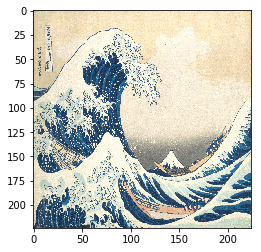

In [14]:
style_img = load_image_1("data/style_transfer/Tsunami_by_hokusai_19th_century.jpg", shape=(w,h))
style_img = style_img.astype('uint8')
pyplot.imshow(style_img)

### Load the Content Image

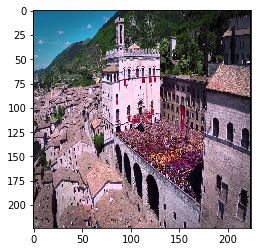

In [15]:
content_img = load_image_1("data/style_transfer/Gubbio.jpg", shape=(w,h))
content_img = content_img.astype("uint8")
pyplot.imshow(content_img)

Apparently, VGG networks were trained on images represented as BGR instead of RGB and that were initially normalized on the mean color, i.e., BGR_mean = [103.939, 116.779, 123.68]. Keras provides a preprocess_input method to adapt our pictures to the VGG input format.

In [16]:
def adapt_to_vgg19(img):
    print "source image", img.shape
    # add batch dimension
    img = np.expand_dims(img, axis=0)
    print "adapted image", img.shape
    return keras.applications.vgg19.preprocess_input(img)

We can similarly define the opposite function:

In [17]:
def adapt_from_vgg19(img):
    #print "vgg19 format", img.shape
    img = np.squeeze(img, axis=0)
    #print "adapted to", img.shape
    # remove the normalization from the normalized output
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # reverse to RGB from BGR
    img = img[:, :, ::-1]
    return img.astype("uint8")

Let's do an example conversion to and from VGG19 format:

In [18]:
ci_vgg19 = adapt_to_vgg19(content_img)
print "ci_vgg19.shape", ci_vgg19.shape

source image (224, 224, 3)
adapted image (1, 224, 224, 3)
ci_vgg19.shape (1, 224, 224, 3)


ci.shape (224, 224, 3)


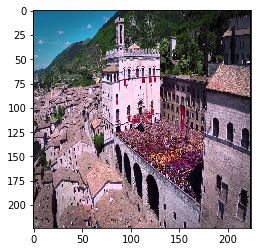

In [19]:
ci = adapt_from_vgg19(ci_vgg19)
print "ci.shape", ci.shape
pyplot.imshow(ci)

In [20]:
content_image = adapt_to_vgg19(content_img)
style_image = adapt_to_vgg19(style_img)

source image (224, 224, 3)
adapted image (1, 224, 224, 3)
source image (224, 224, 3)
adapted image (1, 224, 224, 3)


Let's generate an image from random noise:

In [21]:
generated_image = K.placeholder(content_image.shape)
print generated_image.shape

(1, 224, 224, 3)


### Extracting content and style representations of the images

Based on the original paper, let's start by defining the layers to use for the content representation and those for the style representation:

In [22]:
# content representation is on output of layer conv4_2
content_layers = [
    "block4_conv2"
    #'block5_conv2'
    ] 

In [23]:
# style representation is on layers:
# conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1", 
                "block4_conv1", 
                "block5_conv1"]

In [24]:
def get_layers_as_tensors(adapted_content_image, adapted_style_image, generated_image):
    """
    Inputs the ANN with the different images and returns the specific layers as defined above
    """
    # we can use images of any size actually
    # https://stackoverflow.com/questions/41903051/change-input-tensor-shape-for-vgg16-application
    # the concatenate adds an input stage that appends multiple tensors in a batch
    # so its output is (3, 224, 224, 3) and this allows for extracting the value of each image for any layer we desire
    # https://keras.io/backend/#concatenate
    input_tensors = K.concatenate([adapted_content_image,
                                   adapted_style_image,
                                   generated_image
                                  ], axis=0)
    
    vgg19_model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensors, 
                        #input_shape=(224, 224, 3),
                        #pooling=None,
                        #classes=1000
                       )
    """
    input_6 Tensor("concat_4:0", shape=(3, 224, 224, 3), dtype=float32)
    block1_conv1 Tensor("block1_conv1_5/Relu:0", shape=(3, 224, 224, 64), dtype=float32)
    block1_conv2 Tensor("block1_conv2_5/Relu:0", shape=(3, 224, 224, 64), dtype=float32)
    ...
    """
    parametrized_layers = dict([(layer.name, layer.output) for layer in vgg19_model.layers])
    return [parametrized_layers[l] for l in content_layers], [parametrized_layers[l] for l in style_layers]

In [25]:
content_layers_tensors, style_layers_tensors = get_layers_as_tensors(content_image, style_image, generated_image)
print content_layers_tensors
print style_layers_tensors

[<tf.Tensor 'block4_conv2_1/Relu:0' shape=(3, 28, 28, 512) dtype=float32>]
[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 224, 224, 64) dtype=float32>, <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 112, 112, 128) dtype=float32>, <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 56, 56, 256) dtype=float32>, <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 28, 28, 512) dtype=float32>, <tf.Tensor 'block5_conv1_1/Relu:0' shape=(3, 14, 14, 512) dtype=float32>]


In [26]:
for l in content_layers_tensors:
    print l

Tensor("block4_conv2_1/Relu:0", shape=(3, 28, 28, 512), dtype=float32)


### Defining the Loss Functions

In [27]:
# pass the content image and the input image
# compute mse over content layer of the 2 different feedforward passes
def mse(reference, predicted):
    # calculate mse for tensors, using Keras' tensor operations
    return K.mean(K.square(predicted - reference))

def se(reference, predicted):
    return K.sum(K.square(predicted - reference))

def content_loss(content_representation, input_representation):
    return se(content_representation, input_representation)

In [28]:
content_representation = content_layers_tensors[0][0]
input_img_representation = content_layers_tensors[0][2]
content_loss(content_representation, input_img_representation)

<tf.Tensor 'Sum:0' shape=() dtype=float32>

In [29]:
# pass the style image and the input image
# compute the loss as distance between gram matrices
def gram_matrix(tensor):
    # reshape to have the channel at the beginning
    # i.e. (224,224,3) -> (3,224,224)
    if K.image_data_format() == "channels_last":
        # reorder with channel first, leave the rest untouched
        tensor = K.permute_dimensions(tensor, (2, 0, 1))
    flattened_tensor = K.batch_flatten(tensor)
    # a gram matrix is a flattened layer tensor multiplied to its transpose
    return K.dot(flattened_tensor, K.transpose(flattened_tensor))

# the layer contribution depends on the number of channels and the image size
size = w*h
channels = 3
layer_contribution = (4.0 * (channels ** 2) * (size ** 2))

def style_layer_loss(target_style_representation, input_representation):
    # compare the gram matrices of the target style and input representation
    target_style_gram = gram_matrix(target_style_representation)
    gram_input = gram_matrix(input_representation)
    return se(target_style_gram, gram_input) / layer_contribution

In [30]:
def compute_loss_from_model(nn,
                            input_image_tensor,
                            alpha=0.5,
                            beta=0.5):
    
    # Extract context and style representation by passing the images in the VGG19 network with a feedforward pass
    loss = K.variable(0.0)
    # **** compute content loss ****
    for layer in content_layers:
        print nn.get_layer(layer).output
        # get tensor for the content image
        # content_representation = nn.get_layer("block4_conv2").output[0]
        content_representation = nn.get_layer(layer).output[0]
        print "content_representation["+layer+"].shape", content_representation.shape

        # get tensor for the input image
        # input_img_representation = nn.get_layer("block4_conv2").output[2]
        input_img_representation = nn.get_layer(layer).output[2]
        print "input_img_representation["+layer+"].shape", input_img_representation.shape

        # compute loss for the layer being visited
        # the loss is equally divided for each layer accounting to the content loss
        # the loss is weighted to the heuristic weight for the content
        loss = loss + (alpha * (1/len(content_layers)) * content_loss(content_representation, input_img_representation))
    # **** compute content loss ****
    
    # **** compute style loss ****
    for layer in style_layers:
        style_representation = nn.get_layer(layer).output[1]
        print "style_representation["+layer+"].shape", style_representation.shape
        input_img_representation = nn.get_layer(layer).output[2]
        print "input_img_representation["+layer+"].shape", input_img_representation.shape
        # the style loss is the weighted sum of the loss of all style layers
        # the weight is calculated so that the 5 style layers have each 1/5 weight and all others 0
        # also, since we use a heuristic to define the weight of style wrt content we also multiply to that
        loss = loss + (beta * (1/len(style_layers)) * style_layer_loss(style_representation, input_img_representation))
    # **** compute style loss ****
    return loss

In [31]:
def compute_loss_from_layer_tensors(content_layers_tensors,
                                    style_layers_tensors,
                                    alpha=0.5,
                                    beta=0.5):
     # Extract context and style representation by passing the images in the VGG19 network with a feedforward pass
    loss = K.variable(0.0)
    # **** compute content loss ****
    for layer in content_layers_tensors:
        #print layer, layer.shape
        # get tensor for the content image
        content_representation = layer[0]
        #print "content_representation["+layer.name+"].shape", content_representation.shape

        # get tensor for the input image
        input_img_representation = layer[2]
        #print "input_img_representation["+layer.name+"].shape", input_img_representation.shape

        # compute loss for the layer being visited
        # the loss is equally divided for each layer accounting to the content loss
        # the loss is weighted to the heuristic weight for the content
        loss = loss + (alpha * (1/len(content_layers)) * content_loss(content_representation, input_img_representation))
    # **** compute content loss ****
    
    # **** compute style loss ****
    for layer in style_layers_tensors:
        style_representation = layer[1]
        #print "style_representation["+layer.name+"].shape", style_representation.shape
        input_img_representation = layer[2]
        #print "input_img_representation["+layer.name+"].shape", input_img_representation.shape
        # the style loss is the weighted sum of the loss of all style layers
        # the weight is calculated so that the 5 style layers have each 1/5 weight and all others 0
        # also, since we use a heuristic to define the weight of style wrt content we also multiply to that
        loss = loss + (beta * (1/len(style_layers)) * style_layer_loss(style_representation, input_img_representation))
    # **** compute style loss ****
    return loss

In [32]:
loss = compute_loss_from_layer_tensors(content_layers_tensors, style_layers_tensors)
loss

<tf.Tensor 'add_5:0' shape=() dtype=float32>

In [33]:
def compute_gradient(loss, current_input_image_tensor):
    # calculate loss gradients wrt the currently used input image
    # keras.backend.gradients(loss, variables)
    # Returns the gradients of loss w.r.t. variables.
    grads = K.gradients(loss, current_input_image_tensor)
    return grads

In [34]:
compute_gradient(loss, generated_image)

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 224, 224, 3) dtype=float32>]

Let's define a function to optimize the loss function:

In [150]:
from scipy.optimize import fmin_l_bfgs_b
import math
from tqdm import tqdm

def iterate_over_loss_optimization(content_img,
                                   style_img,
                                   alpha = 0.5,
                                   beta = 0.5,
                                   iterations=10, 
                                   plots_per_row = 10,
                                   plot_every=1):
    # 1. open input images
    content_image = adapt_to_vgg19(content_img)
    style_image = adapt_to_vgg19(style_img)

    # 2. transform images to tensors
    content_image_tensor = K.variable(content_image)
    style_image_tensor = K.variable(style_image)
    
    # 3. create empty tensor for the input image - (1, 224, 224, 3)
    generated_image_tensor = K.placeholder(content_image.shape)
    #K.placeholder((1, h, w, 3)) 
    # keras.backend.function(inputs, outputs, updates=None)
    content_image_tensors, style_image_tensors = get_layers_as_tensors(content_image_tensor,
                                                                       style_image_tensor,
                                                                       generated_image_tensor)

    current_loss = K.variable(0.0)
    current_loss = compute_loss_from_layer_tensors(content_image_tensors, style_image_tensors, alpha=alpha, beta=beta)
    gradient = compute_gradient(current_loss, generated_image_tensor)
    
    # compute the graph by defining a callable function
    # https://keras.io/backend/#function
    # keras.backend.function(inputs, outputs, updates=None)
    o = [current_loss]
    o += gradient
    resulting_graph = K.function([generated_image_tensor],o)

    class Performance():
        def __init__(self):
            self.curr_loss = 0
            self.curr_grad = 0
            
        def get_loss(self, curr_x):
            # add batch dimension
            curr_x = curr_x.reshape((1, w, h, 3))
            # compute graph
            # https://stackoverflow.com/questions/42045092/does-k-function-method-of-keras-with-tensorflow-backend-work-with-network-layers
            results = resulting_graph([curr_x])
            
            self.curr_loss = results[0]
            self.curr_grad = results[1].flatten().astype('float64')
            return self.curr_loss
    
        def get_grad(self, curr_x):    
            return self.curr_grad
    
    p = Performance()
    
    # input image to start from is the content image
    x = content_image.flatten()
    to_plot = int(math.ceil(iterations / float(plot_every)))
    num_rows = int(math.ceil(to_plot / float(plots_per_row)))
    fig = plt.figure(figsize=(2*plots_per_row, 2*num_rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    ims = 0

    for i in tqdm(range(iterations)):
    #for i in range(1,iterations):
        print "epoch", i
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html        
        x, min_val, info = fmin_l_bfgs_b(p.get_loss,
                                         x,
                                         #approx_grad=True,
                                         fprime=p.get_grad,
                                         maxfun=20
                                        )
    
        if i % plot_every == 0:
            ims += 1
            ax1 = plt.subplot(num_rows, plots_per_row, ims)
            ax1.imshow( adapt_from_vgg19(content_image) )
            #plt.imshow( adapt_from_vgg19(content_image) )
            plt.title("Iteration "+str(i))

    return adapt_from_vgg19(content_image)

source image (224, 224, 3)
adapted image (1, 224, 224, 3)
source image (224, 224, 3)
adapted image (1, 224, 224, 3)




  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0




  0%|          | 1/10000 [00:05<15:12:04,  5.47s/it]

  0%|          | 2/10000 [00:05<10:45:24,  3.87s/it]

epoch 1
epoch 2




  0%|          | 3/10000 [00:05<7:39:56,  2.76s/it] 

  0%|          | 4/10000 [00:05<5:28:05,  1.97s/it]

epoch 3
epoch 4




  0%|          | 5/10000 [00:06<3:56:50,  1.42s/it]

  0%|          | 6/10000 [00:06<2:51:48,  1.03s/it]

epoch 5
epoch 6




  0%|          | 7/10000 [00:06<2:06:51,  1.31it/s]

  0%|          | 8/10000 [00:06<1:34:52,  1.76it/s]

epoch 7
epoch 8




  0%|          | 9/10000 [00:06<1:13:06,  2.28it/s]

  0%|          | 10/10000 [00:06<57:13,  2.91it/s] 

epoch 9
epoch 10




  0%|          | 11/10000 [00:06<46:01,  3.62it/s]

  0%|          | 12/10000 [00:06<38:47,  4.29it/s]

epoch 11
epoch 12




  0%|          | 13/10000 [00:07<33:18,  5.00it/s]

  0%|          | 14/10000 [00:07<29:55,  5.56it/s]

epoch 13
epoch 14




  0%|          | 15/10000 [00:07<27:41,  6.01it/s]

  0%|          | 16/10000 [00:07<25:30,  6.52it/s]

epoch 15
epoch 16




  0%|          | 17/10000 [00:07<23:48,  6.99it/s]

  0%|          | 18/10000 [00:07<22:33,  7.37it/s]

epoch 17
epoch 18




  0%|          | 19/10000 [00:07<22:40,  7.34it/s]

  0%|          | 20/10000 [00:07<22:31,  7.39it/s]

epoch 19
epoch 20




  0%|          | 21/10000 [00:08<21:58,  7.57it/s]

  0%|          | 22/10000 [00:08<21:25,  7.76it/s]

epoch 21
epoch 22




  0%|          | 23/10000 [00:08<20:55,  7.95it/s]

  0%|          | 24/10000 [00:08<21:48,  7.62it/s]

epoch 23
epoch 24




  0%|          | 25/10000 [00:08<22:39,  7.34it/s]

  0%|          | 26/10000 [00:08<22:40,  7.33it/s]

epoch 25
epoch 26




  0%|          | 27/10000 [00:08<23:40,  7.02it/s]

  0%|          | 28/10000 [00:09<23:16,  7.14it/s]

epoch 27
epoch 28




  0%|          | 29/10000 [00:09<23:17,  7.13it/s]

  0%|          | 30/10000 [00:09<22:50,  7.28it/s]

epoch 29
epoch 30




  0%|          | 31/10000 [00:09<23:38,  7.03it/s]

  0%|          | 32/10000 [00:09<23:41,  7.01it/s]

epoch 31
epoch 32




  0%|          | 33/10000 [00:09<23:42,  7.01it/s]

  0%|          | 34/10000 [00:09<23:29,  7.07it/s]

epoch 33
epoch 34




  0%|          | 35/10000 [00:10<23:38,  7.02it/s]

  0%|          | 36/10000 [00:10<23:05,  7.19it/s]

epoch 35
epoch 36




  0%|          | 37/10000 [00:10<22:25,  7.41it/s]

  0%|          | 38/10000 [00:10<22:53,  7.26it/s]

epoch 37
epoch 38




  0%|          | 39/10000 [00:10<22:02,  7.53it/s]

  0%|          | 40/10000 [00:10<21:58,  7.56it/s]

epoch 39
epoch 40




  0%|          | 41/10000 [00:10<21:33,  7.70it/s]

  0%|          | 42/10000 [00:10<21:02,  7.89it/s]

epoch 41
epoch 42




  0%|          | 43/10000 [00:11<20:39,  8.03it/s]

  0%|          | 44/10000 [00:11<20:39,  8.03it/s]

epoch 43
epoch 44




  0%|          | 45/10000 [00:11<20:19,  8.16it/s]

  0%|          | 46/10000 [00:11<20:22,  8.14it/s]

epoch 45
epoch 46




  0%|          | 47/10000 [00:11<20:22,  8.14it/s]

  0%|          | 48/10000 [00:11<21:13,  7.82it/s]

epoch 47
epoch 48




  0%|          | 49/10000 [00:11<21:59,  7.54it/s]

  0%|          | 50/10000 [00:11<22:34,  7.34it/s]

epoch 49
epoch 50




  1%|          | 51/10000 [00:12<23:03,  7.19it/s]

  1%|          | 52/10000 [00:12<22:17,  7.44it/s]

epoch 51
epoch 52




  1%|          | 53/10000 [00:12<22:42,  7.30it/s]

  1%|          | 54/10000 [00:12<22:38,  7.32it/s]

epoch 53
epoch 54




  1%|          | 55/10000 [00:12<22:01,  7.53it/s]

  1%|          | 56/10000 [00:12<22:14,  7.45it/s]

epoch 55
epoch 56




  1%|          | 57/10000 [00:12<21:58,  7.54it/s]

  1%|          | 58/10000 [00:13<22:22,  7.41it/s]

epoch 57
epoch 58




  1%|          | 59/10000 [00:13<21:56,  7.55it/s]

  1%|          | 60/10000 [00:13<21:18,  7.77it/s]

epoch 59
epoch 60




  1%|          | 61/10000 [00:13<22:24,  7.39it/s]

  1%|          | 62/10000 [00:13<22:10,  7.47it/s]

epoch 61
epoch 62




  1%|          | 63/10000 [00:13<22:47,  7.26it/s]

  1%|          | 64/10000 [00:13<21:58,  7.54it/s]

epoch 63
epoch 64




  1%|          | 65/10000 [00:13<22:04,  7.50it/s]

  1%|          | 66/10000 [00:14<21:41,  7.63it/s]

epoch 65
epoch 66




  1%|          | 67/10000 [00:14<22:06,  7.49it/s]

  1%|          | 68/10000 [00:14<21:52,  7.57it/s]

epoch 67
epoch 68




  1%|          | 69/10000 [00:14<21:29,  7.70it/s]

  1%|          | 70/10000 [00:14<21:37,  7.65it/s]

epoch 69
epoch 70




  1%|          | 71/10000 [00:14<22:13,  7.44it/s]

  1%|          | 72/10000 [00:14<21:54,  7.55it/s]

epoch 71
epoch 72




  1%|          | 73/10000 [00:15<21:24,  7.73it/s]

  1%|          | 74/10000 [00:15<21:29,  7.70it/s]

epoch 73
epoch 74




  1%|          | 75/10000 [00:15<22:19,  7.41it/s]

  1%|          | 76/10000 [00:15<22:37,  7.31it/s]

epoch 75
epoch 76




  1%|          | 77/10000 [00:15<22:09,  7.47it/s]

  1%|          | 78/10000 [00:15<21:32,  7.68it/s]

epoch 77
epoch 78




  1%|          | 79/10000 [00:15<20:55,  7.90it/s]

  1%|          | 80/10000 [00:15<20:26,  8.09it/s]

epoch 79
epoch 80




  1%|          | 81/10000 [00:16<21:42,  7.61it/s]

  1%|          | 82/10000 [00:16<21:19,  7.75it/s]

epoch 81
epoch 82




  1%|          | 83/10000 [00:16<21:39,  7.63it/s]

  1%|          | 84/10000 [00:16<21:56,  7.53it/s]

epoch 83
epoch 84




  1%|          | 85/10000 [00:16<22:28,  7.36it/s]

  1%|          | 86/10000 [00:16<22:19,  7.40it/s]

epoch 85
epoch 86




  1%|          | 87/10000 [00:16<22:50,  7.24it/s]

  1%|          | 88/10000 [00:17<22:52,  7.22it/s]

epoch 87
epoch 88




  1%|          | 89/10000 [00:17<23:02,  7.17it/s]

  1%|          | 90/10000 [00:17<23:12,  7.12it/s]

epoch 89
epoch 90




  1%|          | 91/10000 [00:17<23:40,  6.97it/s]

  1%|          | 92/10000 [00:17<23:02,  7.17it/s]

epoch 91
epoch 92




  1%|          | 93/10000 [00:17<22:58,  7.19it/s]

  1%|          | 94/10000 [00:17<23:39,  6.98it/s]

epoch 93
epoch 94




  1%|          | 95/10000 [00:18<23:50,  6.92it/s]

  1%|          | 96/10000 [00:18<23:56,  6.90it/s]

epoch 95
epoch 96




  1%|          | 97/10000 [00:18<24:04,  6.86it/s]

  1%|          | 98/10000 [00:18<23:37,  6.99it/s]

epoch 97
epoch 98




  1%|          | 99/10000 [00:18<23:36,  6.99it/s]

  1%|          | 100/10000 [00:18<22:44,  7.25it/s]

epoch 99
epoch 100




  1%|          | 101/10000 [00:18<23:15,  7.09it/s]

  1%|          | 102/10000 [00:19<22:31,  7.32it/s]

epoch 101
epoch 102




  1%|          | 103/10000 [00:19<21:55,  7.52it/s]

  1%|          | 104/10000 [00:19<21:09,  7.79it/s]

epoch 103
epoch 104




  1%|          | 105/10000 [00:19<20:56,  7.88it/s]

  1%|          | 106/10000 [00:19<21:55,  7.52it/s]

epoch 105
epoch 106




  1%|          | 107/10000 [00:19<22:37,  7.29it/s]

  1%|          | 108/10000 [00:19<22:35,  7.30it/s]

epoch 107
epoch 108




  1%|          | 109/10000 [00:19<22:49,  7.22it/s]

  1%|          | 110/10000 [00:20<22:41,  7.26it/s]

epoch 109
epoch 110




  1%|          | 111/10000 [00:20<23:21,  7.06it/s]

  1%|          | 112/10000 [00:20<23:39,  6.96it/s]

epoch 111
epoch 112




  1%|          | 113/10000 [00:20<23:49,  6.92it/s]

  1%|          | 114/10000 [00:20<23:19,  7.07it/s]

epoch 113
epoch 114




  1%|          | 115/10000 [00:20<23:36,  6.98it/s]

  1%|          | 116/10000 [00:20<23:01,  7.16it/s]

epoch 115
epoch 116




  1%|          | 117/10000 [00:21<23:31,  7.00it/s]

  1%|          | 118/10000 [00:21<22:55,  7.19it/s]

epoch 117
epoch 118




  1%|          | 119/10000 [00:21<22:06,  7.45it/s]

  1%|          | 120/10000 [00:21<22:35,  7.29it/s]

epoch 119
epoch 120




  1%|          | 121/10000 [00:21<23:21,  7.05it/s]

  1%|          | 122/10000 [00:21<22:58,  7.17it/s]

epoch 121
epoch 122




  1%|          | 123/10000 [00:21<23:52,  6.90it/s]

  1%|          | 124/10000 [00:22<23:28,  7.01it/s]

epoch 123
epoch 124




  1%|▏         | 125/10000 [00:22<23:21,  7.04it/s]

  1%|▏         | 126/10000 [00:22<23:32,  6.99it/s]

epoch 125
epoch 126




  1%|▏         | 127/10000 [00:22<23:38,  6.96it/s]

  1%|▏         | 128/10000 [00:22<22:32,  7.30it/s]

epoch 127
epoch 128




  1%|▏         | 129/10000 [00:22<23:23,  7.03it/s]

  1%|▏         | 130/10000 [00:22<22:21,  7.36it/s]

epoch 129
epoch 130




  1%|▏         | 131/10000 [00:23<22:35,  7.28it/s]

  1%|▏         | 132/10000 [00:23<22:42,  7.24it/s]

epoch 131
epoch 132




  1%|▏         | 133/10000 [00:23<22:11,  7.41it/s]

  1%|▏         | 134/10000 [00:23<22:25,  7.33it/s]

epoch 133
epoch 134




  1%|▏         | 135/10000 [00:23<21:51,  7.52it/s]

  1%|▏         | 136/10000 [00:23<21:17,  7.72it/s]

epoch 135
epoch 136




  1%|▏         | 137/10000 [00:23<20:53,  7.87it/s]

  1%|▏         | 138/10000 [00:23<21:13,  7.74it/s]

epoch 137
epoch 138




  1%|▏         | 139/10000 [00:24<22:04,  7.45it/s]

  1%|▏         | 140/10000 [00:24<21:43,  7.57it/s]

epoch 139
epoch 140




  1%|▏         | 141/10000 [00:24<22:51,  7.19it/s]

  1%|▏         | 142/10000 [00:24<21:54,  7.50it/s]

epoch 141
epoch 142




  1%|▏         | 143/10000 [00:24<22:36,  7.26it/s]

  1%|▏         | 144/10000 [00:24<22:16,  7.37it/s]

epoch 143
epoch 144




  1%|▏         | 145/10000 [00:24<22:38,  7.25it/s]

  1%|▏         | 146/10000 [00:25<22:25,  7.32it/s]

epoch 145
epoch 146




  1%|▏         | 147/10000 [00:25<23:05,  7.11it/s]

  1%|▏         | 148/10000 [00:25<22:50,  7.19it/s]

epoch 147
epoch 148




  1%|▏         | 149/10000 [00:25<22:54,  7.17it/s]

  2%|▏         | 150/10000 [00:25<22:45,  7.21it/s]

epoch 149
epoch 150




  2%|▏         | 151/10000 [00:25<23:05,  7.11it/s]

  2%|▏         | 152/10000 [00:25<22:59,  7.14it/s]

epoch 151
epoch 152




  2%|▏         | 153/10000 [00:26<23:10,  7.08it/s]

  2%|▏         | 154/10000 [00:26<22:05,  7.43it/s]

epoch 153
epoch 154




  2%|▏         | 155/10000 [00:26<22:42,  7.22it/s]

  2%|▏         | 156/10000 [00:26<22:20,  7.34it/s]

epoch 155
epoch 156




  2%|▏         | 157/10000 [00:26<23:00,  7.13it/s]

  2%|▏         | 158/10000 [00:26<22:14,  7.38it/s]

epoch 157
epoch 158




  2%|▏         | 159/10000 [00:26<22:33,  7.27it/s]

  2%|▏         | 160/10000 [00:26<22:57,  7.14it/s]

epoch 159
epoch 160




  2%|▏         | 161/10000 [00:27<23:15,  7.05it/s]

  2%|▏         | 162/10000 [00:27<22:32,  7.28it/s]

epoch 161
epoch 162




  2%|▏         | 163/10000 [00:27<22:34,  7.26it/s]

  2%|▏         | 164/10000 [00:27<22:29,  7.29it/s]

epoch 163
epoch 164




  2%|▏         | 165/10000 [00:27<22:29,  7.29it/s]

  2%|▏         | 166/10000 [00:27<21:42,  7.55it/s]

epoch 165
epoch 166




  2%|▏         | 167/10000 [00:27<21:03,  7.78it/s]

  2%|▏         | 168/10000 [00:28<20:44,  7.90it/s]

epoch 167
epoch 168




  2%|▏         | 169/10000 [00:28<20:46,  7.88it/s]

  2%|▏         | 170/10000 [00:28<22:11,  7.39it/s]

epoch 169
epoch 170




  2%|▏         | 171/10000 [00:28<22:12,  7.38it/s]

  2%|▏         | 172/10000 [00:28<22:23,  7.31it/s]

epoch 171
epoch 172




  2%|▏         | 173/10000 [00:28<23:00,  7.12it/s]

  2%|▏         | 174/10000 [00:28<22:24,  7.31it/s]

epoch 173
epoch 174




  2%|▏         | 175/10000 [00:29<21:40,  7.56it/s]

  2%|▏         | 176/10000 [00:29<21:05,  7.76it/s]

epoch 175
epoch 176




  2%|▏         | 177/10000 [00:29<21:23,  7.65it/s]

  2%|▏         | 178/10000 [00:29<20:54,  7.83it/s]

epoch 177
epoch 178




  2%|▏         | 179/10000 [00:29<21:10,  7.73it/s]

  2%|▏         | 180/10000 [00:29<20:46,  7.88it/s]

epoch 179
epoch 180




  2%|▏         | 181/10000 [00:29<20:27,  8.00it/s]

  2%|▏         | 182/10000 [00:29<20:18,  8.06it/s]

epoch 181
epoch 182




  2%|▏         | 183/10000 [00:30<21:10,  7.73it/s]

  2%|▏         | 184/10000 [00:30<21:59,  7.44it/s]

epoch 183
epoch 184




  2%|▏         | 185/10000 [00:30<22:15,  7.35it/s]

  2%|▏         | 186/10000 [00:30<21:22,  7.65it/s]

epoch 185
epoch 186




  2%|▏         | 187/10000 [00:30<20:52,  7.84it/s]

  2%|▏         | 188/10000 [00:30<20:38,  7.92it/s]

epoch 187
epoch 188




  2%|▏         | 189/10000 [00:30<20:21,  8.03it/s]

  2%|▏         | 190/10000 [00:30<20:28,  7.98it/s]

epoch 189
epoch 190




  2%|▏         | 191/10000 [00:31<20:19,  8.05it/s]

  2%|▏         | 192/10000 [00:31<20:08,  8.12it/s]

epoch 191
epoch 192




  2%|▏         | 193/10000 [00:31<19:59,  8.18it/s]

  2%|▏         | 194/10000 [00:31<20:26,  8.00it/s]

epoch 193
epoch 194




  2%|▏         | 195/10000 [00:31<20:24,  8.01it/s]

  2%|▏         | 196/10000 [00:31<20:12,  8.09it/s]

epoch 195
epoch 196




  2%|▏         | 197/10000 [00:31<20:07,  8.12it/s]

  2%|▏         | 198/10000 [00:31<20:27,  7.98it/s]

epoch 197
epoch 198




  2%|▏         | 199/10000 [00:32<21:17,  7.67it/s]

  2%|▏         | 200/10000 [00:32<21:33,  7.58it/s]

epoch 199
epoch 200




  2%|▏         | 201/10000 [00:32<22:28,  7.26it/s]

  2%|▏         | 202/10000 [00:32<22:31,  7.25it/s]

epoch 201
epoch 202




  2%|▏         | 203/10000 [00:32<22:54,  7.13it/s]

  2%|▏         | 204/10000 [00:32<23:10,  7.04it/s]

epoch 203
epoch 204




  2%|▏         | 205/10000 [00:32<23:21,  6.99it/s]

  2%|▏         | 206/10000 [00:33<22:18,  7.32it/s]

epoch 205
epoch 206




  2%|▏         | 207/10000 [00:33<22:28,  7.26it/s]

  2%|▏         | 208/10000 [00:33<21:38,  7.54it/s]

epoch 207
epoch 208




  2%|▏         | 209/10000 [00:33<22:23,  7.29it/s]

  2%|▏         | 210/10000 [00:33<21:36,  7.55it/s]

epoch 209
epoch 210




  2%|▏         | 211/10000 [00:33<21:49,  7.48it/s]

  2%|▏         | 212/10000 [00:33<22:01,  7.41it/s]

epoch 211
epoch 212




  2%|▏         | 213/10000 [00:33<22:25,  7.27it/s]

  2%|▏         | 214/10000 [00:34<21:37,  7.54it/s]

epoch 213
epoch 214




  2%|▏         | 215/10000 [00:34<21:39,  7.53it/s]

  2%|▏         | 216/10000 [00:34<21:00,  7.76it/s]

epoch 215
epoch 216




  2%|▏         | 217/10000 [00:34<20:43,  7.87it/s]

  2%|▏         | 218/10000 [00:34<20:23,  8.00it/s]

epoch 217
epoch 218




  2%|▏         | 219/10000 [00:34<20:18,  8.03it/s]

  2%|▏         | 220/10000 [00:34<20:25,  7.98it/s]

epoch 219
epoch 220




  2%|▏         | 221/10000 [00:34<20:01,  8.14it/s]

  2%|▏         | 222/10000 [00:35<19:43,  8.26it/s]

epoch 221
epoch 222




  2%|▏         | 223/10000 [00:35<19:39,  8.29it/s]

  2%|▏         | 224/10000 [00:35<19:39,  8.29it/s]

epoch 223
epoch 224




  2%|▏         | 225/10000 [00:35<19:33,  8.33it/s]

  2%|▏         | 226/10000 [00:35<19:33,  8.33it/s]

epoch 225
epoch 226




  2%|▏         | 227/10000 [00:35<19:40,  8.28it/s]

  2%|▏         | 228/10000 [00:35<19:45,  8.24it/s]

epoch 227
epoch 228




  2%|▏         | 229/10000 [00:35<19:43,  8.26it/s]

  2%|▏         | 230/10000 [00:36<19:35,  8.31it/s]

epoch 229
epoch 230




  2%|▏         | 231/10000 [00:36<20:06,  8.09it/s]

  2%|▏         | 232/10000 [00:36<19:59,  8.15it/s]

epoch 231
epoch 232




  2%|▏         | 233/10000 [00:36<19:48,  8.22it/s]

  2%|▏         | 234/10000 [00:36<19:35,  8.30it/s]

epoch 233
epoch 234




  2%|▏         | 235/10000 [00:36<19:44,  8.25it/s]

  2%|▏         | 236/10000 [00:36<19:36,  8.30it/s]

epoch 235
epoch 236




  2%|▏         | 237/10000 [00:36<19:31,  8.34it/s]

  2%|▏         | 238/10000 [00:37<19:26,  8.37it/s]

epoch 237
epoch 238




  2%|▏         | 239/10000 [00:37<19:29,  8.35it/s]

  2%|▏         | 240/10000 [00:37<20:02,  8.12it/s]

epoch 239
epoch 240




  2%|▏         | 241/10000 [00:37<19:59,  8.13it/s]

  2%|▏         | 242/10000 [00:37<20:26,  7.96it/s]

epoch 241
epoch 242




  2%|▏         | 243/10000 [00:37<20:26,  7.95it/s]

  2%|▏         | 244/10000 [00:37<20:01,  8.12it/s]

epoch 243
epoch 244




  2%|▏         | 245/10000 [00:37<19:49,  8.20it/s]

  2%|▏         | 246/10000 [00:37<19:41,  8.26it/s]

epoch 245
epoch 246




  2%|▏         | 247/10000 [00:38<19:35,  8.30it/s]

  2%|▏         | 248/10000 [00:38<19:32,  8.32it/s]

epoch 247
epoch 248




  2%|▏         | 249/10000 [00:38<19:51,  8.19it/s]

  2%|▎         | 250/10000 [00:38<20:12,  8.04it/s]

epoch 249
epoch 250




  3%|▎         | 251/10000 [00:38<20:02,  8.11it/s]

  3%|▎         | 252/10000 [00:38<19:49,  8.20it/s]

epoch 251
epoch 252




  3%|▎         | 253/10000 [00:38<19:36,  8.28it/s]

  3%|▎         | 254/10000 [00:38<20:09,  8.06it/s]

epoch 253
epoch 254




  3%|▎         | 255/10000 [00:39<20:42,  7.84it/s]

  3%|▎         | 256/10000 [00:39<20:53,  7.77it/s]

epoch 255
epoch 256




  3%|▎         | 257/10000 [00:39<21:28,  7.56it/s]

  3%|▎         | 258/10000 [00:39<21:48,  7.44it/s]

epoch 257
epoch 258




  3%|▎         | 259/10000 [00:39<22:14,  7.30it/s]

  3%|▎         | 260/10000 [00:39<21:29,  7.56it/s]

epoch 259
epoch 260




  3%|▎         | 261/10000 [00:39<21:40,  7.49it/s]

  3%|▎         | 262/10000 [00:40<22:07,  7.33it/s]

epoch 261
epoch 262




  3%|▎         | 263/10000 [00:40<21:39,  7.49it/s]

  3%|▎         | 264/10000 [00:40<21:36,  7.51it/s]

epoch 263
epoch 264




  3%|▎         | 265/10000 [00:40<21:49,  7.43it/s]

  3%|▎         | 266/10000 [00:40<20:59,  7.73it/s]

epoch 265
epoch 266




  3%|▎         | 267/10000 [00:40<20:33,  7.89it/s]

  3%|▎         | 268/10000 [00:40<20:09,  8.04it/s]

epoch 267
epoch 268




  3%|▎         | 269/10000 [00:40<19:49,  8.18it/s]

  3%|▎         | 270/10000 [00:41<20:48,  7.80it/s]

epoch 269
epoch 270




  3%|▎         | 271/10000 [00:41<20:29,  7.91it/s]

  3%|▎         | 272/10000 [00:41<20:06,  8.07it/s]

epoch 271
epoch 272




  3%|▎         | 273/10000 [00:41<19:51,  8.16it/s]

  3%|▎         | 274/10000 [00:41<20:18,  7.98it/s]

epoch 273
epoch 274




  3%|▎         | 275/10000 [00:41<21:05,  7.69it/s]

  3%|▎         | 276/10000 [00:41<21:34,  7.51it/s]

epoch 275
epoch 276




  3%|▎         | 277/10000 [00:42<22:08,  7.32it/s]

  3%|▎         | 278/10000 [00:42<21:29,  7.54it/s]

epoch 277
epoch 278




  3%|▎         | 279/10000 [00:42<21:39,  7.48it/s]

  3%|▎         | 280/10000 [00:42<20:58,  7.73it/s]

epoch 279
epoch 280




  3%|▎         | 281/10000 [00:42<21:12,  7.64it/s]

  3%|▎         | 282/10000 [00:42<22:20,  7.25it/s]

epoch 281
epoch 282




  3%|▎         | 283/10000 [00:42<22:05,  7.33it/s]

  3%|▎         | 284/10000 [00:42<22:04,  7.34it/s]

epoch 283
epoch 284




  3%|▎         | 285/10000 [00:43<22:20,  7.25it/s]

  3%|▎         | 286/10000 [00:43<22:23,  7.23it/s]

epoch 285
epoch 286




  3%|▎         | 287/10000 [00:43<22:23,  7.23it/s]

  3%|▎         | 288/10000 [00:43<22:05,  7.32it/s]

epoch 287
epoch 288




  3%|▎         | 289/10000 [00:43<23:07,  7.00it/s]

  3%|▎         | 290/10000 [00:43<23:01,  7.03it/s]

epoch 289
epoch 290




  3%|▎         | 291/10000 [00:43<23:23,  6.92it/s]

  3%|▎         | 292/10000 [00:44<23:05,  7.01it/s]

epoch 291
epoch 292




  3%|▎         | 293/10000 [00:44<22:06,  7.32it/s]

  3%|▎         | 294/10000 [00:44<21:17,  7.59it/s]

epoch 293
epoch 294




  3%|▎         | 295/10000 [00:44<20:37,  7.84it/s]

  3%|▎         | 296/10000 [00:44<21:23,  7.56it/s]

epoch 295
epoch 296




  3%|▎         | 297/10000 [00:44<21:12,  7.62it/s]

  3%|▎         | 298/10000 [00:44<21:36,  7.48it/s]

epoch 297
epoch 298




  3%|▎         | 299/10000 [00:45<22:40,  7.13it/s]

  3%|▎         | 300/10000 [00:45<21:49,  7.41it/s]

epoch 299
epoch 300




  3%|▎         | 301/10000 [00:45<21:30,  7.52it/s]

  3%|▎         | 302/10000 [00:45<20:56,  7.72it/s]

epoch 301
epoch 302




  3%|▎         | 303/10000 [00:45<20:30,  7.88it/s]

  3%|▎         | 304/10000 [00:45<20:05,  8.04it/s]

epoch 303
epoch 304




  3%|▎         | 305/10000 [00:45<19:53,  8.12it/s]

  3%|▎         | 306/10000 [00:45<19:52,  8.13it/s]

epoch 305
epoch 306




  3%|▎         | 307/10000 [00:45<19:44,  8.19it/s]

  3%|▎         | 308/10000 [00:46<20:14,  7.98it/s]

epoch 307
epoch 308




  3%|▎         | 309/10000 [00:46<20:14,  7.98it/s]

  3%|▎         | 310/10000 [00:46<19:59,  8.08it/s]

epoch 309
epoch 310




  3%|▎         | 311/10000 [00:46<19:46,  8.16it/s]

  3%|▎         | 312/10000 [00:46<19:33,  8.26it/s]

epoch 311
epoch 312




  3%|▎         | 313/10000 [00:46<20:06,  8.03it/s]

  3%|▎         | 314/10000 [00:46<19:48,  8.15it/s]

epoch 313
epoch 314




  3%|▎         | 315/10000 [00:46<20:27,  7.89it/s]

  3%|▎         | 316/10000 [00:47<21:22,  7.55it/s]

epoch 315
epoch 316




  3%|▎         | 317/10000 [00:47<22:02,  7.32it/s]

  3%|▎         | 318/10000 [00:47<21:16,  7.59it/s]

epoch 317
epoch 318




  3%|▎         | 319/10000 [00:47<20:37,  7.82it/s]

  3%|▎         | 320/10000 [00:47<20:10,  7.99it/s]

epoch 319
epoch 320




  3%|▎         | 321/10000 [00:47<19:53,  8.11it/s]

  3%|▎         | 322/10000 [00:47<19:37,  8.22it/s]

epoch 321
epoch 322




  3%|▎         | 323/10000 [00:47<19:42,  8.18it/s]

  3%|▎         | 324/10000 [00:48<20:08,  8.01it/s]

epoch 323
epoch 324




  3%|▎         | 325/10000 [00:48<20:01,  8.05it/s]

  3%|▎         | 326/10000 [00:48<19:45,  8.16it/s]

epoch 325
epoch 326




  3%|▎         | 327/10000 [00:48<19:35,  8.23it/s]

  3%|▎         | 328/10000 [00:48<21:00,  7.67it/s]

epoch 327
epoch 328




  3%|▎         | 329/10000 [00:48<21:33,  7.48it/s]

  3%|▎         | 330/10000 [00:48<21:30,  7.49it/s]

epoch 329
epoch 330




  3%|▎         | 331/10000 [00:49<21:57,  7.34it/s]

  3%|▎         | 332/10000 [00:49<21:59,  7.33it/s]

epoch 331
epoch 332




  3%|▎         | 333/10000 [00:49<22:19,  7.22it/s]

  3%|▎         | 334/10000 [00:49<22:13,  7.25it/s]

epoch 333
epoch 334




  3%|▎         | 335/10000 [00:49<22:29,  7.16it/s]

  3%|▎         | 336/10000 [00:49<22:25,  7.18it/s]

epoch 335
epoch 336




  3%|▎         | 337/10000 [00:49<21:59,  7.32it/s]

  3%|▎         | 338/10000 [00:50<21:14,  7.58it/s]

epoch 337
epoch 338




  3%|▎         | 339/10000 [00:50<20:44,  7.77it/s]

  3%|▎         | 340/10000 [00:50<20:20,  7.91it/s]

epoch 339
epoch 340




  3%|▎         | 341/10000 [00:50<20:04,  8.02it/s]

  3%|▎         | 342/10000 [00:50<19:53,  8.10it/s]

epoch 341
epoch 342




  3%|▎         | 343/10000 [00:50<19:57,  8.07it/s]

  3%|▎         | 344/10000 [00:50<19:50,  8.11it/s]

epoch 343
epoch 344




  3%|▎         | 345/10000 [00:50<19:42,  8.16it/s]

  3%|▎         | 346/10000 [00:50<20:28,  7.86it/s]

epoch 345
epoch 346




  3%|▎         | 347/10000 [00:51<20:28,  7.86it/s]

  3%|▎         | 348/10000 [00:51<21:35,  7.45it/s]

epoch 347
epoch 348




  3%|▎         | 349/10000 [00:51<21:27,  7.50it/s]

  4%|▎         | 350/10000 [00:51<20:46,  7.74it/s]

epoch 349
epoch 350




  4%|▎         | 351/10000 [00:51<21:30,  7.48it/s]

  4%|▎         | 352/10000 [00:51<21:08,  7.61it/s]

epoch 351
epoch 352




  4%|▎         | 353/10000 [00:51<22:12,  7.24it/s]

  4%|▎         | 354/10000 [00:52<21:58,  7.31it/s]

epoch 353
epoch 354




  4%|▎         | 355/10000 [00:52<22:24,  7.17it/s]

  4%|▎         | 356/10000 [00:52<21:49,  7.36it/s]

epoch 355
epoch 356




  4%|▎         | 357/10000 [00:52<22:25,  7.17it/s]

  4%|▎         | 358/10000 [00:52<21:44,  7.39it/s]

epoch 357
epoch 358




  4%|▎         | 359/10000 [00:52<21:05,  7.62it/s]

  4%|▎         | 360/10000 [00:52<21:18,  7.54it/s]

epoch 359
epoch 360




  4%|▎         | 361/10000 [00:53<20:52,  7.69it/s]

  4%|▎         | 362/10000 [00:53<20:59,  7.65it/s]

epoch 361
epoch 362




  4%|▎         | 363/10000 [00:53<20:44,  7.75it/s]

  4%|▎         | 364/10000 [00:53<21:02,  7.63it/s]

epoch 363
epoch 364




  4%|▎         | 365/10000 [00:53<21:25,  7.49it/s]

  4%|▎         | 366/10000 [00:53<20:49,  7.71it/s]

epoch 365
epoch 366




  4%|▎         | 367/10000 [00:53<21:58,  7.31it/s]

  4%|▎         | 368/10000 [00:53<21:11,  7.58it/s]

epoch 367
epoch 368




  4%|▎         | 369/10000 [00:54<20:42,  7.75it/s]

  4%|▎         | 370/10000 [00:54<21:01,  7.64it/s]

epoch 369
epoch 370




  4%|▎         | 371/10000 [00:54<21:44,  7.38it/s]

  4%|▎         | 372/10000 [00:54<22:03,  7.27it/s]

epoch 371
epoch 372




  4%|▎         | 373/10000 [00:54<22:31,  7.12it/s]

  4%|▎         | 374/10000 [00:54<21:39,  7.41it/s]

epoch 373
epoch 374




  4%|▍         | 375/10000 [00:54<20:52,  7.68it/s]

  4%|▍         | 376/10000 [00:55<21:08,  7.59it/s]

epoch 375
epoch 376




  4%|▍         | 377/10000 [00:55<21:37,  7.42it/s]

  4%|▍         | 378/10000 [00:55<21:56,  7.31it/s]

epoch 377
epoch 378




  4%|▍         | 379/10000 [00:55<22:22,  7.17it/s]

  4%|▍         | 380/10000 [00:55<21:59,  7.29it/s]

epoch 379
epoch 380




  4%|▍         | 381/10000 [00:55<21:21,  7.51it/s]

  4%|▍         | 382/10000 [00:55<22:34,  7.10it/s]

epoch 381
epoch 382




  4%|▍         | 383/10000 [00:55<22:27,  7.14it/s]

  4%|▍         | 384/10000 [00:56<22:09,  7.23it/s]

epoch 383
epoch 384




  4%|▍         | 385/10000 [00:56<22:18,  7.18it/s]

  4%|▍         | 386/10000 [00:56<21:57,  7.30it/s]

epoch 385
epoch 386




  4%|▍         | 387/10000 [00:56<22:15,  7.20it/s]

  4%|▍         | 388/10000 [00:56<21:43,  7.37it/s]

epoch 387
epoch 388




  4%|▍         | 389/10000 [00:56<20:54,  7.66it/s]

  4%|▍         | 390/10000 [00:56<21:00,  7.62it/s]

epoch 389
epoch 390




  4%|▍         | 391/10000 [00:57<20:39,  7.75it/s]

  4%|▍         | 392/10000 [00:57<20:07,  7.96it/s]

epoch 391
epoch 392




  4%|▍         | 393/10000 [00:57<19:48,  8.08it/s]

  4%|▍         | 394/10000 [00:57<20:23,  7.85it/s]

epoch 393
epoch 394




  4%|▍         | 395/10000 [00:57<21:18,  7.51it/s]

  4%|▍         | 396/10000 [00:57<20:42,  7.73it/s]

epoch 395
epoch 396




  4%|▍         | 397/10000 [00:57<21:41,  7.38it/s]

  4%|▍         | 398/10000 [00:57<22:10,  7.22it/s]

epoch 397
epoch 398




  4%|▍         | 399/10000 [00:58<22:34,  7.09it/s]

  4%|▍         | 400/10000 [00:58<22:12,  7.20it/s]

epoch 399
epoch 400




  4%|▍         | 401/10000 [00:58<22:46,  7.02it/s]

  4%|▍         | 402/10000 [00:58<21:52,  7.32it/s]

epoch 401
epoch 402




  4%|▍         | 403/10000 [00:58<21:54,  7.30it/s]

  4%|▍         | 404/10000 [00:58<21:10,  7.56it/s]

epoch 403
epoch 404




  4%|▍         | 405/10000 [00:58<21:21,  7.49it/s]

  4%|▍         | 406/10000 [00:59<21:12,  7.54it/s]

epoch 405
epoch 406




  4%|▍         | 407/10000 [00:59<20:35,  7.76it/s]

  4%|▍         | 408/10000 [00:59<21:44,  7.35it/s]

epoch 407
epoch 408




  4%|▍         | 409/10000 [00:59<21:37,  7.39it/s]

  4%|▍         | 410/10000 [00:59<21:30,  7.43it/s]

epoch 409
epoch 410




  4%|▍         | 411/10000 [00:59<22:29,  7.10it/s]

  4%|▍         | 412/10000 [00:59<22:37,  7.06it/s]

epoch 411
epoch 412




  4%|▍         | 413/10000 [01:00<23:00,  6.94it/s]

  4%|▍         | 414/10000 [01:00<22:37,  7.06it/s]

epoch 413
epoch 414




  4%|▍         | 415/10000 [01:00<22:45,  7.02it/s]

  4%|▍         | 416/10000 [01:00<22:11,  7.20it/s]

epoch 415
epoch 416




  4%|▍         | 417/10000 [01:00<22:26,  7.12it/s]

  4%|▍         | 418/10000 [01:00<21:39,  7.37it/s]

epoch 417
epoch 418




  4%|▍         | 419/10000 [01:00<21:44,  7.35it/s]

  4%|▍         | 420/10000 [01:00<21:29,  7.43it/s]

epoch 419
epoch 420




  4%|▍         | 421/10000 [01:01<21:47,  7.33it/s]

  4%|▍         | 422/10000 [01:01<22:18,  7.16it/s]

epoch 421
epoch 422




  4%|▍         | 423/10000 [01:01<21:55,  7.28it/s]

  4%|▍         | 424/10000 [01:01<21:02,  7.58it/s]

epoch 423
epoch 424




  4%|▍         | 425/10000 [01:01<20:21,  7.84it/s]

  4%|▍         | 426/10000 [01:01<19:56,  8.00it/s]

epoch 425
epoch 426




  4%|▍         | 427/10000 [01:01<19:36,  8.14it/s]

  4%|▍         | 428/10000 [01:02<19:24,  8.22it/s]

epoch 427
epoch 428




  4%|▍         | 429/10000 [01:02<19:21,  8.24it/s]

  4%|▍         | 430/10000 [01:02<20:22,  7.83it/s]

epoch 429
epoch 430




  4%|▍         | 431/10000 [01:02<20:23,  7.82it/s]

  4%|▍         | 432/10000 [01:02<20:12,  7.89it/s]

epoch 431
epoch 432




  4%|▍         | 433/10000 [01:02<20:36,  7.74it/s]

  4%|▍         | 434/10000 [01:02<20:13,  7.89it/s]

epoch 433
epoch 434




  4%|▍         | 435/10000 [01:02<19:49,  8.04it/s]

  4%|▍         | 436/10000 [01:03<19:39,  8.11it/s]

epoch 435
epoch 436




  4%|▍         | 437/10000 [01:03<20:55,  7.62it/s]

  4%|▍         | 438/10000 [01:03<21:29,  7.41it/s]

epoch 437
epoch 438




  4%|▍         | 439/10000 [01:03<22:08,  7.20it/s]

  4%|▍         | 440/10000 [01:03<22:24,  7.11it/s]

epoch 439
epoch 440




  4%|▍         | 441/10000 [01:03<22:58,  6.93it/s]

  4%|▍         | 442/10000 [01:03<22:26,  7.10it/s]

epoch 441
epoch 442




  4%|▍         | 443/10000 [01:04<21:41,  7.34it/s]

  4%|▍         | 444/10000 [01:04<21:26,  7.43it/s]

epoch 443
epoch 444




  4%|▍         | 445/10000 [01:04<21:35,  7.38it/s]

  4%|▍         | 446/10000 [01:04<21:22,  7.45it/s]

epoch 445
epoch 446




  4%|▍         | 447/10000 [01:04<20:55,  7.61it/s]

  4%|▍         | 448/10000 [01:04<21:04,  7.55it/s]

epoch 447
epoch 448




  4%|▍         | 449/10000 [01:04<21:58,  7.24it/s]

  4%|▍         | 450/10000 [01:04<21:36,  7.37it/s]

epoch 449
epoch 450




  5%|▍         | 451/10000 [01:05<21:18,  7.47it/s]

  5%|▍         | 452/10000 [01:05<21:39,  7.35it/s]

epoch 451
epoch 452




  5%|▍         | 453/10000 [01:05<21:20,  7.45it/s]

  5%|▍         | 454/10000 [01:05<22:06,  7.20it/s]

epoch 453
epoch 454




  5%|▍         | 455/10000 [01:05<22:16,  7.14it/s]

  5%|▍         | 456/10000 [01:05<21:54,  7.26it/s]

epoch 455
epoch 456




  5%|▍         | 457/10000 [01:05<21:52,  7.27it/s]

  5%|▍         | 458/10000 [01:06<21:52,  7.27it/s]

epoch 457
epoch 458




  5%|▍         | 459/10000 [01:06<21:45,  7.31it/s]

  5%|▍         | 460/10000 [01:06<20:59,  7.58it/s]

epoch 459
epoch 460




  5%|▍         | 461/10000 [01:06<20:29,  7.76it/s]

  5%|▍         | 462/10000 [01:06<21:11,  7.50it/s]

epoch 461
epoch 462




  5%|▍         | 463/10000 [01:06<21:08,  7.52it/s]

  5%|▍         | 464/10000 [01:06<20:34,  7.72it/s]

epoch 463
epoch 464




  5%|▍         | 465/10000 [01:06<21:22,  7.44it/s]

  5%|▍         | 466/10000 [01:07<20:50,  7.63it/s]

epoch 465
epoch 466




  5%|▍         | 467/10000 [01:07<20:31,  7.74it/s]

  5%|▍         | 468/10000 [01:07<22:04,  7.20it/s]

epoch 467
epoch 468




  5%|▍         | 469/10000 [01:07<21:53,  7.26it/s]

  5%|▍         | 470/10000 [01:07<21:04,  7.54it/s]

epoch 469
epoch 470




  5%|▍         | 471/10000 [01:07<20:31,  7.74it/s]

  5%|▍         | 472/10000 [01:07<20:45,  7.65it/s]

epoch 471
epoch 472




  5%|▍         | 473/10000 [01:08<20:25,  7.77it/s]

  5%|▍         | 474/10000 [01:08<19:54,  7.97it/s]

epoch 473
epoch 474




  5%|▍         | 475/10000 [01:08<19:33,  8.11it/s]

  5%|▍         | 476/10000 [01:08<19:15,  8.25it/s]

epoch 475
epoch 476




  5%|▍         | 477/10000 [01:08<19:04,  8.32it/s]

  5%|▍         | 478/10000 [01:08<20:20,  7.80it/s]

epoch 477
epoch 478




  5%|▍         | 479/10000 [01:08<21:46,  7.29it/s]

  5%|▍         | 480/10000 [01:08<20:56,  7.58it/s]

epoch 479
epoch 480




  5%|▍         | 481/10000 [01:09<21:46,  7.29it/s]

  5%|▍         | 482/10000 [01:09<21:30,  7.38it/s]

epoch 481
epoch 482




  5%|▍         | 483/10000 [01:09<21:51,  7.26it/s]

  5%|▍         | 484/10000 [01:09<21:15,  7.46it/s]

epoch 483
epoch 484




  5%|▍         | 485/10000 [01:09<21:50,  7.26it/s]

  5%|▍         | 486/10000 [01:09<21:36,  7.34it/s]

epoch 485
epoch 486




  5%|▍         | 487/10000 [01:09<20:59,  7.55it/s]

  5%|▍         | 488/10000 [01:10<22:16,  7.12it/s]

epoch 487
epoch 488




  5%|▍         | 489/10000 [01:10<22:25,  7.07it/s]

  5%|▍         | 490/10000 [01:10<21:35,  7.34it/s]

epoch 489
epoch 490




  5%|▍         | 491/10000 [01:10<20:54,  7.58it/s]

  5%|▍         | 492/10000 [01:10<21:30,  7.37it/s]

epoch 491
epoch 492




  5%|▍         | 493/10000 [01:10<22:02,  7.19it/s]

  5%|▍         | 494/10000 [01:10<21:51,  7.25it/s]

epoch 493
epoch 494




  5%|▍         | 495/10000 [01:10<21:57,  7.21it/s]

  5%|▍         | 496/10000 [01:11<21:07,  7.50it/s]

epoch 495
epoch 496




  5%|▍         | 497/10000 [01:11<20:28,  7.73it/s]

  5%|▍         | 498/10000 [01:11<20:37,  7.68it/s]

epoch 497
epoch 498




  5%|▍         | 499/10000 [01:11<20:22,  7.77it/s]

  5%|▌         | 500/10000 [01:11<19:58,  7.93it/s]

epoch 499
epoch 500




  5%|▌         | 501/10000 [01:11<20:51,  7.59it/s]

  5%|▌         | 502/10000 [01:11<20:40,  7.65it/s]

epoch 501
epoch 502




  5%|▌         | 503/10000 [01:12<21:01,  7.53it/s]

  5%|▌         | 504/10000 [01:12<21:21,  7.41it/s]

epoch 503
epoch 504




  5%|▌         | 505/10000 [01:12<21:55,  7.22it/s]

  5%|▌         | 506/10000 [01:12<21:40,  7.30it/s]

epoch 505
epoch 506




  5%|▌         | 507/10000 [01:12<21:05,  7.50it/s]

  5%|▌         | 508/10000 [01:12<21:08,  7.48it/s]

epoch 507
epoch 508




  5%|▌         | 509/10000 [01:12<21:23,  7.40it/s]

  5%|▌         | 510/10000 [01:12<20:41,  7.64it/s]

epoch 509
epoch 510




  5%|▌         | 511/10000 [01:13<20:12,  7.82it/s]

  5%|▌         | 512/10000 [01:13<20:30,  7.71it/s]

epoch 511
epoch 512




  5%|▌         | 513/10000 [01:13<21:09,  7.47it/s]

  5%|▌         | 514/10000 [01:13<20:34,  7.68it/s]

epoch 513
epoch 514




  5%|▌         | 515/10000 [01:13<20:58,  7.54it/s]

  5%|▌         | 516/10000 [01:13<20:23,  7.75it/s]

epoch 515
epoch 516




  5%|▌         | 517/10000 [01:13<19:58,  7.91it/s]

  5%|▌         | 518/10000 [01:13<20:16,  7.79it/s]

epoch 517
epoch 518




  5%|▌         | 519/10000 [01:14<20:50,  7.58it/s]

  5%|▌         | 520/10000 [01:14<21:19,  7.41it/s]

epoch 519
epoch 520




  5%|▌         | 521/10000 [01:14<22:04,  7.16it/s]

  5%|▌         | 522/10000 [01:14<21:53,  7.21it/s]

epoch 521
epoch 522




  5%|▌         | 523/10000 [01:14<21:57,  7.19it/s]

  5%|▌         | 524/10000 [01:14<21:10,  7.46it/s]

epoch 523
epoch 524




  5%|▌         | 525/10000 [01:14<20:41,  7.63it/s]

  5%|▌         | 526/10000 [01:15<20:41,  7.63it/s]

epoch 525
epoch 526




  5%|▌         | 527/10000 [01:15<20:23,  7.74it/s]

  5%|▌         | 528/10000 [01:15<20:01,  7.88it/s]

epoch 527
epoch 528




  5%|▌         | 529/10000 [01:15<19:38,  8.04it/s]

  5%|▌         | 530/10000 [01:15<19:26,  8.12it/s]

epoch 529
epoch 530




  5%|▌         | 531/10000 [01:15<19:15,  8.20it/s]

  5%|▌         | 532/10000 [01:15<19:08,  8.24it/s]

epoch 531
epoch 532




  5%|▌         | 533/10000 [01:15<19:30,  8.08it/s]

  5%|▌         | 534/10000 [01:16<19:32,  8.07it/s]

epoch 533
epoch 534




  5%|▌         | 535/10000 [01:16<19:22,  8.14it/s]

  5%|▌         | 536/10000 [01:16<19:14,  8.19it/s]

epoch 535
epoch 536




  5%|▌         | 537/10000 [01:16<19:08,  8.24it/s]

  5%|▌         | 538/10000 [01:16<19:03,  8.27it/s]

epoch 537
epoch 538




  5%|▌         | 539/10000 [01:16<19:23,  8.13it/s]

  5%|▌         | 540/10000 [01:16<19:14,  8.19it/s]

epoch 539
epoch 540




  5%|▌         | 541/10000 [01:16<19:06,  8.25it/s]

  5%|▌         | 542/10000 [01:17<19:02,  8.28it/s]

epoch 541
epoch 542




  5%|▌         | 543/10000 [01:17<19:01,  8.29it/s]

  5%|▌         | 544/10000 [01:17<18:59,  8.30it/s]

epoch 543
epoch 544




  5%|▌         | 545/10000 [01:17<19:26,  8.10it/s]

  5%|▌         | 546/10000 [01:17<19:29,  8.08it/s]

epoch 545
epoch 546




  5%|▌         | 547/10000 [01:17<19:20,  8.14it/s]

  5%|▌         | 548/10000 [01:17<19:13,  8.20it/s]

epoch 547
epoch 548




  5%|▌         | 549/10000 [01:17<20:30,  7.68it/s]

  6%|▌         | 550/10000 [01:18<20:30,  7.68it/s]

epoch 549
epoch 550




  6%|▌         | 551/10000 [01:18<21:02,  7.48it/s]

  6%|▌         | 552/10000 [01:18<22:21,  7.04it/s]

epoch 551
epoch 552




  6%|▌         | 553/10000 [01:18<22:09,  7.11it/s]

  6%|▌         | 554/10000 [01:18<21:37,  7.28it/s]

epoch 553
epoch 554




  6%|▌         | 555/10000 [01:18<21:50,  7.21it/s]

  6%|▌         | 556/10000 [01:18<21:42,  7.25it/s]

epoch 555
epoch 556




  6%|▌         | 557/10000 [01:19<22:04,  7.13it/s]

  6%|▌         | 558/10000 [01:19<22:06,  7.12it/s]

epoch 557
epoch 558




  6%|▌         | 559/10000 [01:19<21:28,  7.33it/s]

  6%|▌         | 560/10000 [01:19<20:51,  7.54it/s]

epoch 559
epoch 560




  6%|▌         | 561/10000 [01:19<21:11,  7.42it/s]

  6%|▌         | 562/10000 [01:19<21:10,  7.43it/s]

epoch 561
epoch 562




  6%|▌         | 563/10000 [01:19<21:26,  7.34it/s]

  6%|▌         | 564/10000 [01:19<20:46,  7.57it/s]

epoch 563
epoch 564




  6%|▌         | 565/10000 [01:20<20:58,  7.50it/s]

  6%|▌         | 566/10000 [01:20<20:50,  7.55it/s]

epoch 565
epoch 566




  6%|▌         | 567/10000 [01:20<20:57,  7.50it/s]

  6%|▌         | 568/10000 [01:20<20:32,  7.66it/s]

epoch 567
epoch 568




  6%|▌         | 569/10000 [01:20<20:10,  7.79it/s]

  6%|▌         | 570/10000 [01:20<20:41,  7.60it/s]

epoch 569
epoch 570




  6%|▌         | 571/10000 [01:20<20:28,  7.67it/s]

  6%|▌         | 572/10000 [01:21<20:53,  7.52it/s]

epoch 571
epoch 572




  6%|▌         | 573/10000 [01:21<20:35,  7.63it/s]

  6%|▌         | 574/10000 [01:21<20:42,  7.59it/s]

epoch 573
epoch 574




  6%|▌         | 575/10000 [01:21<21:13,  7.40it/s]

  6%|▌         | 576/10000 [01:21<21:22,  7.35it/s]

epoch 575
epoch 576




  6%|▌         | 577/10000 [01:21<21:34,  7.28it/s]

  6%|▌         | 578/10000 [01:21<21:45,  7.21it/s]

epoch 577
epoch 578




  6%|▌         | 579/10000 [01:21<21:10,  7.41it/s]

  6%|▌         | 580/10000 [01:22<20:39,  7.60it/s]

epoch 579
epoch 580




  6%|▌         | 581/10000 [01:22<20:28,  7.66it/s]

  6%|▌         | 582/10000 [01:22<19:56,  7.87it/s]

epoch 581
epoch 582




  6%|▌         | 583/10000 [01:22<20:13,  7.76it/s]

  6%|▌         | 584/10000 [01:22<19:58,  7.86it/s]

epoch 583
epoch 584




  6%|▌         | 585/10000 [01:22<20:21,  7.71it/s]

  6%|▌         | 586/10000 [01:22<20:08,  7.79it/s]

epoch 585
epoch 586




  6%|▌         | 587/10000 [01:22<19:47,  7.93it/s]

  6%|▌         | 588/10000 [01:23<19:28,  8.06it/s]

epoch 587
epoch 588




  6%|▌         | 589/10000 [01:23<19:13,  8.16it/s]

  6%|▌         | 590/10000 [01:23<19:02,  8.24it/s]

epoch 589
epoch 590




  6%|▌         | 591/10000 [01:23<19:10,  8.18it/s]

  6%|▌         | 592/10000 [01:23<19:00,  8.25it/s]

epoch 591
epoch 592




  6%|▌         | 593/10000 [01:23<18:58,  8.26it/s]

  6%|▌         | 594/10000 [01:23<18:53,  8.30it/s]

epoch 593
epoch 594




  6%|▌         | 595/10000 [01:23<18:51,  8.31it/s]

  6%|▌         | 596/10000 [01:24<18:47,  8.34it/s]

epoch 595
epoch 596




  6%|▌         | 597/10000 [01:24<18:47,  8.34it/s]

  6%|▌         | 598/10000 [01:24<18:46,  8.34it/s]

epoch 597
epoch 598




  6%|▌         | 599/10000 [01:24<19:08,  8.19it/s]

  6%|▌         | 600/10000 [01:24<18:56,  8.27it/s]

epoch 599
epoch 600




  6%|▌         | 601/10000 [01:24<19:18,  8.11it/s]

  6%|▌         | 602/10000 [01:24<19:15,  8.14it/s]

epoch 601
epoch 602




  6%|▌         | 603/10000 [01:24<19:14,  8.14it/s]

  6%|▌         | 604/10000 [01:25<19:10,  8.17it/s]

epoch 603
epoch 604




  6%|▌         | 605/10000 [01:25<19:03,  8.22it/s]

  6%|▌         | 606/10000 [01:25<19:04,  8.21it/s]

epoch 605
epoch 606




  6%|▌         | 607/10000 [01:25<19:08,  8.18it/s]

  6%|▌         | 608/10000 [01:25<18:58,  8.25it/s]

epoch 607
epoch 608




  6%|▌         | 609/10000 [01:25<18:50,  8.31it/s]

  6%|▌         | 610/10000 [01:25<18:42,  8.36it/s]

epoch 609
epoch 610




  6%|▌         | 611/10000 [01:25<18:38,  8.39it/s]

  6%|▌         | 612/10000 [01:25<18:37,  8.40it/s]

epoch 611
epoch 612




  6%|▌         | 613/10000 [01:26<18:36,  8.41it/s]

  6%|▌         | 614/10000 [01:26<18:36,  8.40it/s]

epoch 613
epoch 614




  6%|▌         | 615/10000 [01:26<18:54,  8.27it/s]

  6%|▌         | 616/10000 [01:26<18:47,  8.32it/s]

epoch 615
epoch 616




  6%|▌         | 617/10000 [01:26<18:42,  8.36it/s]

  6%|▌         | 618/10000 [01:26<19:47,  7.90it/s]

epoch 617
epoch 618




  6%|▌         | 619/10000 [01:26<19:45,  7.91it/s]

  6%|▌         | 620/10000 [01:26<20:04,  7.79it/s]

epoch 619
epoch 620




  6%|▌         | 621/10000 [01:27<20:10,  7.75it/s]

  6%|▌         | 622/10000 [01:27<19:44,  7.92it/s]

epoch 621
epoch 622




  6%|▌         | 623/10000 [01:27<19:45,  7.91it/s]

  6%|▌         | 624/10000 [01:27<19:32,  8.00it/s]

epoch 623
epoch 624




  6%|▋         | 625/10000 [01:27<19:32,  7.99it/s]

  6%|▋         | 626/10000 [01:27<19:26,  8.04it/s]

epoch 625
epoch 626




  6%|▋         | 627/10000 [01:27<19:19,  8.08it/s]

  6%|▋         | 628/10000 [01:27<19:13,  8.12it/s]

epoch 627
epoch 628




  6%|▋         | 629/10000 [01:28<19:10,  8.14it/s]

  6%|▋         | 630/10000 [01:28<19:11,  8.13it/s]

epoch 629
epoch 630




  6%|▋         | 631/10000 [01:28<20:18,  7.69it/s]

  6%|▋         | 632/10000 [01:28<20:25,  7.65it/s]

epoch 631
epoch 632




  6%|▋         | 633/10000 [01:28<20:25,  7.64it/s]

  6%|▋         | 634/10000 [01:28<20:22,  7.66it/s]

epoch 633
epoch 634




  6%|▋         | 635/10000 [01:28<21:42,  7.19it/s]

  6%|▋         | 636/10000 [01:29<22:12,  7.03it/s]

epoch 635
epoch 636




  6%|▋         | 637/10000 [01:29<21:42,  7.19it/s]

  6%|▋         | 638/10000 [01:29<21:32,  7.25it/s]

epoch 637
epoch 638




  6%|▋         | 639/10000 [01:29<21:03,  7.41it/s]

  6%|▋         | 640/10000 [01:29<21:37,  7.21it/s]

epoch 639
epoch 640




  6%|▋         | 641/10000 [01:29<22:03,  7.07it/s]

  6%|▋         | 642/10000 [01:29<21:14,  7.34it/s]

epoch 641
epoch 642




  6%|▋         | 643/10000 [01:30<21:34,  7.23it/s]

  6%|▋         | 644/10000 [01:30<21:09,  7.37it/s]

epoch 643
epoch 644




  6%|▋         | 645/10000 [01:30<21:30,  7.25it/s]

  6%|▋         | 646/10000 [01:30<21:30,  7.25it/s]

epoch 645
epoch 646




  6%|▋         | 647/10000 [01:30<22:12,  7.02it/s]

  6%|▋         | 648/10000 [01:30<21:17,  7.32it/s]

epoch 647
epoch 648




  6%|▋         | 649/10000 [01:30<21:20,  7.30it/s]

  6%|▋         | 650/10000 [01:30<21:54,  7.11it/s]

epoch 649
epoch 650




  7%|▋         | 651/10000 [01:31<21:13,  7.34it/s]

  7%|▋         | 652/10000 [01:31<21:43,  7.17it/s]

epoch 651
epoch 652




  7%|▋         | 653/10000 [01:31<22:01,  7.07it/s]

  7%|▋         | 654/10000 [01:31<22:01,  7.07it/s]

epoch 653
epoch 654




  7%|▋         | 655/10000 [01:31<22:28,  6.93it/s]

  7%|▋         | 656/10000 [01:31<21:54,  7.11it/s]

epoch 655
epoch 656




  7%|▋         | 657/10000 [01:32<22:47,  6.83it/s]

  7%|▋         | 658/10000 [01:32<22:10,  7.02it/s]

epoch 657
epoch 658




  7%|▋         | 659/10000 [01:32<22:20,  6.97it/s]

  7%|▋         | 660/10000 [01:32<22:00,  7.07it/s]

epoch 659
epoch 660




  7%|▋         | 661/10000 [01:32<21:23,  7.28it/s]

  7%|▋         | 662/10000 [01:32<21:42,  7.17it/s]

epoch 661
epoch 662




  7%|▋         | 663/10000 [01:32<22:10,  7.02it/s]

  7%|▋         | 664/10000 [01:32<22:04,  7.05it/s]

epoch 663
epoch 664




  7%|▋         | 665/10000 [01:33<22:17,  6.98it/s]

  7%|▋         | 666/10000 [01:33<21:48,  7.13it/s]

epoch 665
epoch 666




  7%|▋         | 667/10000 [01:33<22:05,  7.04it/s]

  7%|▋         | 668/10000 [01:33<22:14,  6.99it/s]

epoch 667
epoch 668




  7%|▋         | 669/10000 [01:33<22:32,  6.90it/s]

  7%|▋         | 670/10000 [01:33<22:40,  6.86it/s]

epoch 669
epoch 670




  7%|▋         | 671/10000 [01:33<21:50,  7.12it/s]

  7%|▋         | 672/10000 [01:34<21:47,  7.14it/s]

epoch 671
epoch 672




  7%|▋         | 673/10000 [01:34<22:00,  7.06it/s]

  7%|▋         | 674/10000 [01:34<21:28,  7.24it/s]

epoch 673
epoch 674




  7%|▋         | 675/10000 [01:34<21:42,  7.16it/s]

  7%|▋         | 676/10000 [01:34<21:26,  7.25it/s]

epoch 675
epoch 676




  7%|▋         | 677/10000 [01:34<21:27,  7.24it/s]

  7%|▋         | 678/10000 [01:34<20:37,  7.53it/s]

epoch 677
epoch 678




  7%|▋         | 679/10000 [01:35<20:40,  7.51it/s]

  7%|▋         | 680/10000 [01:35<20:12,  7.69it/s]

epoch 679
epoch 680




  7%|▋         | 681/10000 [01:35<21:24,  7.26it/s]

  7%|▋         | 682/10000 [01:35<21:22,  7.26it/s]

epoch 681
epoch 682




  7%|▋         | 683/10000 [01:35<22:22,  6.94it/s]

  7%|▋         | 684/10000 [01:35<21:20,  7.27it/s]

epoch 683
epoch 684




  7%|▋         | 685/10000 [01:35<21:14,  7.31it/s]

  7%|▋         | 686/10000 [01:36<21:36,  7.18it/s]

epoch 685
epoch 686




  7%|▋         | 687/10000 [01:36<21:11,  7.33it/s]

  7%|▋         | 688/10000 [01:36<20:29,  7.57it/s]

epoch 687
epoch 688




  7%|▋         | 689/10000 [01:36<21:26,  7.24it/s]

  7%|▋         | 690/10000 [01:36<21:05,  7.36it/s]

epoch 689
epoch 690




  7%|▋         | 691/10000 [01:36<21:37,  7.18it/s]

  7%|▋         | 692/10000 [01:36<21:15,  7.30it/s]

epoch 691
epoch 692




  7%|▋         | 693/10000 [01:36<21:39,  7.16it/s]

  7%|▋         | 694/10000 [01:37<21:49,  7.11it/s]

epoch 693
epoch 694




  7%|▋         | 695/10000 [01:37<22:27,  6.91it/s]

  7%|▋         | 696/10000 [01:37<22:34,  6.87it/s]

epoch 695
epoch 696




  7%|▋         | 697/10000 [01:37<22:30,  6.89it/s]

  7%|▋         | 698/10000 [01:37<22:35,  6.86it/s]

epoch 697
epoch 698




  7%|▋         | 699/10000 [01:37<23:09,  6.70it/s]

  7%|▋         | 700/10000 [01:38<22:17,  6.95it/s]

epoch 699
epoch 700




  7%|▋         | 701/10000 [01:38<23:31,  6.59it/s]

  7%|▋         | 702/10000 [01:38<22:06,  7.01it/s]

epoch 701
epoch 702




  7%|▋         | 703/10000 [01:38<21:49,  7.10it/s]

  7%|▋         | 704/10000 [01:38<21:00,  7.37it/s]

epoch 703
epoch 704




  7%|▋         | 705/10000 [01:38<21:16,  7.28it/s]

  7%|▋         | 706/10000 [01:38<20:36,  7.52it/s]

epoch 705
epoch 706




  7%|▋         | 707/10000 [01:38<20:39,  7.50it/s]

  7%|▋         | 708/10000 [01:39<20:38,  7.51it/s]

epoch 707
epoch 708




  7%|▋         | 709/10000 [01:39<20:45,  7.46it/s]

  7%|▋         | 710/10000 [01:39<20:46,  7.45it/s]

epoch 709
epoch 710




  7%|▋         | 711/10000 [01:39<20:20,  7.61it/s]

  7%|▋         | 712/10000 [01:39<20:20,  7.61it/s]

epoch 711
epoch 712




  7%|▋         | 713/10000 [01:39<21:45,  7.11it/s]

  7%|▋         | 714/10000 [01:39<20:44,  7.46it/s]

epoch 713
epoch 714




  7%|▋         | 715/10000 [01:40<21:11,  7.30it/s]

  7%|▋         | 716/10000 [01:40<21:24,  7.23it/s]

epoch 715
epoch 716




  7%|▋         | 717/10000 [01:40<21:41,  7.13it/s]

  7%|▋         | 718/10000 [01:40<21:10,  7.30it/s]

epoch 717
epoch 718




  7%|▋         | 719/10000 [01:40<21:19,  7.25it/s]

  7%|▋         | 720/10000 [01:40<20:41,  7.47it/s]

epoch 719
epoch 720




  7%|▋         | 721/10000 [01:40<21:39,  7.14it/s]

  7%|▋         | 722/10000 [01:41<21:15,  7.28it/s]

epoch 721
epoch 722




  7%|▋         | 723/10000 [01:41<21:37,  7.15it/s]

  7%|▋         | 724/10000 [01:41<21:07,  7.32it/s]

epoch 723
epoch 724




  7%|▋         | 725/10000 [01:41<21:07,  7.32it/s]

  7%|▋         | 726/10000 [01:41<21:04,  7.34it/s]

epoch 725
epoch 726




  7%|▋         | 727/10000 [01:41<21:34,  7.17it/s]

  7%|▋         | 728/10000 [01:41<21:26,  7.21it/s]

epoch 727
epoch 728




  7%|▋         | 729/10000 [01:42<21:44,  7.11it/s]

  7%|▋         | 730/10000 [01:42<21:25,  7.21it/s]

epoch 729
epoch 730




  7%|▋         | 731/10000 [01:42<21:41,  7.12it/s]

  7%|▋         | 732/10000 [01:42<22:06,  6.99it/s]

epoch 731
epoch 732




  7%|▋         | 733/10000 [01:42<21:55,  7.04it/s]

  7%|▋         | 734/10000 [01:42<21:59,  7.02it/s]

epoch 733
epoch 734




  7%|▋         | 735/10000 [01:42<21:52,  7.06it/s]

  7%|▋         | 736/10000 [01:42<21:53,  7.05it/s]

epoch 735
epoch 736




  7%|▋         | 737/10000 [01:43<21:58,  7.02it/s]

  7%|▋         | 738/10000 [01:43<21:00,  7.35it/s]

epoch 737
epoch 738




  7%|▋         | 739/10000 [01:43<22:02,  7.00it/s]

  7%|▋         | 740/10000 [01:43<22:00,  7.01it/s]

epoch 739
epoch 740




  7%|▋         | 741/10000 [01:43<21:57,  7.03it/s]

  7%|▋         | 742/10000 [01:43<21:00,  7.34it/s]

epoch 741
epoch 742




  7%|▋         | 743/10000 [01:43<21:01,  7.34it/s]

  7%|▋         | 744/10000 [01:44<20:51,  7.40it/s]

epoch 743
epoch 744




  7%|▋         | 745/10000 [01:44<21:15,  7.26it/s]

  7%|▋         | 746/10000 [01:44<21:16,  7.25it/s]

epoch 745
epoch 746




  7%|▋         | 747/10000 [01:44<21:27,  7.19it/s]

  7%|▋         | 748/10000 [01:44<20:41,  7.45it/s]

epoch 747
epoch 748




  7%|▋         | 749/10000 [01:44<20:03,  7.69it/s]

  8%|▊         | 750/10000 [01:44<20:31,  7.51it/s]

epoch 749
epoch 750




  8%|▊         | 751/10000 [01:45<20:20,  7.58it/s]

  8%|▊         | 752/10000 [01:45<21:07,  7.30it/s]

epoch 751
epoch 752




  8%|▊         | 753/10000 [01:45<21:43,  7.09it/s]

  8%|▊         | 754/10000 [01:45<21:22,  7.21it/s]

epoch 753
epoch 754




  8%|▊         | 755/10000 [01:45<20:34,  7.49it/s]

  8%|▊         | 756/10000 [01:45<21:10,  7.28it/s]

epoch 755
epoch 756




  8%|▊         | 757/10000 [01:45<21:52,  7.04it/s]

  8%|▊         | 758/10000 [01:46<21:21,  7.21it/s]

epoch 757
epoch 758




  8%|▊         | 759/10000 [01:46<20:47,  7.41it/s]

  8%|▊         | 760/10000 [01:46<20:50,  7.39it/s]

epoch 759
epoch 760




  8%|▊         | 761/10000 [01:46<21:18,  7.23it/s]

  8%|▊         | 762/10000 [01:46<21:22,  7.20it/s]

epoch 761
epoch 762




  8%|▊         | 763/10000 [01:46<21:50,  7.05it/s]

  8%|▊         | 764/10000 [01:46<21:41,  7.10it/s]

epoch 763
epoch 764




  8%|▊         | 765/10000 [01:46<22:07,  6.96it/s]

  8%|▊         | 766/10000 [01:47<21:27,  7.17it/s]

epoch 765
epoch 766




  8%|▊         | 767/10000 [01:47<21:29,  7.16it/s]

  8%|▊         | 768/10000 [01:47<20:41,  7.43it/s]

epoch 767
epoch 768




  8%|▊         | 769/10000 [01:47<20:27,  7.52it/s]

  8%|▊         | 770/10000 [01:47<20:42,  7.43it/s]

epoch 769
epoch 770




  8%|▊         | 771/10000 [01:47<21:15,  7.23it/s]

  8%|▊         | 772/10000 [01:47<21:36,  7.12it/s]

epoch 771
epoch 772




  8%|▊         | 773/10000 [01:48<20:43,  7.42it/s]

  8%|▊         | 774/10000 [01:48<20:55,  7.35it/s]

epoch 773
epoch 774




  8%|▊         | 775/10000 [01:48<21:26,  7.17it/s]

  8%|▊         | 776/10000 [01:48<20:49,  7.38it/s]

epoch 775
epoch 776




  8%|▊         | 777/10000 [01:48<20:54,  7.35it/s]

  8%|▊         | 778/10000 [01:48<20:45,  7.40it/s]

epoch 777
epoch 778




  8%|▊         | 779/10000 [01:48<20:08,  7.63it/s]

  8%|▊         | 780/10000 [01:49<20:12,  7.61it/s]

epoch 779
epoch 780




  8%|▊         | 781/10000 [01:49<20:38,  7.45it/s]

  8%|▊         | 782/10000 [01:49<20:21,  7.54it/s]

epoch 781
epoch 782




  8%|▊         | 783/10000 [01:49<19:53,  7.72it/s]

  8%|▊         | 784/10000 [01:49<20:00,  7.67it/s]

epoch 783
epoch 784




  8%|▊         | 785/10000 [01:49<20:22,  7.54it/s]

  8%|▊         | 786/10000 [01:49<20:25,  7.52it/s]

epoch 785
epoch 786




  8%|▊         | 787/10000 [01:49<21:39,  7.09it/s]

  8%|▊         | 788/10000 [01:50<21:22,  7.18it/s]

epoch 787
epoch 788




  8%|▊         | 789/10000 [01:50<21:29,  7.15it/s]

  8%|▊         | 790/10000 [01:50<21:31,  7.13it/s]

epoch 789
epoch 790




  8%|▊         | 791/10000 [01:50<21:49,  7.03it/s]

  8%|▊         | 792/10000 [01:50<20:47,  7.38it/s]

epoch 791
epoch 792




  8%|▊         | 793/10000 [01:50<21:33,  7.12it/s]

  8%|▊         | 794/10000 [01:50<21:26,  7.16it/s]

epoch 793
epoch 794




  8%|▊         | 795/10000 [01:51<20:50,  7.36it/s]

  8%|▊         | 796/10000 [01:51<20:49,  7.37it/s]

epoch 795
epoch 796




  8%|▊         | 797/10000 [01:51<20:24,  7.52it/s]

  8%|▊         | 798/10000 [01:51<20:56,  7.32it/s]

epoch 797
epoch 798




  8%|▊         | 799/10000 [01:51<20:33,  7.46it/s]

  8%|▊         | 800/10000 [01:51<19:58,  7.67it/s]

epoch 799
epoch 800




  8%|▊         | 801/10000 [01:51<19:59,  7.67it/s]

  8%|▊         | 802/10000 [01:51<19:59,  7.67it/s]

epoch 801
epoch 802




  8%|▊         | 803/10000 [01:52<20:19,  7.54it/s]

  8%|▊         | 804/10000 [01:52<20:43,  7.39it/s]

epoch 803
epoch 804




  8%|▊         | 805/10000 [01:52<21:11,  7.23it/s]

  8%|▊         | 806/10000 [01:52<21:01,  7.29it/s]

epoch 805
epoch 806




  8%|▊         | 807/10000 [01:52<21:10,  7.24it/s]

  8%|▊         | 808/10000 [01:52<21:26,  7.14it/s]

epoch 807
epoch 808




  8%|▊         | 809/10000 [01:52<21:50,  7.01it/s]

  8%|▊         | 810/10000 [01:53<21:34,  7.10it/s]

epoch 809
epoch 810




  8%|▊         | 811/10000 [01:53<21:31,  7.11it/s]

  8%|▊         | 812/10000 [01:53<20:50,  7.35it/s]

epoch 811
epoch 812




  8%|▊         | 813/10000 [01:53<21:07,  7.25it/s]

  8%|▊         | 814/10000 [01:53<20:47,  7.36it/s]

epoch 813
epoch 814




  8%|▊         | 815/10000 [01:53<21:01,  7.28it/s]

  8%|▊         | 816/10000 [01:53<20:24,  7.50it/s]

epoch 815
epoch 816




  8%|▊         | 817/10000 [01:54<20:30,  7.47it/s]

  8%|▊         | 818/10000 [01:54<20:27,  7.48it/s]

epoch 817
epoch 818




  8%|▊         | 819/10000 [01:54<20:54,  7.32it/s]

  8%|▊         | 820/10000 [01:54<21:10,  7.22it/s]

epoch 819
epoch 820




  8%|▊         | 821/10000 [01:54<21:33,  7.10it/s]

  8%|▊         | 822/10000 [01:54<21:40,  7.06it/s]

epoch 821
epoch 822




  8%|▊         | 823/10000 [01:54<21:47,  7.02it/s]

  8%|▊         | 824/10000 [01:55<20:55,  7.31it/s]

epoch 823
epoch 824




  8%|▊         | 825/10000 [01:55<21:41,  7.05it/s]

  8%|▊         | 826/10000 [01:55<21:13,  7.21it/s]

epoch 825
epoch 826




  8%|▊         | 827/10000 [01:55<21:18,  7.17it/s]

  8%|▊         | 828/10000 [01:55<21:13,  7.20it/s]

epoch 827
epoch 828




  8%|▊         | 829/10000 [01:55<21:04,  7.25it/s]

  8%|▊         | 830/10000 [01:55<20:18,  7.53it/s]

epoch 829
epoch 830




  8%|▊         | 831/10000 [01:55<20:20,  7.51it/s]

  8%|▊         | 832/10000 [01:56<21:06,  7.24it/s]

epoch 831
epoch 832




  8%|▊         | 833/10000 [01:56<20:44,  7.36it/s]

  8%|▊         | 834/10000 [01:56<21:21,  7.15it/s]

epoch 833
epoch 834




  8%|▊         | 835/10000 [01:56<21:03,  7.25it/s]

  8%|▊         | 836/10000 [01:56<21:02,  7.26it/s]

epoch 835
epoch 836




  8%|▊         | 837/10000 [01:56<21:40,  7.05it/s]

  8%|▊         | 838/10000 [01:56<21:28,  7.11it/s]

epoch 837
epoch 838




  8%|▊         | 839/10000 [01:57<20:54,  7.30it/s]

  8%|▊         | 840/10000 [01:57<20:42,  7.37it/s]

epoch 839
epoch 840




  8%|▊         | 841/10000 [01:57<21:31,  7.09it/s]

  8%|▊         | 842/10000 [01:57<20:53,  7.30it/s]

epoch 841
epoch 842




  8%|▊         | 843/10000 [01:57<21:18,  7.16it/s]

  8%|▊         | 844/10000 [01:57<21:38,  7.05it/s]

epoch 843
epoch 844




  8%|▊         | 845/10000 [01:57<21:43,  7.02it/s]

  8%|▊         | 846/10000 [01:58<21:34,  7.07it/s]

epoch 845
epoch 846




  8%|▊         | 847/10000 [01:58<21:33,  7.08it/s]

  8%|▊         | 848/10000 [01:58<20:43,  7.36it/s]

epoch 847
epoch 848




  8%|▊         | 849/10000 [01:58<21:36,  7.06it/s]

  8%|▊         | 850/10000 [01:58<20:42,  7.36it/s]

epoch 849
epoch 850




  9%|▊         | 851/10000 [01:58<21:46,  7.00it/s]

  9%|▊         | 852/10000 [01:58<21:50,  6.98it/s]

epoch 851
epoch 852




  9%|▊         | 853/10000 [01:59<21:06,  7.22it/s]

  9%|▊         | 854/10000 [01:59<21:03,  7.24it/s]

epoch 853
epoch 854




  9%|▊         | 855/10000 [01:59<21:23,  7.12it/s]

  9%|▊         | 856/10000 [01:59<21:05,  7.22it/s]

epoch 855
epoch 856




  9%|▊         | 857/10000 [01:59<21:18,  7.15it/s]

  9%|▊         | 858/10000 [01:59<21:15,  7.17it/s]

epoch 857
epoch 858




  9%|▊         | 859/10000 [01:59<21:55,  6.95it/s]

  9%|▊         | 860/10000 [02:00<21:18,  7.15it/s]

epoch 859
epoch 860




  9%|▊         | 861/10000 [02:00<21:48,  6.98it/s]

  9%|▊         | 862/10000 [02:00<21:20,  7.13it/s]

epoch 861
epoch 862




  9%|▊         | 863/10000 [02:00<21:18,  7.14it/s]

  9%|▊         | 864/10000 [02:00<21:12,  7.18it/s]

epoch 863
epoch 864




  9%|▊         | 865/10000 [02:00<21:23,  7.12it/s]

  9%|▊         | 866/10000 [02:00<20:24,  7.46it/s]

epoch 865
epoch 866




  9%|▊         | 867/10000 [02:00<19:46,  7.70it/s]

  9%|▊         | 868/10000 [02:01<20:48,  7.31it/s]

epoch 867
epoch 868




  9%|▊         | 869/10000 [02:01<21:05,  7.21it/s]

  9%|▊         | 870/10000 [02:01<21:27,  7.09it/s]

epoch 869
epoch 870




  9%|▊         | 871/10000 [02:01<21:47,  6.98it/s]

  9%|▊         | 872/10000 [02:01<21:11,  7.18it/s]

epoch 871
epoch 872




  9%|▊         | 873/10000 [02:01<21:32,  7.06it/s]

  9%|▊         | 874/10000 [02:01<21:27,  7.09it/s]

epoch 873
epoch 874




  9%|▉         | 875/10000 [02:02<21:48,  6.97it/s]

  9%|▉         | 876/10000 [02:02<21:35,  7.04it/s]

epoch 875
epoch 876




  9%|▉         | 877/10000 [02:02<21:42,  7.00it/s]

  9%|▉         | 878/10000 [02:02<21:30,  7.07it/s]

epoch 877
epoch 878




  9%|▉         | 879/10000 [02:02<21:38,  7.02it/s]

  9%|▉         | 880/10000 [02:02<20:46,  7.32it/s]

epoch 879
epoch 880




  9%|▉         | 881/10000 [02:02<20:41,  7.35it/s]

  9%|▉         | 882/10000 [02:03<19:54,  7.63it/s]

epoch 881
epoch 882




  9%|▉         | 883/10000 [02:03<20:28,  7.42it/s]

  9%|▉         | 884/10000 [02:03<20:48,  7.30it/s]

epoch 883
epoch 884




  9%|▉         | 885/10000 [02:03<20:59,  7.24it/s]

  9%|▉         | 886/10000 [02:03<20:41,  7.34it/s]

epoch 885
epoch 886




  9%|▉         | 887/10000 [02:03<20:52,  7.28it/s]

  9%|▉         | 888/10000 [02:03<21:05,  7.20it/s]

epoch 887
epoch 888




  9%|▉         | 889/10000 [02:04<21:52,  6.94it/s]

  9%|▉         | 890/10000 [02:04<21:27,  7.07it/s]

epoch 889
epoch 890




  9%|▉         | 891/10000 [02:04<21:41,  7.00it/s]

  9%|▉         | 892/10000 [02:04<20:39,  7.35it/s]

epoch 891
epoch 892




  9%|▉         | 893/10000 [02:04<19:55,  7.62it/s]

  9%|▉         | 894/10000 [02:04<19:24,  7.82it/s]

epoch 893
epoch 894




  9%|▉         | 895/10000 [02:04<18:58,  7.99it/s]

  9%|▉         | 896/10000 [02:04<19:26,  7.80it/s]

epoch 895
epoch 896




  9%|▉         | 897/10000 [02:05<19:14,  7.89it/s]

  9%|▉         | 898/10000 [02:05<18:55,  8.01it/s]

epoch 897
epoch 898




  9%|▉         | 899/10000 [02:05<19:20,  7.84it/s]

  9%|▉         | 900/10000 [02:05<19:04,  7.95it/s]

epoch 899
epoch 900




  9%|▉         | 901/10000 [02:05<19:13,  7.89it/s]

  9%|▉         | 902/10000 [02:05<19:15,  7.87it/s]

epoch 901
epoch 902




  9%|▉         | 903/10000 [02:05<19:00,  7.98it/s]

  9%|▉         | 904/10000 [02:05<18:46,  8.07it/s]

epoch 903
epoch 904




  9%|▉         | 905/10000 [02:06<20:06,  7.54it/s]

  9%|▉         | 906/10000 [02:06<19:50,  7.64it/s]

epoch 905
epoch 906




  9%|▉         | 907/10000 [02:06<20:55,  7.25it/s]

  9%|▉         | 908/10000 [02:06<20:12,  7.50it/s]

epoch 907
epoch 908




  9%|▉         | 909/10000 [02:06<19:34,  7.74it/s]

  9%|▉         | 910/10000 [02:06<19:54,  7.61it/s]

epoch 909
epoch 910




  9%|▉         | 911/10000 [02:06<19:31,  7.76it/s]

  9%|▉         | 912/10000 [02:07<19:02,  7.95it/s]

epoch 911
epoch 912




  9%|▉         | 913/10000 [02:07<18:54,  8.01it/s]

  9%|▉         | 914/10000 [02:07<19:11,  7.89it/s]

epoch 913
epoch 914




  9%|▉         | 915/10000 [02:07<20:36,  7.35it/s]

  9%|▉         | 916/10000 [02:07<20:04,  7.54it/s]

epoch 915
epoch 916




  9%|▉         | 917/10000 [02:07<19:34,  7.73it/s]

  9%|▉         | 918/10000 [02:07<19:05,  7.93it/s]

epoch 917
epoch 918




  9%|▉         | 919/10000 [02:07<18:50,  8.03it/s]

  9%|▉         | 920/10000 [02:08<19:40,  7.69it/s]

epoch 919
epoch 920




  9%|▉         | 921/10000 [02:08<20:28,  7.39it/s]

  9%|▉         | 922/10000 [02:08<19:48,  7.64it/s]

epoch 921
epoch 922




  9%|▉         | 923/10000 [02:08<20:16,  7.46it/s]

  9%|▉         | 924/10000 [02:08<19:47,  7.64it/s]

epoch 923
epoch 924




  9%|▉         | 925/10000 [02:08<19:22,  7.81it/s]

  9%|▉         | 926/10000 [02:08<20:03,  7.54it/s]

epoch 925
epoch 926




  9%|▉         | 927/10000 [02:09<20:48,  7.27it/s]

  9%|▉         | 928/10000 [02:09<20:33,  7.36it/s]

epoch 927
epoch 928




  9%|▉         | 929/10000 [02:09<20:45,  7.28it/s]

  9%|▉         | 930/10000 [02:09<20:15,  7.46it/s]

epoch 929
epoch 930




  9%|▉         | 931/10000 [02:09<20:56,  7.22it/s]

  9%|▉         | 932/10000 [02:09<20:45,  7.28it/s]

epoch 931
epoch 932




  9%|▉         | 933/10000 [02:09<20:15,  7.46it/s]

  9%|▉         | 934/10000 [02:09<19:44,  7.65it/s]

epoch 933
epoch 934




  9%|▉         | 935/10000 [02:10<19:16,  7.84it/s]

  9%|▉         | 936/10000 [02:10<19:00,  7.95it/s]

epoch 935
epoch 936




  9%|▉         | 937/10000 [02:10<19:23,  7.79it/s]

  9%|▉         | 938/10000 [02:10<19:21,  7.80it/s]

epoch 937
epoch 938




  9%|▉         | 939/10000 [02:10<19:11,  7.87it/s]

  9%|▉         | 940/10000 [02:10<19:38,  7.68it/s]

epoch 939
epoch 940




  9%|▉         | 941/10000 [02:10<20:50,  7.25it/s]

  9%|▉         | 942/10000 [02:11<20:22,  7.41it/s]

epoch 941
epoch 942




  9%|▉         | 943/10000 [02:11<20:50,  7.24it/s]

  9%|▉         | 944/10000 [02:11<20:19,  7.43it/s]

epoch 943
epoch 944




  9%|▉         | 945/10000 [02:11<19:48,  7.62it/s]

  9%|▉         | 946/10000 [02:11<19:24,  7.78it/s]

epoch 945
epoch 946




  9%|▉         | 947/10000 [02:11<18:58,  7.96it/s]

  9%|▉         | 948/10000 [02:11<18:42,  8.07it/s]

epoch 947
epoch 948




  9%|▉         | 949/10000 [02:11<19:08,  7.88it/s]

 10%|▉         | 950/10000 [02:12<18:55,  7.97it/s]

epoch 949
epoch 950




 10%|▉         | 951/10000 [02:12<18:40,  8.07it/s]

 10%|▉         | 952/10000 [02:12<18:28,  8.17it/s]

epoch 951
epoch 952




 10%|▉         | 953/10000 [02:12<18:16,  8.25it/s]

 10%|▉         | 954/10000 [02:12<18:48,  8.02it/s]

epoch 953
epoch 954




 10%|▉         | 955/10000 [02:12<18:47,  8.02it/s]

 10%|▉         | 956/10000 [02:12<18:34,  8.11it/s]

epoch 955
epoch 956




 10%|▉         | 957/10000 [02:12<19:04,  7.90it/s]

 10%|▉         | 958/10000 [02:13<19:18,  7.80it/s]

epoch 957
epoch 958




 10%|▉         | 959/10000 [02:13<20:04,  7.50it/s]

 10%|▉         | 960/10000 [02:13<19:39,  7.67it/s]

epoch 959
epoch 960




 10%|▉         | 961/10000 [02:13<19:10,  7.86it/s]

 10%|▉         | 962/10000 [02:13<18:49,  8.00it/s]

epoch 961
epoch 962




 10%|▉         | 963/10000 [02:13<18:32,  8.13it/s]

 10%|▉         | 964/10000 [02:13<19:23,  7.77it/s]

epoch 963
epoch 964




 10%|▉         | 965/10000 [02:13<20:20,  7.40it/s]

 10%|▉         | 966/10000 [02:14<20:06,  7.49it/s]

epoch 965
epoch 966




 10%|▉         | 967/10000 [02:14<20:15,  7.43it/s]

 10%|▉         | 968/10000 [02:14<19:58,  7.53it/s]

epoch 967
epoch 968




 10%|▉         | 969/10000 [02:14<19:34,  7.69it/s]

 10%|▉         | 970/10000 [02:14<19:22,  7.77it/s]

epoch 969
epoch 970




 10%|▉         | 971/10000 [02:14<19:03,  7.89it/s]

 10%|▉         | 972/10000 [02:14<18:45,  8.02it/s]

epoch 971
epoch 972




 10%|▉         | 973/10000 [02:14<18:35,  8.09it/s]

 10%|▉         | 974/10000 [02:15<18:29,  8.13it/s]

epoch 973
epoch 974




 10%|▉         | 975/10000 [02:15<18:36,  8.08it/s]

 10%|▉         | 976/10000 [02:15<18:23,  8.18it/s]

epoch 975
epoch 976




 10%|▉         | 977/10000 [02:15<18:48,  8.00it/s]

 10%|▉         | 978/10000 [02:15<18:36,  8.08it/s]

epoch 977
epoch 978




 10%|▉         | 979/10000 [02:15<18:21,  8.19it/s]

 10%|▉         | 980/10000 [02:15<18:20,  8.19it/s]

epoch 979
epoch 980




 10%|▉         | 981/10000 [02:15<19:03,  7.89it/s]

 10%|▉         | 982/10000 [02:16<19:45,  7.61it/s]

epoch 981
epoch 982




 10%|▉         | 983/10000 [02:16<20:22,  7.38it/s]

 10%|▉         | 984/10000 [02:16<20:30,  7.32it/s]

epoch 983
epoch 984




 10%|▉         | 985/10000 [02:16<20:58,  7.16it/s]

 10%|▉         | 986/10000 [02:16<20:06,  7.47it/s]

epoch 985
epoch 986




 10%|▉         | 987/10000 [02:16<20:08,  7.46it/s]

 10%|▉         | 988/10000 [02:16<19:49,  7.58it/s]

epoch 987
epoch 988




 10%|▉         | 989/10000 [02:17<19:23,  7.75it/s]

 10%|▉         | 990/10000 [02:17<19:20,  7.76it/s]

epoch 989
epoch 990




 10%|▉         | 991/10000 [02:17<19:12,  7.81it/s]

 10%|▉         | 992/10000 [02:17<19:43,  7.61it/s]

epoch 991
epoch 992




 10%|▉         | 993/10000 [02:17<20:33,  7.30it/s]

 10%|▉         | 994/10000 [02:17<20:29,  7.32it/s]

epoch 993
epoch 994




 10%|▉         | 995/10000 [02:17<19:57,  7.52it/s]

 10%|▉         | 996/10000 [02:17<19:36,  7.66it/s]

epoch 995
epoch 996




 10%|▉         | 997/10000 [02:18<20:29,  7.32it/s]

 10%|▉         | 998/10000 [02:18<19:59,  7.50it/s]

epoch 997
epoch 998




 10%|▉         | 999/10000 [02:18<20:01,  7.49it/s]

 10%|█         | 1000/10000 [02:18<19:57,  7.51it/s]

epoch 999
epoch 1000




 10%|█         | 1001/10000 [02:18<20:23,  7.35it/s]

 10%|█         | 1002/10000 [02:18<19:44,  7.60it/s]

epoch 1001
epoch 1002




 10%|█         | 1003/10000 [02:18<19:51,  7.55it/s]

 10%|█         | 1004/10000 [02:19<19:53,  7.54it/s]

epoch 1003
epoch 1004




 10%|█         | 1005/10000 [02:19<19:24,  7.73it/s]

 10%|█         | 1006/10000 [02:19<19:03,  7.86it/s]

epoch 1005
epoch 1006




 10%|█         | 1007/10000 [02:19<19:29,  7.69it/s]

 10%|█         | 1008/10000 [02:19<19:01,  7.88it/s]

epoch 1007
epoch 1008




 10%|█         | 1009/10000 [02:19<19:26,  7.70it/s]

 10%|█         | 1010/10000 [02:19<19:00,  7.88it/s]

epoch 1009
epoch 1010




 10%|█         | 1011/10000 [02:19<19:18,  7.76it/s]

 10%|█         | 1012/10000 [02:20<19:00,  7.88it/s]

epoch 1011
epoch 1012




 10%|█         | 1013/10000 [02:20<19:25,  7.71it/s]

 10%|█         | 1014/10000 [02:20<19:39,  7.62it/s]

epoch 1013
epoch 1014




 10%|█         | 1015/10000 [02:20<19:18,  7.75it/s]

 10%|█         | 1016/10000 [02:20<18:54,  7.92it/s]

epoch 1015
epoch 1016




 10%|█         | 1017/10000 [02:20<18:40,  8.01it/s]

 10%|█         | 1018/10000 [02:20<19:02,  7.86it/s]

epoch 1017
epoch 1018




 10%|█         | 1019/10000 [02:20<18:54,  7.92it/s]

 10%|█         | 1020/10000 [02:21<19:14,  7.78it/s]

epoch 1019
epoch 1020




 10%|█         | 1021/10000 [02:21<19:33,  7.65it/s]

 10%|█         | 1022/10000 [02:21<19:42,  7.59it/s]

epoch 1021
epoch 1022




 10%|█         | 1023/10000 [02:21<19:46,  7.57it/s]

 10%|█         | 1024/10000 [02:21<19:56,  7.50it/s]

epoch 1023
epoch 1024




 10%|█         | 1025/10000 [02:21<20:02,  7.46it/s]

 10%|█         | 1026/10000 [02:21<19:55,  7.51it/s]

epoch 1025
epoch 1026




 10%|█         | 1027/10000 [02:21<19:55,  7.50it/s]

 10%|█         | 1028/10000 [02:22<19:56,  7.50it/s]

epoch 1027
epoch 1028




 10%|█         | 1029/10000 [02:22<19:59,  7.48it/s]

 10%|█         | 1030/10000 [02:22<20:01,  7.46it/s]

epoch 1029
epoch 1030




 10%|█         | 1031/10000 [02:22<20:09,  7.42it/s]

 10%|█         | 1032/10000 [02:22<20:03,  7.45it/s]

epoch 1031
epoch 1032




 10%|█         | 1033/10000 [02:22<21:22,  6.99it/s]

 10%|█         | 1034/10000 [02:22<20:58,  7.13it/s]

epoch 1033
epoch 1034




 10%|█         | 1035/10000 [02:23<20:14,  7.38it/s]

 10%|█         | 1036/10000 [02:23<19:39,  7.60it/s]

epoch 1035
epoch 1036




 10%|█         | 1037/10000 [02:23<19:09,  7.80it/s]

 10%|█         | 1038/10000 [02:23<18:48,  7.94it/s]

epoch 1037
epoch 1038




 10%|█         | 1039/10000 [02:23<19:10,  7.79it/s]

 10%|█         | 1040/10000 [02:23<19:04,  7.83it/s]

epoch 1039
epoch 1040




 10%|█         | 1041/10000 [02:23<18:53,  7.91it/s]

 10%|█         | 1042/10000 [02:23<18:37,  8.02it/s]

epoch 1041
epoch 1042




 10%|█         | 1043/10000 [02:24<18:32,  8.05it/s]

 10%|█         | 1044/10000 [02:24<18:22,  8.13it/s]

epoch 1043
epoch 1044




 10%|█         | 1045/10000 [02:24<18:16,  8.17it/s]

 10%|█         | 1046/10000 [02:24<19:34,  7.62it/s]

epoch 1045
epoch 1046




 10%|█         | 1047/10000 [02:24<19:41,  7.58it/s]

 10%|█         | 1048/10000 [02:24<20:32,  7.26it/s]

epoch 1047
epoch 1048




 10%|█         | 1049/10000 [02:24<21:05,  7.07it/s]

 10%|█         | 1050/10000 [02:25<21:28,  6.95it/s]

epoch 1049
epoch 1050




 11%|█         | 1051/10000 [02:25<20:43,  7.19it/s]

 11%|█         | 1052/10000 [02:25<20:29,  7.28it/s]

epoch 1051
epoch 1052




 11%|█         | 1053/10000 [02:25<20:43,  7.19it/s]

 11%|█         | 1054/10000 [02:25<20:08,  7.40it/s]

epoch 1053
epoch 1054




 11%|█         | 1055/10000 [02:25<20:17,  7.35it/s]

 11%|█         | 1056/10000 [02:25<20:07,  7.41it/s]

epoch 1055
epoch 1056




 11%|█         | 1057/10000 [02:26<21:11,  7.03it/s]

 11%|█         | 1058/10000 [02:26<20:11,  7.38it/s]

epoch 1057
epoch 1058




 11%|█         | 1059/10000 [02:26<20:03,  7.43it/s]

 11%|█         | 1060/10000 [02:26<20:25,  7.29it/s]

epoch 1059
epoch 1060




 11%|█         | 1061/10000 [02:26<21:02,  7.08it/s]

 11%|█         | 1062/10000 [02:26<20:29,  7.27it/s]

epoch 1061
epoch 1062




 11%|█         | 1063/10000 [02:26<20:58,  7.10it/s]

 11%|█         | 1064/10000 [02:26<21:15,  7.01it/s]

epoch 1063
epoch 1064




 11%|█         | 1065/10000 [02:27<20:58,  7.10it/s]

 11%|█         | 1066/10000 [02:27<20:58,  7.10it/s]

epoch 1065
epoch 1066




 11%|█         | 1067/10000 [02:27<21:13,  7.01it/s]

 11%|█         | 1068/10000 [02:27<20:28,  7.27it/s]

epoch 1067
epoch 1068




 11%|█         | 1069/10000 [02:27<19:41,  7.56it/s]

 11%|█         | 1070/10000 [02:27<19:59,  7.45it/s]

epoch 1069
epoch 1070




 11%|█         | 1071/10000 [02:27<19:20,  7.69it/s]

 11%|█         | 1072/10000 [02:28<18:50,  7.90it/s]

epoch 1071
epoch 1072




 11%|█         | 1073/10000 [02:28<19:57,  7.45it/s]

 11%|█         | 1074/10000 [02:28<20:46,  7.16it/s]

epoch 1073
epoch 1074




 11%|█         | 1075/10000 [02:28<21:07,  7.04it/s]

 11%|█         | 1076/10000 [02:28<21:06,  7.05it/s]

epoch 1075
epoch 1076




 11%|█         | 1077/10000 [02:28<21:51,  6.80it/s]

 11%|█         | 1078/10000 [02:28<21:39,  6.87it/s]

epoch 1077
epoch 1078




 11%|█         | 1079/10000 [02:29<21:32,  6.90it/s]

 11%|█         | 1080/10000 [02:29<21:24,  6.95it/s]

epoch 1079
epoch 1080




 11%|█         | 1081/10000 [02:29<20:52,  7.12it/s]

 11%|█         | 1082/10000 [02:29<21:25,  6.94it/s]

epoch 1081
epoch 1082




 11%|█         | 1083/10000 [02:29<22:16,  6.67it/s]

 11%|█         | 1084/10000 [02:29<20:55,  7.10it/s]

epoch 1083
epoch 1084




 11%|█         | 1085/10000 [02:29<20:46,  7.15it/s]

 11%|█         | 1086/10000 [02:30<20:03,  7.41it/s]

epoch 1085
epoch 1086




 11%|█         | 1087/10000 [02:30<19:25,  7.64it/s]

 11%|█         | 1088/10000 [02:30<19:37,  7.57it/s]

epoch 1087
epoch 1088




 11%|█         | 1089/10000 [02:30<19:27,  7.63it/s]

 11%|█         | 1090/10000 [02:30<20:10,  7.36it/s]

epoch 1089
epoch 1090




 11%|█         | 1091/10000 [02:30<20:21,  7.30it/s]

 11%|█         | 1092/10000 [02:30<20:34,  7.22it/s]

epoch 1091
epoch 1092




 11%|█         | 1093/10000 [02:31<21:17,  6.97it/s]

 11%|█         | 1094/10000 [02:31<20:46,  7.14it/s]

epoch 1093
epoch 1094




 11%|█         | 1095/10000 [02:31<20:51,  7.11it/s]

 11%|█         | 1096/10000 [02:31<20:39,  7.19it/s]

epoch 1095
epoch 1096




 11%|█         | 1097/10000 [02:31<20:11,  7.35it/s]

 11%|█         | 1098/10000 [02:31<20:24,  7.27it/s]

epoch 1097
epoch 1098




 11%|█         | 1099/10000 [02:31<20:45,  7.15it/s]

 11%|█         | 1100/10000 [02:31<19:56,  7.44it/s]

epoch 1099
epoch 1100




 11%|█         | 1101/10000 [02:32<21:10,  7.00it/s]

 11%|█         | 1102/10000 [02:32<20:18,  7.30it/s]

epoch 1101
epoch 1102




 11%|█         | 1103/10000 [02:32<20:57,  7.08it/s]

 11%|█         | 1104/10000 [02:32<20:23,  7.27it/s]

epoch 1103
epoch 1104




 11%|█         | 1105/10000 [02:32<20:48,  7.13it/s]

 11%|█         | 1106/10000 [02:32<20:57,  7.07it/s]

epoch 1105
epoch 1106




 11%|█         | 1107/10000 [02:32<21:29,  6.89it/s]

 11%|█         | 1108/10000 [02:33<20:51,  7.10it/s]

epoch 1107
epoch 1108




 11%|█         | 1109/10000 [02:33<20:53,  7.09it/s]

 11%|█         | 1110/10000 [02:33<20:34,  7.20it/s]

epoch 1109
epoch 1110




 11%|█         | 1111/10000 [02:33<21:05,  7.02it/s]

 11%|█         | 1112/10000 [02:33<20:50,  7.11it/s]

epoch 1111
epoch 1112




 11%|█         | 1113/10000 [02:33<21:04,  7.03it/s]

 11%|█         | 1114/10000 [02:33<21:10,  6.99it/s]

epoch 1113
epoch 1114




 11%|█         | 1115/10000 [02:34<21:18,  6.95it/s]

 11%|█         | 1116/10000 [02:34<20:43,  7.14it/s]

epoch 1115
epoch 1116




 11%|█         | 1117/10000 [02:34<20:45,  7.13it/s]

 11%|█         | 1118/10000 [02:34<19:55,  7.43it/s]

epoch 1117
epoch 1118




 11%|█         | 1119/10000 [02:34<19:16,  7.68it/s]

 11%|█         | 1120/10000 [02:34<20:10,  7.34it/s]

epoch 1119
epoch 1120




 11%|█         | 1121/10000 [02:34<20:06,  7.36it/s]

 11%|█         | 1122/10000 [02:35<20:34,  7.19it/s]

epoch 1121
epoch 1122




 11%|█         | 1123/10000 [02:35<20:41,  7.15it/s]

 11%|█         | 1124/10000 [02:35<19:51,  7.45it/s]

epoch 1123
epoch 1124




 11%|█▏        | 1125/10000 [02:35<20:55,  7.07it/s]

 11%|█▏        | 1126/10000 [02:35<20:10,  7.33it/s]

epoch 1125
epoch 1126




 11%|█▏        | 1127/10000 [02:35<21:03,  7.02it/s]

 11%|█▏        | 1128/10000 [02:35<20:07,  7.35it/s]

epoch 1127
epoch 1128




 11%|█▏        | 1129/10000 [02:36<20:19,  7.27it/s]

 11%|█▏        | 1130/10000 [02:36<20:11,  7.32it/s]

epoch 1129
epoch 1130




 11%|█▏        | 1131/10000 [02:36<20:50,  7.09it/s]

 11%|█▏        | 1132/10000 [02:36<20:26,  7.23it/s]

epoch 1131
epoch 1132




 11%|█▏        | 1133/10000 [02:36<20:35,  7.18it/s]

 11%|█▏        | 1134/10000 [02:36<20:14,  7.30it/s]

epoch 1133
epoch 1134




 11%|█▏        | 1135/10000 [02:36<19:34,  7.55it/s]

 11%|█▏        | 1136/10000 [02:36<19:40,  7.51it/s]

epoch 1135
epoch 1136




 11%|█▏        | 1137/10000 [02:37<20:19,  7.27it/s]

 11%|█▏        | 1138/10000 [02:37<20:36,  7.17it/s]

epoch 1137
epoch 1138




 11%|█▏        | 1139/10000 [02:37<21:03,  7.01it/s]

 11%|█▏        | 1140/10000 [02:37<20:12,  7.31it/s]

epoch 1139
epoch 1140




 11%|█▏        | 1141/10000 [02:37<20:09,  7.32it/s]

 11%|█▏        | 1142/10000 [02:37<20:04,  7.36it/s]

epoch 1141
epoch 1142




 11%|█▏        | 1143/10000 [02:37<20:44,  7.11it/s]

 11%|█▏        | 1144/10000 [02:38<20:25,  7.22it/s]

epoch 1143
epoch 1144




 11%|█▏        | 1145/10000 [02:38<20:42,  7.13it/s]

 11%|█▏        | 1146/10000 [02:38<20:44,  7.11it/s]

epoch 1145
epoch 1146




 11%|█▏        | 1147/10000 [02:38<20:08,  7.33it/s]

 11%|█▏        | 1148/10000 [02:38<20:12,  7.30it/s]

epoch 1147
epoch 1148




 11%|█▏        | 1149/10000 [02:38<20:32,  7.18it/s]

 12%|█▏        | 1150/10000 [02:38<20:08,  7.32it/s]

epoch 1149
epoch 1150




 12%|█▏        | 1151/10000 [02:39<21:03,  7.00it/s]

 12%|█▏        | 1152/10000 [02:39<20:38,  7.14it/s]

epoch 1151
epoch 1152




 12%|█▏        | 1153/10000 [02:39<21:02,  7.01it/s]

 12%|█▏        | 1154/10000 [02:39<20:43,  7.11it/s]

epoch 1153
epoch 1154




 12%|█▏        | 1155/10000 [02:39<21:22,  6.90it/s]

 12%|█▏        | 1156/10000 [02:39<21:16,  6.93it/s]

epoch 1155
epoch 1156




 12%|█▏        | 1157/10000 [02:39<21:13,  6.94it/s]

 12%|█▏        | 1158/10000 [02:40<20:17,  7.26it/s]

epoch 1157
epoch 1158




 12%|█▏        | 1159/10000 [02:40<19:33,  7.53it/s]

 12%|█▏        | 1160/10000 [02:40<20:14,  7.28it/s]

epoch 1159
epoch 1160




 12%|█▏        | 1161/10000 [02:40<20:33,  7.17it/s]

 12%|█▏        | 1162/10000 [02:40<20:23,  7.22it/s]

epoch 1161
epoch 1162




 12%|█▏        | 1163/10000 [02:40<20:30,  7.18it/s]

 12%|█▏        | 1164/10000 [02:40<20:19,  7.25it/s]

epoch 1163
epoch 1164




 12%|█▏        | 1165/10000 [02:41<20:58,  7.02it/s]

 12%|█▏        | 1166/10000 [02:41<20:35,  7.15it/s]

epoch 1165
epoch 1166




 12%|█▏        | 1167/10000 [02:41<20:25,  7.21it/s]

 12%|█▏        | 1168/10000 [02:41<20:04,  7.33it/s]

epoch 1167
epoch 1168




 12%|█▏        | 1169/10000 [02:41<20:15,  7.27it/s]

 12%|█▏        | 1170/10000 [02:41<20:04,  7.33it/s]

epoch 1169
epoch 1170




 12%|█▏        | 1171/10000 [02:41<20:15,  7.26it/s]

 12%|█▏        | 1172/10000 [02:41<20:04,  7.33it/s]

epoch 1171
epoch 1172




 12%|█▏        | 1173/10000 [02:42<21:14,  6.93it/s]

 12%|█▏        | 1174/10000 [02:42<20:44,  7.09it/s]

epoch 1173
epoch 1174




 12%|█▏        | 1175/10000 [02:42<20:47,  7.07it/s]

 12%|█▏        | 1176/10000 [02:42<20:22,  7.22it/s]

epoch 1175
epoch 1176




 12%|█▏        | 1177/10000 [02:42<20:30,  7.17it/s]

 12%|█▏        | 1178/10000 [02:42<20:25,  7.20it/s]

epoch 1177
epoch 1178




 12%|█▏        | 1179/10000 [02:42<21:25,  6.86it/s]

 12%|█▏        | 1180/10000 [02:43<21:02,  6.99it/s]

epoch 1179
epoch 1180




 12%|█▏        | 1181/10000 [02:43<21:38,  6.79it/s]

 12%|█▏        | 1182/10000 [02:43<21:03,  6.98it/s]

epoch 1181
epoch 1182




 12%|█▏        | 1183/10000 [02:43<20:43,  7.09it/s]

 12%|█▏        | 1184/10000 [02:43<20:48,  7.06it/s]

epoch 1183
epoch 1184




 12%|█▏        | 1185/10000 [02:43<21:01,  6.99it/s]

 12%|█▏        | 1186/10000 [02:43<20:27,  7.18it/s]

epoch 1185
epoch 1186




 12%|█▏        | 1187/10000 [02:44<20:29,  7.17it/s]

 12%|█▏        | 1188/10000 [02:44<20:26,  7.19it/s]

epoch 1187
epoch 1188




 12%|█▏        | 1189/10000 [02:44<20:32,  7.15it/s]

 12%|█▏        | 1190/10000 [02:44<20:17,  7.24it/s]

epoch 1189
epoch 1190




 12%|█▏        | 1191/10000 [02:44<20:30,  7.16it/s]

 12%|█▏        | 1192/10000 [02:44<20:48,  7.05it/s]

epoch 1191
epoch 1192




 12%|█▏        | 1193/10000 [02:44<21:03,  6.97it/s]

 12%|█▏        | 1194/10000 [02:45<20:09,  7.28it/s]

epoch 1193
epoch 1194




 12%|█▏        | 1195/10000 [02:45<20:03,  7.31it/s]

 12%|█▏        | 1196/10000 [02:45<20:07,  7.29it/s]

epoch 1195
epoch 1196




 12%|█▏        | 1197/10000 [02:45<20:24,  7.19it/s]

 12%|█▏        | 1198/10000 [02:45<20:19,  7.22it/s]

epoch 1197
epoch 1198




 12%|█▏        | 1199/10000 [02:45<20:33,  7.13it/s]

 12%|█▏        | 1200/10000 [02:45<20:16,  7.24it/s]

epoch 1199
epoch 1200




 12%|█▏        | 1201/10000 [02:46<21:02,  6.97it/s]

 12%|█▏        | 1202/10000 [02:46<21:03,  6.97it/s]

epoch 1201
epoch 1202




 12%|█▏        | 1203/10000 [02:46<20:29,  7.16it/s]

 12%|█▏        | 1204/10000 [02:46<20:13,  7.25it/s]

epoch 1203
epoch 1204




 12%|█▏        | 1205/10000 [02:46<21:05,  6.95it/s]

 12%|█▏        | 1206/10000 [02:46<20:13,  7.25it/s]

epoch 1205
epoch 1206




 12%|█▏        | 1207/10000 [02:46<20:17,  7.22it/s]

 12%|█▏        | 1208/10000 [02:47<20:22,  7.19it/s]

epoch 1207
epoch 1208




 12%|█▏        | 1209/10000 [02:47<20:48,  7.04it/s]

 12%|█▏        | 1210/10000 [02:47<20:46,  7.05it/s]

epoch 1209
epoch 1210




 12%|█▏        | 1211/10000 [02:47<20:19,  7.21it/s]

 12%|█▏        | 1212/10000 [02:47<19:36,  7.47it/s]

epoch 1211
epoch 1212




 12%|█▏        | 1213/10000 [02:47<20:13,  7.24it/s]

 12%|█▏        | 1214/10000 [02:47<20:40,  7.08it/s]

epoch 1213
epoch 1214




 12%|█▏        | 1215/10000 [02:48<21:00,  6.97it/s]

 12%|█▏        | 1216/10000 [02:48<20:33,  7.12it/s]

epoch 1215
epoch 1216




 12%|█▏        | 1217/10000 [02:48<20:47,  7.04it/s]

 12%|█▏        | 1218/10000 [02:48<20:05,  7.29it/s]

epoch 1217
epoch 1218




 12%|█▏        | 1219/10000 [02:48<20:10,  7.25it/s]

 12%|█▏        | 1220/10000 [02:48<20:16,  7.22it/s]

epoch 1219
epoch 1220




 12%|█▏        | 1221/10000 [02:48<20:35,  7.11it/s]

 12%|█▏        | 1222/10000 [02:48<20:13,  7.24it/s]

epoch 1221
epoch 1222




 12%|█▏        | 1223/10000 [02:49<20:52,  7.01it/s]

 12%|█▏        | 1224/10000 [02:49<20:55,  6.99it/s]

epoch 1223
epoch 1224




 12%|█▏        | 1225/10000 [02:49<21:17,  6.87it/s]

 12%|█▏        | 1226/10000 [02:49<20:42,  7.06it/s]

epoch 1225
epoch 1226




 12%|█▏        | 1227/10000 [02:49<20:39,  7.08it/s]

 12%|█▏        | 1228/10000 [02:49<20:50,  7.01it/s]

epoch 1227
epoch 1228




 12%|█▏        | 1229/10000 [02:49<20:21,  7.18it/s]

 12%|█▏        | 1230/10000 [02:50<20:15,  7.22it/s]

epoch 1229
epoch 1230




 12%|█▏        | 1231/10000 [02:50<20:29,  7.13it/s]

 12%|█▏        | 1232/10000 [02:50<20:26,  7.15it/s]

epoch 1231
epoch 1232




 12%|█▏        | 1233/10000 [02:50<19:49,  7.37it/s]

 12%|█▏        | 1234/10000 [02:50<19:41,  7.42it/s]

epoch 1233
epoch 1234




 12%|█▏        | 1235/10000 [02:50<19:56,  7.33it/s]

 12%|█▏        | 1236/10000 [02:50<20:15,  7.21it/s]

epoch 1235
epoch 1236




 12%|█▏        | 1237/10000 [02:51<20:04,  7.27it/s]

 12%|█▏        | 1238/10000 [02:51<20:23,  7.16it/s]

epoch 1237
epoch 1238




 12%|█▏        | 1239/10000 [02:51<20:40,  7.06it/s]

 12%|█▏        | 1240/10000 [02:51<20:30,  7.12it/s]

epoch 1239
epoch 1240




 12%|█▏        | 1241/10000 [02:51<19:52,  7.34it/s]

 12%|█▏        | 1242/10000 [02:51<20:00,  7.30it/s]

epoch 1241
epoch 1242




 12%|█▏        | 1243/10000 [02:51<20:21,  7.17it/s]

 12%|█▏        | 1244/10000 [02:52<19:54,  7.33it/s]

epoch 1243
epoch 1244




 12%|█▏        | 1245/10000 [02:52<20:07,  7.25it/s]

 12%|█▏        | 1246/10000 [02:52<20:16,  7.20it/s]

epoch 1245
epoch 1246




 12%|█▏        | 1247/10000 [02:52<20:35,  7.09it/s]

 12%|█▏        | 1248/10000 [02:52<20:23,  7.15it/s]

epoch 1247
epoch 1248




 12%|█▏        | 1249/10000 [02:52<20:33,  7.10it/s]

 12%|█▎        | 1250/10000 [02:52<20:10,  7.23it/s]

epoch 1249
epoch 1250




 13%|█▎        | 1251/10000 [02:53<20:50,  7.00it/s]

 13%|█▎        | 1252/10000 [02:53<20:15,  7.20it/s]

epoch 1251
epoch 1252




 13%|█▎        | 1253/10000 [02:53<20:30,  7.11it/s]

 13%|█▎        | 1254/10000 [02:53<19:59,  7.29it/s]

epoch 1253
epoch 1254




 13%|█▎        | 1255/10000 [02:53<20:05,  7.26it/s]

 13%|█▎        | 1256/10000 [02:53<19:40,  7.41it/s]

epoch 1255
epoch 1256




 13%|█▎        | 1257/10000 [02:53<20:37,  7.07it/s]

 13%|█▎        | 1258/10000 [02:54<20:17,  7.18it/s]

epoch 1257
epoch 1258




 13%|█▎        | 1259/10000 [02:54<20:26,  7.13it/s]

 13%|█▎        | 1260/10000 [02:54<19:41,  7.39it/s]

epoch 1259
epoch 1260




 13%|█▎        | 1261/10000 [02:54<19:50,  7.34it/s]

 13%|█▎        | 1262/10000 [02:54<19:36,  7.43it/s]

epoch 1261
epoch 1262




 13%|█▎        | 1263/10000 [02:54<19:42,  7.39it/s]

 13%|█▎        | 1264/10000 [02:54<19:49,  7.34it/s]

epoch 1263
epoch 1264




 13%|█▎        | 1265/10000 [02:54<19:47,  7.35it/s]

 13%|█▎        | 1266/10000 [02:55<19:44,  7.37it/s]

epoch 1265
epoch 1266




 13%|█▎        | 1267/10000 [02:55<20:47,  7.00it/s]

 13%|█▎        | 1268/10000 [02:55<20:43,  7.02it/s]

epoch 1267
epoch 1268




 13%|█▎        | 1269/10000 [02:55<20:10,  7.22it/s]

 13%|█▎        | 1270/10000 [02:55<19:59,  7.28it/s]

epoch 1269
epoch 1270




 13%|█▎        | 1271/10000 [02:55<19:56,  7.30it/s]

 13%|█▎        | 1272/10000 [02:55<20:05,  7.24it/s]

epoch 1271
epoch 1272




 13%|█▎        | 1273/10000 [02:56<20:21,  7.14it/s]

 13%|█▎        | 1274/10000 [02:56<20:02,  7.25it/s]

epoch 1273
epoch 1274




 13%|█▎        | 1275/10000 [02:56<19:52,  7.32it/s]

 13%|█▎        | 1276/10000 [02:56<19:45,  7.36it/s]

epoch 1275
epoch 1276




 13%|█▎        | 1277/10000 [02:56<20:19,  7.15it/s]

 13%|█▎        | 1278/10000 [02:56<20:26,  7.11it/s]

epoch 1277
epoch 1278




 13%|█▎        | 1279/10000 [02:56<20:42,  7.02it/s]

 13%|█▎        | 1280/10000 [02:57<20:17,  7.16it/s]

epoch 1279
epoch 1280




 13%|█▎        | 1281/10000 [02:57<20:48,  6.98it/s]

 13%|█▎        | 1282/10000 [02:57<19:57,  7.28it/s]

epoch 1281
epoch 1282




 13%|█▎        | 1283/10000 [02:57<19:58,  7.27it/s]

 13%|█▎        | 1284/10000 [02:57<19:39,  7.39it/s]

epoch 1283
epoch 1284




 13%|█▎        | 1285/10000 [02:57<19:55,  7.29it/s]

 13%|█▎        | 1286/10000 [02:57<20:15,  7.17it/s]

epoch 1285
epoch 1286




 13%|█▎        | 1287/10000 [02:58<19:56,  7.28it/s]

 13%|█▎        | 1288/10000 [02:58<20:04,  7.24it/s]

epoch 1287
epoch 1288




 13%|█▎        | 1289/10000 [02:58<20:08,  7.21it/s]

 13%|█▎        | 1290/10000 [02:58<19:55,  7.29it/s]

epoch 1289
epoch 1290




 13%|█▎        | 1291/10000 [02:58<20:40,  7.02it/s]

 13%|█▎        | 1292/10000 [02:58<20:07,  7.21it/s]

epoch 1291
epoch 1292




 13%|█▎        | 1293/10000 [02:58<20:16,  7.16it/s]

 13%|█▎        | 1294/10000 [02:59<20:24,  7.11it/s]

epoch 1293
epoch 1294




 13%|█▎        | 1295/10000 [02:59<20:46,  6.98it/s]

 13%|█▎        | 1296/10000 [02:59<19:57,  7.27it/s]

epoch 1295
epoch 1296




 13%|█▎        | 1297/10000 [02:59<20:05,  7.22it/s]

 13%|█▎        | 1298/10000 [02:59<20:03,  7.23it/s]

epoch 1297
epoch 1298




 13%|█▎        | 1299/10000 [02:59<19:37,  7.39it/s]

 13%|█▎        | 1300/10000 [02:59<19:59,  7.25it/s]

epoch 1299
epoch 1300




 13%|█▎        | 1301/10000 [02:59<20:48,  6.97it/s]

 13%|█▎        | 1302/10000 [03:00<20:32,  7.06it/s]

epoch 1301
epoch 1302




 13%|█▎        | 1303/10000 [03:00<20:48,  6.97it/s]

 13%|█▎        | 1304/10000 [03:00<20:18,  7.14it/s]

epoch 1303
epoch 1304




 13%|█▎        | 1305/10000 [03:00<20:35,  7.04it/s]

 13%|█▎        | 1306/10000 [03:00<20:22,  7.11it/s]

epoch 1305
epoch 1306




 13%|█▎        | 1307/10000 [03:00<20:37,  7.02it/s]

 13%|█▎        | 1308/10000 [03:00<20:41,  7.00it/s]

epoch 1307
epoch 1308




 13%|█▎        | 1309/10000 [03:01<20:57,  6.91it/s]

 13%|█▎        | 1310/10000 [03:01<20:35,  7.04it/s]

epoch 1309
epoch 1310




 13%|█▎        | 1311/10000 [03:01<21:06,  6.86it/s]

 13%|█▎        | 1312/10000 [03:01<20:37,  7.02it/s]

epoch 1311
epoch 1312




 13%|█▎        | 1313/10000 [03:01<20:36,  7.03it/s]

 13%|█▎        | 1314/10000 [03:01<20:14,  7.15it/s]

epoch 1313
epoch 1314




 13%|█▎        | 1315/10000 [03:01<20:38,  7.01it/s]

 13%|█▎        | 1316/10000 [03:02<20:12,  7.16it/s]

epoch 1315
epoch 1316




 13%|█▎        | 1317/10000 [03:02<20:23,  7.10it/s]

 13%|█▎        | 1318/10000 [03:02<19:33,  7.40it/s]

epoch 1317
epoch 1318




 13%|█▎        | 1319/10000 [03:02<19:35,  7.39it/s]

 13%|█▎        | 1320/10000 [03:02<18:57,  7.63it/s]

epoch 1319
epoch 1320




 13%|█▎        | 1321/10000 [03:02<19:52,  7.28it/s]

 13%|█▎        | 1322/10000 [03:02<19:13,  7.52it/s]

epoch 1321
epoch 1322




 13%|█▎        | 1323/10000 [03:03<20:22,  7.10it/s]

 13%|█▎        | 1324/10000 [03:03<20:30,  7.05it/s]

epoch 1323
epoch 1324




 13%|█▎        | 1325/10000 [03:03<20:31,  7.05it/s]

 13%|█▎        | 1326/10000 [03:03<20:30,  7.05it/s]

epoch 1325
epoch 1326




 13%|█▎        | 1327/10000 [03:03<20:42,  6.98it/s]

 13%|█▎        | 1328/10000 [03:03<20:24,  7.08it/s]

epoch 1327
epoch 1328




 13%|█▎        | 1329/10000 [03:03<20:52,  6.92it/s]

 13%|█▎        | 1330/10000 [03:04<20:05,  7.19it/s]

epoch 1329
epoch 1330




 13%|█▎        | 1331/10000 [03:04<20:51,  6.93it/s]

 13%|█▎        | 1332/10000 [03:04<20:21,  7.10it/s]

epoch 1331
epoch 1332




 13%|█▎        | 1333/10000 [03:04<20:49,  6.94it/s]

 13%|█▎        | 1334/10000 [03:04<20:10,  7.16it/s]

epoch 1333
epoch 1334




 13%|█▎        | 1335/10000 [03:04<20:18,  7.11it/s]

 13%|█▎        | 1336/10000 [03:04<20:33,  7.03it/s]

epoch 1335
epoch 1336




 13%|█▎        | 1337/10000 [03:05<20:36,  7.00it/s]

 13%|█▎        | 1338/10000 [03:05<20:15,  7.13it/s]

epoch 1337
epoch 1338




 13%|█▎        | 1339/10000 [03:05<20:42,  6.97it/s]

 13%|█▎        | 1340/10000 [03:05<20:13,  7.14it/s]

epoch 1339
epoch 1340




 13%|█▎        | 1341/10000 [03:05<20:18,  7.11it/s]

 13%|█▎        | 1342/10000 [03:05<20:18,  7.11it/s]

epoch 1341
epoch 1342




 13%|█▎        | 1343/10000 [03:05<20:27,  7.06it/s]

 13%|█▎        | 1344/10000 [03:06<20:24,  7.07it/s]

epoch 1343
epoch 1344




 13%|█▎        | 1345/10000 [03:06<20:35,  7.00it/s]

 13%|█▎        | 1346/10000 [03:06<20:17,  7.11it/s]

epoch 1345
epoch 1346




 13%|█▎        | 1347/10000 [03:06<20:34,  7.01it/s]

 13%|█▎        | 1348/10000 [03:06<19:51,  7.26it/s]

epoch 1347
epoch 1348




 13%|█▎        | 1349/10000 [03:06<19:13,  7.50it/s]

 14%|█▎        | 1350/10000 [03:06<19:36,  7.35it/s]

epoch 1349
epoch 1350




 14%|█▎        | 1351/10000 [03:06<19:21,  7.44it/s]

 14%|█▎        | 1352/10000 [03:07<19:38,  7.34it/s]

epoch 1351
epoch 1352




 14%|█▎        | 1353/10000 [03:07<20:32,  7.02it/s]

 14%|█▎        | 1354/10000 [03:07<19:38,  7.34it/s]

epoch 1353
epoch 1354




 14%|█▎        | 1355/10000 [03:07<19:59,  7.21it/s]

 14%|█▎        | 1356/10000 [03:07<19:18,  7.46it/s]

epoch 1355
epoch 1356




 14%|█▎        | 1357/10000 [03:07<18:46,  7.67it/s]

 14%|█▎        | 1358/10000 [03:07<18:20,  7.85it/s]

epoch 1357
epoch 1358




 14%|█▎        | 1359/10000 [03:08<18:09,  7.93it/s]

 14%|█▎        | 1360/10000 [03:08<18:51,  7.64it/s]

epoch 1359
epoch 1360




 14%|█▎        | 1361/10000 [03:08<18:52,  7.63it/s]

 14%|█▎        | 1362/10000 [03:08<18:25,  7.82it/s]

epoch 1361
epoch 1362




 14%|█▎        | 1363/10000 [03:08<18:32,  7.76it/s]

 14%|█▎        | 1364/10000 [03:08<18:23,  7.83it/s]

epoch 1363
epoch 1364




 14%|█▎        | 1365/10000 [03:08<18:06,  7.95it/s]

 14%|█▎        | 1366/10000 [03:08<17:48,  8.08it/s]

epoch 1365
epoch 1366




 14%|█▎        | 1367/10000 [03:09<18:56,  7.60it/s]

 14%|█▎        | 1368/10000 [03:09<18:51,  7.63it/s]

epoch 1367
epoch 1368




 14%|█▎        | 1369/10000 [03:09<18:40,  7.70it/s]

 14%|█▎        | 1370/10000 [03:09<18:17,  7.87it/s]

epoch 1369
epoch 1370




 14%|█▎        | 1371/10000 [03:09<17:57,  8.01it/s]

 14%|█▎        | 1372/10000 [03:09<18:54,  7.61it/s]

epoch 1371
epoch 1372




 14%|█▎        | 1373/10000 [03:09<19:37,  7.33it/s]

 14%|█▎        | 1374/10000 [03:10<19:23,  7.41it/s]

epoch 1373
epoch 1374




 14%|█▍        | 1375/10000 [03:10<19:02,  7.55it/s]

 14%|█▍        | 1376/10000 [03:10<18:37,  7.72it/s]

epoch 1375
epoch 1376




 14%|█▍        | 1377/10000 [03:10<18:06,  7.94it/s]

 14%|█▍        | 1378/10000 [03:10<18:12,  7.89it/s]

epoch 1377
epoch 1378




 14%|█▍        | 1379/10000 [03:10<18:26,  7.79it/s]

 14%|█▍        | 1380/10000 [03:10<18:12,  7.89it/s]

epoch 1379
epoch 1380




 14%|█▍        | 1381/10000 [03:10<17:58,  7.99it/s]

 14%|█▍        | 1382/10000 [03:11<17:46,  8.08it/s]

epoch 1381
epoch 1382




 14%|█▍        | 1383/10000 [03:11<18:52,  7.61it/s]

 14%|█▍        | 1384/10000 [03:11<19:02,  7.54it/s]

epoch 1383
epoch 1384




 14%|█▍        | 1385/10000 [03:11<19:47,  7.25it/s]

 14%|█▍        | 1386/10000 [03:11<19:49,  7.24it/s]

epoch 1385
epoch 1386




 14%|█▍        | 1387/10000 [03:11<19:25,  7.39it/s]

 14%|█▍        | 1388/10000 [03:11<19:04,  7.52it/s]

epoch 1387
epoch 1388




 14%|█▍        | 1389/10000 [03:11<19:48,  7.24it/s]

 14%|█▍        | 1390/10000 [03:12<19:37,  7.31it/s]

epoch 1389
epoch 1390




 14%|█▍        | 1391/10000 [03:12<20:05,  7.14it/s]

 14%|█▍        | 1392/10000 [03:12<20:04,  7.14it/s]

epoch 1391
epoch 1392




 14%|█▍        | 1393/10000 [03:12<19:34,  7.33it/s]

 14%|█▍        | 1394/10000 [03:12<19:29,  7.36it/s]

epoch 1393
epoch 1394




 14%|█▍        | 1395/10000 [03:12<19:49,  7.23it/s]

 14%|█▍        | 1396/10000 [03:12<19:37,  7.31it/s]

epoch 1395
epoch 1396




 14%|█▍        | 1397/10000 [03:13<20:02,  7.15it/s]

 14%|█▍        | 1398/10000 [03:13<20:18,  7.06it/s]

epoch 1397
epoch 1398




 14%|█▍        | 1399/10000 [03:13<20:04,  7.14it/s]

 14%|█▍        | 1400/10000 [03:13<19:43,  7.27it/s]

epoch 1399
epoch 1400




 14%|█▍        | 1401/10000 [03:13<20:18,  7.06it/s]

 14%|█▍        | 1402/10000 [03:13<20:26,  7.01it/s]

epoch 1401
epoch 1402




 14%|█▍        | 1403/10000 [03:13<20:40,  6.93it/s]

 14%|█▍        | 1404/10000 [03:14<19:51,  7.22it/s]

epoch 1403
epoch 1404




 14%|█▍        | 1405/10000 [03:14<21:15,  6.74it/s]

 14%|█▍        | 1406/10000 [03:14<20:03,  7.14it/s]

epoch 1405
epoch 1406




 14%|█▍        | 1407/10000 [03:14<19:55,  7.19it/s]

 14%|█▍        | 1408/10000 [03:14<19:41,  7.27it/s]

epoch 1407
epoch 1408




 14%|█▍        | 1409/10000 [03:14<19:55,  7.19it/s]

 14%|█▍        | 1410/10000 [03:14<19:38,  7.29it/s]

epoch 1409
epoch 1410




 14%|█▍        | 1411/10000 [03:15<20:49,  6.87it/s]

 14%|█▍        | 1412/10000 [03:15<21:10,  6.76it/s]

epoch 1411
epoch 1412




 14%|█▍        | 1413/10000 [03:15<21:19,  6.71it/s]

 14%|█▍        | 1414/10000 [03:15<21:15,  6.73it/s]

epoch 1413
epoch 1414




 14%|█▍        | 1415/10000 [03:15<21:18,  6.72it/s]

 14%|█▍        | 1416/10000 [03:15<20:39,  6.93it/s]

epoch 1415
epoch 1416




 14%|█▍        | 1417/10000 [03:15<19:52,  7.20it/s]

 14%|█▍        | 1418/10000 [03:16<19:38,  7.28it/s]

epoch 1417
epoch 1418




 14%|█▍        | 1419/10000 [03:16<19:49,  7.22it/s]

 14%|█▍        | 1420/10000 [03:16<20:06,  7.11it/s]

epoch 1419
epoch 1420




 14%|█▍        | 1421/10000 [03:16<20:37,  6.93it/s]

 14%|█▍        | 1422/10000 [03:16<20:26,  6.99it/s]

epoch 1421
epoch 1422




 14%|█▍        | 1423/10000 [03:16<20:33,  6.95it/s]

 14%|█▍        | 1424/10000 [03:16<20:20,  7.03it/s]

epoch 1423
epoch 1424




 14%|█▍        | 1425/10000 [03:17<20:22,  7.02it/s]

 14%|█▍        | 1426/10000 [03:17<19:27,  7.34it/s]

epoch 1425
epoch 1426




 14%|█▍        | 1427/10000 [03:17<19:34,  7.30it/s]

 14%|█▍        | 1428/10000 [03:17<19:43,  7.24it/s]

epoch 1427
epoch 1428




 14%|█▍        | 1429/10000 [03:17<19:57,  7.16it/s]

 14%|█▍        | 1430/10000 [03:17<19:38,  7.27it/s]

epoch 1429
epoch 1430




 14%|█▍        | 1431/10000 [03:17<20:33,  6.95it/s]

 14%|█▍        | 1432/10000 [03:18<19:58,  7.15it/s]

epoch 1431
epoch 1432




 14%|█▍        | 1433/10000 [03:18<20:37,  6.92it/s]

 14%|█▍        | 1434/10000 [03:18<20:07,  7.09it/s]

epoch 1433
epoch 1434




 14%|█▍        | 1435/10000 [03:18<20:19,  7.02it/s]

 14%|█▍        | 1436/10000 [03:18<20:06,  7.10it/s]

epoch 1435
epoch 1436




 14%|█▍        | 1437/10000 [03:18<20:23,  7.00it/s]

 14%|█▍        | 1438/10000 [03:18<20:12,  7.06it/s]

epoch 1437
epoch 1438




 14%|█▍        | 1439/10000 [03:19<20:31,  6.95it/s]

 14%|█▍        | 1440/10000 [03:19<19:36,  7.27it/s]

epoch 1439
epoch 1440




 14%|█▍        | 1441/10000 [03:19<20:21,  7.01it/s]

 14%|█▍        | 1442/10000 [03:19<19:47,  7.21it/s]

epoch 1441
epoch 1442




 14%|█▍        | 1443/10000 [03:19<19:55,  7.16it/s]

 14%|█▍        | 1444/10000 [03:19<19:16,  7.40it/s]

epoch 1443
epoch 1444




 14%|█▍        | 1445/10000 [03:19<19:24,  7.35it/s]

 14%|█▍        | 1446/10000 [03:19<19:23,  7.35it/s]

epoch 1445
epoch 1446




 14%|█▍        | 1447/10000 [03:20<19:24,  7.34it/s]

 14%|█▍        | 1448/10000 [03:20<19:17,  7.39it/s]

epoch 1447
epoch 1448




 14%|█▍        | 1449/10000 [03:20<19:52,  7.17it/s]

 14%|█▍        | 1450/10000 [03:20<19:50,  7.18it/s]

epoch 1449
epoch 1450




 15%|█▍        | 1451/10000 [03:20<20:10,  7.06it/s]

 15%|█▍        | 1452/10000 [03:20<19:45,  7.21it/s]

epoch 1451
epoch 1452




 15%|█▍        | 1453/10000 [03:20<20:11,  7.05it/s]

 15%|█▍        | 1454/10000 [03:21<19:25,  7.34it/s]

epoch 1453
epoch 1454




 15%|█▍        | 1455/10000 [03:21<18:55,  7.52it/s]

 15%|█▍        | 1456/10000 [03:21<18:22,  7.75it/s]

epoch 1455
epoch 1456




 15%|█▍        | 1457/10000 [03:21<18:45,  7.59it/s]

 15%|█▍        | 1458/10000 [03:21<19:02,  7.47it/s]

epoch 1457
epoch 1458




 15%|█▍        | 1459/10000 [03:21<20:06,  7.08it/s]

 15%|█▍        | 1460/10000 [03:21<19:15,  7.39it/s]

epoch 1459
epoch 1460




 15%|█▍        | 1461/10000 [03:22<19:12,  7.41it/s]

 15%|█▍        | 1462/10000 [03:22<18:34,  7.66it/s]

epoch 1461
epoch 1462




 15%|█▍        | 1463/10000 [03:22<18:43,  7.60it/s]

 15%|█▍        | 1464/10000 [03:22<18:52,  7.54it/s]

epoch 1463
epoch 1464




 15%|█▍        | 1465/10000 [03:22<19:27,  7.31it/s]

 15%|█▍        | 1466/10000 [03:22<18:45,  7.58it/s]

epoch 1465
epoch 1466




 15%|█▍        | 1467/10000 [03:22<19:39,  7.23it/s]

 15%|█▍        | 1468/10000 [03:22<19:34,  7.26it/s]

epoch 1467
epoch 1468




 15%|█▍        | 1469/10000 [03:23<19:49,  7.17it/s]

 15%|█▍        | 1470/10000 [03:23<19:07,  7.43it/s]

epoch 1469
epoch 1470




 15%|█▍        | 1471/10000 [03:23<19:12,  7.40it/s]

 15%|█▍        | 1472/10000 [03:23<19:16,  7.37it/s]

epoch 1471
epoch 1472




 15%|█▍        | 1473/10000 [03:23<19:56,  7.13it/s]

 15%|█▍        | 1474/10000 [03:23<19:42,  7.21it/s]

epoch 1473
epoch 1474




 15%|█▍        | 1475/10000 [03:23<19:18,  7.36it/s]

 15%|█▍        | 1476/10000 [03:24<19:39,  7.23it/s]

epoch 1475
epoch 1476




 15%|█▍        | 1477/10000 [03:24<19:59,  7.10it/s]

 15%|█▍        | 1478/10000 [03:24<19:37,  7.24it/s]

epoch 1477
epoch 1478




 15%|█▍        | 1479/10000 [03:24<19:50,  7.15it/s]

 15%|█▍        | 1480/10000 [03:24<19:39,  7.23it/s]

epoch 1479
epoch 1480




 15%|█▍        | 1481/10000 [03:24<20:19,  6.98it/s]

 15%|█▍        | 1482/10000 [03:24<20:06,  7.06it/s]

epoch 1481
epoch 1482




 15%|█▍        | 1483/10000 [03:25<19:47,  7.17it/s]

 15%|█▍        | 1484/10000 [03:25<19:31,  7.27it/s]

epoch 1483
epoch 1484




 15%|█▍        | 1485/10000 [03:25<19:24,  7.31it/s]

 15%|█▍        | 1486/10000 [03:25<19:17,  7.36it/s]

epoch 1485
epoch 1486




 15%|█▍        | 1487/10000 [03:25<19:24,  7.31it/s]

 15%|█▍        | 1488/10000 [03:25<19:16,  7.36it/s]

epoch 1487
epoch 1488




 15%|█▍        | 1489/10000 [03:25<19:47,  7.17it/s]

 15%|█▍        | 1490/10000 [03:26<19:51,  7.14it/s]

epoch 1489
epoch 1490




 15%|█▍        | 1491/10000 [03:26<20:03,  7.07it/s]

 15%|█▍        | 1492/10000 [03:26<20:06,  7.05it/s]

epoch 1491
epoch 1492




 15%|█▍        | 1493/10000 [03:26<20:15,  7.00it/s]

 15%|█▍        | 1494/10000 [03:26<20:28,  6.92it/s]

epoch 1493
epoch 1494




 15%|█▍        | 1495/10000 [03:26<20:49,  6.80it/s]

 15%|█▍        | 1496/10000 [03:26<20:56,  6.77it/s]

epoch 1495
epoch 1496




 15%|█▍        | 1497/10000 [03:27<20:42,  6.84it/s]

 15%|█▍        | 1498/10000 [03:27<20:29,  6.91it/s]

epoch 1497
epoch 1498




 15%|█▍        | 1499/10000 [03:27<20:10,  7.02it/s]

 15%|█▌        | 1500/10000 [03:27<19:47,  7.16it/s]

epoch 1499
epoch 1500




 15%|█▌        | 1501/10000 [03:27<20:43,  6.83it/s]

 15%|█▌        | 1502/10000 [03:27<20:24,  6.94it/s]

epoch 1501
epoch 1502




 15%|█▌        | 1503/10000 [03:27<20:51,  6.79it/s]

 15%|█▌        | 1504/10000 [03:28<20:15,  6.99it/s]

epoch 1503
epoch 1504




 15%|█▌        | 1505/10000 [03:28<20:16,  6.98it/s]

 15%|█▌        | 1506/10000 [03:28<19:50,  7.14it/s]

epoch 1505
epoch 1506




 15%|█▌        | 1507/10000 [03:28<19:40,  7.19it/s]

 15%|█▌        | 1508/10000 [03:28<19:39,  7.20it/s]

epoch 1507
epoch 1508




 15%|█▌        | 1509/10000 [03:28<19:45,  7.16it/s]

 15%|█▌        | 1510/10000 [03:28<19:32,  7.24it/s]

epoch 1509
epoch 1510




 15%|█▌        | 1511/10000 [03:29<19:54,  7.10it/s]

 15%|█▌        | 1512/10000 [03:29<20:03,  7.05it/s]

epoch 1511
epoch 1512




 15%|█▌        | 1513/10000 [03:29<20:22,  6.94it/s]

 15%|█▌        | 1514/10000 [03:29<19:55,  7.10it/s]

epoch 1513
epoch 1514




 15%|█▌        | 1515/10000 [03:29<19:54,  7.10it/s]

 15%|█▌        | 1516/10000 [03:29<20:21,  6.94it/s]

epoch 1515
epoch 1516




 15%|█▌        | 1517/10000 [03:29<19:56,  7.09it/s]

 15%|█▌        | 1518/10000 [03:30<19:37,  7.20it/s]

epoch 1517
epoch 1518




 15%|█▌        | 1519/10000 [03:30<19:54,  7.10it/s]

 15%|█▌        | 1520/10000 [03:30<20:11,  7.00it/s]

epoch 1519
epoch 1520




 15%|█▌        | 1521/10000 [03:30<19:46,  7.14it/s]

 15%|█▌        | 1522/10000 [03:30<19:57,  7.08it/s]

epoch 1521
epoch 1522




 15%|█▌        | 1523/10000 [03:30<20:17,  6.96it/s]

 15%|█▌        | 1524/10000 [03:30<19:49,  7.12it/s]

epoch 1523
epoch 1524




 15%|█▌        | 1525/10000 [03:31<19:54,  7.10it/s]

 15%|█▌        | 1526/10000 [03:31<19:19,  7.31it/s]

epoch 1525
epoch 1526




 15%|█▌        | 1527/10000 [03:31<19:52,  7.11it/s]

 15%|█▌        | 1528/10000 [03:31<20:17,  6.96it/s]

epoch 1527
epoch 1528




 15%|█▌        | 1529/10000 [03:31<20:00,  7.06it/s]

 15%|█▌        | 1530/10000 [03:31<19:20,  7.30it/s]

epoch 1529
epoch 1530




 15%|█▌        | 1531/10000 [03:31<19:23,  7.28it/s]

 15%|█▌        | 1532/10000 [03:31<19:11,  7.35it/s]

epoch 1531
epoch 1532




 15%|█▌        | 1533/10000 [03:32<20:05,  7.03it/s]

 15%|█▌        | 1534/10000 [03:32<19:45,  7.14it/s]

epoch 1533
epoch 1534




 15%|█▌        | 1535/10000 [03:32<20:29,  6.88it/s]

 15%|█▌        | 1536/10000 [03:32<20:01,  7.04it/s]

epoch 1535
epoch 1536




 15%|█▌        | 1537/10000 [03:32<19:58,  7.06it/s]

 15%|█▌        | 1538/10000 [03:32<19:45,  7.14it/s]

epoch 1537
epoch 1538




 15%|█▌        | 1539/10000 [03:32<19:48,  7.12it/s]

 15%|█▌        | 1540/10000 [03:33<19:26,  7.25it/s]

epoch 1539
epoch 1540




 15%|█▌        | 1541/10000 [03:33<18:49,  7.49it/s]

 15%|█▌        | 1542/10000 [03:33<19:04,  7.39it/s]

epoch 1541
epoch 1542




 15%|█▌        | 1543/10000 [03:33<19:29,  7.23it/s]

 15%|█▌        | 1544/10000 [03:33<19:16,  7.31it/s]

epoch 1543
epoch 1544




 15%|█▌        | 1545/10000 [03:33<19:22,  7.28it/s]

 15%|█▌        | 1546/10000 [03:33<19:15,  7.32it/s]

epoch 1545
epoch 1546




 15%|█▌        | 1547/10000 [03:34<19:30,  7.22it/s]

 15%|█▌        | 1548/10000 [03:34<19:11,  7.34it/s]

epoch 1547
epoch 1548




 15%|█▌        | 1549/10000 [03:34<19:44,  7.13it/s]

 16%|█▌        | 1550/10000 [03:34<19:28,  7.23it/s]

epoch 1549
epoch 1550




 16%|█▌        | 1551/10000 [03:34<19:38,  7.17it/s]

 16%|█▌        | 1552/10000 [03:34<18:51,  7.47it/s]

epoch 1551
epoch 1552




 16%|█▌        | 1553/10000 [03:34<18:56,  7.43it/s]

 16%|█▌        | 1554/10000 [03:35<18:47,  7.49it/s]

epoch 1553
epoch 1554




 16%|█▌        | 1555/10000 [03:35<19:10,  7.34it/s]

 16%|█▌        | 1556/10000 [03:35<19:11,  7.33it/s]

epoch 1555
epoch 1556




 16%|█▌        | 1557/10000 [03:35<19:52,  7.08it/s]

 16%|█▌        | 1558/10000 [03:35<19:34,  7.19it/s]

epoch 1557
epoch 1558




 16%|█▌        | 1559/10000 [03:35<19:29,  7.22it/s]

 16%|█▌        | 1560/10000 [03:35<18:50,  7.46it/s]

epoch 1559
epoch 1560




 16%|█▌        | 1561/10000 [03:35<19:02,  7.38it/s]

 16%|█▌        | 1562/10000 [03:36<18:51,  7.45it/s]

epoch 1561
epoch 1562




 16%|█▌        | 1563/10000 [03:36<19:59,  7.03it/s]

 16%|█▌        | 1564/10000 [03:36<19:37,  7.16it/s]

epoch 1563
epoch 1564




 16%|█▌        | 1565/10000 [03:36<19:43,  7.13it/s]

 16%|█▌        | 1566/10000 [03:36<19:24,  7.24it/s]

epoch 1565
epoch 1566




 16%|█▌        | 1567/10000 [03:36<19:58,  7.04it/s]

 16%|█▌        | 1568/10000 [03:36<19:37,  7.16it/s]

epoch 1567
epoch 1568




 16%|█▌        | 1569/10000 [03:37<19:42,  7.13it/s]

 16%|█▌        | 1570/10000 [03:37<19:43,  7.12it/s]

epoch 1569
epoch 1570




 16%|█▌        | 1571/10000 [03:37<20:07,  6.98it/s]

 16%|█▌        | 1572/10000 [03:37<19:42,  7.13it/s]

epoch 1571
epoch 1572




 16%|█▌        | 1573/10000 [03:37<20:10,  6.96it/s]

 16%|█▌        | 1574/10000 [03:37<19:45,  7.11it/s]

epoch 1573
epoch 1574




 16%|█▌        | 1575/10000 [03:37<20:19,  6.91it/s]

 16%|█▌        | 1576/10000 [03:38<20:20,  6.90it/s]

epoch 1575
epoch 1576




 16%|█▌        | 1577/10000 [03:38<20:20,  6.90it/s]

 16%|█▌        | 1578/10000 [03:38<19:59,  7.02it/s]

epoch 1577
epoch 1578




 16%|█▌        | 1579/10000 [03:38<20:48,  6.75it/s]

 16%|█▌        | 1580/10000 [03:38<20:17,  6.91it/s]

epoch 1579
epoch 1580




 16%|█▌        | 1581/10000 [03:38<20:16,  6.92it/s]

 16%|█▌        | 1582/10000 [03:38<20:06,  6.98it/s]

epoch 1581
epoch 1582




 16%|█▌        | 1583/10000 [03:39<19:59,  7.01it/s]

 16%|█▌        | 1584/10000 [03:39<19:32,  7.18it/s]

epoch 1583
epoch 1584




 16%|█▌        | 1585/10000 [03:39<18:54,  7.41it/s]

 16%|█▌        | 1586/10000 [03:39<19:44,  7.11it/s]

epoch 1585
epoch 1586




 16%|█▌        | 1587/10000 [03:39<19:55,  7.04it/s]

 16%|█▌        | 1588/10000 [03:39<19:41,  7.12it/s]

epoch 1587
epoch 1588




 16%|█▌        | 1589/10000 [03:39<19:56,  7.03it/s]

 16%|█▌        | 1590/10000 [03:40<19:09,  7.32it/s]

epoch 1589
epoch 1590




 16%|█▌        | 1591/10000 [03:40<19:17,  7.27it/s]

 16%|█▌        | 1592/10000 [03:40<19:28,  7.19it/s]

epoch 1591
epoch 1592




 16%|█▌        | 1593/10000 [03:40<19:46,  7.09it/s]

 16%|█▌        | 1594/10000 [03:40<19:17,  7.26it/s]

epoch 1593
epoch 1594




 16%|█▌        | 1595/10000 [03:40<19:28,  7.19it/s]

 16%|█▌        | 1596/10000 [03:40<19:29,  7.19it/s]

epoch 1595
epoch 1596




 16%|█▌        | 1597/10000 [03:41<19:49,  7.07it/s]

 16%|█▌        | 1598/10000 [03:41<19:33,  7.16it/s]

epoch 1597
epoch 1598




 16%|█▌        | 1599/10000 [03:41<20:13,  6.92it/s]

 16%|█▌        | 1600/10000 [03:41<19:45,  7.09it/s]

epoch 1599
epoch 1600




 16%|█▌        | 1601/10000 [03:41<20:58,  6.68it/s]

 16%|█▌        | 1602/10000 [03:41<19:44,  7.09it/s]

epoch 1601
epoch 1602




 16%|█▌        | 1603/10000 [03:41<19:30,  7.18it/s]

 16%|█▌        | 1604/10000 [03:42<19:29,  7.18it/s]

epoch 1603
epoch 1604




 16%|█▌        | 1605/10000 [03:42<19:52,  7.04it/s]

 16%|█▌        | 1606/10000 [03:42<19:42,  7.10it/s]

epoch 1605
epoch 1606




 16%|█▌        | 1607/10000 [03:42<19:51,  7.05it/s]

 16%|█▌        | 1608/10000 [03:42<20:01,  6.98it/s]

epoch 1607
epoch 1608




 16%|█▌        | 1609/10000 [03:42<20:14,  6.91it/s]

 16%|█▌        | 1610/10000 [03:42<19:42,  7.10it/s]

epoch 1609
epoch 1610




 16%|█▌        | 1611/10000 [03:43<20:19,  6.88it/s]

 16%|█▌        | 1612/10000 [03:43<19:49,  7.05it/s]

epoch 1611
epoch 1612




 16%|█▌        | 1613/10000 [03:43<19:11,  7.28it/s]

 16%|█▌        | 1614/10000 [03:43<20:06,  6.95it/s]

epoch 1613
epoch 1614




 16%|█▌        | 1615/10000 [03:43<19:45,  7.07it/s]

 16%|█▌        | 1616/10000 [03:43<19:01,  7.35it/s]

epoch 1615
epoch 1616




 16%|█▌        | 1617/10000 [03:43<19:05,  7.32it/s]

 16%|█▌        | 1618/10000 [03:44<19:34,  7.14it/s]

epoch 1617
epoch 1618




 16%|█▌        | 1619/10000 [03:44<19:28,  7.17it/s]

 16%|█▌        | 1620/10000 [03:44<19:40,  7.10it/s]

epoch 1619
epoch 1620




 16%|█▌        | 1621/10000 [03:44<19:13,  7.26it/s]

 16%|█▌        | 1622/10000 [03:44<19:11,  7.27it/s]

epoch 1621
epoch 1622




 16%|█▌        | 1623/10000 [03:44<19:25,  7.19it/s]

 16%|█▌        | 1624/10000 [03:44<19:36,  7.12it/s]

epoch 1623
epoch 1624




 16%|█▋        | 1625/10000 [03:45<18:58,  7.35it/s]

 16%|█▋        | 1626/10000 [03:45<18:43,  7.45it/s]

epoch 1625
epoch 1626




 16%|█▋        | 1627/10000 [03:45<18:54,  7.38it/s]

 16%|█▋        | 1628/10000 [03:45<19:12,  7.26it/s]

epoch 1627
epoch 1628




 16%|█▋        | 1629/10000 [03:45<19:29,  7.16it/s]

 16%|█▋        | 1630/10000 [03:45<19:18,  7.22it/s]

epoch 1629
epoch 1630




 16%|█▋        | 1631/10000 [03:45<19:47,  7.05it/s]

 16%|█▋        | 1632/10000 [03:45<19:19,  7.22it/s]

epoch 1631
epoch 1632




 16%|█▋        | 1633/10000 [03:46<19:18,  7.23it/s]

 16%|█▋        | 1634/10000 [03:46<19:07,  7.29it/s]

epoch 1633
epoch 1634




 16%|█▋        | 1635/10000 [03:46<19:50,  7.03it/s]

 16%|█▋        | 1636/10000 [03:46<19:30,  7.15it/s]

epoch 1635
epoch 1636




 16%|█▋        | 1637/10000 [03:46<19:10,  7.27it/s]

 16%|█▋        | 1638/10000 [03:46<19:30,  7.15it/s]

epoch 1637
epoch 1638




 16%|█▋        | 1639/10000 [03:46<19:50,  7.02it/s]

 16%|█▋        | 1640/10000 [03:47<19:02,  7.32it/s]

epoch 1639
epoch 1640




 16%|█▋        | 1641/10000 [03:47<19:11,  7.26it/s]

 16%|█▋        | 1642/10000 [03:47<19:02,  7.32it/s]

epoch 1641
epoch 1642




 16%|█▋        | 1643/10000 [03:47<19:04,  7.30it/s]

 16%|█▋        | 1644/10000 [03:47<18:48,  7.41it/s]

epoch 1643
epoch 1644




 16%|█▋        | 1645/10000 [03:47<19:05,  7.30it/s]

 16%|█▋        | 1646/10000 [03:47<19:17,  7.22it/s]

epoch 1645
epoch 1646




 16%|█▋        | 1647/10000 [03:48<19:54,  6.99it/s]

 16%|█▋        | 1648/10000 [03:48<19:29,  7.14it/s]

epoch 1647
epoch 1648




 16%|█▋        | 1649/10000 [03:48<18:49,  7.40it/s]

 16%|█▋        | 1650/10000 [03:48<19:11,  7.25it/s]

epoch 1649
epoch 1650




 17%|█▋        | 1651/10000 [03:48<19:39,  7.08it/s]

 17%|█▋        | 1652/10000 [03:48<19:07,  7.28it/s]

epoch 1651
epoch 1652




 17%|█▋        | 1653/10000 [03:48<19:27,  7.15it/s]

 17%|█▋        | 1654/10000 [03:49<18:45,  7.42it/s]

epoch 1653
epoch 1654




 17%|█▋        | 1655/10000 [03:49<18:09,  7.66it/s]

 17%|█▋        | 1656/10000 [03:49<18:16,  7.61it/s]

epoch 1655
epoch 1656




 17%|█▋        | 1657/10000 [03:49<18:17,  7.60it/s]

 17%|█▋        | 1658/10000 [03:49<18:23,  7.56it/s]

epoch 1657
epoch 1658




 17%|█▋        | 1659/10000 [03:49<17:55,  7.76it/s]

 17%|█▋        | 1660/10000 [03:49<18:04,  7.69it/s]

epoch 1659
epoch 1660




 17%|█▋        | 1661/10000 [03:49<18:05,  7.68it/s]

 17%|█▋        | 1662/10000 [03:50<18:10,  7.65it/s]

epoch 1661
epoch 1662




 17%|█▋        | 1663/10000 [03:50<18:18,  7.59it/s]

 17%|█▋        | 1664/10000 [03:50<18:20,  7.57it/s]

epoch 1663
epoch 1664




 17%|█▋        | 1665/10000 [03:50<18:21,  7.57it/s]

 17%|█▋        | 1666/10000 [03:50<17:51,  7.78it/s]

epoch 1665
epoch 1666




 17%|█▋        | 1667/10000 [03:50<17:58,  7.72it/s]

 17%|█▋        | 1668/10000 [03:50<17:57,  7.73it/s]

epoch 1667
epoch 1668




 17%|█▋        | 1669/10000 [03:50<18:03,  7.69it/s]

 17%|█▋        | 1670/10000 [03:51<18:11,  7.63it/s]

epoch 1669
epoch 1670




 17%|█▋        | 1671/10000 [03:51<18:12,  7.63it/s]

 17%|█▋        | 1672/10000 [03:51<17:42,  7.83it/s]

epoch 1671
epoch 1672




 17%|█▋        | 1673/10000 [03:51<17:21,  7.99it/s]

 17%|█▋        | 1674/10000 [03:51<17:38,  7.86it/s]

epoch 1673
epoch 1674




 17%|█▋        | 1675/10000 [03:51<17:49,  7.78it/s]

 17%|█▋        | 1676/10000 [03:51<18:00,  7.71it/s]

epoch 1675
epoch 1676




 17%|█▋        | 1677/10000 [03:51<18:05,  7.67it/s]

 17%|█▋        | 1678/10000 [03:52<18:09,  7.64it/s]

epoch 1677
epoch 1678




 17%|█▋        | 1679/10000 [03:52<18:10,  7.63it/s]

 17%|█▋        | 1680/10000 [03:52<18:07,  7.65it/s]

epoch 1679
epoch 1680




 17%|█▋        | 1681/10000 [03:52<18:08,  7.64it/s]

 17%|█▋        | 1682/10000 [03:52<17:44,  7.82it/s]

epoch 1681
epoch 1682




 17%|█▋        | 1683/10000 [03:52<17:52,  7.75it/s]

 17%|█▋        | 1684/10000 [03:52<17:56,  7.72it/s]

epoch 1683
epoch 1684




 17%|█▋        | 1685/10000 [03:53<17:57,  7.72it/s]

 17%|█▋        | 1686/10000 [03:53<18:04,  7.67it/s]

epoch 1685
epoch 1686




 17%|█▋        | 1687/10000 [03:53<17:39,  7.85it/s]

 17%|█▋        | 1688/10000 [03:53<17:50,  7.76it/s]

epoch 1687
epoch 1688




 17%|█▋        | 1689/10000 [03:53<18:03,  7.67it/s]

 17%|█▋        | 1690/10000 [03:53<18:07,  7.64it/s]

epoch 1689
epoch 1690




 17%|█▋        | 1691/10000 [03:53<17:43,  7.82it/s]

 17%|█▋        | 1692/10000 [03:53<17:25,  7.94it/s]

epoch 1691
epoch 1692




 17%|█▋        | 1693/10000 [03:54<17:46,  7.79it/s]

 17%|█▋        | 1694/10000 [03:54<17:57,  7.71it/s]

epoch 1693
epoch 1694




 17%|█▋        | 1695/10000 [03:54<18:03,  7.67it/s]

 17%|█▋        | 1696/10000 [03:54<18:06,  7.64it/s]

epoch 1695
epoch 1696




 17%|█▋        | 1697/10000 [03:54<18:10,  7.61it/s]

 17%|█▋        | 1698/10000 [03:54<17:42,  7.81it/s]

epoch 1697
epoch 1698




 17%|█▋        | 1699/10000 [03:54<17:27,  7.92it/s]

 17%|█▋        | 1700/10000 [03:54<17:44,  7.80it/s]

epoch 1699
epoch 1700




 17%|█▋        | 1701/10000 [03:55<18:22,  7.53it/s]

 17%|█▋        | 1702/10000 [03:55<18:16,  7.56it/s]

epoch 1701
epoch 1702




 17%|█▋        | 1703/10000 [03:55<17:56,  7.71it/s]

 17%|█▋        | 1704/10000 [03:55<17:59,  7.68it/s]

epoch 1703
epoch 1704




 17%|█▋        | 1705/10000 [03:55<17:40,  7.82it/s]

 17%|█▋        | 1706/10000 [03:55<17:52,  7.73it/s]

epoch 1705
epoch 1706




 17%|█▋        | 1707/10000 [03:55<17:31,  7.89it/s]

 17%|█▋        | 1708/10000 [03:55<17:46,  7.77it/s]

epoch 1707
epoch 1708




 17%|█▋        | 1709/10000 [03:56<17:53,  7.72it/s]

 17%|█▋        | 1710/10000 [03:56<17:55,  7.71it/s]

epoch 1709
epoch 1710




 17%|█▋        | 1711/10000 [03:56<17:56,  7.70it/s]

 17%|█▋        | 1712/10000 [03:56<17:58,  7.69it/s]

epoch 1711
epoch 1712




 17%|█▋        | 1713/10000 [03:56<18:04,  7.64it/s]

 17%|█▋        | 1714/10000 [03:56<18:01,  7.66it/s]

epoch 1713
epoch 1714




 17%|█▋        | 1715/10000 [03:56<18:05,  7.64it/s]

 17%|█▋        | 1716/10000 [03:57<17:35,  7.85it/s]

epoch 1715
epoch 1716




 17%|█▋        | 1717/10000 [03:57<17:21,  7.96it/s]

 17%|█▋        | 1718/10000 [03:57<17:51,  7.73it/s]

epoch 1717
epoch 1718




 17%|█▋        | 1719/10000 [03:57<17:32,  7.87it/s]

 17%|█▋        | 1720/10000 [03:57<17:42,  7.80it/s]

epoch 1719
epoch 1720




 17%|█▋        | 1721/10000 [03:57<17:53,  7.71it/s]

 17%|█▋        | 1722/10000 [03:57<17:58,  7.68it/s]

epoch 1721
epoch 1722




 17%|█▋        | 1723/10000 [03:57<17:59,  7.67it/s]

 17%|█▋        | 1724/10000 [03:58<18:04,  7.63it/s]

epoch 1723
epoch 1724




 17%|█▋        | 1725/10000 [03:58<18:07,  7.61it/s]

 17%|█▋        | 1726/10000 [03:58<17:37,  7.83it/s]

epoch 1725
epoch 1726




 17%|█▋        | 1727/10000 [03:58<17:48,  7.74it/s]

 17%|█▋        | 1728/10000 [03:58<18:27,  7.47it/s]

epoch 1727
epoch 1728




 17%|█▋        | 1729/10000 [03:58<18:04,  7.62it/s]

 17%|█▋        | 1730/10000 [03:58<17:41,  7.79it/s]

epoch 1729
epoch 1730




 17%|█▋        | 1731/10000 [03:58<17:20,  7.95it/s]

 17%|█▋        | 1732/10000 [03:59<17:33,  7.85it/s]

epoch 1731
epoch 1732




 17%|█▋        | 1733/10000 [03:59<17:45,  7.76it/s]

 17%|█▋        | 1734/10000 [03:59<17:53,  7.70it/s]

epoch 1733
epoch 1734




 17%|█▋        | 1735/10000 [03:59<17:58,  7.66it/s]

 17%|█▋        | 1736/10000 [03:59<17:31,  7.86it/s]

epoch 1735
epoch 1736




 17%|█▋        | 1737/10000 [03:59<17:45,  7.75it/s]

 17%|█▋        | 1738/10000 [03:59<17:23,  7.91it/s]

epoch 1737
epoch 1738




 17%|█▋        | 1739/10000 [03:59<17:11,  8.01it/s]

 17%|█▋        | 1740/10000 [04:00<17:32,  7.85it/s]

epoch 1739
epoch 1740




 17%|█▋        | 1741/10000 [04:00<17:55,  7.68it/s]

 17%|█▋        | 1742/10000 [04:00<18:00,  7.65it/s]

epoch 1741
epoch 1742




 17%|█▋        | 1743/10000 [04:00<17:39,  7.79it/s]

 17%|█▋        | 1744/10000 [04:00<17:15,  7.97it/s]

epoch 1743
epoch 1744




 17%|█▋        | 1745/10000 [04:00<17:34,  7.83it/s]

 17%|█▋        | 1746/10000 [04:00<17:45,  7.75it/s]

epoch 1745
epoch 1746




 17%|█▋        | 1747/10000 [04:01<17:51,  7.70it/s]

 17%|█▋        | 1748/10000 [04:01<17:55,  7.67it/s]

epoch 1747
epoch 1748




 17%|█▋        | 1749/10000 [04:01<17:59,  7.64it/s]

 18%|█▊        | 1750/10000 [04:01<18:02,  7.62it/s]

epoch 1749
epoch 1750




 18%|█▊        | 1751/10000 [04:01<18:03,  7.61it/s]

 18%|█▊        | 1752/10000 [04:01<18:03,  7.61it/s]

epoch 1751
epoch 1752




 18%|█▊        | 1753/10000 [04:01<18:12,  7.55it/s]

 18%|█▊        | 1754/10000 [04:01<18:07,  7.59it/s]

epoch 1753
epoch 1754




 18%|█▊        | 1755/10000 [04:02<18:04,  7.60it/s]

 18%|█▊        | 1756/10000 [04:02<17:37,  7.79it/s]

epoch 1755
epoch 1756




 18%|█▊        | 1757/10000 [04:02<17:49,  7.71it/s]

 18%|█▊        | 1758/10000 [04:02<17:54,  7.67it/s]

epoch 1757
epoch 1758




 18%|█▊        | 1759/10000 [04:02<17:58,  7.64it/s]

 18%|█▊        | 1760/10000 [04:02<17:55,  7.66it/s]

epoch 1759
epoch 1760




 18%|█▊        | 1761/10000 [04:02<17:57,  7.65it/s]

 18%|█▊        | 1762/10000 [04:02<17:31,  7.83it/s]

epoch 1761
epoch 1762




 18%|█▊        | 1763/10000 [04:03<17:39,  7.77it/s]

 18%|█▊        | 1764/10000 [04:03<17:44,  7.73it/s]

epoch 1763
epoch 1764




 18%|█▊        | 1765/10000 [04:03<17:47,  7.71it/s]

 18%|█▊        | 1766/10000 [04:03<18:00,  7.62it/s]

epoch 1765
epoch 1766




 18%|█▊        | 1767/10000 [04:03<17:39,  7.77it/s]

 18%|█▊        | 1768/10000 [04:03<17:48,  7.70it/s]

epoch 1767
epoch 1768




 18%|█▊        | 1769/10000 [04:03<17:55,  7.65it/s]

 18%|█▊        | 1770/10000 [04:04<17:34,  7.81it/s]

epoch 1769
epoch 1770




 18%|█▊        | 1771/10000 [04:04<17:18,  7.92it/s]

 18%|█▊        | 1772/10000 [04:04<17:38,  7.77it/s]

epoch 1771
epoch 1772




 18%|█▊        | 1773/10000 [04:04<17:51,  7.68it/s]

 18%|█▊        | 1774/10000 [04:04<17:50,  7.68it/s]

epoch 1773
epoch 1774




 18%|█▊        | 1775/10000 [04:04<17:58,  7.63it/s]

 18%|█▊        | 1776/10000 [04:04<17:43,  7.73it/s]

epoch 1775
epoch 1776




 18%|█▊        | 1777/10000 [04:04<17:53,  7.66it/s]

 18%|█▊        | 1778/10000 [04:05<17:56,  7.64it/s]

epoch 1777
epoch 1778




 18%|█▊        | 1779/10000 [04:05<17:30,  7.82it/s]

 18%|█▊        | 1780/10000 [04:05<17:38,  7.77it/s]

epoch 1779
epoch 1780




 18%|█▊        | 1781/10000 [04:05<17:42,  7.74it/s]

 18%|█▊        | 1782/10000 [04:05<17:49,  7.69it/s]

epoch 1781
epoch 1782




 18%|█▊        | 1783/10000 [04:05<17:26,  7.85it/s]

 18%|█▊        | 1784/10000 [04:05<17:36,  7.78it/s]

epoch 1783
epoch 1784




 18%|█▊        | 1785/10000 [04:05<17:19,  7.90it/s]

 18%|█▊        | 1786/10000 [04:06<17:29,  7.83it/s]

epoch 1785
epoch 1786




 18%|█▊        | 1787/10000 [04:06<17:35,  7.78it/s]

 18%|█▊        | 1788/10000 [04:06<17:57,  7.62it/s]

epoch 1787
epoch 1788




 18%|█▊        | 1789/10000 [04:06<17:30,  7.82it/s]

 18%|█▊        | 1790/10000 [04:06<17:09,  7.97it/s]

epoch 1789
epoch 1790




 18%|█▊        | 1791/10000 [04:06<16:54,  8.09it/s]

 18%|█▊        | 1792/10000 [04:06<16:46,  8.16it/s]

epoch 1791
epoch 1792




 18%|█▊        | 1793/10000 [04:06<16:43,  8.18it/s]

 18%|█▊        | 1794/10000 [04:07<16:37,  8.22it/s]

epoch 1793
epoch 1794




 18%|█▊        | 1795/10000 [04:07<16:39,  8.21it/s]

 18%|█▊        | 1796/10000 [04:07<16:35,  8.24it/s]

epoch 1795
epoch 1796




 18%|█▊        | 1797/10000 [04:07<16:35,  8.24it/s]

 18%|█▊        | 1798/10000 [04:07<16:28,  8.30it/s]

epoch 1797
epoch 1798




 18%|█▊        | 1799/10000 [04:07<16:25,  8.32it/s]

 18%|█▊        | 1800/10000 [04:07<16:27,  8.30it/s]

epoch 1799
epoch 1800




 18%|█▊        | 1801/10000 [04:07<17:36,  7.76it/s]

 18%|█▊        | 1802/10000 [04:08<17:21,  7.87it/s]

epoch 1801
epoch 1802




 18%|█▊        | 1803/10000 [04:08<17:05,  7.99it/s]

 18%|█▊        | 1804/10000 [04:08<16:54,  8.08it/s]

epoch 1803
epoch 1804




 18%|█▊        | 1805/10000 [04:08<16:43,  8.17it/s]

 18%|█▊        | 1806/10000 [04:08<16:37,  8.22it/s]

epoch 1805
epoch 1806




 18%|█▊        | 1807/10000 [04:08<16:37,  8.21it/s]

 18%|█▊        | 1808/10000 [04:08<16:30,  8.27it/s]

epoch 1807
epoch 1808




 18%|█▊        | 1809/10000 [04:08<16:29,  8.27it/s]

 18%|█▊        | 1810/10000 [04:09<16:34,  8.24it/s]

epoch 1809
epoch 1810




 18%|█▊        | 1811/10000 [04:09<16:30,  8.27it/s]

 18%|█▊        | 1812/10000 [04:09<16:31,  8.26it/s]

epoch 1811
epoch 1812




 18%|█▊        | 1813/10000 [04:09<16:35,  8.23it/s]

 18%|█▊        | 1814/10000 [04:09<16:34,  8.23it/s]

epoch 1813
epoch 1814




 18%|█▊        | 1815/10000 [04:09<16:33,  8.24it/s]

 18%|█▊        | 1816/10000 [04:09<16:30,  8.26it/s]

epoch 1815
epoch 1816




 18%|█▊        | 1817/10000 [04:09<16:35,  8.22it/s]

 18%|█▊        | 1818/10000 [04:10<16:31,  8.25it/s]

epoch 1817
epoch 1818




 18%|█▊        | 1819/10000 [04:10<16:35,  8.22it/s]

 18%|█▊        | 1820/10000 [04:10<16:35,  8.21it/s]

epoch 1819
epoch 1820




 18%|█▊        | 1821/10000 [04:10<16:40,  8.17it/s]

 18%|█▊        | 1822/10000 [04:10<16:40,  8.17it/s]

epoch 1821
epoch 1822




 18%|█▊        | 1823/10000 [04:10<16:43,  8.15it/s]

 18%|█▊        | 1824/10000 [04:10<16:38,  8.19it/s]

epoch 1823
epoch 1824




 18%|█▊        | 1825/10000 [04:10<16:37,  8.19it/s]

 18%|█▊        | 1826/10000 [04:10<16:36,  8.20it/s]

epoch 1825
epoch 1826




 18%|█▊        | 1827/10000 [04:11<16:32,  8.23it/s]

 18%|█▊        | 1828/10000 [04:11<16:29,  8.25it/s]

epoch 1827
epoch 1828




 18%|█▊        | 1829/10000 [04:11<16:30,  8.25it/s]

 18%|█▊        | 1830/10000 [04:11<16:34,  8.22it/s]

epoch 1829
epoch 1830




 18%|█▊        | 1831/10000 [04:11<16:35,  8.21it/s]

 18%|█▊        | 1832/10000 [04:11<16:28,  8.26it/s]

epoch 1831
epoch 1832




 18%|█▊        | 1833/10000 [04:11<16:30,  8.24it/s]

 18%|█▊        | 1834/10000 [04:11<16:35,  8.20it/s]

epoch 1833
epoch 1834




 18%|█▊        | 1835/10000 [04:12<16:36,  8.19it/s]

 18%|█▊        | 1836/10000 [04:12<16:35,  8.20it/s]

epoch 1835
epoch 1836




 18%|█▊        | 1837/10000 [04:12<16:39,  8.17it/s]

 18%|█▊        | 1838/10000 [04:12<16:41,  8.15it/s]

epoch 1837
epoch 1838




 18%|█▊        | 1839/10000 [04:12<16:40,  8.16it/s]

 18%|█▊        | 1840/10000 [04:12<16:32,  8.22it/s]

epoch 1839
epoch 1840




 18%|█▊        | 1841/10000 [04:12<16:31,  8.23it/s]

 18%|█▊        | 1842/10000 [04:12<16:34,  8.20it/s]

epoch 1841
epoch 1842




 18%|█▊        | 1843/10000 [04:13<16:35,  8.19it/s]

 18%|█▊        | 1844/10000 [04:13<16:28,  8.25it/s]

epoch 1843
epoch 1844




 18%|█▊        | 1845/10000 [04:13<16:24,  8.28it/s]

 18%|█▊        | 1846/10000 [04:13<16:23,  8.29it/s]

epoch 1845
epoch 1846




 18%|█▊        | 1847/10000 [04:13<16:21,  8.31it/s]

 18%|█▊        | 1848/10000 [04:13<16:25,  8.27it/s]

epoch 1847
epoch 1848




 18%|█▊        | 1849/10000 [04:13<16:29,  8.24it/s]

 18%|█▊        | 1850/10000 [04:13<16:33,  8.20it/s]

epoch 1849
epoch 1850




 19%|█▊        | 1851/10000 [04:14<16:34,  8.20it/s]

 19%|█▊        | 1852/10000 [04:14<16:33,  8.20it/s]

epoch 1851
epoch 1852




 19%|█▊        | 1853/10000 [04:14<16:32,  8.21it/s]

 19%|█▊        | 1854/10000 [04:14<16:36,  8.18it/s]

epoch 1853
epoch 1854




 19%|█▊        | 1855/10000 [04:14<16:39,  8.15it/s]

 19%|█▊        | 1856/10000 [04:14<16:35,  8.18it/s]

epoch 1855
epoch 1856




 19%|█▊        | 1857/10000 [04:14<16:34,  8.19it/s]

 19%|█▊        | 1858/10000 [04:14<16:32,  8.20it/s]

epoch 1857
epoch 1858




 19%|█▊        | 1859/10000 [04:14<16:28,  8.23it/s]

 19%|█▊        | 1860/10000 [04:15<16:29,  8.22it/s]

epoch 1859
epoch 1860




 19%|█▊        | 1861/10000 [04:15<16:30,  8.22it/s]

 19%|█▊        | 1862/10000 [04:15<16:31,  8.21it/s]

epoch 1861
epoch 1862




 19%|█▊        | 1863/10000 [04:15<16:29,  8.22it/s]

 19%|█▊        | 1864/10000 [04:15<16:32,  8.19it/s]

epoch 1863
epoch 1864




 19%|█▊        | 1865/10000 [04:15<16:26,  8.25it/s]

 19%|█▊        | 1866/10000 [04:15<16:23,  8.27it/s]

epoch 1865
epoch 1866




 19%|█▊        | 1867/10000 [04:15<16:23,  8.27it/s]

 19%|█▊        | 1868/10000 [04:16<16:25,  8.25it/s]

epoch 1867
epoch 1868




 19%|█▊        | 1869/10000 [04:16<16:25,  8.25it/s]

 19%|█▊        | 1870/10000 [04:16<16:27,  8.24it/s]

epoch 1869
epoch 1870




 19%|█▊        | 1871/10000 [04:16<16:30,  8.21it/s]

 19%|█▊        | 1872/10000 [04:16<16:31,  8.19it/s]

epoch 1871
epoch 1872




 19%|█▊        | 1873/10000 [04:16<16:33,  8.18it/s]

 19%|█▊        | 1874/10000 [04:16<16:33,  8.18it/s]

epoch 1873
epoch 1874




 19%|█▉        | 1875/10000 [04:16<16:36,  8.15it/s]

 19%|█▉        | 1876/10000 [04:17<16:29,  8.21it/s]

epoch 1875
epoch 1876




 19%|█▉        | 1877/10000 [04:17<16:28,  8.22it/s]

 19%|█▉        | 1878/10000 [04:17<16:29,  8.21it/s]

epoch 1877
epoch 1878




 19%|█▉        | 1879/10000 [04:17<16:29,  8.21it/s]

 19%|█▉        | 1880/10000 [04:17<16:23,  8.26it/s]

epoch 1879
epoch 1880




 19%|█▉        | 1881/10000 [04:17<16:26,  8.23it/s]

 19%|█▉        | 1882/10000 [04:17<16:29,  8.21it/s]

epoch 1881
epoch 1882




 19%|█▉        | 1883/10000 [04:17<16:27,  8.22it/s]

 19%|█▉        | 1884/10000 [04:18<16:23,  8.25it/s]

epoch 1883
epoch 1884




 19%|█▉        | 1885/10000 [04:18<16:22,  8.26it/s]

 19%|█▉        | 1886/10000 [04:18<16:21,  8.26it/s]

epoch 1885
epoch 1886




 19%|█▉        | 1887/10000 [04:18<16:27,  8.22it/s]

 19%|█▉        | 1888/10000 [04:18<16:27,  8.21it/s]

epoch 1887
epoch 1888




 19%|█▉        | 1889/10000 [04:18<16:26,  8.22it/s]

 19%|█▉        | 1890/10000 [04:18<16:29,  8.20it/s]

epoch 1889
epoch 1890




 19%|█▉        | 1891/10000 [04:18<16:30,  8.19it/s]

 19%|█▉        | 1892/10000 [04:19<16:21,  8.26it/s]

epoch 1891
epoch 1892




 19%|█▉        | 1893/10000 [04:19<16:16,  8.30it/s]

 19%|█▉        | 1894/10000 [04:19<16:16,  8.30it/s]

epoch 1893
epoch 1894




 19%|█▉        | 1895/10000 [04:19<16:13,  8.32it/s]

 19%|█▉        | 1896/10000 [04:19<16:10,  8.35it/s]

epoch 1895
epoch 1896




 19%|█▉        | 1897/10000 [04:19<16:14,  8.31it/s]

 19%|█▉        | 1898/10000 [04:19<16:12,  8.33it/s]

epoch 1897
epoch 1898




 19%|█▉        | 1899/10000 [04:19<16:12,  8.33it/s]

 19%|█▉        | 1900/10000 [04:19<16:10,  8.34it/s]

epoch 1899
epoch 1900




 19%|█▉        | 1901/10000 [04:20<16:33,  8.15it/s]

 19%|█▉        | 1902/10000 [04:20<16:37,  8.12it/s]

epoch 1901
epoch 1902




 19%|█▉        | 1903/10000 [04:20<16:27,  8.20it/s]

 19%|█▉        | 1904/10000 [04:20<16:26,  8.21it/s]

epoch 1903
epoch 1904




 19%|█▉        | 1905/10000 [04:20<16:24,  8.22it/s]

 19%|█▉        | 1906/10000 [04:20<16:19,  8.27it/s]

epoch 1905
epoch 1906




 19%|█▉        | 1907/10000 [04:20<16:21,  8.24it/s]

 19%|█▉        | 1908/10000 [04:20<16:23,  8.23it/s]

epoch 1907
epoch 1908




 19%|█▉        | 1909/10000 [04:21<16:18,  8.27it/s]

 19%|█▉        | 1910/10000 [04:21<16:16,  8.28it/s]

epoch 1909
epoch 1910




 19%|█▉        | 1911/10000 [04:21<16:18,  8.27it/s]

 19%|█▉        | 1912/10000 [04:21<16:14,  8.30it/s]

epoch 1911
epoch 1912




 19%|█▉        | 1913/10000 [04:21<16:12,  8.32it/s]

 19%|█▉        | 1914/10000 [04:21<16:11,  8.33it/s]

epoch 1913
epoch 1914




 19%|█▉        | 1915/10000 [04:21<16:09,  8.34it/s]

 19%|█▉        | 1916/10000 [04:21<16:09,  8.33it/s]

epoch 1915
epoch 1916




 19%|█▉        | 1917/10000 [04:22<16:12,  8.31it/s]

 19%|█▉        | 1918/10000 [04:22<16:10,  8.33it/s]

epoch 1917
epoch 1918




 19%|█▉        | 1919/10000 [04:22<16:09,  8.34it/s]

 19%|█▉        | 1920/10000 [04:22<16:08,  8.34it/s]

epoch 1919
epoch 1920




 19%|█▉        | 1921/10000 [04:22<16:09,  8.34it/s]

 19%|█▉        | 1922/10000 [04:22<16:12,  8.30it/s]

epoch 1921
epoch 1922




 19%|█▉        | 1923/10000 [04:22<16:17,  8.26it/s]

 19%|█▉        | 1924/10000 [04:22<16:18,  8.25it/s]

epoch 1923
epoch 1924




 19%|█▉        | 1925/10000 [04:22<16:20,  8.24it/s]

 19%|█▉        | 1926/10000 [04:23<16:16,  8.27it/s]

epoch 1925
epoch 1926




 19%|█▉        | 1927/10000 [04:23<16:11,  8.31it/s]

 19%|█▉        | 1928/10000 [04:23<16:20,  8.23it/s]

epoch 1927
epoch 1928




 19%|█▉        | 1929/10000 [04:23<16:18,  8.25it/s]

 19%|█▉        | 1930/10000 [04:23<16:18,  8.25it/s]

epoch 1929
epoch 1930




 19%|█▉        | 1931/10000 [04:23<16:15,  8.27it/s]

 19%|█▉        | 1932/10000 [04:23<16:11,  8.30it/s]

epoch 1931
epoch 1932




 19%|█▉        | 1933/10000 [04:23<16:08,  8.33it/s]

 19%|█▉        | 1934/10000 [04:24<16:13,  8.29it/s]

epoch 1933
epoch 1934




 19%|█▉        | 1935/10000 [04:24<16:12,  8.29it/s]

 19%|█▉        | 1936/10000 [04:24<16:11,  8.30it/s]

epoch 1935
epoch 1936




 19%|█▉        | 1937/10000 [04:24<16:12,  8.29it/s]

 19%|█▉        | 1938/10000 [04:24<16:09,  8.32it/s]

epoch 1937
epoch 1938




 19%|█▉        | 1939/10000 [04:24<16:10,  8.31it/s]

 19%|█▉        | 1940/10000 [04:24<16:11,  8.30it/s]

epoch 1939
epoch 1940




 19%|█▉        | 1941/10000 [04:24<16:14,  8.27it/s]

 19%|█▉        | 1942/10000 [04:25<16:20,  8.22it/s]

epoch 1941
epoch 1942




 19%|█▉        | 1943/10000 [04:25<16:16,  8.25it/s]

 19%|█▉        | 1944/10000 [04:25<16:20,  8.22it/s]

epoch 1943
epoch 1944




 19%|█▉        | 1945/10000 [04:25<16:23,  8.19it/s]

 19%|█▉        | 1946/10000 [04:25<16:16,  8.25it/s]

epoch 1945
epoch 1946




 19%|█▉        | 1947/10000 [04:25<16:10,  8.29it/s]

 19%|█▉        | 1948/10000 [04:25<16:11,  8.29it/s]

epoch 1947
epoch 1948




 19%|█▉        | 1949/10000 [04:25<16:07,  8.32it/s]

 20%|█▉        | 1950/10000 [04:26<16:04,  8.35it/s]

epoch 1949
epoch 1950




 20%|█▉        | 1951/10000 [04:26<16:03,  8.35it/s]

 20%|█▉        | 1952/10000 [04:26<16:01,  8.37it/s]

epoch 1951
epoch 1952




 20%|█▉        | 1953/10000 [04:26<16:06,  8.32it/s]

 20%|█▉        | 1954/10000 [04:26<16:04,  8.34it/s]

epoch 1953
epoch 1954




 20%|█▉        | 1955/10000 [04:26<16:12,  8.28it/s]

 20%|█▉        | 1956/10000 [04:26<16:15,  8.25it/s]

epoch 1955
epoch 1956




 20%|█▉        | 1957/10000 [04:26<16:16,  8.23it/s]

 20%|█▉        | 1958/10000 [04:26<16:11,  8.28it/s]

epoch 1957
epoch 1958




 20%|█▉        | 1959/10000 [04:27<16:10,  8.29it/s]

 20%|█▉        | 1960/10000 [04:27<16:10,  8.28it/s]

epoch 1959
epoch 1960




 20%|█▉        | 1961/10000 [04:27<16:13,  8.26it/s]

 20%|█▉        | 1962/10000 [04:27<16:13,  8.26it/s]

epoch 1961
epoch 1962




 20%|█▉        | 1963/10000 [04:27<16:11,  8.28it/s]

 20%|█▉        | 1964/10000 [04:27<16:13,  8.25it/s]

epoch 1963
epoch 1964




 20%|█▉        | 1965/10000 [04:27<16:11,  8.27it/s]

 20%|█▉        | 1966/10000 [04:27<16:10,  8.28it/s]

epoch 1965
epoch 1966




 20%|█▉        | 1967/10000 [04:28<16:08,  8.29it/s]

 20%|█▉        | 1968/10000 [04:28<16:07,  8.30it/s]

epoch 1967
epoch 1968




 20%|█▉        | 1969/10000 [04:28<16:13,  8.25it/s]

 20%|█▉        | 1970/10000 [04:28<16:09,  8.28it/s]

epoch 1969
epoch 1970




 20%|█▉        | 1971/10000 [04:28<16:04,  8.32it/s]

 20%|█▉        | 1972/10000 [04:28<16:03,  8.33it/s]

epoch 1971
epoch 1972




 20%|█▉        | 1973/10000 [04:28<16:04,  8.32it/s]

 20%|█▉        | 1974/10000 [04:28<16:01,  8.35it/s]

epoch 1973
epoch 1974




 20%|█▉        | 1975/10000 [04:29<16:02,  8.34it/s]

 20%|█▉        | 1976/10000 [04:29<16:37,  8.04it/s]

epoch 1975
epoch 1976




 20%|█▉        | 1977/10000 [04:29<16:26,  8.13it/s]

 20%|█▉        | 1978/10000 [04:29<16:23,  8.16it/s]

epoch 1977
epoch 1978




 20%|█▉        | 1979/10000 [04:29<16:24,  8.15it/s]

 20%|█▉        | 1980/10000 [04:29<17:01,  7.85it/s]

epoch 1979
epoch 1980




 20%|█▉        | 1981/10000 [04:29<17:11,  7.77it/s]

 20%|█▉        | 1982/10000 [04:29<16:48,  7.95it/s]

epoch 1981
epoch 1982




 20%|█▉        | 1983/10000 [04:30<16:38,  8.03it/s]

 20%|█▉        | 1984/10000 [04:30<16:57,  7.88it/s]

epoch 1983
epoch 1984




 20%|█▉        | 1985/10000 [04:30<16:44,  7.98it/s]

 20%|█▉        | 1986/10000 [04:30<16:29,  8.10it/s]

epoch 1985
epoch 1986




 20%|█▉        | 1987/10000 [04:30<16:23,  8.14it/s]

 20%|█▉        | 1988/10000 [04:30<16:16,  8.21it/s]

epoch 1987
epoch 1988




 20%|█▉        | 1989/10000 [04:30<16:50,  7.93it/s]

 20%|█▉        | 1990/10000 [04:30<16:40,  8.01it/s]

epoch 1989
epoch 1990




 20%|█▉        | 1991/10000 [04:31<16:27,  8.11it/s]

 20%|█▉        | 1992/10000 [04:31<16:19,  8.17it/s]

epoch 1991
epoch 1992




 20%|█▉        | 1993/10000 [04:31<16:13,  8.23it/s]

 20%|█▉        | 1994/10000 [04:31<16:12,  8.23it/s]

epoch 1993
epoch 1994




 20%|█▉        | 1995/10000 [04:31<16:11,  8.24it/s]

 20%|█▉        | 1996/10000 [04:31<16:13,  8.22it/s]

epoch 1995
epoch 1996




 20%|█▉        | 1997/10000 [04:31<17:05,  7.80it/s]

 20%|█▉        | 1998/10000 [04:31<16:46,  7.95it/s]

epoch 1997
epoch 1998




 20%|█▉        | 1999/10000 [04:32<16:35,  8.04it/s]

 20%|██        | 2000/10000 [04:32<16:25,  8.12it/s]

epoch 1999
epoch 2000




 20%|██        | 2001/10000 [04:32<16:41,  7.99it/s]

 20%|██        | 2002/10000 [04:32<16:51,  7.91it/s]

epoch 2001
epoch 2002




 20%|██        | 2003/10000 [04:32<16:37,  8.01it/s]

 20%|██        | 2004/10000 [04:32<16:22,  8.14it/s]

epoch 2003
epoch 2004




 20%|██        | 2005/10000 [04:32<16:11,  8.23it/s]

 20%|██        | 2006/10000 [04:32<16:02,  8.30it/s]

epoch 2005
epoch 2006




 20%|██        | 2007/10000 [04:32<15:59,  8.33it/s]

 20%|██        | 2008/10000 [04:33<15:53,  8.38it/s]

epoch 2007
epoch 2008




 20%|██        | 2009/10000 [04:33<15:52,  8.39it/s]

 20%|██        | 2010/10000 [04:33<15:52,  8.39it/s]

epoch 2009
epoch 2010




 20%|██        | 2011/10000 [04:33<16:19,  8.16it/s]

 20%|██        | 2012/10000 [04:33<16:37,  8.01it/s]

epoch 2011
epoch 2012




 20%|██        | 2013/10000 [04:33<16:51,  7.90it/s]

 20%|██        | 2014/10000 [04:33<16:32,  8.05it/s]

epoch 2013
epoch 2014




 20%|██        | 2015/10000 [04:33<16:21,  8.14it/s]

 20%|██        | 2016/10000 [04:34<16:39,  7.99it/s]

epoch 2015
epoch 2016




 20%|██        | 2017/10000 [04:34<16:52,  7.89it/s]

 20%|██        | 2018/10000 [04:34<16:34,  8.03it/s]

epoch 2017
epoch 2018




 20%|██        | 2019/10000 [04:34<16:51,  7.89it/s]

 20%|██        | 2020/10000 [04:34<16:32,  8.04it/s]

epoch 2019
epoch 2020




 20%|██        | 2021/10000 [04:34<16:47,  7.92it/s]

 20%|██        | 2022/10000 [04:34<16:35,  8.02it/s]

epoch 2021
epoch 2022




 20%|██        | 2023/10000 [04:34<16:28,  8.07it/s]

 20%|██        | 2024/10000 [04:35<16:19,  8.14it/s]

epoch 2023
epoch 2024




 20%|██        | 2025/10000 [04:35<16:47,  7.92it/s]

 20%|██        | 2026/10000 [04:35<16:34,  8.02it/s]

epoch 2025
epoch 2026




 20%|██        | 2027/10000 [04:35<16:29,  8.06it/s]

 20%|██        | 2028/10000 [04:35<16:24,  8.10it/s]

epoch 2027
epoch 2028




 20%|██        | 2029/10000 [04:35<16:20,  8.13it/s]

 20%|██        | 2030/10000 [04:35<16:13,  8.19it/s]

epoch 2029
epoch 2030




 20%|██        | 2031/10000 [04:35<16:31,  8.03it/s]

 20%|██        | 2032/10000 [04:36<16:22,  8.11it/s]

epoch 2031
epoch 2032




 20%|██        | 2033/10000 [04:36<16:40,  7.96it/s]

 20%|██        | 2034/10000 [04:36<16:25,  8.09it/s]

epoch 2033
epoch 2034




 20%|██        | 2035/10000 [04:36<16:14,  8.17it/s]

 20%|██        | 2036/10000 [04:36<16:10,  8.20it/s]

epoch 2035
epoch 2036




 20%|██        | 2037/10000 [04:36<16:10,  8.20it/s]

 20%|██        | 2038/10000 [04:36<16:42,  7.94it/s]

epoch 2037
epoch 2038




 20%|██        | 2039/10000 [04:36<16:37,  7.98it/s]

 20%|██        | 2040/10000 [04:37<16:55,  7.84it/s]

epoch 2039
epoch 2040




 20%|██        | 2041/10000 [04:37<16:39,  7.97it/s]

 20%|██        | 2042/10000 [04:37<16:29,  8.04it/s]

epoch 2041
epoch 2042




 20%|██        | 2043/10000 [04:37<16:21,  8.11it/s]

 20%|██        | 2044/10000 [04:37<16:12,  8.18it/s]

epoch 2043
epoch 2044




 20%|██        | 2045/10000 [04:37<16:09,  8.21it/s]

 20%|██        | 2046/10000 [04:37<16:10,  8.20it/s]

epoch 2045
epoch 2046




 20%|██        | 2047/10000 [04:37<16:05,  8.24it/s]

 20%|██        | 2048/10000 [04:38<15:58,  8.29it/s]

epoch 2047
epoch 2048




 20%|██        | 2049/10000 [04:38<16:29,  8.04it/s]

 20%|██        | 2050/10000 [04:38<16:23,  8.09it/s]

epoch 2049
epoch 2050




 21%|██        | 2051/10000 [04:38<16:43,  7.92it/s]

 21%|██        | 2052/10000 [04:38<16:31,  8.02it/s]

epoch 2051
epoch 2052




 21%|██        | 2053/10000 [04:38<16:23,  8.08it/s]

 21%|██        | 2054/10000 [04:38<16:12,  8.17it/s]

epoch 2053
epoch 2054




 21%|██        | 2055/10000 [04:38<16:30,  8.02it/s]

 21%|██        | 2056/10000 [04:39<16:18,  8.12it/s]

epoch 2055
epoch 2056




 21%|██        | 2057/10000 [04:39<16:16,  8.14it/s]

 21%|██        | 2058/10000 [04:39<16:10,  8.18it/s]

epoch 2057
epoch 2058




 21%|██        | 2059/10000 [04:39<16:28,  8.03it/s]

 21%|██        | 2060/10000 [04:39<16:21,  8.09it/s]

epoch 2059
epoch 2060




 21%|██        | 2061/10000 [04:39<16:16,  8.13it/s]

 21%|██        | 2062/10000 [04:39<16:07,  8.20it/s]

epoch 2061
epoch 2062




 21%|██        | 2063/10000 [04:39<16:06,  8.22it/s]

 21%|██        | 2064/10000 [04:40<16:04,  8.23it/s]

epoch 2063
epoch 2064




 21%|██        | 2065/10000 [04:40<16:28,  8.03it/s]

 21%|██        | 2066/10000 [04:40<16:25,  8.05it/s]

epoch 2065
epoch 2066




 21%|██        | 2067/10000 [04:40<16:38,  7.94it/s]

 21%|██        | 2068/10000 [04:40<16:26,  8.04it/s]

epoch 2067
epoch 2068




 21%|██        | 2069/10000 [04:40<16:43,  7.90it/s]

 21%|██        | 2070/10000 [04:40<16:27,  8.03it/s]

epoch 2069
epoch 2070




 21%|██        | 2071/10000 [04:40<16:42,  7.91it/s]

 21%|██        | 2072/10000 [04:41<16:57,  7.79it/s]

epoch 2071
epoch 2072




 21%|██        | 2073/10000 [04:41<16:42,  7.91it/s]

 21%|██        | 2074/10000 [04:41<16:27,  8.03it/s]

epoch 2073
epoch 2074




 21%|██        | 2075/10000 [04:41<16:19,  8.09it/s]

 21%|██        | 2076/10000 [04:41<16:08,  8.18it/s]

epoch 2075
epoch 2076




 21%|██        | 2077/10000 [04:41<16:01,  8.24it/s]

 21%|██        | 2078/10000 [04:41<15:58,  8.27it/s]

epoch 2077
epoch 2078




 21%|██        | 2079/10000 [04:41<15:53,  8.31it/s]

 21%|██        | 2080/10000 [04:42<15:50,  8.33it/s]

epoch 2079
epoch 2080




 21%|██        | 2081/10000 [04:42<15:50,  8.33it/s]

 21%|██        | 2082/10000 [04:42<15:56,  8.28it/s]

epoch 2081
epoch 2082




 21%|██        | 2083/10000 [04:42<15:53,  8.30it/s]

 21%|██        | 2084/10000 [04:42<15:56,  8.28it/s]

epoch 2083
epoch 2084




 21%|██        | 2085/10000 [04:42<15:57,  8.27it/s]

 21%|██        | 2086/10000 [04:42<15:53,  8.30it/s]

epoch 2085
epoch 2086




 21%|██        | 2087/10000 [04:42<15:58,  8.26it/s]

 21%|██        | 2088/10000 [04:42<15:51,  8.32it/s]

epoch 2087
epoch 2088




 21%|██        | 2089/10000 [04:43<15:47,  8.35it/s]

 21%|██        | 2090/10000 [04:43<15:46,  8.36it/s]

epoch 2089
epoch 2090




 21%|██        | 2091/10000 [04:43<15:42,  8.39it/s]

 21%|██        | 2092/10000 [04:43<15:45,  8.36it/s]

epoch 2091
epoch 2092




 21%|██        | 2093/10000 [04:43<16:16,  8.10it/s]

 21%|██        | 2094/10000 [04:43<16:32,  7.97it/s]

epoch 2093
epoch 2094




 21%|██        | 2095/10000 [04:43<16:15,  8.11it/s]

 21%|██        | 2096/10000 [04:43<16:09,  8.15it/s]

epoch 2095
epoch 2096




 21%|██        | 2097/10000 [04:44<16:01,  8.22it/s]

 21%|██        | 2098/10000 [04:44<15:55,  8.27it/s]

epoch 2097
epoch 2098




 21%|██        | 2099/10000 [04:44<15:50,  8.31it/s]

 21%|██        | 2100/10000 [04:44<15:46,  8.35it/s]

epoch 2099
epoch 2100




 21%|██        | 2101/10000 [04:44<16:10,  8.14it/s]

 21%|██        | 2102/10000 [04:44<16:06,  8.17it/s]

epoch 2101
epoch 2102




 21%|██        | 2103/10000 [04:44<16:29,  7.98it/s]

 21%|██        | 2104/10000 [04:44<16:18,  8.07it/s]

epoch 2103
epoch 2104




 21%|██        | 2105/10000 [04:45<16:04,  8.18it/s]

 21%|██        | 2106/10000 [04:45<15:58,  8.23it/s]

epoch 2105
epoch 2106




 21%|██        | 2107/10000 [04:45<15:51,  8.30it/s]

 21%|██        | 2108/10000 [04:45<15:48,  8.32it/s]

epoch 2107
epoch 2108




 21%|██        | 2109/10000 [04:45<15:49,  8.31it/s]

 21%|██        | 2110/10000 [04:45<16:16,  8.08it/s]

epoch 2109
epoch 2110




 21%|██        | 2111/10000 [04:45<16:08,  8.15it/s]

 21%|██        | 2112/10000 [04:45<17:04,  7.70it/s]

epoch 2111
epoch 2112




 21%|██        | 2113/10000 [04:46<16:40,  7.88it/s]

 21%|██        | 2114/10000 [04:46<16:23,  8.01it/s]

epoch 2113
epoch 2114




 21%|██        | 2115/10000 [04:46<16:42,  7.86it/s]

 21%|██        | 2116/10000 [04:46<16:25,  8.00it/s]

epoch 2115
epoch 2116




 21%|██        | 2117/10000 [04:46<16:14,  8.09it/s]

 21%|██        | 2118/10000 [04:46<16:10,  8.12it/s]

epoch 2117
epoch 2118




 21%|██        | 2119/10000 [04:46<16:03,  8.18it/s]

 21%|██        | 2120/10000 [04:46<15:54,  8.26it/s]

epoch 2119
epoch 2120




 21%|██        | 2121/10000 [04:47<15:55,  8.24it/s]

 21%|██        | 2122/10000 [04:47<16:15,  8.07it/s]

epoch 2121
epoch 2122




 21%|██        | 2123/10000 [04:47<16:05,  8.16it/s]

 21%|██        | 2124/10000 [04:47<16:00,  8.20it/s]

epoch 2123
epoch 2124




 21%|██▏       | 2125/10000 [04:47<16:21,  8.02it/s]

 21%|██▏       | 2126/10000 [04:47<16:40,  7.87it/s]

epoch 2125
epoch 2126




 21%|██▏       | 2127/10000 [04:47<16:53,  7.77it/s]

 21%|██▏       | 2128/10000 [04:47<16:33,  7.92it/s]

epoch 2127
epoch 2128




 21%|██▏       | 2129/10000 [04:48<16:18,  8.04it/s]

 21%|██▏       | 2130/10000 [04:48<16:14,  8.08it/s]

epoch 2129
epoch 2130




 21%|██▏       | 2131/10000 [04:48<17:08,  7.65it/s]

 21%|██▏       | 2132/10000 [04:48<16:49,  7.80it/s]

epoch 2131
epoch 2132




 21%|██▏       | 2133/10000 [04:48<16:31,  7.93it/s]

 21%|██▏       | 2134/10000 [04:48<16:18,  8.04it/s]

epoch 2133
epoch 2134




 21%|██▏       | 2135/10000 [04:48<16:35,  7.90it/s]

 21%|██▏       | 2136/10000 [04:48<16:19,  8.03it/s]

epoch 2135
epoch 2136




 21%|██▏       | 2137/10000 [04:49<16:36,  7.89it/s]

 21%|██▏       | 2138/10000 [04:49<16:17,  8.05it/s]

epoch 2137
epoch 2138




 21%|██▏       | 2139/10000 [04:49<16:33,  7.91it/s]

 21%|██▏       | 2140/10000 [04:49<16:21,  8.01it/s]

epoch 2139
epoch 2140




 21%|██▏       | 2141/10000 [04:49<16:10,  8.10it/s]

 21%|██▏       | 2142/10000 [04:49<16:30,  7.93it/s]

epoch 2141
epoch 2142




 21%|██▏       | 2143/10000 [04:49<16:45,  7.82it/s]

 21%|██▏       | 2144/10000 [04:49<16:50,  7.77it/s]

epoch 2143
epoch 2144




 21%|██▏       | 2145/10000 [04:50<16:58,  7.71it/s]

 21%|██▏       | 2146/10000 [04:50<17:02,  7.68it/s]

epoch 2145
epoch 2146




 21%|██▏       | 2147/10000 [04:50<17:09,  7.63it/s]

 21%|██▏       | 2148/10000 [04:50<17:08,  7.64it/s]

epoch 2147
epoch 2148




 21%|██▏       | 2149/10000 [04:50<17:12,  7.60it/s]

 22%|██▏       | 2150/10000 [04:50<17:13,  7.60it/s]

epoch 2149
epoch 2150




 22%|██▏       | 2151/10000 [04:50<17:17,  7.57it/s]

 22%|██▏       | 2152/10000 [04:51<17:17,  7.56it/s]

epoch 2151
epoch 2152




 22%|██▏       | 2153/10000 [04:51<17:21,  7.54it/s]

 22%|██▏       | 2154/10000 [04:51<17:18,  7.55it/s]

epoch 2153
epoch 2154




 22%|██▏       | 2155/10000 [04:51<17:18,  7.55it/s]

 22%|██▏       | 2156/10000 [04:51<17:17,  7.56it/s]

epoch 2155
epoch 2156




 22%|██▏       | 2157/10000 [04:51<16:49,  7.77it/s]

 22%|██▏       | 2158/10000 [04:51<16:58,  7.70it/s]

epoch 2157
epoch 2158




 22%|██▏       | 2159/10000 [04:51<17:07,  7.63it/s]

 22%|██▏       | 2160/10000 [04:52<16:39,  7.84it/s]

epoch 2159
epoch 2160




 22%|██▏       | 2161/10000 [04:52<16:53,  7.73it/s]

 22%|██▏       | 2162/10000 [04:52<16:59,  7.69it/s]

epoch 2161
epoch 2162




 22%|██▏       | 2163/10000 [04:52<17:06,  7.63it/s]

 22%|██▏       | 2164/10000 [04:52<17:10,  7.61it/s]

epoch 2163
epoch 2164




 22%|██▏       | 2165/10000 [04:52<17:11,  7.60it/s]

 22%|██▏       | 2166/10000 [04:52<17:12,  7.59it/s]

epoch 2165
epoch 2166




 22%|██▏       | 2167/10000 [04:52<17:12,  7.58it/s]

 22%|██▏       | 2168/10000 [04:53<17:08,  7.62it/s]

epoch 2167
epoch 2168




 22%|██▏       | 2169/10000 [04:53<17:06,  7.63it/s]

 22%|██▏       | 2170/10000 [04:53<17:10,  7.60it/s]

epoch 2169
epoch 2170




 22%|██▏       | 2171/10000 [04:53<17:19,  7.53it/s]

 22%|██▏       | 2172/10000 [04:53<17:14,  7.57it/s]

epoch 2171
epoch 2172




 22%|██▏       | 2173/10000 [04:53<17:11,  7.59it/s]

 22%|██▏       | 2174/10000 [04:53<17:08,  7.61it/s]

epoch 2173
epoch 2174




 22%|██▏       | 2175/10000 [04:54<17:12,  7.58it/s]

 22%|██▏       | 2176/10000 [04:54<17:11,  7.58it/s]

epoch 2175
epoch 2176




 22%|██▏       | 2177/10000 [04:54<17:06,  7.62it/s]

 22%|██▏       | 2178/10000 [04:54<17:09,  7.60it/s]

epoch 2177
epoch 2178




 22%|██▏       | 2179/10000 [04:54<17:12,  7.58it/s]

 22%|██▏       | 2180/10000 [04:54<17:10,  7.59it/s]

epoch 2179
epoch 2180




 22%|██▏       | 2181/10000 [04:54<17:13,  7.57it/s]

 22%|██▏       | 2182/10000 [04:54<16:44,  7.78it/s]

epoch 2181
epoch 2182




 22%|██▏       | 2183/10000 [04:55<16:22,  7.96it/s]

 22%|██▏       | 2184/10000 [04:55<17:08,  7.60it/s]

epoch 2183
epoch 2184




 22%|██▏       | 2185/10000 [04:55<17:09,  7.59it/s]

 22%|██▏       | 2186/10000 [04:55<16:45,  7.77it/s]

epoch 2185
epoch 2186




 22%|██▏       | 2187/10000 [04:55<16:50,  7.73it/s]

 22%|██▏       | 2188/10000 [04:55<16:31,  7.88it/s]

epoch 2187
epoch 2188




 22%|██▏       | 2189/10000 [04:55<16:41,  7.80it/s]

 22%|██▏       | 2190/10000 [04:55<16:25,  7.93it/s]

epoch 2189
epoch 2190




 22%|██▏       | 2191/10000 [04:56<16:36,  7.83it/s]

 22%|██▏       | 2192/10000 [04:56<16:42,  7.79it/s]

epoch 2191
epoch 2192




 22%|██▏       | 2193/10000 [04:56<16:49,  7.73it/s]

 22%|██▏       | 2194/10000 [04:56<16:29,  7.89it/s]

epoch 2193
epoch 2194




 22%|██▏       | 2195/10000 [04:56<16:44,  7.77it/s]

 22%|██▏       | 2196/10000 [04:56<16:52,  7.71it/s]

epoch 2195
epoch 2196




 22%|██▏       | 2197/10000 [04:56<17:00,  7.65it/s]

 22%|██▏       | 2198/10000 [04:56<17:02,  7.63it/s]

epoch 2197
epoch 2198




 22%|██▏       | 2199/10000 [04:57<17:09,  7.58it/s]

 22%|██▏       | 2200/10000 [04:57<17:09,  7.58it/s]

epoch 2199
epoch 2200




 22%|██▏       | 2201/10000 [04:57<17:34,  7.40it/s]

 22%|██▏       | 2202/10000 [04:57<17:33,  7.40it/s]

epoch 2201
epoch 2202




 22%|██▏       | 2203/10000 [04:57<17:22,  7.48it/s]

 22%|██▏       | 2204/10000 [04:57<17:18,  7.51it/s]

epoch 2203
epoch 2204




 22%|██▏       | 2205/10000 [04:57<17:22,  7.48it/s]

 22%|██▏       | 2206/10000 [04:58<17:20,  7.49it/s]

epoch 2205
epoch 2206




 22%|██▏       | 2207/10000 [04:58<17:20,  7.49it/s]

 22%|██▏       | 2208/10000 [04:58<16:49,  7.72it/s]

epoch 2207
epoch 2208




 22%|██▏       | 2209/10000 [04:58<16:57,  7.66it/s]

 22%|██▏       | 2210/10000 [04:58<17:02,  7.62it/s]

epoch 2209
epoch 2210




 22%|██▏       | 2211/10000 [04:58<17:06,  7.59it/s]

 22%|██▏       | 2212/10000 [04:58<16:45,  7.75it/s]

epoch 2211
epoch 2212




 22%|██▏       | 2213/10000 [04:58<16:53,  7.69it/s]

 22%|██▏       | 2214/10000 [04:59<16:34,  7.83it/s]

epoch 2213
epoch 2214




 22%|██▏       | 2215/10000 [04:59<16:22,  7.93it/s]

 22%|██▏       | 2216/10000 [04:59<16:14,  7.99it/s]

epoch 2215
epoch 2216




 22%|██▏       | 2217/10000 [04:59<16:32,  7.84it/s]

 22%|██▏       | 2218/10000 [04:59<16:40,  7.78it/s]

epoch 2217
epoch 2218




 22%|██▏       | 2219/10000 [04:59<16:54,  7.67it/s]

 22%|██▏       | 2220/10000 [04:59<16:31,  7.85it/s]

epoch 2219
epoch 2220




 22%|██▏       | 2221/10000 [04:59<16:16,  7.97it/s]

 22%|██▏       | 2222/10000 [05:00<16:30,  7.86it/s]

epoch 2221
epoch 2222




 22%|██▏       | 2223/10000 [05:00<16:39,  7.78it/s]

 22%|██▏       | 2224/10000 [05:00<16:18,  7.95it/s]

epoch 2223
epoch 2224




 22%|██▏       | 2225/10000 [05:00<16:28,  7.87it/s]

 22%|██▏       | 2226/10000 [05:00<16:12,  7.99it/s]

epoch 2225
epoch 2226




 22%|██▏       | 2227/10000 [05:00<16:27,  7.87it/s]

 22%|██▏       | 2228/10000 [05:00<16:43,  7.74it/s]

epoch 2227
epoch 2228




 22%|██▏       | 2229/10000 [05:01<16:28,  7.86it/s]

 22%|██▏       | 2230/10000 [05:01<16:35,  7.80it/s]

epoch 2229
epoch 2230




 22%|██▏       | 2231/10000 [05:01<16:47,  7.71it/s]

 22%|██▏       | 2232/10000 [05:01<16:52,  7.67it/s]

epoch 2231
epoch 2232




 22%|██▏       | 2233/10000 [05:01<16:55,  7.65it/s]

 22%|██▏       | 2234/10000 [05:01<16:30,  7.84it/s]

epoch 2233
epoch 2234




 22%|██▏       | 2235/10000 [05:01<16:39,  7.77it/s]

 22%|██▏       | 2236/10000 [05:01<16:43,  7.74it/s]

epoch 2235
epoch 2236




 22%|██▏       | 2237/10000 [05:02<16:47,  7.70it/s]

 22%|██▏       | 2238/10000 [05:02<16:51,  7.67it/s]

epoch 2237
epoch 2238




 22%|██▏       | 2239/10000 [05:02<16:52,  7.67it/s]

 22%|██▏       | 2240/10000 [05:02<16:30,  7.83it/s]

epoch 2239
epoch 2240




 22%|██▏       | 2241/10000 [05:02<16:13,  7.97it/s]

 22%|██▏       | 2242/10000 [05:02<16:30,  7.83it/s]

epoch 2241
epoch 2242




 22%|██▏       | 2243/10000 [05:02<16:14,  7.96it/s]

 22%|██▏       | 2244/10000 [05:02<16:27,  7.85it/s]

epoch 2243
epoch 2244




 22%|██▏       | 2245/10000 [05:03<16:12,  7.98it/s]

 22%|██▏       | 2246/10000 [05:03<16:00,  8.07it/s]

epoch 2245
epoch 2246




 22%|██▏       | 2247/10000 [05:03<16:29,  7.84it/s]

 22%|██▏       | 2248/10000 [05:03<16:40,  7.75it/s]

epoch 2247
epoch 2248




 22%|██▏       | 2249/10000 [05:03<16:25,  7.86it/s]

 22%|██▎       | 2250/10000 [05:03<16:39,  7.75it/s]

epoch 2249
epoch 2250




 23%|██▎       | 2251/10000 [05:03<16:43,  7.72it/s]

 23%|██▎       | 2252/10000 [05:03<16:27,  7.85it/s]

epoch 2251
epoch 2252




 23%|██▎       | 2253/10000 [05:04<17:18,  7.46it/s]

 23%|██▎       | 2254/10000 [05:04<16:59,  7.60it/s]

epoch 2253
epoch 2254




 23%|██▎       | 2255/10000 [05:04<17:48,  7.25it/s]

 23%|██▎       | 2256/10000 [05:04<17:33,  7.35it/s]

epoch 2255
epoch 2256




 23%|██▎       | 2257/10000 [05:04<17:51,  7.23it/s]

 23%|██▎       | 2258/10000 [05:04<17:44,  7.28it/s]

epoch 2257
epoch 2258




 23%|██▎       | 2259/10000 [05:04<17:44,  7.27it/s]

 23%|██▎       | 2260/10000 [05:05<17:56,  7.19it/s]

epoch 2259
epoch 2260




 23%|██▎       | 2261/10000 [05:05<18:46,  6.87it/s]

 23%|██▎       | 2262/10000 [05:05<18:25,  7.00it/s]

epoch 2261
epoch 2262




 23%|██▎       | 2263/10000 [05:05<18:32,  6.96it/s]

 23%|██▎       | 2264/10000 [05:05<18:03,  7.14it/s]

epoch 2263
epoch 2264




 23%|██▎       | 2265/10000 [05:05<18:04,  7.13it/s]

 23%|██▎       | 2266/10000 [05:05<17:54,  7.20it/s]

epoch 2265
epoch 2266




 23%|██▎       | 2267/10000 [05:06<17:57,  7.18it/s]

 23%|██▎       | 2268/10000 [05:06<18:02,  7.14it/s]

epoch 2267
epoch 2268




 23%|██▎       | 2269/10000 [05:06<18:17,  7.05it/s]

 23%|██▎       | 2270/10000 [05:06<18:13,  7.07it/s]

epoch 2269
epoch 2270




 23%|██▎       | 2271/10000 [05:06<18:41,  6.89it/s]

 23%|██▎       | 2272/10000 [05:06<18:22,  7.01it/s]

epoch 2271
epoch 2272




 23%|██▎       | 2273/10000 [05:06<18:47,  6.85it/s]

 23%|██▎       | 2274/10000 [05:07<18:27,  6.98it/s]

epoch 2273
epoch 2274




 23%|██▎       | 2275/10000 [05:07<17:49,  7.23it/s]

 23%|██▎       | 2276/10000 [05:07<17:43,  7.26it/s]

epoch 2275
epoch 2276




 23%|██▎       | 2277/10000 [05:07<17:50,  7.21it/s]

 23%|██▎       | 2278/10000 [05:07<18:07,  7.10it/s]

epoch 2277
epoch 2278




 23%|██▎       | 2279/10000 [05:07<18:15,  7.05it/s]

 23%|██▎       | 2280/10000 [05:07<17:25,  7.38it/s]

epoch 2279
epoch 2280




 23%|██▎       | 2281/10000 [05:08<18:16,  7.04it/s]

 23%|██▎       | 2282/10000 [05:08<18:21,  7.01it/s]

epoch 2281
epoch 2282




 23%|██▎       | 2283/10000 [05:08<17:48,  7.23it/s]

 23%|██▎       | 2284/10000 [05:08<17:51,  7.20it/s]

epoch 2283
epoch 2284




 23%|██▎       | 2285/10000 [05:08<17:18,  7.43it/s]

 23%|██▎       | 2286/10000 [05:08<17:22,  7.40it/s]

epoch 2285
epoch 2286




 23%|██▎       | 2287/10000 [05:08<17:39,  7.28it/s]

 23%|██▎       | 2288/10000 [05:08<17:24,  7.39it/s]

epoch 2287
epoch 2288




 23%|██▎       | 2289/10000 [05:09<18:03,  7.12it/s]

 23%|██▎       | 2290/10000 [05:09<17:41,  7.26it/s]

epoch 2289
epoch 2290




 23%|██▎       | 2291/10000 [05:09<17:37,  7.29it/s]

 23%|██▎       | 2292/10000 [05:09<17:23,  7.38it/s]

epoch 2291
epoch 2292




 23%|██▎       | 2293/10000 [05:09<17:31,  7.33it/s]

 23%|██▎       | 2294/10000 [05:09<18:07,  7.08it/s]

epoch 2293
epoch 2294




 23%|██▎       | 2295/10000 [05:09<18:08,  7.08it/s]

 23%|██▎       | 2296/10000 [05:10<17:58,  7.14it/s]

epoch 2295
epoch 2296




 23%|██▎       | 2297/10000 [05:10<18:35,  6.91it/s]

 23%|██▎       | 2298/10000 [05:10<18:16,  7.03it/s]

epoch 2297
epoch 2298




 23%|██▎       | 2299/10000 [05:10<18:43,  6.86it/s]

 23%|██▎       | 2300/10000 [05:10<18:17,  7.02it/s]

epoch 2299
epoch 2300




 23%|██▎       | 2301/10000 [05:10<18:24,  6.97it/s]

 23%|██▎       | 2302/10000 [05:10<17:57,  7.14it/s]

epoch 2301
epoch 2302




 23%|██▎       | 2303/10000 [05:11<17:49,  7.20it/s]

 23%|██▎       | 2304/10000 [05:11<17:51,  7.18it/s]

epoch 2303
epoch 2304




 23%|██▎       | 2305/10000 [05:11<18:05,  7.09it/s]

 23%|██▎       | 2306/10000 [05:11<18:12,  7.04it/s]

epoch 2305
epoch 2306




 23%|██▎       | 2307/10000 [05:11<18:16,  7.02it/s]

 23%|██▎       | 2308/10000 [05:11<18:22,  6.98it/s]

epoch 2307
epoch 2308




 23%|██▎       | 2309/10000 [05:11<18:44,  6.84it/s]

 23%|██▎       | 2310/10000 [05:12<18:45,  6.83it/s]

epoch 2309
epoch 2310




 23%|██▎       | 2311/10000 [05:12<18:33,  6.91it/s]

 23%|██▎       | 2312/10000 [05:12<18:20,  6.99it/s]

epoch 2311
epoch 2312




 23%|██▎       | 2313/10000 [05:12<18:50,  6.80it/s]

 23%|██▎       | 2314/10000 [05:12<18:50,  6.80it/s]

epoch 2313
epoch 2314




 23%|██▎       | 2315/10000 [05:12<18:54,  6.77it/s]

 23%|██▎       | 2316/10000 [05:12<18:26,  6.94it/s]

epoch 2315
epoch 2316




 23%|██▎       | 2317/10000 [05:13<18:29,  6.93it/s]

 23%|██▎       | 2318/10000 [05:13<17:47,  7.20it/s]

epoch 2317
epoch 2318




 23%|██▎       | 2319/10000 [05:13<18:39,  6.86it/s]

 23%|██▎       | 2320/10000 [05:13<18:03,  7.09it/s]

epoch 2319
epoch 2320




 23%|██▎       | 2321/10000 [05:13<18:51,  6.79it/s]

 23%|██▎       | 2322/10000 [05:13<18:42,  6.84it/s]

epoch 2321
epoch 2322




 23%|██▎       | 2323/10000 [05:14<18:46,  6.82it/s]

 23%|██▎       | 2324/10000 [05:14<18:03,  7.09it/s]

epoch 2323
epoch 2324




 23%|██▎       | 2325/10000 [05:14<18:18,  6.99it/s]

 23%|██▎       | 2326/10000 [05:14<17:56,  7.13it/s]

epoch 2325
epoch 2326




 23%|██▎       | 2327/10000 [05:14<17:45,  7.20it/s]

 23%|██▎       | 2328/10000 [05:14<17:15,  7.41it/s]

epoch 2327
epoch 2328




 23%|██▎       | 2329/10000 [05:14<17:20,  7.37it/s]

 23%|██▎       | 2330/10000 [05:14<16:54,  7.56it/s]

epoch 2329
epoch 2330




 23%|██▎       | 2331/10000 [05:15<17:06,  7.47it/s]

 23%|██▎       | 2332/10000 [05:15<16:43,  7.64it/s]

epoch 2331
epoch 2332




 23%|██▎       | 2333/10000 [05:15<16:37,  7.69it/s]

 23%|██▎       | 2334/10000 [05:15<16:24,  7.79it/s]

epoch 2333
epoch 2334




 23%|██▎       | 2335/10000 [05:15<16:21,  7.81it/s]

 23%|██▎       | 2336/10000 [05:15<16:42,  7.65it/s]

epoch 2335
epoch 2336




 23%|██▎       | 2337/10000 [05:15<16:49,  7.59it/s]

 23%|██▎       | 2338/10000 [05:15<17:04,  7.48it/s]

epoch 2337
epoch 2338




 23%|██▎       | 2339/10000 [05:16<17:11,  7.43it/s]

 23%|██▎       | 2340/10000 [05:16<17:32,  7.28it/s]

epoch 2339
epoch 2340




 23%|██▎       | 2341/10000 [05:16<17:30,  7.29it/s]

 23%|██▎       | 2342/10000 [05:16<17:03,  7.48it/s]

epoch 2341
epoch 2342




 23%|██▎       | 2343/10000 [05:16<17:15,  7.40it/s]

 23%|██▎       | 2344/10000 [05:16<16:40,  7.66it/s]

epoch 2343
epoch 2344




 23%|██▎       | 2345/10000 [05:16<17:21,  7.35it/s]

 23%|██▎       | 2346/10000 [05:17<17:09,  7.43it/s]

epoch 2345
epoch 2346




 23%|██▎       | 2347/10000 [05:17<16:45,  7.61it/s]

 23%|██▎       | 2348/10000 [05:17<17:05,  7.46it/s]

epoch 2347
epoch 2348




 23%|██▎       | 2349/10000 [05:17<16:52,  7.56it/s]

 24%|██▎       | 2350/10000 [05:17<16:28,  7.74it/s]

epoch 2349
epoch 2350




 24%|██▎       | 2351/10000 [05:17<17:39,  7.22it/s]

 24%|██▎       | 2352/10000 [05:17<17:18,  7.36it/s]

epoch 2351
epoch 2352




 24%|██▎       | 2353/10000 [05:18<17:31,  7.27it/s]

 24%|██▎       | 2354/10000 [05:18<17:03,  7.47it/s]

epoch 2353
epoch 2354




 24%|██▎       | 2355/10000 [05:18<16:48,  7.58it/s]

 24%|██▎       | 2356/10000 [05:18<16:30,  7.72it/s]

epoch 2355
epoch 2356




 24%|██▎       | 2357/10000 [05:18<16:11,  7.86it/s]

 24%|██▎       | 2358/10000 [05:18<16:35,  7.67it/s]

epoch 2357
epoch 2358




 24%|██▎       | 2359/10000 [05:18<16:33,  7.69it/s]

 24%|██▎       | 2360/10000 [05:18<16:47,  7.58it/s]

epoch 2359
epoch 2360




 24%|██▎       | 2361/10000 [05:19<16:35,  7.68it/s]

 24%|██▎       | 2362/10000 [05:19<16:59,  7.49it/s]

epoch 2361
epoch 2362




 24%|██▎       | 2363/10000 [05:19<16:54,  7.52it/s]

 24%|██▎       | 2364/10000 [05:19<17:30,  7.27it/s]

epoch 2363
epoch 2364




 24%|██▎       | 2365/10000 [05:19<17:47,  7.15it/s]

 24%|██▎       | 2366/10000 [05:19<17:59,  7.07it/s]

epoch 2365
epoch 2366




 24%|██▎       | 2367/10000 [05:19<18:19,  6.94it/s]

 24%|██▎       | 2368/10000 [05:20<17:53,  7.11it/s]

epoch 2367
epoch 2368




 24%|██▎       | 2369/10000 [05:20<18:05,  7.03it/s]

 24%|██▎       | 2370/10000 [05:20<17:49,  7.13it/s]

epoch 2369
epoch 2370




 24%|██▎       | 2371/10000 [05:20<18:31,  6.87it/s]

 24%|██▎       | 2372/10000 [05:20<17:33,  7.24it/s]

epoch 2371
epoch 2372




 24%|██▎       | 2373/10000 [05:20<17:37,  7.21it/s]

 24%|██▎       | 2374/10000 [05:20<17:25,  7.30it/s]

epoch 2373
epoch 2374




 24%|██▍       | 2375/10000 [05:21<16:59,  7.48it/s]

 24%|██▍       | 2376/10000 [05:21<17:01,  7.46it/s]

epoch 2375
epoch 2376




 24%|██▍       | 2377/10000 [05:21<17:23,  7.31it/s]

 24%|██▍       | 2378/10000 [05:21<17:21,  7.32it/s]

epoch 2377
epoch 2378




 24%|██▍       | 2379/10000 [05:21<17:44,  7.16it/s]

 24%|██▍       | 2380/10000 [05:21<17:03,  7.44it/s]

epoch 2379
epoch 2380




 24%|██▍       | 2381/10000 [05:21<17:12,  7.38it/s]

 24%|██▍       | 2382/10000 [05:21<17:30,  7.25it/s]

epoch 2381
epoch 2382




 24%|██▍       | 2383/10000 [05:22<17:33,  7.23it/s]

 24%|██▍       | 2384/10000 [05:22<16:56,  7.49it/s]

epoch 2383
epoch 2384




 24%|██▍       | 2385/10000 [05:22<17:03,  7.44it/s]

 24%|██▍       | 2386/10000 [05:22<16:59,  7.47it/s]

epoch 2385
epoch 2386




 24%|██▍       | 2387/10000 [05:22<17:18,  7.33it/s]

 24%|██▍       | 2388/10000 [05:22<16:48,  7.55it/s]

epoch 2387
epoch 2388




 24%|██▍       | 2389/10000 [05:22<17:13,  7.37it/s]

 24%|██▍       | 2390/10000 [05:23<17:03,  7.44it/s]

epoch 2389
epoch 2390




 24%|██▍       | 2391/10000 [05:23<17:57,  7.06it/s]

 24%|██▍       | 2392/10000 [05:23<17:13,  7.36it/s]

epoch 2391
epoch 2392




 24%|██▍       | 2393/10000 [05:23<17:19,  7.32it/s]

 24%|██▍       | 2394/10000 [05:23<17:43,  7.15it/s]

epoch 2393
epoch 2394




 24%|██▍       | 2395/10000 [05:23<18:03,  7.02it/s]

 24%|██▍       | 2396/10000 [05:23<17:48,  7.12it/s]

epoch 2395
epoch 2396




 24%|██▍       | 2397/10000 [05:24<17:18,  7.32it/s]

 24%|██▍       | 2398/10000 [05:24<17:15,  7.34it/s]

epoch 2397
epoch 2398




 24%|██▍       | 2399/10000 [05:24<17:41,  7.16it/s]

 24%|██▍       | 2400/10000 [05:24<17:43,  7.15it/s]

epoch 2399
epoch 2400




 24%|██▍       | 2401/10000 [05:24<17:40,  7.16it/s]

 24%|██▍       | 2402/10000 [05:24<17:23,  7.28it/s]

epoch 2401
epoch 2402




 24%|██▍       | 2403/10000 [05:24<17:32,  7.22it/s]

 24%|██▍       | 2404/10000 [05:24<16:58,  7.46it/s]

epoch 2403
epoch 2404




 24%|██▍       | 2405/10000 [05:25<17:07,  7.39it/s]

 24%|██▍       | 2406/10000 [05:25<17:01,  7.43it/s]

epoch 2405
epoch 2406




 24%|██▍       | 2407/10000 [05:25<17:10,  7.37it/s]

 24%|██▍       | 2408/10000 [05:25<16:50,  7.52it/s]

epoch 2407
epoch 2408




 24%|██▍       | 2409/10000 [05:25<17:31,  7.22it/s]

 24%|██▍       | 2410/10000 [05:25<17:16,  7.32it/s]

epoch 2409
epoch 2410




 24%|██▍       | 2411/10000 [05:25<18:14,  6.94it/s]

 24%|██▍       | 2412/10000 [05:26<17:27,  7.24it/s]

epoch 2411
epoch 2412




 24%|██▍       | 2413/10000 [05:26<16:51,  7.50it/s]

 24%|██▍       | 2414/10000 [05:26<17:27,  7.24it/s]

epoch 2413
epoch 2414




 24%|██▍       | 2415/10000 [05:26<16:59,  7.44it/s]

 24%|██▍       | 2416/10000 [05:26<17:39,  7.16it/s]

epoch 2415
epoch 2416




 24%|██▍       | 2417/10000 [05:26<17:35,  7.18it/s]

 24%|██▍       | 2418/10000 [05:26<17:26,  7.24it/s]

epoch 2417
epoch 2418




 24%|██▍       | 2419/10000 [05:27<17:42,  7.14it/s]

 24%|██▍       | 2420/10000 [05:27<17:06,  7.39it/s]

epoch 2419
epoch 2420




 24%|██▍       | 2421/10000 [05:27<17:15,  7.32it/s]

 24%|██▍       | 2422/10000 [05:27<16:44,  7.54it/s]

epoch 2421
epoch 2422




 24%|██▍       | 2423/10000 [05:27<16:13,  7.78it/s]

 24%|██▍       | 2424/10000 [05:27<16:27,  7.68it/s]

epoch 2423
epoch 2424




 24%|██▍       | 2425/10000 [05:27<16:54,  7.46it/s]

 24%|██▍       | 2426/10000 [05:27<16:54,  7.47it/s]

epoch 2425
epoch 2426




 24%|██▍       | 2427/10000 [05:28<17:17,  7.30it/s]

 24%|██▍       | 2428/10000 [05:28<16:47,  7.52it/s]

epoch 2427
epoch 2428




 24%|██▍       | 2429/10000 [05:28<17:02,  7.41it/s]

 24%|██▍       | 2430/10000 [05:28<16:57,  7.44it/s]

epoch 2429
epoch 2430




 24%|██▍       | 2431/10000 [05:28<17:57,  7.03it/s]

 24%|██▍       | 2432/10000 [05:28<17:43,  7.12it/s]

epoch 2431
epoch 2432




 24%|██▍       | 2433/10000 [05:28<17:46,  7.10it/s]

 24%|██▍       | 2434/10000 [05:29<17:17,  7.29it/s]

epoch 2433
epoch 2434




 24%|██▍       | 2435/10000 [05:29<18:05,  6.97it/s]

 24%|██▍       | 2436/10000 [05:29<17:47,  7.09it/s]

epoch 2435
epoch 2436




 24%|██▍       | 2437/10000 [05:29<17:56,  7.02it/s]

 24%|██▍       | 2438/10000 [05:29<17:49,  7.07it/s]

epoch 2437
epoch 2438




 24%|██▍       | 2439/10000 [05:29<18:11,  6.93it/s]

 24%|██▍       | 2440/10000 [05:29<17:44,  7.10it/s]

epoch 2439
epoch 2440




 24%|██▍       | 2441/10000 [05:30<17:08,  7.35it/s]

 24%|██▍       | 2442/10000 [05:30<17:01,  7.40it/s]

epoch 2441
epoch 2442




 24%|██▍       | 2443/10000 [05:30<16:41,  7.54it/s]

 24%|██▍       | 2444/10000 [05:30<16:49,  7.48it/s]

epoch 2443
epoch 2444




 24%|██▍       | 2445/10000 [05:30<17:08,  7.35it/s]

 24%|██▍       | 2446/10000 [05:30<17:05,  7.37it/s]

epoch 2445
epoch 2446




 24%|██▍       | 2447/10000 [05:30<17:18,  7.27it/s]

 24%|██▍       | 2448/10000 [05:31<16:52,  7.46it/s]

epoch 2447
epoch 2448




 24%|██▍       | 2449/10000 [05:31<17:18,  7.27it/s]

 24%|██▍       | 2450/10000 [05:31<17:04,  7.37it/s]

epoch 2449
epoch 2450




 25%|██▍       | 2451/10000 [05:31<17:27,  7.21it/s]

 25%|██▍       | 2452/10000 [05:31<17:26,  7.21it/s]

epoch 2451
epoch 2452




 25%|██▍       | 2453/10000 [05:31<17:34,  7.16it/s]

 25%|██▍       | 2454/10000 [05:31<17:03,  7.37it/s]

epoch 2453
epoch 2454




 25%|██▍       | 2455/10000 [05:31<17:08,  7.33it/s]

 25%|██▍       | 2456/10000 [05:32<16:35,  7.57it/s]

epoch 2455
epoch 2456




 25%|██▍       | 2457/10000 [05:32<16:43,  7.52it/s]

 25%|██▍       | 2458/10000 [05:32<16:22,  7.67it/s]

epoch 2457
epoch 2458




 25%|██▍       | 2459/10000 [05:32<17:23,  7.23it/s]

 25%|██▍       | 2460/10000 [05:32<17:27,  7.20it/s]

epoch 2459
epoch 2460




 25%|██▍       | 2461/10000 [05:32<17:44,  7.08it/s]

 25%|██▍       | 2462/10000 [05:32<17:31,  7.17it/s]

epoch 2461
epoch 2462




 25%|██▍       | 2463/10000 [05:33<17:41,  7.10it/s]

 25%|██▍       | 2464/10000 [05:33<17:36,  7.13it/s]

epoch 2463
epoch 2464




 25%|██▍       | 2465/10000 [05:33<17:33,  7.15it/s]

 25%|██▍       | 2466/10000 [05:33<17:46,  7.07it/s]

epoch 2465
epoch 2466




 25%|██▍       | 2467/10000 [05:33<18:12,  6.89it/s]

 25%|██▍       | 2468/10000 [05:33<17:25,  7.20it/s]

epoch 2467
epoch 2468




 25%|██▍       | 2469/10000 [05:33<18:02,  6.96it/s]

 25%|██▍       | 2470/10000 [05:34<17:39,  7.11it/s]

epoch 2469
epoch 2470




 25%|██▍       | 2471/10000 [05:34<17:39,  7.11it/s]

 25%|██▍       | 2472/10000 [05:34<17:20,  7.23it/s]

epoch 2471
epoch 2472




 25%|██▍       | 2473/10000 [05:34<17:52,  7.02it/s]

 25%|██▍       | 2474/10000 [05:34<17:30,  7.16it/s]

epoch 2473
epoch 2474




 25%|██▍       | 2475/10000 [05:34<17:36,  7.12it/s]

 25%|██▍       | 2476/10000 [05:34<16:59,  7.38it/s]

epoch 2475
epoch 2476




 25%|██▍       | 2477/10000 [05:35<17:45,  7.06it/s]

 25%|██▍       | 2478/10000 [05:35<17:06,  7.33it/s]

epoch 2477
epoch 2478




 25%|██▍       | 2479/10000 [05:35<17:12,  7.28it/s]

 25%|██▍       | 2480/10000 [05:35<17:01,  7.36it/s]

epoch 2479
epoch 2480




 25%|██▍       | 2481/10000 [05:35<17:17,  7.25it/s]

 25%|██▍       | 2482/10000 [05:35<17:43,  7.07it/s]

epoch 2481
epoch 2482




 25%|██▍       | 2483/10000 [05:35<17:50,  7.02it/s]

 25%|██▍       | 2484/10000 [05:36<17:06,  7.32it/s]

epoch 2483
epoch 2484




 25%|██▍       | 2485/10000 [05:36<16:40,  7.51it/s]

 25%|██▍       | 2486/10000 [05:36<16:17,  7.69it/s]

epoch 2485
epoch 2486




 25%|██▍       | 2487/10000 [05:36<15:54,  7.87it/s]

 25%|██▍       | 2488/10000 [05:36<15:39,  8.00it/s]

epoch 2487
epoch 2488




 25%|██▍       | 2489/10000 [05:36<15:34,  8.04it/s]

 25%|██▍       | 2490/10000 [05:36<16:15,  7.70it/s]

epoch 2489
epoch 2490




 25%|██▍       | 2491/10000 [05:36<16:53,  7.41it/s]

 25%|██▍       | 2492/10000 [05:37<16:41,  7.50it/s]

epoch 2491
epoch 2492




 25%|██▍       | 2493/10000 [05:37<16:23,  7.64it/s]

 25%|██▍       | 2494/10000 [05:37<16:48,  7.44it/s]

epoch 2493
epoch 2494




 25%|██▍       | 2495/10000 [05:37<17:13,  7.27it/s]

 25%|██▍       | 2496/10000 [05:37<16:46,  7.46it/s]

epoch 2495
epoch 2496




 25%|██▍       | 2497/10000 [05:37<17:01,  7.34it/s]

 25%|██▍       | 2498/10000 [05:37<16:31,  7.56it/s]

epoch 2497
epoch 2498




 25%|██▍       | 2499/10000 [05:37<17:27,  7.16it/s]

 25%|██▌       | 2500/10000 [05:38<16:54,  7.39it/s]

epoch 2499
epoch 2500




 25%|██▌       | 2501/10000 [05:38<17:32,  7.13it/s]

 25%|██▌       | 2502/10000 [05:38<17:19,  7.21it/s]

epoch 2501
epoch 2502




 25%|██▌       | 2503/10000 [05:38<17:30,  7.14it/s]

 25%|██▌       | 2504/10000 [05:38<16:57,  7.36it/s]

epoch 2503
epoch 2504




 25%|██▌       | 2505/10000 [05:38<17:05,  7.31it/s]

 25%|██▌       | 2506/10000 [05:38<16:34,  7.53it/s]

epoch 2505
epoch 2506




 25%|██▌       | 2507/10000 [05:39<16:50,  7.41it/s]

 25%|██▌       | 2508/10000 [05:39<17:15,  7.23it/s]

epoch 2507
epoch 2508




 25%|██▌       | 2509/10000 [05:39<17:30,  7.13it/s]

 25%|██▌       | 2510/10000 [05:39<17:32,  7.12it/s]

epoch 2509
epoch 2510




 25%|██▌       | 2511/10000 [05:39<18:00,  6.93it/s]

 25%|██▌       | 2512/10000 [05:39<17:09,  7.27it/s]

epoch 2511
epoch 2512




 25%|██▌       | 2513/10000 [05:39<16:58,  7.35it/s]

 25%|██▌       | 2514/10000 [05:40<16:48,  7.43it/s]

epoch 2513
epoch 2514




 25%|██▌       | 2515/10000 [05:40<17:06,  7.29it/s]

 25%|██▌       | 2516/10000 [05:40<16:57,  7.36it/s]

epoch 2515
epoch 2516




 25%|██▌       | 2517/10000 [05:40<17:03,  7.31it/s]

 25%|██▌       | 2518/10000 [05:40<16:50,  7.40it/s]

epoch 2517
epoch 2518




 25%|██▌       | 2519/10000 [05:40<17:06,  7.29it/s]

 25%|██▌       | 2520/10000 [05:40<17:00,  7.33it/s]

epoch 2519
epoch 2520




 25%|██▌       | 2521/10000 [05:41<17:34,  7.09it/s]

 25%|██▌       | 2522/10000 [05:41<17:14,  7.23it/s]

epoch 2521
epoch 2522




 25%|██▌       | 2523/10000 [05:41<17:39,  7.06it/s]

 25%|██▌       | 2524/10000 [05:41<17:47,  7.01it/s]

epoch 2523
epoch 2524




 25%|██▌       | 2525/10000 [05:41<17:56,  6.94it/s]

 25%|██▌       | 2526/10000 [05:41<17:12,  7.24it/s]

epoch 2525
epoch 2526




 25%|██▌       | 2527/10000 [05:41<17:41,  7.04it/s]

 25%|██▌       | 2528/10000 [05:42<17:23,  7.16it/s]

epoch 2527
epoch 2528




 25%|██▌       | 2529/10000 [05:42<17:58,  6.93it/s]

 25%|██▌       | 2530/10000 [05:42<17:57,  6.93it/s]

epoch 2529
epoch 2530




 25%|██▌       | 2531/10000 [05:42<18:05,  6.88it/s]

 25%|██▌       | 2532/10000 [05:42<17:35,  7.08it/s]

epoch 2531
epoch 2532




 25%|██▌       | 2533/10000 [05:42<17:47,  7.00it/s]

 25%|██▌       | 2534/10000 [05:42<17:26,  7.13it/s]

epoch 2533
epoch 2534




 25%|██▌       | 2535/10000 [05:43<17:38,  7.05it/s]

 25%|██▌       | 2536/10000 [05:43<17:42,  7.02it/s]

epoch 2535
epoch 2536




 25%|██▌       | 2537/10000 [05:43<17:46,  7.00it/s]

 25%|██▌       | 2538/10000 [05:43<17:26,  7.13it/s]

epoch 2537
epoch 2538




 25%|██▌       | 2539/10000 [05:43<18:00,  6.91it/s]

 25%|██▌       | 2540/10000 [05:43<17:30,  7.10it/s]

epoch 2539
epoch 2540




 25%|██▌       | 2541/10000 [05:43<16:51,  7.38it/s]

 25%|██▌       | 2542/10000 [05:43<16:21,  7.60it/s]

epoch 2541
epoch 2542




 25%|██▌       | 2543/10000 [05:44<16:37,  7.48it/s]

 25%|██▌       | 2544/10000 [05:44<16:33,  7.50it/s]

epoch 2543
epoch 2544




 25%|██▌       | 2545/10000 [05:44<16:50,  7.37it/s]

 25%|██▌       | 2546/10000 [05:44<17:08,  7.25it/s]

epoch 2545
epoch 2546




 25%|██▌       | 2547/10000 [05:44<17:29,  7.10it/s]

 25%|██▌       | 2548/10000 [05:44<17:42,  7.01it/s]

epoch 2547
epoch 2548




 25%|██▌       | 2549/10000 [05:44<17:52,  6.94it/s]

 26%|██▌       | 2550/10000 [05:45<17:24,  7.13it/s]

epoch 2549
epoch 2550




 26%|██▌       | 2551/10000 [05:45<18:08,  6.84it/s]

 26%|██▌       | 2552/10000 [05:45<17:45,  6.99it/s]

epoch 2551
epoch 2552




 26%|██▌       | 2553/10000 [05:45<17:41,  7.01it/s]

 26%|██▌       | 2554/10000 [05:45<17:26,  7.12it/s]

epoch 2553
epoch 2554




 26%|██▌       | 2555/10000 [05:45<17:20,  7.16it/s]

 26%|██▌       | 2556/10000 [05:45<16:43,  7.42it/s]

epoch 2555
epoch 2556




 26%|██▌       | 2557/10000 [05:46<17:20,  7.16it/s]

 26%|██▌       | 2558/10000 [05:46<16:56,  7.32it/s]

epoch 2557
epoch 2558




 26%|██▌       | 2559/10000 [05:46<16:31,  7.50it/s]

 26%|██▌       | 2560/10000 [05:46<17:12,  7.21it/s]

epoch 2559
epoch 2560




 26%|██▌       | 2561/10000 [05:46<17:27,  7.10it/s]

 26%|██▌       | 2562/10000 [05:46<17:37,  7.04it/s]

epoch 2561
epoch 2562




 26%|██▌       | 2563/10000 [05:46<17:46,  6.97it/s]

 26%|██▌       | 2564/10000 [05:47<17:28,  7.09it/s]

epoch 2563
epoch 2564




 26%|██▌       | 2565/10000 [05:47<17:29,  7.08it/s]

 26%|██▌       | 2566/10000 [05:47<16:47,  7.38it/s]

epoch 2565
epoch 2566




 26%|██▌       | 2567/10000 [05:47<16:55,  7.32it/s]

 26%|██▌       | 2568/10000 [05:47<16:56,  7.31it/s]

epoch 2567
epoch 2568




 26%|██▌       | 2569/10000 [05:47<17:12,  7.20it/s]

 26%|██▌       | 2570/10000 [05:47<17:13,  7.19it/s]

epoch 2569
epoch 2570




 26%|██▌       | 2571/10000 [05:48<17:19,  7.15it/s]

 26%|██▌       | 2572/10000 [05:48<16:42,  7.41it/s]

epoch 2571
epoch 2572




 26%|██▌       | 2573/10000 [05:48<17:19,  7.14it/s]

 26%|██▌       | 2574/10000 [05:48<17:09,  7.21it/s]

epoch 2573
epoch 2574




 26%|██▌       | 2575/10000 [05:48<17:59,  6.88it/s]

 26%|██▌       | 2576/10000 [05:48<17:37,  7.02it/s]

epoch 2575
epoch 2576




 26%|██▌       | 2577/10000 [05:48<17:50,  6.94it/s]

 26%|██▌       | 2578/10000 [05:49<17:24,  7.11it/s]

epoch 2577
epoch 2578




 26%|██▌       | 2579/10000 [05:49<18:08,  6.82it/s]

 26%|██▌       | 2580/10000 [05:49<17:57,  6.89it/s]

epoch 2579
epoch 2580




 26%|██▌       | 2581/10000 [05:49<17:58,  6.88it/s]

 26%|██▌       | 2582/10000 [05:49<17:06,  7.22it/s]

epoch 2581
epoch 2582




 26%|██▌       | 2583/10000 [05:49<17:44,  6.97it/s]

 26%|██▌       | 2584/10000 [05:49<16:55,  7.30it/s]

epoch 2583
epoch 2584




 26%|██▌       | 2585/10000 [05:49<16:17,  7.59it/s]

 26%|██▌       | 2586/10000 [05:50<16:35,  7.45it/s]

epoch 2585
epoch 2586




 26%|██▌       | 2587/10000 [05:50<16:55,  7.30it/s]

 26%|██▌       | 2588/10000 [05:50<17:10,  7.19it/s]

epoch 2587
epoch 2588




 26%|██▌       | 2589/10000 [05:50<17:13,  7.17it/s]

 26%|██▌       | 2590/10000 [05:50<17:05,  7.22it/s]

epoch 2589
epoch 2590




 26%|██▌       | 2591/10000 [05:50<17:16,  7.15it/s]

 26%|██▌       | 2592/10000 [05:50<16:36,  7.43it/s]

epoch 2591
epoch 2592




 26%|██▌       | 2593/10000 [05:51<16:45,  7.36it/s]

 26%|██▌       | 2594/10000 [05:51<16:22,  7.54it/s]

epoch 2593
epoch 2594




 26%|██▌       | 2595/10000 [05:51<17:19,  7.13it/s]

 26%|██▌       | 2596/10000 [05:51<17:25,  7.08it/s]

epoch 2595
epoch 2596




 26%|██▌       | 2597/10000 [05:51<17:12,  7.17it/s]

 26%|██▌       | 2598/10000 [05:51<17:40,  6.98it/s]

epoch 2597
epoch 2598




 26%|██▌       | 2599/10000 [05:51<17:19,  7.12it/s]

 26%|██▌       | 2600/10000 [05:52<17:09,  7.19it/s]

epoch 2599
epoch 2600




 26%|██▌       | 2601/10000 [05:52<17:43,  6.96it/s]

 26%|██▌       | 2602/10000 [05:52<17:13,  7.16it/s]

epoch 2601
epoch 2602




 26%|██▌       | 2603/10000 [05:52<17:51,  6.90it/s]

 26%|██▌       | 2604/10000 [05:52<17:27,  7.06it/s]

epoch 2603
epoch 2604




 26%|██▌       | 2605/10000 [05:52<18:11,  6.77it/s]

 26%|██▌       | 2606/10000 [05:52<17:41,  6.97it/s]

epoch 2605
epoch 2606




 26%|██▌       | 2607/10000 [05:53<17:33,  7.02it/s]

 26%|██▌       | 2608/10000 [05:53<17:05,  7.21it/s]

epoch 2607
epoch 2608




 26%|██▌       | 2609/10000 [05:53<17:53,  6.89it/s]

 26%|██▌       | 2610/10000 [05:53<16:58,  7.26it/s]

epoch 2609
epoch 2610




 26%|██▌       | 2611/10000 [05:53<16:57,  7.26it/s]

 26%|██▌       | 2612/10000 [05:53<17:15,  7.13it/s]

epoch 2611
epoch 2612




 26%|██▌       | 2613/10000 [05:53<16:57,  7.26it/s]

 26%|██▌       | 2614/10000 [05:54<16:48,  7.32it/s]

epoch 2613
epoch 2614




 26%|██▌       | 2615/10000 [05:54<17:00,  7.24it/s]

 26%|██▌       | 2616/10000 [05:54<17:09,  7.17it/s]

epoch 2615
epoch 2616




 26%|██▌       | 2617/10000 [05:54<17:21,  7.09it/s]

 26%|██▌       | 2618/10000 [05:54<17:06,  7.19it/s]

epoch 2617
epoch 2618




 26%|██▌       | 2619/10000 [05:54<16:41,  7.37it/s]

 26%|██▌       | 2620/10000 [05:54<17:03,  7.21it/s]

epoch 2619
epoch 2620




 26%|██▌       | 2621/10000 [05:55<17:20,  7.09it/s]

 26%|██▌       | 2622/10000 [05:55<17:05,  7.19it/s]

epoch 2621
epoch 2622




 26%|██▌       | 2623/10000 [05:55<17:13,  7.14it/s]

 26%|██▌       | 2624/10000 [05:55<16:41,  7.36it/s]

epoch 2623
epoch 2624




 26%|██▋       | 2625/10000 [05:55<16:49,  7.31it/s]

 26%|██▋       | 2626/10000 [05:55<16:42,  7.35it/s]

epoch 2625
epoch 2626




 26%|██▋       | 2627/10000 [05:55<16:52,  7.28it/s]

 26%|██▋       | 2628/10000 [05:55<17:13,  7.14it/s]

epoch 2627
epoch 2628




 26%|██▋       | 2629/10000 [05:56<17:27,  7.03it/s]

 26%|██▋       | 2630/10000 [05:56<16:47,  7.32it/s]

epoch 2629
epoch 2630




 26%|██▋       | 2631/10000 [05:56<17:04,  7.19it/s]

 26%|██▋       | 2632/10000 [05:56<16:57,  7.24it/s]

epoch 2631
epoch 2632




 26%|██▋       | 2633/10000 [05:56<17:33,  6.99it/s]

 26%|██▋       | 2634/10000 [05:56<17:41,  6.94it/s]

epoch 2633
epoch 2634




 26%|██▋       | 2635/10000 [05:56<17:23,  7.06it/s]

 26%|██▋       | 2636/10000 [05:57<17:17,  7.10it/s]

epoch 2635
epoch 2636




 26%|██▋       | 2637/10000 [05:57<17:26,  7.03it/s]

 26%|██▋       | 2638/10000 [05:57<17:25,  7.04it/s]

epoch 2637
epoch 2638




 26%|██▋       | 2639/10000 [05:57<17:17,  7.09it/s]

 26%|██▋       | 2640/10000 [05:57<17:02,  7.20it/s]

epoch 2639
epoch 2640




 26%|██▋       | 2641/10000 [05:57<17:10,  7.14it/s]

 26%|██▋       | 2642/10000 [05:57<17:10,  7.14it/s]

epoch 2641
epoch 2642




 26%|██▋       | 2643/10000 [05:58<17:26,  7.03it/s]

 26%|██▋       | 2644/10000 [05:58<17:00,  7.21it/s]

epoch 2643
epoch 2644




 26%|██▋       | 2645/10000 [05:58<17:06,  7.16it/s]

 26%|██▋       | 2646/10000 [05:58<16:58,  7.22it/s]

epoch 2645
epoch 2646




 26%|██▋       | 2647/10000 [05:58<17:45,  6.90it/s]

 26%|██▋       | 2648/10000 [05:58<17:41,  6.93it/s]

epoch 2647
epoch 2648




 26%|██▋       | 2649/10000 [05:58<17:40,  6.93it/s]

 26%|██▋       | 2650/10000 [05:59<17:45,  6.90it/s]

epoch 2649
epoch 2650




 27%|██▋       | 2651/10000 [05:59<17:39,  6.94it/s]

 27%|██▋       | 2652/10000 [05:59<17:36,  6.95it/s]

epoch 2651
epoch 2652




 27%|██▋       | 2653/10000 [05:59<17:39,  6.94it/s]

 27%|██▋       | 2654/10000 [05:59<17:11,  7.12it/s]

epoch 2653
epoch 2654




 27%|██▋       | 2655/10000 [05:59<16:57,  7.22it/s]

 27%|██▋       | 2656/10000 [05:59<17:21,  7.05it/s]

epoch 2655
epoch 2656




 27%|██▋       | 2657/10000 [06:00<17:31,  6.99it/s]

 27%|██▋       | 2658/10000 [06:00<17:04,  7.16it/s]

epoch 2657
epoch 2658




 27%|██▋       | 2659/10000 [06:00<17:06,  7.15it/s]

 27%|██▋       | 2660/10000 [06:00<17:07,  7.14it/s]

epoch 2659
epoch 2660




 27%|██▋       | 2661/10000 [06:00<17:36,  6.94it/s]

 27%|██▋       | 2662/10000 [06:00<16:51,  7.25it/s]

epoch 2661
epoch 2662




 27%|██▋       | 2663/10000 [06:00<17:03,  7.17it/s]

 27%|██▋       | 2664/10000 [06:01<17:10,  7.12it/s]

epoch 2663
epoch 2664




 27%|██▋       | 2665/10000 [06:01<17:18,  7.06it/s]

 27%|██▋       | 2666/10000 [06:01<17:06,  7.14it/s]

epoch 2665
epoch 2666




 27%|██▋       | 2667/10000 [06:01<17:48,  6.86it/s]

 27%|██▋       | 2668/10000 [06:01<17:26,  7.00it/s]

epoch 2667
epoch 2668




 27%|██▋       | 2669/10000 [06:01<17:24,  7.02it/s]

 27%|██▋       | 2670/10000 [06:01<17:11,  7.11it/s]

epoch 2669
epoch 2670




 27%|██▋       | 2671/10000 [06:02<17:15,  7.08it/s]

 27%|██▋       | 2672/10000 [06:02<17:26,  7.00it/s]

epoch 2671
epoch 2672




 27%|██▋       | 2673/10000 [06:02<16:50,  7.25it/s]

 27%|██▋       | 2674/10000 [06:02<16:45,  7.29it/s]

epoch 2673
epoch 2674




 27%|██▋       | 2675/10000 [06:02<16:52,  7.23it/s]

 27%|██▋       | 2676/10000 [06:02<17:03,  7.16it/s]

epoch 2675
epoch 2676




 27%|██▋       | 2677/10000 [06:02<16:50,  7.25it/s]

 27%|██▋       | 2678/10000 [06:03<16:58,  7.19it/s]

epoch 2677
epoch 2678




 27%|██▋       | 2679/10000 [06:03<17:23,  7.02it/s]

 27%|██▋       | 2680/10000 [06:03<17:15,  7.07it/s]

epoch 2679
epoch 2680




 27%|██▋       | 2681/10000 [06:03<17:24,  7.01it/s]

 27%|██▋       | 2682/10000 [06:03<17:27,  6.99it/s]

epoch 2681
epoch 2682




 27%|██▋       | 2683/10000 [06:03<17:32,  6.95it/s]

 27%|██▋       | 2684/10000 [06:03<17:16,  7.06it/s]

epoch 2683
epoch 2684




 27%|██▋       | 2685/10000 [06:04<17:17,  7.05it/s]

 27%|██▋       | 2686/10000 [06:04<17:18,  7.04it/s]

epoch 2685
epoch 2686




 27%|██▋       | 2687/10000 [06:04<16:54,  7.21it/s]

 27%|██▋       | 2688/10000 [06:04<16:42,  7.30it/s]

epoch 2687
epoch 2688




 27%|██▋       | 2689/10000 [06:04<16:51,  7.22it/s]

 27%|██▋       | 2690/10000 [06:04<16:57,  7.18it/s]

epoch 2689
epoch 2690




 27%|██▋       | 2691/10000 [06:04<17:09,  7.10it/s]

 27%|██▋       | 2692/10000 [06:05<16:56,  7.19it/s]

epoch 2691
epoch 2692




 27%|██▋       | 2693/10000 [06:05<17:03,  7.14it/s]

 27%|██▋       | 2694/10000 [06:05<16:27,  7.40it/s]

epoch 2693
epoch 2694




 27%|██▋       | 2695/10000 [06:05<16:35,  7.34it/s]

 27%|██▋       | 2696/10000 [06:05<16:04,  7.58it/s]

epoch 2695
epoch 2696




 27%|██▋       | 2697/10000 [06:05<16:08,  7.54it/s]

 27%|██▋       | 2698/10000 [06:05<15:44,  7.73it/s]

epoch 2697
epoch 2698




 27%|██▋       | 2699/10000 [06:05<16:04,  7.57it/s]

 27%|██▋       | 2700/10000 [06:06<15:48,  7.69it/s]

epoch 2699
epoch 2700




 27%|██▋       | 2701/10000 [06:06<16:19,  7.45it/s]

 27%|██▋       | 2702/10000 [06:06<16:23,  7.42it/s]

epoch 2701
epoch 2702




 27%|██▋       | 2703/10000 [06:06<16:32,  7.35it/s]

 27%|██▋       | 2704/10000 [06:06<16:41,  7.29it/s]

epoch 2703
epoch 2704




 27%|██▋       | 2705/10000 [06:06<16:55,  7.18it/s]

 27%|██▋       | 2706/10000 [06:06<16:15,  7.48it/s]

epoch 2705
epoch 2706




 27%|██▋       | 2707/10000 [06:07<17:05,  7.11it/s]

 27%|██▋       | 2708/10000 [06:07<17:00,  7.15it/s]

epoch 2707
epoch 2708




 27%|██▋       | 2709/10000 [06:07<17:06,  7.10it/s]

 27%|██▋       | 2710/10000 [06:07<17:15,  7.04it/s]

epoch 2709
epoch 2710




 27%|██▋       | 2711/10000 [06:07<17:35,  6.91it/s]

 27%|██▋       | 2712/10000 [06:07<16:54,  7.18it/s]

epoch 2711
epoch 2712




 27%|██▋       | 2713/10000 [06:07<16:59,  7.15it/s]

 27%|██▋       | 2714/10000 [06:08<16:28,  7.37it/s]

epoch 2713
epoch 2714




 27%|██▋       | 2715/10000 [06:08<17:19,  7.01it/s]

 27%|██▋       | 2716/10000 [06:08<16:59,  7.14it/s]

epoch 2715
epoch 2716




 27%|██▋       | 2717/10000 [06:08<17:06,  7.09it/s]

 27%|██▋       | 2718/10000 [06:08<16:34,  7.32it/s]

epoch 2717
epoch 2718




 27%|██▋       | 2719/10000 [06:08<16:39,  7.29it/s]

 27%|██▋       | 2720/10000 [06:08<16:07,  7.52it/s]

epoch 2719
epoch 2720




 27%|██▋       | 2721/10000 [06:08<16:57,  7.15it/s]

 27%|██▋       | 2722/10000 [06:09<16:46,  7.23it/s]

epoch 2721
epoch 2722




 27%|██▋       | 2723/10000 [06:09<17:34,  6.90it/s]

 27%|██▋       | 2724/10000 [06:09<17:06,  7.09it/s]

epoch 2723
epoch 2724




 27%|██▋       | 2725/10000 [06:09<17:14,  7.03it/s]

 27%|██▋       | 2726/10000 [06:09<16:45,  7.23it/s]

epoch 2725
epoch 2726




 27%|██▋       | 2727/10000 [06:09<16:51,  7.19it/s]

 27%|██▋       | 2728/10000 [06:09<16:41,  7.26it/s]

epoch 2727
epoch 2728




 27%|██▋       | 2729/10000 [06:10<17:28,  6.94it/s]

 27%|██▋       | 2730/10000 [06:10<17:07,  7.07it/s]

epoch 2729
epoch 2730




 27%|██▋       | 2731/10000 [06:10<17:54,  6.77it/s]

 27%|██▋       | 2732/10000 [06:10<17:19,  6.99it/s]

epoch 2731
epoch 2732




 27%|██▋       | 2733/10000 [06:10<17:16,  7.01it/s]

 27%|██▋       | 2734/10000 [06:10<16:56,  7.15it/s]

epoch 2733
epoch 2734




 27%|██▋       | 2735/10000 [06:10<17:00,  7.12it/s]

 27%|██▋       | 2736/10000 [06:11<17:05,  7.08it/s]

epoch 2735
epoch 2736




 27%|██▋       | 2737/10000 [06:11<17:11,  7.04it/s]

 27%|██▋       | 2738/10000 [06:11<16:37,  7.28it/s]

epoch 2737
epoch 2738




 27%|██▋       | 2739/10000 [06:11<16:56,  7.14it/s]

 27%|██▋       | 2740/10000 [06:11<16:55,  7.15it/s]

epoch 2739
epoch 2740




 27%|██▋       | 2741/10000 [06:11<17:25,  6.94it/s]

 27%|██▋       | 2742/10000 [06:11<16:59,  7.12it/s]

epoch 2741
epoch 2742




 27%|██▋       | 2743/10000 [06:12<17:03,  7.09it/s]

 27%|██▋       | 2744/10000 [06:12<17:17,  6.99it/s]

epoch 2743
epoch 2744




 27%|██▋       | 2745/10000 [06:12<17:40,  6.84it/s]

 27%|██▋       | 2746/10000 [06:12<17:20,  6.97it/s]

epoch 2745
epoch 2746




 27%|██▋       | 2747/10000 [06:12<17:13,  7.02it/s]

 27%|██▋       | 2748/10000 [06:12<16:42,  7.23it/s]

epoch 2747
epoch 2748




 27%|██▋       | 2749/10000 [06:12<17:31,  6.89it/s]

 28%|██▊       | 2750/10000 [06:13<17:07,  7.05it/s]

epoch 2749
epoch 2750




 28%|██▊       | 2751/10000 [06:13<17:33,  6.88it/s]

 28%|██▊       | 2752/10000 [06:13<17:07,  7.06it/s]

epoch 2751
epoch 2752




 28%|██▊       | 2753/10000 [06:13<17:09,  7.04it/s]

 28%|██▊       | 2754/10000 [06:13<16:27,  7.34it/s]

epoch 2753
epoch 2754




 28%|██▊       | 2755/10000 [06:13<16:33,  7.29it/s]

 28%|██▊       | 2756/10000 [06:13<16:02,  7.53it/s]

epoch 2755
epoch 2756




 28%|██▊       | 2757/10000 [06:14<16:15,  7.42it/s]

 28%|██▊       | 2758/10000 [06:14<16:11,  7.46it/s]

epoch 2757
epoch 2758




 28%|██▊       | 2759/10000 [06:14<16:29,  7.32it/s]

 28%|██▊       | 2760/10000 [06:14<16:27,  7.33it/s]

epoch 2759
epoch 2760




 28%|██▊       | 2761/10000 [06:14<16:29,  7.31it/s]

 28%|██▊       | 2762/10000 [06:14<16:03,  7.51it/s]

epoch 2761
epoch 2762




 28%|██▊       | 2763/10000 [06:14<16:57,  7.11it/s]

 28%|██▊       | 2764/10000 [06:15<16:47,  7.18it/s]

epoch 2763
epoch 2764




 28%|██▊       | 2765/10000 [06:15<17:07,  7.04it/s]

 28%|██▊       | 2766/10000 [06:15<16:47,  7.18it/s]

epoch 2765
epoch 2766




 28%|██▊       | 2767/10000 [06:15<16:56,  7.11it/s]

 28%|██▊       | 2768/10000 [06:15<16:48,  7.17it/s]

epoch 2767
epoch 2768




 28%|██▊       | 2769/10000 [06:15<16:45,  7.19it/s]

 28%|██▊       | 2770/10000 [06:15<16:08,  7.47it/s]

epoch 2769
epoch 2770




 28%|██▊       | 2771/10000 [06:15<15:38,  7.70it/s]

 28%|██▊       | 2772/10000 [06:16<15:15,  7.89it/s]

epoch 2771
epoch 2772




 28%|██▊       | 2773/10000 [06:16<15:04,  7.99it/s]

 28%|██▊       | 2774/10000 [06:16<14:55,  8.07it/s]

epoch 2773
epoch 2774




 28%|██▊       | 2775/10000 [06:16<14:55,  8.07it/s]

 28%|██▊       | 2776/10000 [06:16<14:52,  8.10it/s]

epoch 2775
epoch 2776




 28%|██▊       | 2777/10000 [06:16<14:55,  8.06it/s]

 28%|██▊       | 2778/10000 [06:16<14:49,  8.12it/s]

epoch 2777
epoch 2778




 28%|██▊       | 2779/10000 [06:16<14:42,  8.18it/s]

 28%|██▊       | 2780/10000 [06:17<14:42,  8.19it/s]

epoch 2779
epoch 2780




 28%|██▊       | 2781/10000 [06:17<14:48,  8.12it/s]

 28%|██▊       | 2782/10000 [06:17<15:22,  7.83it/s]

epoch 2781
epoch 2782




 28%|██▊       | 2783/10000 [06:17<15:38,  7.69it/s]

 28%|██▊       | 2784/10000 [06:17<15:54,  7.56it/s]

epoch 2783
epoch 2784




 28%|██▊       | 2785/10000 [06:17<16:02,  7.49it/s]

 28%|██▊       | 2786/10000 [06:17<15:38,  7.69it/s]

epoch 2785
epoch 2786




 28%|██▊       | 2787/10000 [06:17<15:34,  7.72it/s]

 28%|██▊       | 2788/10000 [06:18<15:48,  7.60it/s]

epoch 2787
epoch 2788




 28%|██▊       | 2789/10000 [06:18<15:29,  7.75it/s]

 28%|██▊       | 2790/10000 [06:18<15:26,  7.78it/s]

epoch 2789
epoch 2790




 28%|██▊       | 2791/10000 [06:18<15:26,  7.78it/s]

 28%|██▊       | 2792/10000 [06:18<15:15,  7.87it/s]

epoch 2791
epoch 2792




 28%|██▊       | 2793/10000 [06:18<15:10,  7.91it/s]

 28%|██▊       | 2794/10000 [06:18<15:10,  7.91it/s]

epoch 2793
epoch 2794




 28%|██▊       | 2795/10000 [06:19<15:05,  7.95it/s]

 28%|██▊       | 2796/10000 [06:19<14:56,  8.03it/s]

epoch 2795
epoch 2796




 28%|██▊       | 2797/10000 [06:19<14:51,  8.08it/s]

 28%|██▊       | 2798/10000 [06:19<14:45,  8.13it/s]

epoch 2797
epoch 2798




 28%|██▊       | 2799/10000 [06:19<14:42,  8.16it/s]

 28%|██▊       | 2800/10000 [06:19<15:02,  7.98it/s]

epoch 2799
epoch 2800




 28%|██▊       | 2801/10000 [06:19<15:29,  7.74it/s]

 28%|██▊       | 2802/10000 [06:19<15:12,  7.89it/s]

epoch 2801
epoch 2802




 28%|██▊       | 2803/10000 [06:20<15:16,  7.85it/s]

 28%|██▊       | 2804/10000 [06:20<15:08,  7.92it/s]

epoch 2803
epoch 2804




 28%|██▊       | 2805/10000 [06:20<15:36,  7.69it/s]

 28%|██▊       | 2806/10000 [06:20<15:23,  7.79it/s]

epoch 2805
epoch 2806




 28%|██▊       | 2807/10000 [06:20<15:44,  7.62it/s]

 28%|██▊       | 2808/10000 [06:20<15:21,  7.81it/s]

epoch 2807
epoch 2808




 28%|██▊       | 2809/10000 [06:20<15:29,  7.74it/s]

 28%|██▊       | 2810/10000 [06:20<15:44,  7.62it/s]

epoch 2809
epoch 2810




 28%|██▊       | 2811/10000 [06:21<15:34,  7.70it/s]

 28%|██▊       | 2812/10000 [06:21<15:17,  7.84it/s]

epoch 2811
epoch 2812




 28%|██▊       | 2813/10000 [06:21<15:03,  7.95it/s]

 28%|██▊       | 2814/10000 [06:21<14:51,  8.06it/s]

epoch 2813
epoch 2814




 28%|██▊       | 2815/10000 [06:21<14:46,  8.11it/s]

 28%|██▊       | 2816/10000 [06:21<15:18,  7.82it/s]

epoch 2815
epoch 2816




 28%|██▊       | 2817/10000 [06:21<15:06,  7.93it/s]

 28%|██▊       | 2818/10000 [06:21<15:18,  7.82it/s]

epoch 2817
epoch 2818




 28%|██▊       | 2819/10000 [06:22<15:13,  7.86it/s]

 28%|██▊       | 2820/10000 [06:22<14:57,  8.00it/s]

epoch 2819
epoch 2820




 28%|██▊       | 2821/10000 [06:22<14:46,  8.10it/s]

 28%|██▊       | 2822/10000 [06:22<14:54,  8.02it/s]

epoch 2821
epoch 2822




 28%|██▊       | 2823/10000 [06:22<14:59,  7.98it/s]

 28%|██▊       | 2824/10000 [06:22<15:18,  7.81it/s]

epoch 2823
epoch 2824




 28%|██▊       | 2825/10000 [06:22<15:17,  7.82it/s]

 28%|██▊       | 2826/10000 [06:22<15:06,  7.92it/s]

epoch 2825
epoch 2826




 28%|██▊       | 2827/10000 [06:23<15:15,  7.84it/s]

 28%|██▊       | 2828/10000 [06:23<15:02,  7.95it/s]

epoch 2827
epoch 2828




 28%|██▊       | 2829/10000 [06:23<14:53,  8.02it/s]

 28%|██▊       | 2830/10000 [06:23<14:46,  8.09it/s]

epoch 2829
epoch 2830




 28%|██▊       | 2831/10000 [06:23<15:16,  7.83it/s]

 28%|██▊       | 2832/10000 [06:23<15:18,  7.80it/s]

epoch 2831
epoch 2832




 28%|██▊       | 2833/10000 [06:23<15:21,  7.78it/s]

 28%|██▊       | 2834/10000 [06:23<15:06,  7.91it/s]

epoch 2833
epoch 2834




 28%|██▊       | 2835/10000 [06:24<14:55,  8.00it/s]

 28%|██▊       | 2836/10000 [06:24<14:58,  7.97it/s]

epoch 2835
epoch 2836




 28%|██▊       | 2837/10000 [06:24<15:20,  7.79it/s]

 28%|██▊       | 2838/10000 [06:24<15:32,  7.68it/s]

epoch 2837
epoch 2838




 28%|██▊       | 2839/10000 [06:24<16:01,  7.45it/s]

 28%|██▊       | 2840/10000 [06:24<16:20,  7.30it/s]

epoch 2839
epoch 2840




 28%|██▊       | 2841/10000 [06:24<16:43,  7.13it/s]

 28%|██▊       | 2842/10000 [06:25<16:42,  7.14it/s]

epoch 2841
epoch 2842




 28%|██▊       | 2843/10000 [06:25<16:52,  7.07it/s]

 28%|██▊       | 2844/10000 [06:25<16:37,  7.18it/s]

epoch 2843
epoch 2844




 28%|██▊       | 2845/10000 [06:25<16:34,  7.20it/s]

 28%|██▊       | 2846/10000 [06:25<16:21,  7.29it/s]

epoch 2845
epoch 2846




 28%|██▊       | 2847/10000 [06:25<16:54,  7.05it/s]

 28%|██▊       | 2848/10000 [06:25<16:34,  7.19it/s]

epoch 2847
epoch 2848




 28%|██▊       | 2849/10000 [06:25<16:10,  7.37it/s]

 28%|██▊       | 2850/10000 [06:26<16:32,  7.21it/s]

epoch 2849
epoch 2850




 29%|██▊       | 2851/10000 [06:26<16:46,  7.10it/s]

 29%|██▊       | 2852/10000 [06:26<16:32,  7.20it/s]

epoch 2851
epoch 2852




 29%|██▊       | 2853/10000 [06:26<16:51,  7.07it/s]

 29%|██▊       | 2854/10000 [06:26<17:15,  6.90it/s]

epoch 2853
epoch 2854




 29%|██▊       | 2855/10000 [06:26<17:03,  6.98it/s]

 29%|██▊       | 2856/10000 [06:27<16:47,  7.09it/s]

epoch 2855
epoch 2856




 29%|██▊       | 2857/10000 [06:27<16:54,  7.04it/s]

 29%|██▊       | 2858/10000 [06:27<16:16,  7.32it/s]

epoch 2857
epoch 2858




 29%|██▊       | 2859/10000 [06:27<16:25,  7.24it/s]

 29%|██▊       | 2860/10000 [06:27<15:56,  7.47it/s]

epoch 2859
epoch 2860




 29%|██▊       | 2861/10000 [06:27<16:19,  7.29it/s]

 29%|██▊       | 2862/10000 [06:27<15:52,  7.49it/s]

epoch 2861
epoch 2862




 29%|██▊       | 2863/10000 [06:27<16:11,  7.35it/s]

 29%|██▊       | 2864/10000 [06:28<16:10,  7.36it/s]

epoch 2863
epoch 2864




 29%|██▊       | 2865/10000 [06:28<16:22,  7.26it/s]

 29%|██▊       | 2866/10000 [06:28<16:13,  7.33it/s]

epoch 2865
epoch 2866




 29%|██▊       | 2867/10000 [06:28<16:25,  7.24it/s]

 29%|██▊       | 2868/10000 [06:28<16:37,  7.15it/s]

epoch 2867
epoch 2868




 29%|██▊       | 2869/10000 [06:28<16:57,  7.01it/s]

 29%|██▊       | 2870/10000 [06:28<16:34,  7.17it/s]

epoch 2869
epoch 2870




 29%|██▊       | 2871/10000 [06:29<16:35,  7.16it/s]

 29%|██▊       | 2872/10000 [06:29<16:22,  7.25it/s]

epoch 2871
epoch 2872




 29%|██▊       | 2873/10000 [06:29<16:25,  7.23it/s]

 29%|██▊       | 2874/10000 [06:29<15:50,  7.50it/s]

epoch 2873
epoch 2874




 29%|██▉       | 2875/10000 [06:29<15:59,  7.42it/s]

 29%|██▉       | 2876/10000 [06:29<16:22,  7.25it/s]

epoch 2875
epoch 2876




 29%|██▉       | 2877/10000 [06:29<16:39,  7.13it/s]

 29%|██▉       | 2878/10000 [06:30<16:31,  7.18it/s]

epoch 2877
epoch 2878




 29%|██▉       | 2879/10000 [06:30<17:03,  6.96it/s]

 29%|██▉       | 2880/10000 [06:30<16:37,  7.14it/s]

epoch 2879
epoch 2880




 29%|██▉       | 2881/10000 [06:30<17:30,  6.78it/s]

 29%|██▉       | 2882/10000 [06:30<16:59,  6.98it/s]

epoch 2881
epoch 2882




 29%|██▉       | 2883/10000 [06:30<17:34,  6.75it/s]

 29%|██▉       | 2884/10000 [06:30<17:04,  6.95it/s]

epoch 2883
epoch 2884




 29%|██▉       | 2885/10000 [06:31<16:58,  6.99it/s]

 29%|██▉       | 2886/10000 [06:31<16:35,  7.14it/s]

epoch 2885
epoch 2886




 29%|██▉       | 2887/10000 [06:31<16:38,  7.12it/s]

 29%|██▉       | 2888/10000 [06:31<16:22,  7.24it/s]

epoch 2887
epoch 2888




 29%|██▉       | 2889/10000 [06:31<17:02,  6.96it/s]

 29%|██▉       | 2890/10000 [06:31<16:39,  7.11it/s]

epoch 2889
epoch 2890




 29%|██▉       | 2891/10000 [06:31<17:03,  6.95it/s]

 29%|██▉       | 2892/10000 [06:32<16:14,  7.30it/s]

epoch 2891
epoch 2892




 29%|██▉       | 2893/10000 [06:32<16:10,  7.32it/s]

 29%|██▉       | 2894/10000 [06:32<16:24,  7.22it/s]

epoch 2893
epoch 2894




 29%|██▉       | 2895/10000 [06:32<16:39,  7.11it/s]

 29%|██▉       | 2896/10000 [06:32<16:30,  7.17it/s]

epoch 2895
epoch 2896




 29%|██▉       | 2897/10000 [06:32<16:38,  7.11it/s]

 29%|██▉       | 2898/10000 [06:32<16:48,  7.04it/s]

epoch 2897
epoch 2898




 29%|██▉       | 2899/10000 [06:33<17:00,  6.96it/s]

 29%|██▉       | 2900/10000 [06:33<17:03,  6.94it/s]

epoch 2899
epoch 2900




 29%|██▉       | 2901/10000 [06:33<17:28,  6.77it/s]

 29%|██▉       | 2902/10000 [06:33<16:39,  7.10it/s]

epoch 2901
epoch 2902




 29%|██▉       | 2903/10000 [06:33<16:41,  7.08it/s]

 29%|██▉       | 2904/10000 [06:33<16:18,  7.25it/s]

epoch 2903
epoch 2904




 29%|██▉       | 2905/10000 [06:33<17:04,  6.92it/s]

 29%|██▉       | 2906/10000 [06:34<16:46,  7.05it/s]

epoch 2905
epoch 2906




 29%|██▉       | 2907/10000 [06:34<17:03,  6.93it/s]

 29%|██▉       | 2908/10000 [06:34<16:39,  7.10it/s]

epoch 2907
epoch 2908




 29%|██▉       | 2909/10000 [06:34<17:00,  6.95it/s]

 29%|██▉       | 2910/10000 [06:34<16:36,  7.11it/s]

epoch 2909
epoch 2910




 29%|██▉       | 2911/10000 [06:34<16:02,  7.36it/s]

 29%|██▉       | 2912/10000 [06:34<15:57,  7.40it/s]

epoch 2911
epoch 2912




 29%|██▉       | 2913/10000 [06:34<16:15,  7.27it/s]

 29%|██▉       | 2914/10000 [06:35<16:31,  7.15it/s]

epoch 2913
epoch 2914




 29%|██▉       | 2915/10000 [06:35<16:34,  7.12it/s]

 29%|██▉       | 2916/10000 [06:35<16:18,  7.24it/s]

epoch 2915
epoch 2916




 29%|██▉       | 2917/10000 [06:35<16:53,  6.99it/s]

 29%|██▉       | 2918/10000 [06:35<16:11,  7.29it/s]

epoch 2917
epoch 2918




 29%|██▉       | 2919/10000 [06:35<16:59,  6.94it/s]

 29%|██▉       | 2920/10000 [06:35<17:01,  6.93it/s]

epoch 2919
epoch 2920




 29%|██▉       | 2921/10000 [06:36<16:35,  7.11it/s]

 29%|██▉       | 2922/10000 [06:36<15:57,  7.39it/s]

epoch 2921
epoch 2922




 29%|██▉       | 2923/10000 [06:36<16:42,  7.06it/s]

 29%|██▉       | 2924/10000 [06:36<16:20,  7.21it/s]

epoch 2923
epoch 2924




 29%|██▉       | 2925/10000 [06:36<16:28,  7.15it/s]

 29%|██▉       | 2926/10000 [06:36<16:20,  7.22it/s]

epoch 2925
epoch 2926




 29%|██▉       | 2927/10000 [06:36<15:58,  7.38it/s]

 29%|██▉       | 2928/10000 [06:37<16:03,  7.34it/s]

epoch 2927
epoch 2928




 29%|██▉       | 2929/10000 [06:37<16:22,  7.20it/s]

 29%|██▉       | 2930/10000 [06:37<16:15,  7.25it/s]

epoch 2929
epoch 2930




 29%|██▉       | 2931/10000 [06:37<16:51,  6.99it/s]

 29%|██▉       | 2932/10000 [06:37<16:29,  7.14it/s]

epoch 2931
epoch 2932




 29%|██▉       | 2933/10000 [06:37<16:33,  7.11it/s]

 29%|██▉       | 2934/10000 [06:37<15:52,  7.42it/s]

epoch 2933
epoch 2934




 29%|██▉       | 2935/10000 [06:38<15:50,  7.43it/s]

 29%|██▉       | 2936/10000 [06:38<16:00,  7.35it/s]

epoch 2935
epoch 2936




 29%|██▉       | 2937/10000 [06:38<16:26,  7.16it/s]

 29%|██▉       | 2938/10000 [06:38<16:13,  7.25it/s]

epoch 2937
epoch 2938




 29%|██▉       | 2939/10000 [06:38<17:01,  6.92it/s]

 29%|██▉       | 2940/10000 [06:38<16:11,  7.27it/s]

epoch 2939
epoch 2940




 29%|██▉       | 2941/10000 [06:38<16:48,  7.00it/s]

 29%|██▉       | 2942/10000 [06:39<16:33,  7.11it/s]

epoch 2941
epoch 2942




 29%|██▉       | 2943/10000 [06:39<16:43,  7.04it/s]

 29%|██▉       | 2944/10000 [06:39<16:31,  7.12it/s]

epoch 2943
epoch 2944




 29%|██▉       | 2945/10000 [06:39<16:00,  7.35it/s]

 29%|██▉       | 2946/10000 [06:39<15:53,  7.39it/s]

epoch 2945
epoch 2946




 29%|██▉       | 2947/10000 [06:39<15:41,  7.49it/s]

 29%|██▉       | 2948/10000 [06:39<15:41,  7.49it/s]

epoch 2947
epoch 2948




 29%|██▉       | 2949/10000 [06:39<15:23,  7.64it/s]

 30%|██▉       | 2950/10000 [06:40<15:42,  7.48it/s]

epoch 2949
epoch 2950




 30%|██▉       | 2951/10000 [06:40<16:11,  7.26it/s]

 30%|██▉       | 2952/10000 [06:40<16:02,  7.32it/s]

epoch 2951
epoch 2952




 30%|██▉       | 2953/10000 [06:40<16:12,  7.24it/s]

 30%|██▉       | 2954/10000 [06:40<15:58,  7.35it/s]

epoch 2953
epoch 2954




 30%|██▉       | 2955/10000 [06:40<16:03,  7.31it/s]

 30%|██▉       | 2956/10000 [06:40<15:55,  7.37it/s]

epoch 2955
epoch 2956




 30%|██▉       | 2957/10000 [06:41<16:42,  7.02it/s]

 30%|██▉       | 2958/10000 [06:41<16:30,  7.11it/s]

epoch 2957
epoch 2958




 30%|██▉       | 2959/10000 [06:41<16:35,  7.07it/s]

 30%|██▉       | 2960/10000 [06:41<16:37,  7.06it/s]

epoch 2959
epoch 2960




 30%|██▉       | 2961/10000 [06:41<16:13,  7.23it/s]

 30%|██▉       | 2962/10000 [06:41<16:06,  7.28it/s]

epoch 2961
epoch 2962




 30%|██▉       | 2963/10000 [06:41<16:17,  7.20it/s]

 30%|██▉       | 2964/10000 [06:42<16:10,  7.25it/s]

epoch 2963
epoch 2964




 30%|██▉       | 2965/10000 [06:42<16:38,  7.05it/s]

 30%|██▉       | 2966/10000 [06:42<16:21,  7.17it/s]

epoch 2965
epoch 2966




 30%|██▉       | 2967/10000 [06:42<16:37,  7.05it/s]

 30%|██▉       | 2968/10000 [06:42<15:58,  7.33it/s]

epoch 2967
epoch 2968




 30%|██▉       | 2969/10000 [06:42<16:15,  7.21it/s]

 30%|██▉       | 2970/10000 [06:42<16:08,  7.26it/s]

epoch 2969
epoch 2970




 30%|██▉       | 2971/10000 [06:43<16:16,  7.20it/s]

 30%|██▉       | 2972/10000 [06:43<16:28,  7.11it/s]

epoch 2971
epoch 2972




 30%|██▉       | 2973/10000 [06:43<16:39,  7.03it/s]

 30%|██▉       | 2974/10000 [06:43<16:41,  7.01it/s]

epoch 2973
epoch 2974




 30%|██▉       | 2975/10000 [06:43<17:00,  6.89it/s]

 30%|██▉       | 2976/10000 [06:43<16:12,  7.22it/s]

epoch 2975
epoch 2976




 30%|██▉       | 2977/10000 [06:43<15:36,  7.50it/s]

 30%|██▉       | 2978/10000 [06:43<15:34,  7.51it/s]

epoch 2977
epoch 2978




 30%|██▉       | 2979/10000 [06:44<15:49,  7.39it/s]

 30%|██▉       | 2980/10000 [06:44<16:06,  7.26it/s]

epoch 2979
epoch 2980




 30%|██▉       | 2981/10000 [06:44<16:20,  7.16it/s]

 30%|██▉       | 2982/10000 [06:44<16:34,  7.06it/s]

epoch 2981
epoch 2982




 30%|██▉       | 2983/10000 [06:44<16:46,  6.97it/s]

 30%|██▉       | 2984/10000 [06:44<16:32,  7.07it/s]

epoch 2983
epoch 2984




 30%|██▉       | 2985/10000 [06:44<16:58,  6.88it/s]

 30%|██▉       | 2986/10000 [06:45<16:31,  7.07it/s]

epoch 2985
epoch 2986




 30%|██▉       | 2987/10000 [06:45<15:59,  7.31it/s]

 30%|██▉       | 2988/10000 [06:45<15:50,  7.37it/s]

epoch 2987
epoch 2988




 30%|██▉       | 2989/10000 [06:45<16:03,  7.28it/s]

 30%|██▉       | 2990/10000 [06:45<15:51,  7.37it/s]

epoch 2989
epoch 2990




 30%|██▉       | 2991/10000 [06:45<16:23,  7.13it/s]

 30%|██▉       | 2992/10000 [06:45<15:50,  7.38it/s]

epoch 2991
epoch 2992




 30%|██▉       | 2993/10000 [06:46<16:20,  7.14it/s]

 30%|██▉       | 2994/10000 [06:46<15:44,  7.42it/s]

epoch 2993
epoch 2994




 30%|██▉       | 2995/10000 [06:46<15:14,  7.66it/s]

 30%|██▉       | 2996/10000 [06:46<15:19,  7.62it/s]

epoch 2995
epoch 2996




 30%|██▉       | 2997/10000 [06:46<15:10,  7.69it/s]

 30%|██▉       | 2998/10000 [06:46<15:27,  7.55it/s]

epoch 2997
epoch 2998




 30%|██▉       | 2999/10000 [06:46<15:18,  7.63it/s]

 30%|███       | 3000/10000 [06:46<15:33,  7.50it/s]

epoch 2999
epoch 3000




 30%|███       | 3001/10000 [06:47<15:44,  7.41it/s]

 30%|███       | 3002/10000 [06:47<15:15,  7.64it/s]

epoch 3001
epoch 3002




 30%|███       | 3003/10000 [06:47<15:36,  7.47it/s]

 30%|███       | 3004/10000 [06:47<16:01,  7.28it/s]

epoch 3003
epoch 3004




 30%|███       | 3005/10000 [06:47<16:21,  7.13it/s]

 30%|███       | 3006/10000 [06:47<16:02,  7.27it/s]

epoch 3005
epoch 3006




 30%|███       | 3007/10000 [06:47<16:10,  7.20it/s]

 30%|███       | 3008/10000 [06:48<15:37,  7.46it/s]

epoch 3007
epoch 3008




 30%|███       | 3009/10000 [06:48<16:08,  7.22it/s]

 30%|███       | 3010/10000 [06:48<15:30,  7.51it/s]

epoch 3009
epoch 3010




 30%|███       | 3011/10000 [06:48<15:02,  7.74it/s]

 30%|███       | 3012/10000 [06:48<15:43,  7.40it/s]

epoch 3011
epoch 3012




 30%|███       | 3013/10000 [06:48<15:48,  7.36it/s]

 30%|███       | 3014/10000 [06:48<15:43,  7.40it/s]

epoch 3013
epoch 3014




 30%|███       | 3015/10000 [06:49<15:51,  7.34it/s]

 30%|███       | 3016/10000 [06:49<15:58,  7.29it/s]

epoch 3015
epoch 3016




 30%|███       | 3017/10000 [06:49<16:17,  7.14it/s]

 30%|███       | 3018/10000 [06:49<16:04,  7.24it/s]

epoch 3017
epoch 3018




 30%|███       | 3019/10000 [06:49<16:11,  7.18it/s]

 30%|███       | 3020/10000 [06:49<16:04,  7.24it/s]

epoch 3019
epoch 3020




 30%|███       | 3021/10000 [06:49<16:35,  7.01it/s]

 30%|███       | 3022/10000 [06:50<16:20,  7.12it/s]

epoch 3021
epoch 3022




 30%|███       | 3023/10000 [06:50<15:45,  7.38it/s]

 30%|███       | 3024/10000 [06:50<15:19,  7.59it/s]

epoch 3023
epoch 3024




 30%|███       | 3025/10000 [06:50<16:10,  7.19it/s]

 30%|███       | 3026/10000 [06:50<15:57,  7.28it/s]

epoch 3025
epoch 3026




 30%|███       | 3027/10000 [06:50<16:12,  7.17it/s]

 30%|███       | 3028/10000 [06:50<15:39,  7.42it/s]

epoch 3027
epoch 3028




 30%|███       | 3029/10000 [06:50<15:12,  7.64it/s]

 30%|███       | 3030/10000 [06:51<15:37,  7.44it/s]

epoch 3029
epoch 3030




 30%|███       | 3031/10000 [06:51<16:16,  7.13it/s]

 30%|███       | 3032/10000 [06:51<16:09,  7.19it/s]

epoch 3031
epoch 3032




 30%|███       | 3033/10000 [06:51<16:35,  7.00it/s]

 30%|███       | 3034/10000 [06:51<16:15,  7.14it/s]

epoch 3033
epoch 3034




 30%|███       | 3035/10000 [06:51<16:14,  7.14it/s]

 30%|███       | 3036/10000 [06:51<16:24,  7.07it/s]

epoch 3035
epoch 3036




 30%|███       | 3037/10000 [06:52<16:33,  7.01it/s]

 30%|███       | 3038/10000 [06:52<15:49,  7.33it/s]

epoch 3037
epoch 3038




 30%|███       | 3039/10000 [06:52<15:12,  7.63it/s]

 30%|███       | 3040/10000 [06:52<15:45,  7.36it/s]

epoch 3039
epoch 3040




 30%|███       | 3041/10000 [06:52<16:08,  7.19it/s]

 30%|███       | 3042/10000 [06:52<16:21,  7.09it/s]

epoch 3041
epoch 3042




 30%|███       | 3043/10000 [06:52<16:00,  7.24it/s]

 30%|███       | 3044/10000 [06:53<15:49,  7.33it/s]

epoch 3043
epoch 3044




 30%|███       | 3045/10000 [06:53<16:24,  7.07it/s]

 30%|███       | 3046/10000 [06:53<15:43,  7.37it/s]

epoch 3045
epoch 3046




 30%|███       | 3047/10000 [06:53<15:14,  7.61it/s]

 30%|███       | 3048/10000 [06:53<15:14,  7.60it/s]

epoch 3047
epoch 3048




 30%|███       | 3049/10000 [06:53<15:34,  7.43it/s]

 30%|███       | 3050/10000 [06:53<15:48,  7.33it/s]

epoch 3049
epoch 3050




 31%|███       | 3051/10000 [06:53<16:04,  7.21it/s]

 31%|███       | 3052/10000 [06:54<15:33,  7.44it/s]

epoch 3051
epoch 3052




 31%|███       | 3053/10000 [06:54<15:54,  7.28it/s]

 31%|███       | 3054/10000 [06:54<16:10,  7.16it/s]

epoch 3053
epoch 3054




 31%|███       | 3055/10000 [06:54<15:39,  7.39it/s]

 31%|███       | 3056/10000 [06:54<15:45,  7.34it/s]

epoch 3055
epoch 3056




 31%|███       | 3057/10000 [06:54<16:04,  7.20it/s]

 31%|███       | 3058/10000 [06:54<16:06,  7.18it/s]

epoch 3057
epoch 3058




 31%|███       | 3059/10000 [06:55<16:16,  7.10it/s]

 31%|███       | 3060/10000 [06:55<16:20,  7.08it/s]

epoch 3059
epoch 3060




 31%|███       | 3061/10000 [06:55<16:25,  7.04it/s]

 31%|███       | 3062/10000 [06:55<16:07,  7.17it/s]

epoch 3061
epoch 3062




 31%|███       | 3063/10000 [06:55<15:44,  7.34it/s]

 31%|███       | 3064/10000 [06:55<15:49,  7.30it/s]

epoch 3063
epoch 3064




 31%|███       | 3065/10000 [06:55<16:12,  7.13it/s]

 31%|███       | 3066/10000 [06:56<15:54,  7.27it/s]

epoch 3065
epoch 3066




 31%|███       | 3067/10000 [06:56<15:23,  7.51it/s]

 31%|███       | 3068/10000 [06:56<15:27,  7.47it/s]

epoch 3067
epoch 3068




 31%|███       | 3069/10000 [06:56<15:54,  7.26it/s]

 31%|███       | 3070/10000 [06:56<16:10,  7.14it/s]

epoch 3069
epoch 3070




 31%|███       | 3071/10000 [06:56<15:52,  7.27it/s]

 31%|███       | 3072/10000 [06:56<15:30,  7.45it/s]

epoch 3071
epoch 3072




 31%|███       | 3073/10000 [06:56<15:04,  7.66it/s]

 31%|███       | 3074/10000 [06:57<14:45,  7.82it/s]

epoch 3073
epoch 3074




 31%|███       | 3075/10000 [06:57<14:34,  7.92it/s]

 31%|███       | 3076/10000 [06:57<14:54,  7.74it/s]

epoch 3075
epoch 3076




 31%|███       | 3077/10000 [06:57<15:39,  7.37it/s]

 31%|███       | 3078/10000 [06:57<15:44,  7.33it/s]

epoch 3077
epoch 3078




 31%|███       | 3079/10000 [06:57<15:57,  7.23it/s]

 31%|███       | 3080/10000 [06:57<15:43,  7.34it/s]

epoch 3079
epoch 3080




 31%|███       | 3081/10000 [06:58<15:55,  7.24it/s]

 31%|███       | 3082/10000 [06:58<15:43,  7.33it/s]

epoch 3081
epoch 3082




 31%|███       | 3083/10000 [06:58<15:50,  7.28it/s]

 31%|███       | 3084/10000 [06:58<15:16,  7.54it/s]

epoch 3083
epoch 3084




 31%|███       | 3085/10000 [06:58<15:47,  7.30it/s]

 31%|███       | 3086/10000 [06:58<15:54,  7.24it/s]

epoch 3085
epoch 3086




 31%|███       | 3087/10000 [06:58<16:06,  7.15it/s]

 31%|███       | 3088/10000 [06:59<15:56,  7.23it/s]

epoch 3087
epoch 3088




 31%|███       | 3089/10000 [06:59<16:43,  6.89it/s]

 31%|███       | 3090/10000 [06:59<15:52,  7.25it/s]

epoch 3089
epoch 3090




 31%|███       | 3091/10000 [06:59<16:29,  6.98it/s]

 31%|███       | 3092/10000 [06:59<15:41,  7.34it/s]

epoch 3091
epoch 3092




 31%|███       | 3093/10000 [06:59<15:40,  7.34it/s]

 31%|███       | 3094/10000 [06:59<15:51,  7.26it/s]

epoch 3093
epoch 3094




 31%|███       | 3095/10000 [07:00<16:10,  7.11it/s]

 31%|███       | 3096/10000 [07:00<15:28,  7.43it/s]

epoch 3095
epoch 3096




 31%|███       | 3097/10000 [07:00<15:36,  7.37it/s]

 31%|███       | 3098/10000 [07:00<15:30,  7.41it/s]

epoch 3097
epoch 3098




 31%|███       | 3099/10000 [07:00<16:31,  6.96it/s]

 31%|███       | 3100/10000 [07:00<15:47,  7.28it/s]

epoch 3099
epoch 3100




 31%|███       | 3101/10000 [07:00<16:17,  7.06it/s]

 31%|███       | 3102/10000 [07:00<15:52,  7.24it/s]

epoch 3101
epoch 3102




 31%|███       | 3103/10000 [07:01<15:47,  7.28it/s]

 31%|███       | 3104/10000 [07:01<16:10,  7.11it/s]

epoch 3103
epoch 3104




 31%|███       | 3105/10000 [07:01<16:24,  7.01it/s]

 31%|███       | 3106/10000 [07:01<16:02,  7.16it/s]

epoch 3105
epoch 3106




 31%|███       | 3107/10000 [07:01<16:47,  6.84it/s]

 31%|███       | 3108/10000 [07:01<16:18,  7.04it/s]

epoch 3107
epoch 3108




 31%|███       | 3109/10000 [07:01<16:34,  6.93it/s]

 31%|███       | 3110/10000 [07:02<16:07,  7.12it/s]

epoch 3109
epoch 3110




 31%|███       | 3111/10000 [07:02<16:46,  6.84it/s]

 31%|███       | 3112/10000 [07:02<15:56,  7.20it/s]

epoch 3111
epoch 3112




 31%|███       | 3113/10000 [07:02<15:52,  7.23it/s]

 31%|███       | 3114/10000 [07:02<15:42,  7.31it/s]

epoch 3113
epoch 3114




 31%|███       | 3115/10000 [07:02<16:30,  6.95it/s]

 31%|███       | 3116/10000 [07:02<15:46,  7.27it/s]

epoch 3115
epoch 3116




 31%|███       | 3117/10000 [07:03<15:08,  7.58it/s]

 31%|███       | 3118/10000 [07:03<15:51,  7.24it/s]

epoch 3117
epoch 3118




 31%|███       | 3119/10000 [07:03<15:53,  7.22it/s]

 31%|███       | 3120/10000 [07:03<15:47,  7.26it/s]

epoch 3119
epoch 3120




 31%|███       | 3121/10000 [07:03<15:26,  7.42it/s]

 31%|███       | 3122/10000 [07:03<15:33,  7.36it/s]

epoch 3121
epoch 3122




 31%|███       | 3123/10000 [07:03<15:53,  7.21it/s]

 31%|███       | 3124/10000 [07:04<16:00,  7.16it/s]

epoch 3123
epoch 3124




 31%|███▏      | 3125/10000 [07:04<16:22,  7.00it/s]

 31%|███▏      | 3126/10000 [07:04<16:14,  7.05it/s]

epoch 3125
epoch 3126




 31%|███▏      | 3127/10000 [07:04<15:45,  7.27it/s]

 31%|███▏      | 3128/10000 [07:04<15:36,  7.33it/s]

epoch 3127
epoch 3128




 31%|███▏      | 3129/10000 [07:04<15:34,  7.35it/s]

 31%|███▏      | 3130/10000 [07:04<15:25,  7.42it/s]

epoch 3129
epoch 3130




 31%|███▏      | 3131/10000 [07:05<15:45,  7.27it/s]

 31%|███▏      | 3132/10000 [07:05<15:38,  7.32it/s]

epoch 3131
epoch 3132




 31%|███▏      | 3133/10000 [07:05<15:20,  7.46it/s]

 31%|███▏      | 3134/10000 [07:05<15:32,  7.36it/s]

epoch 3133
epoch 3134




 31%|███▏      | 3135/10000 [07:05<16:16,  7.03it/s]

 31%|███▏      | 3136/10000 [07:05<16:05,  7.11it/s]

epoch 3135
epoch 3136




 31%|███▏      | 3137/10000 [07:05<16:46,  6.82it/s]

 31%|███▏      | 3138/10000 [07:06<16:19,  7.00it/s]

epoch 3137
epoch 3138




 31%|███▏      | 3139/10000 [07:06<15:49,  7.22it/s]

 31%|███▏      | 3140/10000 [07:06<15:50,  7.21it/s]

epoch 3139
epoch 3140




 31%|███▏      | 3141/10000 [07:06<16:13,  7.05it/s]

 31%|███▏      | 3142/10000 [07:06<15:58,  7.16it/s]

epoch 3141
epoch 3142




 31%|███▏      | 3143/10000 [07:06<15:31,  7.36it/s]

 31%|███▏      | 3144/10000 [07:06<16:08,  7.08it/s]

epoch 3143
epoch 3144




 31%|███▏      | 3145/10000 [07:06<15:50,  7.22it/s]

 31%|███▏      | 3146/10000 [07:07<15:43,  7.26it/s]

epoch 3145
epoch 3146




 31%|███▏      | 3147/10000 [07:07<15:22,  7.43it/s]

 31%|███▏      | 3148/10000 [07:07<14:58,  7.62it/s]

epoch 3147
epoch 3148




 31%|███▏      | 3149/10000 [07:07<14:40,  7.78it/s]

 32%|███▏      | 3150/10000 [07:07<14:26,  7.91it/s]

epoch 3149
epoch 3150




 32%|███▏      | 3151/10000 [07:07<14:16,  8.00it/s]

 32%|███▏      | 3152/10000 [07:07<14:11,  8.04it/s]

epoch 3151
epoch 3152




 32%|███▏      | 3153/10000 [07:07<14:48,  7.71it/s]

 32%|███▏      | 3154/10000 [07:08<14:34,  7.83it/s]

epoch 3153
epoch 3154




 32%|███▏      | 3155/10000 [07:08<14:56,  7.63it/s]

 32%|███▏      | 3156/10000 [07:08<14:40,  7.77it/s]

epoch 3155
epoch 3156




 32%|███▏      | 3157/10000 [07:08<14:28,  7.88it/s]

 32%|███▏      | 3158/10000 [07:08<14:13,  8.02it/s]

epoch 3157
epoch 3158




 32%|███▏      | 3159/10000 [07:08<14:02,  8.12it/s]

 32%|███▏      | 3160/10000 [07:08<14:23,  7.92it/s]

epoch 3159
epoch 3160




 32%|███▏      | 3161/10000 [07:09<15:00,  7.60it/s]

 32%|███▏      | 3162/10000 [07:09<15:04,  7.56it/s]

epoch 3161
epoch 3162




 32%|███▏      | 3163/10000 [07:09<16:05,  7.08it/s]

 32%|███▏      | 3164/10000 [07:09<15:43,  7.25it/s]

epoch 3163
epoch 3164




 32%|███▏      | 3165/10000 [07:09<15:46,  7.22it/s]

 32%|███▏      | 3166/10000 [07:09<15:13,  7.48it/s]

epoch 3165
epoch 3166




 32%|███▏      | 3167/10000 [07:09<15:48,  7.20it/s]

 32%|███▏      | 3168/10000 [07:10<16:04,  7.08it/s]

epoch 3167
epoch 3168




 32%|███▏      | 3169/10000 [07:10<16:18,  6.98it/s]

 32%|███▏      | 3170/10000 [07:10<15:38,  7.28it/s]

epoch 3169
epoch 3170




 32%|███▏      | 3171/10000 [07:10<15:44,  7.23it/s]

 32%|███▏      | 3172/10000 [07:10<15:24,  7.39it/s]

epoch 3171
epoch 3172




 32%|███▏      | 3173/10000 [07:10<15:32,  7.32it/s]

 32%|███▏      | 3174/10000 [07:10<15:01,  7.57it/s]

epoch 3173
epoch 3174




 32%|███▏      | 3175/10000 [07:10<14:38,  7.77it/s]

 32%|███▏      | 3176/10000 [07:11<14:23,  7.90it/s]

epoch 3175
epoch 3176




 32%|███▏      | 3177/10000 [07:11<14:44,  7.71it/s]

 32%|███▏      | 3178/10000 [07:11<14:30,  7.84it/s]

epoch 3177
epoch 3178




 32%|███▏      | 3179/10000 [07:11<14:22,  7.91it/s]

 32%|███▏      | 3180/10000 [07:11<14:14,  7.98it/s]

epoch 3179
epoch 3180




 32%|███▏      | 3181/10000 [07:11<14:04,  8.07it/s]

 32%|███▏      | 3182/10000 [07:11<15:05,  7.53it/s]

epoch 3181
epoch 3182




 32%|███▏      | 3183/10000 [07:11<15:06,  7.52it/s]

 32%|███▏      | 3184/10000 [07:12<14:49,  7.66it/s]

epoch 3183
epoch 3184




 32%|███▏      | 3185/10000 [07:12<15:05,  7.53it/s]

 32%|███▏      | 3186/10000 [07:12<14:53,  7.63it/s]

epoch 3185
epoch 3186




 32%|███▏      | 3187/10000 [07:12<14:35,  7.79it/s]

 32%|███▏      | 3188/10000 [07:12<14:21,  7.91it/s]

epoch 3187
epoch 3188




 32%|███▏      | 3189/10000 [07:12<14:38,  7.75it/s]

 32%|███▏      | 3190/10000 [07:12<14:54,  7.61it/s]

epoch 3189
epoch 3190




 32%|███▏      | 3191/10000 [07:13<15:55,  7.13it/s]

 32%|███▏      | 3192/10000 [07:13<15:17,  7.42it/s]

epoch 3191
epoch 3192




 32%|███▏      | 3193/10000 [07:13<15:37,  7.26it/s]

 32%|███▏      | 3194/10000 [07:13<15:37,  7.26it/s]

epoch 3193
epoch 3194




 32%|███▏      | 3195/10000 [07:13<15:59,  7.09it/s]

 32%|███▏      | 3196/10000 [07:13<15:57,  7.10it/s]

epoch 3195
epoch 3196




 32%|███▏      | 3197/10000 [07:13<16:06,  7.04it/s]

 32%|███▏      | 3198/10000 [07:13<15:44,  7.20it/s]

epoch 3197
epoch 3198




 32%|███▏      | 3199/10000 [07:14<16:08,  7.02it/s]

 32%|███▏      | 3200/10000 [07:14<15:29,  7.32it/s]

epoch 3199
epoch 3200




 32%|███▏      | 3201/10000 [07:14<15:54,  7.13it/s]

 32%|███▏      | 3202/10000 [07:14<15:38,  7.25it/s]

epoch 3201
epoch 3202




 32%|███▏      | 3203/10000 [07:14<16:20,  6.93it/s]

 32%|███▏      | 3204/10000 [07:14<16:01,  7.07it/s]

epoch 3203
epoch 3204




 32%|███▏      | 3205/10000 [07:14<15:34,  7.27it/s]

 32%|███▏      | 3206/10000 [07:15<15:07,  7.49it/s]

epoch 3205
epoch 3206




 32%|███▏      | 3207/10000 [07:15<15:41,  7.22it/s]

 32%|███▏      | 3208/10000 [07:15<15:03,  7.52it/s]

epoch 3207
epoch 3208




 32%|███▏      | 3209/10000 [07:15<14:43,  7.69it/s]

 32%|███▏      | 3210/10000 [07:15<14:42,  7.69it/s]

epoch 3209
epoch 3210




 32%|███▏      | 3211/10000 [07:15<14:53,  7.60it/s]

 32%|███▏      | 3212/10000 [07:15<14:54,  7.59it/s]

epoch 3211
epoch 3212




 32%|███▏      | 3213/10000 [07:16<14:41,  7.70it/s]

 32%|███▏      | 3214/10000 [07:16<14:24,  7.85it/s]

epoch 3213
epoch 3214




 32%|███▏      | 3215/10000 [07:16<14:42,  7.69it/s]

 32%|███▏      | 3216/10000 [07:16<14:46,  7.66it/s]

epoch 3215
epoch 3216




 32%|███▏      | 3217/10000 [07:16<14:32,  7.78it/s]

 32%|███▏      | 3218/10000 [07:16<14:18,  7.90it/s]

epoch 3217
epoch 3218




 32%|███▏      | 3219/10000 [07:16<14:08,  7.99it/s]

 32%|███▏      | 3220/10000 [07:16<14:10,  7.97it/s]

epoch 3219
epoch 3220




 32%|███▏      | 3221/10000 [07:17<14:22,  7.86it/s]

 32%|███▏      | 3222/10000 [07:17<14:27,  7.82it/s]

epoch 3221
epoch 3222




 32%|███▏      | 3223/10000 [07:17<14:15,  7.93it/s]

 32%|███▏      | 3224/10000 [07:17<14:31,  7.78it/s]

epoch 3223
epoch 3224




 32%|███▏      | 3225/10000 [07:17<14:19,  7.88it/s]

 32%|███▏      | 3226/10000 [07:17<14:32,  7.76it/s]

epoch 3225
epoch 3226




 32%|███▏      | 3227/10000 [07:17<14:34,  7.74it/s]

 32%|███▏      | 3228/10000 [07:17<14:32,  7.77it/s]

epoch 3227
epoch 3228




 32%|███▏      | 3229/10000 [07:18<14:44,  7.65it/s]

 32%|███▏      | 3230/10000 [07:18<14:32,  7.76it/s]

epoch 3229
epoch 3230




 32%|███▏      | 3231/10000 [07:18<14:49,  7.61it/s]

 32%|███▏      | 3232/10000 [07:18<14:54,  7.56it/s]

epoch 3231
epoch 3232




 32%|███▏      | 3233/10000 [07:18<14:36,  7.72it/s]

 32%|███▏      | 3234/10000 [07:18<14:23,  7.84it/s]

epoch 3233
epoch 3234




 32%|███▏      | 3235/10000 [07:18<15:07,  7.46it/s]

 32%|███▏      | 3236/10000 [07:18<15:19,  7.36it/s]

epoch 3235
epoch 3236




 32%|███▏      | 3237/10000 [07:19<15:21,  7.34it/s]

 32%|███▏      | 3238/10000 [07:19<14:56,  7.55it/s]

epoch 3237
epoch 3238




 32%|███▏      | 3239/10000 [07:19<15:02,  7.49it/s]

 32%|███▏      | 3240/10000 [07:19<15:03,  7.48it/s]

epoch 3239
epoch 3240




 32%|███▏      | 3241/10000 [07:19<14:45,  7.63it/s]

 32%|███▏      | 3242/10000 [07:19<14:28,  7.78it/s]

epoch 3241
epoch 3242




 32%|███▏      | 3243/10000 [07:19<14:49,  7.60it/s]

 32%|███▏      | 3244/10000 [07:20<14:28,  7.78it/s]

epoch 3243
epoch 3244




 32%|███▏      | 3245/10000 [07:20<14:16,  7.89it/s]

 32%|███▏      | 3246/10000 [07:20<14:02,  8.02it/s]

epoch 3245
epoch 3246




 32%|███▏      | 3247/10000 [07:20<14:03,  8.01it/s]

 32%|███▏      | 3248/10000 [07:20<13:59,  8.04it/s]

epoch 3247
epoch 3248




 32%|███▏      | 3249/10000 [07:20<13:54,  8.09it/s]

 32%|███▎      | 3250/10000 [07:20<13:46,  8.17it/s]

epoch 3249
epoch 3250




 33%|███▎      | 3251/10000 [07:20<14:00,  8.03it/s]

 33%|███▎      | 3252/10000 [07:21<14:01,  8.01it/s]

epoch 3251
epoch 3252




 33%|███▎      | 3253/10000 [07:21<14:27,  7.78it/s]

 33%|███▎      | 3254/10000 [07:21<14:36,  7.69it/s]

epoch 3253
epoch 3254




 33%|███▎      | 3255/10000 [07:21<14:21,  7.83it/s]

 33%|███▎      | 3256/10000 [07:21<14:09,  7.94it/s]

epoch 3255
epoch 3256




 33%|███▎      | 3257/10000 [07:21<14:30,  7.75it/s]

 33%|███▎      | 3258/10000 [07:21<14:18,  7.85it/s]

epoch 3257
epoch 3258




 33%|███▎      | 3259/10000 [07:21<14:12,  7.90it/s]

 33%|███▎      | 3260/10000 [07:22<14:09,  7.93it/s]

epoch 3259
epoch 3260




 33%|███▎      | 3261/10000 [07:22<14:04,  7.98it/s]

 33%|███▎      | 3262/10000 [07:22<14:49,  7.58it/s]

epoch 3261
epoch 3262




 33%|███▎      | 3263/10000 [07:22<14:52,  7.55it/s]

 33%|███▎      | 3264/10000 [07:22<14:59,  7.49it/s]

epoch 3263
epoch 3264




 33%|███▎      | 3265/10000 [07:22<14:58,  7.50it/s]

 33%|███▎      | 3266/10000 [07:22<14:40,  7.65it/s]

epoch 3265
epoch 3266




 33%|███▎      | 3267/10000 [07:22<14:40,  7.64it/s]

 33%|███▎      | 3268/10000 [07:23<14:23,  7.80it/s]

epoch 3267
epoch 3268




 33%|███▎      | 3269/10000 [07:23<14:37,  7.67it/s]

 33%|███▎      | 3270/10000 [07:23<14:20,  7.82it/s]

epoch 3269
epoch 3270




 33%|███▎      | 3271/10000 [07:23<14:08,  7.93it/s]

 33%|███▎      | 3272/10000 [07:23<13:55,  8.06it/s]

epoch 3271
epoch 3272




 33%|███▎      | 3273/10000 [07:23<13:54,  8.06it/s]

 33%|███▎      | 3274/10000 [07:23<13:47,  8.12it/s]

epoch 3273
epoch 3274




 33%|███▎      | 3275/10000 [07:23<13:51,  8.09it/s]

 33%|███▎      | 3276/10000 [07:24<13:50,  8.10it/s]

epoch 3275
epoch 3276




 33%|███▎      | 3277/10000 [07:24<13:52,  8.08it/s]

 33%|███▎      | 3278/10000 [07:24<13:55,  8.04it/s]

epoch 3277
epoch 3278




 33%|███▎      | 3279/10000 [07:24<13:55,  8.04it/s]

 33%|███▎      | 3280/10000 [07:24<13:44,  8.15it/s]

epoch 3279
epoch 3280




 33%|███▎      | 3281/10000 [07:24<13:46,  8.13it/s]

 33%|███▎      | 3282/10000 [07:24<13:41,  8.17it/s]

epoch 3281
epoch 3282




 33%|███▎      | 3283/10000 [07:24<13:48,  8.10it/s]

 33%|███▎      | 3284/10000 [07:25<13:52,  8.07it/s]

epoch 3283
epoch 3284




 33%|███▎      | 3285/10000 [07:25<13:50,  8.09it/s]

 33%|███▎      | 3286/10000 [07:25<13:43,  8.16it/s]

epoch 3285
epoch 3286




 33%|███▎      | 3287/10000 [07:25<14:01,  7.98it/s]

 33%|███▎      | 3288/10000 [07:25<13:55,  8.04it/s]

epoch 3287
epoch 3288




 33%|███▎      | 3289/10000 [07:25<13:53,  8.05it/s]

 33%|███▎      | 3290/10000 [07:25<13:49,  8.08it/s]

epoch 3289
epoch 3290




 33%|███▎      | 3291/10000 [07:25<13:45,  8.13it/s]

 33%|███▎      | 3292/10000 [07:26<13:36,  8.21it/s]

epoch 3291
epoch 3292




 33%|███▎      | 3293/10000 [07:26<13:37,  8.20it/s]

 33%|███▎      | 3294/10000 [07:26<13:35,  8.22it/s]

epoch 3293
epoch 3294




 33%|███▎      | 3295/10000 [07:26<13:41,  8.16it/s]

 33%|███▎      | 3296/10000 [07:26<13:36,  8.21it/s]

epoch 3295
epoch 3296




 33%|███▎      | 3297/10000 [07:26<13:41,  8.16it/s]

 33%|███▎      | 3298/10000 [07:26<13:40,  8.17it/s]

epoch 3297
epoch 3298




 33%|███▎      | 3299/10000 [07:26<13:46,  8.10it/s]

 33%|███▎      | 3300/10000 [07:27<13:47,  8.09it/s]

epoch 3299
epoch 3300




 33%|███▎      | 3301/10000 [07:27<14:02,  7.95it/s]

 33%|███▎      | 3302/10000 [07:27<13:52,  8.04it/s]

epoch 3301
epoch 3302




 33%|███▎      | 3303/10000 [07:27<13:50,  8.06it/s]

 33%|███▎      | 3304/10000 [07:27<13:45,  8.11it/s]

epoch 3303
epoch 3304




 33%|███▎      | 3305/10000 [07:27<13:48,  8.08it/s]

 33%|███▎      | 3306/10000 [07:27<13:52,  8.04it/s]

epoch 3305
epoch 3306




 33%|███▎      | 3307/10000 [07:27<14:07,  7.90it/s]

 33%|███▎      | 3308/10000 [07:28<14:01,  7.95it/s]

epoch 3307
epoch 3308




 33%|███▎      | 3309/10000 [07:28<13:49,  8.06it/s]

 33%|███▎      | 3310/10000 [07:28<13:55,  8.01it/s]

epoch 3309
epoch 3310




 33%|███▎      | 3311/10000 [07:28<13:51,  8.04it/s]

 33%|███▎      | 3312/10000 [07:28<13:48,  8.07it/s]

epoch 3311
epoch 3312




 33%|███▎      | 3313/10000 [07:28<13:42,  8.13it/s]

 33%|███▎      | 3314/10000 [07:28<13:36,  8.19it/s]

epoch 3313
epoch 3314




 33%|███▎      | 3315/10000 [07:28<13:40,  8.14it/s]

 33%|███▎      | 3316/10000 [07:29<13:43,  8.12it/s]

epoch 3315
epoch 3316




 33%|███▎      | 3317/10000 [07:29<14:02,  7.93it/s]

 33%|███▎      | 3318/10000 [07:29<13:53,  8.01it/s]

epoch 3317
epoch 3318




 33%|███▎      | 3319/10000 [07:29<13:51,  8.03it/s]

 33%|███▎      | 3320/10000 [07:29<13:44,  8.10it/s]

epoch 3319
epoch 3320




 33%|███▎      | 3321/10000 [07:29<13:52,  8.03it/s]

 33%|███▎      | 3322/10000 [07:29<13:48,  8.06it/s]

epoch 3321
epoch 3322




 33%|███▎      | 3323/10000 [07:29<13:42,  8.12it/s]

 33%|███▎      | 3324/10000 [07:30<13:40,  8.13it/s]

epoch 3323
epoch 3324




 33%|███▎      | 3325/10000 [07:30<13:58,  7.96it/s]

 33%|███▎      | 3326/10000 [07:30<14:04,  7.90it/s]

epoch 3325
epoch 3326




 33%|███▎      | 3327/10000 [07:30<14:01,  7.93it/s]

 33%|███▎      | 3328/10000 [07:30<13:55,  7.99it/s]

epoch 3327
epoch 3328




 33%|███▎      | 3329/10000 [07:30<13:47,  8.06it/s]

 33%|███▎      | 3330/10000 [07:30<13:46,  8.07it/s]

epoch 3329
epoch 3330




 33%|███▎      | 3331/10000 [07:30<14:05,  7.89it/s]

 33%|███▎      | 3332/10000 [07:31<13:59,  7.94it/s]

epoch 3331
epoch 3332




 33%|███▎      | 3333/10000 [07:31<13:58,  7.95it/s]

 33%|███▎      | 3334/10000 [07:31<13:50,  8.03it/s]

epoch 3333
epoch 3334




 33%|███▎      | 3335/10000 [07:31<13:52,  8.01it/s]

 33%|███▎      | 3336/10000 [07:31<13:42,  8.10it/s]

epoch 3335
epoch 3336




 33%|███▎      | 3337/10000 [07:31<13:46,  8.07it/s]

 33%|███▎      | 3338/10000 [07:31<13:41,  8.11it/s]

epoch 3337
epoch 3338




 33%|███▎      | 3339/10000 [07:31<13:56,  7.96it/s]

 33%|███▎      | 3340/10000 [07:32<14:10,  7.83it/s]

epoch 3339
epoch 3340




 33%|███▎      | 3341/10000 [07:32<13:59,  7.93it/s]

 33%|███▎      | 3342/10000 [07:32<13:57,  7.95it/s]

epoch 3341
epoch 3342




 33%|███▎      | 3343/10000 [07:32<13:51,  8.01it/s]

 33%|███▎      | 3344/10000 [07:32<13:43,  8.09it/s]

epoch 3343
epoch 3344




 33%|███▎      | 3345/10000 [07:32<13:40,  8.11it/s]

 33%|███▎      | 3346/10000 [07:32<13:40,  8.11it/s]

epoch 3345
epoch 3346




 33%|███▎      | 3347/10000 [07:32<13:43,  8.08it/s]

 33%|███▎      | 3348/10000 [07:33<13:37,  8.14it/s]

epoch 3347
epoch 3348




 33%|███▎      | 3349/10000 [07:33<13:31,  8.19it/s]

 34%|███▎      | 3350/10000 [07:33<13:31,  8.19it/s]

epoch 3349
epoch 3350




 34%|███▎      | 3351/10000 [07:33<13:40,  8.11it/s]

 34%|███▎      | 3352/10000 [07:33<13:40,  8.10it/s]

epoch 3351
epoch 3352




 34%|███▎      | 3353/10000 [07:33<13:34,  8.16it/s]

 34%|███▎      | 3354/10000 [07:33<13:32,  8.18it/s]

epoch 3353
epoch 3354




 34%|███▎      | 3355/10000 [07:33<13:46,  8.04it/s]

 34%|███▎      | 3356/10000 [07:34<13:39,  8.10it/s]

epoch 3355
epoch 3356




 34%|███▎      | 3357/10000 [07:34<14:03,  7.88it/s]

 34%|███▎      | 3358/10000 [07:34<13:54,  7.96it/s]

epoch 3357
epoch 3358




 34%|███▎      | 3359/10000 [07:34<13:44,  8.06it/s]

 34%|███▎      | 3360/10000 [07:34<13:38,  8.11it/s]

epoch 3359
epoch 3360




 34%|███▎      | 3361/10000 [07:34<13:38,  8.11it/s]

 34%|███▎      | 3362/10000 [07:34<13:45,  8.04it/s]

epoch 3361
epoch 3362




 34%|███▎      | 3363/10000 [07:34<13:45,  8.04it/s]

 34%|███▎      | 3364/10000 [07:35<13:40,  8.09it/s]

epoch 3363
epoch 3364




 34%|███▎      | 3365/10000 [07:35<13:36,  8.13it/s]

 34%|███▎      | 3366/10000 [07:35<13:31,  8.17it/s]

epoch 3365
epoch 3366




 34%|███▎      | 3367/10000 [07:35<13:31,  8.18it/s]

 34%|███▎      | 3368/10000 [07:35<13:27,  8.21it/s]

epoch 3367
epoch 3368




 34%|███▎      | 3369/10000 [07:35<13:27,  8.21it/s]

 34%|███▎      | 3370/10000 [07:35<13:26,  8.22it/s]

epoch 3369
epoch 3370




 34%|███▎      | 3371/10000 [07:35<13:26,  8.22it/s]

 34%|███▎      | 3372/10000 [07:35<13:45,  8.03it/s]

epoch 3371
epoch 3372




 34%|███▎      | 3373/10000 [07:36<13:40,  8.08it/s]

 34%|███▎      | 3374/10000 [07:36<13:34,  8.14it/s]

epoch 3373
epoch 3374




 34%|███▍      | 3375/10000 [07:36<13:30,  8.18it/s]

 34%|███▍      | 3376/10000 [07:36<13:26,  8.21it/s]

epoch 3375
epoch 3376




 34%|███▍      | 3377/10000 [07:36<13:24,  8.23it/s]

 34%|███▍      | 3378/10000 [07:36<13:40,  8.07it/s]

epoch 3377
epoch 3378




 34%|███▍      | 3379/10000 [07:36<13:36,  8.11it/s]

 34%|███▍      | 3380/10000 [07:36<13:32,  8.15it/s]

epoch 3379
epoch 3380




 34%|███▍      | 3381/10000 [07:37<13:31,  8.16it/s]

 34%|███▍      | 3382/10000 [07:37<13:31,  8.16it/s]

epoch 3381
epoch 3382




 34%|███▍      | 3383/10000 [07:37<13:26,  8.20it/s]

 34%|███▍      | 3384/10000 [07:37<13:24,  8.23it/s]

epoch 3383
epoch 3384




 34%|███▍      | 3385/10000 [07:37<13:23,  8.23it/s]

 34%|███▍      | 3386/10000 [07:37<13:34,  8.12it/s]

epoch 3385
epoch 3386




 34%|███▍      | 3387/10000 [07:37<13:35,  8.11it/s]

 34%|███▍      | 3388/10000 [07:37<13:34,  8.12it/s]

epoch 3387
epoch 3388




 34%|███▍      | 3389/10000 [07:38<13:29,  8.17it/s]

 34%|███▍      | 3390/10000 [07:38<13:34,  8.12it/s]

epoch 3389
epoch 3390




 34%|███▍      | 3391/10000 [07:38<13:34,  8.11it/s]

 34%|███▍      | 3392/10000 [07:38<13:29,  8.16it/s]

epoch 3391
epoch 3392




 34%|███▍      | 3393/10000 [07:38<13:26,  8.20it/s]

 34%|███▍      | 3394/10000 [07:38<13:22,  8.23it/s]

epoch 3393
epoch 3394




 34%|███▍      | 3395/10000 [07:38<13:22,  8.23it/s]

 34%|███▍      | 3396/10000 [07:38<13:41,  8.04it/s]

epoch 3395
epoch 3396




 34%|███▍      | 3397/10000 [07:39<13:36,  8.09it/s]

 34%|███▍      | 3398/10000 [07:39<13:42,  8.03it/s]

epoch 3397
epoch 3398




 34%|███▍      | 3399/10000 [07:39<13:38,  8.07it/s]

 34%|███▍      | 3400/10000 [07:39<13:58,  7.87it/s]

epoch 3399
epoch 3400




 34%|███▍      | 3401/10000 [07:39<14:23,  7.64it/s]

 34%|███▍      | 3402/10000 [07:39<14:03,  7.83it/s]

epoch 3401
epoch 3402




 34%|███▍      | 3403/10000 [07:39<13:55,  7.90it/s]

 34%|███▍      | 3404/10000 [07:39<13:47,  7.97it/s]

epoch 3403
epoch 3404




 34%|███▍      | 3405/10000 [07:40<13:37,  8.06it/s]

 34%|███▍      | 3406/10000 [07:40<13:32,  8.11it/s]

epoch 3405
epoch 3406




 34%|███▍      | 3407/10000 [07:40<13:40,  8.04it/s]

 34%|███▍      | 3408/10000 [07:40<13:32,  8.11it/s]

epoch 3407
epoch 3408




 34%|███▍      | 3409/10000 [07:40<13:33,  8.10it/s]

 34%|███▍      | 3410/10000 [07:40<13:30,  8.13it/s]

epoch 3409
epoch 3410




 34%|███▍      | 3411/10000 [07:40<13:26,  8.17it/s]

 34%|███▍      | 3412/10000 [07:40<13:50,  7.93it/s]

epoch 3411
epoch 3412




 34%|███▍      | 3413/10000 [07:41<13:43,  8.00it/s]

 34%|███▍      | 3414/10000 [07:41<13:35,  8.08it/s]

epoch 3413
epoch 3414




 34%|███▍      | 3415/10000 [07:41<13:30,  8.13it/s]

 34%|███▍      | 3416/10000 [07:41<13:25,  8.17it/s]

epoch 3415
epoch 3416




 34%|███▍      | 3417/10000 [07:41<13:40,  8.03it/s]

 34%|███▍      | 3418/10000 [07:41<13:53,  7.89it/s]

epoch 3417
epoch 3418




 34%|███▍      | 3419/10000 [07:41<13:42,  8.00it/s]

 34%|███▍      | 3420/10000 [07:41<13:35,  8.07it/s]

epoch 3419
epoch 3420




 34%|███▍      | 3421/10000 [07:42<13:30,  8.12it/s]

 34%|███▍      | 3422/10000 [07:42<13:25,  8.17it/s]

epoch 3421
epoch 3422




 34%|███▍      | 3423/10000 [07:42<13:42,  8.00it/s]

 34%|███▍      | 3424/10000 [07:42<13:34,  8.08it/s]

epoch 3423
epoch 3424




 34%|███▍      | 3425/10000 [07:42<13:43,  7.98it/s]

 34%|███▍      | 3426/10000 [07:42<13:53,  7.89it/s]

epoch 3425
epoch 3426




 34%|███▍      | 3427/10000 [07:42<13:59,  7.83it/s]

 34%|███▍      | 3428/10000 [07:42<14:07,  7.75it/s]

epoch 3427
epoch 3428




 34%|███▍      | 3429/10000 [07:43<13:53,  7.88it/s]

 34%|███▍      | 3430/10000 [07:43<13:59,  7.82it/s]

epoch 3429
epoch 3430




 34%|███▍      | 3431/10000 [07:43<13:49,  7.92it/s]

 34%|███▍      | 3432/10000 [07:43<13:46,  7.95it/s]

epoch 3431
epoch 3432




 34%|███▍      | 3433/10000 [07:43<13:37,  8.04it/s]

 34%|███▍      | 3434/10000 [07:43<13:52,  7.89it/s]

epoch 3433
epoch 3434




 34%|███▍      | 3435/10000 [07:43<14:13,  7.69it/s]

 34%|███▍      | 3436/10000 [07:43<14:20,  7.63it/s]

epoch 3435
epoch 3436




 34%|███▍      | 3437/10000 [07:44<14:08,  7.74it/s]

 34%|███▍      | 3438/10000 [07:44<14:14,  7.68it/s]

epoch 3437
epoch 3438




 34%|███▍      | 3439/10000 [07:44<14:15,  7.67it/s]

 34%|███▍      | 3440/10000 [07:44<13:56,  7.84it/s]

epoch 3439
epoch 3440




 34%|███▍      | 3441/10000 [07:44<14:00,  7.80it/s]

 34%|███▍      | 3442/10000 [07:44<14:12,  7.69it/s]

epoch 3441
epoch 3442




 34%|███▍      | 3443/10000 [07:44<13:53,  7.87it/s]

 34%|███▍      | 3444/10000 [07:44<14:08,  7.73it/s]

epoch 3443
epoch 3444




 34%|███▍      | 3445/10000 [07:45<14:14,  7.67it/s]

 34%|███▍      | 3446/10000 [07:45<14:19,  7.63it/s]

epoch 3445
epoch 3446




 34%|███▍      | 3447/10000 [07:45<14:03,  7.77it/s]

 34%|███▍      | 3448/10000 [07:45<14:16,  7.65it/s]

epoch 3447
epoch 3448




 34%|███▍      | 3449/10000 [07:45<14:25,  7.56it/s]

 34%|███▍      | 3450/10000 [07:45<14:30,  7.53it/s]

epoch 3449
epoch 3450




 35%|███▍      | 3451/10000 [07:45<14:10,  7.70it/s]

 35%|███▍      | 3452/10000 [07:46<14:20,  7.61it/s]

epoch 3451
epoch 3452




 35%|███▍      | 3453/10000 [07:46<14:30,  7.52it/s]

 35%|███▍      | 3454/10000 [07:46<14:34,  7.49it/s]

epoch 3453
epoch 3454




 35%|███▍      | 3455/10000 [07:46<14:38,  7.45it/s]

 35%|███▍      | 3456/10000 [07:46<14:37,  7.45it/s]

epoch 3455
epoch 3456




 35%|███▍      | 3457/10000 [07:46<14:12,  7.68it/s]

 35%|███▍      | 3458/10000 [07:46<14:17,  7.63it/s]

epoch 3457
epoch 3458




 35%|███▍      | 3459/10000 [07:46<14:23,  7.57it/s]

 35%|███▍      | 3460/10000 [07:47<14:05,  7.74it/s]

epoch 3459
epoch 3460




 35%|███▍      | 3461/10000 [07:47<13:49,  7.88it/s]

 35%|███▍      | 3462/10000 [07:47<13:37,  8.00it/s]

epoch 3461
epoch 3462




 35%|███▍      | 3463/10000 [07:47<13:59,  7.79it/s]

 35%|███▍      | 3464/10000 [07:47<14:08,  7.70it/s]

epoch 3463
epoch 3464




 35%|███▍      | 3465/10000 [07:47<14:16,  7.63it/s]

 35%|███▍      | 3466/10000 [07:47<14:33,  7.48it/s]

epoch 3465
epoch 3466




 35%|███▍      | 3467/10000 [07:48<14:30,  7.51it/s]

 35%|███▍      | 3468/10000 [07:48<14:30,  7.50it/s]

epoch 3467
epoch 3468




 35%|███▍      | 3469/10000 [07:48<14:40,  7.42it/s]

 35%|███▍      | 3470/10000 [07:48<14:36,  7.45it/s]

epoch 3469
epoch 3470




 35%|███▍      | 3471/10000 [07:48<14:38,  7.43it/s]

 35%|███▍      | 3472/10000 [07:48<14:12,  7.66it/s]

epoch 3471
epoch 3472




 35%|███▍      | 3473/10000 [07:48<14:21,  7.58it/s]

 35%|███▍      | 3474/10000 [07:48<14:26,  7.53it/s]

epoch 3473
epoch 3474




 35%|███▍      | 3475/10000 [07:49<14:28,  7.51it/s]

 35%|███▍      | 3476/10000 [07:49<14:32,  7.48it/s]

epoch 3475
epoch 3476




 35%|███▍      | 3477/10000 [07:49<14:39,  7.42it/s]

 35%|███▍      | 3478/10000 [07:49<14:13,  7.64it/s]

epoch 3477
epoch 3478




 35%|███▍      | 3479/10000 [07:49<14:25,  7.53it/s]

 35%|███▍      | 3480/10000 [07:49<14:03,  7.73it/s]

epoch 3479
epoch 3480




 35%|███▍      | 3481/10000 [07:49<14:10,  7.66it/s]

 35%|███▍      | 3482/10000 [07:49<13:51,  7.84it/s]

epoch 3481
epoch 3482




 35%|███▍      | 3483/10000 [07:50<14:01,  7.74it/s]

 35%|███▍      | 3484/10000 [07:50<13:48,  7.86it/s]

epoch 3483
epoch 3484




 35%|███▍      | 3485/10000 [07:50<14:05,  7.70it/s]

 35%|███▍      | 3486/10000 [07:50<14:17,  7.60it/s]

epoch 3485
epoch 3486




 35%|███▍      | 3487/10000 [07:50<14:23,  7.54it/s]

 35%|███▍      | 3488/10000 [07:50<14:32,  7.46it/s]

epoch 3487
epoch 3488




 35%|███▍      | 3489/10000 [07:50<14:32,  7.46it/s]

 35%|███▍      | 3490/10000 [07:51<14:35,  7.44it/s]

epoch 3489
epoch 3490




 35%|███▍      | 3491/10000 [07:51<14:10,  7.66it/s]

 35%|███▍      | 3492/10000 [07:51<13:49,  7.84it/s]

epoch 3491
epoch 3492




 35%|███▍      | 3493/10000 [07:51<14:07,  7.68it/s]

 35%|███▍      | 3494/10000 [07:51<13:51,  7.83it/s]

epoch 3493
epoch 3494




 35%|███▍      | 3495/10000 [07:51<14:04,  7.70it/s]

 35%|███▍      | 3496/10000 [07:51<14:14,  7.61it/s]

epoch 3495
epoch 3496




 35%|███▍      | 3497/10000 [07:51<14:23,  7.53it/s]

 35%|███▍      | 3498/10000 [07:52<14:27,  7.49it/s]

epoch 3497
epoch 3498




 35%|███▍      | 3499/10000 [07:52<14:35,  7.43it/s]

 35%|███▌      | 3500/10000 [07:52<14:34,  7.43it/s]

epoch 3499
epoch 3500




 35%|███▌      | 3501/10000 [07:52<14:50,  7.29it/s]

 35%|███▌      | 3502/10000 [07:52<14:44,  7.34it/s]

epoch 3501
epoch 3502




 35%|███▌      | 3503/10000 [07:52<14:48,  7.31it/s]

 35%|███▌      | 3504/10000 [07:52<14:45,  7.34it/s]

epoch 3503
epoch 3504




 35%|███▌      | 3505/10000 [07:53<14:15,  7.59it/s]

 35%|███▌      | 3506/10000 [07:53<14:21,  7.54it/s]

epoch 3505
epoch 3506




 35%|███▌      | 3507/10000 [07:53<14:01,  7.72it/s]

 35%|███▌      | 3508/10000 [07:53<14:11,  7.62it/s]

epoch 3507
epoch 3508




 35%|███▌      | 3509/10000 [07:53<14:18,  7.56it/s]

 35%|███▌      | 3510/10000 [07:53<14:19,  7.55it/s]

epoch 3509
epoch 3510




 35%|███▌      | 3511/10000 [07:53<14:22,  7.52it/s]

 35%|███▌      | 3512/10000 [07:53<13:56,  7.76it/s]

epoch 3511
epoch 3512




 35%|███▌      | 3513/10000 [07:54<14:10,  7.63it/s]

 35%|███▌      | 3514/10000 [07:54<14:13,  7.60it/s]

epoch 3513
epoch 3514




 35%|███▌      | 3515/10000 [07:54<13:53,  7.78it/s]

 35%|███▌      | 3516/10000 [07:54<14:07,  7.65it/s]

epoch 3515
epoch 3516




 35%|███▌      | 3517/10000 [07:54<13:52,  7.79it/s]

 35%|███▌      | 3518/10000 [07:54<14:07,  7.65it/s]

epoch 3517
epoch 3518




 35%|███▌      | 3519/10000 [07:54<13:49,  7.82it/s]

 35%|███▌      | 3520/10000 [07:54<13:34,  7.96it/s]

epoch 3519
epoch 3520




 35%|███▌      | 3521/10000 [07:55<13:54,  7.76it/s]

 35%|███▌      | 3522/10000 [07:55<13:37,  7.93it/s]

epoch 3521
epoch 3522




 35%|███▌      | 3523/10000 [07:55<13:23,  8.06it/s]

 35%|███▌      | 3524/10000 [07:55<13:38,  7.91it/s]

epoch 3523
epoch 3524




 35%|███▌      | 3525/10000 [07:55<13:56,  7.74it/s]

 35%|███▌      | 3526/10000 [07:55<14:08,  7.63it/s]

epoch 3525
epoch 3526




 35%|███▌      | 3527/10000 [07:55<13:48,  7.81it/s]

 35%|███▌      | 3528/10000 [07:55<13:37,  7.92it/s]

epoch 3527
epoch 3528




 35%|███▌      | 3529/10000 [07:56<13:54,  7.76it/s]

 35%|███▌      | 3530/10000 [07:56<14:07,  7.64it/s]

epoch 3529
epoch 3530




 35%|███▌      | 3531/10000 [07:56<14:07,  7.64it/s]

 35%|███▌      | 3532/10000 [07:56<14:09,  7.61it/s]

epoch 3531
epoch 3532




 35%|███▌      | 3533/10000 [07:56<14:15,  7.56it/s]

 35%|███▌      | 3534/10000 [07:56<13:50,  7.78it/s]

epoch 3533
epoch 3534




 35%|███▌      | 3535/10000 [07:56<13:35,  7.93it/s]

 35%|███▌      | 3536/10000 [07:57<13:52,  7.76it/s]

epoch 3535
epoch 3536




 35%|███▌      | 3537/10000 [07:57<14:00,  7.69it/s]

 35%|███▌      | 3538/10000 [07:57<14:05,  7.65it/s]

epoch 3537
epoch 3538




 35%|███▌      | 3539/10000 [07:57<13:46,  7.81it/s]

 35%|███▌      | 3540/10000 [07:57<13:54,  7.75it/s]

epoch 3539
epoch 3540




 35%|███▌      | 3541/10000 [07:57<13:59,  7.69it/s]

 35%|███▌      | 3542/10000 [07:57<13:39,  7.88it/s]

epoch 3541
epoch 3542




 35%|███▌      | 3543/10000 [07:57<13:49,  7.79it/s]

 35%|███▌      | 3544/10000 [07:58<13:55,  7.73it/s]

epoch 3543
epoch 3544




 35%|███▌      | 3545/10000 [07:58<14:04,  7.64it/s]

 35%|███▌      | 3546/10000 [07:58<14:06,  7.62it/s]

epoch 3545
epoch 3546




 35%|███▌      | 3547/10000 [07:58<14:16,  7.53it/s]

 35%|███▌      | 3548/10000 [07:58<13:56,  7.72it/s]

epoch 3547
epoch 3548




 35%|███▌      | 3549/10000 [07:58<13:41,  7.86it/s]

 36%|███▌      | 3550/10000 [07:58<13:54,  7.73it/s]

epoch 3549
epoch 3550




 36%|███▌      | 3551/10000 [07:58<14:03,  7.65it/s]

 36%|███▌      | 3552/10000 [07:59<14:05,  7.63it/s]

epoch 3551
epoch 3552




 36%|███▌      | 3553/10000 [07:59<14:10,  7.58it/s]

 36%|███▌      | 3554/10000 [07:59<13:50,  7.76it/s]

epoch 3553
epoch 3554




 36%|███▌      | 3555/10000 [07:59<14:08,  7.59it/s]

 36%|███▌      | 3556/10000 [07:59<13:45,  7.81it/s]

epoch 3555
epoch 3556




 36%|███▌      | 3557/10000 [07:59<13:57,  7.69it/s]

 36%|███▌      | 3558/10000 [07:59<14:09,  7.59it/s]

epoch 3557
epoch 3558




 36%|███▌      | 3559/10000 [08:00<14:12,  7.56it/s]

 36%|███▌      | 3560/10000 [08:00<14:17,  7.51it/s]

epoch 3559
epoch 3560




 36%|███▌      | 3561/10000 [08:00<13:55,  7.71it/s]

 36%|███▌      | 3562/10000 [08:00<14:02,  7.64it/s]

epoch 3561
epoch 3562




 36%|███▌      | 3563/10000 [08:00<13:44,  7.81it/s]

 36%|███▌      | 3564/10000 [08:00<13:55,  7.70it/s]

epoch 3563
epoch 3564




 36%|███▌      | 3565/10000 [08:00<14:03,  7.63it/s]

 36%|███▌      | 3566/10000 [08:00<14:05,  7.61it/s]

epoch 3565
epoch 3566




 36%|███▌      | 3567/10000 [08:01<14:10,  7.56it/s]

 36%|███▌      | 3568/10000 [08:01<13:46,  7.78it/s]

epoch 3567
epoch 3568




 36%|███▌      | 3569/10000 [08:01<13:30,  7.93it/s]

 36%|███▌      | 3570/10000 [08:01<13:18,  8.05it/s]

epoch 3569
epoch 3570




 36%|███▌      | 3571/10000 [08:01<13:10,  8.13it/s]

 36%|███▌      | 3572/10000 [08:01<13:06,  8.17it/s]

epoch 3571
epoch 3572




 36%|███▌      | 3573/10000 [08:01<13:03,  8.20it/s]

 36%|███▌      | 3574/10000 [08:01<13:27,  7.96it/s]

epoch 3573
epoch 3574




 36%|███▌      | 3575/10000 [08:02<13:17,  8.06it/s]

 36%|███▌      | 3576/10000 [08:02<13:43,  7.80it/s]

epoch 3575
epoch 3576




 36%|███▌      | 3577/10000 [08:02<13:31,  7.92it/s]

 36%|███▌      | 3578/10000 [08:02<13:22,  8.00it/s]

epoch 3577
epoch 3578




 36%|███▌      | 3579/10000 [08:02<13:12,  8.10it/s]

 36%|███▌      | 3580/10000 [08:02<13:06,  8.17it/s]

epoch 3579
epoch 3580




 36%|███▌      | 3581/10000 [08:02<13:00,  8.22it/s]

 36%|███▌      | 3582/10000 [08:02<12:55,  8.27it/s]

epoch 3581
epoch 3582




 36%|███▌      | 3583/10000 [08:03<12:52,  8.30it/s]

 36%|███▌      | 3584/10000 [08:03<12:51,  8.32it/s]

epoch 3583
epoch 3584




 36%|███▌      | 3585/10000 [08:03<12:51,  8.32it/s]

 36%|███▌      | 3586/10000 [08:03<12:49,  8.33it/s]

epoch 3585
epoch 3586




 36%|███▌      | 3587/10000 [08:03<12:49,  8.33it/s]

 36%|███▌      | 3588/10000 [08:03<12:49,  8.34it/s]

epoch 3587
epoch 3588




 36%|███▌      | 3589/10000 [08:03<12:48,  8.34it/s]

 36%|███▌      | 3590/10000 [08:03<13:12,  8.09it/s]

epoch 3589
epoch 3590




 36%|███▌      | 3591/10000 [08:04<13:27,  7.93it/s]

 36%|███▌      | 3592/10000 [08:04<13:15,  8.05it/s]

epoch 3591
epoch 3592




 36%|███▌      | 3593/10000 [08:04<13:06,  8.14it/s]

 36%|███▌      | 3594/10000 [08:04<13:24,  7.96it/s]

epoch 3593
epoch 3594




 36%|███▌      | 3595/10000 [08:04<13:13,  8.07it/s]

 36%|███▌      | 3596/10000 [08:04<13:05,  8.15it/s]

epoch 3595
epoch 3596




 36%|███▌      | 3597/10000 [08:04<13:03,  8.18it/s]

 36%|███▌      | 3598/10000 [08:04<13:02,  8.18it/s]

epoch 3597
epoch 3598




 36%|███▌      | 3599/10000 [08:04<12:59,  8.22it/s]

 36%|███▌      | 3600/10000 [08:05<12:59,  8.21it/s]

epoch 3599
epoch 3600




 36%|███▌      | 3601/10000 [08:05<13:19,  8.01it/s]

 36%|███▌      | 3602/10000 [08:05<13:17,  8.02it/s]

epoch 3601
epoch 3602




 36%|███▌      | 3603/10000 [08:05<13:06,  8.14it/s]

 36%|███▌      | 3604/10000 [08:05<13:01,  8.18it/s]

epoch 3603
epoch 3604




 36%|███▌      | 3605/10000 [08:05<13:08,  8.11it/s]

 36%|███▌      | 3606/10000 [08:05<13:53,  7.67it/s]

epoch 3605
epoch 3606




 36%|███▌      | 3607/10000 [08:06<13:55,  7.65it/s]

 36%|███▌      | 3608/10000 [08:06<13:59,  7.61it/s]

epoch 3607
epoch 3608




 36%|███▌      | 3609/10000 [08:06<14:21,  7.42it/s]

 36%|███▌      | 3610/10000 [08:06<14:26,  7.38it/s]

epoch 3609
epoch 3610




 36%|███▌      | 3611/10000 [08:06<14:13,  7.48it/s]

 36%|███▌      | 3612/10000 [08:06<14:45,  7.21it/s]

epoch 3611
epoch 3612




 36%|███▌      | 3613/10000 [08:06<14:46,  7.21it/s]

 36%|███▌      | 3614/10000 [08:06<14:57,  7.11it/s]

epoch 3613
epoch 3614




 36%|███▌      | 3615/10000 [08:07<15:07,  7.04it/s]

 36%|███▌      | 3616/10000 [08:07<15:16,  6.96it/s]

epoch 3615
epoch 3616




 36%|███▌      | 3617/10000 [08:07<15:12,  6.99it/s]

 36%|███▌      | 3618/10000 [08:07<14:54,  7.14it/s]

epoch 3617
epoch 3618




 36%|███▌      | 3619/10000 [08:07<15:12,  6.99it/s]

 36%|███▌      | 3620/10000 [08:07<14:51,  7.15it/s]

epoch 3619
epoch 3620




 36%|███▌      | 3621/10000 [08:07<14:54,  7.13it/s]

 36%|███▌      | 3622/10000 [08:08<14:41,  7.23it/s]

epoch 3621
epoch 3622




 36%|███▌      | 3623/10000 [08:08<15:18,  6.94it/s]

 36%|███▌      | 3624/10000 [08:08<15:33,  6.83it/s]

epoch 3623
epoch 3624




 36%|███▋      | 3625/10000 [08:08<15:09,  7.01it/s]

 36%|███▋      | 3626/10000 [08:08<14:49,  7.17it/s]

epoch 3625
epoch 3626




 36%|███▋      | 3627/10000 [08:08<15:09,  7.00it/s]

 36%|███▋      | 3628/10000 [08:08<14:31,  7.31it/s]

epoch 3627
epoch 3628




 36%|███▋      | 3629/10000 [08:09<14:45,  7.19it/s]

 36%|███▋      | 3630/10000 [08:09<14:58,  7.09it/s]

epoch 3629
epoch 3630




 36%|███▋      | 3631/10000 [08:09<15:17,  6.94it/s]

 36%|███▋      | 3632/10000 [08:09<15:08,  7.01it/s]

epoch 3631
epoch 3632




 36%|███▋      | 3633/10000 [08:09<15:25,  6.88it/s]

 36%|███▋      | 3634/10000 [08:09<14:57,  7.09it/s]

epoch 3633
epoch 3634




 36%|███▋      | 3635/10000 [08:09<14:47,  7.17it/s]

 36%|███▋      | 3636/10000 [08:10<14:33,  7.28it/s]

epoch 3635
epoch 3636




 36%|███▋      | 3637/10000 [08:10<14:24,  7.36it/s]

 36%|███▋      | 3638/10000 [08:10<14:21,  7.38it/s]

epoch 3637
epoch 3638




 36%|███▋      | 3639/10000 [08:10<14:29,  7.32it/s]

 36%|███▋      | 3640/10000 [08:10<14:22,  7.37it/s]

epoch 3639
epoch 3640




 36%|███▋      | 3641/10000 [08:10<14:29,  7.31it/s]

 36%|███▋      | 3642/10000 [08:10<14:28,  7.32it/s]

epoch 3641
epoch 3642




 36%|███▋      | 3643/10000 [08:11<14:44,  7.19it/s]

 36%|███▋      | 3644/10000 [08:11<14:35,  7.26it/s]

epoch 3643
epoch 3644




 36%|███▋      | 3645/10000 [08:11<14:44,  7.18it/s]

 36%|███▋      | 3646/10000 [08:11<14:44,  7.18it/s]

epoch 3645
epoch 3646




 36%|███▋      | 3647/10000 [08:11<14:40,  7.21it/s]

 36%|███▋      | 3648/10000 [08:11<14:28,  7.32it/s]

epoch 3647
epoch 3648




 36%|███▋      | 3649/10000 [08:11<14:34,  7.26it/s]

 36%|███▋      | 3650/10000 [08:12<14:31,  7.29it/s]

epoch 3649
epoch 3650




 37%|███▋      | 3651/10000 [08:12<14:34,  7.26it/s]

 37%|███▋      | 3652/10000 [08:12<14:26,  7.33it/s]

epoch 3651
epoch 3652




 37%|███▋      | 3653/10000 [08:12<14:29,  7.30it/s]

 37%|███▋      | 3654/10000 [08:12<14:01,  7.54it/s]

epoch 3653
epoch 3654




 37%|███▋      | 3655/10000 [08:12<14:39,  7.22it/s]

 37%|███▋      | 3656/10000 [08:12<14:23,  7.35it/s]

epoch 3655
epoch 3656




 37%|███▋      | 3657/10000 [08:12<14:31,  7.28it/s]

 37%|███▋      | 3658/10000 [08:13<14:25,  7.32it/s]

epoch 3657
epoch 3658




 37%|███▋      | 3659/10000 [08:13<14:29,  7.29it/s]

 37%|███▋      | 3660/10000 [08:13<14:36,  7.24it/s]

epoch 3659
epoch 3660




 37%|███▋      | 3661/10000 [08:13<14:45,  7.16it/s]

 37%|███▋      | 3662/10000 [08:13<14:36,  7.23it/s]

epoch 3661
epoch 3662




 37%|███▋      | 3663/10000 [08:13<14:44,  7.16it/s]

 37%|███▋      | 3664/10000 [08:13<14:52,  7.10it/s]

epoch 3663
epoch 3664




 37%|███▋      | 3665/10000 [08:14<15:02,  7.02it/s]

 37%|███▋      | 3666/10000 [08:14<14:29,  7.29it/s]

epoch 3665
epoch 3666




 37%|███▋      | 3667/10000 [08:14<14:39,  7.20it/s]

 37%|███▋      | 3668/10000 [08:14<14:47,  7.13it/s]

epoch 3667
epoch 3668




 37%|███▋      | 3669/10000 [08:14<14:55,  7.07it/s]

 37%|███▋      | 3670/10000 [08:14<14:43,  7.16it/s]

epoch 3669
epoch 3670




 37%|███▋      | 3671/10000 [08:14<14:46,  7.14it/s]

 37%|███▋      | 3672/10000 [08:15<14:55,  7.07it/s]

epoch 3671
epoch 3672




 37%|███▋      | 3673/10000 [08:15<15:05,  6.99it/s]

 37%|███▋      | 3674/10000 [08:15<15:12,  6.93it/s]

epoch 3673
epoch 3674




 37%|███▋      | 3675/10000 [08:15<14:58,  7.04it/s]

 37%|███▋      | 3676/10000 [08:15<15:18,  6.88it/s]

epoch 3675
epoch 3676




 37%|███▋      | 3677/10000 [08:15<15:25,  6.83it/s]

 37%|███▋      | 3678/10000 [08:15<15:20,  6.87it/s]

epoch 3677
epoch 3678




 37%|███▋      | 3679/10000 [08:16<14:58,  7.04it/s]

 37%|███▋      | 3680/10000 [08:16<14:49,  7.11it/s]

epoch 3679
epoch 3680




 37%|███▋      | 3681/10000 [08:16<14:55,  7.05it/s]

 37%|███▋      | 3682/10000 [08:16<15:04,  6.98it/s]

epoch 3681
epoch 3682




 37%|███▋      | 3683/10000 [08:16<15:08,  6.95it/s]

 37%|███▋      | 3684/10000 [08:16<15:02,  7.00it/s]

epoch 3683
epoch 3684




 37%|███▋      | 3685/10000 [08:16<15:09,  6.94it/s]

 37%|███▋      | 3686/10000 [08:17<14:43,  7.14it/s]

epoch 3685
epoch 3686




 37%|███▋      | 3687/10000 [08:17<14:48,  7.10it/s]

 37%|███▋      | 3688/10000 [08:17<14:30,  7.25it/s]

epoch 3687
epoch 3688




 37%|███▋      | 3689/10000 [08:17<14:59,  7.02it/s]

 37%|███▋      | 3690/10000 [08:17<14:25,  7.29it/s]

epoch 3689
epoch 3690




 37%|███▋      | 3691/10000 [08:17<14:20,  7.33it/s]

 37%|███▋      | 3692/10000 [08:17<13:56,  7.54it/s]

epoch 3691
epoch 3692




 37%|███▋      | 3693/10000 [08:18<14:41,  7.15it/s]

 37%|███▋      | 3694/10000 [08:18<14:27,  7.27it/s]

epoch 3693
epoch 3694




 37%|███▋      | 3695/10000 [08:18<14:00,  7.50it/s]

 37%|███▋      | 3696/10000 [08:18<13:57,  7.52it/s]

epoch 3695
epoch 3696




 37%|███▋      | 3697/10000 [08:18<14:14,  7.37it/s]

 37%|███▋      | 3698/10000 [08:18<14:36,  7.19it/s]

epoch 3697
epoch 3698




 37%|███▋      | 3699/10000 [08:18<14:21,  7.32it/s]

 37%|███▋      | 3700/10000 [08:18<14:22,  7.30it/s]

epoch 3699
epoch 3700




 37%|███▋      | 3701/10000 [08:19<14:42,  7.13it/s]

 37%|███▋      | 3702/10000 [08:19<14:12,  7.39it/s]

epoch 3701
epoch 3702




 37%|███▋      | 3703/10000 [08:19<14:33,  7.21it/s]

 37%|███▋      | 3704/10000 [08:19<14:33,  7.21it/s]

epoch 3703
epoch 3704




 37%|███▋      | 3705/10000 [08:19<14:49,  7.08it/s]

 37%|███▋      | 3706/10000 [08:19<14:53,  7.05it/s]

epoch 3705
epoch 3706




 37%|███▋      | 3707/10000 [08:19<14:56,  7.02it/s]

 37%|███▋      | 3708/10000 [08:20<14:42,  7.13it/s]

epoch 3707
epoch 3708




 37%|███▋      | 3709/10000 [08:20<14:58,  7.00it/s]

 37%|███▋      | 3710/10000 [08:20<14:38,  7.16it/s]

epoch 3709
epoch 3710




 37%|███▋      | 3711/10000 [08:20<14:28,  7.24it/s]

 37%|███▋      | 3712/10000 [08:20<14:24,  7.27it/s]

epoch 3711
epoch 3712




 37%|███▋      | 3713/10000 [08:20<14:05,  7.43it/s]

 37%|███▋      | 3714/10000 [08:20<14:09,  7.40it/s]

epoch 3713
epoch 3714




 37%|███▋      | 3715/10000 [08:21<14:38,  7.16it/s]

 37%|███▋      | 3716/10000 [08:21<14:22,  7.29it/s]

epoch 3715
epoch 3716




 37%|███▋      | 3717/10000 [08:21<14:29,  7.22it/s]

 37%|███▋      | 3718/10000 [08:21<13:54,  7.52it/s]

epoch 3717
epoch 3718




 37%|███▋      | 3719/10000 [08:21<13:57,  7.50it/s]

 37%|███▋      | 3720/10000 [08:21<13:57,  7.50it/s]

epoch 3719
epoch 3720




 37%|███▋      | 3721/10000 [08:21<14:19,  7.31it/s]

 37%|███▋      | 3722/10000 [08:22<14:09,  7.39it/s]

epoch 3721
epoch 3722




 37%|███▋      | 3723/10000 [08:22<14:09,  7.39it/s]

 37%|███▋      | 3724/10000 [08:22<13:46,  7.59it/s]

epoch 3723
epoch 3724




 37%|███▋      | 3725/10000 [08:22<13:59,  7.48it/s]

 37%|███▋      | 3726/10000 [08:22<13:54,  7.51it/s]

epoch 3725
epoch 3726




 37%|███▋      | 3727/10000 [08:22<13:36,  7.68it/s]

 37%|███▋      | 3728/10000 [08:22<14:17,  7.31it/s]

epoch 3727
epoch 3728




 37%|███▋      | 3729/10000 [08:22<14:36,  7.15it/s]

 37%|███▋      | 3730/10000 [08:23<14:37,  7.15it/s]

epoch 3729
epoch 3730




 37%|███▋      | 3731/10000 [08:23<14:47,  7.07it/s]

 37%|███▋      | 3732/10000 [08:23<14:39,  7.12it/s]

epoch 3731
epoch 3732




 37%|███▋      | 3733/10000 [08:23<14:49,  7.04it/s]

 37%|███▋      | 3734/10000 [08:23<14:41,  7.11it/s]

epoch 3733
epoch 3734




 37%|███▋      | 3735/10000 [08:23<14:15,  7.33it/s]

 37%|███▋      | 3736/10000 [08:23<14:12,  7.35it/s]

epoch 3735
epoch 3736




 37%|███▋      | 3737/10000 [08:24<14:50,  7.03it/s]

 37%|███▋      | 3738/10000 [08:24<14:47,  7.06it/s]

epoch 3737
epoch 3738




 37%|███▋      | 3739/10000 [08:24<14:40,  7.11it/s]

 37%|███▋      | 3740/10000 [08:24<14:08,  7.38it/s]

epoch 3739
epoch 3740




 37%|███▋      | 3741/10000 [08:24<14:23,  7.25it/s]

 37%|███▋      | 3742/10000 [08:24<14:29,  7.20it/s]

epoch 3741
epoch 3742




 37%|███▋      | 3743/10000 [08:24<14:49,  7.03it/s]

 37%|███▋      | 3744/10000 [08:25<14:41,  7.10it/s]

epoch 3743
epoch 3744




 37%|███▋      | 3745/10000 [08:25<14:14,  7.32it/s]

 37%|███▋      | 3746/10000 [08:25<14:11,  7.34it/s]

epoch 3745
epoch 3746




 37%|███▋      | 3747/10000 [08:25<14:27,  7.21it/s]

 37%|███▋      | 3748/10000 [08:25<14:20,  7.26it/s]

epoch 3747
epoch 3748




 37%|███▋      | 3749/10000 [08:25<14:26,  7.21it/s]

 38%|███▊      | 3750/10000 [08:25<14:22,  7.25it/s]

epoch 3749
epoch 3750




 38%|███▊      | 3751/10000 [08:26<14:30,  7.18it/s]

 38%|███▊      | 3752/10000 [08:26<14:27,  7.20it/s]

epoch 3751
epoch 3752




 38%|███▊      | 3753/10000 [08:26<15:06,  6.89it/s]

 38%|███▊      | 3754/10000 [08:26<14:47,  7.04it/s]

epoch 3753
epoch 3754




 38%|███▊      | 3755/10000 [08:26<14:56,  6.96it/s]

 38%|███▊      | 3756/10000 [08:26<14:22,  7.24it/s]

epoch 3755
epoch 3756




 38%|███▊      | 3757/10000 [08:26<14:49,  7.02it/s]

 38%|███▊      | 3758/10000 [08:27<14:27,  7.19it/s]

epoch 3757
epoch 3758




 38%|███▊      | 3759/10000 [08:27<14:07,  7.37it/s]

 38%|███▊      | 3760/10000 [08:27<13:59,  7.43it/s]

epoch 3759
epoch 3760




 38%|███▊      | 3761/10000 [08:27<14:33,  7.14it/s]

 38%|███▊      | 3762/10000 [08:27<14:27,  7.19it/s]

epoch 3761
epoch 3762




 38%|███▊      | 3763/10000 [08:27<14:36,  7.12it/s]

 38%|███▊      | 3764/10000 [08:27<14:49,  7.01it/s]

epoch 3763
epoch 3764




 38%|███▊      | 3765/10000 [08:27<14:19,  7.25it/s]

 38%|███▊      | 3766/10000 [08:28<14:31,  7.16it/s]

epoch 3765
epoch 3766




 38%|███▊      | 3767/10000 [08:28<14:53,  6.98it/s]

 38%|███▊      | 3768/10000 [08:28<15:01,  6.92it/s]

epoch 3767
epoch 3768




 38%|███▊      | 3769/10000 [08:28<14:52,  6.98it/s]

 38%|███▊      | 3770/10000 [08:28<14:47,  7.02it/s]

epoch 3769
epoch 3770




 38%|███▊      | 3771/10000 [08:28<14:46,  7.03it/s]

 38%|███▊      | 3772/10000 [08:29<14:57,  6.94it/s]

epoch 3771
epoch 3772




 38%|███▊      | 3773/10000 [08:29<15:13,  6.82it/s]

 38%|███▊      | 3774/10000 [08:29<14:29,  7.16it/s]

epoch 3773
epoch 3774




 38%|███▊      | 3775/10000 [08:29<14:40,  7.07it/s]

 38%|███▊      | 3776/10000 [08:29<14:33,  7.13it/s]

epoch 3775
epoch 3776




 38%|███▊      | 3777/10000 [08:29<14:42,  7.05it/s]

 38%|███▊      | 3778/10000 [08:29<14:45,  7.03it/s]

epoch 3777
epoch 3778




 38%|███▊      | 3779/10000 [08:30<15:02,  6.90it/s]

 38%|███▊      | 3780/10000 [08:30<15:10,  6.83it/s]

epoch 3779
epoch 3780




 38%|███▊      | 3781/10000 [08:30<14:46,  7.02it/s]

 38%|███▊      | 3782/10000 [08:30<14:34,  7.11it/s]

epoch 3781
epoch 3782




 38%|███▊      | 3783/10000 [08:30<14:40,  7.06it/s]

 38%|███▊      | 3784/10000 [08:30<14:06,  7.35it/s]

epoch 3783
epoch 3784




 38%|███▊      | 3785/10000 [08:30<14:13,  7.28it/s]

 38%|███▊      | 3786/10000 [08:30<14:38,  7.07it/s]

epoch 3785
epoch 3786




 38%|███▊      | 3787/10000 [08:31<14:43,  7.03it/s]

 38%|███▊      | 3788/10000 [08:31<14:33,  7.11it/s]

epoch 3787
epoch 3788




 38%|███▊      | 3789/10000 [08:31<14:34,  7.11it/s]

 38%|███▊      | 3790/10000 [08:31<14:23,  7.19it/s]

epoch 3789
epoch 3790




 38%|███▊      | 3791/10000 [08:31<14:35,  7.10it/s]

 38%|███▊      | 3792/10000 [08:31<14:17,  7.24it/s]

epoch 3791
epoch 3792




 38%|███▊      | 3793/10000 [08:31<14:11,  7.29it/s]

 38%|███▊      | 3794/10000 [08:32<14:01,  7.38it/s]

epoch 3793
epoch 3794




 38%|███▊      | 3795/10000 [08:32<14:02,  7.36it/s]

 38%|███▊      | 3796/10000 [08:32<13:56,  7.41it/s]

epoch 3795
epoch 3796




 38%|███▊      | 3797/10000 [08:32<14:08,  7.31it/s]

 38%|███▊      | 3798/10000 [08:32<14:14,  7.26it/s]

epoch 3797
epoch 3798




 38%|███▊      | 3799/10000 [08:32<13:49,  7.48it/s]

 38%|███▊      | 3800/10000 [08:32<13:23,  7.72it/s]

epoch 3799
epoch 3800




 38%|███▊      | 3801/10000 [08:33<13:55,  7.42it/s]

 38%|███▊      | 3802/10000 [08:33<13:31,  7.63it/s]

epoch 3801
epoch 3802




 38%|███▊      | 3803/10000 [08:33<13:16,  7.78it/s]

 38%|███▊      | 3804/10000 [08:33<13:45,  7.51it/s]

epoch 3803
epoch 3804




 38%|███▊      | 3805/10000 [08:33<13:38,  7.57it/s]

 38%|███▊      | 3806/10000 [08:33<13:44,  7.51it/s]

epoch 3805
epoch 3806




 38%|███▊      | 3807/10000 [08:33<13:47,  7.48it/s]

 38%|███▊      | 3808/10000 [08:33<13:47,  7.48it/s]

epoch 3807
epoch 3808




 38%|███▊      | 3809/10000 [08:34<13:28,  7.65it/s]

 38%|███▊      | 3810/10000 [08:34<13:20,  7.73it/s]

epoch 3809
epoch 3810




 38%|███▊      | 3811/10000 [08:34<13:39,  7.55it/s]

 38%|███▊      | 3812/10000 [08:34<14:07,  7.30it/s]

epoch 3811
epoch 3812




 38%|███▊      | 3813/10000 [08:34<14:29,  7.12it/s]

 38%|███▊      | 3814/10000 [08:34<13:58,  7.38it/s]

epoch 3813
epoch 3814




 38%|███▊      | 3815/10000 [08:34<14:13,  7.24it/s]

 38%|███▊      | 3816/10000 [08:35<13:49,  7.45it/s]

epoch 3815
epoch 3816




 38%|███▊      | 3817/10000 [08:35<14:04,  7.32it/s]

 38%|███▊      | 3818/10000 [08:35<14:13,  7.24it/s]

epoch 3817
epoch 3818




 38%|███▊      | 3819/10000 [08:35<14:50,  6.94it/s]

 38%|███▊      | 3820/10000 [08:35<14:29,  7.10it/s]

epoch 3819
epoch 3820




 38%|███▊      | 3821/10000 [08:35<14:31,  7.09it/s]

 38%|███▊      | 3822/10000 [08:35<14:19,  7.19it/s]

epoch 3821
epoch 3822




 38%|███▊      | 3823/10000 [08:36<14:39,  7.02it/s]

 38%|███▊      | 3824/10000 [08:36<14:32,  7.08it/s]

epoch 3823
epoch 3824




 38%|███▊      | 3825/10000 [08:36<14:52,  6.92it/s]

 38%|███▊      | 3826/10000 [08:36<14:29,  7.10it/s]

epoch 3825
epoch 3826




 38%|███▊      | 3827/10000 [08:36<14:00,  7.34it/s]

 38%|███▊      | 3828/10000 [08:36<14:08,  7.28it/s]

epoch 3827
epoch 3828




 38%|███▊      | 3829/10000 [08:36<13:52,  7.41it/s]

 38%|███▊      | 3830/10000 [08:36<13:44,  7.48it/s]

epoch 3829
epoch 3830




 38%|███▊      | 3831/10000 [08:37<14:00,  7.34it/s]

 38%|███▊      | 3832/10000 [08:37<13:46,  7.46it/s]

epoch 3831
epoch 3832




 38%|███▊      | 3833/10000 [08:37<14:05,  7.30it/s]

 38%|███▊      | 3834/10000 [08:37<14:11,  7.25it/s]

epoch 3833
epoch 3834




 38%|███▊      | 3835/10000 [08:37<14:23,  7.14it/s]

 38%|███▊      | 3836/10000 [08:37<14:06,  7.28it/s]

epoch 3835
epoch 3836




 38%|███▊      | 3837/10000 [08:37<14:20,  7.16it/s]

 38%|███▊      | 3838/10000 [08:38<14:20,  7.16it/s]

epoch 3837
epoch 3838




 38%|███▊      | 3839/10000 [08:38<13:51,  7.41it/s]

 38%|███▊      | 3840/10000 [08:38<14:06,  7.28it/s]

epoch 3839
epoch 3840




 38%|███▊      | 3841/10000 [08:38<14:09,  7.25it/s]

 38%|███▊      | 3842/10000 [08:38<13:43,  7.48it/s]

epoch 3841
epoch 3842




 38%|███▊      | 3843/10000 [08:38<13:55,  7.37it/s]

 38%|███▊      | 3844/10000 [08:38<13:37,  7.53it/s]

epoch 3843
epoch 3844




 38%|███▊      | 3845/10000 [08:39<13:48,  7.43it/s]

 38%|███▊      | 3846/10000 [08:39<13:32,  7.57it/s]

epoch 3845
epoch 3846




 38%|███▊      | 3847/10000 [08:39<13:51,  7.40it/s]

 38%|███▊      | 3848/10000 [08:39<13:57,  7.35it/s]

epoch 3847
epoch 3848




 38%|███▊      | 3849/10000 [08:39<14:40,  6.98it/s]

 38%|███▊      | 3850/10000 [08:39<14:00,  7.32it/s]

epoch 3849
epoch 3850




 39%|███▊      | 3851/10000 [08:39<14:03,  7.29it/s]

 39%|███▊      | 3852/10000 [08:39<14:10,  7.23it/s]

epoch 3851
epoch 3852




 39%|███▊      | 3853/10000 [08:40<14:24,  7.11it/s]

 39%|███▊      | 3854/10000 [08:40<14:20,  7.14it/s]

epoch 3853
epoch 3854




 39%|███▊      | 3855/10000 [08:40<14:48,  6.92it/s]

 39%|███▊      | 3856/10000 [08:40<14:25,  7.10it/s]

epoch 3855
epoch 3856




 39%|███▊      | 3857/10000 [08:40<14:31,  7.05it/s]

 39%|███▊      | 3858/10000 [08:40<14:02,  7.29it/s]

epoch 3857
epoch 3858




 39%|███▊      | 3859/10000 [08:40<14:03,  7.28it/s]

 39%|███▊      | 3860/10000 [08:41<13:53,  7.37it/s]

epoch 3859
epoch 3860




 39%|███▊      | 3861/10000 [08:41<14:33,  7.03it/s]

 39%|███▊      | 3862/10000 [08:41<14:18,  7.15it/s]

epoch 3861
epoch 3862




 39%|███▊      | 3863/10000 [08:41<14:40,  6.97it/s]

 39%|███▊      | 3864/10000 [08:41<14:22,  7.12it/s]

epoch 3863
epoch 3864




 39%|███▊      | 3865/10000 [08:41<14:49,  6.90it/s]

 39%|███▊      | 3866/10000 [08:41<14:30,  7.05it/s]

epoch 3865
epoch 3866




 39%|███▊      | 3867/10000 [08:42<14:30,  7.04it/s]

 39%|███▊      | 3868/10000 [08:42<14:17,  7.15it/s]

epoch 3867
epoch 3868




 39%|███▊      | 3869/10000 [08:42<14:24,  7.09it/s]

 39%|███▊      | 3870/10000 [08:42<14:16,  7.16it/s]

epoch 3869
epoch 3870




 39%|███▊      | 3871/10000 [08:42<14:35,  7.00it/s]

 39%|███▊      | 3872/10000 [08:42<14:14,  7.17it/s]

epoch 3871
epoch 3872




 39%|███▊      | 3873/10000 [08:42<13:54,  7.34it/s]

 39%|███▊      | 3874/10000 [08:43<14:01,  7.28it/s]

epoch 3873
epoch 3874




 39%|███▉      | 3875/10000 [08:43<14:22,  7.10it/s]

 39%|███▉      | 3876/10000 [08:43<13:44,  7.42it/s]

epoch 3875
epoch 3876




 39%|███▉      | 3877/10000 [08:43<13:54,  7.33it/s]

 39%|███▉      | 3878/10000 [08:43<13:30,  7.55it/s]

epoch 3877
epoch 3878




 39%|███▉      | 3879/10000 [08:43<13:51,  7.37it/s]

 39%|███▉      | 3880/10000 [08:43<13:39,  7.47it/s]

epoch 3879
epoch 3880




 39%|███▉      | 3881/10000 [08:44<13:51,  7.36it/s]

 39%|███▉      | 3882/10000 [08:44<13:29,  7.56it/s]

epoch 3881
epoch 3882




 39%|███▉      | 3883/10000 [08:44<14:22,  7.09it/s]

 39%|███▉      | 3884/10000 [08:44<14:08,  7.20it/s]

epoch 3883
epoch 3884




 39%|███▉      | 3885/10000 [08:44<14:20,  7.10it/s]

 39%|███▉      | 3886/10000 [08:44<14:11,  7.18it/s]

epoch 3885
epoch 3886




 39%|███▉      | 3887/10000 [08:44<14:34,  6.99it/s]

 39%|███▉      | 3888/10000 [08:45<14:50,  6.87it/s]

epoch 3887
epoch 3888




 39%|███▉      | 3889/10000 [08:45<14:44,  6.91it/s]

 39%|███▉      | 3890/10000 [08:45<14:27,  7.04it/s]

epoch 3889
epoch 3890




 39%|███▉      | 3891/10000 [08:45<15:03,  6.76it/s]

 39%|███▉      | 3892/10000 [08:45<14:36,  6.97it/s]

epoch 3891
epoch 3892




 39%|███▉      | 3893/10000 [08:45<14:34,  6.98it/s]

 39%|███▉      | 3894/10000 [08:45<14:06,  7.21it/s]

epoch 3893
epoch 3894




 39%|███▉      | 3895/10000 [08:45<13:36,  7.48it/s]

 39%|███▉      | 3896/10000 [08:46<13:34,  7.49it/s]

epoch 3895
epoch 3896




 39%|███▉      | 3897/10000 [08:46<14:09,  7.18it/s]

 39%|███▉      | 3898/10000 [08:46<13:42,  7.42it/s]

epoch 3897
epoch 3898




 39%|███▉      | 3899/10000 [08:46<13:53,  7.32it/s]

 39%|███▉      | 3900/10000 [08:46<14:17,  7.11it/s]

epoch 3899
epoch 3900




 39%|███▉      | 3901/10000 [08:46<14:46,  6.88it/s]

 39%|███▉      | 3902/10000 [08:46<14:11,  7.16it/s]

epoch 3901
epoch 3902




 39%|███▉      | 3903/10000 [08:47<14:13,  7.14it/s]

 39%|███▉      | 3904/10000 [08:47<14:19,  7.09it/s]

epoch 3903
epoch 3904




 39%|███▉      | 3905/10000 [08:47<14:33,  6.98it/s]

 39%|███▉      | 3906/10000 [08:47<14:08,  7.18it/s]

epoch 3905
epoch 3906




 39%|███▉      | 3907/10000 [08:47<14:20,  7.08it/s]

 39%|███▉      | 3908/10000 [08:47<13:43,  7.39it/s]

epoch 3907
epoch 3908




 39%|███▉      | 3909/10000 [08:47<14:18,  7.10it/s]

 39%|███▉      | 3910/10000 [08:48<14:05,  7.20it/s]

epoch 3909
epoch 3910




 39%|███▉      | 3911/10000 [08:48<14:04,  7.21it/s]

 39%|███▉      | 3912/10000 [08:48<14:20,  7.07it/s]

epoch 3911
epoch 3912




 39%|███▉      | 3913/10000 [08:48<14:07,  7.19it/s]

 39%|███▉      | 3914/10000 [08:48<13:41,  7.41it/s]

epoch 3913
epoch 3914




 39%|███▉      | 3915/10000 [08:48<13:48,  7.34it/s]

 39%|███▉      | 3916/10000 [08:48<13:45,  7.37it/s]

epoch 3915
epoch 3916




 39%|███▉      | 3917/10000 [08:49<13:26,  7.54it/s]

 39%|███▉      | 3918/10000 [08:49<13:46,  7.36it/s]

epoch 3917
epoch 3918




 39%|███▉      | 3919/10000 [08:49<14:05,  7.19it/s]

 39%|███▉      | 3920/10000 [08:49<13:50,  7.32it/s]

epoch 3919
epoch 3920




 39%|███▉      | 3921/10000 [08:49<13:26,  7.54it/s]

 39%|███▉      | 3922/10000 [08:49<13:50,  7.32it/s]

epoch 3921
epoch 3922




 39%|███▉      | 3923/10000 [08:49<14:02,  7.22it/s]

 39%|███▉      | 3924/10000 [08:50<14:03,  7.20it/s]

epoch 3923
epoch 3924




 39%|███▉      | 3925/10000 [08:50<13:55,  7.27it/s]

 39%|███▉      | 3926/10000 [08:50<14:09,  7.15it/s]

epoch 3925
epoch 3926




 39%|███▉      | 3927/10000 [08:50<14:10,  7.14it/s]

 39%|███▉      | 3928/10000 [08:50<14:16,  7.09it/s]

epoch 3927
epoch 3928




 39%|███▉      | 3929/10000 [08:50<14:25,  7.01it/s]

 39%|███▉      | 3930/10000 [08:50<14:32,  6.95it/s]

epoch 3929
epoch 3930




 39%|███▉      | 3931/10000 [08:51<14:22,  7.03it/s]

 39%|███▉      | 3932/10000 [08:51<14:09,  7.15it/s]

epoch 3931
epoch 3932




 39%|███▉      | 3933/10000 [08:51<14:13,  7.10it/s]

 39%|███▉      | 3934/10000 [08:51<14:19,  7.06it/s]

epoch 3933
epoch 3934




 39%|███▉      | 3935/10000 [08:51<14:26,  7.00it/s]

 39%|███▉      | 3936/10000 [08:51<14:07,  7.16it/s]

epoch 3935
epoch 3936




 39%|███▉      | 3937/10000 [08:51<14:48,  6.82it/s]

 39%|███▉      | 3938/10000 [08:51<14:06,  7.16it/s]

epoch 3937
epoch 3938




 39%|███▉      | 3939/10000 [08:52<14:13,  7.10it/s]

 39%|███▉      | 3940/10000 [08:52<14:24,  7.01it/s]

epoch 3939
epoch 3940




 39%|███▉      | 3941/10000 [08:52<14:13,  7.10it/s]

 39%|███▉      | 3942/10000 [08:52<14:26,  6.99it/s]

epoch 3941
epoch 3942




 39%|███▉      | 3943/10000 [08:52<14:33,  6.93it/s]

 39%|███▉      | 3944/10000 [08:52<13:52,  7.28it/s]

epoch 3943
epoch 3944




 39%|███▉      | 3945/10000 [08:52<14:16,  7.07it/s]

 39%|███▉      | 3946/10000 [08:53<14:16,  7.07it/s]

epoch 3945
epoch 3946




 39%|███▉      | 3947/10000 [08:53<14:14,  7.08it/s]

 39%|███▉      | 3948/10000 [08:53<14:18,  7.05it/s]

epoch 3947
epoch 3948




 39%|███▉      | 3949/10000 [08:53<13:45,  7.33it/s]

 40%|███▉      | 3950/10000 [08:53<13:36,  7.41it/s]

epoch 3949
epoch 3950




 40%|███▉      | 3951/10000 [08:53<13:37,  7.40it/s]

 40%|███▉      | 3952/10000 [08:53<13:38,  7.39it/s]

epoch 3951
epoch 3952




 40%|███▉      | 3953/10000 [08:54<13:34,  7.43it/s]

 40%|███▉      | 3954/10000 [08:54<13:37,  7.39it/s]

epoch 3953
epoch 3954




 40%|███▉      | 3955/10000 [08:54<13:31,  7.45it/s]

 40%|███▉      | 3956/10000 [08:54<13:39,  7.37it/s]

epoch 3955
epoch 3956




 40%|███▉      | 3957/10000 [08:54<13:45,  7.32it/s]

 40%|███▉      | 3958/10000 [08:54<14:06,  7.14it/s]

epoch 3957
epoch 3958




 40%|███▉      | 3959/10000 [08:54<13:56,  7.22it/s]

 40%|███▉      | 3960/10000 [08:55<13:50,  7.27it/s]

epoch 3959
epoch 3960




 40%|███▉      | 3961/10000 [08:55<13:42,  7.34it/s]

 40%|███▉      | 3962/10000 [08:55<13:36,  7.39it/s]

epoch 3961
epoch 3962




 40%|███▉      | 3963/10000 [08:55<13:33,  7.42it/s]

 40%|███▉      | 3964/10000 [08:55<13:37,  7.39it/s]

epoch 3963
epoch 3964




 40%|███▉      | 3965/10000 [08:55<14:02,  7.17it/s]

 40%|███▉      | 3966/10000 [08:55<13:47,  7.29it/s]

epoch 3965
epoch 3966




 40%|███▉      | 3967/10000 [08:55<13:40,  7.35it/s]

 40%|███▉      | 3968/10000 [08:56<13:12,  7.61it/s]

epoch 3967
epoch 3968




 40%|███▉      | 3969/10000 [08:56<13:20,  7.53it/s]

 40%|███▉      | 3970/10000 [08:56<13:20,  7.53it/s]

epoch 3969
epoch 3970




 40%|███▉      | 3971/10000 [08:56<13:24,  7.49it/s]

 40%|███▉      | 3972/10000 [08:56<13:19,  7.54it/s]

epoch 3971
epoch 3972




 40%|███▉      | 3973/10000 [08:56<13:18,  7.54it/s]

 40%|███▉      | 3974/10000 [08:56<12:56,  7.76it/s]

epoch 3973
epoch 3974




 40%|███▉      | 3975/10000 [08:57<13:04,  7.68it/s]

 40%|███▉      | 3976/10000 [08:57<12:44,  7.88it/s]

epoch 3975
epoch 3976




 40%|███▉      | 3977/10000 [08:57<12:51,  7.80it/s]

 40%|███▉      | 3978/10000 [08:57<12:38,  7.93it/s]

epoch 3977
epoch 3978




 40%|███▉      | 3979/10000 [08:57<12:48,  7.83it/s]

 40%|███▉      | 3980/10000 [08:57<12:56,  7.75it/s]

epoch 3979
epoch 3980




 40%|███▉      | 3981/10000 [08:57<13:05,  7.66it/s]

 40%|███▉      | 3982/10000 [08:57<13:08,  7.63it/s]

epoch 3981
epoch 3982




 40%|███▉      | 3983/10000 [08:58<13:18,  7.54it/s]

 40%|███▉      | 3984/10000 [08:58<13:23,  7.49it/s]

epoch 3983
epoch 3984




 40%|███▉      | 3985/10000 [08:58<13:25,  7.47it/s]

 40%|███▉      | 3986/10000 [08:58<13:29,  7.43it/s]

epoch 3985
epoch 3986




 40%|███▉      | 3987/10000 [08:58<13:28,  7.44it/s]

 40%|███▉      | 3988/10000 [08:58<13:27,  7.45it/s]

epoch 3987
epoch 3988




 40%|███▉      | 3989/10000 [08:58<13:25,  7.47it/s]

 40%|███▉      | 3990/10000 [08:59<13:42,  7.31it/s]

epoch 3989
epoch 3990




 40%|███▉      | 3991/10000 [08:59<13:18,  7.52it/s]

 40%|███▉      | 3992/10000 [08:59<12:57,  7.73it/s]

epoch 3991
epoch 3992




 40%|███▉      | 3993/10000 [08:59<13:03,  7.67it/s]

 40%|███▉      | 3994/10000 [08:59<12:48,  7.81it/s]

epoch 3993
epoch 3994




 40%|███▉      | 3995/10000 [08:59<13:08,  7.62it/s]

 40%|███▉      | 3996/10000 [08:59<13:09,  7.60it/s]

epoch 3995
epoch 3996




 40%|███▉      | 3997/10000 [08:59<13:12,  7.58it/s]

 40%|███▉      | 3998/10000 [09:00<13:02,  7.67it/s]

epoch 3997
epoch 3998




 40%|███▉      | 3999/10000 [09:00<13:14,  7.55it/s]

 40%|████      | 4000/10000 [09:00<13:14,  7.55it/s]

epoch 3999
epoch 4000




 40%|████      | 4001/10000 [09:00<13:13,  7.56it/s]

 40%|████      | 4002/10000 [09:00<12:52,  7.76it/s]

epoch 4001
epoch 4002




 40%|████      | 4003/10000 [09:00<13:02,  7.66it/s]

 40%|████      | 4004/10000 [09:00<13:07,  7.61it/s]

epoch 4003
epoch 4004




 40%|████      | 4005/10000 [09:00<13:12,  7.57it/s]

 40%|████      | 4006/10000 [09:01<13:11,  7.57it/s]

epoch 4005
epoch 4006




 40%|████      | 4007/10000 [09:01<13:12,  7.56it/s]

 40%|████      | 4008/10000 [09:01<12:51,  7.77it/s]

epoch 4007
epoch 4008




 40%|████      | 4009/10000 [09:01<12:59,  7.69it/s]

 40%|████      | 4010/10000 [09:01<12:45,  7.83it/s]

epoch 4009
epoch 4010




 40%|████      | 4011/10000 [09:01<12:57,  7.70it/s]

 40%|████      | 4012/10000 [09:01<13:20,  7.48it/s]

epoch 4011
epoch 4012




 40%|████      | 4013/10000 [09:02<13:00,  7.67it/s]

 40%|████      | 4014/10000 [09:02<12:44,  7.83it/s]

epoch 4013
epoch 4014




 40%|████      | 4015/10000 [09:02<12:52,  7.75it/s]

 40%|████      | 4016/10000 [09:02<12:56,  7.70it/s]

epoch 4015
epoch 4016




 40%|████      | 4017/10000 [09:02<13:00,  7.66it/s]

 40%|████      | 4018/10000 [09:02<12:42,  7.84it/s]

epoch 4017
epoch 4018




 40%|████      | 4019/10000 [09:02<12:28,  7.99it/s]

 40%|████      | 4020/10000 [09:02<12:37,  7.90it/s]

epoch 4019
epoch 4020




 40%|████      | 4021/10000 [09:03<12:47,  7.79it/s]

 40%|████      | 4022/10000 [09:03<12:51,  7.75it/s]

epoch 4021
epoch 4022




 40%|████      | 4023/10000 [09:03<13:24,  7.43it/s]

 40%|████      | 4024/10000 [09:03<13:18,  7.49it/s]

epoch 4023
epoch 4024




 40%|████      | 4025/10000 [09:03<13:24,  7.43it/s]

 40%|████      | 4026/10000 [09:03<12:59,  7.67it/s]

epoch 4025
epoch 4026




 40%|████      | 4027/10000 [09:03<13:04,  7.62it/s]

 40%|████      | 4028/10000 [09:03<12:51,  7.74it/s]

epoch 4027
epoch 4028




 40%|████      | 4029/10000 [09:04<13:01,  7.64it/s]

 40%|████      | 4030/10000 [09:04<13:20,  7.46it/s]

epoch 4029
epoch 4030




 40%|████      | 4031/10000 [09:04<13:03,  7.62it/s]

 40%|████      | 4032/10000 [09:04<13:00,  7.64it/s]

epoch 4031
epoch 4032




 40%|████      | 4033/10000 [09:04<13:08,  7.56it/s]

 40%|████      | 4034/10000 [09:04<13:10,  7.54it/s]

epoch 4033
epoch 4034




 40%|████      | 4035/10000 [09:04<13:12,  7.53it/s]

 40%|████      | 4036/10000 [09:05<12:54,  7.70it/s]

epoch 4035
epoch 4036




 40%|████      | 4037/10000 [09:05<12:42,  7.82it/s]

 40%|████      | 4038/10000 [09:05<12:51,  7.73it/s]

epoch 4037
epoch 4038




 40%|████      | 4039/10000 [09:05<13:00,  7.64it/s]

 40%|████      | 4040/10000 [09:05<13:02,  7.61it/s]

epoch 4039
epoch 4040




 40%|████      | 4041/10000 [09:05<13:04,  7.59it/s]

 40%|████      | 4042/10000 [09:05<12:43,  7.80it/s]

epoch 4041
epoch 4042




 40%|████      | 4043/10000 [09:05<12:53,  7.71it/s]

 40%|████      | 4044/10000 [09:06<12:54,  7.69it/s]

epoch 4043
epoch 4044




 40%|████      | 4045/10000 [09:06<12:59,  7.64it/s]

 40%|████      | 4046/10000 [09:06<12:40,  7.83it/s]

epoch 4045
epoch 4046




 40%|████      | 4047/10000 [09:06<12:51,  7.72it/s]

 40%|████      | 4048/10000 [09:06<12:57,  7.66it/s]

epoch 4047
epoch 4048




 40%|████      | 4049/10000 [09:06<13:22,  7.42it/s]

 40%|████      | 4050/10000 [09:06<12:57,  7.65it/s]

epoch 4049
epoch 4050




 41%|████      | 4051/10000 [09:06<13:05,  7.57it/s]

 41%|████      | 4052/10000 [09:07<13:06,  7.56it/s]

epoch 4051
epoch 4052




 41%|████      | 4053/10000 [09:07<12:51,  7.71it/s]

 41%|████      | 4054/10000 [09:07<12:54,  7.68it/s]

epoch 4053
epoch 4054




 41%|████      | 4055/10000 [09:07<12:39,  7.83it/s]

 41%|████      | 4056/10000 [09:07<12:49,  7.73it/s]

epoch 4055
epoch 4056




 41%|████      | 4057/10000 [09:07<12:56,  7.65it/s]

 41%|████      | 4058/10000 [09:07<12:59,  7.62it/s]

epoch 4057
epoch 4058




 41%|████      | 4059/10000 [09:08<13:01,  7.61it/s]

 41%|████      | 4060/10000 [09:08<12:41,  7.80it/s]

epoch 4059
epoch 4060




 41%|████      | 4061/10000 [09:08<12:51,  7.70it/s]

 41%|████      | 4062/10000 [09:08<13:10,  7.51it/s]

epoch 4061
epoch 4062




 41%|████      | 4063/10000 [09:08<12:51,  7.69it/s]

 41%|████      | 4064/10000 [09:08<13:00,  7.61it/s]

epoch 4063
epoch 4064




 41%|████      | 4065/10000 [09:08<13:00,  7.60it/s]

 41%|████      | 4066/10000 [09:08<13:05,  7.56it/s]

epoch 4065
epoch 4066




 41%|████      | 4067/10000 [09:09<13:05,  7.55it/s]

 41%|████      | 4068/10000 [09:09<13:09,  7.51it/s]

epoch 4067
epoch 4068




 41%|████      | 4069/10000 [09:09<13:05,  7.55it/s]

 41%|████      | 4070/10000 [09:09<13:06,  7.54it/s]

epoch 4069
epoch 4070




 41%|████      | 4071/10000 [09:09<13:06,  7.54it/s]

 41%|████      | 4072/10000 [09:09<13:05,  7.55it/s]

epoch 4071
epoch 4072




 41%|████      | 4073/10000 [09:09<13:05,  7.55it/s]

 41%|████      | 4074/10000 [09:10<13:04,  7.55it/s]

epoch 4073
epoch 4074




 41%|████      | 4075/10000 [09:10<12:50,  7.69it/s]

 41%|████      | 4076/10000 [09:10<12:55,  7.64it/s]

epoch 4075
epoch 4076




 41%|████      | 4077/10000 [09:10<12:37,  7.82it/s]

 41%|████      | 4078/10000 [09:10<12:21,  7.98it/s]

epoch 4077
epoch 4078




 41%|████      | 4079/10000 [09:10<12:35,  7.83it/s]

 41%|████      | 4080/10000 [09:10<12:24,  7.95it/s]

epoch 4079
epoch 4080




 41%|████      | 4081/10000 [09:10<12:36,  7.82it/s]

 41%|████      | 4082/10000 [09:11<12:43,  7.75it/s]

epoch 4081
epoch 4082




 41%|████      | 4083/10000 [09:11<12:47,  7.71it/s]

 41%|████      | 4084/10000 [09:11<12:33,  7.85it/s]

epoch 4083
epoch 4084




 41%|████      | 4085/10000 [09:11<12:47,  7.70it/s]

 41%|████      | 4086/10000 [09:11<12:51,  7.67it/s]

epoch 4085
epoch 4086




 41%|████      | 4087/10000 [09:11<12:36,  7.82it/s]

 41%|████      | 4088/10000 [09:11<12:21,  7.98it/s]

epoch 4087
epoch 4088




 41%|████      | 4089/10000 [09:11<12:31,  7.86it/s]

 41%|████      | 4090/10000 [09:12<12:22,  7.96it/s]

epoch 4089
epoch 4090




 41%|████      | 4091/10000 [09:12<12:35,  7.83it/s]

 41%|████      | 4092/10000 [09:12<12:41,  7.76it/s]

epoch 4091
epoch 4092




 41%|████      | 4093/10000 [09:12<12:44,  7.73it/s]

 41%|████      | 4094/10000 [09:12<12:55,  7.61it/s]

epoch 4093
epoch 4094




 41%|████      | 4095/10000 [09:12<12:37,  7.80it/s]

 41%|████      | 4096/10000 [09:12<12:41,  7.76it/s]

epoch 4095
epoch 4096




 41%|████      | 4097/10000 [09:12<12:49,  7.67it/s]

 41%|████      | 4098/10000 [09:13<12:53,  7.63it/s]

epoch 4097
epoch 4098




 41%|████      | 4099/10000 [09:13<13:00,  7.56it/s]

 41%|████      | 4100/10000 [09:13<13:01,  7.55it/s]

epoch 4099
epoch 4100




 41%|████      | 4101/10000 [09:13<13:19,  7.38it/s]

 41%|████      | 4102/10000 [09:13<12:56,  7.60it/s]

epoch 4101
epoch 4102




 41%|████      | 4103/10000 [09:13<13:03,  7.52it/s]

 41%|████      | 4104/10000 [09:13<12:44,  7.71it/s]

epoch 4103
epoch 4104




 41%|████      | 4105/10000 [09:14<12:51,  7.65it/s]

 41%|████      | 4106/10000 [09:14<12:55,  7.60it/s]

epoch 4105
epoch 4106




 41%|████      | 4107/10000 [09:14<12:39,  7.76it/s]

 41%|████      | 4108/10000 [09:14<12:47,  7.68it/s]

epoch 4107
epoch 4108




 41%|████      | 4109/10000 [09:14<12:53,  7.61it/s]

 41%|████      | 4110/10000 [09:14<12:58,  7.57it/s]

epoch 4109
epoch 4110




 41%|████      | 4111/10000 [09:14<13:00,  7.54it/s]

 41%|████      | 4112/10000 [09:14<12:41,  7.73it/s]

epoch 4111
epoch 4112




 41%|████      | 4113/10000 [09:15<12:29,  7.85it/s]

 41%|████      | 4114/10000 [09:15<12:43,  7.71it/s]

epoch 4113
epoch 4114




 41%|████      | 4115/10000 [09:15<13:05,  7.49it/s]

 41%|████      | 4116/10000 [09:15<13:27,  7.28it/s]

epoch 4115
epoch 4116




 41%|████      | 4117/10000 [09:15<13:13,  7.41it/s]

 41%|████      | 4118/10000 [09:15<13:53,  7.05it/s]

epoch 4117
epoch 4118




 41%|████      | 4119/10000 [09:15<14:01,  6.99it/s]

 41%|████      | 4120/10000 [09:16<13:26,  7.29it/s]

epoch 4119
epoch 4120




 41%|████      | 4121/10000 [09:16<12:59,  7.54it/s]

 41%|████      | 4122/10000 [09:16<13:01,  7.52it/s]

epoch 4121
epoch 4122




 41%|████      | 4123/10000 [09:16<12:48,  7.64it/s]

 41%|████      | 4124/10000 [09:16<12:34,  7.79it/s]

epoch 4123
epoch 4124




 41%|████▏     | 4125/10000 [09:16<13:00,  7.52it/s]

 41%|████▏     | 4126/10000 [09:16<13:17,  7.36it/s]

epoch 4125
epoch 4126




 41%|████▏     | 4127/10000 [09:16<13:12,  7.41it/s]

 41%|████▏     | 4128/10000 [09:17<13:00,  7.52it/s]

epoch 4127
epoch 4128




 41%|████▏     | 4129/10000 [09:17<12:42,  7.70it/s]

 41%|████▏     | 4130/10000 [09:17<12:30,  7.82it/s]

epoch 4129
epoch 4130




 41%|████▏     | 4131/10000 [09:17<12:52,  7.59it/s]

 41%|████▏     | 4132/10000 [09:17<12:49,  7.63it/s]

epoch 4131
epoch 4132




 41%|████▏     | 4133/10000 [09:17<13:16,  7.37it/s]

 41%|████▏     | 4134/10000 [09:17<12:55,  7.57it/s]

epoch 4133
epoch 4134




 41%|████▏     | 4135/10000 [09:17<13:04,  7.48it/s]

 41%|████▏     | 4136/10000 [09:18<12:48,  7.63it/s]

epoch 4135
epoch 4136




 41%|████▏     | 4137/10000 [09:18<12:26,  7.85it/s]

 41%|████▏     | 4138/10000 [09:18<12:37,  7.74it/s]

epoch 4137
epoch 4138




 41%|████▏     | 4139/10000 [09:18<12:31,  7.80it/s]

 41%|████▏     | 4140/10000 [09:18<12:19,  7.92it/s]

epoch 4139
epoch 4140




 41%|████▏     | 4141/10000 [09:18<12:06,  8.07it/s]

 41%|████▏     | 4142/10000 [09:18<12:02,  8.11it/s]

epoch 4141
epoch 4142




 41%|████▏     | 4143/10000 [09:19<12:57,  7.53it/s]

 41%|████▏     | 4144/10000 [09:19<12:48,  7.62it/s]

epoch 4143
epoch 4144




 41%|████▏     | 4145/10000 [09:19<12:33,  7.77it/s]

 41%|████▏     | 4146/10000 [09:19<12:17,  7.93it/s]

epoch 4145
epoch 4146




 41%|████▏     | 4147/10000 [09:19<12:07,  8.04it/s]

 41%|████▏     | 4148/10000 [09:19<12:01,  8.11it/s]

epoch 4147
epoch 4148




 41%|████▏     | 4149/10000 [09:19<11:58,  8.15it/s]

 42%|████▏     | 4150/10000 [09:19<11:52,  8.21it/s]

epoch 4149
epoch 4150




 42%|████▏     | 4151/10000 [09:19<12:01,  8.11it/s]

 42%|████▏     | 4152/10000 [09:20<12:03,  8.09it/s]

epoch 4151
epoch 4152




 42%|████▏     | 4153/10000 [09:20<11:56,  8.16it/s]

 42%|████▏     | 4154/10000 [09:20<12:14,  7.96it/s]

epoch 4153
epoch 4154




 42%|████▏     | 4155/10000 [09:20<12:13,  7.97it/s]

 42%|████▏     | 4156/10000 [09:20<12:27,  7.82it/s]

epoch 4155
epoch 4156




 42%|████▏     | 4157/10000 [09:20<13:00,  7.48it/s]

 42%|████▏     | 4158/10000 [09:20<12:42,  7.66it/s]

epoch 4157
epoch 4158




 42%|████▏     | 4159/10000 [09:21<12:24,  7.84it/s]

 42%|████▏     | 4160/10000 [09:21<12:12,  7.98it/s]

epoch 4159
epoch 4160




 42%|████▏     | 4161/10000 [09:21<13:22,  7.27it/s]

 42%|████▏     | 4162/10000 [09:21<13:19,  7.30it/s]

epoch 4161
epoch 4162




 42%|████▏     | 4163/10000 [09:21<13:25,  7.24it/s]

 42%|████▏     | 4164/10000 [09:21<13:58,  6.96it/s]

epoch 4163
epoch 4164




 42%|████▏     | 4165/10000 [09:21<13:52,  7.01it/s]

 42%|████▏     | 4166/10000 [09:22<13:57,  6.97it/s]

epoch 4165
epoch 4166




 42%|████▏     | 4167/10000 [09:22<13:44,  7.07it/s]

 42%|████▏     | 4168/10000 [09:22<13:42,  7.09it/s]

epoch 4167
epoch 4168




 42%|████▏     | 4169/10000 [09:22<13:55,  6.98it/s]

 42%|████▏     | 4170/10000 [09:22<13:45,  7.06it/s]

epoch 4169
epoch 4170




 42%|████▏     | 4171/10000 [09:22<13:32,  7.17it/s]

 42%|████▏     | 4172/10000 [09:22<13:04,  7.43it/s]

epoch 4171
epoch 4172




 42%|████▏     | 4173/10000 [09:22<12:45,  7.61it/s]

 42%|████▏     | 4174/10000 [09:23<12:29,  7.77it/s]

epoch 4173
epoch 4174




 42%|████▏     | 4175/10000 [09:23<12:19,  7.88it/s]

 42%|████▏     | 4176/10000 [09:23<12:13,  7.94it/s]

epoch 4175
epoch 4176




 42%|████▏     | 4177/10000 [09:23<13:04,  7.42it/s]

 42%|████▏     | 4178/10000 [09:23<13:18,  7.29it/s]

epoch 4177
epoch 4178




 42%|████▏     | 4179/10000 [09:23<13:14,  7.33it/s]

 42%|████▏     | 4180/10000 [09:23<13:31,  7.17it/s]

epoch 4179
epoch 4180




 42%|████▏     | 4181/10000 [09:24<13:39,  7.10it/s]

 42%|████▏     | 4182/10000 [09:24<13:43,  7.06it/s]

epoch 4181
epoch 4182




 42%|████▏     | 4183/10000 [09:24<14:06,  6.87it/s]

 42%|████▏     | 4184/10000 [09:24<14:04,  6.89it/s]

epoch 4183
epoch 4184




 42%|████▏     | 4185/10000 [09:24<14:27,  6.70it/s]

 42%|████▏     | 4186/10000 [09:24<14:04,  6.89it/s]

epoch 4185
epoch 4186




 42%|████▏     | 4187/10000 [09:24<14:22,  6.74it/s]

 42%|████▏     | 4188/10000 [09:25<14:04,  6.88it/s]

epoch 4187
epoch 4188




 42%|████▏     | 4189/10000 [09:25<14:11,  6.82it/s]

 42%|████▏     | 4190/10000 [09:25<13:36,  7.12it/s]

epoch 4189
epoch 4190




 42%|████▏     | 4191/10000 [09:25<13:06,  7.39it/s]

 42%|████▏     | 4192/10000 [09:25<12:40,  7.64it/s]

epoch 4191
epoch 4192




 42%|████▏     | 4193/10000 [09:25<13:11,  7.34it/s]

 42%|████▏     | 4194/10000 [09:25<13:11,  7.33it/s]

epoch 4193
epoch 4194




 42%|████▏     | 4195/10000 [09:26<13:30,  7.16it/s]

 42%|████▏     | 4196/10000 [09:26<13:23,  7.22it/s]

epoch 4195
epoch 4196




 42%|████▏     | 4197/10000 [09:26<13:06,  7.38it/s]

 42%|████▏     | 4198/10000 [09:26<13:19,  7.25it/s]

epoch 4197
epoch 4198




 42%|████▏     | 4199/10000 [09:26<13:48,  7.00it/s]

 42%|████▏     | 4200/10000 [09:26<13:23,  7.22it/s]

epoch 4199
epoch 4200




 42%|████▏     | 4201/10000 [09:26<13:57,  6.92it/s]

 42%|████▏     | 4202/10000 [09:27<13:38,  7.08it/s]

epoch 4201
epoch 4202




 42%|████▏     | 4203/10000 [09:27<14:11,  6.81it/s]

 42%|████▏     | 4204/10000 [09:27<13:46,  7.01it/s]

epoch 4203
epoch 4204




 42%|████▏     | 4205/10000 [09:27<13:42,  7.05it/s]

 42%|████▏     | 4206/10000 [09:27<13:35,  7.11it/s]

epoch 4205
epoch 4206




 42%|████▏     | 4207/10000 [09:27<13:35,  7.11it/s]

 42%|████▏     | 4208/10000 [09:27<13:08,  7.34it/s]

epoch 4207
epoch 4208




 42%|████▏     | 4209/10000 [09:28<13:21,  7.22it/s]

 42%|████▏     | 4210/10000 [09:28<13:24,  7.20it/s]

epoch 4209
epoch 4210




 42%|████▏     | 4211/10000 [09:28<13:45,  7.01it/s]

 42%|████▏     | 4212/10000 [09:28<13:40,  7.05it/s]

epoch 4211
epoch 4212




 42%|████▏     | 4213/10000 [09:28<13:45,  7.01it/s]

 42%|████▏     | 4214/10000 [09:28<13:37,  7.08it/s]

epoch 4213
epoch 4214




 42%|████▏     | 4215/10000 [09:28<13:44,  7.02it/s]

 42%|████▏     | 4216/10000 [09:28<13:17,  7.25it/s]

epoch 4215
epoch 4216




 42%|████▏     | 4217/10000 [09:29<13:25,  7.18it/s]

 42%|████▏     | 4218/10000 [09:29<13:25,  7.18it/s]

epoch 4217
epoch 4218




 42%|████▏     | 4219/10000 [09:29<13:05,  7.36it/s]

 42%|████▏     | 4220/10000 [09:29<12:47,  7.53it/s]

epoch 4219
epoch 4220




 42%|████▏     | 4221/10000 [09:29<13:30,  7.13it/s]

 42%|████▏     | 4222/10000 [09:29<13:01,  7.39it/s]

epoch 4221
epoch 4222




 42%|████▏     | 4223/10000 [09:29<13:25,  7.17it/s]

 42%|████▏     | 4224/10000 [09:30<13:38,  7.06it/s]

epoch 4223
epoch 4224




 42%|████▏     | 4225/10000 [09:30<13:39,  7.04it/s]

 42%|████▏     | 4226/10000 [09:30<13:17,  7.24it/s]

epoch 4225
epoch 4226




 42%|████▏     | 4227/10000 [09:30<13:28,  7.14it/s]

 42%|████▏     | 4228/10000 [09:30<13:26,  7.16it/s]

epoch 4227
epoch 4228




 42%|████▏     | 4229/10000 [09:30<13:23,  7.18it/s]

 42%|████▏     | 4230/10000 [09:30<12:53,  7.46it/s]

epoch 4229
epoch 4230




 42%|████▏     | 4231/10000 [09:31<13:05,  7.35it/s]

 42%|████▏     | 4232/10000 [09:31<13:08,  7.32it/s]

epoch 4231
epoch 4232




 42%|████▏     | 4233/10000 [09:31<13:15,  7.25it/s]

 42%|████▏     | 4234/10000 [09:31<12:54,  7.44it/s]

epoch 4233
epoch 4234




 42%|████▏     | 4235/10000 [09:31<12:50,  7.48it/s]

 42%|████▏     | 4236/10000 [09:31<12:34,  7.64it/s]

epoch 4235
epoch 4236




 42%|████▏     | 4237/10000 [09:31<12:48,  7.50it/s]

 42%|████▏     | 4238/10000 [09:32<12:47,  7.51it/s]

epoch 4237
epoch 4238




 42%|████▏     | 4239/10000 [09:32<12:24,  7.74it/s]

 42%|████▏     | 4240/10000 [09:32<12:34,  7.63it/s]

epoch 4239
epoch 4240




 42%|████▏     | 4241/10000 [09:32<12:26,  7.72it/s]

 42%|████▏     | 4242/10000 [09:32<12:20,  7.78it/s]

epoch 4241
epoch 4242




 42%|████▏     | 4243/10000 [09:32<12:05,  7.93it/s]

 42%|████▏     | 4244/10000 [09:32<11:54,  8.06it/s]

epoch 4243
epoch 4244




 42%|████▏     | 4245/10000 [09:32<11:47,  8.14it/s]

 42%|████▏     | 4246/10000 [09:32<11:41,  8.20it/s]

epoch 4245
epoch 4246




 42%|████▏     | 4247/10000 [09:33<11:37,  8.24it/s]

 42%|████▏     | 4248/10000 [09:33<11:47,  8.14it/s]

epoch 4247
epoch 4248




 42%|████▏     | 4249/10000 [09:33<11:44,  8.17it/s]

 42%|████▎     | 4250/10000 [09:33<11:57,  8.01it/s]

epoch 4249
epoch 4250




 43%|████▎     | 4251/10000 [09:33<11:50,  8.09it/s]

 43%|████▎     | 4252/10000 [09:33<11:45,  8.14it/s]

epoch 4251
epoch 4252




 43%|████▎     | 4253/10000 [09:33<11:43,  8.17it/s]

 43%|████▎     | 4254/10000 [09:33<11:57,  8.01it/s]

epoch 4253
epoch 4254




 43%|████▎     | 4255/10000 [09:34<12:06,  7.91it/s]

 43%|████▎     | 4256/10000 [09:34<12:10,  7.87it/s]

epoch 4255
epoch 4256




 43%|████▎     | 4257/10000 [09:34<12:03,  7.93it/s]

 43%|████▎     | 4258/10000 [09:34<11:51,  8.07it/s]

epoch 4257
epoch 4258




 43%|████▎     | 4259/10000 [09:34<11:46,  8.12it/s]

 43%|████▎     | 4260/10000 [09:34<11:43,  8.16it/s]

epoch 4259
epoch 4260




 43%|████▎     | 4261/10000 [09:34<11:39,  8.21it/s]

 43%|████▎     | 4262/10000 [09:34<11:37,  8.23it/s]

epoch 4261
epoch 4262




 43%|████▎     | 4263/10000 [09:35<11:38,  8.21it/s]

 43%|████▎     | 4264/10000 [09:35<11:38,  8.21it/s]

epoch 4263
epoch 4264




 43%|████▎     | 4265/10000 [09:35<11:37,  8.22it/s]

 43%|████▎     | 4266/10000 [09:35<11:34,  8.26it/s]

epoch 4265
epoch 4266




 43%|████▎     | 4267/10000 [09:35<11:34,  8.25it/s]

 43%|████▎     | 4268/10000 [09:35<11:29,  8.31it/s]

epoch 4267
epoch 4268




 43%|████▎     | 4269/10000 [09:35<11:45,  8.12it/s]

 43%|████▎     | 4270/10000 [09:35<12:00,  7.95it/s]

epoch 4269
epoch 4270




 43%|████▎     | 4271/10000 [09:36<11:52,  8.04it/s]

 43%|████▎     | 4272/10000 [09:36<12:02,  7.92it/s]

epoch 4271
epoch 4272




 43%|████▎     | 4273/10000 [09:36<12:11,  7.83it/s]

 43%|████▎     | 4274/10000 [09:36<11:56,  7.99it/s]

epoch 4273
epoch 4274




 43%|████▎     | 4275/10000 [09:36<11:46,  8.10it/s]

 43%|████▎     | 4276/10000 [09:36<11:59,  7.96it/s]

epoch 4275
epoch 4276




 43%|████▎     | 4277/10000 [09:36<11:49,  8.07it/s]

 43%|████▎     | 4278/10000 [09:36<11:42,  8.14it/s]

epoch 4277
epoch 4278




 43%|████▎     | 4279/10000 [09:37<11:39,  8.18it/s]

 43%|████▎     | 4280/10000 [09:37<11:33,  8.25it/s]

epoch 4279
epoch 4280




 43%|████▎     | 4281/10000 [09:37<11:29,  8.29it/s]

 43%|████▎     | 4282/10000 [09:37<11:29,  8.30it/s]

epoch 4281
epoch 4282




 43%|████▎     | 4283/10000 [09:37<11:59,  7.95it/s]

 43%|████▎     | 4284/10000 [09:37<11:51,  8.04it/s]

epoch 4283
epoch 4284




 43%|████▎     | 4285/10000 [09:37<11:41,  8.14it/s]

 43%|████▎     | 4286/10000 [09:37<11:56,  7.98it/s]

epoch 4285
epoch 4286




 43%|████▎     | 4287/10000 [09:38<12:10,  7.83it/s]

 43%|████▎     | 4288/10000 [09:38<11:56,  7.97it/s]

epoch 4287
epoch 4288




 43%|████▎     | 4289/10000 [09:38<11:55,  7.99it/s]

 43%|████▎     | 4290/10000 [09:38<11:47,  8.07it/s]

epoch 4289
epoch 4290




 43%|████▎     | 4291/10000 [09:38<11:39,  8.16it/s]

 43%|████▎     | 4292/10000 [09:38<11:34,  8.22it/s]

epoch 4291
epoch 4292




 43%|████▎     | 4293/10000 [09:38<11:38,  8.16it/s]

 43%|████▎     | 4294/10000 [09:38<11:37,  8.18it/s]

epoch 4293
epoch 4294




 43%|████▎     | 4295/10000 [09:39<11:59,  7.92it/s]

 43%|████▎     | 4296/10000 [09:39<11:49,  8.04it/s]

epoch 4295
epoch 4296




 43%|████▎     | 4297/10000 [09:39<12:01,  7.91it/s]

 43%|████▎     | 4298/10000 [09:39<11:59,  7.93it/s]

epoch 4297
epoch 4298




 43%|████▎     | 4299/10000 [09:39<11:59,  7.92it/s]

 43%|████▎     | 4300/10000 [09:39<11:48,  8.04it/s]

epoch 4299
epoch 4300




 43%|████▎     | 4301/10000 [09:39<12:13,  7.77it/s]

 43%|████▎     | 4302/10000 [09:39<11:58,  7.93it/s]

epoch 4301
epoch 4302




 43%|████▎     | 4303/10000 [09:40<11:50,  8.02it/s]

 43%|████▎     | 4304/10000 [09:40<12:04,  7.86it/s]

epoch 4303
epoch 4304




 43%|████▎     | 4305/10000 [09:40<11:54,  7.97it/s]

 43%|████▎     | 4306/10000 [09:40<11:49,  8.03it/s]

epoch 4305
epoch 4306




 43%|████▎     | 4307/10000 [09:40<12:07,  7.82it/s]

 43%|████▎     | 4308/10000 [09:40<11:56,  7.94it/s]

epoch 4307
epoch 4308




 43%|████▎     | 4309/10000 [09:40<12:11,  7.78it/s]

 43%|████▎     | 4310/10000 [09:40<12:09,  7.80it/s]

epoch 4309
epoch 4310




 43%|████▎     | 4311/10000 [09:41<12:23,  7.66it/s]

 43%|████▎     | 4312/10000 [09:41<12:03,  7.86it/s]

epoch 4311
epoch 4312




 43%|████▎     | 4313/10000 [09:41<11:49,  8.02it/s]

 43%|████▎     | 4314/10000 [09:41<11:38,  8.14it/s]

epoch 4313
epoch 4314




 43%|████▎     | 4315/10000 [09:41<11:31,  8.22it/s]

 43%|████▎     | 4316/10000 [09:41<11:28,  8.25it/s]

epoch 4315
epoch 4316




 43%|████▎     | 4317/10000 [09:41<11:25,  8.28it/s]

 43%|████▎     | 4318/10000 [09:41<11:41,  8.10it/s]

epoch 4317
epoch 4318




 43%|████▎     | 4319/10000 [09:42<11:57,  7.92it/s]

 43%|████▎     | 4320/10000 [09:42<11:48,  8.02it/s]

epoch 4319
epoch 4320




 43%|████▎     | 4321/10000 [09:42<11:39,  8.12it/s]

 43%|████▎     | 4322/10000 [09:42<11:59,  7.89it/s]

epoch 4321
epoch 4322




 43%|████▎     | 4323/10000 [09:42<12:06,  7.81it/s]

 43%|████▎     | 4324/10000 [09:42<11:51,  7.98it/s]

epoch 4323
epoch 4324




 43%|████▎     | 4325/10000 [09:42<11:49,  8.00it/s]

 43%|████▎     | 4326/10000 [09:42<11:49,  7.99it/s]

epoch 4325
epoch 4326




 43%|████▎     | 4327/10000 [09:43<12:01,  7.86it/s]

 43%|████▎     | 4328/10000 [09:43<11:49,  8.00it/s]

epoch 4327
epoch 4328




 43%|████▎     | 4329/10000 [09:43<11:58,  7.89it/s]

 43%|████▎     | 4330/10000 [09:43<11:45,  8.03it/s]

epoch 4329
epoch 4330




 43%|████▎     | 4331/10000 [09:43<11:36,  8.14it/s]

 43%|████▎     | 4332/10000 [09:43<11:29,  8.22it/s]

epoch 4331
epoch 4332




 43%|████▎     | 4333/10000 [09:43<11:47,  8.01it/s]

 43%|████▎     | 4334/10000 [09:43<11:43,  8.05it/s]

epoch 4333
epoch 4334




 43%|████▎     | 4335/10000 [09:44<11:39,  8.10it/s]

 43%|████▎     | 4336/10000 [09:44<11:31,  8.19it/s]

epoch 4335
epoch 4336




 43%|████▎     | 4337/10000 [09:44<11:26,  8.25it/s]

 43%|████▎     | 4338/10000 [09:44<11:39,  8.09it/s]

epoch 4337
epoch 4338




 43%|████▎     | 4339/10000 [09:44<11:31,  8.19it/s]

 43%|████▎     | 4340/10000 [09:44<11:28,  8.22it/s]

epoch 4339
epoch 4340




 43%|████▎     | 4341/10000 [09:44<11:23,  8.27it/s]

 43%|████▎     | 4342/10000 [09:44<11:20,  8.31it/s]

epoch 4341
epoch 4342




 43%|████▎     | 4343/10000 [09:45<11:17,  8.35it/s]

 43%|████▎     | 4344/10000 [09:45<11:17,  8.34it/s]

epoch 4343
epoch 4344




 43%|████▎     | 4345/10000 [09:45<11:14,  8.38it/s]

 43%|████▎     | 4346/10000 [09:45<11:57,  7.88it/s]

epoch 4345
epoch 4346




 43%|████▎     | 4347/10000 [09:45<11:46,  8.00it/s]

 43%|████▎     | 4348/10000 [09:45<11:56,  7.89it/s]

epoch 4347
epoch 4348




 43%|████▎     | 4349/10000 [09:45<11:47,  7.99it/s]

 44%|████▎     | 4350/10000 [09:45<11:55,  7.89it/s]

epoch 4349
epoch 4350




 44%|████▎     | 4351/10000 [09:46<11:43,  8.03it/s]

 44%|████▎     | 4352/10000 [09:46<11:37,  8.09it/s]

epoch 4351
epoch 4352




 44%|████▎     | 4353/10000 [09:46<11:35,  8.12it/s]

 44%|████▎     | 4354/10000 [09:46<11:31,  8.17it/s]

epoch 4353
epoch 4354




 44%|████▎     | 4355/10000 [09:46<11:25,  8.23it/s]

 44%|████▎     | 4356/10000 [09:46<11:21,  8.28it/s]

epoch 4355
epoch 4356




 44%|████▎     | 4357/10000 [09:46<11:19,  8.30it/s]

 44%|████▎     | 4358/10000 [09:46<11:20,  8.29it/s]

epoch 4357
epoch 4358




 44%|████▎     | 4359/10000 [09:47<11:41,  8.04it/s]

 44%|████▎     | 4360/10000 [09:47<11:34,  8.12it/s]

epoch 4359
epoch 4360




 44%|████▎     | 4361/10000 [09:47<11:26,  8.21it/s]

 44%|████▎     | 4362/10000 [09:47<11:24,  8.24it/s]

epoch 4361
epoch 4362




 44%|████▎     | 4363/10000 [09:47<11:18,  8.30it/s]

 44%|████▎     | 4364/10000 [09:47<11:16,  8.34it/s]

epoch 4363
epoch 4364




 44%|████▎     | 4365/10000 [09:47<11:16,  8.33it/s]

 44%|████▎     | 4366/10000 [09:47<11:53,  7.89it/s]

epoch 4365
epoch 4366




 44%|████▎     | 4367/10000 [09:47<11:41,  8.03it/s]

 44%|████▎     | 4368/10000 [09:48<11:43,  8.01it/s]

epoch 4367
epoch 4368




 44%|████▎     | 4369/10000 [09:48<11:37,  8.07it/s]

 44%|████▎     | 4370/10000 [09:48<11:30,  8.15it/s]

epoch 4369
epoch 4370




 44%|████▎     | 4371/10000 [09:48<11:23,  8.23it/s]

 44%|████▎     | 4372/10000 [09:48<11:23,  8.23it/s]

epoch 4371
epoch 4372




 44%|████▎     | 4373/10000 [09:48<11:22,  8.25it/s]

 44%|████▎     | 4374/10000 [09:48<11:35,  8.09it/s]

epoch 4373
epoch 4374




 44%|████▍     | 4375/10000 [09:48<11:33,  8.11it/s]

 44%|████▍     | 4376/10000 [09:49<11:28,  8.17it/s]

epoch 4375
epoch 4376




 44%|████▍     | 4377/10000 [09:49<11:24,  8.21it/s]

 44%|████▍     | 4378/10000 [09:49<11:20,  8.26it/s]

epoch 4377
epoch 4378




 44%|████▍     | 4379/10000 [09:49<11:17,  8.30it/s]

 44%|████▍     | 4380/10000 [09:49<11:15,  8.32it/s]

epoch 4379
epoch 4380




 44%|████▍     | 4381/10000 [09:49<11:13,  8.34it/s]

 44%|████▍     | 4382/10000 [09:49<11:12,  8.35it/s]

epoch 4381
epoch 4382




 44%|████▍     | 4383/10000 [09:49<11:14,  8.33it/s]

 44%|████▍     | 4384/10000 [09:50<11:14,  8.33it/s]

epoch 4383
epoch 4384




 44%|████▍     | 4385/10000 [09:50<11:34,  8.09it/s]

 44%|████▍     | 4386/10000 [09:50<11:27,  8.17it/s]

epoch 4385
epoch 4386




 44%|████▍     | 4387/10000 [09:50<11:22,  8.23it/s]

 44%|████▍     | 4388/10000 [09:50<12:02,  7.77it/s]

epoch 4387
epoch 4388




 44%|████▍     | 4389/10000 [09:50<11:49,  7.91it/s]

 44%|████▍     | 4390/10000 [09:50<11:57,  7.82it/s]

epoch 4389
epoch 4390




 44%|████▍     | 4391/10000 [09:50<12:02,  7.77it/s]

 44%|████▍     | 4392/10000 [09:51<12:07,  7.71it/s]

epoch 4391
epoch 4392




 44%|████▍     | 4393/10000 [09:51<12:16,  7.61it/s]

 44%|████▍     | 4394/10000 [09:51<11:56,  7.82it/s]

epoch 4393
epoch 4394




 44%|████▍     | 4395/10000 [09:51<11:42,  7.98it/s]

 44%|████▍     | 4396/10000 [09:51<11:33,  8.08it/s]

epoch 4395
epoch 4396




 44%|████▍     | 4397/10000 [09:51<11:46,  7.93it/s]

 44%|████▍     | 4398/10000 [09:51<11:54,  7.84it/s]

epoch 4397
epoch 4398




 44%|████▍     | 4399/10000 [09:51<11:45,  7.94it/s]

 44%|████▍     | 4400/10000 [09:52<11:33,  8.07it/s]

epoch 4399
epoch 4400




 44%|████▍     | 4401/10000 [09:52<12:03,  7.74it/s]

 44%|████▍     | 4402/10000 [09:52<11:51,  7.87it/s]

epoch 4401
epoch 4402




 44%|████▍     | 4403/10000 [09:52<11:40,  7.99it/s]

 44%|████▍     | 4404/10000 [09:52<11:51,  7.87it/s]

epoch 4403
epoch 4404




 44%|████▍     | 4405/10000 [09:52<11:42,  7.96it/s]

 44%|████▍     | 4406/10000 [09:52<11:36,  8.03it/s]

epoch 4405
epoch 4406




 44%|████▍     | 4407/10000 [09:52<11:29,  8.12it/s]

 44%|████▍     | 4408/10000 [09:53<11:39,  8.00it/s]

epoch 4407
epoch 4408




 44%|████▍     | 4409/10000 [09:53<11:32,  8.08it/s]

 44%|████▍     | 4410/10000 [09:53<11:46,  7.91it/s]

epoch 4409
epoch 4410




 44%|████▍     | 4411/10000 [09:53<11:35,  8.04it/s]

 44%|████▍     | 4412/10000 [09:53<11:26,  8.14it/s]

epoch 4411
epoch 4412




 44%|████▍     | 4413/10000 [09:53<11:42,  7.95it/s]

 44%|████▍     | 4414/10000 [09:53<11:53,  7.83it/s]

epoch 4413
epoch 4414




 44%|████▍     | 4415/10000 [09:53<11:39,  7.99it/s]

 44%|████▍     | 4416/10000 [09:54<11:28,  8.11it/s]

epoch 4415
epoch 4416




 44%|████▍     | 4417/10000 [09:54<11:20,  8.20it/s]

 44%|████▍     | 4418/10000 [09:54<11:14,  8.27it/s]

epoch 4417
epoch 4418




 44%|████▍     | 4419/10000 [09:54<11:11,  8.32it/s]

 44%|████▍     | 4420/10000 [09:54<11:12,  8.30it/s]

epoch 4419
epoch 4420




 44%|████▍     | 4421/10000 [09:54<11:29,  8.10it/s]

 44%|████▍     | 4422/10000 [09:54<11:23,  8.16it/s]

epoch 4421
epoch 4422




 44%|████▍     | 4423/10000 [09:54<11:25,  8.14it/s]

 44%|████▍     | 4424/10000 [09:55<11:22,  8.17it/s]

epoch 4423
epoch 4424




 44%|████▍     | 4425/10000 [09:55<11:16,  8.24it/s]

 44%|████▍     | 4426/10000 [09:55<11:12,  8.28it/s]

epoch 4425
epoch 4426




 44%|████▍     | 4427/10000 [09:55<11:10,  8.32it/s]

 44%|████▍     | 4428/10000 [09:55<11:21,  8.17it/s]

epoch 4427
epoch 4428




 44%|████▍     | 4429/10000 [09:55<11:20,  8.18it/s]

 44%|████▍     | 4430/10000 [09:55<11:14,  8.26it/s]

epoch 4429
epoch 4430




 44%|████▍     | 4431/10000 [09:55<11:21,  8.17it/s]

 44%|████▍     | 4432/10000 [09:56<11:15,  8.25it/s]

epoch 4431
epoch 4432




 44%|████▍     | 4433/10000 [09:56<11:11,  8.29it/s]

 44%|████▍     | 4434/10000 [09:56<11:39,  7.96it/s]

epoch 4433
epoch 4434




 44%|████▍     | 4435/10000 [09:56<11:52,  7.82it/s]

 44%|████▍     | 4436/10000 [09:56<11:42,  7.93it/s]

epoch 4435
epoch 4436




 44%|████▍     | 4437/10000 [09:56<11:32,  8.03it/s]

 44%|████▍     | 4438/10000 [09:56<11:49,  7.84it/s]

epoch 4437
epoch 4438




 44%|████▍     | 4439/10000 [09:56<12:01,  7.71it/s]

 44%|████▍     | 4440/10000 [09:57<11:47,  7.86it/s]

epoch 4439
epoch 4440




 44%|████▍     | 4441/10000 [09:57<11:37,  7.97it/s]

 44%|████▍     | 4442/10000 [09:57<11:44,  7.89it/s]

epoch 4441
epoch 4442




 44%|████▍     | 4443/10000 [09:57<11:53,  7.79it/s]

 44%|████▍     | 4444/10000 [09:57<11:39,  7.95it/s]

epoch 4443
epoch 4444




 44%|████▍     | 4445/10000 [09:57<11:27,  8.08it/s]

 44%|████▍     | 4446/10000 [09:57<11:19,  8.17it/s]

epoch 4445
epoch 4446




 44%|████▍     | 4447/10000 [09:57<11:33,  8.01it/s]

 44%|████▍     | 4448/10000 [09:58<11:25,  8.09it/s]

epoch 4447
epoch 4448




 44%|████▍     | 4449/10000 [09:58<11:20,  8.16it/s]

 44%|████▍     | 4450/10000 [09:58<11:37,  7.95it/s]

epoch 4449
epoch 4450




 45%|████▍     | 4451/10000 [09:58<12:01,  7.70it/s]

 45%|████▍     | 4452/10000 [09:58<12:02,  7.67it/s]

epoch 4451
epoch 4452




 45%|████▍     | 4453/10000 [09:58<12:09,  7.60it/s]

 45%|████▍     | 4454/10000 [09:58<12:17,  7.52it/s]

epoch 4453
epoch 4454




 45%|████▍     | 4455/10000 [09:58<12:02,  7.68it/s]

 45%|████▍     | 4456/10000 [09:59<11:50,  7.81it/s]

epoch 4455
epoch 4456




 45%|████▍     | 4457/10000 [09:59<11:36,  7.96it/s]

 45%|████▍     | 4458/10000 [09:59<11:26,  8.07it/s]

epoch 4457
epoch 4458




 45%|████▍     | 4459/10000 [09:59<11:45,  7.85it/s]

 45%|████▍     | 4460/10000 [09:59<11:55,  7.74it/s]

epoch 4459
epoch 4460




 45%|████▍     | 4461/10000 [09:59<11:44,  7.86it/s]

 45%|████▍     | 4462/10000 [09:59<11:47,  7.83it/s]

epoch 4461
epoch 4462




 45%|████▍     | 4463/10000 [09:59<11:54,  7.75it/s]

 45%|████▍     | 4464/10000 [10:00<11:37,  7.94it/s]

epoch 4463
epoch 4464




 45%|████▍     | 4465/10000 [10:00<11:26,  8.07it/s]

 45%|████▍     | 4466/10000 [10:00<11:18,  8.15it/s]

epoch 4465
epoch 4466




 45%|████▍     | 4467/10000 [10:00<11:36,  7.95it/s]

 45%|████▍     | 4468/10000 [10:00<11:24,  8.08it/s]

epoch 4467
epoch 4468




 45%|████▍     | 4469/10000 [10:00<11:37,  7.93it/s]

 45%|████▍     | 4470/10000 [10:00<11:44,  7.85it/s]

epoch 4469
epoch 4470




 45%|████▍     | 4471/10000 [10:00<11:49,  7.79it/s]

 45%|████▍     | 4472/10000 [10:01<11:36,  7.94it/s]

epoch 4471
epoch 4472




 45%|████▍     | 4473/10000 [10:01<11:54,  7.74it/s]

 45%|████▍     | 4474/10000 [10:01<11:39,  7.90it/s]

epoch 4473
epoch 4474




 45%|████▍     | 4475/10000 [10:01<11:46,  7.82it/s]

 45%|████▍     | 4476/10000 [10:01<11:49,  7.78it/s]

epoch 4475
epoch 4476




 45%|████▍     | 4477/10000 [10:01<11:53,  7.74it/s]

 45%|████▍     | 4478/10000 [10:01<11:38,  7.90it/s]

epoch 4477
epoch 4478




 45%|████▍     | 4479/10000 [10:01<11:49,  7.78it/s]

 45%|████▍     | 4480/10000 [10:02<11:38,  7.90it/s]

epoch 4479
epoch 4480




 45%|████▍     | 4481/10000 [10:02<11:28,  8.02it/s]

 45%|████▍     | 4482/10000 [10:02<11:21,  8.09it/s]

epoch 4481
epoch 4482




 45%|████▍     | 4483/10000 [10:02<11:18,  8.14it/s]

 45%|████▍     | 4484/10000 [10:02<11:13,  8.19it/s]

epoch 4483
epoch 4484




 45%|████▍     | 4485/10000 [10:02<11:10,  8.23it/s]

 45%|████▍     | 4486/10000 [10:02<11:09,  8.24it/s]

epoch 4485
epoch 4486




 45%|████▍     | 4487/10000 [10:02<11:26,  8.03it/s]

 45%|████▍     | 4488/10000 [10:03<11:20,  8.10it/s]

epoch 4487
epoch 4488




 45%|████▍     | 4489/10000 [10:03<11:37,  7.91it/s]

 45%|████▍     | 4490/10000 [10:03<11:26,  8.03it/s]

epoch 4489
epoch 4490




 45%|████▍     | 4491/10000 [10:03<11:17,  8.13it/s]

 45%|████▍     | 4492/10000 [10:03<11:11,  8.20it/s]

epoch 4491
epoch 4492




 45%|████▍     | 4493/10000 [10:03<11:05,  8.27it/s]

 45%|████▍     | 4494/10000 [10:03<11:22,  8.06it/s]

epoch 4493
epoch 4494




 45%|████▍     | 4495/10000 [10:03<11:17,  8.13it/s]

 45%|████▍     | 4496/10000 [10:04<11:14,  8.16it/s]

epoch 4495
epoch 4496




 45%|████▍     | 4497/10000 [10:04<11:29,  7.98it/s]

 45%|████▍     | 4498/10000 [10:04<11:21,  8.07it/s]

epoch 4497
epoch 4498




 45%|████▍     | 4499/10000 [10:04<11:23,  8.05it/s]

 45%|████▌     | 4500/10000 [10:04<11:19,  8.10it/s]

epoch 4499
epoch 4500




 45%|████▌     | 4501/10000 [10:04<11:32,  7.94it/s]

 45%|████▌     | 4502/10000 [10:04<11:41,  7.84it/s]

epoch 4501
epoch 4502




 45%|████▌     | 4503/10000 [10:04<11:31,  7.95it/s]

 45%|████▌     | 4504/10000 [10:05<11:20,  8.07it/s]

epoch 4503
epoch 4504




 45%|████▌     | 4505/10000 [10:05<11:13,  8.16it/s]

 45%|████▌     | 4506/10000 [10:05<11:25,  8.01it/s]

epoch 4505
epoch 4506




 45%|████▌     | 4507/10000 [10:05<11:17,  8.10it/s]

 45%|████▌     | 4508/10000 [10:05<11:39,  7.85it/s]

epoch 4507
epoch 4508




 45%|████▌     | 4509/10000 [10:05<11:37,  7.87it/s]

 45%|████▌     | 4510/10000 [10:05<11:27,  7.99it/s]

epoch 4509
epoch 4510




 45%|████▌     | 4511/10000 [10:05<11:20,  8.07it/s]

 45%|████▌     | 4512/10000 [10:06<11:15,  8.12it/s]

epoch 4511
epoch 4512




 45%|████▌     | 4513/10000 [10:06<11:29,  7.96it/s]

 45%|████▌     | 4514/10000 [10:06<11:22,  8.04it/s]

epoch 4513
epoch 4514




 45%|████▌     | 4515/10000 [10:06<11:39,  7.85it/s]

 45%|████▌     | 4516/10000 [10:06<11:46,  7.76it/s]

epoch 4515
epoch 4516




 45%|████▌     | 4517/10000 [10:06<11:57,  7.64it/s]

 45%|████▌     | 4518/10000 [10:06<11:47,  7.75it/s]

epoch 4517
epoch 4518




 45%|████▌     | 4519/10000 [10:06<11:56,  7.65it/s]

 45%|████▌     | 4520/10000 [10:07<11:40,  7.83it/s]

epoch 4519
epoch 4520




 45%|████▌     | 4521/10000 [10:07<11:29,  7.95it/s]

 45%|████▌     | 4522/10000 [10:07<11:42,  7.80it/s]

epoch 4521
epoch 4522




 45%|████▌     | 4523/10000 [10:07<11:54,  7.67it/s]

 45%|████▌     | 4524/10000 [10:07<11:42,  7.80it/s]

epoch 4523
epoch 4524




 45%|████▌     | 4525/10000 [10:07<11:53,  7.67it/s]

 45%|████▌     | 4526/10000 [10:07<11:50,  7.70it/s]

epoch 4525
epoch 4526




 45%|████▌     | 4527/10000 [10:08<12:01,  7.58it/s]

 45%|████▌     | 4528/10000 [10:08<12:05,  7.54it/s]

epoch 4527
epoch 4528




 45%|████▌     | 4529/10000 [10:08<12:14,  7.45it/s]

 45%|████▌     | 4530/10000 [10:08<12:39,  7.21it/s]

epoch 4529
epoch 4530




 45%|████▌     | 4531/10000 [10:08<12:17,  7.41it/s]

 45%|████▌     | 4532/10000 [10:08<11:57,  7.62it/s]

epoch 4531
epoch 4532




 45%|████▌     | 4533/10000 [10:08<11:40,  7.81it/s]

 45%|████▌     | 4534/10000 [10:08<11:26,  7.96it/s]

epoch 4533
epoch 4534




 45%|████▌     | 4535/10000 [10:09<11:48,  7.72it/s]

 45%|████▌     | 4536/10000 [10:09<11:35,  7.86it/s]

epoch 4535
epoch 4536




 45%|████▌     | 4537/10000 [10:09<11:46,  7.73it/s]

 45%|████▌     | 4538/10000 [10:09<11:46,  7.73it/s]

epoch 4537
epoch 4538




 45%|████▌     | 4539/10000 [10:09<11:53,  7.65it/s]

 45%|████▌     | 4540/10000 [10:09<11:56,  7.62it/s]

epoch 4539
epoch 4540




 45%|████▌     | 4541/10000 [10:09<12:09,  7.48it/s]

 45%|████▌     | 4542/10000 [10:09<12:05,  7.52it/s]

epoch 4541
epoch 4542




 45%|████▌     | 4543/10000 [10:10<12:11,  7.46it/s]

 45%|████▌     | 4544/10000 [10:10<12:09,  7.48it/s]

epoch 4543
epoch 4544




 45%|████▌     | 4545/10000 [10:10<12:08,  7.49it/s]

 45%|████▌     | 4546/10000 [10:10<11:45,  7.73it/s]

epoch 4545
epoch 4546




 45%|████▌     | 4547/10000 [10:10<11:37,  7.82it/s]

 45%|████▌     | 4548/10000 [10:10<11:27,  7.93it/s]

epoch 4547
epoch 4548




 45%|████▌     | 4549/10000 [10:10<11:36,  7.83it/s]

 46%|████▌     | 4550/10000 [10:11<11:26,  7.94it/s]

epoch 4549
epoch 4550




 46%|████▌     | 4551/10000 [10:11<11:34,  7.85it/s]

 46%|████▌     | 4552/10000 [10:11<11:45,  7.72it/s]

epoch 4551
epoch 4552




 46%|████▌     | 4553/10000 [10:11<11:38,  7.80it/s]

 46%|████▌     | 4554/10000 [10:11<11:47,  7.70it/s]

epoch 4553
epoch 4554




 46%|████▌     | 4555/10000 [10:11<11:34,  7.85it/s]

 46%|████▌     | 4556/10000 [10:11<11:43,  7.74it/s]

epoch 4555
epoch 4556




 46%|████▌     | 4557/10000 [10:11<11:38,  7.79it/s]

 46%|████▌     | 4558/10000 [10:12<11:45,  7.72it/s]

epoch 4557
epoch 4558




 46%|████▌     | 4559/10000 [10:12<11:35,  7.82it/s]

 46%|████▌     | 4560/10000 [10:12<11:45,  7.72it/s]

epoch 4559
epoch 4560




 46%|████▌     | 4561/10000 [10:12<11:58,  7.57it/s]

 46%|████▌     | 4562/10000 [10:12<11:56,  7.59it/s]

epoch 4561
epoch 4562




 46%|████▌     | 4563/10000 [10:12<12:06,  7.48it/s]

 46%|████▌     | 4564/10000 [10:12<11:53,  7.62it/s]

epoch 4563
epoch 4564




 46%|████▌     | 4565/10000 [10:12<11:37,  7.79it/s]

 46%|████▌     | 4566/10000 [10:13<11:29,  7.88it/s]

epoch 4565
epoch 4566




 46%|████▌     | 4567/10000 [10:13<11:47,  7.68it/s]

 46%|████▌     | 4568/10000 [10:13<11:30,  7.86it/s]

epoch 4567
epoch 4568




 46%|████▌     | 4569/10000 [10:13<11:41,  7.74it/s]

 46%|████▌     | 4570/10000 [10:13<11:53,  7.61it/s]

epoch 4569
epoch 4570




 46%|████▌     | 4571/10000 [10:13<11:56,  7.58it/s]

 46%|████▌     | 4572/10000 [10:13<12:06,  7.47it/s]

epoch 4571
epoch 4572




 46%|████▌     | 4573/10000 [10:14<11:45,  7.69it/s]

 46%|████▌     | 4574/10000 [10:14<11:49,  7.65it/s]

epoch 4573
epoch 4574




 46%|████▌     | 4575/10000 [10:14<12:17,  7.36it/s]

 46%|████▌     | 4576/10000 [10:14<12:05,  7.48it/s]

epoch 4575
epoch 4576




 46%|████▌     | 4577/10000 [10:14<11:47,  7.67it/s]

 46%|████▌     | 4578/10000 [10:14<11:47,  7.67it/s]

epoch 4577
epoch 4578




 46%|████▌     | 4579/10000 [10:14<11:33,  7.82it/s]

 46%|████▌     | 4580/10000 [10:14<11:52,  7.61it/s]

epoch 4579
epoch 4580




 46%|████▌     | 4581/10000 [10:15<11:53,  7.59it/s]

 46%|████▌     | 4582/10000 [10:15<11:55,  7.57it/s]

epoch 4581
epoch 4582




 46%|████▌     | 4583/10000 [10:15<11:55,  7.57it/s]

 46%|████▌     | 4584/10000 [10:15<11:57,  7.55it/s]

epoch 4583
epoch 4584




 46%|████▌     | 4585/10000 [10:15<11:39,  7.74it/s]

 46%|████▌     | 4586/10000 [10:15<11:43,  7.69it/s]

epoch 4585
epoch 4586




 46%|████▌     | 4587/10000 [10:15<11:31,  7.83it/s]

 46%|████▌     | 4588/10000 [10:15<11:46,  7.66it/s]

epoch 4587
epoch 4588




 46%|████▌     | 4589/10000 [10:16<11:48,  7.63it/s]

 46%|████▌     | 4590/10000 [10:16<12:01,  7.50it/s]

epoch 4589
epoch 4590




 46%|████▌     | 4591/10000 [10:16<11:41,  7.71it/s]

 46%|████▌     | 4592/10000 [10:16<11:25,  7.89it/s]

epoch 4591
epoch 4592




 46%|████▌     | 4593/10000 [10:16<11:13,  8.03it/s]

 46%|████▌     | 4594/10000 [10:16<11:45,  7.66it/s]

epoch 4593
epoch 4594




 46%|████▌     | 4595/10000 [10:16<11:46,  7.65it/s]

 46%|████▌     | 4596/10000 [10:17<11:44,  7.67it/s]

epoch 4595
epoch 4596




 46%|████▌     | 4597/10000 [10:17<11:49,  7.61it/s]

 46%|████▌     | 4598/10000 [10:17<11:48,  7.63it/s]

epoch 4597
epoch 4598




 46%|████▌     | 4599/10000 [10:17<11:48,  7.63it/s]

 46%|████▌     | 4600/10000 [10:17<11:50,  7.60it/s]

epoch 4599
epoch 4600




 46%|████▌     | 4601/10000 [10:17<11:53,  7.56it/s]

 46%|████▌     | 4602/10000 [10:17<11:38,  7.73it/s]

epoch 4601
epoch 4602




 46%|████▌     | 4603/10000 [10:17<11:40,  7.70it/s]

 46%|████▌     | 4604/10000 [10:18<11:43,  7.68it/s]

epoch 4603
epoch 4604




 46%|████▌     | 4605/10000 [10:18<11:27,  7.85it/s]

 46%|████▌     | 4606/10000 [10:18<11:35,  7.76it/s]

epoch 4605
epoch 4606




 46%|████▌     | 4607/10000 [10:18<11:39,  7.71it/s]

 46%|████▌     | 4608/10000 [10:18<11:40,  7.70it/s]

epoch 4607
epoch 4608




 46%|████▌     | 4609/10000 [10:18<11:25,  7.86it/s]

 46%|████▌     | 4610/10000 [10:18<11:14,  7.99it/s]

epoch 4609
epoch 4610




 46%|████▌     | 4611/10000 [10:18<11:43,  7.66it/s]

 46%|████▌     | 4612/10000 [10:19<11:46,  7.62it/s]

epoch 4611
epoch 4612




 46%|████▌     | 4613/10000 [10:19<11:48,  7.61it/s]

 46%|████▌     | 4614/10000 [10:19<11:52,  7.56it/s]

epoch 4613
epoch 4614




 46%|████▌     | 4615/10000 [10:19<11:38,  7.71it/s]

 46%|████▌     | 4616/10000 [10:19<11:27,  7.83it/s]

epoch 4615
epoch 4616




 46%|████▌     | 4617/10000 [10:19<11:37,  7.72it/s]

 46%|████▌     | 4618/10000 [10:19<11:25,  7.85it/s]

epoch 4617
epoch 4618




 46%|████▌     | 4619/10000 [10:20<11:55,  7.52it/s]

 46%|████▌     | 4620/10000 [10:20<11:38,  7.70it/s]

epoch 4619
epoch 4620




 46%|████▌     | 4621/10000 [10:20<11:44,  7.63it/s]

 46%|████▌     | 4622/10000 [10:20<11:46,  7.61it/s]

epoch 4621
epoch 4622




 46%|████▌     | 4623/10000 [10:20<11:49,  7.58it/s]

 46%|████▌     | 4624/10000 [10:20<11:34,  7.74it/s]

epoch 4623
epoch 4624




 46%|████▋     | 4625/10000 [10:20<11:21,  7.89it/s]

 46%|████▋     | 4626/10000 [10:20<11:31,  7.77it/s]

epoch 4625
epoch 4626




 46%|████▋     | 4627/10000 [10:21<11:35,  7.72it/s]

 46%|████▋     | 4628/10000 [10:21<11:39,  7.68it/s]

epoch 4627
epoch 4628




 46%|████▋     | 4629/10000 [10:21<11:40,  7.67it/s]

 46%|████▋     | 4630/10000 [10:21<11:39,  7.67it/s]

epoch 4629
epoch 4630




 46%|████▋     | 4631/10000 [10:21<11:41,  7.65it/s]

 46%|████▋     | 4632/10000 [10:21<11:38,  7.68it/s]

epoch 4631
epoch 4632




 46%|████▋     | 4633/10000 [10:21<11:23,  7.85it/s]

 46%|████▋     | 4634/10000 [10:21<11:30,  7.78it/s]

epoch 4633
epoch 4634




 46%|████▋     | 4635/10000 [10:22<11:27,  7.80it/s]

 46%|████▋     | 4636/10000 [10:22<11:43,  7.63it/s]

epoch 4635
epoch 4636




 46%|████▋     | 4637/10000 [10:22<11:46,  7.59it/s]

 46%|████▋     | 4638/10000 [10:22<11:30,  7.76it/s]

epoch 4637
epoch 4638




 46%|████▋     | 4639/10000 [10:22<11:40,  7.65it/s]

 46%|████▋     | 4640/10000 [10:22<11:48,  7.57it/s]

epoch 4639
epoch 4640




 46%|████▋     | 4641/10000 [10:22<11:56,  7.48it/s]

 46%|████▋     | 4642/10000 [10:23<11:54,  7.50it/s]

epoch 4641
epoch 4642




 46%|████▋     | 4643/10000 [10:23<11:55,  7.49it/s]

 46%|████▋     | 4644/10000 [10:23<11:41,  7.63it/s]

epoch 4643
epoch 4644




 46%|████▋     | 4645/10000 [10:23<11:46,  7.58it/s]

 46%|████▋     | 4646/10000 [10:23<11:33,  7.72it/s]

epoch 4645
epoch 4646




 46%|████▋     | 4647/10000 [10:23<11:39,  7.65it/s]

 46%|████▋     | 4648/10000 [10:23<11:41,  7.63it/s]

epoch 4647
epoch 4648




 46%|████▋     | 4649/10000 [10:23<11:39,  7.65it/s]

 46%|████▋     | 4650/10000 [10:24<11:21,  7.85it/s]

epoch 4649
epoch 4650




 47%|████▋     | 4651/10000 [10:24<11:28,  7.77it/s]

 47%|████▋     | 4652/10000 [10:24<11:34,  7.70it/s]

epoch 4651
epoch 4652




 47%|████▋     | 4653/10000 [10:24<11:37,  7.66it/s]

 47%|████▋     | 4654/10000 [10:24<11:38,  7.66it/s]

epoch 4653
epoch 4654




 47%|████▋     | 4655/10000 [10:24<11:41,  7.62it/s]

 47%|████▋     | 4656/10000 [10:24<11:50,  7.52it/s]

epoch 4655
epoch 4656




 47%|████▋     | 4657/10000 [10:24<11:49,  7.53it/s]

 47%|████▋     | 4658/10000 [10:25<11:49,  7.53it/s]

epoch 4657
epoch 4658




 47%|████▋     | 4659/10000 [10:25<11:48,  7.54it/s]

 47%|████▋     | 4660/10000 [10:25<11:51,  7.51it/s]

epoch 4659
epoch 4660




 47%|████▋     | 4661/10000 [10:25<11:53,  7.48it/s]

 47%|████▋     | 4662/10000 [10:25<11:54,  7.48it/s]

epoch 4661
epoch 4662




 47%|████▋     | 4663/10000 [10:25<11:55,  7.46it/s]

 47%|████▋     | 4664/10000 [10:25<11:37,  7.65it/s]

epoch 4663
epoch 4664




 47%|████▋     | 4665/10000 [10:26<11:43,  7.59it/s]

 47%|████▋     | 4666/10000 [10:26<11:26,  7.76it/s]

epoch 4665
epoch 4666




 47%|████▋     | 4667/10000 [10:26<11:35,  7.66it/s]

 47%|████▋     | 4668/10000 [10:26<11:25,  7.78it/s]

epoch 4667
epoch 4668




 47%|████▋     | 4669/10000 [10:26<11:31,  7.71it/s]

 47%|████▋     | 4670/10000 [10:26<11:15,  7.89it/s]

epoch 4669
epoch 4670




 47%|████▋     | 4671/10000 [10:26<11:22,  7.81it/s]

 47%|████▋     | 4672/10000 [10:26<11:09,  7.95it/s]

epoch 4671
epoch 4672




 47%|████▋     | 4673/10000 [10:27<11:00,  8.06it/s]

 47%|████▋     | 4674/10000 [10:27<11:15,  7.88it/s]

epoch 4673
epoch 4674




 47%|████▋     | 4675/10000 [10:27<11:25,  7.77it/s]

 47%|████▋     | 4676/10000 [10:27<11:27,  7.75it/s]

epoch 4675
epoch 4676




 47%|████▋     | 4677/10000 [10:27<11:13,  7.91it/s]

 47%|████▋     | 4678/10000 [10:27<11:03,  8.02it/s]

epoch 4677
epoch 4678




 47%|████▋     | 4679/10000 [10:27<11:16,  7.86it/s]

 47%|████▋     | 4680/10000 [10:27<11:22,  7.80it/s]

epoch 4679
epoch 4680




 47%|████▋     | 4681/10000 [10:28<11:26,  7.75it/s]

 47%|████▋     | 4682/10000 [10:28<11:29,  7.72it/s]

epoch 4681
epoch 4682




 47%|████▋     | 4683/10000 [10:28<11:33,  7.67it/s]

 47%|████▋     | 4684/10000 [10:28<11:36,  7.64it/s]

epoch 4683
epoch 4684




 47%|████▋     | 4685/10000 [10:28<11:37,  7.62it/s]

 47%|████▋     | 4686/10000 [10:28<11:20,  7.81it/s]

epoch 4685
epoch 4686




 47%|████▋     | 4687/10000 [10:28<11:28,  7.72it/s]

 47%|████▋     | 4688/10000 [10:28<11:14,  7.88it/s]

epoch 4687
epoch 4688




 47%|████▋     | 4689/10000 [10:29<11:23,  7.77it/s]

 47%|████▋     | 4690/10000 [10:29<11:30,  7.70it/s]

epoch 4689
epoch 4690




 47%|████▋     | 4691/10000 [10:29<11:36,  7.63it/s]

 47%|████▋     | 4692/10000 [10:29<11:34,  7.64it/s]

epoch 4691
epoch 4692




 47%|████▋     | 4693/10000 [10:29<11:40,  7.58it/s]

 47%|████▋     | 4694/10000 [10:29<11:28,  7.70it/s]

epoch 4693
epoch 4694




 47%|████▋     | 4695/10000 [10:29<11:13,  7.87it/s]

 47%|████▋     | 4696/10000 [10:30<11:28,  7.70it/s]

epoch 4695
epoch 4696




 47%|████▋     | 4697/10000 [10:30<11:37,  7.61it/s]

 47%|████▋     | 4698/10000 [10:30<11:44,  7.53it/s]

epoch 4697
epoch 4698




 47%|████▋     | 4699/10000 [10:30<11:45,  7.51it/s]

 47%|████▋     | 4700/10000 [10:30<11:45,  7.51it/s]

epoch 4699
epoch 4700




 47%|████▋     | 4701/10000 [10:30<12:02,  7.33it/s]

 47%|████▋     | 4702/10000 [10:30<11:55,  7.40it/s]

epoch 4701
epoch 4702




 47%|████▋     | 4703/10000 [10:30<11:50,  7.45it/s]

 47%|████▋     | 4704/10000 [10:31<11:51,  7.44it/s]

epoch 4703
epoch 4704




 47%|████▋     | 4705/10000 [10:31<11:49,  7.46it/s]

 47%|████▋     | 4706/10000 [10:31<11:45,  7.51it/s]

epoch 4705
epoch 4706




 47%|████▋     | 4707/10000 [10:31<11:42,  7.53it/s]

 47%|████▋     | 4708/10000 [10:31<11:41,  7.54it/s]

epoch 4707
epoch 4708




 47%|████▋     | 4709/10000 [10:31<11:45,  7.50it/s]

 47%|████▋     | 4710/10000 [10:31<11:45,  7.50it/s]

epoch 4709
epoch 4710




 47%|████▋     | 4711/10000 [10:32<11:47,  7.48it/s]

 47%|████▋     | 4712/10000 [10:32<11:25,  7.72it/s]

epoch 4711
epoch 4712




 47%|████▋     | 4713/10000 [10:32<11:28,  7.67it/s]

 47%|████▋     | 4714/10000 [10:32<11:29,  7.66it/s]

epoch 4713
epoch 4714




 47%|████▋     | 4715/10000 [10:32<11:32,  7.63it/s]

 47%|████▋     | 4716/10000 [10:32<11:17,  7.81it/s]

epoch 4715
epoch 4716




 47%|████▋     | 4717/10000 [10:32<11:26,  7.70it/s]

 47%|████▋     | 4718/10000 [10:32<11:37,  7.57it/s]

epoch 4717
epoch 4718




 47%|████▋     | 4719/10000 [10:33<11:39,  7.55it/s]

 47%|████▋     | 4720/10000 [10:33<11:38,  7.56it/s]

epoch 4719
epoch 4720




 47%|████▋     | 4721/10000 [10:33<11:41,  7.52it/s]

 47%|████▋     | 4722/10000 [10:33<11:45,  7.49it/s]

epoch 4721
epoch 4722




 47%|████▋     | 4723/10000 [10:33<11:27,  7.68it/s]

 47%|████▋     | 4724/10000 [10:33<11:28,  7.67it/s]

epoch 4723
epoch 4724




 47%|████▋     | 4725/10000 [10:33<11:42,  7.51it/s]

 47%|████▋     | 4726/10000 [10:33<11:44,  7.48it/s]

epoch 4725
epoch 4726




 47%|████▋     | 4727/10000 [10:34<11:46,  7.46it/s]

 47%|████▋     | 4728/10000 [10:34<11:45,  7.47it/s]

epoch 4727
epoch 4728




 47%|████▋     | 4729/10000 [10:34<11:48,  7.44it/s]

 47%|████▋     | 4730/10000 [10:34<11:44,  7.48it/s]

epoch 4729
epoch 4730




 47%|████▋     | 4731/10000 [10:34<11:40,  7.52it/s]

 47%|████▋     | 4732/10000 [10:34<11:37,  7.56it/s]

epoch 4731
epoch 4732




 47%|████▋     | 4733/10000 [10:34<11:35,  7.57it/s]

 47%|████▋     | 4734/10000 [10:35<11:18,  7.76it/s]

epoch 4733
epoch 4734




 47%|████▋     | 4735/10000 [10:35<11:23,  7.70it/s]

 47%|████▋     | 4736/10000 [10:35<11:32,  7.60it/s]

epoch 4735
epoch 4736




 47%|████▋     | 4737/10000 [10:35<11:19,  7.75it/s]

 47%|████▋     | 4738/10000 [10:35<11:22,  7.71it/s]

epoch 4737
epoch 4738




 47%|████▋     | 4739/10000 [10:35<11:30,  7.62it/s]

 47%|████▋     | 4740/10000 [10:35<11:33,  7.58it/s]

epoch 4739
epoch 4740




 47%|████▋     | 4741/10000 [10:35<11:37,  7.54it/s]

 47%|████▋     | 4742/10000 [10:36<11:34,  7.57it/s]

epoch 4741
epoch 4742




 47%|████▋     | 4743/10000 [10:36<11:33,  7.58it/s]

 47%|████▋     | 4744/10000 [10:36<11:39,  7.52it/s]

epoch 4743
epoch 4744




 47%|████▋     | 4745/10000 [10:36<11:20,  7.72it/s]

 47%|████▋     | 4746/10000 [10:36<11:26,  7.65it/s]

epoch 4745
epoch 4746




 47%|████▋     | 4747/10000 [10:36<11:31,  7.60it/s]

 47%|████▋     | 4748/10000 [10:36<11:33,  7.57it/s]

epoch 4747
epoch 4748




 47%|████▋     | 4749/10000 [10:37<11:34,  7.56it/s]

 48%|████▊     | 4750/10000 [10:37<11:16,  7.76it/s]

epoch 4749
epoch 4750




 48%|████▊     | 4751/10000 [10:37<11:23,  7.68it/s]

 48%|████▊     | 4752/10000 [10:37<11:30,  7.60it/s]

epoch 4751
epoch 4752




 48%|████▊     | 4753/10000 [10:37<11:38,  7.51it/s]

 48%|████▊     | 4754/10000 [10:37<11:42,  7.46it/s]

epoch 4753
epoch 4754




 48%|████▊     | 4755/10000 [10:37<11:42,  7.47it/s]

 48%|████▊     | 4756/10000 [10:37<11:38,  7.51it/s]

epoch 4755
epoch 4756




 48%|████▊     | 4757/10000 [10:38<11:38,  7.51it/s]

 48%|████▊     | 4758/10000 [10:38<11:35,  7.53it/s]

epoch 4757
epoch 4758




 48%|████▊     | 4759/10000 [10:38<11:33,  7.55it/s]

 48%|████▊     | 4760/10000 [10:38<11:51,  7.36it/s]

epoch 4759
epoch 4760




 48%|████▊     | 4761/10000 [10:38<11:30,  7.59it/s]

 48%|████▊     | 4762/10000 [10:38<11:30,  7.58it/s]

epoch 4761
epoch 4762




 48%|████▊     | 4763/10000 [10:38<11:37,  7.51it/s]

 48%|████▊     | 4764/10000 [10:39<11:37,  7.51it/s]

epoch 4763
epoch 4764




 48%|████▊     | 4765/10000 [10:39<11:17,  7.73it/s]

 48%|████▊     | 4766/10000 [10:39<11:03,  7.88it/s]

epoch 4765
epoch 4766




 48%|████▊     | 4767/10000 [10:39<11:16,  7.73it/s]

 48%|████▊     | 4768/10000 [10:39<11:03,  7.89it/s]

epoch 4767
epoch 4768




 48%|████▊     | 4769/10000 [10:39<11:14,  7.75it/s]

 48%|████▊     | 4770/10000 [10:39<11:25,  7.63it/s]

epoch 4769
epoch 4770




 48%|████▊     | 4771/10000 [10:39<11:16,  7.73it/s]

 48%|████▊     | 4772/10000 [10:40<11:21,  7.68it/s]

epoch 4771
epoch 4772




 48%|████▊     | 4773/10000 [10:40<11:40,  7.46it/s]

 48%|████▊     | 4774/10000 [10:40<11:37,  7.50it/s]

epoch 4773
epoch 4774




 48%|████▊     | 4775/10000 [10:40<11:35,  7.51it/s]

 48%|████▊     | 4776/10000 [10:40<11:16,  7.72it/s]

epoch 4775
epoch 4776




 48%|████▊     | 4777/10000 [10:40<11:22,  7.65it/s]

 48%|████▊     | 4778/10000 [10:40<11:26,  7.60it/s]

epoch 4777
epoch 4778




 48%|████▊     | 4779/10000 [10:40<11:27,  7.59it/s]

 48%|████▊     | 4780/10000 [10:41<11:34,  7.51it/s]

epoch 4779
epoch 4780




 48%|████▊     | 4781/10000 [10:41<11:37,  7.48it/s]

 48%|████▊     | 4782/10000 [10:41<11:18,  7.69it/s]

epoch 4781
epoch 4782




 48%|████▊     | 4783/10000 [10:41<11:22,  7.64it/s]

 48%|████▊     | 4784/10000 [10:41<11:24,  7.62it/s]

epoch 4783
epoch 4784




 48%|████▊     | 4785/10000 [10:41<11:29,  7.56it/s]

 48%|████▊     | 4786/10000 [10:41<11:34,  7.50it/s]

epoch 4785
epoch 4786




 48%|████▊     | 4787/10000 [10:42<11:34,  7.51it/s]

 48%|████▊     | 4788/10000 [10:42<11:15,  7.71it/s]

epoch 4787
epoch 4788




 48%|████▊     | 4789/10000 [10:42<11:08,  7.80it/s]

 48%|████▊     | 4790/10000 [10:42<10:55,  7.94it/s]

epoch 4789
epoch 4790




 48%|████▊     | 4791/10000 [10:42<11:28,  7.57it/s]

 48%|████▊     | 4792/10000 [10:42<11:26,  7.58it/s]

epoch 4791
epoch 4792




 48%|████▊     | 4793/10000 [10:42<11:28,  7.56it/s]

 48%|████▊     | 4794/10000 [10:42<11:14,  7.72it/s]

epoch 4793
epoch 4794




 48%|████▊     | 4795/10000 [10:43<11:21,  7.64it/s]

 48%|████▊     | 4796/10000 [10:43<11:07,  7.80it/s]

epoch 4795
epoch 4796




 48%|████▊     | 4797/10000 [10:43<11:13,  7.73it/s]

 48%|████▊     | 4798/10000 [10:43<10:58,  7.90it/s]

epoch 4797
epoch 4798




 48%|████▊     | 4799/10000 [10:43<11:15,  7.70it/s]

 48%|████▊     | 4800/10000 [10:43<11:19,  7.65it/s]

epoch 4799
epoch 4800




 48%|████▊     | 4801/10000 [10:43<11:54,  7.28it/s]

 48%|████▊     | 4802/10000 [10:43<11:34,  7.48it/s]

epoch 4801
epoch 4802




 48%|████▊     | 4803/10000 [10:44<11:36,  7.46it/s]

 48%|████▊     | 4804/10000 [10:44<11:38,  7.44it/s]

epoch 4803
epoch 4804




 48%|████▊     | 4805/10000 [10:44<11:24,  7.59it/s]

 48%|████▊     | 4806/10000 [10:44<11:32,  7.50it/s]

epoch 4805
epoch 4806




 48%|████▊     | 4807/10000 [10:44<11:35,  7.46it/s]

 48%|████▊     | 4808/10000 [10:44<11:40,  7.41it/s]

epoch 4807
epoch 4808




 48%|████▊     | 4809/10000 [10:44<11:37,  7.44it/s]

 48%|████▊     | 4810/10000 [10:45<11:40,  7.41it/s]

epoch 4809
epoch 4810




 48%|████▊     | 4811/10000 [10:45<11:43,  7.38it/s]

 48%|████▊     | 4812/10000 [10:45<11:39,  7.42it/s]

epoch 4811
epoch 4812




 48%|████▊     | 4813/10000 [10:45<11:40,  7.41it/s]

 48%|████▊     | 4814/10000 [10:45<11:37,  7.44it/s]

epoch 4813
epoch 4814




 48%|████▊     | 4815/10000 [10:45<11:37,  7.43it/s]

 48%|████▊     | 4816/10000 [10:45<11:34,  7.46it/s]

epoch 4815
epoch 4816




 48%|████▊     | 4817/10000 [10:45<11:34,  7.46it/s]

 48%|████▊     | 4818/10000 [10:46<11:29,  7.52it/s]

epoch 4817
epoch 4818




 48%|████▊     | 4819/10000 [10:46<11:29,  7.51it/s]

 48%|████▊     | 4820/10000 [10:46<11:26,  7.55it/s]

epoch 4819
epoch 4820




 48%|████▊     | 4821/10000 [10:46<11:25,  7.55it/s]

 48%|████▊     | 4822/10000 [10:46<11:23,  7.58it/s]

epoch 4821
epoch 4822




 48%|████▊     | 4823/10000 [10:46<11:27,  7.53it/s]

 48%|████▊     | 4824/10000 [10:46<11:28,  7.52it/s]

epoch 4823
epoch 4824




 48%|████▊     | 4825/10000 [10:47<11:31,  7.49it/s]

 48%|████▊     | 4826/10000 [10:47<11:38,  7.41it/s]

epoch 4825
epoch 4826




 48%|████▊     | 4827/10000 [10:47<11:38,  7.40it/s]

 48%|████▊     | 4828/10000 [10:47<11:37,  7.41it/s]

epoch 4827
epoch 4828




 48%|████▊     | 4829/10000 [10:47<11:39,  7.39it/s]

 48%|████▊     | 4830/10000 [10:47<11:52,  7.26it/s]

epoch 4829
epoch 4830




 48%|████▊     | 4831/10000 [10:47<11:26,  7.53it/s]

 48%|████▊     | 4832/10000 [10:48<11:26,  7.53it/s]

epoch 4831
epoch 4832




 48%|████▊     | 4833/10000 [10:48<11:25,  7.53it/s]

 48%|████▊     | 4834/10000 [10:48<11:34,  7.44it/s]

epoch 4833
epoch 4834




 48%|████▊     | 4835/10000 [10:48<11:42,  7.35it/s]

 48%|████▊     | 4836/10000 [10:48<11:41,  7.36it/s]

epoch 4835
epoch 4836




 48%|████▊     | 4837/10000 [10:48<11:38,  7.40it/s]

 48%|████▊     | 4838/10000 [10:48<11:36,  7.41it/s]

epoch 4837
epoch 4838




 48%|████▊     | 4839/10000 [10:48<11:32,  7.45it/s]

 48%|████▊     | 4840/10000 [10:49<11:27,  7.50it/s]

epoch 4839
epoch 4840




 48%|████▊     | 4841/10000 [10:49<11:27,  7.50it/s]

 48%|████▊     | 4842/10000 [10:49<11:07,  7.73it/s]

epoch 4841
epoch 4842




 48%|████▊     | 4843/10000 [10:49<11:12,  7.67it/s]

 48%|████▊     | 4844/10000 [10:49<11:26,  7.51it/s]

epoch 4843
epoch 4844




 48%|████▊     | 4845/10000 [10:49<11:28,  7.49it/s]

 48%|████▊     | 4846/10000 [10:49<11:28,  7.49it/s]

epoch 4845
epoch 4846




 48%|████▊     | 4847/10000 [10:49<11:11,  7.67it/s]

 48%|████▊     | 4848/10000 [10:50<11:10,  7.68it/s]

epoch 4847
epoch 4848




 48%|████▊     | 4849/10000 [10:50<11:13,  7.65it/s]

 48%|████▊     | 4850/10000 [10:50<11:14,  7.63it/s]

epoch 4849
epoch 4850




 49%|████▊     | 4851/10000 [10:50<11:14,  7.64it/s]

 49%|████▊     | 4852/10000 [10:50<10:57,  7.83it/s]

epoch 4851
epoch 4852




 49%|████▊     | 4853/10000 [10:50<11:03,  7.76it/s]

 49%|████▊     | 4854/10000 [10:50<10:53,  7.87it/s]

epoch 4853
epoch 4854




 49%|████▊     | 4855/10000 [10:51<11:04,  7.74it/s]

 49%|████▊     | 4856/10000 [10:51<10:55,  7.85it/s]

epoch 4855
epoch 4856




 49%|████▊     | 4857/10000 [10:51<10:53,  7.88it/s]

 49%|████▊     | 4858/10000 [10:51<11:01,  7.77it/s]

epoch 4857
epoch 4858




 49%|████▊     | 4859/10000 [10:51<11:10,  7.67it/s]

 49%|████▊     | 4860/10000 [10:51<11:13,  7.63it/s]

epoch 4859
epoch 4860




 49%|████▊     | 4861/10000 [10:51<11:24,  7.51it/s]

 49%|████▊     | 4862/10000 [10:51<11:21,  7.54it/s]

epoch 4861
epoch 4862




 49%|████▊     | 4863/10000 [10:52<11:21,  7.54it/s]

 49%|████▊     | 4864/10000 [10:52<11:14,  7.62it/s]

epoch 4863
epoch 4864




 49%|████▊     | 4865/10000 [10:52<11:16,  7.59it/s]

 49%|████▊     | 4866/10000 [10:52<11:23,  7.52it/s]

epoch 4865
epoch 4866




 49%|████▊     | 4867/10000 [10:52<11:28,  7.46it/s]

 49%|████▊     | 4868/10000 [10:52<11:27,  7.46it/s]

epoch 4867
epoch 4868




 49%|████▊     | 4869/10000 [10:52<11:32,  7.41it/s]

 49%|████▊     | 4870/10000 [10:53<11:27,  7.47it/s]

epoch 4869
epoch 4870




 49%|████▊     | 4871/10000 [10:53<11:24,  7.50it/s]

 49%|████▊     | 4872/10000 [10:53<11:04,  7.71it/s]

epoch 4871
epoch 4872




 49%|████▊     | 4873/10000 [10:53<11:29,  7.43it/s]

 49%|████▊     | 4874/10000 [10:53<11:31,  7.41it/s]

epoch 4873
epoch 4874




 49%|████▉     | 4875/10000 [10:53<11:28,  7.44it/s]

 49%|████▉     | 4876/10000 [10:53<11:38,  7.34it/s]

epoch 4875
epoch 4876




 49%|████▉     | 4877/10000 [10:53<11:33,  7.38it/s]

 49%|████▉     | 4878/10000 [10:54<11:14,  7.60it/s]

epoch 4877
epoch 4878




 49%|████▉     | 4879/10000 [10:54<11:18,  7.55it/s]

 49%|████▉     | 4880/10000 [10:54<11:24,  7.48it/s]

epoch 4879
epoch 4880




 49%|████▉     | 4881/10000 [10:54<11:22,  7.51it/s]

 49%|████▉     | 4882/10000 [10:54<11:24,  7.48it/s]

epoch 4881
epoch 4882




 49%|████▉     | 4883/10000 [10:54<11:21,  7.51it/s]

 49%|████▉     | 4884/10000 [10:54<11:19,  7.53it/s]

epoch 4883
epoch 4884




 49%|████▉     | 4885/10000 [10:55<11:05,  7.68it/s]

 49%|████▉     | 4886/10000 [10:55<11:27,  7.44it/s]

epoch 4885
epoch 4886




 49%|████▉     | 4887/10000 [10:55<11:25,  7.46it/s]

 49%|████▉     | 4888/10000 [10:55<11:28,  7.42it/s]

epoch 4887
epoch 4888




 49%|████▉     | 4889/10000 [10:55<11:24,  7.46it/s]

 49%|████▉     | 4890/10000 [10:55<11:28,  7.43it/s]

epoch 4889
epoch 4890




 49%|████▉     | 4891/10000 [10:55<11:41,  7.29it/s]

 49%|████▉     | 4892/10000 [10:55<11:32,  7.38it/s]

epoch 4891
epoch 4892




 49%|████▉     | 4893/10000 [10:56<11:29,  7.41it/s]

 49%|████▉     | 4894/10000 [10:56<11:26,  7.44it/s]

epoch 4893
epoch 4894




 49%|████▉     | 4895/10000 [10:56<11:25,  7.45it/s]

 49%|████▉     | 4896/10000 [10:56<11:22,  7.48it/s]

epoch 4895
epoch 4896




 49%|████▉     | 4897/10000 [10:56<11:22,  7.47it/s]

 49%|████▉     | 4898/10000 [10:56<11:20,  7.50it/s]

epoch 4897
epoch 4898




 49%|████▉     | 4899/10000 [10:56<11:21,  7.48it/s]

 49%|████▉     | 4900/10000 [10:57<11:22,  7.48it/s]

epoch 4899
epoch 4900




 49%|████▉     | 4901/10000 [10:57<11:38,  7.30it/s]

 49%|████▉     | 4902/10000 [10:57<11:17,  7.53it/s]

epoch 4901
epoch 4902




 49%|████▉     | 4903/10000 [10:57<11:21,  7.48it/s]

 49%|████▉     | 4904/10000 [10:57<11:33,  7.35it/s]

epoch 4903
epoch 4904




 49%|████▉     | 4905/10000 [10:57<11:47,  7.20it/s]

 49%|████▉     | 4906/10000 [10:57<12:00,  7.07it/s]

epoch 4905
epoch 4906




 49%|████▉     | 4907/10000 [10:58<11:49,  7.18it/s]

 49%|████▉     | 4908/10000 [10:58<11:53,  7.14it/s]

epoch 4907
epoch 4908




 49%|████▉     | 4909/10000 [10:58<11:51,  7.16it/s]

 49%|████▉     | 4910/10000 [10:58<11:36,  7.31it/s]

epoch 4909
epoch 4910




 49%|████▉     | 4911/10000 [10:58<11:35,  7.31it/s]

 49%|████▉     | 4912/10000 [10:58<11:12,  7.57it/s]

epoch 4911
epoch 4912




 49%|████▉     | 4913/10000 [10:58<10:54,  7.77it/s]

 49%|████▉     | 4914/10000 [10:58<10:52,  7.80it/s]

epoch 4913
epoch 4914




 49%|████▉     | 4915/10000 [10:59<10:41,  7.92it/s]

 49%|████▉     | 4916/10000 [10:59<10:49,  7.83it/s]

epoch 4915
epoch 4916




 49%|████▉     | 4917/10000 [10:59<10:57,  7.73it/s]

 49%|████▉     | 4918/10000 [10:59<10:45,  7.88it/s]

epoch 4917
epoch 4918




 49%|████▉     | 4919/10000 [10:59<10:32,  8.03it/s]

 49%|████▉     | 4920/10000 [10:59<11:01,  7.68it/s]

epoch 4919
epoch 4920




 49%|████▉     | 4921/10000 [10:59<11:06,  7.63it/s]

 49%|████▉     | 4922/10000 [10:59<11:05,  7.63it/s]

epoch 4921
epoch 4922




 49%|████▉     | 4923/10000 [11:00<11:10,  7.57it/s]

 49%|████▉     | 4924/10000 [11:00<10:54,  7.76it/s]

epoch 4923
epoch 4924




 49%|████▉     | 4925/10000 [11:00<10:41,  7.91it/s]

 49%|████▉     | 4926/10000 [11:00<10:49,  7.81it/s]

epoch 4925
epoch 4926




 49%|████▉     | 4927/10000 [11:00<10:55,  7.74it/s]

 49%|████▉     | 4928/10000 [11:00<10:44,  7.87it/s]

epoch 4927
epoch 4928




 49%|████▉     | 4929/10000 [11:00<10:32,  8.01it/s]

 49%|████▉     | 4930/10000 [11:00<10:29,  8.05it/s]

epoch 4929
epoch 4930




 49%|████▉     | 4931/10000 [11:01<10:24,  8.12it/s]

 49%|████▉     | 4932/10000 [11:01<10:44,  7.86it/s]

epoch 4931
epoch 4932




 49%|████▉     | 4933/10000 [11:01<10:38,  7.93it/s]

 49%|████▉     | 4934/10000 [11:01<10:46,  7.83it/s]

epoch 4933
epoch 4934




 49%|████▉     | 4935/10000 [11:01<10:40,  7.91it/s]

 49%|████▉     | 4936/10000 [11:01<10:51,  7.77it/s]

epoch 4935
epoch 4936




 49%|████▉     | 4937/10000 [11:01<10:57,  7.70it/s]

 49%|████▉     | 4938/10000 [11:01<10:58,  7.68it/s]

epoch 4937
epoch 4938




 49%|████▉     | 4939/10000 [11:02<11:05,  7.60it/s]

 49%|████▉     | 4940/10000 [11:02<11:08,  7.57it/s]

epoch 4939
epoch 4940




 49%|████▉     | 4941/10000 [11:02<11:09,  7.56it/s]

 49%|████▉     | 4942/10000 [11:02<11:09,  7.56it/s]

epoch 4941
epoch 4942




 49%|████▉     | 4943/10000 [11:02<11:11,  7.53it/s]

 49%|████▉     | 4944/10000 [11:02<11:07,  7.57it/s]

epoch 4943
epoch 4944




 49%|████▉     | 4945/10000 [11:02<11:38,  7.24it/s]

 49%|████▉     | 4946/10000 [11:03<11:18,  7.45it/s]

epoch 4945
epoch 4946




 49%|████▉     | 4947/10000 [11:03<10:57,  7.69it/s]

 49%|████▉     | 4948/10000 [11:03<10:58,  7.67it/s]

epoch 4947
epoch 4948




 49%|████▉     | 4949/10000 [11:03<11:03,  7.61it/s]

 50%|████▉     | 4950/10000 [11:03<10:51,  7.75it/s]

epoch 4949
epoch 4950




 50%|████▉     | 4951/10000 [11:03<10:46,  7.81it/s]

 50%|████▉     | 4952/10000 [11:03<10:52,  7.73it/s]

epoch 4951
epoch 4952




 50%|████▉     | 4953/10000 [11:03<10:44,  7.83it/s]

 50%|████▉     | 4954/10000 [11:04<10:36,  7.93it/s]

epoch 4953
epoch 4954




 50%|████▉     | 4955/10000 [11:04<10:27,  8.04it/s]

 50%|████▉     | 4956/10000 [11:04<10:40,  7.88it/s]

epoch 4955
epoch 4956




 50%|████▉     | 4957/10000 [11:04<10:33,  7.96it/s]

 50%|████▉     | 4958/10000 [11:04<10:25,  8.06it/s]

epoch 4957
epoch 4958




 50%|████▉     | 4959/10000 [11:04<10:18,  8.15it/s]

 50%|████▉     | 4960/10000 [11:04<10:32,  7.96it/s]

epoch 4959
epoch 4960




 50%|████▉     | 4961/10000 [11:04<10:27,  8.03it/s]

 50%|████▉     | 4962/10000 [11:05<10:38,  7.89it/s]

epoch 4961
epoch 4962




 50%|████▉     | 4963/10000 [11:05<10:30,  7.99it/s]

 50%|████▉     | 4964/10000 [11:05<10:40,  7.86it/s]

epoch 4963
epoch 4964




 50%|████▉     | 4965/10000 [11:05<10:31,  7.97it/s]

 50%|████▉     | 4966/10000 [11:05<10:41,  7.84it/s]

epoch 4965
epoch 4966




 50%|████▉     | 4967/10000 [11:05<10:36,  7.91it/s]

 50%|████▉     | 4968/10000 [11:05<10:46,  7.78it/s]

epoch 4967
epoch 4968




 50%|████▉     | 4969/10000 [11:05<10:56,  7.66it/s]

 50%|████▉     | 4970/10000 [11:06<10:56,  7.66it/s]

epoch 4969
epoch 4970




 50%|████▉     | 4971/10000 [11:06<10:42,  7.83it/s]

 50%|████▉     | 4972/10000 [11:06<10:37,  7.88it/s]

epoch 4971
epoch 4972




 50%|████▉     | 4973/10000 [11:06<10:42,  7.83it/s]

 50%|████▉     | 4974/10000 [11:06<10:49,  7.73it/s]

epoch 4973
epoch 4974




 50%|████▉     | 4975/10000 [11:06<10:38,  7.87it/s]

 50%|████▉     | 4976/10000 [11:06<10:43,  7.81it/s]

epoch 4975
epoch 4976




 50%|████▉     | 4977/10000 [11:06<10:33,  7.93it/s]

 50%|████▉     | 4978/10000 [11:07<10:25,  8.02it/s]

epoch 4977
epoch 4978




 50%|████▉     | 4979/10000 [11:07<10:18,  8.11it/s]

 50%|████▉     | 4980/10000 [11:07<10:13,  8.19it/s]

epoch 4979
epoch 4980




 50%|████▉     | 4981/10000 [11:07<10:10,  8.22it/s]

 50%|████▉     | 4982/10000 [11:07<10:07,  8.26it/s]

epoch 4981
epoch 4982




 50%|████▉     | 4983/10000 [11:07<10:25,  8.03it/s]

 50%|████▉     | 4984/10000 [11:07<10:35,  7.89it/s]

epoch 4983
epoch 4984




 50%|████▉     | 4985/10000 [11:07<10:44,  7.78it/s]

 50%|████▉     | 4986/10000 [11:08<10:47,  7.74it/s]

epoch 4985
epoch 4986




 50%|████▉     | 4987/10000 [11:08<10:50,  7.70it/s]

 50%|████▉     | 4988/10000 [11:08<10:57,  7.63it/s]

epoch 4987
epoch 4988




 50%|████▉     | 4989/10000 [11:08<11:03,  7.55it/s]

 50%|████▉     | 4990/10000 [11:08<11:03,  7.55it/s]

epoch 4989
epoch 4990




 50%|████▉     | 4991/10000 [11:08<10:45,  7.76it/s]

 50%|████▉     | 4992/10000 [11:08<10:32,  7.92it/s]

epoch 4991
epoch 4992




 50%|████▉     | 4993/10000 [11:09<10:22,  8.04it/s]

 50%|████▉     | 4994/10000 [11:09<10:28,  7.96it/s]

epoch 4993
epoch 4994




 50%|████▉     | 4995/10000 [11:09<10:20,  8.07it/s]

 50%|████▉     | 4996/10000 [11:09<10:13,  8.15it/s]

epoch 4995
epoch 4996




 50%|████▉     | 4997/10000 [11:09<10:08,  8.22it/s]

 50%|████▉     | 4998/10000 [11:09<10:06,  8.25it/s]

epoch 4997
epoch 4998




 50%|████▉     | 4999/10000 [11:09<10:11,  8.18it/s]

 50%|█████     | 5000/10000 [11:09<10:10,  8.19it/s]

epoch 4999
epoch 5000




 50%|█████     | 5001/10000 [11:10<10:24,  8.00it/s]

 50%|█████     | 5002/10000 [11:10<10:20,  8.05it/s]

epoch 5001
epoch 5002




 50%|█████     | 5003/10000 [11:10<10:15,  8.12it/s]

 50%|█████     | 5004/10000 [11:10<10:09,  8.20it/s]

epoch 5003
epoch 5004




 50%|█████     | 5005/10000 [11:10<10:03,  8.27it/s]

 50%|█████     | 5006/10000 [11:10<10:16,  8.10it/s]

epoch 5005
epoch 5006




 50%|█████     | 5007/10000 [11:10<10:27,  7.96it/s]

 50%|█████     | 5008/10000 [11:10<10:16,  8.10it/s]

epoch 5007
epoch 5008




 50%|█████     | 5009/10000 [11:10<10:13,  8.14it/s]

 50%|█████     | 5010/10000 [11:11<10:11,  8.17it/s]

epoch 5009
epoch 5010




 50%|█████     | 5011/10000 [11:11<10:27,  7.95it/s]

 50%|█████     | 5012/10000 [11:11<10:39,  7.80it/s]

epoch 5011
epoch 5012




 50%|█████     | 5013/10000 [11:11<10:45,  7.73it/s]

 50%|█████     | 5014/10000 [11:11<10:49,  7.68it/s]

epoch 5013
epoch 5014




 50%|█████     | 5015/10000 [11:11<10:51,  7.65it/s]

 50%|█████     | 5016/10000 [11:11<10:52,  7.64it/s]

epoch 5015
epoch 5016




 50%|█████     | 5017/10000 [11:12<10:55,  7.60it/s]

 50%|█████     | 5018/10000 [11:12<10:46,  7.70it/s]

epoch 5017
epoch 5018




 50%|█████     | 5019/10000 [11:12<10:56,  7.59it/s]

 50%|█████     | 5020/10000 [11:12<10:58,  7.57it/s]

epoch 5019
epoch 5020




 50%|█████     | 5021/10000 [11:12<10:43,  7.73it/s]

 50%|█████     | 5022/10000 [11:12<10:47,  7.69it/s]

epoch 5021
epoch 5022




 50%|█████     | 5023/10000 [11:12<11:00,  7.53it/s]

 50%|█████     | 5024/10000 [11:12<11:18,  7.33it/s]

epoch 5023
epoch 5024




 50%|█████     | 5025/10000 [11:13<11:13,  7.39it/s]

 50%|█████     | 5026/10000 [11:13<10:53,  7.61it/s]

epoch 5025
epoch 5026




 50%|█████     | 5027/10000 [11:13<10:53,  7.61it/s]

 50%|█████     | 5028/10000 [11:13<10:57,  7.56it/s]

epoch 5027
epoch 5028




 50%|█████     | 5029/10000 [11:13<10:59,  7.54it/s]

 50%|█████     | 5030/10000 [11:13<11:00,  7.52it/s]

epoch 5029
epoch 5030




 50%|█████     | 5031/10000 [11:13<11:00,  7.52it/s]

 50%|█████     | 5032/10000 [11:14<10:56,  7.56it/s]

epoch 5031
epoch 5032




 50%|█████     | 5033/10000 [11:14<10:43,  7.72it/s]

 50%|█████     | 5034/10000 [11:14<10:51,  7.63it/s]

epoch 5033
epoch 5034




 50%|█████     | 5035/10000 [11:14<10:54,  7.58it/s]

 50%|█████     | 5036/10000 [11:14<10:38,  7.78it/s]

epoch 5035
epoch 5036




 50%|█████     | 5037/10000 [11:14<10:43,  7.71it/s]

 50%|█████     | 5038/10000 [11:14<10:39,  7.76it/s]

epoch 5037
epoch 5038




 50%|█████     | 5039/10000 [11:14<10:30,  7.87it/s]

 50%|█████     | 5040/10000 [11:15<10:40,  7.74it/s]

epoch 5039
epoch 5040




 50%|█████     | 5041/10000 [11:15<11:27,  7.22it/s]

 50%|█████     | 5042/10000 [11:15<11:01,  7.49it/s]

epoch 5041
epoch 5042




 50%|█████     | 5043/10000 [11:15<10:44,  7.69it/s]

 50%|█████     | 5044/10000 [11:15<10:47,  7.65it/s]

epoch 5043
epoch 5044




 50%|█████     | 5045/10000 [11:15<11:06,  7.44it/s]

 50%|█████     | 5046/10000 [11:15<11:07,  7.42it/s]

epoch 5045
epoch 5046




 50%|█████     | 5047/10000 [11:16<11:39,  7.08it/s]

 50%|█████     | 5048/10000 [11:16<11:42,  7.05it/s]

epoch 5047
epoch 5048




 50%|█████     | 5049/10000 [11:16<11:49,  6.98it/s]

 50%|█████     | 5050/10000 [11:16<11:34,  7.13it/s]

epoch 5049
epoch 5050




 51%|█████     | 5051/10000 [11:16<11:34,  7.13it/s]

 51%|█████     | 5052/10000 [11:16<11:32,  7.15it/s]

epoch 5051
epoch 5052




 51%|█████     | 5053/10000 [11:16<11:39,  7.07it/s]

 51%|█████     | 5054/10000 [11:16<11:15,  7.32it/s]

epoch 5053
epoch 5054




 51%|█████     | 5055/10000 [11:17<10:56,  7.53it/s]

 51%|█████     | 5056/10000 [11:17<10:39,  7.73it/s]

epoch 5055
epoch 5056




 51%|█████     | 5057/10000 [11:17<10:49,  7.61it/s]

 51%|█████     | 5058/10000 [11:17<11:11,  7.35it/s]

epoch 5057
epoch 5058




 51%|█████     | 5059/10000 [11:17<11:28,  7.18it/s]

 51%|█████     | 5060/10000 [11:17<11:00,  7.48it/s]

epoch 5059
epoch 5060




 51%|█████     | 5061/10000 [11:17<11:08,  7.38it/s]

 51%|█████     | 5062/10000 [11:18<10:51,  7.58it/s]

epoch 5061
epoch 5062




 51%|█████     | 5063/10000 [11:18<10:56,  7.52it/s]

 51%|█████     | 5064/10000 [11:18<11:16,  7.30it/s]

epoch 5063
epoch 5064




 51%|█████     | 5065/10000 [11:18<11:24,  7.21it/s]

 51%|█████     | 5066/10000 [11:18<11:23,  7.22it/s]

epoch 5065
epoch 5066




 51%|█████     | 5067/10000 [11:18<11:31,  7.13it/s]

 51%|█████     | 5068/10000 [11:18<11:18,  7.27it/s]

epoch 5067
epoch 5068




 51%|█████     | 5069/10000 [11:19<11:56,  6.89it/s]

 51%|█████     | 5070/10000 [11:19<11:40,  7.04it/s]

epoch 5069
epoch 5070




 51%|█████     | 5071/10000 [11:19<11:36,  7.07it/s]

 51%|█████     | 5072/10000 [11:19<11:37,  7.07it/s]

epoch 5071
epoch 5072




 51%|█████     | 5073/10000 [11:19<11:15,  7.29it/s]

 51%|█████     | 5074/10000 [11:19<11:12,  7.32it/s]

epoch 5073
epoch 5074




 51%|█████     | 5075/10000 [11:19<11:09,  7.35it/s]

 51%|█████     | 5076/10000 [11:20<11:13,  7.31it/s]

epoch 5075
epoch 5076




 51%|█████     | 5077/10000 [11:20<11:22,  7.22it/s]

 51%|█████     | 5078/10000 [11:20<11:32,  7.10it/s]

epoch 5077
epoch 5078




 51%|█████     | 5079/10000 [11:20<11:34,  7.08it/s]

 51%|█████     | 5080/10000 [11:20<11:08,  7.36it/s]

epoch 5079
epoch 5080




 51%|█████     | 5081/10000 [11:20<11:19,  7.24it/s]

 51%|█████     | 5082/10000 [11:20<11:14,  7.29it/s]

epoch 5081
epoch 5082




 51%|█████     | 5083/10000 [11:20<11:21,  7.22it/s]

 51%|█████     | 5084/10000 [11:21<11:10,  7.34it/s]

epoch 5083
epoch 5084




 51%|█████     | 5085/10000 [11:21<11:20,  7.23it/s]

 51%|█████     | 5086/10000 [11:21<11:29,  7.12it/s]

epoch 5085
epoch 5086




 51%|█████     | 5087/10000 [11:21<11:41,  7.00it/s]

 51%|█████     | 5088/10000 [11:21<11:30,  7.12it/s]

epoch 5087
epoch 5088




 51%|█████     | 5089/10000 [11:21<11:31,  7.10it/s]

 51%|█████     | 5090/10000 [11:21<11:12,  7.30it/s]

epoch 5089
epoch 5090




 51%|█████     | 5091/10000 [11:22<10:51,  7.53it/s]

 51%|█████     | 5092/10000 [11:22<11:03,  7.39it/s]

epoch 5091
epoch 5092




 51%|█████     | 5093/10000 [11:22<11:14,  7.27it/s]

 51%|█████     | 5094/10000 [11:22<11:21,  7.20it/s]

epoch 5093
epoch 5094




 51%|█████     | 5095/10000 [11:22<11:36,  7.04it/s]

 51%|█████     | 5096/10000 [11:22<11:23,  7.18it/s]

epoch 5095
epoch 5096




 51%|█████     | 5097/10000 [11:22<11:29,  7.11it/s]

 51%|█████     | 5098/10000 [11:23<11:38,  7.02it/s]

epoch 5097
epoch 5098




 51%|█████     | 5099/10000 [11:23<11:43,  6.97it/s]

 51%|█████     | 5100/10000 [11:23<11:26,  7.14it/s]

epoch 5099
epoch 5100




 51%|█████     | 5101/10000 [11:23<11:16,  7.24it/s]

 51%|█████     | 5102/10000 [11:23<11:05,  7.36it/s]

epoch 5101
epoch 5102




 51%|█████     | 5103/10000 [11:23<10:49,  7.55it/s]

 51%|█████     | 5104/10000 [11:23<10:46,  7.58it/s]

epoch 5103
epoch 5104




 51%|█████     | 5105/10000 [11:24<10:55,  7.47it/s]

 51%|█████     | 5106/10000 [11:24<10:52,  7.50it/s]

epoch 5105
epoch 5106




 51%|█████     | 5107/10000 [11:24<11:12,  7.28it/s]

 51%|█████     | 5108/10000 [11:24<11:09,  7.31it/s]

epoch 5107
epoch 5108




 51%|█████     | 5109/10000 [11:24<11:06,  7.34it/s]

 51%|█████     | 5110/10000 [11:24<10:45,  7.58it/s]

epoch 5109
epoch 5110




 51%|█████     | 5111/10000 [11:24<11:15,  7.23it/s]

 51%|█████     | 5112/10000 [11:24<11:09,  7.30it/s]

epoch 5111
epoch 5112




 51%|█████     | 5113/10000 [11:25<10:53,  7.47it/s]

 51%|█████     | 5114/10000 [11:25<10:51,  7.49it/s]

epoch 5113
epoch 5114




 51%|█████     | 5115/10000 [11:25<11:00,  7.39it/s]

 51%|█████     | 5116/10000 [11:25<10:44,  7.58it/s]

epoch 5115
epoch 5116




 51%|█████     | 5117/10000 [11:25<11:03,  7.36it/s]

 51%|█████     | 5118/10000 [11:25<10:41,  7.61it/s]

epoch 5117
epoch 5118




 51%|█████     | 5119/10000 [11:25<10:45,  7.56it/s]

 51%|█████     | 5120/10000 [11:26<10:54,  7.46it/s]

epoch 5119
epoch 5120




 51%|█████     | 5121/10000 [11:26<10:38,  7.64it/s]

 51%|█████     | 5122/10000 [11:26<10:42,  7.59it/s]

epoch 5121
epoch 5122




 51%|█████     | 5123/10000 [11:26<10:58,  7.41it/s]

 51%|█████     | 5124/10000 [11:26<10:44,  7.56it/s]

epoch 5123
epoch 5124




 51%|█████▏    | 5125/10000 [11:26<10:50,  7.49it/s]

 51%|█████▏    | 5126/10000 [11:26<11:02,  7.35it/s]

epoch 5125
epoch 5126




 51%|█████▏    | 5127/10000 [11:26<11:17,  7.19it/s]

 51%|█████▏    | 5128/10000 [11:27<10:53,  7.45it/s]

epoch 5127
epoch 5128




 51%|█████▏    | 5129/10000 [11:27<10:59,  7.38it/s]

 51%|█████▏    | 5130/10000 [11:27<11:00,  7.38it/s]

epoch 5129
epoch 5130




 51%|█████▏    | 5131/10000 [11:27<11:26,  7.09it/s]

 51%|█████▏    | 5132/10000 [11:27<11:13,  7.23it/s]

epoch 5131
epoch 5132




 51%|█████▏    | 5133/10000 [11:27<11:18,  7.18it/s]

 51%|█████▏    | 5134/10000 [11:27<11:18,  7.18it/s]

epoch 5133
epoch 5134




 51%|█████▏    | 5135/10000 [11:28<11:21,  7.13it/s]

 51%|█████▏    | 5136/10000 [11:28<11:22,  7.12it/s]

epoch 5135
epoch 5136




 51%|█████▏    | 5137/10000 [11:28<11:25,  7.09it/s]

 51%|█████▏    | 5138/10000 [11:28<11:19,  7.15it/s]

epoch 5137
epoch 5138




 51%|█████▏    | 5139/10000 [11:28<11:12,  7.23it/s]

 51%|█████▏    | 5140/10000 [11:28<11:24,  7.10it/s]

epoch 5139
epoch 5140




 51%|█████▏    | 5141/10000 [11:28<11:46,  6.87it/s]

 51%|█████▏    | 5142/10000 [11:29<11:14,  7.20it/s]

epoch 5141
epoch 5142




 51%|█████▏    | 5143/10000 [11:29<11:21,  7.13it/s]

 51%|█████▏    | 5144/10000 [11:29<10:55,  7.41it/s]

epoch 5143
epoch 5144




 51%|█████▏    | 5145/10000 [11:29<10:52,  7.44it/s]

 51%|█████▏    | 5146/10000 [11:29<10:34,  7.65it/s]

epoch 5145
epoch 5146




 51%|█████▏    | 5147/10000 [11:29<10:38,  7.60it/s]

 51%|█████▏    | 5148/10000 [11:29<10:27,  7.73it/s]

epoch 5147
epoch 5148




 51%|█████▏    | 5149/10000 [11:29<10:32,  7.66it/s]

 52%|█████▏    | 5150/10000 [11:30<10:35,  7.64it/s]

epoch 5149
epoch 5150




 52%|█████▏    | 5151/10000 [11:30<10:22,  7.79it/s]

 52%|█████▏    | 5152/10000 [11:30<10:29,  7.70it/s]

epoch 5151
epoch 5152




 52%|█████▏    | 5153/10000 [11:30<10:18,  7.84it/s]

 52%|█████▏    | 5154/10000 [11:30<10:07,  7.97it/s]

epoch 5153
epoch 5154




 52%|█████▏    | 5155/10000 [11:30<10:38,  7.59it/s]

 52%|█████▏    | 5156/10000 [11:30<10:24,  7.75it/s]

epoch 5155
epoch 5156




 52%|█████▏    | 5157/10000 [11:31<10:29,  7.70it/s]

 52%|█████▏    | 5158/10000 [11:31<10:29,  7.69it/s]

epoch 5157
epoch 5158




 52%|█████▏    | 5159/10000 [11:31<10:34,  7.63it/s]

 52%|█████▏    | 5160/10000 [11:31<10:20,  7.80it/s]

epoch 5159
epoch 5160




 52%|█████▏    | 5161/10000 [11:31<10:25,  7.74it/s]

 52%|█████▏    | 5162/10000 [11:31<10:25,  7.73it/s]

epoch 5161
epoch 5162




 52%|█████▏    | 5163/10000 [11:31<10:30,  7.67it/s]

 52%|█████▏    | 5164/10000 [11:31<10:16,  7.84it/s]

epoch 5163
epoch 5164




 52%|█████▏    | 5165/10000 [11:32<10:27,  7.71it/s]

 52%|█████▏    | 5166/10000 [11:32<10:13,  7.88it/s]

epoch 5165
epoch 5166




 52%|█████▏    | 5167/10000 [11:32<10:04,  8.00it/s]

 52%|█████▏    | 5168/10000 [11:32<10:22,  7.76it/s]

epoch 5167
epoch 5168




 52%|█████▏    | 5169/10000 [11:32<10:29,  7.68it/s]

 52%|█████▏    | 5170/10000 [11:32<10:21,  7.77it/s]

epoch 5169
epoch 5170




 52%|█████▏    | 5171/10000 [11:32<10:27,  7.70it/s]

 52%|█████▏    | 5172/10000 [11:32<10:35,  7.60it/s]

epoch 5171
epoch 5172




 52%|█████▏    | 5173/10000 [11:33<10:44,  7.49it/s]

 52%|█████▏    | 5174/10000 [11:33<10:44,  7.49it/s]

epoch 5173
epoch 5174




 52%|█████▏    | 5175/10000 [11:33<10:46,  7.47it/s]

 52%|█████▏    | 5176/10000 [11:33<10:43,  7.50it/s]

epoch 5175
epoch 5176




 52%|█████▏    | 5177/10000 [11:33<10:44,  7.49it/s]

 52%|█████▏    | 5178/10000 [11:33<10:42,  7.51it/s]

epoch 5177
epoch 5178




 52%|█████▏    | 5179/10000 [11:33<10:40,  7.53it/s]

 52%|█████▏    | 5180/10000 [11:34<10:25,  7.71it/s]

epoch 5179
epoch 5180




 52%|█████▏    | 5181/10000 [11:34<10:28,  7.66it/s]

 52%|█████▏    | 5182/10000 [11:34<10:28,  7.66it/s]

epoch 5181
epoch 5182




 52%|█████▏    | 5183/10000 [11:34<10:18,  7.78it/s]

 52%|█████▏    | 5184/10000 [11:34<10:21,  7.75it/s]

epoch 5183
epoch 5184




 52%|█████▏    | 5185/10000 [11:34<10:29,  7.65it/s]

 52%|█████▏    | 5186/10000 [11:34<10:32,  7.62it/s]

epoch 5185
epoch 5186




 52%|█████▏    | 5187/10000 [11:34<10:32,  7.61it/s]

 52%|█████▏    | 5188/10000 [11:35<10:16,  7.80it/s]

epoch 5187
epoch 5188




 52%|█████▏    | 5189/10000 [11:35<10:24,  7.71it/s]

 52%|█████▏    | 5190/10000 [11:35<10:27,  7.66it/s]

epoch 5189
epoch 5190




 52%|█████▏    | 5191/10000 [11:35<10:30,  7.63it/s]

 52%|█████▏    | 5192/10000 [11:35<10:19,  7.76it/s]

epoch 5191
epoch 5192




 52%|█████▏    | 5193/10000 [11:35<10:06,  7.93it/s]

 52%|█████▏    | 5194/10000 [11:35<10:16,  7.79it/s]

epoch 5193
epoch 5194




 52%|█████▏    | 5195/10000 [11:35<10:23,  7.71it/s]

 52%|█████▏    | 5196/10000 [11:36<10:31,  7.61it/s]

epoch 5195
epoch 5196




 52%|█████▏    | 5197/10000 [11:36<10:33,  7.58it/s]

 52%|█████▏    | 5198/10000 [11:36<10:34,  7.57it/s]

epoch 5197
epoch 5198




 52%|█████▏    | 5199/10000 [11:36<10:34,  7.56it/s]

 52%|█████▏    | 5200/10000 [11:36<10:20,  7.73it/s]

epoch 5199
epoch 5200




 52%|█████▏    | 5201/10000 [11:36<10:49,  7.39it/s]

 52%|█████▏    | 5202/10000 [11:36<10:28,  7.63it/s]

epoch 5201
epoch 5202




 52%|█████▏    | 5203/10000 [11:37<10:41,  7.48it/s]

 52%|█████▏    | 5204/10000 [11:37<10:45,  7.43it/s]

epoch 5203
epoch 5204




 52%|█████▏    | 5205/10000 [11:37<10:43,  7.46it/s]

 52%|█████▏    | 5206/10000 [11:37<10:41,  7.47it/s]

epoch 5205
epoch 5206




 52%|█████▏    | 5207/10000 [11:37<10:41,  7.47it/s]

 52%|█████▏    | 5208/10000 [11:37<10:22,  7.70it/s]

epoch 5207
epoch 5208




 52%|█████▏    | 5209/10000 [11:37<10:26,  7.65it/s]

 52%|█████▏    | 5210/10000 [11:37<10:29,  7.61it/s]

epoch 5209
epoch 5210




 52%|█████▏    | 5211/10000 [11:38<10:35,  7.54it/s]

 52%|█████▏    | 5212/10000 [11:38<10:24,  7.67it/s]

epoch 5211
epoch 5212




 52%|█████▏    | 5213/10000 [11:38<10:28,  7.62it/s]

 52%|█████▏    | 5214/10000 [11:38<10:16,  7.76it/s]

epoch 5213
epoch 5214




 52%|█████▏    | 5215/10000 [11:38<10:31,  7.58it/s]

 52%|█████▏    | 5216/10000 [11:38<10:17,  7.75it/s]

epoch 5215
epoch 5216




 52%|█████▏    | 5217/10000 [11:38<10:23,  7.67it/s]

 52%|█████▏    | 5218/10000 [11:38<10:10,  7.83it/s]

epoch 5217
epoch 5218




 52%|█████▏    | 5219/10000 [11:39<10:25,  7.64it/s]

 52%|█████▏    | 5220/10000 [11:39<10:08,  7.86it/s]

epoch 5219
epoch 5220




 52%|█████▏    | 5221/10000 [11:39<10:18,  7.72it/s]

 52%|█████▏    | 5222/10000 [11:39<10:45,  7.41it/s]

epoch 5221
epoch 5222




 52%|█████▏    | 5223/10000 [11:39<10:34,  7.53it/s]

 52%|█████▏    | 5224/10000 [11:39<10:18,  7.72it/s]

epoch 5223
epoch 5224




 52%|█████▏    | 5225/10000 [11:39<10:06,  7.87it/s]

 52%|█████▏    | 5226/10000 [11:40<10:16,  7.74it/s]

epoch 5225
epoch 5226




 52%|█████▏    | 5227/10000 [11:40<10:06,  7.87it/s]

 52%|█████▏    | 5228/10000 [11:40<10:16,  7.74it/s]

epoch 5227
epoch 5228




 52%|█████▏    | 5229/10000 [11:40<10:24,  7.64it/s]

 52%|█████▏    | 5230/10000 [11:40<10:26,  7.62it/s]

epoch 5229
epoch 5230




 52%|█████▏    | 5231/10000 [11:40<10:40,  7.44it/s]

 52%|█████▏    | 5232/10000 [11:40<10:37,  7.48it/s]

epoch 5231
epoch 5232




 52%|█████▏    | 5233/10000 [11:40<10:36,  7.49it/s]

 52%|█████▏    | 5234/10000 [11:41<10:32,  7.54it/s]

epoch 5233
epoch 5234




 52%|█████▏    | 5235/10000 [11:41<10:33,  7.53it/s]

 52%|█████▏    | 5236/10000 [11:41<10:15,  7.75it/s]

epoch 5235
epoch 5236




 52%|█████▏    | 5237/10000 [11:41<10:22,  7.65it/s]

 52%|█████▏    | 5238/10000 [11:41<10:26,  7.60it/s]

epoch 5237
epoch 5238




 52%|█████▏    | 5239/10000 [11:41<10:12,  7.78it/s]

 52%|█████▏    | 5240/10000 [11:41<10:01,  7.91it/s]

epoch 5239
epoch 5240




 52%|█████▏    | 5241/10000 [11:41<10:11,  7.78it/s]

 52%|█████▏    | 5242/10000 [11:42<10:20,  7.66it/s]

epoch 5241
epoch 5242




 52%|█████▏    | 5243/10000 [11:42<10:31,  7.54it/s]

 52%|█████▏    | 5244/10000 [11:42<10:13,  7.76it/s]

epoch 5243
epoch 5244




 52%|█████▏    | 5245/10000 [11:42<10:25,  7.61it/s]

 52%|█████▏    | 5246/10000 [11:42<10:26,  7.58it/s]

epoch 5245
epoch 5246




 52%|█████▏    | 5247/10000 [11:42<10:29,  7.55it/s]

 52%|█████▏    | 5248/10000 [11:42<10:30,  7.54it/s]

epoch 5247
epoch 5248




 52%|█████▏    | 5249/10000 [11:43<10:29,  7.55it/s]

 52%|█████▎    | 5250/10000 [11:43<10:27,  7.57it/s]

epoch 5249
epoch 5250




 53%|█████▎    | 5251/10000 [11:43<10:30,  7.53it/s]

 53%|█████▎    | 5252/10000 [11:43<10:15,  7.71it/s]

epoch 5251
epoch 5252




 53%|█████▎    | 5253/10000 [11:43<10:23,  7.62it/s]

 53%|█████▎    | 5254/10000 [11:43<10:29,  7.53it/s]

epoch 5253
epoch 5254




 53%|█████▎    | 5255/10000 [11:43<10:36,  7.46it/s]

 53%|█████▎    | 5256/10000 [11:43<10:38,  7.43it/s]

epoch 5255
epoch 5256




 53%|█████▎    | 5257/10000 [11:44<10:19,  7.66it/s]

 53%|█████▎    | 5258/10000 [11:44<10:20,  7.64it/s]

epoch 5257
epoch 5258




 53%|█████▎    | 5259/10000 [11:44<10:06,  7.81it/s]

 53%|█████▎    | 5260/10000 [11:44<10:11,  7.76it/s]

epoch 5259
epoch 5260




 53%|█████▎    | 5261/10000 [11:44<10:18,  7.67it/s]

 53%|█████▎    | 5262/10000 [11:44<10:19,  7.65it/s]

epoch 5261
epoch 5262




 53%|█████▎    | 5263/10000 [11:44<10:23,  7.60it/s]

 53%|█████▎    | 5264/10000 [11:45<10:26,  7.56it/s]

epoch 5263
epoch 5264




 53%|█████▎    | 5265/10000 [11:45<10:26,  7.56it/s]

 53%|█████▎    | 5266/10000 [11:45<10:26,  7.56it/s]

epoch 5265
epoch 5266




 53%|█████▎    | 5267/10000 [11:45<10:31,  7.49it/s]

 53%|█████▎    | 5268/10000 [11:45<10:13,  7.72it/s]

epoch 5267
epoch 5268




 53%|█████▎    | 5269/10000 [11:45<10:17,  7.66it/s]

 53%|█████▎    | 5270/10000 [11:45<10:18,  7.65it/s]

epoch 5269
epoch 5270




 53%|█████▎    | 5271/10000 [11:45<10:19,  7.63it/s]

 53%|█████▎    | 5272/10000 [11:46<10:21,  7.61it/s]

epoch 5271
epoch 5272




 53%|█████▎    | 5273/10000 [11:46<10:12,  7.72it/s]

 53%|█████▎    | 5274/10000 [11:46<10:17,  7.66it/s]

epoch 5273
epoch 5274




 53%|█████▎    | 5275/10000 [11:46<10:20,  7.61it/s]

 53%|█████▎    | 5276/10000 [11:46<10:23,  7.58it/s]

epoch 5275
epoch 5276




 53%|█████▎    | 5277/10000 [11:46<10:25,  7.55it/s]

 53%|█████▎    | 5278/10000 [11:46<10:26,  7.53it/s]

epoch 5277
epoch 5278




 53%|█████▎    | 5279/10000 [11:46<10:29,  7.50it/s]

 53%|█████▎    | 5280/10000 [11:47<10:24,  7.56it/s]

epoch 5279
epoch 5280




 53%|█████▎    | 5281/10000 [11:47<10:08,  7.76it/s]

 53%|█████▎    | 5282/10000 [11:47<09:58,  7.89it/s]

epoch 5281
epoch 5282




 53%|█████▎    | 5283/10000 [11:47<10:06,  7.78it/s]

 53%|█████▎    | 5284/10000 [11:47<09:55,  7.91it/s]

epoch 5283
epoch 5284




 53%|█████▎    | 5285/10000 [11:47<10:05,  7.79it/s]

 53%|█████▎    | 5286/10000 [11:47<10:07,  7.76it/s]

epoch 5285
epoch 5286




 53%|█████▎    | 5287/10000 [11:48<10:13,  7.68it/s]

 53%|█████▎    | 5288/10000 [11:48<10:21,  7.58it/s]

epoch 5287
epoch 5288




 53%|█████▎    | 5289/10000 [11:48<10:25,  7.53it/s]

 53%|█████▎    | 5290/10000 [11:48<10:22,  7.56it/s]

epoch 5289
epoch 5290




 53%|█████▎    | 5291/10000 [11:48<10:24,  7.54it/s]

 53%|█████▎    | 5292/10000 [11:48<10:07,  7.76it/s]

epoch 5291
epoch 5292




 53%|█████▎    | 5293/10000 [11:48<10:12,  7.68it/s]

 53%|█████▎    | 5294/10000 [11:48<10:10,  7.71it/s]

epoch 5293
epoch 5294




 53%|█████▎    | 5295/10000 [11:49<10:14,  7.65it/s]

 53%|█████▎    | 5296/10000 [11:49<10:02,  7.81it/s]

epoch 5295
epoch 5296




 53%|█████▎    | 5297/10000 [11:49<09:54,  7.92it/s]

 53%|█████▎    | 5298/10000 [11:49<10:21,  7.56it/s]

epoch 5297
epoch 5298




 53%|█████▎    | 5299/10000 [11:49<10:08,  7.72it/s]

 53%|█████▎    | 5300/10000 [11:49<09:59,  7.84it/s]

epoch 5299
epoch 5300




 53%|█████▎    | 5301/10000 [11:49<10:19,  7.58it/s]

 53%|█████▎    | 5302/10000 [11:49<10:06,  7.74it/s]

epoch 5301
epoch 5302




 53%|█████▎    | 5303/10000 [11:50<09:53,  7.91it/s]

 53%|█████▎    | 5304/10000 [11:50<09:44,  8.03it/s]

epoch 5303
epoch 5304




 53%|█████▎    | 5305/10000 [11:50<09:37,  8.12it/s]

 53%|█████▎    | 5306/10000 [11:50<09:43,  8.05it/s]

epoch 5305
epoch 5306




 53%|█████▎    | 5307/10000 [11:50<09:39,  8.10it/s]

 53%|█████▎    | 5308/10000 [11:50<09:55,  7.88it/s]

epoch 5307
epoch 5308




 53%|█████▎    | 5309/10000 [11:50<09:51,  7.93it/s]

 53%|█████▎    | 5310/10000 [11:50<09:45,  8.01it/s]

epoch 5309
epoch 5310




 53%|█████▎    | 5311/10000 [11:51<09:39,  8.09it/s]

 53%|█████▎    | 5312/10000 [11:51<09:33,  8.17it/s]

epoch 5311
epoch 5312




 53%|█████▎    | 5313/10000 [11:51<09:33,  8.17it/s]

 53%|█████▎    | 5314/10000 [11:51<09:28,  8.24it/s]

epoch 5313
epoch 5314




 53%|█████▎    | 5315/10000 [11:51<09:26,  8.27it/s]

 53%|█████▎    | 5316/10000 [11:51<09:25,  8.29it/s]

epoch 5315
epoch 5316




 53%|█████▎    | 5317/10000 [11:51<09:23,  8.31it/s]

 53%|█████▎    | 5318/10000 [11:51<09:39,  8.09it/s]

epoch 5317
epoch 5318




 53%|█████▎    | 5319/10000 [11:52<09:52,  7.91it/s]

 53%|█████▎    | 5320/10000 [11:52<10:01,  7.78it/s]

epoch 5319
epoch 5320




 53%|█████▎    | 5321/10000 [11:52<10:09,  7.68it/s]

 53%|█████▎    | 5322/10000 [11:52<10:14,  7.61it/s]

epoch 5321
epoch 5322




 53%|█████▎    | 5323/10000 [11:52<10:02,  7.77it/s]

 53%|█████▎    | 5324/10000 [11:52<09:52,  7.90it/s]

epoch 5323
epoch 5324




 53%|█████▎    | 5325/10000 [11:52<10:02,  7.76it/s]

 53%|█████▎    | 5326/10000 [11:52<10:07,  7.69it/s]

epoch 5325
epoch 5326




 53%|█████▎    | 5327/10000 [11:53<10:13,  7.62it/s]

 53%|█████▎    | 5328/10000 [11:53<10:13,  7.61it/s]

epoch 5327
epoch 5328




 53%|█████▎    | 5329/10000 [11:53<10:18,  7.55it/s]

 53%|█████▎    | 5330/10000 [11:53<10:21,  7.51it/s]

epoch 5329
epoch 5330




 53%|█████▎    | 5331/10000 [11:53<10:22,  7.51it/s]

 53%|█████▎    | 5332/10000 [11:53<10:22,  7.50it/s]

epoch 5331
epoch 5332




 53%|█████▎    | 5333/10000 [11:53<10:23,  7.49it/s]

 53%|█████▎    | 5334/10000 [11:54<10:26,  7.45it/s]

epoch 5333
epoch 5334




 53%|█████▎    | 5335/10000 [11:54<10:27,  7.43it/s]

 53%|█████▎    | 5336/10000 [11:54<10:25,  7.46it/s]

epoch 5335
epoch 5336




 53%|█████▎    | 5337/10000 [11:54<10:26,  7.45it/s]

 53%|█████▎    | 5338/10000 [11:54<10:08,  7.66it/s]

epoch 5337
epoch 5338




 53%|█████▎    | 5339/10000 [11:54<10:11,  7.63it/s]

 53%|█████▎    | 5340/10000 [11:54<10:12,  7.60it/s]

epoch 5339
epoch 5340




 53%|█████▎    | 5341/10000 [11:54<10:13,  7.59it/s]

 53%|█████▎    | 5342/10000 [11:55<10:13,  7.60it/s]

epoch 5341
epoch 5342




 53%|█████▎    | 5343/10000 [11:55<10:19,  7.52it/s]

 53%|█████▎    | 5344/10000 [11:55<10:16,  7.55it/s]

epoch 5343
epoch 5344




 53%|█████▎    | 5345/10000 [11:55<10:19,  7.51it/s]

 53%|█████▎    | 5346/10000 [11:55<10:03,  7.71it/s]

epoch 5345
epoch 5346




 53%|█████▎    | 5347/10000 [11:55<10:16,  7.55it/s]

 53%|█████▎    | 5348/10000 [11:55<10:03,  7.71it/s]

epoch 5347
epoch 5348




 53%|█████▎    | 5349/10000 [11:56<10:11,  7.61it/s]

 54%|█████▎    | 5350/10000 [11:56<09:59,  7.76it/s]

epoch 5349
epoch 5350




 54%|█████▎    | 5351/10000 [11:56<10:05,  7.68it/s]

 54%|█████▎    | 5352/10000 [11:56<10:14,  7.56it/s]

epoch 5351
epoch 5352




 54%|█████▎    | 5353/10000 [11:56<10:18,  7.51it/s]

 54%|█████▎    | 5354/10000 [11:56<10:17,  7.52it/s]

epoch 5353
epoch 5354




 54%|█████▎    | 5355/10000 [11:56<10:28,  7.39it/s]

 54%|█████▎    | 5356/10000 [11:56<10:25,  7.42it/s]

epoch 5355
epoch 5356




 54%|█████▎    | 5357/10000 [11:57<10:12,  7.59it/s]

 54%|█████▎    | 5358/10000 [11:57<10:14,  7.55it/s]

epoch 5357
epoch 5358




 54%|█████▎    | 5359/10000 [11:57<10:18,  7.50it/s]

 54%|█████▎    | 5360/10000 [11:57<10:19,  7.49it/s]

epoch 5359
epoch 5360




 54%|█████▎    | 5361/10000 [11:57<10:19,  7.48it/s]

 54%|█████▎    | 5362/10000 [11:57<10:15,  7.54it/s]

epoch 5361
epoch 5362




 54%|█████▎    | 5363/10000 [11:57<10:14,  7.54it/s]

 54%|█████▎    | 5364/10000 [11:58<10:01,  7.71it/s]

epoch 5363
epoch 5364




 54%|█████▎    | 5365/10000 [11:58<10:07,  7.63it/s]

 54%|█████▎    | 5366/10000 [11:58<10:13,  7.55it/s]

epoch 5365
epoch 5366




 54%|█████▎    | 5367/10000 [11:58<10:16,  7.52it/s]

 54%|█████▎    | 5368/10000 [11:58<10:16,  7.52it/s]

epoch 5367
epoch 5368




 54%|█████▎    | 5369/10000 [11:58<10:20,  7.46it/s]

 54%|█████▎    | 5370/10000 [11:58<10:19,  7.48it/s]

epoch 5369
epoch 5370




 54%|█████▎    | 5371/10000 [11:58<10:20,  7.46it/s]

 54%|█████▎    | 5372/10000 [11:59<10:04,  7.65it/s]

epoch 5371
epoch 5372




 54%|█████▎    | 5373/10000 [11:59<10:10,  7.58it/s]

 54%|█████▎    | 5374/10000 [11:59<10:11,  7.56it/s]

epoch 5373
epoch 5374




 54%|█████▍    | 5375/10000 [11:59<10:12,  7.56it/s]

 54%|█████▍    | 5376/10000 [11:59<10:11,  7.57it/s]

epoch 5375
epoch 5376




 54%|█████▍    | 5377/10000 [11:59<10:14,  7.53it/s]

 54%|█████▍    | 5378/10000 [11:59<10:13,  7.53it/s]

epoch 5377
epoch 5378




 54%|█████▍    | 5379/10000 [12:00<10:19,  7.46it/s]

 54%|█████▍    | 5380/10000 [12:00<10:15,  7.51it/s]

epoch 5379
epoch 5380




 54%|█████▍    | 5381/10000 [12:00<10:33,  7.29it/s]

 54%|█████▍    | 5382/10000 [12:00<10:15,  7.50it/s]

epoch 5381
epoch 5382




 54%|█████▍    | 5383/10000 [12:00<10:15,  7.50it/s]

 54%|█████▍    | 5384/10000 [12:00<09:57,  7.73it/s]

epoch 5383
epoch 5384




 54%|█████▍    | 5385/10000 [12:00<09:43,  7.91it/s]

 54%|█████▍    | 5386/10000 [12:00<09:51,  7.80it/s]

epoch 5385
epoch 5386




 54%|█████▍    | 5387/10000 [12:01<09:40,  7.94it/s]

 54%|█████▍    | 5388/10000 [12:01<09:35,  8.01it/s]

epoch 5387
epoch 5388




 54%|█████▍    | 5389/10000 [12:01<09:49,  7.82it/s]

 54%|█████▍    | 5390/10000 [12:01<09:38,  7.97it/s]

epoch 5389
epoch 5390




 54%|█████▍    | 5391/10000 [12:01<09:46,  7.86it/s]

 54%|█████▍    | 5392/10000 [12:01<09:39,  7.95it/s]

epoch 5391
epoch 5392




 54%|█████▍    | 5393/10000 [12:01<09:33,  8.04it/s]

 54%|█████▍    | 5394/10000 [12:01<09:32,  8.04it/s]

epoch 5393
epoch 5394




 54%|█████▍    | 5395/10000 [12:02<09:32,  8.04it/s]

 54%|█████▍    | 5396/10000 [12:02<09:25,  8.14it/s]

epoch 5395
epoch 5396




 54%|█████▍    | 5397/10000 [12:02<09:40,  7.93it/s]

 54%|█████▍    | 5398/10000 [12:02<09:59,  7.68it/s]

epoch 5397
epoch 5398




 54%|█████▍    | 5399/10000 [12:02<10:06,  7.58it/s]

 54%|█████▍    | 5400/10000 [12:02<10:20,  7.41it/s]

epoch 5399
epoch 5400




 54%|█████▍    | 5401/10000 [12:02<10:43,  7.15it/s]

 54%|█████▍    | 5402/10000 [12:02<10:42,  7.16it/s]

epoch 5401
epoch 5402




 54%|█████▍    | 5403/10000 [12:03<10:47,  7.10it/s]

 54%|█████▍    | 5404/10000 [12:03<10:22,  7.39it/s]

epoch 5403
epoch 5404




 54%|█████▍    | 5405/10000 [12:03<10:17,  7.44it/s]

 54%|█████▍    | 5406/10000 [12:03<10:16,  7.46it/s]

epoch 5405
epoch 5406




 54%|█████▍    | 5407/10000 [12:03<09:59,  7.66it/s]

 54%|█████▍    | 5408/10000 [12:03<10:00,  7.65it/s]

epoch 5407
epoch 5408




 54%|█████▍    | 5409/10000 [12:03<09:46,  7.82it/s]

 54%|█████▍    | 5410/10000 [12:04<09:40,  7.91it/s]

epoch 5409
epoch 5410




 54%|█████▍    | 5411/10000 [12:04<09:48,  7.80it/s]

 54%|█████▍    | 5412/10000 [12:04<09:52,  7.74it/s]

epoch 5411
epoch 5412




 54%|█████▍    | 5413/10000 [12:04<09:57,  7.68it/s]

 54%|█████▍    | 5414/10000 [12:04<10:01,  7.63it/s]

epoch 5413
epoch 5414




 54%|█████▍    | 5415/10000 [12:04<10:06,  7.56it/s]

 54%|█████▍    | 5416/10000 [12:04<10:02,  7.61it/s]

epoch 5415
epoch 5416




 54%|█████▍    | 5417/10000 [12:04<09:47,  7.80it/s]

 54%|█████▍    | 5418/10000 [12:05<09:39,  7.90it/s]

epoch 5417
epoch 5418




 54%|█████▍    | 5419/10000 [12:05<09:48,  7.78it/s]

 54%|█████▍    | 5420/10000 [12:05<09:38,  7.91it/s]

epoch 5419
epoch 5420




 54%|█████▍    | 5421/10000 [12:05<09:47,  7.79it/s]

 54%|█████▍    | 5422/10000 [12:05<09:36,  7.94it/s]

epoch 5421
epoch 5422




 54%|█████▍    | 5423/10000 [12:05<09:46,  7.81it/s]

 54%|█████▍    | 5424/10000 [12:05<09:33,  7.98it/s]

epoch 5423
epoch 5424




 54%|█████▍    | 5425/10000 [12:05<09:28,  8.05it/s]

 54%|█████▍    | 5426/10000 [12:06<09:42,  7.85it/s]

epoch 5425
epoch 5426




 54%|█████▍    | 5427/10000 [12:06<09:48,  7.77it/s]

 54%|█████▍    | 5428/10000 [12:06<09:52,  7.72it/s]

epoch 5427
epoch 5428




 54%|█████▍    | 5429/10000 [12:06<09:57,  7.65it/s]

 54%|█████▍    | 5430/10000 [12:06<10:01,  7.60it/s]

epoch 5429
epoch 5430




 54%|█████▍    | 5431/10000 [12:06<10:03,  7.57it/s]

 54%|█████▍    | 5432/10000 [12:06<10:02,  7.58it/s]

epoch 5431
epoch 5432




 54%|█████▍    | 5433/10000 [12:07<10:07,  7.52it/s]

 54%|█████▍    | 5434/10000 [12:07<09:52,  7.70it/s]

epoch 5433
epoch 5434




 54%|█████▍    | 5435/10000 [12:07<09:58,  7.62it/s]

 54%|█████▍    | 5436/10000 [12:07<10:03,  7.57it/s]

epoch 5435
epoch 5436




 54%|█████▍    | 5437/10000 [12:07<10:09,  7.48it/s]

 54%|█████▍    | 5438/10000 [12:07<09:52,  7.70it/s]

epoch 5437
epoch 5438




 54%|█████▍    | 5439/10000 [12:07<09:56,  7.64it/s]

 54%|█████▍    | 5440/10000 [12:07<10:00,  7.59it/s]

epoch 5439
epoch 5440




 54%|█████▍    | 5441/10000 [12:08<09:46,  7.77it/s]

 54%|█████▍    | 5442/10000 [12:08<09:59,  7.61it/s]

epoch 5441
epoch 5442




 54%|█████▍    | 5443/10000 [12:08<09:59,  7.60it/s]

 54%|█████▍    | 5444/10000 [12:08<09:49,  7.73it/s]

epoch 5443
epoch 5444




 54%|█████▍    | 5445/10000 [12:08<09:51,  7.70it/s]

 54%|█████▍    | 5446/10000 [12:08<09:40,  7.84it/s]

epoch 5445
epoch 5446




 54%|█████▍    | 5447/10000 [12:08<09:31,  7.97it/s]

 54%|█████▍    | 5448/10000 [12:08<09:42,  7.82it/s]

epoch 5447
epoch 5448




 54%|█████▍    | 5449/10000 [12:09<09:48,  7.73it/s]

 55%|█████▍    | 5450/10000 [12:09<09:55,  7.64it/s]

epoch 5449
epoch 5450




 55%|█████▍    | 5451/10000 [12:09<09:44,  7.79it/s]

 55%|█████▍    | 5452/10000 [12:09<09:48,  7.72it/s]

epoch 5451
epoch 5452




 55%|█████▍    | 5453/10000 [12:09<09:36,  7.88it/s]

 55%|█████▍    | 5454/10000 [12:09<09:45,  7.77it/s]

epoch 5453
epoch 5454




 55%|█████▍    | 5455/10000 [12:09<09:48,  7.73it/s]

 55%|█████▍    | 5456/10000 [12:09<09:54,  7.65it/s]

epoch 5455
epoch 5456




 55%|█████▍    | 5457/10000 [12:10<09:40,  7.82it/s]

 55%|█████▍    | 5458/10000 [12:10<09:47,  7.73it/s]

epoch 5457
epoch 5458




 55%|█████▍    | 5459/10000 [12:10<09:49,  7.70it/s]

 55%|█████▍    | 5460/10000 [12:10<09:50,  7.69it/s]

epoch 5459
epoch 5460




 55%|█████▍    | 5461/10000 [12:10<09:40,  7.82it/s]

 55%|█████▍    | 5462/10000 [12:10<09:31,  7.94it/s]

epoch 5461
epoch 5462




 55%|█████▍    | 5463/10000 [12:10<09:23,  8.05it/s]

 55%|█████▍    | 5464/10000 [12:11<09:49,  7.70it/s]

epoch 5463
epoch 5464




 55%|█████▍    | 5465/10000 [12:11<10:04,  7.50it/s]

 55%|█████▍    | 5466/10000 [12:11<09:48,  7.70it/s]

epoch 5465
epoch 5466




 55%|█████▍    | 5467/10000 [12:11<09:55,  7.61it/s]

 55%|█████▍    | 5468/10000 [12:11<09:56,  7.60it/s]

epoch 5467
epoch 5468




 55%|█████▍    | 5469/10000 [12:11<09:57,  7.59it/s]

 55%|█████▍    | 5470/10000 [12:11<09:57,  7.58it/s]

epoch 5469
epoch 5470




 55%|█████▍    | 5471/10000 [12:11<09:59,  7.56it/s]

 55%|█████▍    | 5472/10000 [12:12<09:43,  7.76it/s]

epoch 5471
epoch 5472




 55%|█████▍    | 5473/10000 [12:12<09:52,  7.65it/s]

 55%|█████▍    | 5474/10000 [12:12<09:39,  7.81it/s]

epoch 5473
epoch 5474




 55%|█████▍    | 5475/10000 [12:12<09:47,  7.71it/s]

 55%|█████▍    | 5476/10000 [12:12<09:34,  7.88it/s]

epoch 5475
epoch 5476




 55%|█████▍    | 5477/10000 [12:12<09:41,  7.78it/s]

 55%|█████▍    | 5478/10000 [12:12<09:44,  7.73it/s]

epoch 5477
epoch 5478




 55%|█████▍    | 5479/10000 [12:12<09:50,  7.66it/s]

 55%|█████▍    | 5480/10000 [12:13<09:40,  7.79it/s]

epoch 5479
epoch 5480




 55%|█████▍    | 5481/10000 [12:13<09:48,  7.68it/s]

 55%|█████▍    | 5482/10000 [12:13<09:34,  7.86it/s]

epoch 5481
epoch 5482




 55%|█████▍    | 5483/10000 [12:13<09:27,  7.96it/s]

 55%|█████▍    | 5484/10000 [12:13<09:37,  7.82it/s]

epoch 5483
epoch 5484




 55%|█████▍    | 5485/10000 [12:13<09:42,  7.75it/s]

 55%|█████▍    | 5486/10000 [12:13<09:29,  7.93it/s]

epoch 5485
epoch 5486




 55%|█████▍    | 5487/10000 [12:13<09:19,  8.06it/s]

 55%|█████▍    | 5488/10000 [12:14<09:30,  7.91it/s]

epoch 5487
epoch 5488




 55%|█████▍    | 5489/10000 [12:14<09:37,  7.81it/s]

 55%|█████▍    | 5490/10000 [12:14<09:48,  7.67it/s]

epoch 5489
epoch 5490




 55%|█████▍    | 5491/10000 [12:14<09:52,  7.61it/s]

 55%|█████▍    | 5492/10000 [12:14<09:52,  7.61it/s]

epoch 5491
epoch 5492




 55%|█████▍    | 5493/10000 [12:14<09:42,  7.73it/s]

 55%|█████▍    | 5494/10000 [12:14<09:47,  7.67it/s]

epoch 5493
epoch 5494




 55%|█████▍    | 5495/10000 [12:15<09:40,  7.77it/s]

 55%|█████▍    | 5496/10000 [12:15<09:28,  7.93it/s]

epoch 5495
epoch 5496




 55%|█████▍    | 5497/10000 [12:15<09:34,  7.84it/s]

 55%|█████▍    | 5498/10000 [12:15<09:24,  7.97it/s]

epoch 5497
epoch 5498




 55%|█████▍    | 5499/10000 [12:15<09:33,  7.84it/s]

 55%|█████▌    | 5500/10000 [12:15<09:23,  7.99it/s]

epoch 5499
epoch 5500




 55%|█████▌    | 5501/10000 [12:15<09:46,  7.67it/s]

 55%|█████▌    | 5502/10000 [12:15<09:36,  7.81it/s]

epoch 5501
epoch 5502




 55%|█████▌    | 5503/10000 [12:16<09:44,  7.69it/s]

 55%|█████▌    | 5504/10000 [12:16<09:33,  7.83it/s]

epoch 5503
epoch 5504




 55%|█████▌    | 5505/10000 [12:16<09:41,  7.73it/s]

 55%|█████▌    | 5506/10000 [12:16<09:30,  7.87it/s]

epoch 5505
epoch 5506




 55%|█████▌    | 5507/10000 [12:16<09:38,  7.77it/s]

 55%|█████▌    | 5508/10000 [12:16<09:30,  7.88it/s]

epoch 5507
epoch 5508




 55%|█████▌    | 5509/10000 [12:16<09:41,  7.72it/s]

 55%|█████▌    | 5510/10000 [12:16<09:31,  7.85it/s]

epoch 5509
epoch 5510




 55%|█████▌    | 5511/10000 [12:17<09:40,  7.73it/s]

 55%|█████▌    | 5512/10000 [12:17<09:30,  7.86it/s]

epoch 5511
epoch 5512




 55%|█████▌    | 5513/10000 [12:17<09:58,  7.50it/s]

 55%|█████▌    | 5514/10000 [12:17<09:40,  7.73it/s]

epoch 5513
epoch 5514




 55%|█████▌    | 5515/10000 [12:17<09:45,  7.65it/s]

 55%|█████▌    | 5516/10000 [12:17<09:31,  7.84it/s]

epoch 5515
epoch 5516




 55%|█████▌    | 5517/10000 [12:17<09:38,  7.75it/s]

 55%|█████▌    | 5518/10000 [12:17<09:24,  7.94it/s]

epoch 5517
epoch 5518




 55%|█████▌    | 5519/10000 [12:18<09:32,  7.83it/s]

 55%|█████▌    | 5520/10000 [12:18<09:22,  7.97it/s]

epoch 5519
epoch 5520




 55%|█████▌    | 5521/10000 [12:18<09:13,  8.09it/s]

 55%|█████▌    | 5522/10000 [12:18<09:41,  7.71it/s]

epoch 5521
epoch 5522




 55%|█████▌    | 5523/10000 [12:18<09:42,  7.69it/s]

 55%|█████▌    | 5524/10000 [12:18<09:27,  7.89it/s]

epoch 5523
epoch 5524




 55%|█████▌    | 5525/10000 [12:18<09:36,  7.76it/s]

 55%|█████▌    | 5526/10000 [12:18<09:38,  7.73it/s]

epoch 5525
epoch 5526




 55%|█████▌    | 5527/10000 [12:19<09:44,  7.65it/s]

 55%|█████▌    | 5528/10000 [12:19<09:30,  7.84it/s]

epoch 5527
epoch 5528




 55%|█████▌    | 5529/10000 [12:19<09:35,  7.77it/s]

 55%|█████▌    | 5530/10000 [12:19<09:38,  7.72it/s]

epoch 5529
epoch 5530




 55%|█████▌    | 5531/10000 [12:19<09:41,  7.69it/s]

 55%|█████▌    | 5532/10000 [12:19<09:34,  7.78it/s]

epoch 5531
epoch 5532




 55%|█████▌    | 5533/10000 [12:19<09:43,  7.66it/s]

 55%|█████▌    | 5534/10000 [12:20<09:32,  7.80it/s]

epoch 5533
epoch 5534




 55%|█████▌    | 5535/10000 [12:20<09:41,  7.68it/s]

 55%|█████▌    | 5536/10000 [12:20<09:30,  7.82it/s]

epoch 5535
epoch 5536




 55%|█████▌    | 5537/10000 [12:20<09:37,  7.73it/s]

 55%|█████▌    | 5538/10000 [12:20<09:42,  7.67it/s]

epoch 5537
epoch 5538




 55%|█████▌    | 5539/10000 [12:20<09:47,  7.59it/s]

 55%|█████▌    | 5540/10000 [12:20<09:35,  7.75it/s]

epoch 5539
epoch 5540




 55%|█████▌    | 5541/10000 [12:20<09:26,  7.87it/s]

 55%|█████▌    | 5542/10000 [12:21<09:18,  7.98it/s]

epoch 5541
epoch 5542




 55%|█████▌    | 5543/10000 [12:21<09:35,  7.74it/s]

 55%|█████▌    | 5544/10000 [12:21<09:42,  7.65it/s]

epoch 5543
epoch 5544




 55%|█████▌    | 5545/10000 [12:21<09:33,  7.76it/s]

 55%|█████▌    | 5546/10000 [12:21<09:23,  7.91it/s]

epoch 5545
epoch 5546




 55%|█████▌    | 5547/10000 [12:21<09:14,  8.03it/s]

 55%|█████▌    | 5548/10000 [12:21<09:09,  8.10it/s]

epoch 5547
epoch 5548




 55%|█████▌    | 5549/10000 [12:21<09:27,  7.84it/s]

 56%|█████▌    | 5550/10000 [12:22<09:19,  7.96it/s]

epoch 5549
epoch 5550




 56%|█████▌    | 5551/10000 [12:22<09:14,  8.02it/s]

 56%|█████▌    | 5552/10000 [12:22<09:09,  8.10it/s]

epoch 5551
epoch 5552




 56%|█████▌    | 5553/10000 [12:22<09:22,  7.91it/s]

 56%|█████▌    | 5554/10000 [12:22<09:29,  7.81it/s]

epoch 5553
epoch 5554




 56%|█████▌    | 5555/10000 [12:22<09:21,  7.91it/s]

 56%|█████▌    | 5556/10000 [12:22<09:13,  8.03it/s]

epoch 5555
epoch 5556




 56%|█████▌    | 5557/10000 [12:22<09:08,  8.10it/s]

 56%|█████▌    | 5558/10000 [12:23<09:22,  7.89it/s]

epoch 5557
epoch 5558




 56%|█████▌    | 5559/10000 [12:23<09:17,  7.97it/s]

 56%|█████▌    | 5560/10000 [12:23<09:09,  8.08it/s]

epoch 5559
epoch 5560




 56%|█████▌    | 5561/10000 [12:23<09:03,  8.17it/s]

 56%|█████▌    | 5562/10000 [12:23<09:02,  8.18it/s]

epoch 5561
epoch 5562




 56%|█████▌    | 5563/10000 [12:23<08:59,  8.22it/s]

 56%|█████▌    | 5564/10000 [12:23<08:57,  8.25it/s]

epoch 5563
epoch 5564




 56%|█████▌    | 5565/10000 [12:23<08:55,  8.29it/s]

 56%|█████▌    | 5566/10000 [12:24<08:52,  8.32it/s]

epoch 5565
epoch 5566




 56%|█████▌    | 5567/10000 [12:24<08:51,  8.34it/s]

 56%|█████▌    | 5568/10000 [12:24<08:54,  8.29it/s]

epoch 5567
epoch 5568




 56%|█████▌    | 5569/10000 [12:24<08:54,  8.30it/s]

 56%|█████▌    | 5570/10000 [12:24<08:56,  8.25it/s]

epoch 5569
epoch 5570




 56%|█████▌    | 5571/10000 [12:24<09:12,  8.02it/s]

 56%|█████▌    | 5572/10000 [12:24<09:07,  8.08it/s]

epoch 5571
epoch 5572




 56%|█████▌    | 5573/10000 [12:24<09:05,  8.11it/s]

 56%|█████▌    | 5574/10000 [12:25<09:01,  8.18it/s]

epoch 5573
epoch 5574




 56%|█████▌    | 5575/10000 [12:25<08:56,  8.25it/s]

 56%|█████▌    | 5576/10000 [12:25<09:06,  8.10it/s]

epoch 5575
epoch 5576




 56%|█████▌    | 5577/10000 [12:25<09:02,  8.16it/s]

 56%|█████▌    | 5578/10000 [12:25<08:57,  8.23it/s]

epoch 5577
epoch 5578




 56%|█████▌    | 5579/10000 [12:25<08:54,  8.27it/s]

 56%|█████▌    | 5580/10000 [12:25<08:53,  8.28it/s]

epoch 5579
epoch 5580




 56%|█████▌    | 5581/10000 [12:25<08:55,  8.25it/s]

 56%|█████▌    | 5582/10000 [12:25<08:53,  8.28it/s]

epoch 5581
epoch 5582




 56%|█████▌    | 5583/10000 [12:26<08:51,  8.30it/s]

 56%|█████▌    | 5584/10000 [12:26<08:52,  8.29it/s]

epoch 5583
epoch 5584




 56%|█████▌    | 5585/10000 [12:26<08:53,  8.28it/s]

 56%|█████▌    | 5586/10000 [12:26<08:51,  8.30it/s]

epoch 5585
epoch 5586




 56%|█████▌    | 5587/10000 [12:26<08:52,  8.28it/s]

 56%|█████▌    | 5588/10000 [12:26<08:59,  8.18it/s]

epoch 5587
epoch 5588




 56%|█████▌    | 5589/10000 [12:26<08:57,  8.20it/s]

 56%|█████▌    | 5590/10000 [12:26<09:14,  7.95it/s]

epoch 5589
epoch 5590




 56%|█████▌    | 5591/10000 [12:27<09:09,  8.02it/s]

 56%|█████▌    | 5592/10000 [12:27<09:10,  8.01it/s]

epoch 5591
epoch 5592




 56%|█████▌    | 5593/10000 [12:27<09:04,  8.10it/s]

 56%|█████▌    | 5594/10000 [12:27<09:01,  8.14it/s]

epoch 5593
epoch 5594




 56%|█████▌    | 5595/10000 [12:27<08:59,  8.16it/s]

 56%|█████▌    | 5596/10000 [12:27<08:55,  8.23it/s]

epoch 5595
epoch 5596




 56%|█████▌    | 5597/10000 [12:27<08:53,  8.26it/s]

 56%|█████▌    | 5598/10000 [12:27<08:52,  8.26it/s]

epoch 5597
epoch 5598




 56%|█████▌    | 5599/10000 [12:28<09:07,  8.04it/s]

 56%|█████▌    | 5600/10000 [12:28<09:02,  8.10it/s]

epoch 5599
epoch 5600




 56%|█████▌    | 5601/10000 [12:28<09:09,  8.01it/s]

 56%|█████▌    | 5602/10000 [12:28<09:07,  8.04it/s]

epoch 5601
epoch 5602




 56%|█████▌    | 5603/10000 [12:28<09:03,  8.09it/s]

 56%|█████▌    | 5604/10000 [12:28<08:56,  8.19it/s]

epoch 5603
epoch 5604




 56%|█████▌    | 5605/10000 [12:28<08:51,  8.27it/s]

 56%|█████▌    | 5606/10000 [12:28<08:59,  8.15it/s]

epoch 5605
epoch 5606




 56%|█████▌    | 5607/10000 [12:29<09:12,  7.95it/s]

 56%|█████▌    | 5608/10000 [12:29<09:01,  8.12it/s]

epoch 5607
epoch 5608




 56%|█████▌    | 5609/10000 [12:29<08:58,  8.15it/s]

 56%|█████▌    | 5610/10000 [12:29<09:08,  8.01it/s]

epoch 5609
epoch 5610




 56%|█████▌    | 5611/10000 [12:29<09:04,  8.06it/s]

 56%|█████▌    | 5612/10000 [12:29<08:59,  8.13it/s]

epoch 5611
epoch 5612




 56%|█████▌    | 5613/10000 [12:29<08:56,  8.17it/s]

 56%|█████▌    | 5614/10000 [12:29<08:55,  8.20it/s]

epoch 5613
epoch 5614




 56%|█████▌    | 5615/10000 [12:30<09:08,  7.99it/s]

 56%|█████▌    | 5616/10000 [12:30<09:00,  8.11it/s]

epoch 5615
epoch 5616




 56%|█████▌    | 5617/10000 [12:30<08:55,  8.19it/s]

 56%|█████▌    | 5618/10000 [12:30<08:53,  8.22it/s]

epoch 5617
epoch 5618




 56%|█████▌    | 5619/10000 [12:30<08:52,  8.22it/s]

 56%|█████▌    | 5620/10000 [12:30<09:03,  8.06it/s]

epoch 5619
epoch 5620




 56%|█████▌    | 5621/10000 [12:30<09:01,  8.09it/s]

 56%|█████▌    | 5622/10000 [12:30<08:59,  8.12it/s]

epoch 5621
epoch 5622




 56%|█████▌    | 5623/10000 [12:31<08:54,  8.18it/s]

 56%|█████▌    | 5624/10000 [12:31<09:24,  7.75it/s]

epoch 5623
epoch 5624




 56%|█████▋    | 5625/10000 [12:31<09:15,  7.88it/s]

 56%|█████▋    | 5626/10000 [12:31<09:18,  7.84it/s]

epoch 5625
epoch 5626




 56%|█████▋    | 5627/10000 [12:31<09:24,  7.74it/s]

 56%|█████▋    | 5628/10000 [12:31<09:29,  7.68it/s]

epoch 5627
epoch 5628




 56%|█████▋    | 5629/10000 [12:31<09:17,  7.84it/s]

 56%|█████▋    | 5630/10000 [12:31<09:06,  7.99it/s]

epoch 5629
epoch 5630




 56%|█████▋    | 5631/10000 [12:32<09:17,  7.84it/s]

 56%|█████▋    | 5632/10000 [12:32<09:19,  7.81it/s]

epoch 5631
epoch 5632




 56%|█████▋    | 5633/10000 [12:32<09:10,  7.94it/s]

 56%|█████▋    | 5634/10000 [12:32<09:03,  8.03it/s]

epoch 5633
epoch 5634




 56%|█████▋    | 5635/10000 [12:32<09:17,  7.83it/s]

 56%|█████▋    | 5636/10000 [12:32<09:08,  7.96it/s]

epoch 5635
epoch 5636




 56%|█████▋    | 5637/10000 [12:32<08:59,  8.09it/s]

 56%|█████▋    | 5638/10000 [12:32<08:52,  8.19it/s]

epoch 5637
epoch 5638




 56%|█████▋    | 5639/10000 [12:33<09:07,  7.96it/s]

 56%|█████▋    | 5640/10000 [12:33<09:02,  8.03it/s]

epoch 5639
epoch 5640




 56%|█████▋    | 5641/10000 [12:33<09:13,  7.87it/s]

 56%|█████▋    | 5642/10000 [12:33<09:19,  7.79it/s]

epoch 5641
epoch 5642




 56%|█████▋    | 5643/10000 [12:33<09:11,  7.90it/s]

 56%|█████▋    | 5644/10000 [12:33<09:04,  8.00it/s]

epoch 5643
epoch 5644




 56%|█████▋    | 5645/10000 [12:33<08:58,  8.09it/s]

 56%|█████▋    | 5646/10000 [12:33<08:53,  8.16it/s]

epoch 5645
epoch 5646




 56%|█████▋    | 5647/10000 [12:34<08:48,  8.24it/s]

 56%|█████▋    | 5648/10000 [12:34<08:47,  8.25it/s]

epoch 5647
epoch 5648




 56%|█████▋    | 5649/10000 [12:34<08:46,  8.27it/s]

 56%|█████▋    | 5650/10000 [12:34<08:45,  8.28it/s]

epoch 5649
epoch 5650




 57%|█████▋    | 5651/10000 [12:34<08:42,  8.33it/s]

 57%|█████▋    | 5652/10000 [12:34<08:40,  8.35it/s]

epoch 5651
epoch 5652




 57%|█████▋    | 5653/10000 [12:34<08:54,  8.13it/s]

 57%|█████▋    | 5654/10000 [12:34<08:49,  8.21it/s]

epoch 5653
epoch 5654




 57%|█████▋    | 5655/10000 [12:35<09:02,  8.01it/s]

 57%|█████▋    | 5656/10000 [12:35<09:09,  7.91it/s]

epoch 5655
epoch 5656




 57%|█████▋    | 5657/10000 [12:35<09:03,  7.98it/s]

 57%|█████▋    | 5658/10000 [12:35<08:59,  8.04it/s]

epoch 5657
epoch 5658




 57%|█████▋    | 5659/10000 [12:35<09:09,  7.90it/s]

 57%|█████▋    | 5660/10000 [12:35<09:01,  8.02it/s]

epoch 5659
epoch 5660




 57%|█████▋    | 5661/10000 [12:35<08:53,  8.14it/s]

 57%|█████▋    | 5662/10000 [12:35<08:49,  8.20it/s]

epoch 5661
epoch 5662




 57%|█████▋    | 5663/10000 [12:36<08:46,  8.24it/s]

 57%|█████▋    | 5664/10000 [12:36<08:59,  8.04it/s]

epoch 5663
epoch 5664




 57%|█████▋    | 5665/10000 [12:36<08:56,  8.08it/s]

 57%|█████▋    | 5666/10000 [12:36<08:49,  8.18it/s]

epoch 5665
epoch 5666




 57%|█████▋    | 5667/10000 [12:36<09:04,  7.96it/s]

 57%|█████▋    | 5668/10000 [12:36<08:57,  8.06it/s]

epoch 5667
epoch 5668




 57%|█████▋    | 5669/10000 [12:36<09:07,  7.92it/s]

 57%|█████▋    | 5670/10000 [12:36<09:01,  8.00it/s]

epoch 5669
epoch 5670




 57%|█████▋    | 5671/10000 [12:37<09:13,  7.82it/s]

 57%|█████▋    | 5672/10000 [12:37<09:04,  7.94it/s]

epoch 5671
epoch 5672




 57%|█████▋    | 5673/10000 [12:37<09:13,  7.82it/s]

 57%|█████▋    | 5674/10000 [12:37<09:05,  7.93it/s]

epoch 5673
epoch 5674




 57%|█████▋    | 5675/10000 [12:37<09:22,  7.69it/s]

 57%|█████▋    | 5676/10000 [12:37<09:23,  7.68it/s]

epoch 5675
epoch 5676




 57%|█████▋    | 5677/10000 [12:37<09:27,  7.62it/s]

 57%|█████▋    | 5678/10000 [12:37<09:29,  7.59it/s]

epoch 5677
epoch 5678




 57%|█████▋    | 5679/10000 [12:38<09:14,  7.79it/s]

 57%|█████▋    | 5680/10000 [12:38<09:17,  7.75it/s]

epoch 5679
epoch 5680




 57%|█████▋    | 5681/10000 [12:38<09:22,  7.68it/s]

 57%|█████▋    | 5682/10000 [12:38<09:25,  7.64it/s]

epoch 5681
epoch 5682




 57%|█████▋    | 5683/10000 [12:38<09:30,  7.57it/s]

 57%|█████▋    | 5684/10000 [12:38<09:28,  7.59it/s]

epoch 5683
epoch 5684




 57%|█████▋    | 5685/10000 [12:38<09:29,  7.58it/s]

 57%|█████▋    | 5686/10000 [12:38<09:15,  7.77it/s]

epoch 5685
epoch 5686




 57%|█████▋    | 5687/10000 [12:39<09:28,  7.59it/s]

 57%|█████▋    | 5688/10000 [12:39<09:27,  7.60it/s]

epoch 5687
epoch 5688




 57%|█████▋    | 5689/10000 [12:39<09:31,  7.54it/s]

 57%|█████▋    | 5690/10000 [12:39<09:34,  7.50it/s]

epoch 5689
epoch 5690




 57%|█████▋    | 5691/10000 [12:39<09:36,  7.48it/s]

 57%|█████▋    | 5692/10000 [12:39<09:34,  7.50it/s]

epoch 5691
epoch 5692




 57%|█████▋    | 5693/10000 [12:39<09:32,  7.52it/s]

 57%|█████▋    | 5694/10000 [12:40<09:16,  7.73it/s]

epoch 5693
epoch 5694




 57%|█████▋    | 5695/10000 [12:40<09:23,  7.64it/s]

 57%|█████▋    | 5696/10000 [12:40<09:09,  7.83it/s]

epoch 5695
epoch 5696




 57%|█████▋    | 5697/10000 [12:40<09:15,  7.75it/s]

 57%|█████▋    | 5698/10000 [12:40<09:18,  7.70it/s]

epoch 5697
epoch 5698




 57%|█████▋    | 5699/10000 [12:40<09:09,  7.82it/s]

 57%|█████▋    | 5700/10000 [12:40<09:01,  7.94it/s]

epoch 5699
epoch 5700




 57%|█████▋    | 5701/10000 [12:40<09:06,  7.87it/s]

 57%|█████▋    | 5702/10000 [12:41<09:01,  7.94it/s]

epoch 5701
epoch 5702




 57%|█████▋    | 5703/10000 [12:41<09:09,  7.82it/s]

 57%|█████▋    | 5704/10000 [12:41<09:14,  7.74it/s]

epoch 5703
epoch 5704




 57%|█████▋    | 5705/10000 [12:41<09:08,  7.84it/s]

 57%|█████▋    | 5706/10000 [12:41<09:12,  7.77it/s]

epoch 5705
epoch 5706




 57%|█████▋    | 5707/10000 [12:41<09:04,  7.88it/s]

 57%|█████▋    | 5708/10000 [12:41<09:13,  7.76it/s]

epoch 5707
epoch 5708




 57%|█████▋    | 5709/10000 [12:41<09:19,  7.67it/s]

 57%|█████▋    | 5710/10000 [12:42<09:08,  7.82it/s]

epoch 5709
epoch 5710




 57%|█████▋    | 5711/10000 [12:42<09:15,  7.72it/s]

 57%|█████▋    | 5712/10000 [12:42<09:18,  7.68it/s]

epoch 5711
epoch 5712




 57%|█████▋    | 5713/10000 [12:42<09:20,  7.64it/s]

 57%|█████▋    | 5714/10000 [12:42<09:07,  7.82it/s]

epoch 5713
epoch 5714




 57%|█████▋    | 5715/10000 [12:42<09:14,  7.73it/s]

 57%|█████▋    | 5716/10000 [12:42<09:05,  7.86it/s]

epoch 5715
epoch 5716




 57%|█████▋    | 5717/10000 [12:42<09:12,  7.75it/s]

 57%|█████▋    | 5718/10000 [12:43<09:03,  7.88it/s]

epoch 5717
epoch 5718




 57%|█████▋    | 5719/10000 [12:43<09:09,  7.79it/s]

 57%|█████▋    | 5720/10000 [12:43<09:14,  7.72it/s]

epoch 5719
epoch 5720




 57%|█████▋    | 5721/10000 [12:43<09:18,  7.66it/s]

 57%|█████▋    | 5722/10000 [12:43<09:06,  7.83it/s]

epoch 5721
epoch 5722




 57%|█████▋    | 5723/10000 [12:43<09:13,  7.73it/s]

 57%|█████▋    | 5724/10000 [12:43<09:19,  7.64it/s]

epoch 5723
epoch 5724




 57%|█████▋    | 5725/10000 [12:44<09:07,  7.81it/s]

 57%|█████▋    | 5726/10000 [12:44<08:54,  7.99it/s]

epoch 5725
epoch 5726




 57%|█████▋    | 5727/10000 [12:44<09:20,  7.62it/s]

 57%|█████▋    | 5728/10000 [12:44<09:07,  7.80it/s]

epoch 5727
epoch 5728




 57%|█████▋    | 5729/10000 [12:44<09:00,  7.90it/s]

 57%|█████▋    | 5730/10000 [12:44<09:07,  7.80it/s]

epoch 5729
epoch 5730




 57%|█████▋    | 5731/10000 [12:44<09:15,  7.68it/s]

 57%|█████▋    | 5732/10000 [12:44<09:19,  7.62it/s]

epoch 5731
epoch 5732




 57%|█████▋    | 5733/10000 [12:45<09:23,  7.57it/s]

 57%|█████▋    | 5734/10000 [12:45<09:12,  7.73it/s]

epoch 5733
epoch 5734




 57%|█████▋    | 5735/10000 [12:45<09:14,  7.69it/s]

 57%|█████▋    | 5736/10000 [12:45<09:03,  7.85it/s]

epoch 5735
epoch 5736




 57%|█████▋    | 5737/10000 [12:45<09:08,  7.78it/s]

 57%|█████▋    | 5738/10000 [12:45<08:59,  7.91it/s]

epoch 5737
epoch 5738




 57%|█████▋    | 5739/10000 [12:45<09:05,  7.80it/s]

 57%|█████▋    | 5740/10000 [12:45<08:55,  7.96it/s]

epoch 5739
epoch 5740




 57%|█████▋    | 5741/10000 [12:46<08:50,  8.03it/s]

 57%|█████▋    | 5742/10000 [12:46<09:01,  7.86it/s]

epoch 5741
epoch 5742




 57%|█████▋    | 5743/10000 [12:46<09:10,  7.73it/s]

 57%|█████▋    | 5744/10000 [12:46<09:00,  7.87it/s]

epoch 5743
epoch 5744




 57%|█████▋    | 5745/10000 [12:46<09:06,  7.79it/s]

 57%|█████▋    | 5746/10000 [12:46<08:57,  7.92it/s]

epoch 5745
epoch 5746




 57%|█████▋    | 5747/10000 [12:46<09:05,  7.80it/s]

 57%|█████▋    | 5748/10000 [12:46<08:56,  7.93it/s]

epoch 5747
epoch 5748




 57%|█████▋    | 5749/10000 [12:47<09:04,  7.81it/s]

 57%|█████▊    | 5750/10000 [12:47<08:53,  7.97it/s]

epoch 5749
epoch 5750




 58%|█████▊    | 5751/10000 [12:47<09:02,  7.84it/s]

 58%|█████▊    | 5752/10000 [12:47<09:11,  7.71it/s]

epoch 5751
epoch 5752




 58%|█████▊    | 5753/10000 [12:47<09:13,  7.67it/s]

 58%|█████▊    | 5754/10000 [12:47<09:00,  7.86it/s]

epoch 5753
epoch 5754




 58%|█████▊    | 5755/10000 [12:47<09:05,  7.78it/s]

 58%|█████▊    | 5756/10000 [12:47<08:54,  7.95it/s]

epoch 5755
epoch 5756




 58%|█████▊    | 5757/10000 [12:48<09:11,  7.69it/s]

 58%|█████▊    | 5758/10000 [12:48<08:58,  7.88it/s]

epoch 5757
epoch 5758




 58%|█████▊    | 5759/10000 [12:48<09:05,  7.78it/s]

 58%|█████▊    | 5760/10000 [12:48<08:54,  7.93it/s]

epoch 5759
epoch 5760




 58%|█████▊    | 5761/10000 [12:48<09:03,  7.80it/s]

 58%|█████▊    | 5762/10000 [12:48<09:07,  7.75it/s]

epoch 5761
epoch 5762




 58%|█████▊    | 5763/10000 [12:48<09:19,  7.58it/s]

 58%|█████▊    | 5764/10000 [12:49<09:06,  7.76it/s]

epoch 5763
epoch 5764




 58%|█████▊    | 5765/10000 [12:49<08:56,  7.89it/s]

 58%|█████▊    | 5766/10000 [12:49<09:07,  7.73it/s]

epoch 5765
epoch 5766




 58%|█████▊    | 5767/10000 [12:49<09:11,  7.68it/s]

 58%|█████▊    | 5768/10000 [12:49<08:57,  7.87it/s]

epoch 5767
epoch 5768




 58%|█████▊    | 5769/10000 [12:49<09:05,  7.76it/s]

 58%|█████▊    | 5770/10000 [12:49<09:08,  7.71it/s]

epoch 5769
epoch 5770




 58%|█████▊    | 5771/10000 [12:49<09:14,  7.63it/s]

 58%|█████▊    | 5772/10000 [12:50<09:01,  7.80it/s]

epoch 5771
epoch 5772




 58%|█████▊    | 5773/10000 [12:50<08:51,  7.95it/s]

 58%|█████▊    | 5774/10000 [12:50<08:57,  7.86it/s]

epoch 5773
epoch 5774




 58%|█████▊    | 5775/10000 [12:50<09:03,  7.78it/s]

 58%|█████▊    | 5776/10000 [12:50<09:05,  7.74it/s]

epoch 5775
epoch 5776




 58%|█████▊    | 5777/10000 [12:50<08:56,  7.87it/s]

 58%|█████▊    | 5778/10000 [12:50<09:04,  7.75it/s]

epoch 5777
epoch 5778




 58%|█████▊    | 5779/10000 [12:50<09:08,  7.69it/s]

 58%|█████▊    | 5780/10000 [12:51<09:09,  7.68it/s]

epoch 5779
epoch 5780




 58%|█████▊    | 5781/10000 [12:51<09:17,  7.57it/s]

 58%|█████▊    | 5782/10000 [12:51<09:17,  7.57it/s]

epoch 5781
epoch 5782




 58%|█████▊    | 5783/10000 [12:51<09:10,  7.66it/s]

 58%|█████▊    | 5784/10000 [12:51<09:13,  7.61it/s]

epoch 5783
epoch 5784




 58%|█████▊    | 5785/10000 [12:51<09:15,  7.59it/s]

 58%|█████▊    | 5786/10000 [12:51<09:17,  7.56it/s]

epoch 5785
epoch 5786




 58%|█████▊    | 5787/10000 [12:51<09:03,  7.75it/s]

 58%|█████▊    | 5788/10000 [12:52<09:08,  7.68it/s]

epoch 5787
epoch 5788




 58%|█████▊    | 5789/10000 [12:52<08:58,  7.82it/s]

 58%|█████▊    | 5790/10000 [12:52<09:04,  7.73it/s]

epoch 5789
epoch 5790




 58%|█████▊    | 5791/10000 [12:52<08:56,  7.85it/s]

 58%|█████▊    | 5792/10000 [12:52<09:06,  7.71it/s]

epoch 5791
epoch 5792




 58%|█████▊    | 5793/10000 [12:52<09:09,  7.65it/s]

 58%|█████▊    | 5794/10000 [12:52<09:09,  7.65it/s]

epoch 5793
epoch 5794




 58%|█████▊    | 5795/10000 [12:53<09:12,  7.61it/s]

 58%|█████▊    | 5796/10000 [12:53<08:58,  7.81it/s]

epoch 5795
epoch 5796




 58%|█████▊    | 5797/10000 [12:53<09:25,  7.43it/s]

 58%|█████▊    | 5798/10000 [12:53<09:30,  7.36it/s]

epoch 5797
epoch 5798




 58%|█████▊    | 5799/10000 [12:53<09:14,  7.58it/s]

 58%|█████▊    | 5800/10000 [12:53<08:59,  7.78it/s]

epoch 5799
epoch 5800




 58%|█████▊    | 5801/10000 [12:53<09:21,  7.48it/s]

 58%|█████▊    | 5802/10000 [12:53<09:18,  7.51it/s]

epoch 5801
epoch 5802




 58%|█████▊    | 5803/10000 [12:54<09:19,  7.50it/s]

 58%|█████▊    | 5804/10000 [12:54<09:09,  7.64it/s]

epoch 5803
epoch 5804




 58%|█████▊    | 5805/10000 [12:54<09:14,  7.57it/s]

 58%|█████▊    | 5806/10000 [12:54<08:58,  7.79it/s]

epoch 5805
epoch 5806




 58%|█████▊    | 5807/10000 [12:54<09:08,  7.64it/s]

 58%|█████▊    | 5808/10000 [12:54<08:59,  7.78it/s]

epoch 5807
epoch 5808




 58%|█████▊    | 5809/10000 [12:54<09:12,  7.58it/s]

 58%|█████▊    | 5810/10000 [12:55<09:14,  7.56it/s]

epoch 5809
epoch 5810




 58%|█████▊    | 5811/10000 [12:55<09:16,  7.53it/s]

 58%|█████▊    | 5812/10000 [12:55<09:15,  7.54it/s]

epoch 5811
epoch 5812




 58%|█████▊    | 5813/10000 [12:55<09:15,  7.53it/s]

 58%|█████▊    | 5814/10000 [12:55<09:00,  7.74it/s]

epoch 5813
epoch 5814




 58%|█████▊    | 5815/10000 [12:55<09:05,  7.67it/s]

 58%|█████▊    | 5816/10000 [12:55<09:08,  7.63it/s]

epoch 5815
epoch 5816




 58%|█████▊    | 5817/10000 [12:55<09:13,  7.56it/s]

 58%|█████▊    | 5818/10000 [12:56<09:15,  7.52it/s]

epoch 5817
epoch 5818




 58%|█████▊    | 5819/10000 [12:56<09:01,  7.73it/s]

 58%|█████▊    | 5820/10000 [12:56<09:03,  7.69it/s]

epoch 5819
epoch 5820




 58%|█████▊    | 5821/10000 [12:56<08:54,  7.82it/s]

 58%|█████▊    | 5822/10000 [12:56<08:49,  7.89it/s]

epoch 5821
epoch 5822




 58%|█████▊    | 5823/10000 [12:56<08:41,  8.00it/s]

 58%|█████▊    | 5824/10000 [12:56<08:49,  7.89it/s]

epoch 5823
epoch 5824




 58%|█████▊    | 5825/10000 [12:56<09:00,  7.73it/s]

 58%|█████▊    | 5826/10000 [12:57<08:56,  7.79it/s]

epoch 5825
epoch 5826




 58%|█████▊    | 5827/10000 [12:57<09:03,  7.68it/s]

 58%|█████▊    | 5828/10000 [12:57<09:03,  7.68it/s]

epoch 5827
epoch 5828




 58%|█████▊    | 5829/10000 [12:57<09:11,  7.56it/s]

 58%|█████▊    | 5830/10000 [12:57<09:05,  7.64it/s]

epoch 5829
epoch 5830




 58%|█████▊    | 5831/10000 [12:57<08:57,  7.76it/s]

 58%|█████▊    | 5832/10000 [12:57<09:09,  7.59it/s]

epoch 5831
epoch 5832




 58%|█████▊    | 5833/10000 [12:58<09:12,  7.54it/s]

 58%|█████▊    | 5834/10000 [12:58<09:11,  7.55it/s]

epoch 5833
epoch 5834




 58%|█████▊    | 5835/10000 [12:58<09:21,  7.42it/s]

 58%|█████▊    | 5836/10000 [12:58<09:17,  7.47it/s]

epoch 5835
epoch 5836




 58%|█████▊    | 5837/10000 [12:58<09:24,  7.38it/s]

 58%|█████▊    | 5838/10000 [12:58<09:20,  7.43it/s]

epoch 5837
epoch 5838




 58%|█████▊    | 5839/10000 [12:58<09:19,  7.44it/s]

 58%|█████▊    | 5840/10000 [12:58<09:23,  7.38it/s]

epoch 5839
epoch 5840




 58%|█████▊    | 5841/10000 [12:59<09:20,  7.43it/s]

 58%|█████▊    | 5842/10000 [12:59<09:22,  7.39it/s]

epoch 5841
epoch 5842




 58%|█████▊    | 5843/10000 [12:59<09:22,  7.39it/s]

 58%|█████▊    | 5844/10000 [12:59<09:02,  7.66it/s]

epoch 5843
epoch 5844




 58%|█████▊    | 5845/10000 [12:59<09:03,  7.64it/s]

 58%|█████▊    | 5846/10000 [12:59<08:50,  7.82it/s]

epoch 5845
epoch 5846




 58%|█████▊    | 5847/10000 [12:59<08:55,  7.76it/s]

 58%|█████▊    | 5848/10000 [12:59<09:00,  7.68it/s]

epoch 5847
epoch 5848




 58%|█████▊    | 5849/10000 [13:00<08:50,  7.82it/s]

 58%|█████▊    | 5850/10000 [13:00<08:39,  7.98it/s]

epoch 5849
epoch 5850




 59%|█████▊    | 5851/10000 [13:00<08:32,  8.09it/s]

 59%|█████▊    | 5852/10000 [13:00<08:42,  7.94it/s]

epoch 5851
epoch 5852




 59%|█████▊    | 5853/10000 [13:00<08:53,  7.78it/s]

 59%|█████▊    | 5854/10000 [13:00<08:42,  7.94it/s]

epoch 5853
epoch 5854




 59%|█████▊    | 5855/10000 [13:00<08:48,  7.85it/s]

 59%|█████▊    | 5856/10000 [13:01<08:55,  7.74it/s]

epoch 5855
epoch 5856




 59%|█████▊    | 5857/10000 [13:01<08:59,  7.68it/s]

 59%|█████▊    | 5858/10000 [13:01<08:59,  7.68it/s]

epoch 5857
epoch 5858




 59%|█████▊    | 5859/10000 [13:01<09:02,  7.64it/s]

 59%|█████▊    | 5860/10000 [13:01<09:04,  7.60it/s]

epoch 5859
epoch 5860




 59%|█████▊    | 5861/10000 [13:01<09:14,  7.46it/s]

 59%|█████▊    | 5862/10000 [13:01<09:00,  7.65it/s]

epoch 5861
epoch 5862




 59%|█████▊    | 5863/10000 [13:01<08:47,  7.84it/s]

 59%|█████▊    | 5864/10000 [13:02<08:51,  7.78it/s]

epoch 5863
epoch 5864




 59%|█████▊    | 5865/10000 [13:02<08:42,  7.92it/s]

 59%|█████▊    | 5866/10000 [13:02<08:48,  7.82it/s]

epoch 5865
epoch 5866




 59%|█████▊    | 5867/10000 [13:02<08:41,  7.93it/s]

 59%|█████▊    | 5868/10000 [13:02<08:34,  8.04it/s]

epoch 5867
epoch 5868




 59%|█████▊    | 5869/10000 [13:02<08:30,  8.09it/s]

 59%|█████▊    | 5870/10000 [13:02<08:41,  7.92it/s]

epoch 5869
epoch 5870




 59%|█████▊    | 5871/10000 [13:02<08:49,  7.80it/s]

 59%|█████▊    | 5872/10000 [13:03<08:43,  7.88it/s]

epoch 5871
epoch 5872




 59%|█████▊    | 5873/10000 [13:03<08:50,  7.78it/s]

 59%|█████▊    | 5874/10000 [13:03<08:54,  7.72it/s]

epoch 5873
epoch 5874




 59%|█████▉    | 5875/10000 [13:03<08:57,  7.68it/s]

 59%|█████▉    | 5876/10000 [13:03<08:58,  7.65it/s]

epoch 5875
epoch 5876




 59%|█████▉    | 5877/10000 [13:03<09:01,  7.61it/s]

 59%|█████▉    | 5878/10000 [13:03<08:47,  7.81it/s]

epoch 5877
epoch 5878




 59%|█████▉    | 5879/10000 [13:03<08:41,  7.90it/s]

 59%|█████▉    | 5880/10000 [13:04<08:52,  7.74it/s]

epoch 5879
epoch 5880




 59%|█████▉    | 5881/10000 [13:04<09:00,  7.63it/s]

 59%|█████▉    | 5882/10000 [13:04<09:02,  7.59it/s]

epoch 5881
epoch 5882




 59%|█████▉    | 5883/10000 [13:04<08:49,  7.78it/s]

 59%|█████▉    | 5884/10000 [13:04<08:41,  7.90it/s]

epoch 5883
epoch 5884




 59%|█████▉    | 5885/10000 [13:04<08:34,  8.00it/s]

 59%|█████▉    | 5886/10000 [13:04<08:41,  7.89it/s]

epoch 5885
epoch 5886




 59%|█████▉    | 5887/10000 [13:05<08:56,  7.66it/s]

 59%|█████▉    | 5888/10000 [13:05<09:04,  7.55it/s]

epoch 5887
epoch 5888




 59%|█████▉    | 5889/10000 [13:05<09:08,  7.49it/s]

 59%|█████▉    | 5890/10000 [13:05<09:09,  7.48it/s]

epoch 5889
epoch 5890




 59%|█████▉    | 5891/10000 [13:05<09:07,  7.51it/s]

 59%|█████▉    | 5892/10000 [13:05<09:02,  7.57it/s]

epoch 5891
epoch 5892




 59%|█████▉    | 5893/10000 [13:05<09:01,  7.59it/s]

 59%|█████▉    | 5894/10000 [13:05<08:48,  7.78it/s]

epoch 5893
epoch 5894




 59%|█████▉    | 5895/10000 [13:06<08:54,  7.68it/s]

 59%|█████▉    | 5896/10000 [13:06<08:56,  7.65it/s]

epoch 5895
epoch 5896




 59%|█████▉    | 5897/10000 [13:06<08:57,  7.63it/s]

 59%|█████▉    | 5898/10000 [13:06<08:46,  7.79it/s]

epoch 5897
epoch 5898




 59%|█████▉    | 5899/10000 [13:06<08:53,  7.69it/s]

 59%|█████▉    | 5900/10000 [13:06<08:54,  7.66it/s]

epoch 5899
epoch 5900




 59%|█████▉    | 5901/10000 [13:06<09:08,  7.47it/s]

 59%|█████▉    | 5902/10000 [13:06<09:05,  7.51it/s]

epoch 5901
epoch 5902




 59%|█████▉    | 5903/10000 [13:07<09:04,  7.53it/s]

 59%|█████▉    | 5904/10000 [13:07<09:04,  7.53it/s]

epoch 5903
epoch 5904




 59%|█████▉    | 5905/10000 [13:07<09:04,  7.52it/s]

 59%|█████▉    | 5906/10000 [13:07<09:03,  7.54it/s]

epoch 5905
epoch 5906




 59%|█████▉    | 5907/10000 [13:07<09:03,  7.52it/s]

 59%|█████▉    | 5908/10000 [13:07<09:03,  7.53it/s]

epoch 5907
epoch 5908




 59%|█████▉    | 5909/10000 [13:07<09:02,  7.54it/s]

 59%|█████▉    | 5910/10000 [13:08<09:01,  7.55it/s]

epoch 5909
epoch 5910




 59%|█████▉    | 5911/10000 [13:08<09:14,  7.38it/s]

 59%|█████▉    | 5912/10000 [13:08<09:08,  7.46it/s]

epoch 5911
epoch 5912




 59%|█████▉    | 5913/10000 [13:08<09:07,  7.47it/s]

 59%|█████▉    | 5914/10000 [13:08<09:03,  7.51it/s]

epoch 5913
epoch 5914




 59%|█████▉    | 5915/10000 [13:08<09:10,  7.42it/s]

 59%|█████▉    | 5916/10000 [13:08<09:10,  7.41it/s]

epoch 5915
epoch 5916




 59%|█████▉    | 5917/10000 [13:08<09:06,  7.47it/s]

 59%|█████▉    | 5918/10000 [13:09<09:09,  7.42it/s]

epoch 5917
epoch 5918




 59%|█████▉    | 5919/10000 [13:09<09:01,  7.53it/s]

 59%|█████▉    | 5920/10000 [13:09<09:04,  7.49it/s]

epoch 5919
epoch 5920




 59%|█████▉    | 5921/10000 [13:09<09:04,  7.50it/s]

 59%|█████▉    | 5922/10000 [13:09<08:48,  7.72it/s]

epoch 5921
epoch 5922




 59%|█████▉    | 5923/10000 [13:09<09:00,  7.54it/s]

 59%|█████▉    | 5924/10000 [13:09<09:01,  7.52it/s]

epoch 5923
epoch 5924




 59%|█████▉    | 5925/10000 [13:10<09:07,  7.45it/s]

 59%|█████▉    | 5926/10000 [13:10<09:05,  7.47it/s]

epoch 5925
epoch 5926




 59%|█████▉    | 5927/10000 [13:10<09:03,  7.49it/s]

 59%|█████▉    | 5928/10000 [13:10<09:03,  7.49it/s]

epoch 5927
epoch 5928




 59%|█████▉    | 5929/10000 [13:10<09:02,  7.51it/s]

 59%|█████▉    | 5930/10000 [13:10<08:48,  7.70it/s]

epoch 5929
epoch 5930




 59%|█████▉    | 5931/10000 [13:10<08:58,  7.55it/s]

 59%|█████▉    | 5932/10000 [13:10<08:57,  7.57it/s]

epoch 5931
epoch 5932




 59%|█████▉    | 5933/10000 [13:11<09:02,  7.49it/s]

 59%|█████▉    | 5934/10000 [13:11<09:00,  7.53it/s]

epoch 5933
epoch 5934




 59%|█████▉    | 5935/10000 [13:11<08:59,  7.53it/s]

 59%|█████▉    | 5936/10000 [13:11<08:57,  7.55it/s]

epoch 5935
epoch 5936




 59%|█████▉    | 5937/10000 [13:11<08:58,  7.55it/s]

 59%|█████▉    | 5938/10000 [13:11<08:54,  7.60it/s]

epoch 5937
epoch 5938




 59%|█████▉    | 5939/10000 [13:11<09:00,  7.52it/s]

 59%|█████▉    | 5940/10000 [13:12<08:59,  7.52it/s]

epoch 5939
epoch 5940




 59%|█████▉    | 5941/10000 [13:12<09:17,  7.28it/s]

 59%|█████▉    | 5942/10000 [13:12<08:57,  7.55it/s]

epoch 5941
epoch 5942




 59%|█████▉    | 5943/10000 [13:12<08:59,  7.53it/s]

 59%|█████▉    | 5944/10000 [13:12<08:57,  7.54it/s]

epoch 5943
epoch 5944




 59%|█████▉    | 5945/10000 [13:12<09:00,  7.50it/s]

 59%|█████▉    | 5946/10000 [13:12<09:02,  7.47it/s]

epoch 5945
epoch 5946




 59%|█████▉    | 5947/10000 [13:12<09:08,  7.39it/s]

 59%|█████▉    | 5948/10000 [13:13<09:03,  7.46it/s]

epoch 5947
epoch 5948




 59%|█████▉    | 5949/10000 [13:13<09:00,  7.49it/s]

 60%|█████▉    | 5950/10000 [13:13<08:57,  7.53it/s]

epoch 5949
epoch 5950




 60%|█████▉    | 5951/10000 [13:13<08:59,  7.51it/s]

 60%|█████▉    | 5952/10000 [13:13<08:57,  7.53it/s]

epoch 5951
epoch 5952




 60%|█████▉    | 5953/10000 [13:13<08:59,  7.50it/s]

 60%|█████▉    | 5954/10000 [13:13<08:59,  7.50it/s]

epoch 5953
epoch 5954




 60%|█████▉    | 5955/10000 [13:14<09:07,  7.39it/s]

 60%|█████▉    | 5956/10000 [13:14<08:54,  7.56it/s]

epoch 5955
epoch 5956




 60%|█████▉    | 5957/10000 [13:14<09:02,  7.46it/s]

 60%|█████▉    | 5958/10000 [13:14<09:01,  7.47it/s]

epoch 5957
epoch 5958




 60%|█████▉    | 5959/10000 [13:14<09:05,  7.41it/s]

 60%|█████▉    | 5960/10000 [13:14<09:00,  7.47it/s]

epoch 5959
epoch 5960




 60%|█████▉    | 5961/10000 [13:14<08:57,  7.52it/s]

 60%|█████▉    | 5962/10000 [13:14<08:55,  7.54it/s]

epoch 5961
epoch 5962




 60%|█████▉    | 5963/10000 [13:15<09:00,  7.47it/s]

 60%|█████▉    | 5964/10000 [13:15<09:00,  7.46it/s]

epoch 5963
epoch 5964




 60%|█████▉    | 5965/10000 [13:15<08:57,  7.51it/s]

 60%|█████▉    | 5966/10000 [13:15<09:19,  7.21it/s]

epoch 5965
epoch 5966




 60%|█████▉    | 5967/10000 [13:15<09:14,  7.28it/s]

 60%|█████▉    | 5968/10000 [13:15<09:32,  7.04it/s]

epoch 5967
epoch 5968




 60%|█████▉    | 5969/10000 [13:15<09:24,  7.14it/s]

 60%|█████▉    | 5970/10000 [13:16<09:34,  7.02it/s]

epoch 5969
epoch 5970




 60%|█████▉    | 5971/10000 [13:16<09:40,  6.95it/s]

 60%|█████▉    | 5972/10000 [13:16<09:15,  7.26it/s]

epoch 5971
epoch 5972




 60%|█████▉    | 5973/10000 [13:16<09:37,  6.98it/s]

 60%|█████▉    | 5974/10000 [13:16<09:27,  7.10it/s]

epoch 5973
epoch 5974




 60%|█████▉    | 5975/10000 [13:16<09:31,  7.05it/s]

 60%|█████▉    | 5976/10000 [13:16<09:29,  7.06it/s]

epoch 5975
epoch 5976




 60%|█████▉    | 5977/10000 [13:17<09:16,  7.23it/s]

 60%|█████▉    | 5978/10000 [13:17<09:00,  7.44it/s]

epoch 5977
epoch 5978




 60%|█████▉    | 5979/10000 [13:17<09:08,  7.33it/s]

 60%|█████▉    | 5980/10000 [13:17<09:22,  7.15it/s]

epoch 5979
epoch 5980




 60%|█████▉    | 5981/10000 [13:17<09:06,  7.35it/s]

 60%|█████▉    | 5982/10000 [13:17<09:07,  7.34it/s]

epoch 5981
epoch 5982




 60%|█████▉    | 5983/10000 [13:17<08:56,  7.49it/s]

 60%|█████▉    | 5984/10000 [13:18<09:08,  7.33it/s]

epoch 5983
epoch 5984




 60%|█████▉    | 5985/10000 [13:18<09:07,  7.34it/s]

 60%|█████▉    | 5986/10000 [13:18<09:02,  7.39it/s]

epoch 5985
epoch 5986




 60%|█████▉    | 5987/10000 [13:18<09:13,  7.25it/s]

 60%|█████▉    | 5988/10000 [13:18<08:58,  7.45it/s]

epoch 5987
epoch 5988




 60%|█████▉    | 5989/10000 [13:18<08:50,  7.56it/s]

 60%|█████▉    | 5990/10000 [13:18<08:42,  7.68it/s]

epoch 5989
epoch 5990




 60%|█████▉    | 5991/10000 [13:18<08:34,  7.79it/s]

 60%|█████▉    | 5992/10000 [13:19<08:32,  7.82it/s]

epoch 5991
epoch 5992




 60%|█████▉    | 5993/10000 [13:19<08:24,  7.94it/s]

 60%|█████▉    | 5994/10000 [13:19<08:21,  7.99it/s]

epoch 5993
epoch 5994




 60%|█████▉    | 5995/10000 [13:19<08:27,  7.89it/s]

 60%|█████▉    | 5996/10000 [13:19<08:25,  7.92it/s]

epoch 5995
epoch 5996




 60%|█████▉    | 5997/10000 [13:19<08:22,  7.96it/s]

 60%|█████▉    | 5998/10000 [13:19<08:16,  8.06it/s]

epoch 5997
epoch 5998




 60%|█████▉    | 5999/10000 [13:19<08:23,  7.95it/s]

 60%|██████    | 6000/10000 [13:20<08:26,  7.89it/s]

epoch 5999
epoch 6000




 60%|██████    | 6001/10000 [13:20<08:42,  7.66it/s]

 60%|██████    | 6002/10000 [13:20<08:45,  7.61it/s]

epoch 6001
epoch 6002




 60%|██████    | 6003/10000 [13:20<09:05,  7.33it/s]

 60%|██████    | 6004/10000 [13:20<08:47,  7.58it/s]

epoch 6003
epoch 6004




 60%|██████    | 6005/10000 [13:20<08:48,  7.55it/s]

 60%|██████    | 6006/10000 [13:20<08:46,  7.59it/s]

epoch 6005
epoch 6006




 60%|██████    | 6007/10000 [13:21<08:49,  7.54it/s]

 60%|██████    | 6008/10000 [13:21<08:50,  7.53it/s]

epoch 6007
epoch 6008




 60%|██████    | 6009/10000 [13:21<08:40,  7.66it/s]

 60%|██████    | 6010/10000 [13:21<08:31,  7.81it/s]

epoch 6009
epoch 6010




 60%|██████    | 6011/10000 [13:21<08:45,  7.59it/s]

 60%|██████    | 6012/10000 [13:21<08:32,  7.77it/s]

epoch 6011
epoch 6012




 60%|██████    | 6013/10000 [13:21<08:30,  7.81it/s]

 60%|██████    | 6014/10000 [13:21<08:40,  7.65it/s]

epoch 6013
epoch 6014




 60%|██████    | 6015/10000 [13:22<08:42,  7.62it/s]

 60%|██████    | 6016/10000 [13:22<08:36,  7.71it/s]

epoch 6015
epoch 6016




 60%|██████    | 6017/10000 [13:22<08:42,  7.62it/s]

 60%|██████    | 6018/10000 [13:22<08:42,  7.63it/s]

epoch 6017
epoch 6018




 60%|██████    | 6019/10000 [13:22<08:31,  7.78it/s]

 60%|██████    | 6020/10000 [13:22<08:21,  7.93it/s]

epoch 6019
epoch 6020




 60%|██████    | 6021/10000 [13:22<08:30,  7.80it/s]

 60%|██████    | 6022/10000 [13:22<08:22,  7.92it/s]

epoch 6021
epoch 6022




 60%|██████    | 6023/10000 [13:23<08:32,  7.77it/s]

 60%|██████    | 6024/10000 [13:23<08:40,  7.65it/s]

epoch 6023
epoch 6024




 60%|██████    | 6025/10000 [13:23<08:31,  7.77it/s]

 60%|██████    | 6026/10000 [13:23<08:35,  7.70it/s]

epoch 6025
epoch 6026




 60%|██████    | 6027/10000 [13:23<08:42,  7.61it/s]

 60%|██████    | 6028/10000 [13:23<08:40,  7.64it/s]

epoch 6027
epoch 6028




 60%|██████    | 6029/10000 [13:23<08:29,  7.79it/s]

 60%|██████    | 6030/10000 [13:23<08:36,  7.69it/s]

epoch 6029
epoch 6030




 60%|██████    | 6031/10000 [13:24<08:43,  7.58it/s]

 60%|██████    | 6032/10000 [13:24<08:46,  7.54it/s]

epoch 6031
epoch 6032




 60%|██████    | 6033/10000 [13:24<08:53,  7.43it/s]

 60%|██████    | 6034/10000 [13:24<08:53,  7.44it/s]

epoch 6033
epoch 6034




 60%|██████    | 6035/10000 [13:24<08:52,  7.44it/s]

 60%|██████    | 6036/10000 [13:24<08:50,  7.48it/s]

epoch 6035
epoch 6036




 60%|██████    | 6037/10000 [13:24<08:51,  7.46it/s]

 60%|██████    | 6038/10000 [13:25<08:49,  7.49it/s]

epoch 6037
epoch 6038




 60%|██████    | 6039/10000 [13:25<08:46,  7.52it/s]

 60%|██████    | 6040/10000 [13:25<08:47,  7.50it/s]

epoch 6039
epoch 6040




 60%|██████    | 6041/10000 [13:25<08:47,  7.51it/s]

 60%|██████    | 6042/10000 [13:25<08:34,  7.70it/s]

epoch 6041
epoch 6042




 60%|██████    | 6043/10000 [13:25<08:35,  7.68it/s]

 60%|██████    | 6044/10000 [13:25<08:38,  7.63it/s]

epoch 6043
epoch 6044




 60%|██████    | 6045/10000 [13:25<08:26,  7.80it/s]

 60%|██████    | 6046/10000 [13:26<08:30,  7.74it/s]

epoch 6045
epoch 6046




 60%|██████    | 6047/10000 [13:26<08:24,  7.84it/s]

 60%|██████    | 6048/10000 [13:26<08:32,  7.71it/s]

epoch 6047
epoch 6048




 60%|██████    | 6049/10000 [13:26<08:34,  7.68it/s]

 60%|██████    | 6050/10000 [13:26<08:38,  7.62it/s]

epoch 6049
epoch 6050




 61%|██████    | 6051/10000 [13:26<08:43,  7.55it/s]

 61%|██████    | 6052/10000 [13:26<08:31,  7.72it/s]

epoch 6051
epoch 6052




 61%|██████    | 6053/10000 [13:27<08:43,  7.54it/s]

 61%|██████    | 6054/10000 [13:27<08:44,  7.52it/s]

epoch 6053
epoch 6054




 61%|██████    | 6055/10000 [13:27<08:35,  7.66it/s]

 61%|██████    | 6056/10000 [13:27<08:34,  7.66it/s]

epoch 6055
epoch 6056




 61%|██████    | 6057/10000 [13:27<08:42,  7.55it/s]

 61%|██████    | 6058/10000 [13:27<08:26,  7.78it/s]

epoch 6057
epoch 6058




 61%|██████    | 6059/10000 [13:27<08:30,  7.72it/s]

 61%|██████    | 6060/10000 [13:27<08:32,  7.68it/s]

epoch 6059
epoch 6060




 61%|██████    | 6061/10000 [13:28<08:34,  7.65it/s]

 61%|██████    | 6062/10000 [13:28<08:34,  7.66it/s]

epoch 6061
epoch 6062




 61%|██████    | 6063/10000 [13:28<08:37,  7.60it/s]

 61%|██████    | 6064/10000 [13:28<08:37,  7.61it/s]

epoch 6063
epoch 6064




 61%|██████    | 6065/10000 [13:28<08:39,  7.58it/s]

 61%|██████    | 6066/10000 [13:28<08:27,  7.76it/s]

epoch 6065
epoch 6066




 61%|██████    | 6067/10000 [13:28<08:25,  7.79it/s]

 61%|██████    | 6068/10000 [13:28<08:30,  7.70it/s]

epoch 6067
epoch 6068




 61%|██████    | 6069/10000 [13:29<08:46,  7.47it/s]

 61%|██████    | 6070/10000 [13:29<08:47,  7.45it/s]

epoch 6069
epoch 6070




 61%|██████    | 6071/10000 [13:29<09:03,  7.23it/s]

 61%|██████    | 6072/10000 [13:29<08:43,  7.51it/s]

epoch 6071
epoch 6072




 61%|██████    | 6073/10000 [13:29<08:44,  7.49it/s]

 61%|██████    | 6074/10000 [13:29<08:42,  7.52it/s]

epoch 6073
epoch 6074




 61%|██████    | 6075/10000 [13:29<08:56,  7.31it/s]

 61%|██████    | 6076/10000 [13:30<09:02,  7.23it/s]

epoch 6075
epoch 6076




 61%|██████    | 6077/10000 [13:30<08:48,  7.43it/s]

 61%|██████    | 6078/10000 [13:30<08:56,  7.31it/s]

epoch 6077
epoch 6078




 61%|██████    | 6079/10000 [13:30<09:06,  7.18it/s]

 61%|██████    | 6080/10000 [13:30<09:07,  7.16it/s]

epoch 6079
epoch 6080




 61%|██████    | 6081/10000 [13:30<08:59,  7.26it/s]

 61%|██████    | 6082/10000 [13:30<08:53,  7.34it/s]

epoch 6081
epoch 6082




 61%|██████    | 6083/10000 [13:31<08:50,  7.38it/s]

 61%|██████    | 6084/10000 [13:31<08:32,  7.64it/s]

epoch 6083
epoch 6084




 61%|██████    | 6085/10000 [13:31<08:19,  7.84it/s]

 61%|██████    | 6086/10000 [13:31<08:23,  7.78it/s]

epoch 6085
epoch 6086




 61%|██████    | 6087/10000 [13:31<08:15,  7.90it/s]

 61%|██████    | 6088/10000 [13:31<08:13,  7.93it/s]

epoch 6087
epoch 6088




 61%|██████    | 6089/10000 [13:31<08:27,  7.70it/s]

 61%|██████    | 6090/10000 [13:31<08:28,  7.69it/s]

epoch 6089
epoch 6090




 61%|██████    | 6091/10000 [13:32<08:36,  7.57it/s]

 61%|██████    | 6092/10000 [13:32<08:37,  7.56it/s]

epoch 6091
epoch 6092




 61%|██████    | 6093/10000 [13:32<08:40,  7.50it/s]

 61%|██████    | 6094/10000 [13:32<08:27,  7.69it/s]

epoch 6093
epoch 6094




 61%|██████    | 6095/10000 [13:32<08:36,  7.57it/s]

 61%|██████    | 6096/10000 [13:32<08:32,  7.62it/s]

epoch 6095
epoch 6096




 61%|██████    | 6097/10000 [13:32<08:33,  7.59it/s]

 61%|██████    | 6098/10000 [13:32<08:42,  7.47it/s]

epoch 6097
epoch 6098




 61%|██████    | 6099/10000 [13:33<08:41,  7.48it/s]

 61%|██████    | 6100/10000 [13:33<08:48,  7.37it/s]

epoch 6099
epoch 6100




 61%|██████    | 6101/10000 [13:33<08:55,  7.28it/s]

 61%|██████    | 6102/10000 [13:33<08:38,  7.51it/s]

epoch 6101
epoch 6102




 61%|██████    | 6103/10000 [13:33<08:43,  7.44it/s]

 61%|██████    | 6104/10000 [13:33<08:28,  7.66it/s]

epoch 6103
epoch 6104




 61%|██████    | 6105/10000 [13:33<08:49,  7.35it/s]

 61%|██████    | 6106/10000 [13:34<08:45,  7.41it/s]

epoch 6105
epoch 6106




 61%|██████    | 6107/10000 [13:34<08:47,  7.38it/s]

 61%|██████    | 6108/10000 [13:34<08:32,  7.59it/s]

epoch 6107
epoch 6108




 61%|██████    | 6109/10000 [13:34<08:36,  7.53it/s]

 61%|██████    | 6110/10000 [13:34<08:23,  7.72it/s]

epoch 6109
epoch 6110




 61%|██████    | 6111/10000 [13:34<08:29,  7.64it/s]

 61%|██████    | 6112/10000 [13:34<08:30,  7.61it/s]

epoch 6111
epoch 6112




 61%|██████    | 6113/10000 [13:34<08:20,  7.77it/s]

 61%|██████    | 6114/10000 [13:35<08:25,  7.69it/s]

epoch 6113
epoch 6114




 61%|██████    | 6115/10000 [13:35<08:16,  7.83it/s]

 61%|██████    | 6116/10000 [13:35<08:20,  7.75it/s]

epoch 6115
epoch 6116




 61%|██████    | 6117/10000 [13:35<08:28,  7.64it/s]

 61%|██████    | 6118/10000 [13:35<08:15,  7.83it/s]

epoch 6117
epoch 6118




 61%|██████    | 6119/10000 [13:35<08:22,  7.72it/s]

 61%|██████    | 6120/10000 [13:35<08:12,  7.87it/s]

epoch 6119
epoch 6120




 61%|██████    | 6121/10000 [13:36<08:19,  7.77it/s]

 61%|██████    | 6122/10000 [13:36<08:25,  7.68it/s]

epoch 6121
epoch 6122




 61%|██████    | 6123/10000 [13:36<08:29,  7.60it/s]

 61%|██████    | 6124/10000 [13:36<08:19,  7.75it/s]

epoch 6123
epoch 6124




 61%|██████▏   | 6125/10000 [13:36<08:27,  7.63it/s]

 61%|██████▏   | 6126/10000 [13:36<08:27,  7.63it/s]

epoch 6125
epoch 6126




 61%|██████▏   | 6127/10000 [13:36<08:31,  7.58it/s]

 61%|██████▏   | 6128/10000 [13:36<08:31,  7.57it/s]

epoch 6127
epoch 6128




 61%|██████▏   | 6129/10000 [13:37<08:31,  7.57it/s]

 61%|██████▏   | 6130/10000 [13:37<08:33,  7.53it/s]

epoch 6129
epoch 6130




 61%|██████▏   | 6131/10000 [13:37<08:22,  7.70it/s]

 61%|██████▏   | 6132/10000 [13:37<08:26,  7.64it/s]

epoch 6131
epoch 6132




 61%|██████▏   | 6133/10000 [13:37<08:28,  7.60it/s]

 61%|██████▏   | 6134/10000 [13:37<08:27,  7.63it/s]

epoch 6133
epoch 6134




 61%|██████▏   | 6135/10000 [13:37<08:28,  7.60it/s]

 61%|██████▏   | 6136/10000 [13:37<08:35,  7.50it/s]

epoch 6135
epoch 6136




 61%|██████▏   | 6137/10000 [13:38<08:24,  7.65it/s]

 61%|██████▏   | 6138/10000 [13:38<08:28,  7.59it/s]

epoch 6137
epoch 6138




 61%|██████▏   | 6139/10000 [13:38<08:44,  7.36it/s]

 61%|██████▏   | 6140/10000 [13:38<08:50,  7.28it/s]

epoch 6139
epoch 6140




 61%|██████▏   | 6141/10000 [13:38<08:51,  7.26it/s]

 61%|██████▏   | 6142/10000 [13:38<08:35,  7.48it/s]

epoch 6141
epoch 6142




 61%|██████▏   | 6143/10000 [13:38<08:35,  7.49it/s]

 61%|██████▏   | 6144/10000 [13:39<08:37,  7.45it/s]

epoch 6143
epoch 6144




 61%|██████▏   | 6145/10000 [13:39<08:39,  7.42it/s]

 61%|██████▏   | 6146/10000 [13:39<08:42,  7.38it/s]

epoch 6145
epoch 6146




 61%|██████▏   | 6147/10000 [13:39<08:40,  7.40it/s]

 61%|██████▏   | 6148/10000 [13:39<08:39,  7.42it/s]

epoch 6147
epoch 6148




 61%|██████▏   | 6149/10000 [13:39<08:47,  7.31it/s]

 62%|██████▏   | 6150/10000 [13:39<08:42,  7.37it/s]

epoch 6149
epoch 6150




 62%|██████▏   | 6151/10000 [13:40<08:41,  7.38it/s]

 62%|██████▏   | 6152/10000 [13:40<08:37,  7.43it/s]

epoch 6151
epoch 6152




 62%|██████▏   | 6153/10000 [13:40<08:37,  7.44it/s]

 62%|██████▏   | 6154/10000 [13:40<08:34,  7.47it/s]

epoch 6153
epoch 6154




 62%|██████▏   | 6155/10000 [13:40<08:34,  7.48it/s]

 62%|██████▏   | 6156/10000 [13:40<08:31,  7.52it/s]

epoch 6155
epoch 6156




 62%|██████▏   | 6157/10000 [13:40<08:33,  7.48it/s]

 62%|██████▏   | 6158/10000 [13:40<08:31,  7.51it/s]

epoch 6157
epoch 6158




 62%|██████▏   | 6159/10000 [13:41<08:19,  7.69it/s]

 62%|██████▏   | 6160/10000 [13:41<08:18,  7.70it/s]

epoch 6159
epoch 6160




 62%|██████▏   | 6161/10000 [13:41<08:21,  7.65it/s]

 62%|██████▏   | 6162/10000 [13:41<08:10,  7.82it/s]

epoch 6161
epoch 6162




 62%|██████▏   | 6163/10000 [13:41<08:17,  7.72it/s]

 62%|██████▏   | 6164/10000 [13:41<08:20,  7.67it/s]

epoch 6163
epoch 6164




 62%|██████▏   | 6165/10000 [13:41<08:11,  7.80it/s]

 62%|██████▏   | 6166/10000 [13:41<08:18,  7.68it/s]

epoch 6165
epoch 6166




 62%|██████▏   | 6167/10000 [13:42<08:23,  7.62it/s]

 62%|██████▏   | 6168/10000 [13:42<08:24,  7.60it/s]

epoch 6167
epoch 6168




 62%|██████▏   | 6169/10000 [13:42<08:27,  7.56it/s]

 62%|██████▏   | 6170/10000 [13:42<08:33,  7.46it/s]

epoch 6169
epoch 6170




 62%|██████▏   | 6171/10000 [13:42<08:38,  7.38it/s]

 62%|██████▏   | 6172/10000 [13:42<08:40,  7.35it/s]

epoch 6171
epoch 6172




 62%|██████▏   | 6173/10000 [13:42<08:36,  7.40it/s]

 62%|██████▏   | 6174/10000 [13:43<08:34,  7.44it/s]

epoch 6173
epoch 6174




 62%|██████▏   | 6175/10000 [13:43<08:40,  7.35it/s]

 62%|██████▏   | 6176/10000 [13:43<08:38,  7.38it/s]

epoch 6175
epoch 6176




 62%|██████▏   | 6177/10000 [13:43<08:23,  7.59it/s]

 62%|██████▏   | 6178/10000 [13:43<08:25,  7.57it/s]

epoch 6177
epoch 6178




 62%|██████▏   | 6179/10000 [13:43<08:27,  7.53it/s]

 62%|██████▏   | 6180/10000 [13:43<08:33,  7.45it/s]

epoch 6179
epoch 6180




 62%|██████▏   | 6181/10000 [13:43<08:35,  7.41it/s]

 62%|██████▏   | 6182/10000 [13:44<08:30,  7.48it/s]

epoch 6181
epoch 6182




 62%|██████▏   | 6183/10000 [13:44<08:30,  7.48it/s]

 62%|██████▏   | 6184/10000 [13:44<08:29,  7.49it/s]

epoch 6183
epoch 6184




 62%|██████▏   | 6185/10000 [13:44<08:32,  7.45it/s]

 62%|██████▏   | 6186/10000 [13:44<08:31,  7.46it/s]

epoch 6185
epoch 6186




 62%|██████▏   | 6187/10000 [13:44<08:30,  7.47it/s]

 62%|██████▏   | 6188/10000 [13:44<08:16,  7.67it/s]

epoch 6187
epoch 6188




 62%|██████▏   | 6189/10000 [13:45<08:09,  7.79it/s]

 62%|██████▏   | 6190/10000 [13:45<08:12,  7.73it/s]

epoch 6189
epoch 6190




 62%|██████▏   | 6191/10000 [13:45<08:14,  7.70it/s]

 62%|██████▏   | 6192/10000 [13:45<08:03,  7.87it/s]

epoch 6191
epoch 6192




 62%|██████▏   | 6193/10000 [13:45<08:09,  7.78it/s]

 62%|██████▏   | 6194/10000 [13:45<08:13,  7.71it/s]

epoch 6193
epoch 6194




 62%|██████▏   | 6195/10000 [13:45<08:18,  7.64it/s]

 62%|██████▏   | 6196/10000 [13:45<08:06,  7.82it/s]

epoch 6195
epoch 6196




 62%|██████▏   | 6197/10000 [13:46<08:11,  7.73it/s]

 62%|██████▏   | 6198/10000 [13:46<08:13,  7.70it/s]

epoch 6197
epoch 6198




 62%|██████▏   | 6199/10000 [13:46<08:15,  7.67it/s]

 62%|██████▏   | 6200/10000 [13:46<08:18,  7.63it/s]

epoch 6199
epoch 6200




 62%|██████▏   | 6201/10000 [13:46<08:20,  7.58it/s]

 62%|██████▏   | 6202/10000 [13:46<08:11,  7.73it/s]

epoch 6201
epoch 6202




 62%|██████▏   | 6203/10000 [13:46<08:01,  7.89it/s]

 62%|██████▏   | 6204/10000 [13:46<07:55,  7.98it/s]

epoch 6203
epoch 6204




 62%|██████▏   | 6205/10000 [13:47<08:03,  7.85it/s]

 62%|██████▏   | 6206/10000 [13:47<07:57,  7.95it/s]

epoch 6205
epoch 6206




 62%|██████▏   | 6207/10000 [13:47<08:03,  7.85it/s]

 62%|██████▏   | 6208/10000 [13:47<08:07,  7.78it/s]

epoch 6207
epoch 6208




 62%|██████▏   | 6209/10000 [13:47<08:12,  7.70it/s]

 62%|██████▏   | 6210/10000 [13:47<08:14,  7.66it/s]

epoch 6209
epoch 6210




 62%|██████▏   | 6211/10000 [13:47<08:18,  7.61it/s]

 62%|██████▏   | 6212/10000 [13:48<08:17,  7.61it/s]

epoch 6211
epoch 6212




 62%|██████▏   | 6213/10000 [13:48<08:22,  7.54it/s]

 62%|██████▏   | 6214/10000 [13:48<08:23,  7.52it/s]

epoch 6213
epoch 6214




 62%|██████▏   | 6215/10000 [13:48<08:31,  7.39it/s]

 62%|██████▏   | 6216/10000 [13:48<08:29,  7.43it/s]

epoch 6215
epoch 6216




 62%|██████▏   | 6217/10000 [13:48<08:26,  7.47it/s]

 62%|██████▏   | 6218/10000 [13:48<08:25,  7.48it/s]

epoch 6217
epoch 6218




 62%|██████▏   | 6219/10000 [13:48<08:26,  7.47it/s]

 62%|██████▏   | 6220/10000 [13:49<08:25,  7.48it/s]

epoch 6219
epoch 6220




 62%|██████▏   | 6221/10000 [13:49<08:15,  7.62it/s]

 62%|██████▏   | 6222/10000 [13:49<08:18,  7.58it/s]

epoch 6221
epoch 6222




 62%|██████▏   | 6223/10000 [13:49<08:20,  7.55it/s]

 62%|██████▏   | 6224/10000 [13:49<08:08,  7.73it/s]

epoch 6223
epoch 6224




 62%|██████▏   | 6225/10000 [13:49<08:13,  7.65it/s]

 62%|██████▏   | 6226/10000 [13:49<08:05,  7.77it/s]

epoch 6225
epoch 6226




 62%|██████▏   | 6227/10000 [13:49<08:17,  7.59it/s]

 62%|██████▏   | 6228/10000 [13:50<08:20,  7.54it/s]

epoch 6227
epoch 6228




 62%|██████▏   | 6229/10000 [13:50<08:24,  7.48it/s]

 62%|██████▏   | 6230/10000 [13:50<08:31,  7.37it/s]

epoch 6229
epoch 6230




 62%|██████▏   | 6231/10000 [13:50<08:38,  7.27it/s]

 62%|██████▏   | 6232/10000 [13:50<08:45,  7.17it/s]

epoch 6231
epoch 6232




 62%|██████▏   | 6233/10000 [13:50<08:53,  7.06it/s]

 62%|██████▏   | 6234/10000 [13:50<08:58,  7.00it/s]

epoch 6233
epoch 6234




 62%|██████▏   | 6235/10000 [13:51<09:04,  6.92it/s]

 62%|██████▏   | 6236/10000 [13:51<09:05,  6.89it/s]

epoch 6235
epoch 6236




 62%|██████▏   | 6237/10000 [13:51<09:09,  6.85it/s]

 62%|██████▏   | 6238/10000 [13:51<08:42,  7.20it/s]

epoch 6237
epoch 6238




 62%|██████▏   | 6239/10000 [13:51<08:23,  7.47it/s]

 62%|██████▏   | 6240/10000 [13:51<08:21,  7.50it/s]

epoch 6239
epoch 6240




 62%|██████▏   | 6241/10000 [13:51<08:17,  7.56it/s]

 62%|██████▏   | 6242/10000 [13:52<08:17,  7.56it/s]

epoch 6241
epoch 6242




 62%|██████▏   | 6243/10000 [13:52<08:20,  7.50it/s]

 62%|██████▏   | 6244/10000 [13:52<08:21,  7.49it/s]

epoch 6243
epoch 6244




 62%|██████▏   | 6245/10000 [13:52<08:30,  7.36it/s]

 62%|██████▏   | 6246/10000 [13:52<08:14,  7.59it/s]

epoch 6245
epoch 6246




 62%|██████▏   | 6247/10000 [13:52<08:19,  7.51it/s]

 62%|██████▏   | 6248/10000 [13:52<08:24,  7.44it/s]

epoch 6247
epoch 6248




 62%|██████▏   | 6249/10000 [13:53<08:21,  7.48it/s]

 62%|██████▎   | 6250/10000 [13:53<08:24,  7.43it/s]

epoch 6249
epoch 6250




 63%|██████▎   | 6251/10000 [13:53<08:11,  7.63it/s]

 63%|██████▎   | 6252/10000 [13:53<08:14,  7.58it/s]

epoch 6251
epoch 6252




 63%|██████▎   | 6253/10000 [13:53<08:17,  7.54it/s]

 63%|██████▎   | 6254/10000 [13:53<08:17,  7.52it/s]

epoch 6253
epoch 6254




 63%|██████▎   | 6255/10000 [13:53<08:22,  7.45it/s]

 63%|██████▎   | 6256/10000 [13:53<08:20,  7.48it/s]

epoch 6255
epoch 6256




 63%|██████▎   | 6257/10000 [13:54<08:22,  7.45it/s]

 63%|██████▎   | 6258/10000 [13:54<08:20,  7.48it/s]

epoch 6257
epoch 6258




 63%|██████▎   | 6259/10000 [13:54<08:22,  7.44it/s]

 63%|██████▎   | 6260/10000 [13:54<08:24,  7.42it/s]

epoch 6259
epoch 6260




 63%|██████▎   | 6261/10000 [13:54<08:20,  7.47it/s]

 63%|██████▎   | 6262/10000 [13:54<08:20,  7.47it/s]

epoch 6261
epoch 6262




 63%|██████▎   | 6263/10000 [13:54<08:27,  7.36it/s]

 63%|██████▎   | 6264/10000 [13:55<08:31,  7.30it/s]

epoch 6263
epoch 6264




 63%|██████▎   | 6265/10000 [13:55<08:29,  7.33it/s]

 63%|██████▎   | 6266/10000 [13:55<08:14,  7.55it/s]

epoch 6265
epoch 6266




 63%|██████▎   | 6267/10000 [13:55<08:22,  7.43it/s]

 63%|██████▎   | 6268/10000 [13:55<08:16,  7.51it/s]

epoch 6267
epoch 6268




 63%|██████▎   | 6269/10000 [13:55<08:09,  7.62it/s]

 63%|██████▎   | 6270/10000 [13:55<08:11,  7.59it/s]

epoch 6269
epoch 6270




 63%|██████▎   | 6271/10000 [13:55<08:15,  7.52it/s]

 63%|██████▎   | 6272/10000 [13:56<08:15,  7.52it/s]

epoch 6271
epoch 6272




 63%|██████▎   | 6273/10000 [13:56<08:10,  7.60it/s]

 63%|██████▎   | 6274/10000 [13:56<08:13,  7.55it/s]

epoch 6273
epoch 6274




 63%|██████▎   | 6275/10000 [13:56<08:13,  7.55it/s]

 63%|██████▎   | 6276/10000 [13:56<08:18,  7.48it/s]

epoch 6275
epoch 6276




 63%|██████▎   | 6277/10000 [13:56<08:15,  7.51it/s]

 63%|██████▎   | 6278/10000 [13:56<08:11,  7.57it/s]

epoch 6277
epoch 6278




 63%|██████▎   | 6279/10000 [13:57<08:14,  7.53it/s]

 63%|██████▎   | 6280/10000 [13:57<08:12,  7.55it/s]

epoch 6279
epoch 6280




 63%|██████▎   | 6281/10000 [13:57<08:03,  7.69it/s]

 63%|██████▎   | 6282/10000 [13:57<08:06,  7.64it/s]

epoch 6281
epoch 6282




 63%|██████▎   | 6283/10000 [13:57<08:10,  7.57it/s]

 63%|██████▎   | 6284/10000 [13:57<08:07,  7.62it/s]

epoch 6283
epoch 6284




 63%|██████▎   | 6285/10000 [13:57<08:14,  7.52it/s]

 63%|██████▎   | 6286/10000 [13:57<08:06,  7.63it/s]

epoch 6285
epoch 6286




 63%|██████▎   | 6287/10000 [13:58<08:14,  7.51it/s]

 63%|██████▎   | 6288/10000 [13:58<08:15,  7.49it/s]

epoch 6287
epoch 6288




 63%|██████▎   | 6289/10000 [13:58<08:14,  7.51it/s]

 63%|██████▎   | 6290/10000 [13:58<08:13,  7.52it/s]

epoch 6289
epoch 6290




 63%|██████▎   | 6291/10000 [13:58<08:16,  7.47it/s]

 63%|██████▎   | 6292/10000 [13:58<08:01,  7.70it/s]

epoch 6291
epoch 6292




 63%|██████▎   | 6293/10000 [13:58<08:06,  7.63it/s]

 63%|██████▎   | 6294/10000 [13:58<08:09,  7.56it/s]

epoch 6293
epoch 6294




 63%|██████▎   | 6295/10000 [13:59<07:58,  7.75it/s]

 63%|██████▎   | 6296/10000 [13:59<07:47,  7.92it/s]

epoch 6295
epoch 6296




 63%|██████▎   | 6297/10000 [13:59<07:57,  7.75it/s]

 63%|██████▎   | 6298/10000 [13:59<07:48,  7.90it/s]

epoch 6297
epoch 6298




 63%|██████▎   | 6299/10000 [13:59<07:57,  7.76it/s]

 63%|██████▎   | 6300/10000 [13:59<07:59,  7.72it/s]

epoch 6299
epoch 6300




 63%|██████▎   | 6301/10000 [13:59<08:15,  7.46it/s]

 63%|██████▎   | 6302/10000 [14:00<08:03,  7.64it/s]

epoch 6301
epoch 6302




 63%|██████▎   | 6303/10000 [14:00<08:14,  7.47it/s]

 63%|██████▎   | 6304/10000 [14:00<08:13,  7.49it/s]

epoch 6303
epoch 6304




 63%|██████▎   | 6305/10000 [14:00<08:12,  7.50it/s]

 63%|██████▎   | 6306/10000 [14:00<08:12,  7.50it/s]

epoch 6305
epoch 6306




 63%|██████▎   | 6307/10000 [14:00<08:13,  7.48it/s]

 63%|██████▎   | 6308/10000 [14:00<08:11,  7.51it/s]

epoch 6307
epoch 6308




 63%|██████▎   | 6309/10000 [14:00<07:59,  7.70it/s]

 63%|██████▎   | 6310/10000 [14:01<08:10,  7.53it/s]

epoch 6309
epoch 6310




 63%|██████▎   | 6311/10000 [14:01<08:11,  7.51it/s]

 63%|██████▎   | 6312/10000 [14:01<08:10,  7.51it/s]

epoch 6311
epoch 6312




 63%|██████▎   | 6313/10000 [14:01<08:11,  7.51it/s]

 63%|██████▎   | 6314/10000 [14:01<07:55,  7.75it/s]

epoch 6313
epoch 6314




 63%|██████▎   | 6315/10000 [14:01<08:03,  7.63it/s]

 63%|██████▎   | 6316/10000 [14:01<08:04,  7.60it/s]

epoch 6315
epoch 6316




 63%|██████▎   | 6317/10000 [14:02<08:08,  7.54it/s]

 63%|██████▎   | 6318/10000 [14:02<08:09,  7.53it/s]

epoch 6317
epoch 6318




 63%|██████▎   | 6319/10000 [14:02<07:58,  7.69it/s]

 63%|██████▎   | 6320/10000 [14:02<08:04,  7.60it/s]

epoch 6319
epoch 6320




 63%|██████▎   | 6321/10000 [14:02<08:08,  7.53it/s]

 63%|██████▎   | 6322/10000 [14:02<08:14,  7.44it/s]

epoch 6321
epoch 6322




 63%|██████▎   | 6323/10000 [14:02<08:13,  7.45it/s]

 63%|██████▎   | 6324/10000 [14:02<08:09,  7.51it/s]

epoch 6323
epoch 6324




 63%|██████▎   | 6325/10000 [14:03<08:09,  7.50it/s]

 63%|██████▎   | 6326/10000 [14:03<07:55,  7.73it/s]

epoch 6325
epoch 6326




 63%|██████▎   | 6327/10000 [14:03<07:59,  7.65it/s]

 63%|██████▎   | 6328/10000 [14:03<08:01,  7.63it/s]

epoch 6327
epoch 6328




 63%|██████▎   | 6329/10000 [14:03<08:03,  7.59it/s]

 63%|██████▎   | 6330/10000 [14:03<08:06,  7.54it/s]

epoch 6329
epoch 6330




 63%|██████▎   | 6331/10000 [14:03<08:05,  7.56it/s]

 63%|██████▎   | 6332/10000 [14:03<08:05,  7.55it/s]

epoch 6331
epoch 6332




 63%|██████▎   | 6333/10000 [14:04<08:05,  7.56it/s]

 63%|██████▎   | 6334/10000 [14:04<07:52,  7.76it/s]

epoch 6333
epoch 6334




 63%|██████▎   | 6335/10000 [14:04<07:58,  7.67it/s]

 63%|██████▎   | 6336/10000 [14:04<08:05,  7.54it/s]

epoch 6335
epoch 6336




 63%|██████▎   | 6337/10000 [14:04<08:08,  7.49it/s]

 63%|██████▎   | 6338/10000 [14:04<07:56,  7.69it/s]

epoch 6337
epoch 6338




 63%|██████▎   | 6339/10000 [14:04<07:57,  7.66it/s]

 63%|██████▎   | 6340/10000 [14:05<07:46,  7.85it/s]

epoch 6339
epoch 6340




 63%|██████▎   | 6341/10000 [14:05<07:38,  7.98it/s]

 63%|██████▎   | 6342/10000 [14:05<07:31,  8.10it/s]

epoch 6341
epoch 6342




 63%|██████▎   | 6343/10000 [14:05<07:47,  7.82it/s]

 63%|██████▎   | 6344/10000 [14:05<07:52,  7.74it/s]

epoch 6343
epoch 6344




 63%|██████▎   | 6345/10000 [14:05<07:55,  7.68it/s]

 63%|██████▎   | 6346/10000 [14:05<07:58,  7.64it/s]

epoch 6345
epoch 6346




 63%|██████▎   | 6347/10000 [14:05<08:02,  7.58it/s]

 63%|██████▎   | 6348/10000 [14:06<08:04,  7.54it/s]

epoch 6347
epoch 6348




 63%|██████▎   | 6349/10000 [14:06<08:03,  7.55it/s]

 64%|██████▎   | 6350/10000 [14:06<07:53,  7.71it/s]

epoch 6349
epoch 6350




 64%|██████▎   | 6351/10000 [14:06<07:58,  7.62it/s]

 64%|██████▎   | 6352/10000 [14:06<08:01,  7.58it/s]

epoch 6351
epoch 6352




 64%|██████▎   | 6353/10000 [14:06<08:02,  7.55it/s]

 64%|██████▎   | 6354/10000 [14:06<08:03,  7.54it/s]

epoch 6353
epoch 6354




 64%|██████▎   | 6355/10000 [14:06<08:04,  7.52it/s]

 64%|██████▎   | 6356/10000 [14:07<08:08,  7.45it/s]

epoch 6355
epoch 6356




 64%|██████▎   | 6357/10000 [14:07<08:08,  7.45it/s]

 64%|██████▎   | 6358/10000 [14:07<08:11,  7.40it/s]

epoch 6357
epoch 6358




 64%|██████▎   | 6359/10000 [14:07<08:13,  7.39it/s]

 64%|██████▎   | 6360/10000 [14:07<07:54,  7.68it/s]

epoch 6359
epoch 6360




 64%|██████▎   | 6361/10000 [14:07<07:43,  7.84it/s]

 64%|██████▎   | 6362/10000 [14:07<07:38,  7.93it/s]

epoch 6361
epoch 6362




 64%|██████▎   | 6363/10000 [14:08<07:44,  7.83it/s]

 64%|██████▎   | 6364/10000 [14:08<07:41,  7.88it/s]

epoch 6363
epoch 6364




 64%|██████▎   | 6365/10000 [14:08<07:36,  7.96it/s]

 64%|██████▎   | 6366/10000 [14:08<07:31,  8.04it/s]

epoch 6365
epoch 6366




 64%|██████▎   | 6367/10000 [14:08<07:47,  7.77it/s]

 64%|██████▎   | 6368/10000 [14:08<08:02,  7.53it/s]

epoch 6367
epoch 6368




 64%|██████▎   | 6369/10000 [14:08<07:50,  7.72it/s]

 64%|██████▎   | 6370/10000 [14:08<07:51,  7.71it/s]

epoch 6369
epoch 6370




 64%|██████▎   | 6371/10000 [14:09<07:55,  7.64it/s]

 64%|██████▎   | 6372/10000 [14:09<07:58,  7.59it/s]

epoch 6371
epoch 6372




 64%|██████▎   | 6373/10000 [14:09<08:02,  7.52it/s]

 64%|██████▎   | 6374/10000 [14:09<08:05,  7.47it/s]

epoch 6373
epoch 6374




 64%|██████▍   | 6375/10000 [14:09<07:54,  7.64it/s]

 64%|██████▍   | 6376/10000 [14:09<07:56,  7.60it/s]

epoch 6375
epoch 6376




 64%|██████▍   | 6377/10000 [14:09<07:59,  7.56it/s]

 64%|██████▍   | 6378/10000 [14:09<07:57,  7.58it/s]

epoch 6377
epoch 6378




 64%|██████▍   | 6379/10000 [14:10<07:45,  7.77it/s]

 64%|██████▍   | 6380/10000 [14:10<07:37,  7.92it/s]

epoch 6379
epoch 6380




 64%|██████▍   | 6381/10000 [14:10<07:44,  7.79it/s]

 64%|██████▍   | 6382/10000 [14:10<07:35,  7.93it/s]

epoch 6381
epoch 6382




 64%|██████▍   | 6383/10000 [14:10<07:40,  7.85it/s]

 64%|██████▍   | 6384/10000 [14:10<07:45,  7.77it/s]

epoch 6383
epoch 6384




 64%|██████▍   | 6385/10000 [14:10<07:37,  7.90it/s]

 64%|██████▍   | 6386/10000 [14:10<07:29,  8.03it/s]

epoch 6385
epoch 6386




 64%|██████▍   | 6387/10000 [14:11<07:23,  8.14it/s]

 64%|██████▍   | 6388/10000 [14:11<07:33,  7.97it/s]

epoch 6387
epoch 6388




 64%|██████▍   | 6389/10000 [14:11<07:40,  7.85it/s]

 64%|██████▍   | 6390/10000 [14:11<07:44,  7.77it/s]

epoch 6389
epoch 6390




 64%|██████▍   | 6391/10000 [14:11<07:48,  7.70it/s]

 64%|██████▍   | 6392/10000 [14:11<07:48,  7.70it/s]

epoch 6391
epoch 6392




 64%|██████▍   | 6393/10000 [14:11<07:50,  7.67it/s]

 64%|██████▍   | 6394/10000 [14:12<07:49,  7.68it/s]

epoch 6393
epoch 6394




 64%|██████▍   | 6395/10000 [14:12<07:51,  7.65it/s]

 64%|██████▍   | 6396/10000 [14:12<07:43,  7.78it/s]

epoch 6395
epoch 6396




 64%|██████▍   | 6397/10000 [14:12<07:33,  7.94it/s]

 64%|██████▍   | 6398/10000 [14:12<07:25,  8.08it/s]

epoch 6397
epoch 6398




 64%|██████▍   | 6399/10000 [14:12<07:42,  7.78it/s]

 64%|██████▍   | 6400/10000 [14:12<07:33,  7.93it/s]

epoch 6399
epoch 6400




 64%|██████▍   | 6401/10000 [14:12<07:40,  7.82it/s]

 64%|██████▍   | 6402/10000 [14:13<07:31,  7.98it/s]

epoch 6401
epoch 6402




 64%|██████▍   | 6403/10000 [14:13<07:28,  8.03it/s]

 64%|██████▍   | 6404/10000 [14:13<07:35,  7.90it/s]

epoch 6403
epoch 6404




 64%|██████▍   | 6405/10000 [14:13<07:28,  8.01it/s]

 64%|██████▍   | 6406/10000 [14:13<07:23,  8.10it/s]

epoch 6405
epoch 6406




 64%|██████▍   | 6407/10000 [14:13<07:19,  8.18it/s]

 64%|██████▍   | 6408/10000 [14:13<07:24,  8.08it/s]

epoch 6407
epoch 6408




 64%|██████▍   | 6409/10000 [14:13<07:33,  7.92it/s]

 64%|██████▍   | 6410/10000 [14:14<07:24,  8.08it/s]

epoch 6409
epoch 6410




 64%|██████▍   | 6411/10000 [14:14<07:25,  8.06it/s]

 64%|██████▍   | 6412/10000 [14:14<07:27,  8.02it/s]

epoch 6411
epoch 6412




 64%|██████▍   | 6413/10000 [14:14<07:23,  8.09it/s]

 64%|██████▍   | 6414/10000 [14:14<07:18,  8.18it/s]

epoch 6413
epoch 6414




 64%|██████▍   | 6415/10000 [14:14<07:17,  8.20it/s]

 64%|██████▍   | 6416/10000 [14:14<07:20,  8.14it/s]

epoch 6415
epoch 6416




 64%|██████▍   | 6417/10000 [14:14<07:33,  7.89it/s]

 64%|██████▍   | 6418/10000 [14:15<07:28,  7.98it/s]

epoch 6417
epoch 6418




 64%|██████▍   | 6419/10000 [14:15<07:27,  8.01it/s]

 64%|██████▍   | 6420/10000 [14:15<07:20,  8.14it/s]

epoch 6419
epoch 6420




 64%|██████▍   | 6421/10000 [14:15<07:27,  7.99it/s]

 64%|██████▍   | 6422/10000 [14:15<07:35,  7.86it/s]

epoch 6421
epoch 6422




 64%|██████▍   | 6423/10000 [14:15<07:29,  7.95it/s]

 64%|██████▍   | 6424/10000 [14:15<07:35,  7.85it/s]

epoch 6423
epoch 6424




 64%|██████▍   | 6425/10000 [14:15<07:44,  7.70it/s]

 64%|██████▍   | 6426/10000 [14:16<07:48,  7.62it/s]

epoch 6425
epoch 6426




 64%|██████▍   | 6427/10000 [14:16<07:49,  7.62it/s]

 64%|██████▍   | 6428/10000 [14:16<07:50,  7.60it/s]

epoch 6427
epoch 6428




 64%|██████▍   | 6429/10000 [14:16<07:39,  7.78it/s]

 64%|██████▍   | 6430/10000 [14:16<07:47,  7.63it/s]

epoch 6429
epoch 6430




 64%|██████▍   | 6431/10000 [14:16<07:56,  7.48it/s]

 64%|██████▍   | 6432/10000 [14:16<07:53,  7.54it/s]

epoch 6431
epoch 6432




 64%|██████▍   | 6433/10000 [14:16<07:41,  7.74it/s]

 64%|██████▍   | 6434/10000 [14:17<07:34,  7.84it/s]

epoch 6433
epoch 6434




 64%|██████▍   | 6435/10000 [14:17<07:25,  8.00it/s]

 64%|██████▍   | 6436/10000 [14:17<07:22,  8.05it/s]

epoch 6435
epoch 6436




 64%|██████▍   | 6437/10000 [14:17<07:18,  8.13it/s]

 64%|██████▍   | 6438/10000 [14:17<07:14,  8.20it/s]

epoch 6437
epoch 6438




 64%|██████▍   | 6439/10000 [14:17<07:11,  8.25it/s]

 64%|██████▍   | 6440/10000 [14:17<07:10,  8.27it/s]

epoch 6439
epoch 6440




 64%|██████▍   | 6441/10000 [14:17<07:20,  8.08it/s]

 64%|██████▍   | 6442/10000 [14:18<07:19,  8.09it/s]

epoch 6441
epoch 6442




 64%|██████▍   | 6443/10000 [14:18<07:18,  8.12it/s]

 64%|██████▍   | 6444/10000 [14:18<07:13,  8.20it/s]

epoch 6443
epoch 6444




 64%|██████▍   | 6445/10000 [14:18<07:11,  8.24it/s]

 64%|██████▍   | 6446/10000 [14:18<07:08,  8.29it/s]

epoch 6445
epoch 6446




 64%|██████▍   | 6447/10000 [14:18<07:20,  8.06it/s]

 64%|██████▍   | 6448/10000 [14:18<07:17,  8.12it/s]

epoch 6447
epoch 6448




 64%|██████▍   | 6449/10000 [14:18<07:26,  7.95it/s]

 64%|██████▍   | 6450/10000 [14:19<07:24,  7.98it/s]

epoch 6449
epoch 6450




 65%|██████▍   | 6451/10000 [14:19<07:31,  7.86it/s]

 65%|██████▍   | 6452/10000 [14:19<07:25,  7.97it/s]

epoch 6451
epoch 6452




 65%|██████▍   | 6453/10000 [14:19<07:39,  7.72it/s]

 65%|██████▍   | 6454/10000 [14:19<07:41,  7.69it/s]

epoch 6453
epoch 6454




 65%|██████▍   | 6455/10000 [14:19<07:34,  7.81it/s]

 65%|██████▍   | 6456/10000 [14:19<07:38,  7.73it/s]

epoch 6455
epoch 6456




 65%|██████▍   | 6457/10000 [14:19<07:38,  7.72it/s]

 65%|██████▍   | 6458/10000 [14:20<07:38,  7.72it/s]

epoch 6457
epoch 6458




 65%|██████▍   | 6459/10000 [14:20<07:44,  7.62it/s]

 65%|██████▍   | 6460/10000 [14:20<07:44,  7.61it/s]

epoch 6459
epoch 6460




 65%|██████▍   | 6461/10000 [14:20<07:48,  7.55it/s]

 65%|██████▍   | 6462/10000 [14:20<07:48,  7.55it/s]

epoch 6461
epoch 6462




 65%|██████▍   | 6463/10000 [14:20<07:37,  7.72it/s]

 65%|██████▍   | 6464/10000 [14:20<07:27,  7.91it/s]

epoch 6463
epoch 6464




 65%|██████▍   | 6465/10000 [14:20<07:22,  7.98it/s]

 65%|██████▍   | 6466/10000 [14:21<07:18,  8.07it/s]

epoch 6465
epoch 6466




 65%|██████▍   | 6467/10000 [14:21<07:13,  8.16it/s]

 65%|██████▍   | 6468/10000 [14:21<07:10,  8.21it/s]

epoch 6467
epoch 6468




 65%|██████▍   | 6469/10000 [14:21<07:09,  8.22it/s]

 65%|██████▍   | 6470/10000 [14:21<07:07,  8.25it/s]

epoch 6469
epoch 6470




 65%|██████▍   | 6471/10000 [14:21<07:05,  8.29it/s]

 65%|██████▍   | 6472/10000 [14:21<07:04,  8.32it/s]

epoch 6471
epoch 6472




 65%|██████▍   | 6473/10000 [14:21<07:05,  8.30it/s]

 65%|██████▍   | 6474/10000 [14:22<07:10,  8.19it/s]

epoch 6473
epoch 6474




 65%|██████▍   | 6475/10000 [14:22<07:10,  8.19it/s]

 65%|██████▍   | 6476/10000 [14:22<07:22,  7.96it/s]

epoch 6475
epoch 6476




 65%|██████▍   | 6477/10000 [14:22<07:21,  7.98it/s]

 65%|██████▍   | 6478/10000 [14:22<07:17,  8.06it/s]

epoch 6477
epoch 6478




 65%|██████▍   | 6479/10000 [14:22<07:25,  7.90it/s]

 65%|██████▍   | 6480/10000 [14:22<07:17,  8.05it/s]

epoch 6479
epoch 6480




 65%|██████▍   | 6481/10000 [14:22<07:13,  8.11it/s]

 65%|██████▍   | 6482/10000 [14:23<07:17,  8.04it/s]

epoch 6481
epoch 6482




 65%|██████▍   | 6483/10000 [14:23<07:14,  8.09it/s]

 65%|██████▍   | 6484/10000 [14:23<07:09,  8.18it/s]

epoch 6483
epoch 6484




 65%|██████▍   | 6485/10000 [14:23<07:10,  8.17it/s]

 65%|██████▍   | 6486/10000 [14:23<07:19,  8.00it/s]

epoch 6485
epoch 6486




 65%|██████▍   | 6487/10000 [14:23<07:26,  7.87it/s]

 65%|██████▍   | 6488/10000 [14:23<07:33,  7.75it/s]

epoch 6487
epoch 6488




 65%|██████▍   | 6489/10000 [14:23<07:37,  7.67it/s]

 65%|██████▍   | 6490/10000 [14:24<07:39,  7.64it/s]

epoch 6489
epoch 6490




 65%|██████▍   | 6491/10000 [14:24<07:39,  7.64it/s]

 65%|██████▍   | 6492/10000 [14:24<07:41,  7.60it/s]

epoch 6491
epoch 6492




 65%|██████▍   | 6493/10000 [14:24<07:42,  7.58it/s]

 65%|██████▍   | 6494/10000 [14:24<07:41,  7.61it/s]

epoch 6493
epoch 6494




 65%|██████▍   | 6495/10000 [14:24<07:43,  7.55it/s]

 65%|██████▍   | 6496/10000 [14:24<07:33,  7.73it/s]

epoch 6495
epoch 6496




 65%|██████▍   | 6497/10000 [14:25<07:30,  7.77it/s]

 65%|██████▍   | 6498/10000 [14:25<07:33,  7.72it/s]

epoch 6497
epoch 6498




 65%|██████▍   | 6499/10000 [14:25<07:38,  7.63it/s]

 65%|██████▌   | 6500/10000 [14:25<07:39,  7.61it/s]

epoch 6499
epoch 6500




 65%|██████▌   | 6501/10000 [14:25<07:50,  7.43it/s]

 65%|██████▌   | 6502/10000 [14:25<07:58,  7.32it/s]

epoch 6501
epoch 6502




 65%|██████▌   | 6503/10000 [14:25<07:53,  7.38it/s]

 65%|██████▌   | 6504/10000 [14:25<07:52,  7.40it/s]

epoch 6503
epoch 6504




 65%|██████▌   | 6505/10000 [14:26<07:50,  7.43it/s]

 65%|██████▌   | 6506/10000 [14:26<07:49,  7.45it/s]

epoch 6505
epoch 6506




 65%|██████▌   | 6507/10000 [14:26<07:48,  7.46it/s]

 65%|██████▌   | 6508/10000 [14:26<07:47,  7.47it/s]

epoch 6507
epoch 6508




 65%|██████▌   | 6509/10000 [14:26<07:47,  7.46it/s]

 65%|██████▌   | 6510/10000 [14:26<07:45,  7.49it/s]

epoch 6509
epoch 6510




 65%|██████▌   | 6511/10000 [14:26<07:44,  7.51it/s]

 65%|██████▌   | 6512/10000 [14:27<07:31,  7.73it/s]

epoch 6511
epoch 6512




 65%|██████▌   | 6513/10000 [14:27<07:33,  7.69it/s]

 65%|██████▌   | 6514/10000 [14:27<07:23,  7.86it/s]

epoch 6513
epoch 6514




 65%|██████▌   | 6515/10000 [14:27<07:27,  7.78it/s]

 65%|██████▌   | 6516/10000 [14:27<07:22,  7.88it/s]

epoch 6515
epoch 6516




 65%|██████▌   | 6517/10000 [14:27<07:26,  7.80it/s]

 65%|██████▌   | 6518/10000 [14:27<07:32,  7.70it/s]

epoch 6517
epoch 6518




 65%|██████▌   | 6519/10000 [14:27<07:39,  7.58it/s]

 65%|██████▌   | 6520/10000 [14:28<07:31,  7.72it/s]

epoch 6519
epoch 6520




 65%|██████▌   | 6521/10000 [14:28<07:39,  7.57it/s]

 65%|██████▌   | 6522/10000 [14:28<07:26,  7.78it/s]

epoch 6521
epoch 6522




 65%|██████▌   | 6523/10000 [14:28<07:33,  7.67it/s]

 65%|██████▌   | 6524/10000 [14:28<07:24,  7.82it/s]

epoch 6523
epoch 6524




 65%|██████▌   | 6525/10000 [14:28<07:27,  7.77it/s]

 65%|██████▌   | 6526/10000 [14:28<07:27,  7.76it/s]

epoch 6525
epoch 6526




 65%|██████▌   | 6527/10000 [14:28<07:30,  7.71it/s]

 65%|██████▌   | 6528/10000 [14:29<07:22,  7.85it/s]

epoch 6527
epoch 6528




 65%|██████▌   | 6529/10000 [14:29<07:15,  7.97it/s]

 65%|██████▌   | 6530/10000 [14:29<07:14,  8.00it/s]

epoch 6529
epoch 6530




 65%|██████▌   | 6531/10000 [14:29<07:27,  7.75it/s]

 65%|██████▌   | 6532/10000 [14:29<07:32,  7.67it/s]

epoch 6531
epoch 6532




 65%|██████▌   | 6533/10000 [14:29<07:36,  7.60it/s]

 65%|██████▌   | 6534/10000 [14:29<07:33,  7.64it/s]

epoch 6533
epoch 6534




 65%|██████▌   | 6535/10000 [14:29<07:36,  7.58it/s]

 65%|██████▌   | 6536/10000 [14:30<07:36,  7.58it/s]

epoch 6535
epoch 6536




 65%|██████▌   | 6537/10000 [14:30<07:40,  7.52it/s]

 65%|██████▌   | 6538/10000 [14:30<07:39,  7.54it/s]

epoch 6537
epoch 6538




 65%|██████▌   | 6539/10000 [14:30<07:37,  7.57it/s]

 65%|██████▌   | 6540/10000 [14:30<07:25,  7.76it/s]

epoch 6539
epoch 6540




 65%|██████▌   | 6541/10000 [14:30<07:28,  7.71it/s]

 65%|██████▌   | 6542/10000 [14:30<07:34,  7.61it/s]

epoch 6541
epoch 6542




 65%|██████▌   | 6543/10000 [14:31<07:23,  7.80it/s]

 65%|██████▌   | 6544/10000 [14:31<07:15,  7.93it/s]

epoch 6543
epoch 6544




 65%|██████▌   | 6545/10000 [14:31<07:24,  7.76it/s]

 65%|██████▌   | 6546/10000 [14:31<07:18,  7.88it/s]

epoch 6545
epoch 6546




 65%|██████▌   | 6547/10000 [14:31<07:22,  7.80it/s]

 65%|██████▌   | 6548/10000 [14:31<07:12,  7.98it/s]

epoch 6547
epoch 6548




 65%|██████▌   | 6549/10000 [14:31<07:12,  7.98it/s]

 66%|██████▌   | 6550/10000 [14:31<07:06,  8.08it/s]

epoch 6549
epoch 6550




 66%|██████▌   | 6551/10000 [14:32<07:16,  7.91it/s]

 66%|██████▌   | 6552/10000 [14:32<07:25,  7.74it/s]

epoch 6551
epoch 6552




 66%|██████▌   | 6553/10000 [14:32<07:33,  7.60it/s]

 66%|██████▌   | 6554/10000 [14:32<07:38,  7.52it/s]

epoch 6553
epoch 6554




 66%|██████▌   | 6555/10000 [14:32<07:36,  7.54it/s]

 66%|██████▌   | 6556/10000 [14:32<07:36,  7.55it/s]

epoch 6555
epoch 6556




 66%|██████▌   | 6557/10000 [14:32<07:47,  7.37it/s]

 66%|██████▌   | 6558/10000 [14:32<07:45,  7.40it/s]

epoch 6557
epoch 6558




 66%|██████▌   | 6559/10000 [14:33<07:56,  7.23it/s]

 66%|██████▌   | 6560/10000 [14:33<07:41,  7.46it/s]

epoch 6559
epoch 6560




 66%|██████▌   | 6561/10000 [14:33<07:39,  7.48it/s]

 66%|██████▌   | 6562/10000 [14:33<07:24,  7.74it/s]

epoch 6561
epoch 6562




 66%|██████▌   | 6563/10000 [14:33<07:27,  7.69it/s]

 66%|██████▌   | 6564/10000 [14:33<07:19,  7.82it/s]

epoch 6563
epoch 6564




 66%|██████▌   | 6565/10000 [14:33<07:15,  7.89it/s]

 66%|██████▌   | 6566/10000 [14:34<07:20,  7.80it/s]

epoch 6565
epoch 6566




 66%|██████▌   | 6567/10000 [14:34<07:14,  7.90it/s]

 66%|██████▌   | 6568/10000 [14:34<07:09,  8.00it/s]

epoch 6567
epoch 6568




 66%|██████▌   | 6569/10000 [14:34<07:15,  7.87it/s]

 66%|██████▌   | 6570/10000 [14:34<07:09,  7.98it/s]

epoch 6569
epoch 6570




 66%|██████▌   | 6571/10000 [14:34<07:14,  7.88it/s]

 66%|██████▌   | 6572/10000 [14:34<07:19,  7.81it/s]

epoch 6571
epoch 6572




 66%|██████▌   | 6573/10000 [14:34<07:10,  7.95it/s]

 66%|██████▌   | 6574/10000 [14:35<07:14,  7.88it/s]

epoch 6573
epoch 6574




 66%|██████▌   | 6575/10000 [14:35<07:09,  7.97it/s]

 66%|██████▌   | 6576/10000 [14:35<07:14,  7.89it/s]

epoch 6575
epoch 6576




 66%|██████▌   | 6577/10000 [14:35<07:07,  8.01it/s]

 66%|██████▌   | 6578/10000 [14:35<07:01,  8.11it/s]

epoch 6577
epoch 6578




 66%|██████▌   | 6579/10000 [14:35<07:06,  8.02it/s]

 66%|██████▌   | 6580/10000 [14:35<07:15,  7.86it/s]

epoch 6579
epoch 6580




 66%|██████▌   | 6581/10000 [14:35<07:23,  7.72it/s]

 66%|██████▌   | 6582/10000 [14:36<07:12,  7.91it/s]

epoch 6581
epoch 6582




 66%|██████▌   | 6583/10000 [14:36<07:05,  8.03it/s]

 66%|██████▌   | 6584/10000 [14:36<07:04,  8.04it/s]

epoch 6583
epoch 6584




 66%|██████▌   | 6585/10000 [14:36<07:03,  8.06it/s]

 66%|██████▌   | 6586/10000 [14:36<07:00,  8.13it/s]

epoch 6585
epoch 6586




 66%|██████▌   | 6587/10000 [14:36<07:05,  8.02it/s]

 66%|██████▌   | 6588/10000 [14:36<07:02,  8.08it/s]

epoch 6587
epoch 6588




 66%|██████▌   | 6589/10000 [14:36<07:01,  8.09it/s]

 66%|██████▌   | 6590/10000 [14:37<07:01,  8.08it/s]

epoch 6589
epoch 6590




 66%|██████▌   | 6591/10000 [14:37<07:11,  7.90it/s]

 66%|██████▌   | 6592/10000 [14:37<07:15,  7.83it/s]

epoch 6591
epoch 6592




 66%|██████▌   | 6593/10000 [14:37<07:09,  7.94it/s]

 66%|██████▌   | 6594/10000 [14:37<07:01,  8.08it/s]

epoch 6593
epoch 6594




 66%|██████▌   | 6595/10000 [14:37<07:09,  7.93it/s]

 66%|██████▌   | 6596/10000 [14:37<07:02,  8.05it/s]

epoch 6595
epoch 6596




 66%|██████▌   | 6597/10000 [14:37<06:58,  8.13it/s]

 66%|██████▌   | 6598/10000 [14:38<06:54,  8.21it/s]

epoch 6597
epoch 6598




 66%|██████▌   | 6599/10000 [14:38<07:06,  7.98it/s]

 66%|██████▌   | 6600/10000 [14:38<07:01,  8.07it/s]

epoch 6599
epoch 6600




 66%|██████▌   | 6601/10000 [14:38<07:06,  7.97it/s]

 66%|██████▌   | 6602/10000 [14:38<07:11,  7.87it/s]

epoch 6601
epoch 6602




 66%|██████▌   | 6603/10000 [14:38<07:04,  8.01it/s]

 66%|██████▌   | 6604/10000 [14:38<06:59,  8.10it/s]

epoch 6603
epoch 6604




 66%|██████▌   | 6605/10000 [14:38<07:11,  7.88it/s]

 66%|██████▌   | 6606/10000 [14:39<07:03,  8.02it/s]

epoch 6605
epoch 6606




 66%|██████▌   | 6607/10000 [14:39<07:12,  7.84it/s]

 66%|██████▌   | 6608/10000 [14:39<07:06,  7.95it/s]

epoch 6607
epoch 6608




 66%|██████▌   | 6609/10000 [14:39<07:09,  7.90it/s]

 66%|██████▌   | 6610/10000 [14:39<07:13,  7.83it/s]

epoch 6609
epoch 6610




 66%|██████▌   | 6611/10000 [14:39<07:06,  7.95it/s]

 66%|██████▌   | 6612/10000 [14:39<07:01,  8.04it/s]

epoch 6611
epoch 6612




 66%|██████▌   | 6613/10000 [14:39<07:14,  7.80it/s]

 66%|██████▌   | 6614/10000 [14:40<07:08,  7.90it/s]

epoch 6613
epoch 6614




 66%|██████▌   | 6615/10000 [14:40<07:02,  8.01it/s]

 66%|██████▌   | 6616/10000 [14:40<07:08,  7.89it/s]

epoch 6615
epoch 6616




 66%|██████▌   | 6617/10000 [14:40<07:05,  7.95it/s]

 66%|██████▌   | 6618/10000 [14:40<07:13,  7.80it/s]

epoch 6617
epoch 6618




 66%|██████▌   | 6619/10000 [14:40<07:20,  7.67it/s]

 66%|██████▌   | 6620/10000 [14:40<07:10,  7.85it/s]

epoch 6619
epoch 6620




 66%|██████▌   | 6621/10000 [14:40<07:02,  8.00it/s]

 66%|██████▌   | 6622/10000 [14:41<06:59,  8.06it/s]

epoch 6621
epoch 6622




 66%|██████▌   | 6623/10000 [14:41<07:07,  7.91it/s]

 66%|██████▌   | 6624/10000 [14:41<07:11,  7.83it/s]

epoch 6623
epoch 6624




 66%|██████▋   | 6625/10000 [14:41<07:04,  7.95it/s]

 66%|██████▋   | 6626/10000 [14:41<06:59,  8.04it/s]

epoch 6625
epoch 6626




 66%|██████▋   | 6627/10000 [14:41<06:58,  8.07it/s]

 66%|██████▋   | 6628/10000 [14:41<06:56,  8.10it/s]

epoch 6627
epoch 6628




 66%|██████▋   | 6629/10000 [14:41<06:51,  8.18it/s]

 66%|██████▋   | 6630/10000 [14:42<06:52,  8.17it/s]

epoch 6629
epoch 6630




 66%|██████▋   | 6631/10000 [14:42<06:52,  8.16it/s]

 66%|██████▋   | 6632/10000 [14:42<06:52,  8.17it/s]

epoch 6631
epoch 6632




 66%|██████▋   | 6633/10000 [14:42<07:03,  7.96it/s]

 66%|██████▋   | 6634/10000 [14:42<07:01,  7.99it/s]

epoch 6633
epoch 6634




 66%|██████▋   | 6635/10000 [14:42<07:07,  7.87it/s]

 66%|██████▋   | 6636/10000 [14:42<07:11,  7.79it/s]

epoch 6635
epoch 6636




 66%|██████▋   | 6637/10000 [14:42<07:06,  7.89it/s]

 66%|██████▋   | 6638/10000 [14:43<07:06,  7.87it/s]

epoch 6637
epoch 6638




 66%|██████▋   | 6639/10000 [14:43<07:09,  7.83it/s]

 66%|██████▋   | 6640/10000 [14:43<07:01,  7.97it/s]

epoch 6639
epoch 6640




 66%|██████▋   | 6641/10000 [14:43<06:57,  8.05it/s]

 66%|██████▋   | 6642/10000 [14:43<06:54,  8.10it/s]

epoch 6641
epoch 6642




 66%|██████▋   | 6643/10000 [14:43<06:51,  8.16it/s]

 66%|██████▋   | 6644/10000 [14:43<07:02,  7.94it/s]

epoch 6643
epoch 6644




 66%|██████▋   | 6645/10000 [14:43<06:59,  8.01it/s]

 66%|██████▋   | 6646/10000 [14:44<06:54,  8.10it/s]

epoch 6645
epoch 6646




 66%|██████▋   | 6647/10000 [14:44<07:04,  7.89it/s]

 66%|██████▋   | 6648/10000 [14:44<07:00,  7.98it/s]

epoch 6647
epoch 6648




 66%|██████▋   | 6649/10000 [14:44<06:56,  8.05it/s]

 66%|██████▋   | 6650/10000 [14:44<06:53,  8.11it/s]

epoch 6649
epoch 6650




 67%|██████▋   | 6651/10000 [14:44<06:51,  8.13it/s]

 67%|██████▋   | 6652/10000 [14:44<07:00,  7.96it/s]

epoch 6651
epoch 6652




 67%|██████▋   | 6653/10000 [14:44<07:08,  7.81it/s]

 67%|██████▋   | 6654/10000 [14:45<07:02,  7.91it/s]

epoch 6653
epoch 6654




 67%|██████▋   | 6655/10000 [14:45<07:08,  7.80it/s]

 67%|██████▋   | 6656/10000 [14:45<07:01,  7.93it/s]

epoch 6655
epoch 6656




 67%|██████▋   | 6657/10000 [14:45<07:05,  7.85it/s]

 67%|██████▋   | 6658/10000 [14:45<07:00,  7.95it/s]

epoch 6657
epoch 6658




 67%|██████▋   | 6659/10000 [14:45<07:06,  7.83it/s]

 67%|██████▋   | 6660/10000 [14:45<06:59,  7.97it/s]

epoch 6659
epoch 6660




 67%|██████▋   | 6661/10000 [14:45<07:12,  7.71it/s]

 67%|██████▋   | 6662/10000 [14:46<07:06,  7.82it/s]

epoch 6661
epoch 6662




 67%|██████▋   | 6663/10000 [14:46<07:11,  7.73it/s]

 67%|██████▋   | 6664/10000 [14:46<07:02,  7.90it/s]

epoch 6663
epoch 6664




 67%|██████▋   | 6665/10000 [14:46<06:55,  8.02it/s]

 67%|██████▋   | 6666/10000 [14:46<07:02,  7.89it/s]

epoch 6665
epoch 6666




 67%|██████▋   | 6667/10000 [14:46<07:03,  7.88it/s]

 67%|██████▋   | 6668/10000 [14:46<07:12,  7.71it/s]

epoch 6667
epoch 6668




 67%|██████▋   | 6669/10000 [14:46<07:03,  7.86it/s]

 67%|██████▋   | 6670/10000 [14:47<06:55,  8.01it/s]

epoch 6669
epoch 6670




 67%|██████▋   | 6671/10000 [14:47<06:50,  8.10it/s]

 67%|██████▋   | 6672/10000 [14:47<07:00,  7.92it/s]

epoch 6671
epoch 6672




 67%|██████▋   | 6673/10000 [14:47<06:57,  7.96it/s]

 67%|██████▋   | 6674/10000 [14:47<06:54,  8.03it/s]

epoch 6673
epoch 6674




 67%|██████▋   | 6675/10000 [14:47<07:00,  7.90it/s]

 67%|██████▋   | 6676/10000 [14:47<07:06,  7.79it/s]

epoch 6675
epoch 6676




 67%|██████▋   | 6677/10000 [14:47<07:01,  7.88it/s]

 67%|██████▋   | 6678/10000 [14:48<07:13,  7.67it/s]

epoch 6677
epoch 6678




 67%|██████▋   | 6679/10000 [14:48<07:17,  7.58it/s]

 67%|██████▋   | 6680/10000 [14:48<07:06,  7.78it/s]

epoch 6679
epoch 6680




 67%|██████▋   | 6681/10000 [14:48<07:06,  7.79it/s]

 67%|██████▋   | 6682/10000 [14:48<07:11,  7.69it/s]

epoch 6681
epoch 6682




 67%|██████▋   | 6683/10000 [14:48<07:19,  7.54it/s]

 67%|██████▋   | 6684/10000 [14:48<07:08,  7.74it/s]

epoch 6683
epoch 6684




 67%|██████▋   | 6685/10000 [14:49<07:15,  7.61it/s]

 67%|██████▋   | 6686/10000 [14:49<07:21,  7.51it/s]

epoch 6685
epoch 6686




 67%|██████▋   | 6687/10000 [14:49<07:19,  7.53it/s]

 67%|██████▋   | 6688/10000 [14:49<07:19,  7.53it/s]

epoch 6687
epoch 6688




 67%|██████▋   | 6689/10000 [14:49<07:18,  7.55it/s]

 67%|██████▋   | 6690/10000 [14:49<07:17,  7.57it/s]

epoch 6689
epoch 6690




 67%|██████▋   | 6691/10000 [14:49<07:19,  7.54it/s]

 67%|██████▋   | 6692/10000 [14:49<07:16,  7.59it/s]

epoch 6691
epoch 6692




 67%|██████▋   | 6693/10000 [14:50<07:14,  7.61it/s]

 67%|██████▋   | 6694/10000 [14:50<07:13,  7.62it/s]

epoch 6693
epoch 6694




 67%|██████▋   | 6695/10000 [14:50<07:15,  7.59it/s]

 67%|██████▋   | 6696/10000 [14:50<07:23,  7.44it/s]

epoch 6695
epoch 6696




 67%|██████▋   | 6697/10000 [14:50<07:12,  7.64it/s]

 67%|██████▋   | 6698/10000 [14:50<07:14,  7.60it/s]

epoch 6697
epoch 6698




 67%|██████▋   | 6699/10000 [14:50<07:17,  7.55it/s]

 67%|██████▋   | 6700/10000 [14:51<07:08,  7.71it/s]

epoch 6699
epoch 6700




 67%|██████▋   | 6701/10000 [14:51<07:22,  7.46it/s]

 67%|██████▋   | 6702/10000 [14:51<07:12,  7.63it/s]

epoch 6701
epoch 6702




 67%|██████▋   | 6703/10000 [14:51<07:03,  7.79it/s]

 67%|██████▋   | 6704/10000 [14:51<06:57,  7.90it/s]

epoch 6703
epoch 6704




 67%|██████▋   | 6705/10000 [14:51<07:09,  7.68it/s]

 67%|██████▋   | 6706/10000 [14:51<07:15,  7.56it/s]

epoch 6705
epoch 6706




 67%|██████▋   | 6707/10000 [14:51<07:18,  7.51it/s]

 67%|██████▋   | 6708/10000 [14:52<07:20,  7.47it/s]

epoch 6707
epoch 6708




 67%|██████▋   | 6709/10000 [14:52<07:20,  7.47it/s]

 67%|██████▋   | 6710/10000 [14:52<07:09,  7.66it/s]

epoch 6709
epoch 6710




 67%|██████▋   | 6711/10000 [14:52<07:12,  7.61it/s]

 67%|██████▋   | 6712/10000 [14:52<07:14,  7.58it/s]

epoch 6711
epoch 6712




 67%|██████▋   | 6713/10000 [14:52<07:14,  7.56it/s]

 67%|██████▋   | 6714/10000 [14:52<07:14,  7.57it/s]

epoch 6713
epoch 6714




 67%|██████▋   | 6715/10000 [14:52<07:17,  7.51it/s]

 67%|██████▋   | 6716/10000 [14:53<07:18,  7.50it/s]

epoch 6715
epoch 6716




 67%|██████▋   | 6717/10000 [14:53<07:08,  7.66it/s]

 67%|██████▋   | 6718/10000 [14:53<07:00,  7.80it/s]

epoch 6717
epoch 6718




 67%|██████▋   | 6719/10000 [14:53<06:52,  7.96it/s]

 67%|██████▋   | 6720/10000 [14:53<06:48,  8.04it/s]

epoch 6719
epoch 6720




 67%|██████▋   | 6721/10000 [14:53<06:56,  7.88it/s]

 67%|██████▋   | 6722/10000 [14:53<07:05,  7.71it/s]

epoch 6721
epoch 6722




 67%|██████▋   | 6723/10000 [14:54<07:08,  7.65it/s]

 67%|██████▋   | 6724/10000 [14:54<07:13,  7.56it/s]

epoch 6723
epoch 6724




 67%|██████▋   | 6725/10000 [14:54<07:15,  7.52it/s]

 67%|██████▋   | 6726/10000 [14:54<07:13,  7.56it/s]

epoch 6725
epoch 6726




 67%|██████▋   | 6727/10000 [14:54<07:14,  7.54it/s]

 67%|██████▋   | 6728/10000 [14:54<07:04,  7.71it/s]

epoch 6727
epoch 6728




 67%|██████▋   | 6729/10000 [14:54<07:18,  7.45it/s]

 67%|██████▋   | 6730/10000 [14:54<07:26,  7.33it/s]

epoch 6729
epoch 6730




 67%|██████▋   | 6731/10000 [14:55<07:23,  7.38it/s]

 67%|██████▋   | 6732/10000 [14:55<07:10,  7.59it/s]

epoch 6731
epoch 6732




 67%|██████▋   | 6733/10000 [14:55<07:17,  7.46it/s]

 67%|██████▋   | 6734/10000 [14:55<07:03,  7.72it/s]

epoch 6733
epoch 6734




 67%|██████▋   | 6735/10000 [14:55<07:07,  7.64it/s]

 67%|██████▋   | 6736/10000 [14:55<07:06,  7.65it/s]

epoch 6735
epoch 6736




 67%|██████▋   | 6737/10000 [14:55<07:10,  7.57it/s]

 67%|██████▋   | 6738/10000 [14:56<07:16,  7.48it/s]

epoch 6737
epoch 6738




 67%|██████▋   | 6739/10000 [14:56<07:24,  7.34it/s]

 67%|██████▋   | 6740/10000 [14:56<07:20,  7.39it/s]

epoch 6739
epoch 6740




 67%|██████▋   | 6741/10000 [14:56<07:27,  7.28it/s]

 67%|██████▋   | 6742/10000 [14:56<07:31,  7.22it/s]

epoch 6741
epoch 6742




 67%|██████▋   | 6743/10000 [14:56<07:28,  7.27it/s]

 67%|██████▋   | 6744/10000 [14:56<07:29,  7.25it/s]

epoch 6743
epoch 6744




 67%|██████▋   | 6745/10000 [14:56<07:13,  7.51it/s]

 67%|██████▋   | 6746/10000 [14:57<07:12,  7.53it/s]

epoch 6745
epoch 6746




 67%|██████▋   | 6747/10000 [14:57<07:11,  7.54it/s]

 67%|██████▋   | 6748/10000 [14:57<07:09,  7.57it/s]

epoch 6747
epoch 6748




 67%|██████▋   | 6749/10000 [14:57<07:11,  7.53it/s]

 68%|██████▊   | 6750/10000 [14:57<07:01,  7.72it/s]

epoch 6749
epoch 6750




 68%|██████▊   | 6751/10000 [14:57<07:05,  7.64it/s]

 68%|██████▊   | 6752/10000 [14:57<06:54,  7.84it/s]

epoch 6751
epoch 6752




 68%|██████▊   | 6753/10000 [14:57<06:54,  7.84it/s]

 68%|██████▊   | 6754/10000 [14:58<06:59,  7.74it/s]

epoch 6753
epoch 6754




 68%|██████▊   | 6755/10000 [14:58<07:03,  7.66it/s]

 68%|██████▊   | 6756/10000 [14:58<06:56,  7.79it/s]

epoch 6755
epoch 6756




 68%|██████▊   | 6757/10000 [14:58<07:10,  7.53it/s]

 68%|██████▊   | 6758/10000 [14:58<06:59,  7.73it/s]

epoch 6757
epoch 6758




 68%|██████▊   | 6759/10000 [14:58<07:04,  7.64it/s]

 68%|██████▊   | 6760/10000 [14:58<06:56,  7.77it/s]

epoch 6759
epoch 6760




 68%|██████▊   | 6761/10000 [14:59<06:47,  7.95it/s]

 68%|██████▊   | 6762/10000 [14:59<06:44,  8.01it/s]

epoch 6761
epoch 6762




 68%|██████▊   | 6763/10000 [14:59<06:45,  7.98it/s]

 68%|██████▊   | 6764/10000 [14:59<06:47,  7.95it/s]

epoch 6763
epoch 6764




 68%|██████▊   | 6765/10000 [14:59<06:42,  8.03it/s]

 68%|██████▊   | 6766/10000 [14:59<06:38,  8.11it/s]

epoch 6765
epoch 6766




 68%|██████▊   | 6767/10000 [14:59<06:47,  7.93it/s]

 68%|██████▊   | 6768/10000 [14:59<06:41,  8.05it/s]

epoch 6767
epoch 6768




 68%|██████▊   | 6769/10000 [15:00<06:36,  8.16it/s]

 68%|██████▊   | 6770/10000 [15:00<06:32,  8.24it/s]

epoch 6769
epoch 6770




 68%|██████▊   | 6771/10000 [15:00<06:42,  8.02it/s]

 68%|██████▊   | 6772/10000 [15:00<06:49,  7.89it/s]

epoch 6771
epoch 6772




 68%|██████▊   | 6773/10000 [15:00<06:48,  7.90it/s]

 68%|██████▊   | 6774/10000 [15:00<06:42,  8.02it/s]

epoch 6773
epoch 6774




 68%|██████▊   | 6775/10000 [15:00<06:44,  7.97it/s]

 68%|██████▊   | 6776/10000 [15:00<06:46,  7.93it/s]

epoch 6775
epoch 6776




 68%|██████▊   | 6777/10000 [15:01<06:54,  7.77it/s]

 68%|██████▊   | 6778/10000 [15:01<06:47,  7.91it/s]

epoch 6777
epoch 6778




 68%|██████▊   | 6779/10000 [15:01<06:52,  7.81it/s]

 68%|██████▊   | 6780/10000 [15:01<06:53,  7.78it/s]

epoch 6779
epoch 6780




 68%|██████▊   | 6781/10000 [15:01<07:00,  7.65it/s]

 68%|██████▊   | 6782/10000 [15:01<06:51,  7.82it/s]

epoch 6781
epoch 6782




 68%|██████▊   | 6783/10000 [15:01<06:59,  7.66it/s]

 68%|██████▊   | 6784/10000 [15:01<07:03,  7.59it/s]

epoch 6783
epoch 6784




 68%|██████▊   | 6785/10000 [15:02<06:54,  7.76it/s]

 68%|██████▊   | 6786/10000 [15:02<06:44,  7.94it/s]

epoch 6785
epoch 6786




 68%|██████▊   | 6787/10000 [15:02<06:51,  7.81it/s]

 68%|██████▊   | 6788/10000 [15:02<06:52,  7.79it/s]

epoch 6787
epoch 6788




 68%|██████▊   | 6789/10000 [15:02<06:46,  7.90it/s]

 68%|██████▊   | 6790/10000 [15:02<06:48,  7.86it/s]

epoch 6789
epoch 6790




 68%|██████▊   | 6791/10000 [15:02<06:45,  7.91it/s]

 68%|██████▊   | 6792/10000 [15:02<06:50,  7.81it/s]

epoch 6791
epoch 6792




 68%|██████▊   | 6793/10000 [15:03<06:49,  7.83it/s]

 68%|██████▊   | 6794/10000 [15:03<06:40,  8.00it/s]

epoch 6793
epoch 6794




 68%|██████▊   | 6795/10000 [15:03<06:40,  8.01it/s]

 68%|██████▊   | 6796/10000 [15:03<06:37,  8.07it/s]

epoch 6795
epoch 6796




 68%|██████▊   | 6797/10000 [15:03<06:49,  7.83it/s]

 68%|██████▊   | 6798/10000 [15:03<06:41,  7.98it/s]

epoch 6797
epoch 6798




 68%|██████▊   | 6799/10000 [15:03<06:34,  8.11it/s]

 68%|██████▊   | 6800/10000 [15:03<06:31,  8.18it/s]

epoch 6799
epoch 6800




 68%|██████▊   | 6801/10000 [15:04<06:57,  7.66it/s]

 68%|██████▊   | 6802/10000 [15:04<06:58,  7.64it/s]

epoch 6801
epoch 6802




 68%|██████▊   | 6803/10000 [15:04<06:51,  7.77it/s]

 68%|██████▊   | 6804/10000 [15:04<06:44,  7.91it/s]

epoch 6803
epoch 6804




 68%|██████▊   | 6805/10000 [15:04<06:49,  7.81it/s]

 68%|██████▊   | 6806/10000 [15:04<06:52,  7.75it/s]

epoch 6805
epoch 6806




 68%|██████▊   | 6807/10000 [15:04<06:57,  7.64it/s]

 68%|██████▊   | 6808/10000 [15:05<06:58,  7.62it/s]

epoch 6807
epoch 6808




 68%|██████▊   | 6809/10000 [15:05<07:06,  7.49it/s]

 68%|██████▊   | 6810/10000 [15:05<07:02,  7.54it/s]

epoch 6809
epoch 6810




 68%|██████▊   | 6811/10000 [15:05<07:12,  7.37it/s]

 68%|██████▊   | 6812/10000 [15:05<07:01,  7.56it/s]

epoch 6811
epoch 6812




 68%|██████▊   | 6813/10000 [15:05<07:08,  7.44it/s]

 68%|██████▊   | 6814/10000 [15:05<06:56,  7.64it/s]

epoch 6813
epoch 6814




 68%|██████▊   | 6815/10000 [15:05<07:20,  7.22it/s]

 68%|██████▊   | 6816/10000 [15:06<07:13,  7.35it/s]

epoch 6815
epoch 6816




 68%|██████▊   | 6817/10000 [15:06<07:08,  7.43it/s]

 68%|██████▊   | 6818/10000 [15:06<07:10,  7.39it/s]

epoch 6817
epoch 6818




 68%|██████▊   | 6819/10000 [15:06<06:59,  7.59it/s]

 68%|██████▊   | 6820/10000 [15:06<06:59,  7.59it/s]

epoch 6819
epoch 6820




 68%|██████▊   | 6821/10000 [15:06<07:00,  7.56it/s]

 68%|██████▊   | 6822/10000 [15:06<06:47,  7.79it/s]

epoch 6821
epoch 6822




 68%|██████▊   | 6823/10000 [15:06<06:41,  7.91it/s]

 68%|██████▊   | 6824/10000 [15:07<06:46,  7.81it/s]

epoch 6823
epoch 6824




 68%|██████▊   | 6825/10000 [15:07<06:51,  7.71it/s]

 68%|██████▊   | 6826/10000 [15:07<06:44,  7.85it/s]

epoch 6825
epoch 6826




 68%|██████▊   | 6827/10000 [15:07<06:49,  7.74it/s]

 68%|██████▊   | 6828/10000 [15:07<06:52,  7.68it/s]

epoch 6827
epoch 6828




 68%|██████▊   | 6829/10000 [15:07<06:57,  7.59it/s]

 68%|██████▊   | 6830/10000 [15:07<06:55,  7.62it/s]

epoch 6829
epoch 6830




 68%|██████▊   | 6831/10000 [15:08<07:00,  7.54it/s]

 68%|██████▊   | 6832/10000 [15:08<06:59,  7.56it/s]

epoch 6831
epoch 6832




 68%|██████▊   | 6833/10000 [15:08<06:58,  7.57it/s]

 68%|██████▊   | 6834/10000 [15:08<06:57,  7.58it/s]

epoch 6833
epoch 6834




 68%|██████▊   | 6835/10000 [15:08<06:48,  7.75it/s]

 68%|██████▊   | 6836/10000 [15:08<06:53,  7.66it/s]

epoch 6835
epoch 6836




 68%|██████▊   | 6837/10000 [15:08<06:57,  7.58it/s]

 68%|██████▊   | 6838/10000 [15:08<06:57,  7.58it/s]

epoch 6837
epoch 6838




 68%|██████▊   | 6839/10000 [15:09<06:47,  7.75it/s]

 68%|██████▊   | 6840/10000 [15:09<06:49,  7.71it/s]

epoch 6839
epoch 6840




 68%|██████▊   | 6841/10000 [15:09<06:52,  7.67it/s]

 68%|██████▊   | 6842/10000 [15:09<06:56,  7.58it/s]

epoch 6841
epoch 6842




 68%|██████▊   | 6843/10000 [15:09<06:57,  7.57it/s]

 68%|██████▊   | 6844/10000 [15:09<06:47,  7.74it/s]

epoch 6843
epoch 6844




 68%|██████▊   | 6845/10000 [15:09<06:46,  7.76it/s]

 68%|██████▊   | 6846/10000 [15:09<06:49,  7.70it/s]

epoch 6845
epoch 6846




 68%|██████▊   | 6847/10000 [15:10<06:54,  7.61it/s]

 68%|██████▊   | 6848/10000 [15:10<06:55,  7.59it/s]

epoch 6847
epoch 6848




 68%|██████▊   | 6849/10000 [15:10<06:47,  7.74it/s]

 68%|██████▊   | 6850/10000 [15:10<06:53,  7.62it/s]

epoch 6849
epoch 6850




 69%|██████▊   | 6851/10000 [15:10<06:45,  7.77it/s]

 69%|██████▊   | 6852/10000 [15:10<06:48,  7.71it/s]

epoch 6851
epoch 6852




 69%|██████▊   | 6853/10000 [15:10<06:44,  7.78it/s]

 69%|██████▊   | 6854/10000 [15:11<06:49,  7.68it/s]

epoch 6853
epoch 6854




 69%|██████▊   | 6855/10000 [15:11<06:51,  7.64it/s]

 69%|██████▊   | 6856/10000 [15:11<06:51,  7.64it/s]

epoch 6855
epoch 6856




 69%|██████▊   | 6857/10000 [15:11<06:51,  7.63it/s]

 69%|██████▊   | 6858/10000 [15:11<06:51,  7.63it/s]

epoch 6857
epoch 6858




 69%|██████▊   | 6859/10000 [15:11<06:53,  7.60it/s]

 69%|██████▊   | 6860/10000 [15:11<06:44,  7.77it/s]

epoch 6859
epoch 6860




 69%|██████▊   | 6861/10000 [15:11<06:46,  7.72it/s]

 69%|██████▊   | 6862/10000 [15:12<06:37,  7.89it/s]

epoch 6861
epoch 6862




 69%|██████▊   | 6863/10000 [15:12<06:45,  7.74it/s]

 69%|██████▊   | 6864/10000 [15:12<06:38,  7.87it/s]

epoch 6863
epoch 6864




 69%|██████▊   | 6865/10000 [15:12<06:46,  7.71it/s]

 69%|██████▊   | 6866/10000 [15:12<06:51,  7.61it/s]

epoch 6865
epoch 6866




 69%|██████▊   | 6867/10000 [15:12<06:56,  7.53it/s]

 69%|██████▊   | 6868/10000 [15:12<06:49,  7.66it/s]

epoch 6867
epoch 6868




 69%|██████▊   | 6869/10000 [15:12<06:52,  7.60it/s]

 69%|██████▊   | 6870/10000 [15:13<06:52,  7.59it/s]

epoch 6869
epoch 6870




 69%|██████▊   | 6871/10000 [15:13<06:56,  7.51it/s]

 69%|██████▊   | 6872/10000 [15:13<06:44,  7.74it/s]

epoch 6871
epoch 6872




 69%|██████▊   | 6873/10000 [15:13<06:45,  7.71it/s]

 69%|██████▊   | 6874/10000 [15:13<06:45,  7.71it/s]

epoch 6873
epoch 6874




 69%|██████▉   | 6875/10000 [15:13<06:36,  7.88it/s]

 69%|██████▉   | 6876/10000 [15:13<06:39,  7.82it/s]

epoch 6875
epoch 6876




 69%|██████▉   | 6877/10000 [15:14<06:43,  7.73it/s]

 69%|██████▉   | 6878/10000 [15:14<06:34,  7.91it/s]

epoch 6877
epoch 6878




 69%|██████▉   | 6879/10000 [15:14<06:38,  7.83it/s]

 69%|██████▉   | 6880/10000 [15:14<06:30,  7.99it/s]

epoch 6879
epoch 6880




 69%|██████▉   | 6881/10000 [15:14<06:49,  7.62it/s]

 69%|██████▉   | 6882/10000 [15:14<06:37,  7.84it/s]

epoch 6881
epoch 6882




 69%|██████▉   | 6883/10000 [15:14<06:41,  7.76it/s]

 69%|██████▉   | 6884/10000 [15:14<06:44,  7.71it/s]

epoch 6883
epoch 6884




 69%|██████▉   | 6885/10000 [15:15<06:34,  7.89it/s]

 69%|██████▉   | 6886/10000 [15:15<06:41,  7.76it/s]

epoch 6885
epoch 6886




 69%|██████▉   | 6887/10000 [15:15<06:38,  7.82it/s]

 69%|██████▉   | 6888/10000 [15:15<06:41,  7.75it/s]

epoch 6887
epoch 6888




 69%|██████▉   | 6889/10000 [15:15<06:46,  7.66it/s]

 69%|██████▉   | 6890/10000 [15:15<06:48,  7.61it/s]

epoch 6889
epoch 6890




 69%|██████▉   | 6891/10000 [15:15<06:39,  7.77it/s]

 69%|██████▉   | 6892/10000 [15:15<06:41,  7.74it/s]

epoch 6891
epoch 6892




 69%|██████▉   | 6893/10000 [15:16<06:43,  7.69it/s]

 69%|██████▉   | 6894/10000 [15:16<06:35,  7.86it/s]

epoch 6893
epoch 6894




 69%|██████▉   | 6895/10000 [15:16<06:40,  7.75it/s]

 69%|██████▉   | 6896/10000 [15:16<06:36,  7.83it/s]

epoch 6895
epoch 6896




 69%|██████▉   | 6897/10000 [15:16<06:42,  7.70it/s]

 69%|██████▉   | 6898/10000 [15:16<06:45,  7.65it/s]

epoch 6897
epoch 6898




 69%|██████▉   | 6899/10000 [15:16<06:40,  7.74it/s]

 69%|██████▉   | 6900/10000 [15:16<06:43,  7.68it/s]

epoch 6899
epoch 6900




 69%|██████▉   | 6901/10000 [15:17<06:52,  7.51it/s]

 69%|██████▉   | 6902/10000 [15:17<06:51,  7.53it/s]

epoch 6901
epoch 6902




 69%|██████▉   | 6903/10000 [15:17<06:40,  7.73it/s]

 69%|██████▉   | 6904/10000 [15:17<06:32,  7.88it/s]

epoch 6903
epoch 6904




 69%|██████▉   | 6905/10000 [15:17<06:38,  7.77it/s]

 69%|██████▉   | 6906/10000 [15:17<06:40,  7.72it/s]

epoch 6905
epoch 6906




 69%|██████▉   | 6907/10000 [15:17<06:51,  7.51it/s]

 69%|██████▉   | 6908/10000 [15:18<06:49,  7.55it/s]

epoch 6907
epoch 6908




 69%|██████▉   | 6909/10000 [15:18<06:47,  7.58it/s]

 69%|██████▉   | 6910/10000 [15:18<06:47,  7.59it/s]

epoch 6909
epoch 6910




 69%|██████▉   | 6911/10000 [15:18<06:47,  7.57it/s]

 69%|██████▉   | 6912/10000 [15:18<06:49,  7.54it/s]

epoch 6911
epoch 6912




 69%|██████▉   | 6913/10000 [15:18<06:50,  7.52it/s]

 69%|██████▉   | 6914/10000 [15:18<06:52,  7.48it/s]

epoch 6913
epoch 6914




 69%|██████▉   | 6915/10000 [15:18<06:52,  7.49it/s]

 69%|██████▉   | 6916/10000 [15:19<06:52,  7.48it/s]

epoch 6915
epoch 6916




 69%|██████▉   | 6917/10000 [15:19<06:43,  7.64it/s]

 69%|██████▉   | 6918/10000 [15:19<06:44,  7.62it/s]

epoch 6917
epoch 6918




 69%|██████▉   | 6919/10000 [15:19<06:47,  7.56it/s]

 69%|██████▉   | 6920/10000 [15:19<06:47,  7.56it/s]

epoch 6919
epoch 6920




 69%|██████▉   | 6921/10000 [15:19<06:44,  7.60it/s]

 69%|██████▉   | 6922/10000 [15:19<06:35,  7.78it/s]

epoch 6921
epoch 6922




 69%|██████▉   | 6923/10000 [15:20<06:27,  7.94it/s]

 69%|██████▉   | 6924/10000 [15:20<06:21,  8.06it/s]

epoch 6923
epoch 6924




 69%|██████▉   | 6925/10000 [15:20<06:19,  8.11it/s]

 69%|██████▉   | 6926/10000 [15:20<06:15,  8.19it/s]

epoch 6925
epoch 6926




 69%|██████▉   | 6927/10000 [15:20<06:12,  8.25it/s]

 69%|██████▉   | 6928/10000 [15:20<06:22,  8.04it/s]

epoch 6927
epoch 6928




 69%|██████▉   | 6929/10000 [15:20<06:30,  7.87it/s]

 69%|██████▉   | 6930/10000 [15:20<06:23,  8.00it/s]

epoch 6929
epoch 6930




 69%|██████▉   | 6931/10000 [15:21<06:32,  7.83it/s]

 69%|██████▉   | 6932/10000 [15:21<06:26,  7.95it/s]

epoch 6931
epoch 6932




 69%|██████▉   | 6933/10000 [15:21<06:22,  8.02it/s]

 69%|██████▉   | 6934/10000 [15:21<06:27,  7.92it/s]

epoch 6933
epoch 6934




 69%|██████▉   | 6935/10000 [15:21<06:31,  7.83it/s]

 69%|██████▉   | 6936/10000 [15:21<06:26,  7.93it/s]

epoch 6935
epoch 6936




 69%|██████▉   | 6937/10000 [15:21<06:21,  8.03it/s]

 69%|██████▉   | 6938/10000 [15:21<06:15,  8.16it/s]

epoch 6937
epoch 6938




 69%|██████▉   | 6939/10000 [15:21<06:24,  7.97it/s]

 69%|██████▉   | 6940/10000 [15:22<06:18,  8.08it/s]

epoch 6939
epoch 6940




 69%|██████▉   | 6941/10000 [15:22<06:16,  8.12it/s]

 69%|██████▉   | 6942/10000 [15:22<06:25,  7.93it/s]

epoch 6941
epoch 6942




 69%|██████▉   | 6943/10000 [15:22<06:30,  7.82it/s]

 69%|██████▉   | 6944/10000 [15:22<06:22,  7.99it/s]

epoch 6943
epoch 6944




 69%|██████▉   | 6945/10000 [15:22<06:18,  8.07it/s]

 69%|██████▉   | 6946/10000 [15:22<06:14,  8.16it/s]

epoch 6945
epoch 6946




 69%|██████▉   | 6947/10000 [15:22<06:11,  8.22it/s]

 69%|██████▉   | 6948/10000 [15:23<06:09,  8.25it/s]

epoch 6947
epoch 6948




 69%|██████▉   | 6949/10000 [15:23<06:14,  8.16it/s]

 70%|██████▉   | 6950/10000 [15:23<06:23,  7.96it/s]

epoch 6949
epoch 6950




 70%|██████▉   | 6951/10000 [15:23<06:20,  8.01it/s]

 70%|██████▉   | 6952/10000 [15:23<06:16,  8.09it/s]

epoch 6951
epoch 6952




 70%|██████▉   | 6953/10000 [15:23<06:15,  8.12it/s]

 70%|██████▉   | 6954/10000 [15:23<06:34,  7.73it/s]

epoch 6953
epoch 6954




 70%|██████▉   | 6955/10000 [15:23<06:26,  7.88it/s]

 70%|██████▉   | 6956/10000 [15:24<06:23,  7.93it/s]

epoch 6955
epoch 6956




 70%|██████▉   | 6957/10000 [15:24<06:24,  7.92it/s]

 70%|██████▉   | 6958/10000 [15:24<06:22,  7.96it/s]

epoch 6957
epoch 6958




 70%|██████▉   | 6959/10000 [15:24<06:19,  8.02it/s]

 70%|██████▉   | 6960/10000 [15:24<06:22,  7.94it/s]

epoch 6959
epoch 6960




 70%|██████▉   | 6961/10000 [15:24<06:30,  7.78it/s]

 70%|██████▉   | 6962/10000 [15:24<06:23,  7.91it/s]

epoch 6961
epoch 6962




 70%|██████▉   | 6963/10000 [15:25<06:29,  7.80it/s]

 70%|██████▉   | 6964/10000 [15:25<06:24,  7.89it/s]

epoch 6963
epoch 6964




 70%|██████▉   | 6965/10000 [15:25<06:24,  7.90it/s]

 70%|██████▉   | 6966/10000 [15:25<06:19,  7.99it/s]

epoch 6965
epoch 6966




 70%|██████▉   | 6967/10000 [15:25<06:25,  7.86it/s]

 70%|██████▉   | 6968/10000 [15:25<06:19,  8.00it/s]

epoch 6967
epoch 6968




 70%|██████▉   | 6969/10000 [15:25<06:16,  8.04it/s]

 70%|██████▉   | 6970/10000 [15:25<06:12,  8.14it/s]

epoch 6969
epoch 6970




 70%|██████▉   | 6971/10000 [15:26<06:21,  7.94it/s]

 70%|██████▉   | 6972/10000 [15:26<06:26,  7.84it/s]

epoch 6971
epoch 6972




 70%|██████▉   | 6973/10000 [15:26<06:21,  7.93it/s]

 70%|██████▉   | 6974/10000 [15:26<06:17,  8.02it/s]

epoch 6973
epoch 6974




 70%|██████▉   | 6975/10000 [15:26<06:14,  8.09it/s]

 70%|██████▉   | 6976/10000 [15:26<06:21,  7.92it/s]

epoch 6975
epoch 6976




 70%|██████▉   | 6977/10000 [15:26<06:21,  7.93it/s]

 70%|██████▉   | 6978/10000 [15:26<06:16,  8.02it/s]

epoch 6977
epoch 6978




 70%|██████▉   | 6979/10000 [15:27<06:13,  8.10it/s]

 70%|██████▉   | 6980/10000 [15:27<06:15,  8.05it/s]

epoch 6979
epoch 6980




 70%|██████▉   | 6981/10000 [15:27<06:12,  8.10it/s]

 70%|██████▉   | 6982/10000 [15:27<06:12,  8.10it/s]

epoch 6981
epoch 6982




 70%|██████▉   | 6983/10000 [15:27<06:18,  7.98it/s]

 70%|██████▉   | 6984/10000 [15:27<06:24,  7.84it/s]

epoch 6983
epoch 6984




 70%|██████▉   | 6985/10000 [15:27<06:30,  7.72it/s]

 70%|██████▉   | 6986/10000 [15:27<06:32,  7.67it/s]

epoch 6985
epoch 6986




 70%|██████▉   | 6987/10000 [15:28<06:38,  7.56it/s]

 70%|██████▉   | 6988/10000 [15:28<06:40,  7.52it/s]

epoch 6987
epoch 6988




 70%|██████▉   | 6989/10000 [15:28<06:43,  7.46it/s]

 70%|██████▉   | 6990/10000 [15:28<06:40,  7.52it/s]

epoch 6989
epoch 6990




 70%|██████▉   | 6991/10000 [15:28<06:45,  7.43it/s]

 70%|██████▉   | 6992/10000 [15:28<06:34,  7.63it/s]

epoch 6991
epoch 6992




 70%|██████▉   | 6993/10000 [15:28<06:36,  7.59it/s]

 70%|██████▉   | 6994/10000 [15:28<06:37,  7.56it/s]

epoch 6993
epoch 6994




 70%|██████▉   | 6995/10000 [15:29<06:38,  7.55it/s]

 70%|██████▉   | 6996/10000 [15:29<06:42,  7.47it/s]

epoch 6995
epoch 6996




 70%|██████▉   | 6997/10000 [15:29<06:39,  7.51it/s]

 70%|██████▉   | 6998/10000 [15:29<06:40,  7.50it/s]

epoch 6997
epoch 6998




 70%|██████▉   | 6999/10000 [15:29<06:40,  7.50it/s]

 70%|███████   | 7000/10000 [15:29<06:37,  7.56it/s]

epoch 6999
epoch 7000




 70%|███████   | 7001/10000 [15:29<06:50,  7.31it/s]

 70%|███████   | 7002/10000 [15:30<06:45,  7.39it/s]

epoch 7001
epoch 7002




 70%|███████   | 7003/10000 [15:30<06:33,  7.61it/s]

 70%|███████   | 7004/10000 [15:30<06:34,  7.60it/s]

epoch 7003
epoch 7004




 70%|███████   | 7005/10000 [15:30<06:36,  7.56it/s]

 70%|███████   | 7006/10000 [15:30<06:38,  7.52it/s]

epoch 7005
epoch 7006




 70%|███████   | 7007/10000 [15:30<06:39,  7.49it/s]

 70%|███████   | 7008/10000 [15:30<06:25,  7.75it/s]

epoch 7007
epoch 7008




 70%|███████   | 7009/10000 [15:30<06:28,  7.70it/s]

 70%|███████   | 7010/10000 [15:31<06:21,  7.84it/s]

epoch 7009
epoch 7010




 70%|███████   | 7011/10000 [15:31<06:15,  7.95it/s]

 70%|███████   | 7012/10000 [15:31<06:25,  7.75it/s]

epoch 7011
epoch 7012




 70%|███████   | 7013/10000 [15:31<06:29,  7.66it/s]

 70%|███████   | 7014/10000 [15:31<06:23,  7.79it/s]

epoch 7013
epoch 7014




 70%|███████   | 7015/10000 [15:31<06:25,  7.74it/s]

 70%|███████   | 7016/10000 [15:31<06:27,  7.71it/s]

epoch 7015
epoch 7016




 70%|███████   | 7017/10000 [15:31<06:29,  7.65it/s]

 70%|███████   | 7018/10000 [15:32<06:32,  7.60it/s]

epoch 7017
epoch 7018




 70%|███████   | 7019/10000 [15:32<06:33,  7.57it/s]

 70%|███████   | 7020/10000 [15:32<06:34,  7.56it/s]

epoch 7019
epoch 7020




 70%|███████   | 7021/10000 [15:32<06:22,  7.78it/s]

 70%|███████   | 7022/10000 [15:32<06:25,  7.73it/s]

epoch 7021
epoch 7022




 70%|███████   | 7023/10000 [15:32<06:27,  7.69it/s]

 70%|███████   | 7024/10000 [15:32<06:28,  7.66it/s]

epoch 7023
epoch 7024




 70%|███████   | 7025/10000 [15:33<06:34,  7.54it/s]

 70%|███████   | 7026/10000 [15:33<06:45,  7.34it/s]

epoch 7025
epoch 7026




 70%|███████   | 7027/10000 [15:33<06:31,  7.60it/s]

 70%|███████   | 7028/10000 [15:33<06:19,  7.83it/s]

epoch 7027
epoch 7028




 70%|███████   | 7029/10000 [15:33<06:13,  7.96it/s]

 70%|███████   | 7030/10000 [15:33<06:07,  8.08it/s]

epoch 7029
epoch 7030




 70%|███████   | 7031/10000 [15:33<06:04,  8.15it/s]

 70%|███████   | 7032/10000 [15:33<06:00,  8.23it/s]

epoch 7031
epoch 7032




 70%|███████   | 7033/10000 [15:34<06:01,  8.21it/s]

 70%|███████   | 7034/10000 [15:34<06:01,  8.20it/s]

epoch 7033
epoch 7034




 70%|███████   | 7035/10000 [15:34<06:04,  8.13it/s]

 70%|███████   | 7036/10000 [15:34<06:01,  8.20it/s]

epoch 7035
epoch 7036




 70%|███████   | 7037/10000 [15:34<05:58,  8.26it/s]

 70%|███████   | 7038/10000 [15:34<05:57,  8.29it/s]

epoch 7037
epoch 7038




 70%|███████   | 7039/10000 [15:34<06:07,  8.06it/s]

 70%|███████   | 7040/10000 [15:34<06:08,  8.02it/s]

epoch 7039
epoch 7040




 70%|███████   | 7041/10000 [15:35<06:16,  7.86it/s]

 70%|███████   | 7042/10000 [15:35<06:21,  7.75it/s]

epoch 7041
epoch 7042




 70%|███████   | 7043/10000 [15:35<06:14,  7.90it/s]

 70%|███████   | 7044/10000 [15:35<06:19,  7.80it/s]

epoch 7043
epoch 7044




 70%|███████   | 7045/10000 [15:35<06:14,  7.89it/s]

 70%|███████   | 7046/10000 [15:35<06:13,  7.91it/s]

epoch 7045
epoch 7046




 70%|███████   | 7047/10000 [15:35<06:17,  7.83it/s]

 70%|███████   | 7048/10000 [15:35<06:19,  7.78it/s]

epoch 7047
epoch 7048




 70%|███████   | 7049/10000 [15:36<06:24,  7.68it/s]

 70%|███████   | 7050/10000 [15:36<06:25,  7.66it/s]

epoch 7049
epoch 7050




 71%|███████   | 7051/10000 [15:36<06:17,  7.82it/s]

 71%|███████   | 7052/10000 [15:36<06:19,  7.76it/s]

epoch 7051
epoch 7052




 71%|███████   | 7053/10000 [15:36<06:13,  7.90it/s]

 71%|███████   | 7054/10000 [15:36<06:16,  7.82it/s]

epoch 7053
epoch 7054




 71%|███████   | 7055/10000 [15:36<06:21,  7.72it/s]

 71%|███████   | 7056/10000 [15:36<06:11,  7.93it/s]

epoch 7055
epoch 7056




 71%|███████   | 7057/10000 [15:37<06:07,  8.01it/s]

 71%|███████   | 7058/10000 [15:37<06:18,  7.78it/s]

epoch 7057
epoch 7058




 71%|███████   | 7059/10000 [15:37<06:20,  7.73it/s]

 71%|███████   | 7060/10000 [15:37<06:12,  7.88it/s]

epoch 7059
epoch 7060




 71%|███████   | 7061/10000 [15:37<06:18,  7.77it/s]

 71%|███████   | 7062/10000 [15:37<06:10,  7.92it/s]

epoch 7061
epoch 7062




 71%|███████   | 7063/10000 [15:37<06:14,  7.84it/s]

 71%|███████   | 7064/10000 [15:37<06:07,  7.99it/s]

epoch 7063
epoch 7064




 71%|███████   | 7065/10000 [15:38<06:13,  7.87it/s]

 71%|███████   | 7066/10000 [15:38<06:07,  7.98it/s]

epoch 7065
epoch 7066




 71%|███████   | 7067/10000 [15:38<06:13,  7.85it/s]

 71%|███████   | 7068/10000 [15:38<06:08,  7.97it/s]

epoch 7067
epoch 7068




 71%|███████   | 7069/10000 [15:38<06:06,  8.00it/s]

 71%|███████   | 7070/10000 [15:38<06:13,  7.85it/s]

epoch 7069
epoch 7070




 71%|███████   | 7071/10000 [15:38<06:11,  7.89it/s]

 71%|███████   | 7072/10000 [15:38<06:07,  7.97it/s]

epoch 7071
epoch 7072




 71%|███████   | 7073/10000 [15:39<06:06,  7.98it/s]

 71%|███████   | 7074/10000 [15:39<06:03,  8.04it/s]

epoch 7073
epoch 7074




 71%|███████   | 7075/10000 [15:39<06:00,  8.11it/s]

 71%|███████   | 7076/10000 [15:39<05:59,  8.14it/s]

epoch 7075
epoch 7076




 71%|███████   | 7077/10000 [15:39<05:57,  8.19it/s]

 71%|███████   | 7078/10000 [15:39<05:55,  8.22it/s]

epoch 7077
epoch 7078




 71%|███████   | 7079/10000 [15:39<05:55,  8.22it/s]

 71%|███████   | 7080/10000 [15:39<05:52,  8.29it/s]

epoch 7079
epoch 7080




 71%|███████   | 7081/10000 [15:40<05:52,  8.29it/s]

 71%|███████   | 7082/10000 [15:40<05:51,  8.31it/s]

epoch 7081
epoch 7082




 71%|███████   | 7083/10000 [15:40<06:00,  8.10it/s]

 71%|███████   | 7084/10000 [15:40<06:07,  7.94it/s]

epoch 7083
epoch 7084




 71%|███████   | 7085/10000 [15:40<06:10,  7.86it/s]

 71%|███████   | 7086/10000 [15:40<06:03,  8.01it/s]

epoch 7085
epoch 7086




 71%|███████   | 7087/10000 [15:40<05:58,  8.12it/s]

 71%|███████   | 7088/10000 [15:40<06:12,  7.81it/s]

epoch 7087
epoch 7088




 71%|███████   | 7089/10000 [15:41<06:18,  7.70it/s]

 71%|███████   | 7090/10000 [15:41<06:24,  7.57it/s]

epoch 7089
epoch 7090




 71%|███████   | 7091/10000 [15:41<06:16,  7.73it/s]

 71%|███████   | 7092/10000 [15:41<06:08,  7.89it/s]

epoch 7091
epoch 7092




 71%|███████   | 7093/10000 [15:41<06:02,  8.02it/s]

 71%|███████   | 7094/10000 [15:41<06:16,  7.72it/s]

epoch 7093
epoch 7094




 71%|███████   | 7095/10000 [15:41<06:09,  7.85it/s]

 71%|███████   | 7096/10000 [15:41<06:03,  7.99it/s]

epoch 7095
epoch 7096




 71%|███████   | 7097/10000 [15:42<05:59,  8.08it/s]

 71%|███████   | 7098/10000 [15:42<06:00,  8.05it/s]

epoch 7097
epoch 7098




 71%|███████   | 7099/10000 [15:42<06:08,  7.88it/s]

 71%|███████   | 7100/10000 [15:42<06:01,  8.02it/s]

epoch 7099
epoch 7100




 71%|███████   | 7101/10000 [15:42<06:04,  7.95it/s]

 71%|███████   | 7102/10000 [15:42<06:00,  8.03it/s]

epoch 7101
epoch 7102




 71%|███████   | 7103/10000 [15:42<06:03,  7.97it/s]

 71%|███████   | 7104/10000 [15:42<06:08,  7.86it/s]

epoch 7103
epoch 7104




 71%|███████   | 7105/10000 [15:43<06:02,  7.98it/s]

 71%|███████   | 7106/10000 [15:43<05:57,  8.09it/s]

epoch 7105
epoch 7106




 71%|███████   | 7107/10000 [15:43<05:55,  8.14it/s]

 71%|███████   | 7108/10000 [15:43<06:07,  7.86it/s]

epoch 7107
epoch 7108




 71%|███████   | 7109/10000 [15:43<06:11,  7.78it/s]

 71%|███████   | 7110/10000 [15:43<06:03,  7.96it/s]

epoch 7109
epoch 7110




 71%|███████   | 7111/10000 [15:43<06:09,  7.81it/s]

 71%|███████   | 7112/10000 [15:43<06:01,  7.99it/s]

epoch 7111
epoch 7112




 71%|███████   | 7113/10000 [15:44<05:55,  8.11it/s]

 71%|███████   | 7114/10000 [15:44<05:54,  8.15it/s]

epoch 7113
epoch 7114




 71%|███████   | 7115/10000 [15:44<06:04,  7.91it/s]

 71%|███████   | 7116/10000 [15:44<05:59,  8.02it/s]

epoch 7115
epoch 7116




 71%|███████   | 7117/10000 [15:44<05:55,  8.12it/s]

 71%|███████   | 7118/10000 [15:44<05:52,  8.18it/s]

epoch 7117
epoch 7118




 71%|███████   | 7119/10000 [15:44<05:53,  8.16it/s]

 71%|███████   | 7120/10000 [15:44<05:52,  8.18it/s]

epoch 7119
epoch 7120




 71%|███████   | 7121/10000 [15:45<05:55,  8.10it/s]

 71%|███████   | 7122/10000 [15:45<05:53,  8.13it/s]

epoch 7121
epoch 7122




 71%|███████   | 7123/10000 [15:45<05:52,  8.16it/s]

 71%|███████   | 7124/10000 [15:45<05:51,  8.19it/s]

epoch 7123
epoch 7124




 71%|███████▏  | 7125/10000 [15:45<05:59,  7.99it/s]

 71%|███████▏  | 7126/10000 [15:45<06:05,  7.86it/s]

epoch 7125
epoch 7126




 71%|███████▏  | 7127/10000 [15:45<06:12,  7.72it/s]

 71%|███████▏  | 7128/10000 [15:45<06:06,  7.84it/s]

epoch 7127
epoch 7128




 71%|███████▏  | 7129/10000 [15:46<06:10,  7.75it/s]

 71%|███████▏  | 7130/10000 [15:46<06:09,  7.78it/s]

epoch 7129
epoch 7130




 71%|███████▏  | 7131/10000 [15:46<06:02,  7.91it/s]

 71%|███████▏  | 7132/10000 [15:46<05:59,  7.97it/s]

epoch 7131
epoch 7132




 71%|███████▏  | 7133/10000 [15:46<06:01,  7.93it/s]

 71%|███████▏  | 7134/10000 [15:46<05:55,  8.05it/s]

epoch 7133
epoch 7134




 71%|███████▏  | 7135/10000 [15:46<05:50,  8.17it/s]

 71%|███████▏  | 7136/10000 [15:46<05:50,  8.18it/s]

epoch 7135
epoch 7136




 71%|███████▏  | 7137/10000 [15:47<05:49,  8.20it/s]

 71%|███████▏  | 7138/10000 [15:47<05:48,  8.20it/s]

epoch 7137
epoch 7138




 71%|███████▏  | 7139/10000 [15:47<05:48,  8.21it/s]

 71%|███████▏  | 7140/10000 [15:47<05:47,  8.23it/s]

epoch 7139
epoch 7140




 71%|███████▏  | 7141/10000 [15:47<05:51,  8.14it/s]

 71%|███████▏  | 7142/10000 [15:47<05:50,  8.16it/s]

epoch 7141
epoch 7142




 71%|███████▏  | 7143/10000 [15:47<05:59,  7.95it/s]

 71%|███████▏  | 7144/10000 [15:47<05:53,  8.08it/s]

epoch 7143
epoch 7144




 71%|███████▏  | 7145/10000 [15:48<06:00,  7.91it/s]

 71%|███████▏  | 7146/10000 [15:48<06:03,  7.86it/s]

epoch 7145
epoch 7146




 71%|███████▏  | 7147/10000 [15:48<06:06,  7.77it/s]

 71%|███████▏  | 7148/10000 [15:48<06:12,  7.66it/s]

epoch 7147
epoch 7148




 71%|███████▏  | 7149/10000 [15:48<06:02,  7.85it/s]

 72%|███████▏  | 7150/10000 [15:48<05:55,  8.02it/s]

epoch 7149
epoch 7150




 72%|███████▏  | 7151/10000 [15:48<06:02,  7.87it/s]

 72%|███████▏  | 7152/10000 [15:48<06:06,  7.76it/s]

epoch 7151
epoch 7152




 72%|███████▏  | 7153/10000 [15:49<06:09,  7.70it/s]

 72%|███████▏  | 7154/10000 [15:49<06:03,  7.83it/s]

epoch 7153
epoch 7154




 72%|███████▏  | 7155/10000 [15:49<05:58,  7.94it/s]

 72%|███████▏  | 7156/10000 [15:49<05:57,  7.95it/s]

epoch 7155
epoch 7156




 72%|███████▏  | 7157/10000 [15:49<05:57,  7.95it/s]

 72%|███████▏  | 7158/10000 [15:49<06:02,  7.83it/s]

epoch 7157
epoch 7158




 72%|███████▏  | 7159/10000 [15:49<05:58,  7.93it/s]

 72%|███████▏  | 7160/10000 [15:49<05:54,  8.00it/s]

epoch 7159
epoch 7160




 72%|███████▏  | 7161/10000 [15:50<05:51,  8.08it/s]

 72%|███████▏  | 7162/10000 [15:50<05:48,  8.15it/s]

epoch 7161
epoch 7162




 72%|███████▏  | 7163/10000 [15:50<05:44,  8.23it/s]

 72%|███████▏  | 7164/10000 [15:50<05:50,  8.08it/s]

epoch 7163
epoch 7164




 72%|███████▏  | 7165/10000 [15:50<05:58,  7.91it/s]

 72%|███████▏  | 7166/10000 [15:50<05:56,  7.95it/s]

epoch 7165
epoch 7166




 72%|███████▏  | 7167/10000 [15:50<06:06,  7.72it/s]

 72%|███████▏  | 7168/10000 [15:50<05:58,  7.90it/s]

epoch 7167
epoch 7168




 72%|███████▏  | 7169/10000 [15:51<05:52,  8.02it/s]

 72%|███████▏  | 7170/10000 [15:51<05:48,  8.12it/s]

epoch 7169
epoch 7170




 72%|███████▏  | 7171/10000 [15:51<05:46,  8.15it/s]

 72%|███████▏  | 7172/10000 [15:51<05:43,  8.22it/s]

epoch 7171
epoch 7172




 72%|███████▏  | 7173/10000 [15:51<05:40,  8.29it/s]

 72%|███████▏  | 7174/10000 [15:51<05:50,  8.05it/s]

epoch 7173
epoch 7174




 72%|███████▏  | 7175/10000 [15:51<05:57,  7.90it/s]

 72%|███████▏  | 7176/10000 [15:51<05:52,  8.01it/s]

epoch 7175
epoch 7176




 72%|███████▏  | 7177/10000 [15:52<05:56,  7.91it/s]

 72%|███████▏  | 7178/10000 [15:52<05:58,  7.87it/s]

epoch 7177
epoch 7178




 72%|███████▏  | 7179/10000 [15:52<06:02,  7.78it/s]

 72%|███████▏  | 7180/10000 [15:52<06:07,  7.67it/s]

epoch 7179
epoch 7180




 72%|███████▏  | 7181/10000 [15:52<06:10,  7.61it/s]

 72%|███████▏  | 7182/10000 [15:52<06:02,  7.78it/s]

epoch 7181
epoch 7182




 72%|███████▏  | 7183/10000 [15:52<06:04,  7.72it/s]

 72%|███████▏  | 7184/10000 [15:53<05:56,  7.90it/s]

epoch 7183
epoch 7184




 72%|███████▏  | 7185/10000 [15:53<06:01,  7.79it/s]

 72%|███████▏  | 7186/10000 [15:53<06:03,  7.74it/s]

epoch 7185
epoch 7186




 72%|███████▏  | 7187/10000 [15:53<05:56,  7.89it/s]

 72%|███████▏  | 7188/10000 [15:53<05:59,  7.81it/s]

epoch 7187
epoch 7188




 72%|███████▏  | 7189/10000 [15:53<06:01,  7.77it/s]

 72%|███████▏  | 7190/10000 [15:53<05:54,  7.93it/s]

epoch 7189
epoch 7190




 72%|███████▏  | 7191/10000 [15:53<05:49,  8.04it/s]

 72%|███████▏  | 7192/10000 [15:54<05:49,  8.03it/s]

epoch 7191
epoch 7192




 72%|███████▏  | 7193/10000 [15:54<05:52,  7.97it/s]

 72%|███████▏  | 7194/10000 [15:54<05:48,  8.04it/s]

epoch 7193
epoch 7194




 72%|███████▏  | 7195/10000 [15:54<05:45,  8.12it/s]

 72%|███████▏  | 7196/10000 [15:54<05:51,  7.97it/s]

epoch 7195
epoch 7196




 72%|███████▏  | 7197/10000 [15:54<05:56,  7.87it/s]

 72%|███████▏  | 7198/10000 [15:54<05:49,  8.03it/s]

epoch 7197
epoch 7198




 72%|███████▏  | 7199/10000 [15:54<05:45,  8.11it/s]

 72%|███████▏  | 7200/10000 [15:55<06:04,  7.68it/s]

epoch 7199
epoch 7200




 72%|███████▏  | 7201/10000 [15:55<06:13,  7.50it/s]

 72%|███████▏  | 7202/10000 [15:55<06:03,  7.69it/s]

epoch 7201
epoch 7202




 72%|███████▏  | 7203/10000 [15:55<06:06,  7.64it/s]

 72%|███████▏  | 7204/10000 [15:55<05:57,  7.82it/s]

epoch 7203
epoch 7204




 72%|███████▏  | 7205/10000 [15:55<06:01,  7.74it/s]

 72%|███████▏  | 7206/10000 [15:55<05:53,  7.91it/s]

epoch 7205
epoch 7206




 72%|███████▏  | 7207/10000 [15:55<05:56,  7.82it/s]

 72%|███████▏  | 7208/10000 [15:56<05:58,  7.80it/s]

epoch 7207
epoch 7208




 72%|███████▏  | 7209/10000 [15:56<06:00,  7.73it/s]

 72%|███████▏  | 7210/10000 [15:56<05:53,  7.90it/s]

epoch 7209
epoch 7210




 72%|███████▏  | 7211/10000 [15:56<05:48,  8.00it/s]

 72%|███████▏  | 7212/10000 [15:56<05:52,  7.92it/s]

epoch 7211
epoch 7212




 72%|███████▏  | 7213/10000 [15:56<05:53,  7.88it/s]

 72%|███████▏  | 7214/10000 [15:56<05:55,  7.84it/s]

epoch 7213
epoch 7214




 72%|███████▏  | 7215/10000 [15:56<05:49,  7.98it/s]

 72%|███████▏  | 7216/10000 [15:57<05:43,  8.10it/s]

epoch 7215
epoch 7216




 72%|███████▏  | 7217/10000 [15:57<05:40,  8.18it/s]

 72%|███████▏  | 7218/10000 [15:57<05:38,  8.22it/s]

epoch 7217
epoch 7218




 72%|███████▏  | 7219/10000 [15:57<05:36,  8.27it/s]

 72%|███████▏  | 7220/10000 [15:57<05:44,  8.08it/s]

epoch 7219
epoch 7220




 72%|███████▏  | 7221/10000 [15:57<05:41,  8.14it/s]

 72%|███████▏  | 7222/10000 [15:57<05:49,  7.94it/s]

epoch 7221
epoch 7222




 72%|███████▏  | 7223/10000 [15:57<05:46,  8.01it/s]

 72%|███████▏  | 7224/10000 [15:58<05:52,  7.88it/s]

epoch 7223
epoch 7224




 72%|███████▏  | 7225/10000 [15:58<05:47,  7.98it/s]

 72%|███████▏  | 7226/10000 [15:58<05:52,  7.86it/s]

epoch 7225
epoch 7226




 72%|███████▏  | 7227/10000 [15:58<05:47,  7.98it/s]

 72%|███████▏  | 7228/10000 [15:58<05:44,  8.06it/s]

epoch 7227
epoch 7228




 72%|███████▏  | 7229/10000 [15:58<05:45,  8.01it/s]

 72%|███████▏  | 7230/10000 [15:58<05:50,  7.90it/s]

epoch 7229
epoch 7230




 72%|███████▏  | 7231/10000 [15:58<05:45,  8.01it/s]

 72%|███████▏  | 7232/10000 [15:59<05:46,  7.99it/s]

epoch 7231
epoch 7232




 72%|███████▏  | 7233/10000 [15:59<05:44,  8.04it/s]

 72%|███████▏  | 7234/10000 [15:59<05:43,  8.06it/s]

epoch 7233
epoch 7234




 72%|███████▏  | 7235/10000 [15:59<05:40,  8.11it/s]

 72%|███████▏  | 7236/10000 [15:59<05:38,  8.16it/s]

epoch 7235
epoch 7236




 72%|███████▏  | 7237/10000 [15:59<05:51,  7.86it/s]

 72%|███████▏  | 7238/10000 [15:59<05:45,  8.00it/s]

epoch 7237
epoch 7238




 72%|███████▏  | 7239/10000 [15:59<05:40,  8.11it/s]

 72%|███████▏  | 7240/10000 [16:00<05:55,  7.76it/s]

epoch 7239
epoch 7240




 72%|███████▏  | 7241/10000 [16:00<05:57,  7.71it/s]

 72%|███████▏  | 7242/10000 [16:00<05:59,  7.67it/s]

epoch 7241
epoch 7242




 72%|███████▏  | 7243/10000 [16:00<05:55,  7.76it/s]

 72%|███████▏  | 7244/10000 [16:00<05:46,  7.94it/s]

epoch 7243
epoch 7244




 72%|███████▏  | 7245/10000 [16:00<05:41,  8.06it/s]

 72%|███████▏  | 7246/10000 [16:00<05:49,  7.88it/s]

epoch 7245
epoch 7246




 72%|███████▏  | 7247/10000 [16:00<05:59,  7.65it/s]

 72%|███████▏  | 7248/10000 [16:01<06:00,  7.64it/s]

epoch 7247
epoch 7248




 72%|███████▏  | 7249/10000 [16:01<05:51,  7.82it/s]

 72%|███████▎  | 7250/10000 [16:01<05:47,  7.90it/s]

epoch 7249
epoch 7250




 73%|███████▎  | 7251/10000 [16:01<05:45,  7.95it/s]

 73%|███████▎  | 7252/10000 [16:01<05:52,  7.79it/s]

epoch 7251
epoch 7252




 73%|███████▎  | 7253/10000 [16:01<05:53,  7.77it/s]

 73%|███████▎  | 7254/10000 [16:01<05:48,  7.89it/s]

epoch 7253
epoch 7254




 73%|███████▎  | 7255/10000 [16:01<05:47,  7.90it/s]

 73%|███████▎  | 7256/10000 [16:02<05:46,  7.91it/s]

epoch 7255
epoch 7256




 73%|███████▎  | 7257/10000 [16:02<05:43,  7.98it/s]

 73%|███████▎  | 7258/10000 [16:02<05:38,  8.11it/s]

epoch 7257
epoch 7258




 73%|███████▎  | 7259/10000 [16:02<05:39,  8.08it/s]

 73%|███████▎  | 7260/10000 [16:02<05:37,  8.11it/s]

epoch 7259
epoch 7260




 73%|███████▎  | 7261/10000 [16:02<05:34,  8.18it/s]

 73%|███████▎  | 7262/10000 [16:02<05:33,  8.22it/s]

epoch 7261
epoch 7262




 73%|███████▎  | 7263/10000 [16:02<05:32,  8.22it/s]

 73%|███████▎  | 7264/10000 [16:03<05:32,  8.24it/s]

epoch 7263
epoch 7264




 73%|███████▎  | 7265/10000 [16:03<05:35,  8.16it/s]

 73%|███████▎  | 7266/10000 [16:03<05:33,  8.21it/s]

epoch 7265
epoch 7266




 73%|███████▎  | 7267/10000 [16:03<05:31,  8.23it/s]

 73%|███████▎  | 7268/10000 [16:03<05:30,  8.26it/s]

epoch 7267
epoch 7268




 73%|███████▎  | 7269/10000 [16:03<05:29,  8.29it/s]

 73%|███████▎  | 7270/10000 [16:03<05:29,  8.28it/s]

epoch 7269
epoch 7270




 73%|███████▎  | 7271/10000 [16:03<05:30,  8.25it/s]

 73%|███████▎  | 7272/10000 [16:04<05:31,  8.24it/s]

epoch 7271
epoch 7272




 73%|███████▎  | 7273/10000 [16:04<05:32,  8.20it/s]

 73%|███████▎  | 7274/10000 [16:04<05:39,  8.03it/s]

epoch 7273
epoch 7274




 73%|███████▎  | 7275/10000 [16:04<05:47,  7.85it/s]

 73%|███████▎  | 7276/10000 [16:04<05:41,  7.97it/s]

epoch 7275
epoch 7276




 73%|███████▎  | 7277/10000 [16:04<05:38,  8.04it/s]

 73%|███████▎  | 7278/10000 [16:04<05:36,  8.08it/s]

epoch 7277
epoch 7278




 73%|███████▎  | 7279/10000 [16:04<05:34,  8.13it/s]

 73%|███████▎  | 7280/10000 [16:05<05:42,  7.95it/s]

epoch 7279
epoch 7280




 73%|███████▎  | 7281/10000 [16:05<05:39,  8.01it/s]

 73%|███████▎  | 7282/10000 [16:05<05:34,  8.12it/s]

epoch 7281
epoch 7282




 73%|███████▎  | 7283/10000 [16:05<05:41,  7.94it/s]

 73%|███████▎  | 7284/10000 [16:05<05:47,  7.83it/s]

epoch 7283
epoch 7284




 73%|███████▎  | 7285/10000 [16:05<05:51,  7.73it/s]

 73%|███████▎  | 7286/10000 [16:05<05:43,  7.90it/s]

epoch 7285
epoch 7286




 73%|███████▎  | 7287/10000 [16:05<05:39,  8.00it/s]

 73%|███████▎  | 7288/10000 [16:06<05:50,  7.74it/s]

epoch 7287
epoch 7288




 73%|███████▎  | 7289/10000 [16:06<05:44,  7.86it/s]

 73%|███████▎  | 7290/10000 [16:06<05:42,  7.92it/s]

epoch 7289
epoch 7290




 73%|███████▎  | 7291/10000 [16:06<05:39,  7.99it/s]

 73%|███████▎  | 7292/10000 [16:06<05:33,  8.13it/s]

epoch 7291
epoch 7292




 73%|███████▎  | 7293/10000 [16:06<05:30,  8.20it/s]

 73%|███████▎  | 7294/10000 [16:06<05:28,  8.24it/s]

epoch 7293
epoch 7294




 73%|███████▎  | 7295/10000 [16:06<05:27,  8.27it/s]

 73%|███████▎  | 7296/10000 [16:07<05:27,  8.25it/s]

epoch 7295
epoch 7296




 73%|███████▎  | 7297/10000 [16:07<05:28,  8.24it/s]

 73%|███████▎  | 7298/10000 [16:07<05:29,  8.19it/s]

epoch 7297
epoch 7298




 73%|███████▎  | 7299/10000 [16:07<05:29,  8.20it/s]

 73%|███████▎  | 7300/10000 [16:07<05:28,  8.22it/s]

epoch 7299
epoch 7300




 73%|███████▎  | 7301/10000 [16:07<05:48,  7.75it/s]

 73%|███████▎  | 7302/10000 [16:07<05:44,  7.82it/s]

epoch 7301
epoch 7302




 73%|███████▎  | 7303/10000 [16:07<05:47,  7.75it/s]

 73%|███████▎  | 7304/10000 [16:08<05:40,  7.92it/s]

epoch 7303
epoch 7304




 73%|███████▎  | 7305/10000 [16:08<05:36,  8.02it/s]

 73%|███████▎  | 7306/10000 [16:08<05:42,  7.87it/s]

epoch 7305
epoch 7306




 73%|███████▎  | 7307/10000 [16:08<05:46,  7.77it/s]

 73%|███████▎  | 7308/10000 [16:08<05:40,  7.92it/s]

epoch 7307
epoch 7308




 73%|███████▎  | 7309/10000 [16:08<05:35,  8.02it/s]

 73%|███████▎  | 7310/10000 [16:08<05:38,  7.94it/s]

epoch 7309
epoch 7310




 73%|███████▎  | 7311/10000 [16:08<05:34,  8.03it/s]

 73%|███████▎  | 7312/10000 [16:09<05:39,  7.92it/s]

epoch 7311
epoch 7312




 73%|███████▎  | 7313/10000 [16:09<05:46,  7.75it/s]

 73%|███████▎  | 7314/10000 [16:09<05:39,  7.90it/s]

epoch 7313
epoch 7314




 73%|███████▎  | 7315/10000 [16:09<05:35,  7.99it/s]

 73%|███████▎  | 7316/10000 [16:09<05:31,  8.10it/s]

epoch 7315
epoch 7316




 73%|███████▎  | 7317/10000 [16:09<05:42,  7.84it/s]

 73%|███████▎  | 7318/10000 [16:09<05:36,  7.97it/s]

epoch 7317
epoch 7318




 73%|███████▎  | 7319/10000 [16:09<05:31,  8.09it/s]

 73%|███████▎  | 7320/10000 [16:10<05:27,  8.19it/s]

epoch 7319
epoch 7320




 73%|███████▎  | 7321/10000 [16:10<05:35,  8.00it/s]

 73%|███████▎  | 7322/10000 [16:10<05:31,  8.07it/s]

epoch 7321
epoch 7322




 73%|███████▎  | 7323/10000 [16:10<05:37,  7.93it/s]

 73%|███████▎  | 7324/10000 [16:10<05:31,  8.06it/s]

epoch 7323
epoch 7324




 73%|███████▎  | 7325/10000 [16:10<05:40,  7.85it/s]

 73%|███████▎  | 7326/10000 [16:10<05:36,  7.95it/s]

epoch 7325
epoch 7326




 73%|███████▎  | 7327/10000 [16:10<05:41,  7.82it/s]

 73%|███████▎  | 7328/10000 [16:11<05:37,  7.92it/s]

epoch 7327
epoch 7328




 73%|███████▎  | 7329/10000 [16:11<05:32,  8.03it/s]

 73%|███████▎  | 7330/10000 [16:11<05:38,  7.88it/s]

epoch 7329
epoch 7330




 73%|███████▎  | 7331/10000 [16:11<05:35,  7.96it/s]

 73%|███████▎  | 7332/10000 [16:11<05:41,  7.82it/s]

epoch 7331
epoch 7332




 73%|███████▎  | 7333/10000 [16:11<05:36,  7.92it/s]

 73%|███████▎  | 7334/10000 [16:11<05:41,  7.80it/s]

epoch 7333
epoch 7334




 73%|███████▎  | 7335/10000 [16:11<05:35,  7.95it/s]

 73%|███████▎  | 7336/10000 [16:12<05:41,  7.80it/s]

epoch 7335
epoch 7336




 73%|███████▎  | 7337/10000 [16:12<05:42,  7.78it/s]

 73%|███████▎  | 7338/10000 [16:12<05:45,  7.71it/s]

epoch 7337
epoch 7338




 73%|███████▎  | 7339/10000 [16:12<05:47,  7.66it/s]

 73%|███████▎  | 7340/10000 [16:12<05:41,  7.79it/s]

epoch 7339
epoch 7340




 73%|███████▎  | 7341/10000 [16:12<05:44,  7.71it/s]

 73%|███████▎  | 7342/10000 [16:12<05:38,  7.86it/s]

epoch 7341
epoch 7342




 73%|███████▎  | 7343/10000 [16:12<05:44,  7.72it/s]

 73%|███████▎  | 7344/10000 [16:13<05:39,  7.83it/s]

epoch 7343
epoch 7344




 73%|███████▎  | 7345/10000 [16:13<05:32,  7.97it/s]

 73%|███████▎  | 7346/10000 [16:13<05:29,  8.06it/s]

epoch 7345
epoch 7346




 73%|███████▎  | 7347/10000 [16:13<05:27,  8.11it/s]

 73%|███████▎  | 7348/10000 [16:13<05:34,  7.93it/s]

epoch 7347
epoch 7348




 73%|███████▎  | 7349/10000 [16:13<05:39,  7.80it/s]

 74%|███████▎  | 7350/10000 [16:13<05:31,  7.99it/s]

epoch 7349
epoch 7350




 74%|███████▎  | 7351/10000 [16:13<05:36,  7.88it/s]

 74%|███████▎  | 7352/10000 [16:14<05:32,  7.97it/s]

epoch 7351
epoch 7352




 74%|███████▎  | 7353/10000 [16:14<05:33,  7.94it/s]

 74%|███████▎  | 7354/10000 [16:14<05:42,  7.72it/s]

epoch 7353
epoch 7354




 74%|███████▎  | 7355/10000 [16:14<05:46,  7.64it/s]

 74%|███████▎  | 7356/10000 [16:14<05:39,  7.79it/s]

epoch 7355
epoch 7356




 74%|███████▎  | 7357/10000 [16:14<05:42,  7.73it/s]

 74%|███████▎  | 7358/10000 [16:14<05:44,  7.66it/s]

epoch 7357
epoch 7358




 74%|███████▎  | 7359/10000 [16:15<05:47,  7.60it/s]

 74%|███████▎  | 7360/10000 [16:15<05:57,  7.39it/s]

epoch 7359
epoch 7360




 74%|███████▎  | 7361/10000 [16:15<06:04,  7.24it/s]

 74%|███████▎  | 7362/10000 [16:15<05:50,  7.53it/s]

epoch 7361
epoch 7362




 74%|███████▎  | 7363/10000 [16:15<05:51,  7.51it/s]

 74%|███████▎  | 7364/10000 [16:15<05:42,  7.69it/s]

epoch 7363
epoch 7364




 74%|███████▎  | 7365/10000 [16:15<05:34,  7.87it/s]

 74%|███████▎  | 7366/10000 [16:15<05:37,  7.80it/s]

epoch 7365
epoch 7366




 74%|███████▎  | 7367/10000 [16:16<05:41,  7.72it/s]

 74%|███████▎  | 7368/10000 [16:16<05:43,  7.67it/s]

epoch 7367
epoch 7368




 74%|███████▎  | 7369/10000 [16:16<05:45,  7.61it/s]

 74%|███████▎  | 7370/10000 [16:16<05:49,  7.53it/s]

epoch 7369
epoch 7370




 74%|███████▎  | 7371/10000 [16:16<05:50,  7.51it/s]

 74%|███████▎  | 7372/10000 [16:16<05:48,  7.55it/s]

epoch 7371
epoch 7372




 74%|███████▎  | 7373/10000 [16:16<05:47,  7.57it/s]

 74%|███████▎  | 7374/10000 [16:17<05:45,  7.60it/s]

epoch 7373
epoch 7374




 74%|███████▍  | 7375/10000 [16:17<05:47,  7.56it/s]

 74%|███████▍  | 7376/10000 [16:17<05:47,  7.55it/s]

epoch 7375
epoch 7376




 74%|███████▍  | 7377/10000 [16:17<05:38,  7.76it/s]

 74%|███████▍  | 7378/10000 [16:17<05:40,  7.69it/s]

epoch 7377
epoch 7378




 74%|███████▍  | 7379/10000 [16:17<05:42,  7.64it/s]

 74%|███████▍  | 7380/10000 [16:17<05:35,  7.82it/s]

epoch 7379
epoch 7380




 74%|███████▍  | 7381/10000 [16:17<05:39,  7.70it/s]

 74%|███████▍  | 7382/10000 [16:18<05:32,  7.87it/s]

epoch 7381
epoch 7382




 74%|███████▍  | 7383/10000 [16:18<05:37,  7.75it/s]

 74%|███████▍  | 7384/10000 [16:18<05:40,  7.68it/s]

epoch 7383
epoch 7384




 74%|███████▍  | 7385/10000 [16:18<05:42,  7.63it/s]

 74%|███████▍  | 7386/10000 [16:18<05:43,  7.60it/s]

epoch 7385
epoch 7386




 74%|███████▍  | 7387/10000 [16:18<05:43,  7.60it/s]

 74%|███████▍  | 7388/10000 [16:18<05:35,  7.79it/s]

epoch 7387
epoch 7388




 74%|███████▍  | 7389/10000 [16:18<05:41,  7.65it/s]

 74%|███████▍  | 7390/10000 [16:19<05:33,  7.82it/s]

epoch 7389
epoch 7390




 74%|███████▍  | 7391/10000 [16:19<05:36,  7.75it/s]

 74%|███████▍  | 7392/10000 [16:19<05:38,  7.71it/s]

epoch 7391
epoch 7392




 74%|███████▍  | 7393/10000 [16:19<05:39,  7.67it/s]

 74%|███████▍  | 7394/10000 [16:19<05:31,  7.87it/s]

epoch 7393
epoch 7394




 74%|███████▍  | 7395/10000 [16:19<05:24,  8.03it/s]

 74%|███████▍  | 7396/10000 [16:19<05:21,  8.09it/s]

epoch 7395
epoch 7396




 74%|███████▍  | 7397/10000 [16:19<05:41,  7.62it/s]

 74%|███████▍  | 7398/10000 [16:20<05:41,  7.61it/s]

epoch 7397
epoch 7398




 74%|███████▍  | 7399/10000 [16:20<05:45,  7.52it/s]

 74%|███████▍  | 7400/10000 [16:20<05:45,  7.52it/s]

epoch 7399
epoch 7400




 74%|███████▍  | 7401/10000 [16:20<05:53,  7.34it/s]

 74%|███████▍  | 7402/10000 [16:20<05:41,  7.60it/s]

epoch 7401
epoch 7402




 74%|███████▍  | 7403/10000 [16:20<05:33,  7.80it/s]

 74%|███████▍  | 7404/10000 [16:20<05:40,  7.63it/s]

epoch 7403
epoch 7404




 74%|███████▍  | 7405/10000 [16:21<05:41,  7.59it/s]

 74%|███████▍  | 7406/10000 [16:21<05:43,  7.56it/s]

epoch 7405
epoch 7406




 74%|███████▍  | 7407/10000 [16:21<05:48,  7.45it/s]

 74%|███████▍  | 7408/10000 [16:21<05:46,  7.47it/s]

epoch 7407
epoch 7408




 74%|███████▍  | 7409/10000 [16:21<05:47,  7.46it/s]

 74%|███████▍  | 7410/10000 [16:21<05:40,  7.60it/s]

epoch 7409
epoch 7410




 74%|███████▍  | 7411/10000 [16:21<05:42,  7.56it/s]

 74%|███████▍  | 7412/10000 [16:21<05:34,  7.75it/s]

epoch 7411
epoch 7412




 74%|███████▍  | 7413/10000 [16:22<05:37,  7.67it/s]

 74%|███████▍  | 7414/10000 [16:22<05:38,  7.65it/s]

epoch 7413
epoch 7414




 74%|███████▍  | 7415/10000 [16:22<05:40,  7.59it/s]

 74%|███████▍  | 7416/10000 [16:22<05:30,  7.81it/s]

epoch 7415
epoch 7416




 74%|███████▍  | 7417/10000 [16:22<05:23,  7.97it/s]

 74%|███████▍  | 7418/10000 [16:22<05:26,  7.90it/s]

epoch 7417
epoch 7418




 74%|███████▍  | 7419/10000 [16:22<05:31,  7.79it/s]

 74%|███████▍  | 7420/10000 [16:22<05:32,  7.76it/s]

epoch 7419
epoch 7420




 74%|███████▍  | 7421/10000 [16:23<05:36,  7.67it/s]

 74%|███████▍  | 7422/10000 [16:23<05:42,  7.52it/s]

epoch 7421
epoch 7422




 74%|███████▍  | 7423/10000 [16:23<05:43,  7.49it/s]

 74%|███████▍  | 7424/10000 [16:23<05:43,  7.50it/s]

epoch 7423
epoch 7424




 74%|███████▍  | 7425/10000 [16:23<05:42,  7.52it/s]

 74%|███████▍  | 7426/10000 [16:23<05:44,  7.48it/s]

epoch 7425
epoch 7426




 74%|███████▍  | 7427/10000 [16:23<05:42,  7.50it/s]

 74%|███████▍  | 7428/10000 [16:24<05:41,  7.53it/s]

epoch 7427
epoch 7428




 74%|███████▍  | 7429/10000 [16:24<05:41,  7.53it/s]

 74%|███████▍  | 7430/10000 [16:24<05:30,  7.77it/s]

epoch 7429
epoch 7430




 74%|███████▍  | 7431/10000 [16:24<05:34,  7.68it/s]

 74%|███████▍  | 7432/10000 [16:24<05:38,  7.59it/s]

epoch 7431
epoch 7432




 74%|███████▍  | 7433/10000 [16:24<05:32,  7.73it/s]

 74%|███████▍  | 7434/10000 [16:24<05:25,  7.88it/s]

epoch 7433
epoch 7434




 74%|███████▍  | 7435/10000 [16:24<05:31,  7.74it/s]

 74%|███████▍  | 7436/10000 [16:25<05:33,  7.69it/s]

epoch 7435
epoch 7436




 74%|███████▍  | 7437/10000 [16:25<05:27,  7.84it/s]

 74%|███████▍  | 7438/10000 [16:25<05:27,  7.82it/s]

epoch 7437
epoch 7438




 74%|███████▍  | 7439/10000 [16:25<05:34,  7.66it/s]

 74%|███████▍  | 7440/10000 [16:25<05:45,  7.40it/s]

epoch 7439
epoch 7440




 74%|███████▍  | 7441/10000 [16:25<05:47,  7.36it/s]

 74%|███████▍  | 7442/10000 [16:25<05:43,  7.45it/s]

epoch 7441
epoch 7442




 74%|███████▍  | 7443/10000 [16:26<05:32,  7.68it/s]

 74%|███████▍  | 7444/10000 [16:26<05:25,  7.86it/s]

epoch 7443
epoch 7444




 74%|███████▍  | 7445/10000 [16:26<05:19,  8.00it/s]

 74%|███████▍  | 7446/10000 [16:26<05:14,  8.11it/s]

epoch 7445
epoch 7446




 74%|███████▍  | 7447/10000 [16:26<05:20,  7.97it/s]

 74%|███████▍  | 7448/10000 [16:26<05:15,  8.08it/s]

epoch 7447
epoch 7448




 74%|███████▍  | 7449/10000 [16:26<05:11,  8.18it/s]

 74%|███████▍  | 7450/10000 [16:26<05:17,  8.02it/s]

epoch 7449
epoch 7450




 75%|███████▍  | 7451/10000 [16:27<05:15,  8.09it/s]

 75%|███████▍  | 7452/10000 [16:27<05:11,  8.18it/s]

epoch 7451
epoch 7452




 75%|███████▍  | 7453/10000 [16:27<05:17,  8.01it/s]

 75%|███████▍  | 7454/10000 [16:27<05:12,  8.15it/s]

epoch 7453
epoch 7454




 75%|███████▍  | 7455/10000 [16:27<05:19,  7.96it/s]

 75%|███████▍  | 7456/10000 [16:27<05:15,  8.07it/s]

epoch 7455
epoch 7456




 75%|███████▍  | 7457/10000 [16:27<05:13,  8.12it/s]

 75%|███████▍  | 7458/10000 [16:27<05:09,  8.20it/s]

epoch 7457
epoch 7458




 75%|███████▍  | 7459/10000 [16:27<05:18,  7.98it/s]

 75%|███████▍  | 7460/10000 [16:28<05:14,  8.07it/s]

epoch 7459
epoch 7460




 75%|███████▍  | 7461/10000 [16:28<05:13,  8.10it/s]

 75%|███████▍  | 7462/10000 [16:28<05:14,  8.08it/s]

epoch 7461
epoch 7462




 75%|███████▍  | 7463/10000 [16:28<05:24,  7.82it/s]

 75%|███████▍  | 7464/10000 [16:28<05:28,  7.72it/s]

epoch 7463
epoch 7464




 75%|███████▍  | 7465/10000 [16:28<05:29,  7.69it/s]

 75%|███████▍  | 7466/10000 [16:28<05:22,  7.86it/s]

epoch 7465
epoch 7466




 75%|███████▍  | 7467/10000 [16:29<05:24,  7.81it/s]

 75%|███████▍  | 7468/10000 [16:29<05:17,  7.98it/s]

epoch 7467
epoch 7468




 75%|███████▍  | 7469/10000 [16:29<05:14,  8.04it/s]

 75%|███████▍  | 7470/10000 [16:29<05:10,  8.15it/s]

epoch 7469
epoch 7470




 75%|███████▍  | 7471/10000 [16:29<05:21,  7.86it/s]

 75%|███████▍  | 7472/10000 [16:29<05:16,  7.99it/s]

epoch 7471
epoch 7472




 75%|███████▍  | 7473/10000 [16:29<05:19,  7.90it/s]

 75%|███████▍  | 7474/10000 [16:29<05:23,  7.80it/s]

epoch 7473
epoch 7474




 75%|███████▍  | 7475/10000 [16:30<05:27,  7.72it/s]

 75%|███████▍  | 7476/10000 [16:30<05:31,  7.62it/s]

epoch 7475
epoch 7476




 75%|███████▍  | 7477/10000 [16:30<05:31,  7.61it/s]

 75%|███████▍  | 7478/10000 [16:30<05:23,  7.80it/s]

epoch 7477
epoch 7478




 75%|███████▍  | 7479/10000 [16:30<05:18,  7.92it/s]

 75%|███████▍  | 7480/10000 [16:30<05:14,  8.02it/s]

epoch 7479
epoch 7480




 75%|███████▍  | 7481/10000 [16:30<05:09,  8.13it/s]

 75%|███████▍  | 7482/10000 [16:30<05:11,  8.07it/s]

epoch 7481
epoch 7482




 75%|███████▍  | 7483/10000 [16:31<05:10,  8.09it/s]

 75%|███████▍  | 7484/10000 [16:31<05:17,  7.93it/s]

epoch 7483
epoch 7484




 75%|███████▍  | 7485/10000 [16:31<05:14,  7.99it/s]

 75%|███████▍  | 7486/10000 [16:31<05:12,  8.04it/s]

epoch 7485
epoch 7486




 75%|███████▍  | 7487/10000 [16:31<05:11,  8.07it/s]

 75%|███████▍  | 7488/10000 [16:31<05:08,  8.14it/s]

epoch 7487
epoch 7488




 75%|███████▍  | 7489/10000 [16:31<05:16,  7.93it/s]

 75%|███████▍  | 7490/10000 [16:31<05:12,  8.03it/s]

epoch 7489
epoch 7490




 75%|███████▍  | 7491/10000 [16:32<05:18,  7.88it/s]

 75%|███████▍  | 7492/10000 [16:32<05:23,  7.76it/s]

epoch 7491
epoch 7492




 75%|███████▍  | 7493/10000 [16:32<05:26,  7.69it/s]

 75%|███████▍  | 7494/10000 [16:32<05:26,  7.68it/s]

epoch 7493
epoch 7494




 75%|███████▍  | 7495/10000 [16:32<05:28,  7.64it/s]

 75%|███████▍  | 7496/10000 [16:32<05:24,  7.72it/s]

epoch 7495
epoch 7496




 75%|███████▍  | 7497/10000 [16:32<05:25,  7.68it/s]

 75%|███████▍  | 7498/10000 [16:32<05:28,  7.62it/s]

epoch 7497
epoch 7498




 75%|███████▍  | 7499/10000 [16:33<05:21,  7.77it/s]

 75%|███████▌  | 7500/10000 [16:33<05:17,  7.87it/s]

epoch 7499
epoch 7500




 75%|███████▌  | 7501/10000 [16:33<05:21,  7.78it/s]

 75%|███████▌  | 7502/10000 [16:33<05:23,  7.72it/s]

epoch 7501
epoch 7502




 75%|███████▌  | 7503/10000 [16:33<05:29,  7.57it/s]

 75%|███████▌  | 7504/10000 [16:33<05:29,  7.57it/s]

epoch 7503
epoch 7504




 75%|███████▌  | 7505/10000 [16:33<05:32,  7.51it/s]

 75%|███████▌  | 7506/10000 [16:34<05:33,  7.48it/s]

epoch 7505
epoch 7506




 75%|███████▌  | 7507/10000 [16:34<05:32,  7.49it/s]

 75%|███████▌  | 7508/10000 [16:34<05:31,  7.51it/s]

epoch 7507
epoch 7508




 75%|███████▌  | 7509/10000 [16:34<05:32,  7.49it/s]

 75%|███████▌  | 7510/10000 [16:34<05:38,  7.35it/s]

epoch 7509
epoch 7510




 75%|███████▌  | 7511/10000 [16:34<05:38,  7.35it/s]

 75%|███████▌  | 7512/10000 [16:34<05:39,  7.33it/s]

epoch 7511
epoch 7512




 75%|███████▌  | 7513/10000 [16:34<05:36,  7.38it/s]

 75%|███████▌  | 7514/10000 [16:35<05:35,  7.41it/s]

epoch 7513
epoch 7514




 75%|███████▌  | 7515/10000 [16:35<05:27,  7.58it/s]

 75%|███████▌  | 7516/10000 [16:35<05:28,  7.57it/s]

epoch 7515
epoch 7516




 75%|███████▌  | 7517/10000 [16:35<05:19,  7.76it/s]

 75%|███████▌  | 7518/10000 [16:35<05:14,  7.88it/s]

epoch 7517
epoch 7518




 75%|███████▌  | 7519/10000 [16:35<05:10,  8.00it/s]

 75%|███████▌  | 7520/10000 [16:35<05:13,  7.90it/s]

epoch 7519
epoch 7520




 75%|███████▌  | 7521/10000 [16:35<05:18,  7.77it/s]

 75%|███████▌  | 7522/10000 [16:36<05:12,  7.94it/s]

epoch 7521
epoch 7522




 75%|███████▌  | 7523/10000 [16:36<05:16,  7.83it/s]

 75%|███████▌  | 7524/10000 [16:36<05:10,  7.96it/s]

epoch 7523
epoch 7524




 75%|███████▌  | 7525/10000 [16:36<05:07,  8.05it/s]

 75%|███████▌  | 7526/10000 [16:36<05:12,  7.92it/s]

epoch 7525
epoch 7526




 75%|███████▌  | 7527/10000 [16:36<05:11,  7.95it/s]

 75%|███████▌  | 7528/10000 [16:36<05:07,  8.05it/s]

epoch 7527
epoch 7528




 75%|███████▌  | 7529/10000 [16:36<05:12,  7.91it/s]

 75%|███████▌  | 7530/10000 [16:37<05:07,  8.03it/s]

epoch 7529
epoch 7530




 75%|███████▌  | 7531/10000 [16:37<05:06,  8.06it/s]

 75%|███████▌  | 7532/10000 [16:37<05:04,  8.10it/s]

epoch 7531
epoch 7532




 75%|███████▌  | 7533/10000 [16:37<05:10,  7.95it/s]

 75%|███████▌  | 7534/10000 [16:37<05:05,  8.07it/s]

epoch 7533
epoch 7534




 75%|███████▌  | 7535/10000 [16:37<05:01,  8.16it/s]

 75%|███████▌  | 7536/10000 [16:37<05:00,  8.20it/s]

epoch 7535
epoch 7536




 75%|███████▌  | 7537/10000 [16:37<05:06,  8.03it/s]

 75%|███████▌  | 7538/10000 [16:38<05:12,  7.87it/s]

epoch 7537
epoch 7538




 75%|███████▌  | 7539/10000 [16:38<05:18,  7.73it/s]

 75%|███████▌  | 7540/10000 [16:38<05:13,  7.86it/s]

epoch 7539
epoch 7540




 75%|███████▌  | 7541/10000 [16:38<05:06,  8.01it/s]

 75%|███████▌  | 7542/10000 [16:38<05:05,  8.05it/s]

epoch 7541
epoch 7542




 75%|███████▌  | 7543/10000 [16:38<05:09,  7.93it/s]

 75%|███████▌  | 7544/10000 [16:38<05:06,  8.01it/s]

epoch 7543
epoch 7544




 75%|███████▌  | 7545/10000 [16:38<05:06,  8.01it/s]

 75%|███████▌  | 7546/10000 [16:39<05:02,  8.11it/s]

epoch 7545
epoch 7546




 75%|███████▌  | 7547/10000 [16:39<05:09,  7.92it/s]

 75%|███████▌  | 7548/10000 [16:39<05:06,  7.99it/s]

epoch 7547
epoch 7548




 75%|███████▌  | 7549/10000 [16:39<05:02,  8.10it/s]

 76%|███████▌  | 7550/10000 [16:39<04:58,  8.20it/s]

epoch 7549
epoch 7550




 76%|███████▌  | 7551/10000 [16:39<05:04,  8.05it/s]

 76%|███████▌  | 7552/10000 [16:39<05:00,  8.14it/s]

epoch 7551
epoch 7552




 76%|███████▌  | 7553/10000 [16:39<04:57,  8.22it/s]

 76%|███████▌  | 7554/10000 [16:40<04:57,  8.22it/s]

epoch 7553
epoch 7554




 76%|███████▌  | 7555/10000 [16:40<04:56,  8.24it/s]

 76%|███████▌  | 7556/10000 [16:40<04:55,  8.27it/s]

epoch 7555
epoch 7556




 76%|███████▌  | 7557/10000 [16:40<05:02,  8.07it/s]

 76%|███████▌  | 7558/10000 [16:40<05:00,  8.12it/s]

epoch 7557
epoch 7558




 76%|███████▌  | 7559/10000 [16:40<04:58,  8.18it/s]

 76%|███████▌  | 7560/10000 [16:40<04:57,  8.19it/s]

epoch 7559
epoch 7560




 76%|███████▌  | 7561/10000 [16:40<05:03,  8.03it/s]

 76%|███████▌  | 7562/10000 [16:41<05:01,  8.09it/s]

epoch 7561
epoch 7562




 76%|███████▌  | 7563/10000 [16:41<04:59,  8.14it/s]

 76%|███████▌  | 7564/10000 [16:41<04:58,  8.16it/s]

epoch 7563
epoch 7564




 76%|███████▌  | 7565/10000 [16:41<04:57,  8.19it/s]

 76%|███████▌  | 7566/10000 [16:41<04:54,  8.25it/s]

epoch 7565
epoch 7566




 76%|███████▌  | 7567/10000 [16:41<04:52,  8.31it/s]

 76%|███████▌  | 7568/10000 [16:41<04:51,  8.34it/s]

epoch 7567
epoch 7568




 76%|███████▌  | 7569/10000 [16:41<05:04,  7.99it/s]

 76%|███████▌  | 7570/10000 [16:42<05:10,  7.83it/s]

epoch 7569
epoch 7570




 76%|███████▌  | 7571/10000 [16:42<05:05,  7.96it/s]

 76%|███████▌  | 7572/10000 [16:42<05:01,  8.05it/s]

epoch 7571
epoch 7572




 76%|███████▌  | 7573/10000 [16:42<04:59,  8.10it/s]

 76%|███████▌  | 7574/10000 [16:42<04:56,  8.18it/s]

epoch 7573
epoch 7574




 76%|███████▌  | 7575/10000 [16:42<05:04,  7.97it/s]

 76%|███████▌  | 7576/10000 [16:42<05:01,  8.05it/s]

epoch 7575
epoch 7576




 76%|███████▌  | 7577/10000 [16:42<05:02,  8.01it/s]

 76%|███████▌  | 7578/10000 [16:43<04:58,  8.12it/s]

epoch 7577
epoch 7578




 76%|███████▌  | 7579/10000 [16:43<05:07,  7.88it/s]

 76%|███████▌  | 7580/10000 [16:43<05:03,  7.96it/s]

epoch 7579
epoch 7580




 76%|███████▌  | 7581/10000 [16:43<05:00,  8.05it/s]

 76%|███████▌  | 7582/10000 [16:43<04:58,  8.10it/s]

epoch 7581
epoch 7582




 76%|███████▌  | 7583/10000 [16:43<05:05,  7.90it/s]

 76%|███████▌  | 7584/10000 [16:43<05:02,  7.99it/s]

epoch 7583
epoch 7584




 76%|███████▌  | 7585/10000 [16:43<05:09,  7.81it/s]

 76%|███████▌  | 7586/10000 [16:44<05:02,  7.97it/s]

epoch 7585
epoch 7586




 76%|███████▌  | 7587/10000 [16:44<05:06,  7.88it/s]

 76%|███████▌  | 7588/10000 [16:44<05:00,  8.02it/s]

epoch 7587
epoch 7588




 76%|███████▌  | 7589/10000 [16:44<05:05,  7.89it/s]

 76%|███████▌  | 7590/10000 [16:44<05:02,  7.97it/s]

epoch 7589
epoch 7590




 76%|███████▌  | 7591/10000 [16:44<04:58,  8.06it/s]

 76%|███████▌  | 7592/10000 [16:44<04:55,  8.15it/s]

epoch 7591
epoch 7592




 76%|███████▌  | 7593/10000 [16:44<04:53,  8.20it/s]

 76%|███████▌  | 7594/10000 [16:45<04:51,  8.25it/s]

epoch 7593
epoch 7594




 76%|███████▌  | 7595/10000 [16:45<04:51,  8.26it/s]

 76%|███████▌  | 7596/10000 [16:45<05:00,  8.01it/s]

epoch 7595
epoch 7596




 76%|███████▌  | 7597/10000 [16:45<04:57,  8.07it/s]

 76%|███████▌  | 7598/10000 [16:45<04:55,  8.13it/s]

epoch 7597
epoch 7598




 76%|███████▌  | 7599/10000 [16:45<05:03,  7.92it/s]

 76%|███████▌  | 7600/10000 [16:45<04:59,  8.00it/s]

epoch 7599
epoch 7600




 76%|███████▌  | 7601/10000 [16:45<05:12,  7.67it/s]

 76%|███████▌  | 7602/10000 [16:46<05:06,  7.81it/s]

epoch 7601
epoch 7602




 76%|███████▌  | 7603/10000 [16:46<05:01,  7.95it/s]

 76%|███████▌  | 7604/10000 [16:46<04:57,  8.05it/s]

epoch 7603
epoch 7604




 76%|███████▌  | 7605/10000 [16:46<05:01,  7.93it/s]

 76%|███████▌  | 7606/10000 [16:46<04:58,  8.01it/s]

epoch 7605
epoch 7606




 76%|███████▌  | 7607/10000 [16:46<04:55,  8.11it/s]

 76%|███████▌  | 7608/10000 [16:46<04:52,  8.17it/s]

epoch 7607
epoch 7608




 76%|███████▌  | 7609/10000 [16:46<04:50,  8.22it/s]

 76%|███████▌  | 7610/10000 [16:47<04:56,  8.05it/s]

epoch 7609
epoch 7610




 76%|███████▌  | 7611/10000 [16:47<05:02,  7.91it/s]

 76%|███████▌  | 7612/10000 [16:47<04:57,  8.02it/s]

epoch 7611
epoch 7612




 76%|███████▌  | 7613/10000 [16:47<05:03,  7.87it/s]

 76%|███████▌  | 7614/10000 [16:47<04:57,  8.01it/s]

epoch 7613
epoch 7614




 76%|███████▌  | 7615/10000 [16:47<04:53,  8.12it/s]

 76%|███████▌  | 7616/10000 [16:47<04:50,  8.19it/s]

epoch 7615
epoch 7616




 76%|███████▌  | 7617/10000 [16:47<04:48,  8.25it/s]

 76%|███████▌  | 7618/10000 [16:48<04:47,  8.27it/s]

epoch 7617
epoch 7618




 76%|███████▌  | 7619/10000 [16:48<04:47,  8.27it/s]

 76%|███████▌  | 7620/10000 [16:48<04:46,  8.31it/s]

epoch 7619
epoch 7620




 76%|███████▌  | 7621/10000 [16:48<04:47,  8.28it/s]

 76%|███████▌  | 7622/10000 [16:48<04:55,  8.04it/s]

epoch 7621
epoch 7622




 76%|███████▌  | 7623/10000 [16:48<04:54,  8.07it/s]

 76%|███████▌  | 7624/10000 [16:48<04:52,  8.11it/s]

epoch 7623
epoch 7624




 76%|███████▋  | 7625/10000 [16:48<04:51,  8.14it/s]

 76%|███████▋  | 7626/10000 [16:49<04:58,  7.96it/s]

epoch 7625
epoch 7626




 76%|███████▋  | 7627/10000 [16:49<04:55,  8.02it/s]

 76%|███████▋  | 7628/10000 [16:49<05:00,  7.89it/s]

epoch 7627
epoch 7628




 76%|███████▋  | 7629/10000 [16:49<04:56,  7.99it/s]

 76%|███████▋  | 7630/10000 [16:49<04:55,  8.03it/s]

epoch 7629
epoch 7630




 76%|███████▋  | 7631/10000 [16:49<05:00,  7.89it/s]

 76%|███████▋  | 7632/10000 [16:49<04:55,  8.03it/s]

epoch 7631
epoch 7632




 76%|███████▋  | 7633/10000 [16:49<05:00,  7.88it/s]

 76%|███████▋  | 7634/10000 [16:50<04:54,  8.03it/s]

epoch 7633
epoch 7634




 76%|███████▋  | 7635/10000 [16:50<05:00,  7.86it/s]

 76%|███████▋  | 7636/10000 [16:50<05:03,  7.80it/s]

epoch 7635
epoch 7636




 76%|███████▋  | 7637/10000 [16:50<05:14,  7.51it/s]

 76%|███████▋  | 7638/10000 [16:50<05:13,  7.54it/s]

epoch 7637
epoch 7638




 76%|███████▋  | 7639/10000 [16:50<05:04,  7.76it/s]

 76%|███████▋  | 7640/10000 [16:50<04:58,  7.92it/s]

epoch 7639
epoch 7640




 76%|███████▋  | 7641/10000 [16:50<04:54,  8.01it/s]

 76%|███████▋  | 7642/10000 [16:51<04:58,  7.90it/s]

epoch 7641
epoch 7642




 76%|███████▋  | 7643/10000 [16:51<04:55,  7.99it/s]

 76%|███████▋  | 7644/10000 [16:51<04:50,  8.11it/s]

epoch 7643
epoch 7644




 76%|███████▋  | 7645/10000 [16:51<04:47,  8.19it/s]

 76%|███████▋  | 7646/10000 [16:51<04:54,  8.00it/s]

epoch 7645
epoch 7646




 76%|███████▋  | 7647/10000 [16:51<04:51,  8.07it/s]

 76%|███████▋  | 7648/10000 [16:51<04:49,  8.12it/s]

epoch 7647
epoch 7648




 76%|███████▋  | 7649/10000 [16:51<04:48,  8.14it/s]

 76%|███████▋  | 7650/10000 [16:52<04:47,  8.18it/s]

epoch 7649
epoch 7650




 77%|███████▋  | 7651/10000 [16:52<04:53,  8.01it/s]

 77%|███████▋  | 7652/10000 [16:52<04:56,  7.92it/s]

epoch 7651
epoch 7652




 77%|███████▋  | 7653/10000 [16:52<05:00,  7.81it/s]

 77%|███████▋  | 7654/10000 [16:52<05:03,  7.74it/s]

epoch 7653
epoch 7654




 77%|███████▋  | 7655/10000 [16:52<04:57,  7.89it/s]

 77%|███████▋  | 7656/10000 [16:52<04:51,  8.05it/s]

epoch 7655
epoch 7656




 77%|███████▋  | 7657/10000 [16:52<04:47,  8.15it/s]

 77%|███████▋  | 7658/10000 [16:53<04:52,  8.00it/s]

epoch 7657
epoch 7658




 77%|███████▋  | 7659/10000 [16:53<04:50,  8.07it/s]

 77%|███████▋  | 7660/10000 [16:53<04:55,  7.93it/s]

epoch 7659
epoch 7660




 77%|███████▋  | 7661/10000 [16:53<04:51,  8.03it/s]

 77%|███████▋  | 7662/10000 [16:53<04:48,  8.10it/s]

epoch 7661
epoch 7662




 77%|███████▋  | 7663/10000 [16:53<04:46,  8.16it/s]

 77%|███████▋  | 7664/10000 [16:53<04:44,  8.21it/s]

epoch 7663
epoch 7664




 77%|███████▋  | 7665/10000 [16:53<04:52,  7.98it/s]

 77%|███████▋  | 7666/10000 [16:54<04:50,  8.04it/s]

epoch 7665
epoch 7666




 77%|███████▋  | 7667/10000 [16:54<04:48,  8.09it/s]

 77%|███████▋  | 7668/10000 [16:54<04:45,  8.15it/s]

epoch 7667
epoch 7668




 77%|███████▋  | 7669/10000 [16:54<04:53,  7.93it/s]

 77%|███████▋  | 7670/10000 [16:54<04:57,  7.83it/s]

epoch 7669
epoch 7670




 77%|███████▋  | 7671/10000 [16:54<04:52,  7.97it/s]

 77%|███████▋  | 7672/10000 [16:54<04:48,  8.08it/s]

epoch 7671
epoch 7672




 77%|███████▋  | 7673/10000 [16:54<04:45,  8.16it/s]

 77%|███████▋  | 7674/10000 [16:55<04:42,  8.22it/s]

epoch 7673
epoch 7674




 77%|███████▋  | 7675/10000 [16:55<04:42,  8.24it/s]

 77%|███████▋  | 7676/10000 [16:55<04:40,  8.28it/s]

epoch 7675
epoch 7676




 77%|███████▋  | 7677/10000 [16:55<04:41,  8.25it/s]

 77%|███████▋  | 7678/10000 [16:55<04:41,  8.25it/s]

epoch 7677
epoch 7678




 77%|███████▋  | 7679/10000 [16:55<04:41,  8.25it/s]

 77%|███████▋  | 7680/10000 [16:55<04:39,  8.30it/s]

epoch 7679
epoch 7680




 77%|███████▋  | 7681/10000 [16:55<04:47,  8.07it/s]

 77%|███████▋  | 7682/10000 [16:55<04:51,  7.95it/s]

epoch 7681
epoch 7682




 77%|███████▋  | 7683/10000 [16:56<04:57,  7.80it/s]

 77%|███████▋  | 7684/10000 [16:56<04:59,  7.74it/s]

epoch 7683
epoch 7684




 77%|███████▋  | 7685/10000 [16:56<05:01,  7.68it/s]

 77%|███████▋  | 7686/10000 [16:56<05:04,  7.61it/s]

epoch 7685
epoch 7686




 77%|███████▋  | 7687/10000 [16:56<05:05,  7.58it/s]

 77%|███████▋  | 7688/10000 [16:56<04:57,  7.76it/s]

epoch 7687
epoch 7688




 77%|███████▋  | 7689/10000 [16:56<05:00,  7.69it/s]

 77%|███████▋  | 7690/10000 [16:57<04:53,  7.87it/s]

epoch 7689
epoch 7690




 77%|███████▋  | 7691/10000 [16:57<04:57,  7.77it/s]

 77%|███████▋  | 7692/10000 [16:57<04:50,  7.95it/s]

epoch 7691
epoch 7692




 77%|███████▋  | 7693/10000 [16:57<04:55,  7.81it/s]

 77%|███████▋  | 7694/10000 [16:57<04:49,  7.97it/s]

epoch 7693
epoch 7694




 77%|███████▋  | 7695/10000 [16:57<04:53,  7.86it/s]

 77%|███████▋  | 7696/10000 [16:57<04:56,  7.78it/s]

epoch 7695
epoch 7696




 77%|███████▋  | 7697/10000 [16:57<04:59,  7.68it/s]

 77%|███████▋  | 7698/10000 [16:58<04:53,  7.85it/s]

epoch 7697
epoch 7698




 77%|███████▋  | 7699/10000 [16:58<04:48,  7.97it/s]

 77%|███████▋  | 7700/10000 [16:58<04:52,  7.85it/s]

epoch 7699
epoch 7700




 77%|███████▋  | 7701/10000 [16:58<05:03,  7.58it/s]

 77%|███████▋  | 7702/10000 [16:58<04:56,  7.76it/s]

epoch 7701
epoch 7702




 77%|███████▋  | 7703/10000 [16:58<05:00,  7.64it/s]

 77%|███████▋  | 7704/10000 [16:58<05:01,  7.62it/s]

epoch 7703
epoch 7704




 77%|███████▋  | 7705/10000 [16:58<05:01,  7.60it/s]

 77%|███████▋  | 7706/10000 [16:59<05:00,  7.62it/s]

epoch 7705
epoch 7706




 77%|███████▋  | 7707/10000 [16:59<05:00,  7.64it/s]

 77%|███████▋  | 7708/10000 [16:59<04:54,  7.79it/s]

epoch 7707
epoch 7708




 77%|███████▋  | 7709/10000 [16:59<04:56,  7.72it/s]

 77%|███████▋  | 7710/10000 [16:59<04:49,  7.91it/s]

epoch 7709
epoch 7710




 77%|███████▋  | 7711/10000 [16:59<04:53,  7.80it/s]

 77%|███████▋  | 7712/10000 [16:59<04:53,  7.79it/s]

epoch 7711
epoch 7712




 77%|███████▋  | 7713/10000 [17:00<04:55,  7.75it/s]

 77%|███████▋  | 7714/10000 [17:00<04:55,  7.74it/s]

epoch 7713
epoch 7714




 77%|███████▋  | 7715/10000 [17:00<05:00,  7.60it/s]

 77%|███████▋  | 7716/10000 [17:00<04:59,  7.62it/s]

epoch 7715
epoch 7716




 77%|███████▋  | 7717/10000 [17:00<05:02,  7.55it/s]

 77%|███████▋  | 7718/10000 [17:00<04:55,  7.71it/s]

epoch 7717
epoch 7718




 77%|███████▋  | 7719/10000 [17:00<04:57,  7.66it/s]

 77%|███████▋  | 7720/10000 [17:00<04:59,  7.61it/s]

epoch 7719
epoch 7720




 77%|███████▋  | 7721/10000 [17:01<04:59,  7.60it/s]

 77%|███████▋  | 7722/10000 [17:01<05:03,  7.50it/s]

epoch 7721
epoch 7722




 77%|███████▋  | 7723/10000 [17:01<04:57,  7.66it/s]

 77%|███████▋  | 7724/10000 [17:01<05:01,  7.55it/s]

epoch 7723
epoch 7724




 77%|███████▋  | 7725/10000 [17:01<04:54,  7.73it/s]

 77%|███████▋  | 7726/10000 [17:01<04:54,  7.72it/s]

epoch 7725
epoch 7726




 77%|███████▋  | 7727/10000 [17:01<04:56,  7.67it/s]

 77%|███████▋  | 7728/10000 [17:01<04:56,  7.66it/s]

epoch 7727
epoch 7728




 77%|███████▋  | 7729/10000 [17:02<04:57,  7.64it/s]

 77%|███████▋  | 7730/10000 [17:02<04:57,  7.62it/s]

epoch 7729
epoch 7730




 77%|███████▋  | 7731/10000 [17:02<04:57,  7.64it/s]

 77%|███████▋  | 7732/10000 [17:02<04:49,  7.83it/s]

epoch 7731
epoch 7732




 77%|███████▋  | 7733/10000 [17:02<04:43,  7.98it/s]

 77%|███████▋  | 7734/10000 [17:02<04:48,  7.86it/s]

epoch 7733
epoch 7734




 77%|███████▋  | 7735/10000 [17:02<04:51,  7.76it/s]

 77%|███████▋  | 7736/10000 [17:02<04:53,  7.72it/s]

epoch 7735
epoch 7736




 77%|███████▋  | 7737/10000 [17:03<04:54,  7.68it/s]

 77%|███████▋  | 7738/10000 [17:03<04:54,  7.67it/s]

epoch 7737
epoch 7738




 77%|███████▋  | 7739/10000 [17:03<04:56,  7.63it/s]

 77%|███████▋  | 7740/10000 [17:03<04:49,  7.81it/s]

epoch 7739
epoch 7740




 77%|███████▋  | 7741/10000 [17:03<04:51,  7.74it/s]

 77%|███████▋  | 7742/10000 [17:03<04:45,  7.90it/s]

epoch 7741
epoch 7742




 77%|███████▋  | 7743/10000 [17:03<04:42,  7.99it/s]

 77%|███████▋  | 7744/10000 [17:04<04:47,  7.84it/s]

epoch 7743
epoch 7744




 77%|███████▋  | 7745/10000 [17:04<04:53,  7.69it/s]

 77%|███████▋  | 7746/10000 [17:04<04:56,  7.60it/s]

epoch 7745
epoch 7746




 77%|███████▋  | 7747/10000 [17:04<04:59,  7.53it/s]

 77%|███████▋  | 7748/10000 [17:04<04:50,  7.74it/s]

epoch 7747
epoch 7748




 77%|███████▋  | 7749/10000 [17:04<04:52,  7.69it/s]

 78%|███████▊  | 7750/10000 [17:04<04:44,  7.90it/s]

epoch 7749
epoch 7750




 78%|███████▊  | 7751/10000 [17:04<04:49,  7.77it/s]

 78%|███████▊  | 7752/10000 [17:05<04:49,  7.76it/s]

epoch 7751
epoch 7752




 78%|███████▊  | 7753/10000 [17:05<04:43,  7.93it/s]

 78%|███████▊  | 7754/10000 [17:05<04:38,  8.07it/s]

epoch 7753
epoch 7754




 78%|███████▊  | 7755/10000 [17:05<04:35,  8.14it/s]

 78%|███████▊  | 7756/10000 [17:05<04:33,  8.21it/s]

epoch 7755
epoch 7756




 78%|███████▊  | 7757/10000 [17:05<04:31,  8.26it/s]

 78%|███████▊  | 7758/10000 [17:05<04:31,  8.27it/s]

epoch 7757
epoch 7758




 78%|███████▊  | 7759/10000 [17:05<04:47,  7.80it/s]

 78%|███████▊  | 7760/10000 [17:06<04:42,  7.93it/s]

epoch 7759
epoch 7760




 78%|███████▊  | 7761/10000 [17:06<04:37,  8.07it/s]

 78%|███████▊  | 7762/10000 [17:06<04:41,  7.95it/s]

epoch 7761
epoch 7762




 78%|███████▊  | 7763/10000 [17:06<04:45,  7.82it/s]

 78%|███████▊  | 7764/10000 [17:06<04:39,  8.00it/s]

epoch 7763
epoch 7764




 78%|███████▊  | 7765/10000 [17:06<04:44,  7.87it/s]

 78%|███████▊  | 7766/10000 [17:06<04:39,  8.00it/s]

epoch 7765
epoch 7766




 78%|███████▊  | 7767/10000 [17:06<04:44,  7.84it/s]

 78%|███████▊  | 7768/10000 [17:07<04:46,  7.78it/s]

epoch 7767
epoch 7768




 78%|███████▊  | 7769/10000 [17:07<04:41,  7.93it/s]

 78%|███████▊  | 7770/10000 [17:07<04:37,  8.03it/s]

epoch 7769
epoch 7770




 78%|███████▊  | 7771/10000 [17:07<04:34,  8.13it/s]

 78%|███████▊  | 7772/10000 [17:07<04:31,  8.21it/s]

epoch 7771
epoch 7772




 78%|███████▊  | 7773/10000 [17:07<04:32,  8.16it/s]

 78%|███████▊  | 7774/10000 [17:07<04:40,  7.93it/s]

epoch 7773
epoch 7774




 78%|███████▊  | 7775/10000 [17:07<04:36,  8.05it/s]

 78%|███████▊  | 7776/10000 [17:08<04:34,  8.12it/s]

epoch 7775
epoch 7776




 78%|███████▊  | 7777/10000 [17:08<04:33,  8.14it/s]

 78%|███████▊  | 7778/10000 [17:08<04:31,  8.18it/s]

epoch 7777
epoch 7778




 78%|███████▊  | 7779/10000 [17:08<04:29,  8.24it/s]

 78%|███████▊  | 7780/10000 [17:08<04:29,  8.22it/s]

epoch 7779
epoch 7780




 78%|███████▊  | 7781/10000 [17:08<04:29,  8.23it/s]

 78%|███████▊  | 7782/10000 [17:08<04:27,  8.28it/s]

epoch 7781
epoch 7782




 78%|███████▊  | 7783/10000 [17:08<04:28,  8.25it/s]

 78%|███████▊  | 7784/10000 [17:09<04:38,  7.96it/s]

epoch 7783
epoch 7784




 78%|███████▊  | 7785/10000 [17:09<04:36,  8.02it/s]

 78%|███████▊  | 7786/10000 [17:09<04:33,  8.09it/s]

epoch 7785
epoch 7786




 78%|███████▊  | 7787/10000 [17:09<04:38,  7.96it/s]

 78%|███████▊  | 7788/10000 [17:09<04:34,  8.06it/s]

epoch 7787
epoch 7788




 78%|███████▊  | 7789/10000 [17:09<04:32,  8.10it/s]

 78%|███████▊  | 7790/10000 [17:09<04:30,  8.17it/s]

epoch 7789
epoch 7790




 78%|███████▊  | 7791/10000 [17:09<04:30,  8.17it/s]

 78%|███████▊  | 7792/10000 [17:10<04:29,  8.19it/s]

epoch 7791
epoch 7792




 78%|███████▊  | 7793/10000 [17:10<04:28,  8.22it/s]

 78%|███████▊  | 7794/10000 [17:10<04:27,  8.24it/s]

epoch 7793
epoch 7794




 78%|███████▊  | 7795/10000 [17:10<04:27,  8.24it/s]

 78%|███████▊  | 7796/10000 [17:10<04:26,  8.26it/s]

epoch 7795
epoch 7796




 78%|███████▊  | 7797/10000 [17:10<04:27,  8.24it/s]

 78%|███████▊  | 7798/10000 [17:10<04:27,  8.24it/s]

epoch 7797
epoch 7798




 78%|███████▊  | 7799/10000 [17:10<04:27,  8.23it/s]

 78%|███████▊  | 7800/10000 [17:10<04:25,  8.28it/s]

epoch 7799
epoch 7800




 78%|███████▊  | 7801/10000 [17:11<04:33,  8.05it/s]

 78%|███████▊  | 7802/10000 [17:11<04:30,  8.13it/s]

epoch 7801
epoch 7802




 78%|███████▊  | 7803/10000 [17:11<04:27,  8.20it/s]

 78%|███████▊  | 7804/10000 [17:11<04:26,  8.25it/s]

epoch 7803
epoch 7804




 78%|███████▊  | 7805/10000 [17:11<04:25,  8.26it/s]

 78%|███████▊  | 7806/10000 [17:11<04:32,  8.05it/s]

epoch 7805
epoch 7806




 78%|███████▊  | 7807/10000 [17:11<04:37,  7.91it/s]

 78%|███████▊  | 7808/10000 [17:11<04:39,  7.85it/s]

epoch 7807
epoch 7808




 78%|███████▊  | 7809/10000 [17:12<04:42,  7.75it/s]

 78%|███████▊  | 7810/10000 [17:12<04:37,  7.90it/s]

epoch 7809
epoch 7810




 78%|███████▊  | 7811/10000 [17:12<04:33,  7.99it/s]

 78%|███████▊  | 7812/10000 [17:12<04:30,  8.09it/s]

epoch 7811
epoch 7812




 78%|███████▊  | 7813/10000 [17:12<04:35,  7.94it/s]

 78%|███████▊  | 7814/10000 [17:12<04:31,  8.05it/s]

epoch 7813
epoch 7814




 78%|███████▊  | 7815/10000 [17:12<04:37,  7.88it/s]

 78%|███████▊  | 7816/10000 [17:12<04:32,  8.02it/s]

epoch 7815
epoch 7816




 78%|███████▊  | 7817/10000 [17:13<04:36,  7.88it/s]

 78%|███████▊  | 7818/10000 [17:13<04:32,  8.00it/s]

epoch 7817
epoch 7818




 78%|███████▊  | 7819/10000 [17:13<04:30,  8.07it/s]

 78%|███████▊  | 7820/10000 [17:13<04:26,  8.17it/s]

epoch 7819
epoch 7820




 78%|███████▊  | 7821/10000 [17:13<04:25,  8.20it/s]

 78%|███████▊  | 7822/10000 [17:13<04:25,  8.22it/s]

epoch 7821
epoch 7822




 78%|███████▊  | 7823/10000 [17:13<04:31,  8.02it/s]

 78%|███████▊  | 7824/10000 [17:13<04:29,  8.08it/s]

epoch 7823
epoch 7824




 78%|███████▊  | 7825/10000 [17:14<04:27,  8.13it/s]

 78%|███████▊  | 7826/10000 [17:14<04:25,  8.20it/s]

epoch 7825
epoch 7826




 78%|███████▊  | 7827/10000 [17:14<04:30,  8.04it/s]

 78%|███████▊  | 7828/10000 [17:14<04:27,  8.11it/s]

epoch 7827
epoch 7828




 78%|███████▊  | 7829/10000 [17:14<04:25,  8.19it/s]

 78%|███████▊  | 7830/10000 [17:14<04:23,  8.23it/s]

epoch 7829
epoch 7830




 78%|███████▊  | 7831/10000 [17:14<04:22,  8.27it/s]

 78%|███████▊  | 7832/10000 [17:14<04:20,  8.31it/s]

epoch 7831
epoch 7832




 78%|███████▊  | 7833/10000 [17:15<04:20,  8.33it/s]

 78%|███████▊  | 7834/10000 [17:15<04:20,  8.32it/s]

epoch 7833
epoch 7834




 78%|███████▊  | 7835/10000 [17:15<04:21,  8.29it/s]

 78%|███████▊  | 7836/10000 [17:15<04:20,  8.29it/s]

epoch 7835
epoch 7836




 78%|███████▊  | 7837/10000 [17:15<04:19,  8.32it/s]

 78%|███████▊  | 7838/10000 [17:15<04:20,  8.30it/s]

epoch 7837
epoch 7838




 78%|███████▊  | 7839/10000 [17:15<04:20,  8.31it/s]

 78%|███████▊  | 7840/10000 [17:15<04:19,  8.32it/s]

epoch 7839
epoch 7840




 78%|███████▊  | 7841/10000 [17:16<04:20,  8.30it/s]

 78%|███████▊  | 7842/10000 [17:16<04:26,  8.08it/s]

epoch 7841
epoch 7842




 78%|███████▊  | 7843/10000 [17:16<04:25,  8.14it/s]

 78%|███████▊  | 7844/10000 [17:16<04:23,  8.19it/s]

epoch 7843
epoch 7844




 78%|███████▊  | 7845/10000 [17:16<04:22,  8.21it/s]

 78%|███████▊  | 7846/10000 [17:16<04:28,  8.02it/s]

epoch 7845
epoch 7846




 78%|███████▊  | 7847/10000 [17:16<04:25,  8.10it/s]

 78%|███████▊  | 7848/10000 [17:16<04:24,  8.15it/s]

epoch 7847
epoch 7848




 78%|███████▊  | 7849/10000 [17:17<04:30,  7.97it/s]

 78%|███████▊  | 7850/10000 [17:17<04:27,  8.04it/s]

epoch 7849
epoch 7850




 79%|███████▊  | 7851/10000 [17:17<04:24,  8.13it/s]

 79%|███████▊  | 7852/10000 [17:17<04:28,  7.99it/s]

epoch 7851
epoch 7852




 79%|███████▊  | 7853/10000 [17:17<04:26,  8.06it/s]

 79%|███████▊  | 7854/10000 [17:17<04:24,  8.11it/s]

epoch 7853
epoch 7854




 79%|███████▊  | 7855/10000 [17:17<04:22,  8.18it/s]

 79%|███████▊  | 7856/10000 [17:17<04:19,  8.25it/s]

epoch 7855
epoch 7856




 79%|███████▊  | 7857/10000 [17:17<04:20,  8.23it/s]

 79%|███████▊  | 7858/10000 [17:18<04:18,  8.27it/s]

epoch 7857
epoch 7858




 79%|███████▊  | 7859/10000 [17:18<04:26,  8.04it/s]

 79%|███████▊  | 7860/10000 [17:18<04:30,  7.90it/s]

epoch 7859
epoch 7860




 79%|███████▊  | 7861/10000 [17:18<04:28,  7.95it/s]

 79%|███████▊  | 7862/10000 [17:18<04:26,  8.03it/s]

epoch 7861
epoch 7862




 79%|███████▊  | 7863/10000 [17:18<04:31,  7.86it/s]

 79%|███████▊  | 7864/10000 [17:18<04:33,  7.80it/s]

epoch 7863
epoch 7864




 79%|███████▊  | 7865/10000 [17:19<04:36,  7.73it/s]

 79%|███████▊  | 7866/10000 [17:19<04:36,  7.71it/s]

epoch 7865
epoch 7866




 79%|███████▊  | 7867/10000 [17:19<04:37,  7.68it/s]

 79%|███████▊  | 7868/10000 [17:19<04:32,  7.83it/s]

epoch 7867
epoch 7868




 79%|███████▊  | 7869/10000 [17:19<04:28,  7.95it/s]

 79%|███████▊  | 7870/10000 [17:19<04:26,  7.99it/s]

epoch 7869
epoch 7870




 79%|███████▊  | 7871/10000 [17:19<04:31,  7.83it/s]

 79%|███████▊  | 7872/10000 [17:19<04:34,  7.76it/s]

epoch 7871
epoch 7872




 79%|███████▊  | 7873/10000 [17:20<04:37,  7.67it/s]

 79%|███████▊  | 7874/10000 [17:20<04:39,  7.62it/s]

epoch 7873
epoch 7874




 79%|███████▉  | 7875/10000 [17:20<04:39,  7.61it/s]

 79%|███████▉  | 7876/10000 [17:20<04:39,  7.60it/s]

epoch 7875
epoch 7876




 79%|███████▉  | 7877/10000 [17:20<04:39,  7.58it/s]

 79%|███████▉  | 7878/10000 [17:20<04:40,  7.57it/s]

epoch 7877
epoch 7878




 79%|███████▉  | 7879/10000 [17:20<04:37,  7.66it/s]

 79%|███████▉  | 7880/10000 [17:20<04:30,  7.83it/s]

epoch 7879
epoch 7880




 79%|███████▉  | 7881/10000 [17:21<04:34,  7.72it/s]

 79%|███████▉  | 7882/10000 [17:21<04:30,  7.84it/s]

epoch 7881
epoch 7882




 79%|███████▉  | 7883/10000 [17:21<04:24,  8.00it/s]

 79%|███████▉  | 7884/10000 [17:21<04:22,  8.05it/s]

epoch 7883
epoch 7884




 79%|███████▉  | 7885/10000 [17:21<04:20,  8.13it/s]

 79%|███████▉  | 7886/10000 [17:21<04:17,  8.20it/s]

epoch 7885
epoch 7886




 79%|███████▉  | 7887/10000 [17:21<04:25,  7.97it/s]

 79%|███████▉  | 7888/10000 [17:21<04:29,  7.84it/s]

epoch 7887
epoch 7888




 79%|███████▉  | 7889/10000 [17:22<04:26,  7.92it/s]

 79%|███████▉  | 7890/10000 [17:22<04:30,  7.79it/s]

epoch 7889
epoch 7890




 79%|███████▉  | 7891/10000 [17:22<04:26,  7.92it/s]

 79%|███████▉  | 7892/10000 [17:22<04:24,  7.97it/s]

epoch 7891
epoch 7892




 79%|███████▉  | 7893/10000 [17:22<04:20,  8.08it/s]

 79%|███████▉  | 7894/10000 [17:22<04:17,  8.17it/s]

epoch 7893
epoch 7894




 79%|███████▉  | 7895/10000 [17:22<04:17,  8.16it/s]

 79%|███████▉  | 7896/10000 [17:22<04:23,  7.99it/s]

epoch 7895
epoch 7896




 79%|███████▉  | 7897/10000 [17:23<04:28,  7.84it/s]

 79%|███████▉  | 7898/10000 [17:23<04:25,  7.93it/s]

epoch 7897
epoch 7898




 79%|███████▉  | 7899/10000 [17:23<04:22,  8.00it/s]

 79%|███████▉  | 7900/10000 [17:23<04:19,  8.10it/s]

epoch 7899
epoch 7900




 79%|███████▉  | 7901/10000 [17:23<04:23,  7.96it/s]

 79%|███████▉  | 7902/10000 [17:23<04:27,  7.85it/s]

epoch 7901
epoch 7902




 79%|███████▉  | 7903/10000 [17:23<04:29,  7.78it/s]

 79%|███████▉  | 7904/10000 [17:23<04:25,  7.89it/s]

epoch 7903
epoch 7904




 79%|███████▉  | 7905/10000 [17:24<04:28,  7.80it/s]

 79%|███████▉  | 7906/10000 [17:24<04:29,  7.76it/s]

epoch 7905
epoch 7906




 79%|███████▉  | 7907/10000 [17:24<04:31,  7.70it/s]

 79%|███████▉  | 7908/10000 [17:24<04:25,  7.87it/s]

epoch 7907
epoch 7908




 79%|███████▉  | 7909/10000 [17:24<04:37,  7.54it/s]

 79%|███████▉  | 7910/10000 [17:24<04:35,  7.58it/s]

epoch 7909
epoch 7910




 79%|███████▉  | 7911/10000 [17:24<04:36,  7.56it/s]

 79%|███████▉  | 7912/10000 [17:25<04:34,  7.60it/s]

epoch 7911
epoch 7912




 79%|███████▉  | 7913/10000 [17:25<04:34,  7.59it/s]

 79%|███████▉  | 7914/10000 [17:25<04:35,  7.58it/s]

epoch 7913
epoch 7914




 79%|███████▉  | 7915/10000 [17:25<04:37,  7.52it/s]

 79%|███████▉  | 7916/10000 [17:25<04:38,  7.48it/s]

epoch 7915
epoch 7916




 79%|███████▉  | 7917/10000 [17:25<04:39,  7.45it/s]

 79%|███████▉  | 7918/10000 [17:25<04:31,  7.66it/s]

epoch 7917
epoch 7918




 79%|███████▉  | 7919/10000 [17:25<04:34,  7.59it/s]

 79%|███████▉  | 7920/10000 [17:26<04:35,  7.55it/s]

epoch 7919
epoch 7920




 79%|███████▉  | 7921/10000 [17:26<04:36,  7.53it/s]

 79%|███████▉  | 7922/10000 [17:26<04:28,  7.75it/s]

epoch 7921
epoch 7922




 79%|███████▉  | 7923/10000 [17:26<04:23,  7.88it/s]

 79%|███████▉  | 7924/10000 [17:26<04:26,  7.79it/s]

epoch 7923
epoch 7924




 79%|███████▉  | 7925/10000 [17:26<04:27,  7.75it/s]

 79%|███████▉  | 7926/10000 [17:26<04:28,  7.73it/s]

epoch 7925
epoch 7926




 79%|███████▉  | 7927/10000 [17:26<04:29,  7.68it/s]

 79%|███████▉  | 7928/10000 [17:27<04:29,  7.69it/s]

epoch 7927
epoch 7928




 79%|███████▉  | 7929/10000 [17:27<04:23,  7.85it/s]

 79%|███████▉  | 7930/10000 [17:27<04:26,  7.76it/s]

epoch 7929
epoch 7930




 79%|███████▉  | 7931/10000 [17:27<04:23,  7.86it/s]

 79%|███████▉  | 7932/10000 [17:27<04:25,  7.79it/s]

epoch 7931
epoch 7932




 79%|███████▉  | 7933/10000 [17:27<04:20,  7.94it/s]

 79%|███████▉  | 7934/10000 [17:27<04:17,  8.03it/s]

epoch 7933
epoch 7934




 79%|███████▉  | 7935/10000 [17:27<04:14,  8.12it/s]

 79%|███████▉  | 7936/10000 [17:28<04:12,  8.18it/s]

epoch 7935
epoch 7936




 79%|███████▉  | 7937/10000 [17:28<04:11,  8.21it/s]

 79%|███████▉  | 7938/10000 [17:28<04:18,  7.99it/s]

epoch 7937
epoch 7938




 79%|███████▉  | 7939/10000 [17:28<04:15,  8.08it/s]

 79%|███████▉  | 7940/10000 [17:28<04:13,  8.14it/s]

epoch 7939
epoch 7940




 79%|███████▉  | 7941/10000 [17:28<04:18,  7.95it/s]

 79%|███████▉  | 7942/10000 [17:28<04:16,  8.03it/s]

epoch 7941
epoch 7942




 79%|███████▉  | 7943/10000 [17:28<04:15,  8.05it/s]

 79%|███████▉  | 7944/10000 [17:29<04:19,  7.91it/s]

epoch 7943
epoch 7944




 79%|███████▉  | 7945/10000 [17:29<04:23,  7.79it/s]

 79%|███████▉  | 7946/10000 [17:29<04:26,  7.70it/s]

epoch 7945
epoch 7946




 79%|███████▉  | 7947/10000 [17:29<04:27,  7.68it/s]

 79%|███████▉  | 7948/10000 [17:29<04:20,  7.87it/s]

epoch 7947
epoch 7948




 79%|███████▉  | 7949/10000 [17:29<04:23,  7.77it/s]

 80%|███████▉  | 7950/10000 [17:29<04:17,  7.95it/s]

epoch 7949
epoch 7950




 80%|███████▉  | 7951/10000 [17:30<04:21,  7.83it/s]

 80%|███████▉  | 7952/10000 [17:30<04:17,  7.94it/s]

epoch 7951
epoch 7952




 80%|███████▉  | 7953/10000 [17:30<04:13,  8.06it/s]

 80%|███████▉  | 7954/10000 [17:30<04:11,  8.14it/s]

epoch 7953
epoch 7954




 80%|███████▉  | 7955/10000 [17:30<04:08,  8.22it/s]

 80%|███████▉  | 7956/10000 [17:30<04:13,  8.07it/s]

epoch 7955
epoch 7956




 80%|███████▉  | 7957/10000 [17:30<04:11,  8.12it/s]

 80%|███████▉  | 7958/10000 [17:30<04:11,  8.12it/s]

epoch 7957
epoch 7958




 80%|███████▉  | 7959/10000 [17:30<04:16,  7.96it/s]

 80%|███████▉  | 7960/10000 [17:31<04:12,  8.07it/s]

epoch 7959
epoch 7960




 80%|███████▉  | 7961/10000 [17:31<04:16,  7.95it/s]

 80%|███████▉  | 7962/10000 [17:31<04:12,  8.06it/s]

epoch 7961
epoch 7962




 80%|███████▉  | 7963/10000 [17:31<04:10,  8.14it/s]

 80%|███████▉  | 7964/10000 [17:31<04:09,  8.17it/s]

epoch 7963
epoch 7964




 80%|███████▉  | 7965/10000 [17:31<04:14,  7.99it/s]

 80%|███████▉  | 7966/10000 [17:31<04:17,  7.90it/s]

epoch 7965
epoch 7966




 80%|███████▉  | 7967/10000 [17:31<04:14,  8.00it/s]

 80%|███████▉  | 7968/10000 [17:32<04:10,  8.11it/s]

epoch 7967
epoch 7968




 80%|███████▉  | 7969/10000 [17:32<04:09,  8.15it/s]

 80%|███████▉  | 7970/10000 [17:32<04:07,  8.21it/s]

epoch 7969
epoch 7970




 80%|███████▉  | 7971/10000 [17:32<04:05,  8.25it/s]

 80%|███████▉  | 7972/10000 [17:32<04:05,  8.28it/s]

epoch 7971
epoch 7972




 80%|███████▉  | 7973/10000 [17:32<04:04,  8.30it/s]

 80%|███████▉  | 7974/10000 [17:32<04:03,  8.33it/s]

epoch 7973
epoch 7974




 80%|███████▉  | 7975/10000 [17:32<04:10,  8.09it/s]

 80%|███████▉  | 7976/10000 [17:33<04:08,  8.14it/s]

epoch 7975
epoch 7976




 80%|███████▉  | 7977/10000 [17:33<04:11,  8.05it/s]

 80%|███████▉  | 7978/10000 [17:33<04:15,  7.91it/s]

epoch 7977
epoch 7978




 80%|███████▉  | 7979/10000 [17:33<04:13,  7.97it/s]

 80%|███████▉  | 7980/10000 [17:33<04:10,  8.07it/s]

epoch 7979
epoch 7980




 80%|███████▉  | 7981/10000 [17:33<04:15,  7.90it/s]

 80%|███████▉  | 7982/10000 [17:33<04:11,  8.01it/s]

epoch 7981
epoch 7982




 80%|███████▉  | 7983/10000 [17:33<04:16,  7.87it/s]

 80%|███████▉  | 7984/10000 [17:34<04:11,  8.00it/s]

epoch 7983
epoch 7984




 80%|███████▉  | 7985/10000 [17:34<04:08,  8.10it/s]

 80%|███████▉  | 7986/10000 [17:34<04:06,  8.17it/s]

epoch 7985
epoch 7986




 80%|███████▉  | 7987/10000 [17:34<04:05,  8.20it/s]

 80%|███████▉  | 7988/10000 [17:34<04:05,  8.20it/s]

epoch 7987
epoch 7988




 80%|███████▉  | 7989/10000 [17:34<04:04,  8.23it/s]

 80%|███████▉  | 7990/10000 [17:34<04:04,  8.23it/s]

epoch 7989
epoch 7990




 80%|███████▉  | 7991/10000 [17:34<04:11,  7.99it/s]

 80%|███████▉  | 7992/10000 [17:35<04:09,  8.06it/s]

epoch 7991
epoch 7992




 80%|███████▉  | 7993/10000 [17:35<04:06,  8.14it/s]

 80%|███████▉  | 7994/10000 [17:35<04:05,  8.18it/s]

epoch 7993
epoch 7994




 80%|███████▉  | 7995/10000 [17:35<04:10,  7.99it/s]

 80%|███████▉  | 7996/10000 [17:35<04:08,  8.07it/s]

epoch 7995
epoch 7996




 80%|███████▉  | 7997/10000 [17:35<04:12,  7.94it/s]

 80%|███████▉  | 7998/10000 [17:35<04:07,  8.09it/s]

epoch 7997
epoch 7998




 80%|███████▉  | 7999/10000 [17:35<04:05,  8.16it/s]

 80%|████████  | 8000/10000 [17:36<04:03,  8.22it/s]

epoch 7999
epoch 8000




 80%|████████  | 8001/10000 [17:36<04:07,  8.06it/s]

 80%|████████  | 8002/10000 [17:36<04:07,  8.08it/s]

epoch 8001
epoch 8002




 80%|████████  | 8003/10000 [17:36<04:12,  7.92it/s]

 80%|████████  | 8004/10000 [17:36<04:13,  7.87it/s]

epoch 8003
epoch 8004




 80%|████████  | 8005/10000 [17:36<04:16,  7.78it/s]

 80%|████████  | 8006/10000 [17:36<04:18,  7.72it/s]

epoch 8005
epoch 8006




 80%|████████  | 8007/10000 [17:36<04:20,  7.66it/s]

 80%|████████  | 8008/10000 [17:37<04:19,  7.67it/s]

epoch 8007
epoch 8008




 80%|████████  | 8009/10000 [17:37<04:20,  7.64it/s]

 80%|████████  | 8010/10000 [17:37<04:14,  7.82it/s]

epoch 8009
epoch 8010




 80%|████████  | 8011/10000 [17:37<04:10,  7.95it/s]

 80%|████████  | 8012/10000 [17:37<04:12,  7.86it/s]

epoch 8011
epoch 8012




 80%|████████  | 8013/10000 [17:37<04:08,  7.98it/s]

 80%|████████  | 8014/10000 [17:37<04:11,  7.89it/s]

epoch 8013
epoch 8014




 80%|████████  | 8015/10000 [17:37<04:09,  7.96it/s]

 80%|████████  | 8016/10000 [17:38<04:13,  7.84it/s]

epoch 8015
epoch 8016




 80%|████████  | 8017/10000 [17:38<04:16,  7.73it/s]

 80%|████████  | 8018/10000 [17:38<04:17,  7.69it/s]

epoch 8017
epoch 8018




 80%|████████  | 8019/10000 [17:38<04:18,  7.66it/s]

 80%|████████  | 8020/10000 [17:38<04:18,  7.66it/s]

epoch 8019
epoch 8020




 80%|████████  | 8021/10000 [17:38<04:19,  7.64it/s]

 80%|████████  | 8022/10000 [17:38<04:18,  7.64it/s]

epoch 8021
epoch 8022




 80%|████████  | 8023/10000 [17:39<04:12,  7.84it/s]

 80%|████████  | 8024/10000 [17:39<04:13,  7.78it/s]

epoch 8023
epoch 8024




 80%|████████  | 8025/10000 [17:39<04:09,  7.92it/s]

 80%|████████  | 8026/10000 [17:39<04:13,  7.79it/s]

epoch 8025
epoch 8026




 80%|████████  | 8027/10000 [17:39<04:08,  7.93it/s]

 80%|████████  | 8028/10000 [17:39<04:11,  7.83it/s]

epoch 8027
epoch 8028




 80%|████████  | 8029/10000 [17:39<04:14,  7.76it/s]

 80%|████████  | 8030/10000 [17:39<04:17,  7.66it/s]

epoch 8029
epoch 8030




 80%|████████  | 8031/10000 [17:40<04:11,  7.82it/s]

 80%|████████  | 8032/10000 [17:40<04:07,  7.96it/s]

epoch 8031
epoch 8032




 80%|████████  | 8033/10000 [17:40<04:12,  7.80it/s]

 80%|████████  | 8034/10000 [17:40<04:08,  7.91it/s]

epoch 8033
epoch 8034




 80%|████████  | 8035/10000 [17:40<04:06,  7.98it/s]

 80%|████████  | 8036/10000 [17:40<04:04,  8.03it/s]

epoch 8035
epoch 8036




 80%|████████  | 8037/10000 [17:40<04:10,  7.83it/s]

 80%|████████  | 8038/10000 [17:40<04:13,  7.73it/s]

epoch 8037
epoch 8038




 80%|████████  | 8039/10000 [17:41<04:16,  7.64it/s]

 80%|████████  | 8040/10000 [17:41<04:17,  7.61it/s]

epoch 8039
epoch 8040




 80%|████████  | 8041/10000 [17:41<04:13,  7.72it/s]

 80%|████████  | 8042/10000 [17:41<04:15,  7.66it/s]

epoch 8041
epoch 8042




 80%|████████  | 8043/10000 [17:41<04:15,  7.65it/s]

 80%|████████  | 8044/10000 [17:41<04:14,  7.67it/s]

epoch 8043
epoch 8044




 80%|████████  | 8045/10000 [17:41<04:15,  7.64it/s]

 80%|████████  | 8046/10000 [17:41<04:15,  7.65it/s]

epoch 8045
epoch 8046




 80%|████████  | 8047/10000 [17:42<04:17,  7.60it/s]

 80%|████████  | 8048/10000 [17:42<04:17,  7.59it/s]

epoch 8047
epoch 8048




 80%|████████  | 8049/10000 [17:42<04:18,  7.55it/s]

 80%|████████  | 8050/10000 [17:42<04:12,  7.72it/s]

epoch 8049
epoch 8050




 81%|████████  | 8051/10000 [17:42<04:14,  7.65it/s]

 81%|████████  | 8052/10000 [17:42<04:09,  7.81it/s]

epoch 8051
epoch 8052




 81%|████████  | 8053/10000 [17:42<04:12,  7.71it/s]

 81%|████████  | 8054/10000 [17:43<04:14,  7.66it/s]

epoch 8053
epoch 8054




 81%|████████  | 8055/10000 [17:43<04:14,  7.64it/s]

 81%|████████  | 8056/10000 [17:43<04:14,  7.63it/s]

epoch 8055
epoch 8056




 81%|████████  | 8057/10000 [17:43<04:15,  7.59it/s]

 81%|████████  | 8058/10000 [17:43<04:14,  7.63it/s]

epoch 8057
epoch 8058




 81%|████████  | 8059/10000 [17:43<04:15,  7.60it/s]

 81%|████████  | 8060/10000 [17:43<04:09,  7.78it/s]

epoch 8059
epoch 8060




 81%|████████  | 8061/10000 [17:43<04:05,  7.90it/s]

 81%|████████  | 8062/10000 [17:44<04:02,  7.99it/s]

epoch 8061
epoch 8062




 81%|████████  | 8063/10000 [17:44<04:01,  8.01it/s]

 81%|████████  | 8064/10000 [17:44<03:59,  8.07it/s]

epoch 8063
epoch 8064




 81%|████████  | 8065/10000 [17:44<04:04,  7.90it/s]

 81%|████████  | 8066/10000 [17:44<04:01,  8.00it/s]

epoch 8065
epoch 8066




 81%|████████  | 8067/10000 [17:44<03:59,  8.07it/s]

 81%|████████  | 8068/10000 [17:44<03:57,  8.15it/s]

epoch 8067
epoch 8068




 81%|████████  | 8069/10000 [17:44<03:55,  8.21it/s]

 81%|████████  | 8070/10000 [17:45<03:54,  8.24it/s]

epoch 8069
epoch 8070




 81%|████████  | 8071/10000 [17:45<03:52,  8.30it/s]

 81%|████████  | 8072/10000 [17:45<03:52,  8.31it/s]

epoch 8071
epoch 8072




 81%|████████  | 8073/10000 [17:45<03:52,  8.29it/s]

 81%|████████  | 8074/10000 [17:45<03:58,  8.06it/s]

epoch 8073
epoch 8074




 81%|████████  | 8075/10000 [17:45<04:03,  7.91it/s]

 81%|████████  | 8076/10000 [17:45<04:00,  8.00it/s]

epoch 8075
epoch 8076




 81%|████████  | 8077/10000 [17:45<04:06,  7.79it/s]

 81%|████████  | 8078/10000 [17:46<04:01,  7.96it/s]

epoch 8077
epoch 8078




 81%|████████  | 8079/10000 [17:46<04:06,  7.78it/s]

 81%|████████  | 8080/10000 [17:46<04:01,  7.96it/s]

epoch 8079
epoch 8080




 81%|████████  | 8081/10000 [17:46<03:56,  8.10it/s]

 81%|████████  | 8082/10000 [17:46<04:01,  7.93it/s]

epoch 8081
epoch 8082




 81%|████████  | 8083/10000 [17:46<04:04,  7.84it/s]

 81%|████████  | 8084/10000 [17:46<04:05,  7.80it/s]

epoch 8083
epoch 8084




 81%|████████  | 8085/10000 [17:46<04:08,  7.71it/s]

 81%|████████  | 8086/10000 [17:47<04:09,  7.69it/s]

epoch 8085
epoch 8086




 81%|████████  | 8087/10000 [17:47<04:03,  7.86it/s]

 81%|████████  | 8088/10000 [17:47<04:07,  7.74it/s]

epoch 8087
epoch 8088




 81%|████████  | 8089/10000 [17:47<04:11,  7.61it/s]

 81%|████████  | 8090/10000 [17:47<04:13,  7.54it/s]

epoch 8089
epoch 8090




 81%|████████  | 8091/10000 [17:47<04:15,  7.48it/s]

 81%|████████  | 8092/10000 [17:47<04:06,  7.73it/s]

epoch 8091
epoch 8092




 81%|████████  | 8093/10000 [17:47<04:08,  7.68it/s]

 81%|████████  | 8094/10000 [17:48<04:08,  7.67it/s]

epoch 8093
epoch 8094




 81%|████████  | 8095/10000 [17:48<04:10,  7.61it/s]

 81%|████████  | 8096/10000 [17:48<04:03,  7.83it/s]

epoch 8095
epoch 8096




 81%|████████  | 8097/10000 [17:48<04:04,  7.77it/s]

 81%|████████  | 8098/10000 [17:48<04:05,  7.74it/s]

epoch 8097
epoch 8098




 81%|████████  | 8099/10000 [17:48<04:07,  7.70it/s]

 81%|████████  | 8100/10000 [17:48<04:06,  7.71it/s]

epoch 8099
epoch 8100




 81%|████████  | 8101/10000 [17:49<04:13,  7.50it/s]

 81%|████████  | 8102/10000 [17:49<04:07,  7.68it/s]

epoch 8101
epoch 8102




 81%|████████  | 8103/10000 [17:49<04:08,  7.62it/s]

 81%|████████  | 8104/10000 [17:49<04:02,  7.81it/s]

epoch 8103
epoch 8104




 81%|████████  | 8105/10000 [17:49<04:06,  7.68it/s]

 81%|████████  | 8106/10000 [17:49<04:08,  7.62it/s]

epoch 8105
epoch 8106




 81%|████████  | 8107/10000 [17:49<04:10,  7.55it/s]

 81%|████████  | 8108/10000 [17:49<04:09,  7.58it/s]

epoch 8107
epoch 8108




 81%|████████  | 8109/10000 [17:50<04:03,  7.77it/s]

 81%|████████  | 8110/10000 [17:50<03:57,  7.96it/s]

epoch 8109
epoch 8110




 81%|████████  | 8111/10000 [17:50<04:01,  7.82it/s]

 81%|████████  | 8112/10000 [17:50<03:56,  7.97it/s]

epoch 8111
epoch 8112




 81%|████████  | 8113/10000 [17:50<03:53,  8.09it/s]

 81%|████████  | 8114/10000 [17:50<03:50,  8.18it/s]

epoch 8113
epoch 8114




 81%|████████  | 8115/10000 [17:50<03:49,  8.21it/s]

 81%|████████  | 8116/10000 [17:50<03:48,  8.25it/s]

epoch 8115
epoch 8116




 81%|████████  | 8117/10000 [17:51<03:53,  8.05it/s]

 81%|████████  | 8118/10000 [17:51<03:51,  8.13it/s]

epoch 8117
epoch 8118




 81%|████████  | 8119/10000 [17:51<03:49,  8.19it/s]

 81%|████████  | 8120/10000 [17:51<03:48,  8.24it/s]

epoch 8119
epoch 8120




 81%|████████  | 8121/10000 [17:51<03:53,  8.04it/s]

 81%|████████  | 8122/10000 [17:51<03:52,  8.08it/s]

epoch 8121
epoch 8122




 81%|████████  | 8123/10000 [17:51<03:56,  7.92it/s]

 81%|████████  | 8124/10000 [17:51<03:53,  8.02it/s]

epoch 8123
epoch 8124




 81%|████████▏ | 8125/10000 [17:52<03:58,  7.88it/s]

 81%|████████▏ | 8126/10000 [17:52<03:54,  8.01it/s]

epoch 8125
epoch 8126




 81%|████████▏ | 8127/10000 [17:52<03:57,  7.89it/s]

 81%|████████▏ | 8128/10000 [17:52<03:59,  7.81it/s]

epoch 8127
epoch 8128




 81%|████████▏ | 8129/10000 [17:52<03:56,  7.92it/s]

 81%|████████▏ | 8130/10000 [17:52<03:53,  8.02it/s]

epoch 8129
epoch 8130




 81%|████████▏ | 8131/10000 [17:52<03:56,  7.89it/s]

 81%|████████▏ | 8132/10000 [17:52<03:59,  7.79it/s]

epoch 8131
epoch 8132




 81%|████████▏ | 8133/10000 [17:53<04:01,  7.73it/s]

 81%|████████▏ | 8134/10000 [17:53<03:57,  7.87it/s]

epoch 8133
epoch 8134




 81%|████████▏ | 8135/10000 [17:53<03:54,  7.95it/s]

 81%|████████▏ | 8136/10000 [17:53<03:51,  8.04it/s]

epoch 8135
epoch 8136




 81%|████████▏ | 8137/10000 [17:53<03:50,  8.07it/s]

 81%|████████▏ | 8138/10000 [17:53<03:48,  8.15it/s]

epoch 8137
epoch 8138




 81%|████████▏ | 8139/10000 [17:53<03:52,  8.00it/s]

 81%|████████▏ | 8140/10000 [17:53<03:50,  8.05it/s]

epoch 8139
epoch 8140




 81%|████████▏ | 8141/10000 [17:54<03:55,  7.89it/s]

 81%|████████▏ | 8142/10000 [17:54<03:52,  7.99it/s]

epoch 8141
epoch 8142




 81%|████████▏ | 8143/10000 [17:54<03:49,  8.08it/s]

 81%|████████▏ | 8144/10000 [17:54<03:48,  8.12it/s]

epoch 8143
epoch 8144




 81%|████████▏ | 8145/10000 [17:54<03:54,  7.93it/s]

 81%|████████▏ | 8146/10000 [17:54<03:50,  8.03it/s]

epoch 8145
epoch 8146




 81%|████████▏ | 8147/10000 [17:54<03:55,  7.85it/s]

 81%|████████▏ | 8148/10000 [17:54<03:52,  7.97it/s]

epoch 8147
epoch 8148




 81%|████████▏ | 8149/10000 [17:55<03:48,  8.11it/s]

 82%|████████▏ | 8150/10000 [17:55<03:45,  8.21it/s]

epoch 8149
epoch 8150




 82%|████████▏ | 8151/10000 [17:55<03:44,  8.24it/s]

 82%|████████▏ | 8152/10000 [17:55<03:43,  8.28it/s]

epoch 8151
epoch 8152




 82%|████████▏ | 8153/10000 [17:55<03:49,  8.05it/s]

 82%|████████▏ | 8154/10000 [17:55<03:47,  8.12it/s]

epoch 8153
epoch 8154




 82%|████████▏ | 8155/10000 [17:55<03:44,  8.20it/s]

 82%|████████▏ | 8156/10000 [17:55<03:44,  8.22it/s]

epoch 8155
epoch 8156




 82%|████████▏ | 8157/10000 [17:56<03:43,  8.24it/s]

 82%|████████▏ | 8158/10000 [17:56<03:42,  8.29it/s]

epoch 8157
epoch 8158




 82%|████████▏ | 8159/10000 [17:56<03:49,  8.01it/s]

 82%|████████▏ | 8160/10000 [17:56<03:47,  8.10it/s]

epoch 8159
epoch 8160




 82%|████████▏ | 8161/10000 [17:56<03:46,  8.13it/s]

 82%|████████▏ | 8162/10000 [17:56<03:44,  8.18it/s]

epoch 8161
epoch 8162




 82%|████████▏ | 8163/10000 [17:56<03:50,  7.98it/s]

 82%|████████▏ | 8164/10000 [17:56<03:52,  7.90it/s]

epoch 8163
epoch 8164




 82%|████████▏ | 8165/10000 [17:57<03:49,  8.00it/s]

 82%|████████▏ | 8166/10000 [17:57<03:46,  8.11it/s]

epoch 8165
epoch 8166




 82%|████████▏ | 8167/10000 [17:57<03:50,  7.95it/s]

 82%|████████▏ | 8168/10000 [17:57<03:55,  7.76it/s]

epoch 8167
epoch 8168




 82%|████████▏ | 8169/10000 [17:57<04:04,  7.48it/s]

 82%|████████▏ | 8170/10000 [17:57<03:59,  7.65it/s]

epoch 8169
epoch 8170




 82%|████████▏ | 8171/10000 [17:57<04:01,  7.59it/s]

 82%|████████▏ | 8172/10000 [17:57<03:56,  7.74it/s]

epoch 8171
epoch 8172




 82%|████████▏ | 8173/10000 [17:58<04:06,  7.40it/s]

 82%|████████▏ | 8174/10000 [17:58<04:02,  7.54it/s]

epoch 8173
epoch 8174




 82%|████████▏ | 8175/10000 [17:58<04:10,  7.28it/s]

 82%|████████▏ | 8176/10000 [17:58<04:03,  7.48it/s]

epoch 8175
epoch 8176




 82%|████████▏ | 8177/10000 [17:58<04:08,  7.35it/s]

 82%|████████▏ | 8178/10000 [17:58<04:05,  7.41it/s]

epoch 8177
epoch 8178




 82%|████████▏ | 8179/10000 [17:58<04:11,  7.24it/s]

 82%|████████▏ | 8180/10000 [17:59<04:03,  7.47it/s]

epoch 8179
epoch 8180




 82%|████████▏ | 8181/10000 [17:59<04:13,  7.19it/s]

 82%|████████▏ | 8182/10000 [17:59<04:08,  7.32it/s]

epoch 8181
epoch 8182




 82%|████████▏ | 8183/10000 [17:59<04:20,  6.98it/s]

 82%|████████▏ | 8184/10000 [17:59<04:15,  7.12it/s]

epoch 8183
epoch 8184




 82%|████████▏ | 8185/10000 [17:59<04:11,  7.22it/s]

 82%|████████▏ | 8186/10000 [17:59<04:07,  7.34it/s]

epoch 8185
epoch 8186




 82%|████████▏ | 8187/10000 [17:59<04:01,  7.50it/s]

 82%|████████▏ | 8188/10000 [18:00<03:56,  7.67it/s]

epoch 8187
epoch 8188




 82%|████████▏ | 8189/10000 [18:00<03:51,  7.82it/s]

 82%|████████▏ | 8190/10000 [18:00<03:48,  7.94it/s]

epoch 8189
epoch 8190




 82%|████████▏ | 8191/10000 [18:00<03:45,  8.03it/s]

 82%|████████▏ | 8192/10000 [18:00<03:43,  8.10it/s]

epoch 8191
epoch 8192




 82%|████████▏ | 8193/10000 [18:00<03:41,  8.15it/s]

 82%|████████▏ | 8194/10000 [18:00<03:43,  8.07it/s]

epoch 8193
epoch 8194




 82%|████████▏ | 8195/10000 [18:00<03:42,  8.10it/s]

 82%|████████▏ | 8196/10000 [18:01<03:48,  7.91it/s]

epoch 8195
epoch 8196




 82%|████████▏ | 8197/10000 [18:01<03:54,  7.70it/s]

 82%|████████▏ | 8198/10000 [18:01<03:53,  7.71it/s]

epoch 8197
epoch 8198




 82%|████████▏ | 8199/10000 [18:01<03:50,  7.80it/s]

 82%|████████▏ | 8200/10000 [18:01<03:48,  7.88it/s]

epoch 8199
epoch 8200




 82%|████████▏ | 8201/10000 [18:01<03:51,  7.76it/s]

 82%|████████▏ | 8202/10000 [18:01<03:56,  7.59it/s]

epoch 8201
epoch 8202




 82%|████████▏ | 8203/10000 [18:02<03:54,  7.65it/s]

 82%|████████▏ | 8204/10000 [18:02<03:53,  7.70it/s]

epoch 8203
epoch 8204




 82%|████████▏ | 8205/10000 [18:02<03:52,  7.70it/s]

 82%|████████▏ | 8206/10000 [18:02<03:51,  7.74it/s]

epoch 8205
epoch 8206




 82%|████████▏ | 8207/10000 [18:02<03:50,  7.80it/s]

 82%|████████▏ | 8208/10000 [18:02<03:52,  7.70it/s]

epoch 8207
epoch 8208




 82%|████████▏ | 8209/10000 [18:02<03:50,  7.77it/s]

 82%|████████▏ | 8210/10000 [18:02<03:46,  7.92it/s]

epoch 8209
epoch 8210




 82%|████████▏ | 8211/10000 [18:03<03:43,  8.01it/s]

 82%|████████▏ | 8212/10000 [18:03<03:44,  7.95it/s]

epoch 8211
epoch 8212




 82%|████████▏ | 8213/10000 [18:03<03:44,  7.97it/s]

 82%|████████▏ | 8214/10000 [18:03<03:41,  8.07it/s]

epoch 8213
epoch 8214




 82%|████████▏ | 8215/10000 [18:03<03:40,  8.11it/s]

 82%|████████▏ | 8216/10000 [18:03<03:38,  8.17it/s]

epoch 8215
epoch 8216




 82%|████████▏ | 8217/10000 [18:03<03:37,  8.19it/s]

 82%|████████▏ | 8218/10000 [18:03<03:37,  8.21it/s]

epoch 8217
epoch 8218




 82%|████████▏ | 8219/10000 [18:04<03:36,  8.22it/s]

 82%|████████▏ | 8220/10000 [18:04<03:35,  8.25it/s]

epoch 8219
epoch 8220




 82%|████████▏ | 8221/10000 [18:04<03:35,  8.24it/s]

 82%|████████▏ | 8222/10000 [18:04<03:36,  8.23it/s]

epoch 8221
epoch 8222




 82%|████████▏ | 8223/10000 [18:04<03:45,  7.88it/s]

 82%|████████▏ | 8224/10000 [18:04<03:44,  7.93it/s]

epoch 8223
epoch 8224




 82%|████████▏ | 8225/10000 [18:04<03:45,  7.86it/s]

 82%|████████▏ | 8226/10000 [18:04<03:42,  7.97it/s]

epoch 8225
epoch 8226




 82%|████████▏ | 8227/10000 [18:05<03:40,  8.04it/s]

 82%|████████▏ | 8228/10000 [18:05<03:39,  8.08it/s]

epoch 8227
epoch 8228




 82%|████████▏ | 8229/10000 [18:05<03:38,  8.11it/s]

 82%|████████▏ | 8230/10000 [18:05<03:37,  8.12it/s]

epoch 8229
epoch 8230




 82%|████████▏ | 8231/10000 [18:05<03:39,  8.06it/s]

 82%|████████▏ | 8232/10000 [18:05<03:37,  8.13it/s]

epoch 8231
epoch 8232




 82%|████████▏ | 8233/10000 [18:05<03:36,  8.17it/s]

 82%|████████▏ | 8234/10000 [18:05<03:35,  8.19it/s]

epoch 8233
epoch 8234




 82%|████████▏ | 8235/10000 [18:05<03:35,  8.20it/s]

 82%|████████▏ | 8236/10000 [18:06<03:34,  8.22it/s]

epoch 8235
epoch 8236




 82%|████████▏ | 8237/10000 [18:06<03:37,  8.11it/s]

 82%|████████▏ | 8238/10000 [18:06<03:36,  8.14it/s]

epoch 8237
epoch 8238




 82%|████████▏ | 8239/10000 [18:06<03:35,  8.16it/s]

 82%|████████▏ | 8240/10000 [18:06<03:35,  8.18it/s]

epoch 8239
epoch 8240




 82%|████████▏ | 8241/10000 [18:06<03:37,  8.08it/s]

 82%|████████▏ | 8242/10000 [18:06<03:36,  8.13it/s]

epoch 8241
epoch 8242




 82%|████████▏ | 8243/10000 [18:06<03:35,  8.16it/s]

 82%|████████▏ | 8244/10000 [18:07<03:34,  8.20it/s]

epoch 8243
epoch 8244




 82%|████████▏ | 8245/10000 [18:07<03:33,  8.21it/s]

 82%|████████▏ | 8246/10000 [18:07<03:37,  8.07it/s]

epoch 8245
epoch 8246




 82%|████████▏ | 8247/10000 [18:07<03:36,  8.08it/s]

 82%|████████▏ | 8248/10000 [18:07<03:36,  8.10it/s]

epoch 8247
epoch 8248




 82%|████████▏ | 8249/10000 [18:07<03:35,  8.14it/s]

 82%|████████▎ | 8250/10000 [18:07<03:33,  8.19it/s]

epoch 8249
epoch 8250




 83%|████████▎ | 8251/10000 [18:07<03:33,  8.20it/s]

 83%|████████▎ | 8252/10000 [18:08<03:33,  8.20it/s]

epoch 8251
epoch 8252




 83%|████████▎ | 8253/10000 [18:08<03:35,  8.12it/s]

 83%|████████▎ | 8254/10000 [18:08<03:34,  8.15it/s]

epoch 8253
epoch 8254




 83%|████████▎ | 8255/10000 [18:08<03:34,  8.12it/s]

 83%|████████▎ | 8256/10000 [18:08<03:34,  8.13it/s]

epoch 8255
epoch 8256




 83%|████████▎ | 8257/10000 [18:08<03:34,  8.11it/s]

 83%|████████▎ | 8258/10000 [18:08<03:33,  8.15it/s]

epoch 8257
epoch 8258




 83%|████████▎ | 8259/10000 [18:08<03:33,  8.16it/s]

 83%|████████▎ | 8260/10000 [18:09<03:32,  8.18it/s]

epoch 8259
epoch 8260




 83%|████████▎ | 8261/10000 [18:09<03:32,  8.20it/s]

 83%|████████▎ | 8262/10000 [18:09<03:33,  8.13it/s]

epoch 8261
epoch 8262




 83%|████████▎ | 8263/10000 [18:09<03:35,  8.05it/s]

 83%|████████▎ | 8264/10000 [18:09<03:34,  8.11it/s]

epoch 8263
epoch 8264




 83%|████████▎ | 8265/10000 [18:09<03:33,  8.13it/s]

 83%|████████▎ | 8266/10000 [18:09<03:32,  8.15it/s]

epoch 8265
epoch 8266




 83%|████████▎ | 8267/10000 [18:09<03:32,  8.17it/s]

 83%|████████▎ | 8268/10000 [18:10<03:30,  8.22it/s]

epoch 8267
epoch 8268




 83%|████████▎ | 8269/10000 [18:10<03:30,  8.24it/s]

 83%|████████▎ | 8270/10000 [18:10<03:36,  7.99it/s]

epoch 8269
epoch 8270




 83%|████████▎ | 8271/10000 [18:10<03:34,  8.06it/s]

 83%|████████▎ | 8272/10000 [18:10<03:34,  8.06it/s]

epoch 8271
epoch 8272




 83%|████████▎ | 8273/10000 [18:10<03:32,  8.12it/s]

 83%|████████▎ | 8274/10000 [18:10<03:31,  8.15it/s]

epoch 8273
epoch 8274




 83%|████████▎ | 8275/10000 [18:10<03:30,  8.18it/s]

 83%|████████▎ | 8276/10000 [18:11<03:29,  8.22it/s]

epoch 8275
epoch 8276




 83%|████████▎ | 8277/10000 [18:11<03:29,  8.22it/s]

 83%|████████▎ | 8278/10000 [18:11<03:28,  8.24it/s]

epoch 8277
epoch 8278




 83%|████████▎ | 8279/10000 [18:11<03:29,  8.22it/s]

 83%|████████▎ | 8280/10000 [18:11<03:35,  7.98it/s]

epoch 8279
epoch 8280




 83%|████████▎ | 8281/10000 [18:11<03:34,  8.02it/s]

 83%|████████▎ | 8282/10000 [18:11<03:32,  8.09it/s]

epoch 8281
epoch 8282




 83%|████████▎ | 8283/10000 [18:11<03:31,  8.13it/s]

 83%|████████▎ | 8284/10000 [18:12<03:29,  8.17it/s]

epoch 8283
epoch 8284




 83%|████████▎ | 8285/10000 [18:12<03:29,  8.20it/s]

 83%|████████▎ | 8286/10000 [18:12<03:28,  8.22it/s]

epoch 8285
epoch 8286




 83%|████████▎ | 8287/10000 [18:12<03:36,  7.93it/s]

 83%|████████▎ | 8288/10000 [18:12<03:33,  8.00it/s]

epoch 8287
epoch 8288




 83%|████████▎ | 8289/10000 [18:12<03:32,  8.07it/s]

 83%|████████▎ | 8290/10000 [18:12<03:31,  8.08it/s]

epoch 8289
epoch 8290




 83%|████████▎ | 8291/10000 [18:12<03:30,  8.12it/s]

 83%|████████▎ | 8292/10000 [18:12<03:29,  8.17it/s]

epoch 8291
epoch 8292




 83%|████████▎ | 8293/10000 [18:13<03:28,  8.19it/s]

 83%|████████▎ | 8294/10000 [18:13<03:28,  8.19it/s]

epoch 8293
epoch 8294




 83%|████████▎ | 8295/10000 [18:13<03:30,  8.09it/s]

 83%|████████▎ | 8296/10000 [18:13<03:29,  8.14it/s]

epoch 8295
epoch 8296




 83%|████████▎ | 8297/10000 [18:13<03:30,  8.09it/s]

 83%|████████▎ | 8298/10000 [18:13<03:29,  8.14it/s]

epoch 8297
epoch 8298




 83%|████████▎ | 8299/10000 [18:13<03:28,  8.17it/s]

 83%|████████▎ | 8300/10000 [18:13<03:30,  8.08it/s]

epoch 8299
epoch 8300




 83%|████████▎ | 8301/10000 [18:14<03:34,  7.92it/s]

 83%|████████▎ | 8302/10000 [18:14<03:32,  8.01it/s]

epoch 8301
epoch 8302




 83%|████████▎ | 8303/10000 [18:14<03:33,  7.94it/s]

 83%|████████▎ | 8304/10000 [18:14<03:31,  8.03it/s]

epoch 8303
epoch 8304




 83%|████████▎ | 8305/10000 [18:14<03:30,  8.06it/s]

 83%|████████▎ | 8306/10000 [18:14<03:29,  8.09it/s]

epoch 8305
epoch 8306




 83%|████████▎ | 8307/10000 [18:14<03:28,  8.13it/s]

 83%|████████▎ | 8308/10000 [18:14<03:27,  8.16it/s]

epoch 8307
epoch 8308




 83%|████████▎ | 8309/10000 [18:15<03:27,  8.17it/s]

 83%|████████▎ | 8310/10000 [18:15<03:26,  8.20it/s]

epoch 8309
epoch 8310




 83%|████████▎ | 8311/10000 [18:15<03:28,  8.09it/s]

 83%|████████▎ | 8312/10000 [18:15<03:28,  8.08it/s]

epoch 8311
epoch 8312




 83%|████████▎ | 8313/10000 [18:15<03:27,  8.12it/s]

 83%|████████▎ | 8314/10000 [18:15<03:25,  8.19it/s]

epoch 8313
epoch 8314




 83%|████████▎ | 8315/10000 [18:15<03:25,  8.18it/s]

 83%|████████▎ | 8316/10000 [18:15<03:28,  8.08it/s]

epoch 8315
epoch 8316




 83%|████████▎ | 8317/10000 [18:16<03:28,  8.06it/s]

 83%|████████▎ | 8318/10000 [18:16<03:27,  8.10it/s]

epoch 8317
epoch 8318




 83%|████████▎ | 8319/10000 [18:16<03:29,  8.01it/s]

 83%|████████▎ | 8320/10000 [18:16<03:28,  8.07it/s]

epoch 8319
epoch 8320




 83%|████████▎ | 8321/10000 [18:16<03:30,  7.97it/s]

 83%|████████▎ | 8322/10000 [18:16<03:28,  8.05it/s]

epoch 8321
epoch 8322




 83%|████████▎ | 8323/10000 [18:16<03:26,  8.11it/s]

 83%|████████▎ | 8324/10000 [18:16<03:25,  8.17it/s]

epoch 8323
epoch 8324




 83%|████████▎ | 8325/10000 [18:17<03:24,  8.18it/s]

 83%|████████▎ | 8326/10000 [18:17<03:25,  8.14it/s]

epoch 8325
epoch 8326




 83%|████████▎ | 8327/10000 [18:17<03:25,  8.15it/s]

 83%|████████▎ | 8328/10000 [18:17<03:24,  8.18it/s]

epoch 8327
epoch 8328




 83%|████████▎ | 8329/10000 [18:17<03:23,  8.21it/s]

 83%|████████▎ | 8330/10000 [18:17<03:23,  8.22it/s]

epoch 8329
epoch 8330




 83%|████████▎ | 8331/10000 [18:17<03:22,  8.23it/s]

 83%|████████▎ | 8332/10000 [18:17<03:22,  8.25it/s]

epoch 8331
epoch 8332




 83%|████████▎ | 8333/10000 [18:18<03:22,  8.23it/s]

 83%|████████▎ | 8334/10000 [18:18<03:22,  8.24it/s]

epoch 8333
epoch 8334




 83%|████████▎ | 8335/10000 [18:18<03:35,  7.71it/s]

 83%|████████▎ | 8336/10000 [18:18<03:31,  7.86it/s]

epoch 8335
epoch 8336




 83%|████████▎ | 8337/10000 [18:18<03:28,  7.96it/s]

 83%|████████▎ | 8338/10000 [18:18<03:25,  8.08it/s]

epoch 8337
epoch 8338




 83%|████████▎ | 8339/10000 [18:18<03:24,  8.14it/s]

 83%|████████▎ | 8340/10000 [18:18<03:22,  8.18it/s]

epoch 8339
epoch 8340




 83%|████████▎ | 8341/10000 [18:19<03:22,  8.20it/s]

 83%|████████▎ | 8342/10000 [18:19<03:21,  8.23it/s]

epoch 8341
epoch 8342




 83%|████████▎ | 8343/10000 [18:19<03:21,  8.23it/s]

 83%|████████▎ | 8344/10000 [18:19<03:20,  8.25it/s]

epoch 8343
epoch 8344




 83%|████████▎ | 8345/10000 [18:19<03:20,  8.25it/s]

 83%|████████▎ | 8346/10000 [18:19<03:20,  8.25it/s]

epoch 8345
epoch 8346




 83%|████████▎ | 8347/10000 [18:19<03:20,  8.25it/s]

 83%|████████▎ | 8348/10000 [18:19<03:19,  8.27it/s]

epoch 8347
epoch 8348




 83%|████████▎ | 8349/10000 [18:20<03:23,  8.10it/s]

 84%|████████▎ | 8350/10000 [18:20<03:23,  8.12it/s]

epoch 8349
epoch 8350




 84%|████████▎ | 8351/10000 [18:20<03:25,  8.02it/s]

 84%|████████▎ | 8352/10000 [18:20<03:23,  8.09it/s]

epoch 8351
epoch 8352




 84%|████████▎ | 8353/10000 [18:20<03:26,  7.97it/s]

 84%|████████▎ | 8354/10000 [18:20<03:25,  8.02it/s]

epoch 8353
epoch 8354




 84%|████████▎ | 8355/10000 [18:20<03:25,  8.00it/s]

 84%|████████▎ | 8356/10000 [18:20<03:25,  8.01it/s]

epoch 8355
epoch 8356




 84%|████████▎ | 8357/10000 [18:21<03:23,  8.09it/s]

 84%|████████▎ | 8358/10000 [18:21<03:22,  8.11it/s]

epoch 8357
epoch 8358




 84%|████████▎ | 8359/10000 [18:21<03:21,  8.16it/s]

 84%|████████▎ | 8360/10000 [18:21<03:25,  8.00it/s]

epoch 8359
epoch 8360




 84%|████████▎ | 8361/10000 [18:21<03:23,  8.04it/s]

 84%|████████▎ | 8362/10000 [18:21<03:23,  8.03it/s]

epoch 8361
epoch 8362




 84%|████████▎ | 8363/10000 [18:21<03:26,  7.94it/s]

 84%|████████▎ | 8364/10000 [18:21<03:27,  7.89it/s]

epoch 8363
epoch 8364




 84%|████████▎ | 8365/10000 [18:22<03:24,  8.00it/s]

 84%|████████▎ | 8366/10000 [18:22<03:22,  8.08it/s]

epoch 8365
epoch 8366




 84%|████████▎ | 8367/10000 [18:22<03:21,  8.11it/s]

 84%|████████▎ | 8368/10000 [18:22<03:20,  8.13it/s]

epoch 8367
epoch 8368




 84%|████████▎ | 8369/10000 [18:22<03:19,  8.17it/s]

 84%|████████▎ | 8370/10000 [18:22<03:19,  8.17it/s]

epoch 8369
epoch 8370




 84%|████████▎ | 8371/10000 [18:22<03:19,  8.15it/s]

 84%|████████▎ | 8372/10000 [18:22<03:19,  8.15it/s]

epoch 8371
epoch 8372




 84%|████████▎ | 8373/10000 [18:22<03:19,  8.17it/s]

 84%|████████▎ | 8374/10000 [18:23<03:18,  8.17it/s]

epoch 8373
epoch 8374




 84%|████████▍ | 8375/10000 [18:23<03:19,  8.16it/s]

 84%|████████▍ | 8376/10000 [18:23<03:22,  8.01it/s]

epoch 8375
epoch 8376




 84%|████████▍ | 8377/10000 [18:23<03:22,  8.01it/s]

 84%|████████▍ | 8378/10000 [18:23<03:21,  8.06it/s]

epoch 8377
epoch 8378




 84%|████████▍ | 8379/10000 [18:23<03:20,  8.09it/s]

 84%|████████▍ | 8380/10000 [18:23<03:19,  8.14it/s]

epoch 8379
epoch 8380




 84%|████████▍ | 8381/10000 [18:23<03:17,  8.18it/s]

 84%|████████▍ | 8382/10000 [18:24<03:17,  8.17it/s]

epoch 8381
epoch 8382




 84%|████████▍ | 8383/10000 [18:24<03:17,  8.19it/s]

 84%|████████▍ | 8384/10000 [18:24<03:17,  8.18it/s]

epoch 8383
epoch 8384




 84%|████████▍ | 8385/10000 [18:24<03:17,  8.17it/s]

 84%|████████▍ | 8386/10000 [18:24<03:17,  8.16it/s]

epoch 8385
epoch 8386




 84%|████████▍ | 8387/10000 [18:24<03:17,  8.17it/s]

 84%|████████▍ | 8388/10000 [18:24<03:16,  8.20it/s]

epoch 8387
epoch 8388




 84%|████████▍ | 8389/10000 [18:24<03:21,  7.99it/s]

 84%|████████▍ | 8390/10000 [18:25<03:23,  7.92it/s]

epoch 8389
epoch 8390




 84%|████████▍ | 8391/10000 [18:25<03:20,  8.01it/s]

 84%|████████▍ | 8392/10000 [18:25<03:21,  7.99it/s]

epoch 8391
epoch 8392




 84%|████████▍ | 8393/10000 [18:25<03:18,  8.08it/s]

 84%|████████▍ | 8394/10000 [18:25<03:19,  8.06it/s]

epoch 8393
epoch 8394




 84%|████████▍ | 8395/10000 [18:25<03:17,  8.14it/s]

 84%|████████▍ | 8396/10000 [18:25<03:17,  8.12it/s]

epoch 8395
epoch 8396




 84%|████████▍ | 8397/10000 [18:25<03:17,  8.13it/s]

 84%|████████▍ | 8398/10000 [18:26<03:15,  8.19it/s]

epoch 8397
epoch 8398




 84%|████████▍ | 8399/10000 [18:26<03:14,  8.23it/s]

 84%|████████▍ | 8400/10000 [18:26<03:13,  8.27it/s]

epoch 8399
epoch 8400




 84%|████████▍ | 8401/10000 [18:26<03:17,  8.08it/s]

 84%|████████▍ | 8402/10000 [18:26<03:20,  7.99it/s]

epoch 8401
epoch 8402




 84%|████████▍ | 8403/10000 [18:26<03:18,  8.06it/s]

 84%|████████▍ | 8404/10000 [18:26<03:16,  8.11it/s]

epoch 8403
epoch 8404




 84%|████████▍ | 8405/10000 [18:26<03:17,  8.08it/s]

 84%|████████▍ | 8406/10000 [18:27<03:15,  8.15it/s]

epoch 8405
epoch 8406




 84%|████████▍ | 8407/10000 [18:27<03:16,  8.12it/s]

 84%|████████▍ | 8408/10000 [18:27<03:15,  8.13it/s]

epoch 8407
epoch 8408




 84%|████████▍ | 8409/10000 [18:27<03:14,  8.19it/s]

 84%|████████▍ | 8410/10000 [18:27<03:16,  8.10it/s]

epoch 8409
epoch 8410




 84%|████████▍ | 8411/10000 [18:27<03:15,  8.14it/s]

 84%|████████▍ | 8412/10000 [18:27<03:15,  8.11it/s]

epoch 8411
epoch 8412




 84%|████████▍ | 8413/10000 [18:27<03:14,  8.16it/s]

 84%|████████▍ | 8414/10000 [18:28<03:13,  8.20it/s]

epoch 8413
epoch 8414




 84%|████████▍ | 8415/10000 [18:28<03:15,  8.12it/s]

 84%|████████▍ | 8416/10000 [18:28<03:14,  8.16it/s]

epoch 8415
epoch 8416




 84%|████████▍ | 8417/10000 [18:28<03:13,  8.19it/s]

 84%|████████▍ | 8418/10000 [18:28<03:14,  8.14it/s]

epoch 8417
epoch 8418




 84%|████████▍ | 8419/10000 [18:28<03:16,  8.03it/s]

 84%|████████▍ | 8420/10000 [18:28<03:14,  8.10it/s]

epoch 8419
epoch 8420




 84%|████████▍ | 8421/10000 [18:28<03:14,  8.11it/s]

 84%|████████▍ | 8422/10000 [18:29<03:13,  8.14it/s]

epoch 8421
epoch 8422




 84%|████████▍ | 8423/10000 [18:29<03:13,  8.17it/s]

 84%|████████▍ | 8424/10000 [18:29<03:12,  8.21it/s]

epoch 8423
epoch 8424




 84%|████████▍ | 8425/10000 [18:29<03:11,  8.21it/s]

 84%|████████▍ | 8426/10000 [18:29<03:11,  8.24it/s]

epoch 8425
epoch 8426




 84%|████████▍ | 8427/10000 [18:29<03:11,  8.22it/s]

 84%|████████▍ | 8428/10000 [18:29<03:11,  8.23it/s]

epoch 8427
epoch 8428




 84%|████████▍ | 8429/10000 [18:29<03:10,  8.23it/s]

 84%|████████▍ | 8430/10000 [18:29<03:11,  8.21it/s]

epoch 8429
epoch 8430




 84%|████████▍ | 8431/10000 [18:30<03:10,  8.23it/s]

 84%|████████▍ | 8432/10000 [18:30<03:10,  8.24it/s]

epoch 8431
epoch 8432




 84%|████████▍ | 8433/10000 [18:30<03:10,  8.23it/s]

 84%|████████▍ | 8434/10000 [18:30<03:09,  8.25it/s]

epoch 8433
epoch 8434




 84%|████████▍ | 8435/10000 [18:30<03:14,  8.05it/s]

 84%|████████▍ | 8436/10000 [18:30<03:13,  8.08it/s]

epoch 8435
epoch 8436




 84%|████████▍ | 8437/10000 [18:30<03:12,  8.13it/s]

 84%|████████▍ | 8438/10000 [18:30<03:11,  8.17it/s]

epoch 8437
epoch 8438




 84%|████████▍ | 8439/10000 [18:31<03:11,  8.17it/s]

 84%|████████▍ | 8440/10000 [18:31<03:11,  8.13it/s]

epoch 8439
epoch 8440




 84%|████████▍ | 8441/10000 [18:31<03:10,  8.18it/s]

 84%|████████▍ | 8442/10000 [18:31<03:10,  8.20it/s]

epoch 8441
epoch 8442




 84%|████████▍ | 8443/10000 [18:31<03:09,  8.21it/s]

 84%|████████▍ | 8444/10000 [18:31<03:23,  7.66it/s]

epoch 8443
epoch 8444




 84%|████████▍ | 8445/10000 [18:31<03:28,  7.44it/s]

 84%|████████▍ | 8446/10000 [18:32<03:27,  7.50it/s]

epoch 8445
epoch 8446




 84%|████████▍ | 8447/10000 [18:32<03:21,  7.69it/s]

 84%|████████▍ | 8448/10000 [18:32<03:24,  7.59it/s]

epoch 8447
epoch 8448




 84%|████████▍ | 8449/10000 [18:32<03:30,  7.36it/s]

 84%|████████▍ | 8450/10000 [18:32<03:27,  7.45it/s]

epoch 8449
epoch 8450




 85%|████████▍ | 8451/10000 [18:32<03:26,  7.52it/s]

 85%|████████▍ | 8452/10000 [18:32<03:25,  7.55it/s]

epoch 8451
epoch 8452




 85%|████████▍ | 8453/10000 [18:32<03:19,  7.76it/s]

 85%|████████▍ | 8454/10000 [18:33<03:20,  7.71it/s]

epoch 8453
epoch 8454




 85%|████████▍ | 8455/10000 [18:33<03:21,  7.66it/s]

 85%|████████▍ | 8456/10000 [18:33<03:21,  7.65it/s]

epoch 8455
epoch 8456




 85%|████████▍ | 8457/10000 [18:33<03:21,  7.64it/s]

 85%|████████▍ | 8458/10000 [18:33<03:21,  7.65it/s]

epoch 8457
epoch 8458




 85%|████████▍ | 8459/10000 [18:33<03:21,  7.64it/s]

 85%|████████▍ | 8460/10000 [18:33<03:22,  7.62it/s]

epoch 8459
epoch 8460




 85%|████████▍ | 8461/10000 [18:33<03:22,  7.60it/s]

 85%|████████▍ | 8462/10000 [18:34<03:17,  7.78it/s]

epoch 8461
epoch 8462




 85%|████████▍ | 8463/10000 [18:34<03:24,  7.50it/s]

 85%|████████▍ | 8464/10000 [18:34<03:23,  7.55it/s]

epoch 8463
epoch 8464




 85%|████████▍ | 8465/10000 [18:34<03:23,  7.56it/s]

 85%|████████▍ | 8466/10000 [18:34<03:18,  7.75it/s]

epoch 8465
epoch 8466




 85%|████████▍ | 8467/10000 [18:34<03:14,  7.89it/s]

 85%|████████▍ | 8468/10000 [18:34<03:16,  7.80it/s]

epoch 8467
epoch 8468




 85%|████████▍ | 8469/10000 [18:34<03:13,  7.92it/s]

 85%|████████▍ | 8470/10000 [18:35<03:15,  7.82it/s]

epoch 8469
epoch 8470




 85%|████████▍ | 8471/10000 [18:35<03:16,  7.77it/s]

 85%|████████▍ | 8472/10000 [18:35<03:13,  7.89it/s]

epoch 8471
epoch 8472




 85%|████████▍ | 8473/10000 [18:35<03:10,  8.00it/s]

 85%|████████▍ | 8474/10000 [18:35<03:08,  8.09it/s]

epoch 8473
epoch 8474




 85%|████████▍ | 8475/10000 [18:35<03:07,  8.13it/s]

 85%|████████▍ | 8476/10000 [18:35<03:06,  8.16it/s]

epoch 8475
epoch 8476




 85%|████████▍ | 8477/10000 [18:35<03:06,  8.17it/s]

 85%|████████▍ | 8478/10000 [18:36<03:05,  8.19it/s]

epoch 8477
epoch 8478




 85%|████████▍ | 8479/10000 [18:36<03:05,  8.21it/s]

 85%|████████▍ | 8480/10000 [18:36<03:04,  8.23it/s]

epoch 8479
epoch 8480




 85%|████████▍ | 8481/10000 [18:36<03:08,  8.04it/s]

 85%|████████▍ | 8482/10000 [18:36<03:06,  8.12it/s]

epoch 8481
epoch 8482




 85%|████████▍ | 8483/10000 [18:36<03:05,  8.19it/s]

 85%|████████▍ | 8484/10000 [18:36<03:04,  8.23it/s]

epoch 8483
epoch 8484




 85%|████████▍ | 8485/10000 [18:36<03:04,  8.21it/s]

 85%|████████▍ | 8486/10000 [18:37<03:03,  8.26it/s]

epoch 8485
epoch 8486




 85%|████████▍ | 8487/10000 [18:37<03:02,  8.28it/s]

 85%|████████▍ | 8488/10000 [18:37<03:02,  8.28it/s]

epoch 8487
epoch 8488




 85%|████████▍ | 8489/10000 [18:37<03:02,  8.28it/s]

 85%|████████▍ | 8490/10000 [18:37<03:03,  8.25it/s]

epoch 8489
epoch 8490




 85%|████████▍ | 8491/10000 [18:37<03:07,  8.04it/s]

 85%|████████▍ | 8492/10000 [18:37<03:05,  8.13it/s]

epoch 8491
epoch 8492




 85%|████████▍ | 8493/10000 [18:37<03:04,  8.17it/s]

 85%|████████▍ | 8494/10000 [18:38<03:02,  8.23it/s]

epoch 8493
epoch 8494




 85%|████████▍ | 8495/10000 [18:38<03:02,  8.26it/s]

 85%|████████▍ | 8496/10000 [18:38<03:02,  8.26it/s]

epoch 8495
epoch 8496




 85%|████████▍ | 8497/10000 [18:38<03:02,  8.23it/s]

 85%|████████▍ | 8498/10000 [18:38<03:02,  8.25it/s]

epoch 8497
epoch 8498




 85%|████████▍ | 8499/10000 [18:38<03:01,  8.26it/s]

 85%|████████▌ | 8500/10000 [18:38<03:01,  8.27it/s]

epoch 8499
epoch 8500




 85%|████████▌ | 8501/10000 [18:38<03:05,  8.09it/s]

 85%|████████▌ | 8502/10000 [18:39<03:09,  7.90it/s]

epoch 8501
epoch 8502




 85%|████████▌ | 8503/10000 [18:39<03:11,  7.80it/s]

 85%|████████▌ | 8504/10000 [18:39<03:13,  7.72it/s]

epoch 8503
epoch 8504




 85%|████████▌ | 8505/10000 [18:39<03:10,  7.84it/s]

 85%|████████▌ | 8506/10000 [18:39<03:08,  7.92it/s]

epoch 8505
epoch 8506




 85%|████████▌ | 8507/10000 [18:39<03:05,  8.04it/s]

 85%|████████▌ | 8508/10000 [18:39<03:04,  8.10it/s]

epoch 8507
epoch 8508




 85%|████████▌ | 8509/10000 [18:39<03:02,  8.17it/s]

 85%|████████▌ | 8510/10000 [18:40<03:06,  8.00it/s]

epoch 8509
epoch 8510




 85%|████████▌ | 8511/10000 [18:40<03:05,  8.03it/s]

 85%|████████▌ | 8512/10000 [18:40<03:03,  8.12it/s]

epoch 8511
epoch 8512




 85%|████████▌ | 8513/10000 [18:40<03:08,  7.90it/s]

 85%|████████▌ | 8514/10000 [18:40<03:05,  7.99it/s]

epoch 8513
epoch 8514




 85%|████████▌ | 8515/10000 [18:40<03:04,  8.05it/s]

 85%|████████▌ | 8516/10000 [18:40<03:03,  8.10it/s]

epoch 8515
epoch 8516




 85%|████████▌ | 8517/10000 [18:40<03:01,  8.17it/s]

 85%|████████▌ | 8518/10000 [18:41<03:00,  8.22it/s]

epoch 8517
epoch 8518




 85%|████████▌ | 8519/10000 [18:41<03:00,  8.19it/s]

 85%|████████▌ | 8520/10000 [18:41<03:00,  8.18it/s]

epoch 8519
epoch 8520




 85%|████████▌ | 8521/10000 [18:41<03:00,  8.19it/s]

 85%|████████▌ | 8522/10000 [18:41<03:00,  8.20it/s]

epoch 8521
epoch 8522




 85%|████████▌ | 8523/10000 [18:41<03:05,  7.98it/s]

 85%|████████▌ | 8524/10000 [18:41<03:03,  8.05it/s]

epoch 8523
epoch 8524




 85%|████████▌ | 8525/10000 [18:41<03:07,  7.88it/s]

 85%|████████▌ | 8526/10000 [18:42<03:04,  7.99it/s]

epoch 8525
epoch 8526




 85%|████████▌ | 8527/10000 [18:42<03:02,  8.07it/s]

 85%|████████▌ | 8528/10000 [18:42<03:06,  7.90it/s]

epoch 8527
epoch 8528




 85%|████████▌ | 8529/10000 [18:42<03:08,  7.79it/s]

 85%|████████▌ | 8530/10000 [18:42<03:10,  7.71it/s]

epoch 8529
epoch 8530




 85%|████████▌ | 8531/10000 [18:42<03:06,  7.88it/s]

 85%|████████▌ | 8532/10000 [18:42<03:02,  8.03it/s]

epoch 8531
epoch 8532




 85%|████████▌ | 8533/10000 [18:42<03:00,  8.15it/s]

 85%|████████▌ | 8534/10000 [18:43<02:59,  8.18it/s]

epoch 8533
epoch 8534




 85%|████████▌ | 8535/10000 [18:43<02:59,  8.16it/s]

 85%|████████▌ | 8536/10000 [18:43<02:58,  8.22it/s]

epoch 8535
epoch 8536




 85%|████████▌ | 8537/10000 [18:43<02:57,  8.25it/s]

 85%|████████▌ | 8538/10000 [18:43<03:01,  8.04it/s]

epoch 8537
epoch 8538




 85%|████████▌ | 8539/10000 [18:43<03:01,  8.06it/s]

 85%|████████▌ | 8540/10000 [18:43<03:00,  8.10it/s]

epoch 8539
epoch 8540




 85%|████████▌ | 8541/10000 [18:43<03:04,  7.92it/s]

 85%|████████▌ | 8542/10000 [18:44<03:01,  8.04it/s]

epoch 8541
epoch 8542




 85%|████████▌ | 8543/10000 [18:44<03:04,  7.88it/s]

 85%|████████▌ | 8544/10000 [18:44<03:02,  7.97it/s]

epoch 8543
epoch 8544




 85%|████████▌ | 8545/10000 [18:44<03:00,  8.08it/s]

 85%|████████▌ | 8546/10000 [18:44<02:58,  8.15it/s]

epoch 8545
epoch 8546




 85%|████████▌ | 8547/10000 [18:44<02:57,  8.19it/s]

 85%|████████▌ | 8548/10000 [18:44<03:01,  7.99it/s]

epoch 8547
epoch 8548




 85%|████████▌ | 8549/10000 [18:44<02:59,  8.08it/s]

 86%|████████▌ | 8550/10000 [18:45<02:58,  8.14it/s]

epoch 8549
epoch 8550




 86%|████████▌ | 8551/10000 [18:45<02:56,  8.20it/s]

 86%|████████▌ | 8552/10000 [18:45<02:56,  8.19it/s]

epoch 8551
epoch 8552




 86%|████████▌ | 8553/10000 [18:45<02:57,  8.17it/s]

 86%|████████▌ | 8554/10000 [18:45<03:01,  7.98it/s]

epoch 8553
epoch 8554




 86%|████████▌ | 8555/10000 [18:45<03:04,  7.81it/s]

 86%|████████▌ | 8556/10000 [18:45<03:02,  7.92it/s]

epoch 8555
epoch 8556




 86%|████████▌ | 8557/10000 [18:45<03:05,  7.77it/s]

 86%|████████▌ | 8558/10000 [18:46<03:01,  7.93it/s]

epoch 8557
epoch 8558




 86%|████████▌ | 8559/10000 [18:46<03:03,  7.86it/s]

 86%|████████▌ | 8560/10000 [18:46<03:01,  7.95it/s]

epoch 8559
epoch 8560




 86%|████████▌ | 8561/10000 [18:46<02:59,  8.02it/s]

 86%|████████▌ | 8562/10000 [18:46<02:57,  8.10it/s]

epoch 8561
epoch 8562




 86%|████████▌ | 8563/10000 [18:46<02:56,  8.16it/s]

 86%|████████▌ | 8564/10000 [18:46<02:54,  8.22it/s]

epoch 8563
epoch 8564




 86%|████████▌ | 8565/10000 [18:46<02:55,  8.20it/s]

 86%|████████▌ | 8566/10000 [18:47<02:54,  8.24it/s]

epoch 8565
epoch 8566




 86%|████████▌ | 8567/10000 [18:47<02:54,  8.23it/s]

 86%|████████▌ | 8568/10000 [18:47<02:53,  8.26it/s]

epoch 8567
epoch 8568




 86%|████████▌ | 8569/10000 [18:47<02:52,  8.30it/s]

 86%|████████▌ | 8570/10000 [18:47<02:52,  8.28it/s]

epoch 8569
epoch 8570




 86%|████████▌ | 8571/10000 [18:47<02:56,  8.11it/s]

 86%|████████▌ | 8572/10000 [18:47<02:55,  8.13it/s]

epoch 8571
epoch 8572




 86%|████████▌ | 8573/10000 [18:47<02:54,  8.20it/s]

 86%|████████▌ | 8574/10000 [18:47<02:52,  8.26it/s]

epoch 8573
epoch 8574




 86%|████████▌ | 8575/10000 [18:48<02:52,  8.28it/s]

 86%|████████▌ | 8576/10000 [18:48<02:51,  8.30it/s]

epoch 8575
epoch 8576




 86%|████████▌ | 8577/10000 [18:48<02:51,  8.31it/s]

 86%|████████▌ | 8578/10000 [18:48<02:55,  8.08it/s]

epoch 8577
epoch 8578




 86%|████████▌ | 8579/10000 [18:48<02:54,  8.13it/s]

 86%|████████▌ | 8580/10000 [18:48<02:53,  8.18it/s]

epoch 8579
epoch 8580




 86%|████████▌ | 8581/10000 [18:48<03:01,  7.84it/s]

 86%|████████▌ | 8582/10000 [18:48<02:57,  7.98it/s]

epoch 8581
epoch 8582




 86%|████████▌ | 8583/10000 [18:49<02:54,  8.11it/s]

 86%|████████▌ | 8584/10000 [18:49<02:53,  8.18it/s]

epoch 8583
epoch 8584




 86%|████████▌ | 8585/10000 [18:49<02:52,  8.20it/s]

 86%|████████▌ | 8586/10000 [18:49<02:52,  8.21it/s]

epoch 8585
epoch 8586




 86%|████████▌ | 8587/10000 [18:49<02:56,  8.02it/s]

 86%|████████▌ | 8588/10000 [18:49<02:53,  8.12it/s]

epoch 8587
epoch 8588




 86%|████████▌ | 8589/10000 [18:49<02:52,  8.18it/s]

 86%|████████▌ | 8590/10000 [18:49<02:51,  8.20it/s]

epoch 8589
epoch 8590




 86%|████████▌ | 8591/10000 [18:50<02:51,  8.23it/s]

 86%|████████▌ | 8592/10000 [18:50<02:50,  8.28it/s]

epoch 8591
epoch 8592




 86%|████████▌ | 8593/10000 [18:50<02:49,  8.30it/s]

 86%|████████▌ | 8594/10000 [18:50<02:53,  8.11it/s]

epoch 8593
epoch 8594




 86%|████████▌ | 8595/10000 [18:50<02:57,  7.93it/s]

 86%|████████▌ | 8596/10000 [18:50<02:54,  8.05it/s]

epoch 8595
epoch 8596




 86%|████████▌ | 8597/10000 [18:50<02:52,  8.11it/s]

 86%|████████▌ | 8598/10000 [18:50<02:51,  8.17it/s]

epoch 8597
epoch 8598




 86%|████████▌ | 8599/10000 [18:51<02:55,  8.00it/s]

 86%|████████▌ | 8600/10000 [18:51<02:52,  8.10it/s]

epoch 8599
epoch 8600




 86%|████████▌ | 8601/10000 [18:51<02:55,  7.99it/s]

 86%|████████▌ | 8602/10000 [18:51<02:53,  8.08it/s]

epoch 8601
epoch 8602




 86%|████████▌ | 8603/10000 [18:51<02:51,  8.15it/s]

 86%|████████▌ | 8604/10000 [18:51<02:49,  8.22it/s]

epoch 8603
epoch 8604




 86%|████████▌ | 8605/10000 [18:51<02:53,  8.04it/s]

 86%|████████▌ | 8606/10000 [18:51<02:52,  8.10it/s]

epoch 8605
epoch 8606




 86%|████████▌ | 8607/10000 [18:52<02:50,  8.15it/s]

 86%|████████▌ | 8608/10000 [18:52<02:49,  8.19it/s]

epoch 8607
epoch 8608




 86%|████████▌ | 8609/10000 [18:52<02:49,  8.20it/s]

 86%|████████▌ | 8610/10000 [18:52<02:54,  7.99it/s]

epoch 8609
epoch 8610




 86%|████████▌ | 8611/10000 [18:52<02:52,  8.07it/s]

 86%|████████▌ | 8612/10000 [18:52<02:50,  8.15it/s]

epoch 8611
epoch 8612




 86%|████████▌ | 8613/10000 [18:52<02:48,  8.22it/s]

 86%|████████▌ | 8614/10000 [18:52<02:47,  8.27it/s]

epoch 8613
epoch 8614




 86%|████████▌ | 8615/10000 [18:53<02:47,  8.25it/s]

 86%|████████▌ | 8616/10000 [18:53<02:51,  8.06it/s]

epoch 8615
epoch 8616




 86%|████████▌ | 8617/10000 [18:53<02:50,  8.13it/s]

 86%|████████▌ | 8618/10000 [18:53<02:48,  8.18it/s]

epoch 8617
epoch 8618




 86%|████████▌ | 8619/10000 [18:53<02:51,  8.07it/s]

 86%|████████▌ | 8620/10000 [18:53<02:49,  8.15it/s]

epoch 8619
epoch 8620




 86%|████████▌ | 8621/10000 [18:53<02:58,  7.73it/s]

 86%|████████▌ | 8622/10000 [18:53<03:01,  7.61it/s]

epoch 8621
epoch 8622




 86%|████████▌ | 8623/10000 [18:54<03:01,  7.57it/s]

 86%|████████▌ | 8624/10000 [18:54<03:03,  7.52it/s]

epoch 8623
epoch 8624




 86%|████████▋ | 8625/10000 [18:54<03:03,  7.48it/s]

 86%|████████▋ | 8626/10000 [18:54<02:57,  7.72it/s]

epoch 8625
epoch 8626




 86%|████████▋ | 8627/10000 [18:54<02:54,  7.89it/s]

 86%|████████▋ | 8628/10000 [18:54<02:57,  7.73it/s]

epoch 8627
epoch 8628




 86%|████████▋ | 8629/10000 [18:54<02:57,  7.71it/s]

 86%|████████▋ | 8630/10000 [18:54<02:54,  7.87it/s]

epoch 8629
epoch 8630




 86%|████████▋ | 8631/10000 [18:55<02:55,  7.80it/s]

 86%|████████▋ | 8632/10000 [18:55<02:51,  7.98it/s]

epoch 8631
epoch 8632




 86%|████████▋ | 8633/10000 [18:55<02:49,  8.08it/s]

 86%|████████▋ | 8634/10000 [18:55<02:56,  7.75it/s]

epoch 8633
epoch 8634




 86%|████████▋ | 8635/10000 [18:55<02:53,  7.89it/s]

 86%|████████▋ | 8636/10000 [18:55<02:51,  7.97it/s]

epoch 8635
epoch 8636




 86%|████████▋ | 8637/10000 [18:55<02:55,  7.78it/s]

 86%|████████▋ | 8638/10000 [18:55<02:58,  7.62it/s]

epoch 8637
epoch 8638




 86%|████████▋ | 8639/10000 [18:56<02:59,  7.60it/s]

 86%|████████▋ | 8640/10000 [18:56<02:55,  7.76it/s]

epoch 8639
epoch 8640




 86%|████████▋ | 8641/10000 [18:56<02:52,  7.86it/s]

 86%|████████▋ | 8642/10000 [18:56<02:55,  7.73it/s]

epoch 8641
epoch 8642




 86%|████████▋ | 8643/10000 [18:56<02:56,  7.69it/s]

 86%|████████▋ | 8644/10000 [18:56<02:52,  7.87it/s]

epoch 8643
epoch 8644




 86%|████████▋ | 8645/10000 [18:56<02:54,  7.76it/s]

 86%|████████▋ | 8646/10000 [18:57<02:55,  7.73it/s]

epoch 8645
epoch 8646




 86%|████████▋ | 8647/10000 [18:57<02:56,  7.68it/s]

 86%|████████▋ | 8648/10000 [18:57<02:56,  7.65it/s]

epoch 8647
epoch 8648




 86%|████████▋ | 8649/10000 [18:57<02:57,  7.59it/s]

 86%|████████▋ | 8650/10000 [18:57<02:57,  7.59it/s]

epoch 8649
epoch 8650




 87%|████████▋ | 8651/10000 [18:57<02:57,  7.58it/s]

 87%|████████▋ | 8652/10000 [18:57<02:58,  7.55it/s]

epoch 8651
epoch 8652




 87%|████████▋ | 8653/10000 [18:57<02:54,  7.70it/s]

 87%|████████▋ | 8654/10000 [18:58<02:55,  7.67it/s]

epoch 8653
epoch 8654




 87%|████████▋ | 8655/10000 [18:58<02:56,  7.63it/s]

 87%|████████▋ | 8656/10000 [18:58<02:56,  7.63it/s]

epoch 8655
epoch 8656




 87%|████████▋ | 8657/10000 [18:58<02:51,  7.82it/s]

 87%|████████▋ | 8658/10000 [18:58<02:53,  7.75it/s]

epoch 8657
epoch 8658




 87%|████████▋ | 8659/10000 [18:58<02:54,  7.68it/s]

 87%|████████▋ | 8660/10000 [18:58<02:54,  7.67it/s]

epoch 8659
epoch 8660




 87%|████████▋ | 8661/10000 [18:58<02:51,  7.81it/s]

 87%|████████▋ | 8662/10000 [18:59<02:53,  7.69it/s]

epoch 8661
epoch 8662




 87%|████████▋ | 8663/10000 [18:59<02:55,  7.63it/s]

 87%|████████▋ | 8664/10000 [18:59<02:50,  7.84it/s]

epoch 8663
epoch 8664




 87%|████████▋ | 8665/10000 [18:59<02:53,  7.71it/s]

 87%|████████▋ | 8666/10000 [18:59<02:54,  7.63it/s]

epoch 8665
epoch 8666




 87%|████████▋ | 8667/10000 [18:59<02:51,  7.77it/s]

 87%|████████▋ | 8668/10000 [18:59<02:52,  7.74it/s]

epoch 8667
epoch 8668




 87%|████████▋ | 8669/10000 [18:59<02:53,  7.66it/s]

 87%|████████▋ | 8670/10000 [19:00<02:54,  7.63it/s]

epoch 8669
epoch 8670




 87%|████████▋ | 8671/10000 [19:00<02:55,  7.57it/s]

 87%|████████▋ | 8672/10000 [19:00<02:55,  7.56it/s]

epoch 8671
epoch 8672




 87%|████████▋ | 8673/10000 [19:00<02:51,  7.75it/s]

 87%|████████▋ | 8674/10000 [19:00<02:48,  7.89it/s]

epoch 8673
epoch 8674




 87%|████████▋ | 8675/10000 [19:00<02:49,  7.80it/s]

 87%|████████▋ | 8676/10000 [19:00<02:51,  7.72it/s]

epoch 8675
epoch 8676




 87%|████████▋ | 8677/10000 [19:01<02:48,  7.84it/s]

 87%|████████▋ | 8678/10000 [19:01<02:45,  7.99it/s]

epoch 8677
epoch 8678




 87%|████████▋ | 8679/10000 [19:01<02:48,  7.84it/s]

 87%|████████▋ | 8680/10000 [19:01<02:49,  7.79it/s]

epoch 8679
epoch 8680




 87%|████████▋ | 8681/10000 [19:01<02:50,  7.73it/s]

 87%|████████▋ | 8682/10000 [19:01<02:52,  7.66it/s]

epoch 8681
epoch 8682




 87%|████████▋ | 8683/10000 [19:01<02:52,  7.62it/s]

 87%|████████▋ | 8684/10000 [19:01<02:49,  7.77it/s]

epoch 8683
epoch 8684




 87%|████████▋ | 8685/10000 [19:02<02:50,  7.72it/s]

 87%|████████▋ | 8686/10000 [19:02<02:51,  7.67it/s]

epoch 8685
epoch 8686




 87%|████████▋ | 8687/10000 [19:02<02:47,  7.82it/s]

 87%|████████▋ | 8688/10000 [19:02<02:48,  7.77it/s]

epoch 8687
epoch 8688




 87%|████████▋ | 8689/10000 [19:02<02:50,  7.67it/s]

 87%|████████▋ | 8690/10000 [19:02<02:51,  7.63it/s]

epoch 8689
epoch 8690




 87%|████████▋ | 8691/10000 [19:02<02:51,  7.62it/s]

 87%|████████▋ | 8692/10000 [19:02<02:47,  7.81it/s]

epoch 8691
epoch 8692




 87%|████████▋ | 8693/10000 [19:03<02:48,  7.74it/s]

 87%|████████▋ | 8694/10000 [19:03<02:50,  7.68it/s]

epoch 8693
epoch 8694




 87%|████████▋ | 8695/10000 [19:03<02:51,  7.63it/s]

 87%|████████▋ | 8696/10000 [19:03<02:47,  7.77it/s]

epoch 8695
epoch 8696




 87%|████████▋ | 8697/10000 [19:03<02:45,  7.88it/s]

 87%|████████▋ | 8698/10000 [19:03<02:43,  7.98it/s]

epoch 8697
epoch 8698




 87%|████████▋ | 8699/10000 [19:03<02:46,  7.83it/s]

 87%|████████▋ | 8700/10000 [19:03<02:44,  7.91it/s]

epoch 8699
epoch 8700




 87%|████████▋ | 8701/10000 [19:04<02:46,  7.82it/s]

 87%|████████▋ | 8702/10000 [19:04<02:46,  7.79it/s]

epoch 8701
epoch 8702




 87%|████████▋ | 8703/10000 [19:04<02:44,  7.90it/s]

 87%|████████▋ | 8704/10000 [19:04<02:41,  8.04it/s]

epoch 8703
epoch 8704




 87%|████████▋ | 8705/10000 [19:04<02:39,  8.14it/s]

 87%|████████▋ | 8706/10000 [19:04<02:42,  7.97it/s]

epoch 8705
epoch 8706




 87%|████████▋ | 8707/10000 [19:04<02:41,  8.03it/s]

 87%|████████▋ | 8708/10000 [19:04<02:39,  8.09it/s]

epoch 8707
epoch 8708




 87%|████████▋ | 8709/10000 [19:05<02:39,  8.12it/s]

 87%|████████▋ | 8710/10000 [19:05<02:38,  8.14it/s]

epoch 8709
epoch 8710




 87%|████████▋ | 8711/10000 [19:05<02:38,  8.14it/s]

 87%|████████▋ | 8712/10000 [19:05<02:38,  8.15it/s]

epoch 8711
epoch 8712




 87%|████████▋ | 8713/10000 [19:05<02:38,  8.14it/s]

 87%|████████▋ | 8714/10000 [19:05<02:37,  8.17it/s]

epoch 8713
epoch 8714




 87%|████████▋ | 8715/10000 [19:05<02:35,  8.24it/s]

 87%|████████▋ | 8716/10000 [19:05<02:35,  8.24it/s]

epoch 8715
epoch 8716




 87%|████████▋ | 8717/10000 [19:06<02:39,  8.03it/s]

 87%|████████▋ | 8718/10000 [19:06<02:37,  8.12it/s]

epoch 8717
epoch 8718




 87%|████████▋ | 8719/10000 [19:06<02:36,  8.18it/s]

 87%|████████▋ | 8720/10000 [19:06<02:35,  8.22it/s]

epoch 8719
epoch 8720




 87%|████████▋ | 8721/10000 [19:06<02:35,  8.25it/s]

 87%|████████▋ | 8722/10000 [19:06<02:34,  8.27it/s]

epoch 8721
epoch 8722




 87%|████████▋ | 8723/10000 [19:06<02:35,  8.23it/s]

 87%|████████▋ | 8724/10000 [19:06<02:35,  8.21it/s]

epoch 8723
epoch 8724




 87%|████████▋ | 8725/10000 [19:07<02:36,  8.16it/s]

 87%|████████▋ | 8726/10000 [19:07<02:35,  8.18it/s]

epoch 8725
epoch 8726




 87%|████████▋ | 8727/10000 [19:07<02:38,  8.01it/s]

 87%|████████▋ | 8728/10000 [19:07<02:36,  8.12it/s]

epoch 8727
epoch 8728




 87%|████████▋ | 8729/10000 [19:07<02:35,  8.18it/s]

 87%|████████▋ | 8730/10000 [19:07<02:34,  8.21it/s]

epoch 8729
epoch 8730




 87%|████████▋ | 8731/10000 [19:07<02:35,  8.18it/s]

 87%|████████▋ | 8732/10000 [19:07<02:35,  8.15it/s]

epoch 8731
epoch 8732




 87%|████████▋ | 8733/10000 [19:08<02:35,  8.16it/s]

 87%|████████▋ | 8734/10000 [19:08<02:35,  8.15it/s]

epoch 8733
epoch 8734




 87%|████████▋ | 8735/10000 [19:08<02:39,  7.95it/s]

 87%|████████▋ | 8736/10000 [19:08<02:37,  8.04it/s]

epoch 8735
epoch 8736




 87%|████████▋ | 8737/10000 [19:08<02:35,  8.14it/s]

 87%|████████▋ | 8738/10000 [19:08<02:33,  8.24it/s]

epoch 8737
epoch 8738




 87%|████████▋ | 8739/10000 [19:08<02:37,  8.03it/s]

 87%|████████▋ | 8740/10000 [19:08<02:35,  8.11it/s]

epoch 8739
epoch 8740




 87%|████████▋ | 8741/10000 [19:09<02:34,  8.13it/s]

 87%|████████▋ | 8742/10000 [19:09<02:37,  7.96it/s]

epoch 8741
epoch 8742




 87%|████████▋ | 8743/10000 [19:09<02:40,  7.85it/s]

 87%|████████▋ | 8744/10000 [19:09<02:41,  7.79it/s]

epoch 8743
epoch 8744




 87%|████████▋ | 8745/10000 [19:09<02:43,  7.65it/s]

 87%|████████▋ | 8746/10000 [19:09<02:43,  7.65it/s]

epoch 8745
epoch 8746




 87%|████████▋ | 8747/10000 [19:09<02:40,  7.83it/s]

 87%|████████▋ | 8748/10000 [19:09<02:37,  7.96it/s]

epoch 8747
epoch 8748




 87%|████████▋ | 8749/10000 [19:10<02:40,  7.82it/s]

 88%|████████▊ | 8750/10000 [19:10<02:36,  7.97it/s]

epoch 8749
epoch 8750




 88%|████████▊ | 8751/10000 [19:10<02:39,  7.85it/s]

 88%|████████▊ | 8752/10000 [19:10<02:36,  7.96it/s]

epoch 8751
epoch 8752




 88%|████████▊ | 8753/10000 [19:10<02:34,  8.10it/s]

 88%|████████▊ | 8754/10000 [19:10<02:36,  7.97it/s]

epoch 8753
epoch 8754




 88%|████████▊ | 8755/10000 [19:10<02:37,  7.88it/s]

 88%|████████▊ | 8756/10000 [19:10<02:35,  8.00it/s]

epoch 8755
epoch 8756




 88%|████████▊ | 8757/10000 [19:11<02:33,  8.10it/s]

 88%|████████▊ | 8758/10000 [19:11<02:31,  8.19it/s]

epoch 8757
epoch 8758




 88%|████████▊ | 8759/10000 [19:11<02:34,  8.01it/s]

 88%|████████▊ | 8760/10000 [19:11<02:32,  8.14it/s]

epoch 8759
epoch 8760




 88%|████████▊ | 8761/10000 [19:11<02:35,  7.95it/s]

 88%|████████▊ | 8762/10000 [19:11<02:33,  8.08it/s]

epoch 8761
epoch 8762




 88%|████████▊ | 8763/10000 [19:11<02:35,  7.94it/s]

 88%|████████▊ | 8764/10000 [19:11<02:33,  8.05it/s]

epoch 8763
epoch 8764




 88%|████████▊ | 8765/10000 [19:12<02:36,  7.88it/s]

 88%|████████▊ | 8766/10000 [19:12<02:38,  7.80it/s]

epoch 8765
epoch 8766




 88%|████████▊ | 8767/10000 [19:12<02:35,  7.92it/s]

 88%|████████▊ | 8768/10000 [19:12<02:33,  8.05it/s]

epoch 8767
epoch 8768




 88%|████████▊ | 8769/10000 [19:12<02:31,  8.12it/s]

 88%|████████▊ | 8770/10000 [19:12<02:29,  8.22it/s]

epoch 8769
epoch 8770




 88%|████████▊ | 8771/10000 [19:12<02:32,  8.05it/s]

 88%|████████▊ | 8772/10000 [19:12<02:35,  7.92it/s]

epoch 8771
epoch 8772




 88%|████████▊ | 8773/10000 [19:13<02:32,  8.02it/s]

 88%|████████▊ | 8774/10000 [19:13<02:30,  8.14it/s]

epoch 8773
epoch 8774




 88%|████████▊ | 8775/10000 [19:13<02:29,  8.20it/s]

 88%|████████▊ | 8776/10000 [19:13<02:32,  8.02it/s]

epoch 8775
epoch 8776




 88%|████████▊ | 8777/10000 [19:13<02:35,  7.85it/s]

 88%|████████▊ | 8778/10000 [19:13<02:32,  8.00it/s]

epoch 8777
epoch 8778




 88%|████████▊ | 8779/10000 [19:13<02:30,  8.10it/s]

 88%|████████▊ | 8780/10000 [19:13<02:29,  8.15it/s]

epoch 8779
epoch 8780




 88%|████████▊ | 8781/10000 [19:14<02:28,  8.21it/s]

 88%|████████▊ | 8782/10000 [19:14<02:27,  8.24it/s]

epoch 8781
epoch 8782




 88%|████████▊ | 8783/10000 [19:14<02:28,  8.21it/s]

 88%|████████▊ | 8784/10000 [19:14<02:27,  8.23it/s]

epoch 8783
epoch 8784




 88%|████████▊ | 8785/10000 [19:14<02:31,  8.02it/s]

 88%|████████▊ | 8786/10000 [19:14<02:29,  8.14it/s]

epoch 8785
epoch 8786




 88%|████████▊ | 8787/10000 [19:14<02:28,  8.17it/s]

 88%|████████▊ | 8788/10000 [19:14<02:27,  8.19it/s]

epoch 8787
epoch 8788




 88%|████████▊ | 8789/10000 [19:15<02:26,  8.24it/s]

 88%|████████▊ | 8790/10000 [19:15<02:27,  8.21it/s]

epoch 8789
epoch 8790




 88%|████████▊ | 8791/10000 [19:15<02:26,  8.22it/s]

 88%|████████▊ | 8792/10000 [19:15<02:31,  7.98it/s]

epoch 8791
epoch 8792




 88%|████████▊ | 8793/10000 [19:15<02:31,  7.95it/s]

 88%|████████▊ | 8794/10000 [19:15<02:35,  7.73it/s]

epoch 8793
epoch 8794




 88%|████████▊ | 8795/10000 [19:15<02:34,  7.78it/s]

 88%|████████▊ | 8796/10000 [19:15<02:37,  7.66it/s]

epoch 8795
epoch 8796




 88%|████████▊ | 8797/10000 [19:16<02:44,  7.33it/s]

 88%|████████▊ | 8798/10000 [19:16<02:39,  7.55it/s]

epoch 8797
epoch 8798




 88%|████████▊ | 8799/10000 [19:16<02:42,  7.41it/s]

 88%|████████▊ | 8800/10000 [19:16<02:40,  7.49it/s]

epoch 8799
epoch 8800




 88%|████████▊ | 8801/10000 [19:16<02:52,  6.96it/s]

 88%|████████▊ | 8802/10000 [19:16<02:48,  7.11it/s]

epoch 8801
epoch 8802




 88%|████████▊ | 8803/10000 [19:16<02:51,  6.99it/s]

 88%|████████▊ | 8804/10000 [19:17<02:47,  7.15it/s]

epoch 8803
epoch 8804




 88%|████████▊ | 8805/10000 [19:17<02:51,  6.98it/s]

 88%|████████▊ | 8806/10000 [19:17<02:46,  7.17it/s]

epoch 8805
epoch 8806




 88%|████████▊ | 8807/10000 [19:17<02:41,  7.38it/s]

 88%|████████▊ | 8808/10000 [19:17<02:36,  7.60it/s]

epoch 8807
epoch 8808




 88%|████████▊ | 8809/10000 [19:17<02:46,  7.15it/s]

 88%|████████▊ | 8810/10000 [19:17<02:48,  7.06it/s]

epoch 8809
epoch 8810




 88%|████████▊ | 8811/10000 [19:18<02:45,  7.16it/s]

 88%|████████▊ | 8812/10000 [19:18<02:48,  7.05it/s]

epoch 8811
epoch 8812




 88%|████████▊ | 8813/10000 [19:18<02:51,  6.93it/s]

 88%|████████▊ | 8814/10000 [19:18<02:50,  6.95it/s]

epoch 8813
epoch 8814




 88%|████████▊ | 8815/10000 [19:18<02:54,  6.77it/s]

 88%|████████▊ | 8816/10000 [19:18<02:53,  6.84it/s]

epoch 8815
epoch 8816




 88%|████████▊ | 8817/10000 [19:18<03:02,  6.47it/s]

 88%|████████▊ | 8818/10000 [19:19<03:03,  6.46it/s]

epoch 8817
epoch 8818




 88%|████████▊ | 8819/10000 [19:19<02:58,  6.63it/s]

 88%|████████▊ | 8820/10000 [19:19<02:59,  6.56it/s]

epoch 8819
epoch 8820




 88%|████████▊ | 8821/10000 [19:19<02:54,  6.75it/s]

 88%|████████▊ | 8822/10000 [19:19<02:46,  7.10it/s]

epoch 8821
epoch 8822




 88%|████████▊ | 8823/10000 [19:19<02:45,  7.12it/s]

 88%|████████▊ | 8824/10000 [19:19<02:42,  7.23it/s]

epoch 8823
epoch 8824




 88%|████████▊ | 8825/10000 [19:20<02:45,  7.08it/s]

 88%|████████▊ | 8826/10000 [19:20<02:42,  7.22it/s]

epoch 8825
epoch 8826




 88%|████████▊ | 8827/10000 [19:20<02:45,  7.10it/s]

 88%|████████▊ | 8828/10000 [19:20<02:38,  7.39it/s]

epoch 8827
epoch 8828




 88%|████████▊ | 8829/10000 [19:20<02:42,  7.20it/s]

 88%|████████▊ | 8830/10000 [19:20<02:36,  7.46it/s]

epoch 8829
epoch 8830




 88%|████████▊ | 8831/10000 [19:20<02:39,  7.35it/s]

 88%|████████▊ | 8832/10000 [19:21<02:34,  7.58it/s]

epoch 8831
epoch 8832




 88%|████████▊ | 8833/10000 [19:21<02:31,  7.70it/s]

 88%|████████▊ | 8834/10000 [19:21<02:35,  7.49it/s]

epoch 8833
epoch 8834




 88%|████████▊ | 8835/10000 [19:21<02:34,  7.56it/s]

 88%|████████▊ | 8836/10000 [19:21<02:34,  7.52it/s]

epoch 8835
epoch 8836




 88%|████████▊ | 8837/10000 [19:21<02:39,  7.28it/s]

 88%|████████▊ | 8838/10000 [19:21<02:40,  7.24it/s]

epoch 8837
epoch 8838




 88%|████████▊ | 8839/10000 [19:21<02:42,  7.14it/s]

 88%|████████▊ | 8840/10000 [19:22<02:42,  7.15it/s]

epoch 8839
epoch 8840




 88%|████████▊ | 8841/10000 [19:22<02:41,  7.18it/s]

 88%|████████▊ | 8842/10000 [19:22<02:41,  7.18it/s]

epoch 8841
epoch 8842




 88%|████████▊ | 8843/10000 [19:22<02:45,  6.99it/s]

 88%|████████▊ | 8844/10000 [19:22<02:40,  7.19it/s]

epoch 8843
epoch 8844




 88%|████████▊ | 8845/10000 [19:22<02:42,  7.12it/s]

 88%|████████▊ | 8846/10000 [19:22<02:42,  7.12it/s]

epoch 8845
epoch 8846




 88%|████████▊ | 8847/10000 [19:23<02:46,  6.93it/s]

 88%|████████▊ | 8848/10000 [19:23<02:41,  7.15it/s]

epoch 8847
epoch 8848




 88%|████████▊ | 8849/10000 [19:23<02:36,  7.34it/s]

 88%|████████▊ | 8850/10000 [19:23<02:36,  7.36it/s]

epoch 8849
epoch 8850




 89%|████████▊ | 8851/10000 [19:23<02:39,  7.18it/s]

 89%|████████▊ | 8852/10000 [19:23<02:34,  7.43it/s]

epoch 8851
epoch 8852




 89%|████████▊ | 8853/10000 [19:23<02:31,  7.59it/s]

 89%|████████▊ | 8854/10000 [19:24<02:28,  7.72it/s]

epoch 8853
epoch 8854




 89%|████████▊ | 8855/10000 [19:24<02:32,  7.53it/s]

 89%|████████▊ | 8856/10000 [19:24<02:28,  7.72it/s]

epoch 8855
epoch 8856




 89%|████████▊ | 8857/10000 [19:24<02:31,  7.54it/s]

 89%|████████▊ | 8858/10000 [19:24<02:28,  7.70it/s]

epoch 8857
epoch 8858




 89%|████████▊ | 8859/10000 [19:24<02:34,  7.40it/s]

 89%|████████▊ | 8860/10000 [19:24<02:36,  7.29it/s]

epoch 8859
epoch 8860




 89%|████████▊ | 8861/10000 [19:24<02:40,  7.09it/s]

 89%|████████▊ | 8862/10000 [19:25<02:38,  7.19it/s]

epoch 8861
epoch 8862




 89%|████████▊ | 8863/10000 [19:25<02:40,  7.08it/s]

 89%|████████▊ | 8864/10000 [19:25<02:42,  7.01it/s]

epoch 8863
epoch 8864




 89%|████████▊ | 8865/10000 [19:25<02:43,  6.93it/s]

 89%|████████▊ | 8866/10000 [19:25<02:40,  7.06it/s]

epoch 8865
epoch 8866




 89%|████████▊ | 8867/10000 [19:25<02:36,  7.23it/s]

 89%|████████▊ | 8868/10000 [19:25<02:38,  7.15it/s]

epoch 8867
epoch 8868




 89%|████████▊ | 8869/10000 [19:26<02:41,  7.00it/s]

 89%|████████▊ | 8870/10000 [19:26<02:41,  6.98it/s]

epoch 8869
epoch 8870




 89%|████████▊ | 8871/10000 [19:26<02:42,  6.96it/s]

 89%|████████▊ | 8872/10000 [19:26<02:40,  7.02it/s]

epoch 8871
epoch 8872




 89%|████████▊ | 8873/10000 [19:26<02:43,  6.91it/s]

 89%|████████▊ | 8874/10000 [19:26<02:38,  7.11it/s]

epoch 8873
epoch 8874




 89%|████████▉ | 8875/10000 [19:26<02:32,  7.37it/s]

 89%|████████▉ | 8876/10000 [19:27<02:34,  7.28it/s]

epoch 8875
epoch 8876




 89%|████████▉ | 8877/10000 [19:27<02:31,  7.43it/s]

 89%|████████▉ | 8878/10000 [19:27<02:27,  7.62it/s]

epoch 8877
epoch 8878




 89%|████████▉ | 8879/10000 [19:27<02:31,  7.41it/s]

 89%|████████▉ | 8880/10000 [19:27<02:35,  7.22it/s]

epoch 8879
epoch 8880




 89%|████████▉ | 8881/10000 [19:27<02:37,  7.10it/s]

 89%|████████▉ | 8882/10000 [19:27<02:39,  6.99it/s]

epoch 8881
epoch 8882




 89%|████████▉ | 8883/10000 [19:28<02:38,  7.07it/s]

 89%|████████▉ | 8884/10000 [19:28<02:37,  7.08it/s]

epoch 8883
epoch 8884




 89%|████████▉ | 8885/10000 [19:28<02:35,  7.16it/s]

 89%|████████▉ | 8886/10000 [19:28<02:33,  7.25it/s]

epoch 8885
epoch 8886




 89%|████████▉ | 8887/10000 [19:28<02:34,  7.20it/s]

 89%|████████▉ | 8888/10000 [19:28<02:28,  7.47it/s]

epoch 8887
epoch 8888




 89%|████████▉ | 8889/10000 [19:28<02:29,  7.45it/s]

 89%|████████▉ | 8890/10000 [19:29<02:28,  7.49it/s]

epoch 8889
epoch 8890




 89%|████████▉ | 8891/10000 [19:29<02:28,  7.45it/s]

 89%|████████▉ | 8892/10000 [19:29<02:28,  7.44it/s]

epoch 8891
epoch 8892




 89%|████████▉ | 8893/10000 [19:29<02:28,  7.44it/s]

 89%|████████▉ | 8894/10000 [19:29<02:28,  7.44it/s]

epoch 8893
epoch 8894




 89%|████████▉ | 8895/10000 [19:29<02:28,  7.44it/s]

 89%|████████▉ | 8896/10000 [19:29<02:24,  7.66it/s]

epoch 8895
epoch 8896




 89%|████████▉ | 8897/10000 [19:29<02:25,  7.60it/s]

 89%|████████▉ | 8898/10000 [19:30<02:26,  7.51it/s]

epoch 8897
epoch 8898




 89%|████████▉ | 8899/10000 [19:30<02:27,  7.48it/s]

 89%|████████▉ | 8900/10000 [19:30<02:27,  7.48it/s]

epoch 8899
epoch 8900




 89%|████████▉ | 8901/10000 [19:30<02:30,  7.29it/s]

 89%|████████▉ | 8902/10000 [19:30<02:29,  7.34it/s]

epoch 8901
epoch 8902




 89%|████████▉ | 8903/10000 [19:30<02:25,  7.56it/s]

 89%|████████▉ | 8904/10000 [19:30<02:26,  7.49it/s]

epoch 8903
epoch 8904




 89%|████████▉ | 8905/10000 [19:31<02:26,  7.45it/s]

 89%|████████▉ | 8906/10000 [19:31<02:28,  7.36it/s]

epoch 8905
epoch 8906




 89%|████████▉ | 8907/10000 [19:31<02:28,  7.37it/s]

 89%|████████▉ | 8908/10000 [19:31<02:28,  7.36it/s]

epoch 8907
epoch 8908




 89%|████████▉ | 8909/10000 [19:31<02:28,  7.34it/s]

 89%|████████▉ | 8910/10000 [19:31<02:28,  7.35it/s]

epoch 8909
epoch 8910




 89%|████████▉ | 8911/10000 [19:31<02:31,  7.21it/s]

 89%|████████▉ | 8912/10000 [19:31<02:30,  7.24it/s]

epoch 8911
epoch 8912




 89%|████████▉ | 8913/10000 [19:32<02:28,  7.30it/s]

 89%|████████▉ | 8914/10000 [19:32<02:27,  7.35it/s]

epoch 8913
epoch 8914




 89%|████████▉ | 8915/10000 [19:32<02:28,  7.32it/s]

 89%|████████▉ | 8916/10000 [19:32<02:27,  7.33it/s]

epoch 8915
epoch 8916




 89%|████████▉ | 8917/10000 [19:32<02:27,  7.36it/s]

 89%|████████▉ | 8918/10000 [19:32<02:26,  7.38it/s]

epoch 8917
epoch 8918




 89%|████████▉ | 8919/10000 [19:32<02:28,  7.30it/s]

 89%|████████▉ | 8920/10000 [19:33<02:23,  7.55it/s]

epoch 8919
epoch 8920




 89%|████████▉ | 8921/10000 [19:33<02:24,  7.47it/s]

 89%|████████▉ | 8922/10000 [19:33<02:24,  7.48it/s]

epoch 8921
epoch 8922




 89%|████████▉ | 8923/10000 [19:33<02:24,  7.47it/s]

 89%|████████▉ | 8924/10000 [19:33<02:25,  7.42it/s]

epoch 8923
epoch 8924




 89%|████████▉ | 8925/10000 [19:33<02:20,  7.63it/s]

 89%|████████▉ | 8926/10000 [19:33<02:22,  7.56it/s]

epoch 8925
epoch 8926




 89%|████████▉ | 8927/10000 [19:33<02:23,  7.50it/s]

 89%|████████▉ | 8928/10000 [19:34<02:22,  7.51it/s]

epoch 8927
epoch 8928




 89%|████████▉ | 8929/10000 [19:34<02:22,  7.50it/s]

 89%|████████▉ | 8930/10000 [19:34<02:19,  7.68it/s]

epoch 8929
epoch 8930




 89%|████████▉ | 8931/10000 [19:34<02:20,  7.60it/s]

 89%|████████▉ | 8932/10000 [19:34<02:17,  7.76it/s]

epoch 8931
epoch 8932




 89%|████████▉ | 8933/10000 [19:34<02:19,  7.63it/s]

 89%|████████▉ | 8934/10000 [19:34<02:17,  7.78it/s]

epoch 8933
epoch 8934




 89%|████████▉ | 8935/10000 [19:35<02:19,  7.64it/s]

 89%|████████▉ | 8936/10000 [19:35<02:20,  7.55it/s]

epoch 8935
epoch 8936




 89%|████████▉ | 8937/10000 [19:35<02:17,  7.72it/s]

 89%|████████▉ | 8938/10000 [19:35<02:19,  7.63it/s]

epoch 8937
epoch 8938




 89%|████████▉ | 8939/10000 [19:35<02:16,  7.80it/s]

 89%|████████▉ | 8940/10000 [19:35<02:18,  7.66it/s]

epoch 8939
epoch 8940




 89%|████████▉ | 8941/10000 [19:35<02:17,  7.72it/s]

 89%|████████▉ | 8942/10000 [19:35<02:14,  7.89it/s]

epoch 8941
epoch 8942




 89%|████████▉ | 8943/10000 [19:36<02:16,  7.72it/s]

 89%|████████▉ | 8944/10000 [19:36<02:14,  7.87it/s]

epoch 8943
epoch 8944




 89%|████████▉ | 8945/10000 [19:36<02:16,  7.71it/s]

 89%|████████▉ | 8946/10000 [19:36<02:18,  7.62it/s]

epoch 8945
epoch 8946




 89%|████████▉ | 8947/10000 [19:36<02:19,  7.53it/s]

 89%|████████▉ | 8948/10000 [19:36<02:17,  7.67it/s]

epoch 8947
epoch 8948




 89%|████████▉ | 8949/10000 [19:36<02:14,  7.83it/s]

 90%|████████▉ | 8950/10000 [19:36<02:16,  7.69it/s]

epoch 8949
epoch 8950




 90%|████████▉ | 8951/10000 [19:37<02:18,  7.57it/s]

 90%|████████▉ | 8952/10000 [19:37<02:18,  7.55it/s]

epoch 8951
epoch 8952




 90%|████████▉ | 8953/10000 [19:37<02:21,  7.41it/s]

 90%|████████▉ | 8954/10000 [19:37<02:20,  7.44it/s]

epoch 8953
epoch 8954




 90%|████████▉ | 8955/10000 [19:37<02:20,  7.43it/s]

 90%|████████▉ | 8956/10000 [19:37<02:20,  7.42it/s]

epoch 8955
epoch 8956




 90%|████████▉ | 8957/10000 [19:37<02:21,  7.39it/s]

 90%|████████▉ | 8958/10000 [19:38<02:21,  7.36it/s]

epoch 8957
epoch 8958




 90%|████████▉ | 8959/10000 [19:38<02:20,  7.39it/s]

 90%|████████▉ | 8960/10000 [19:38<02:16,  7.64it/s]

epoch 8959
epoch 8960




 90%|████████▉ | 8961/10000 [19:38<02:13,  7.80it/s]

 90%|████████▉ | 8962/10000 [19:38<02:10,  7.93it/s]

epoch 8961
epoch 8962




 90%|████████▉ | 8963/10000 [19:38<02:16,  7.61it/s]

 90%|████████▉ | 8964/10000 [19:38<02:18,  7.49it/s]

epoch 8963
epoch 8964




 90%|████████▉ | 8965/10000 [19:38<02:18,  7.45it/s]

 90%|████████▉ | 8966/10000 [19:39<02:15,  7.61it/s]

epoch 8965
epoch 8966




 90%|████████▉ | 8967/10000 [19:39<02:16,  7.55it/s]

 90%|████████▉ | 8968/10000 [19:39<02:13,  7.71it/s]

epoch 8967
epoch 8968




 90%|████████▉ | 8969/10000 [19:39<02:17,  7.50it/s]

 90%|████████▉ | 8970/10000 [19:39<02:13,  7.71it/s]

epoch 8969
epoch 8970




 90%|████████▉ | 8971/10000 [19:39<02:15,  7.60it/s]

 90%|████████▉ | 8972/10000 [19:39<02:17,  7.50it/s]

epoch 8971
epoch 8972




 90%|████████▉ | 8973/10000 [19:40<02:17,  7.48it/s]

 90%|████████▉ | 8974/10000 [19:40<02:17,  7.47it/s]

epoch 8973
epoch 8974




 90%|████████▉ | 8975/10000 [19:40<02:14,  7.60it/s]

 90%|████████▉ | 8976/10000 [19:40<02:16,  7.51it/s]

epoch 8975
epoch 8976




 90%|████████▉ | 8977/10000 [19:40<02:13,  7.68it/s]

 90%|████████▉ | 8978/10000 [19:40<02:14,  7.60it/s]

epoch 8977
epoch 8978




 90%|████████▉ | 8979/10000 [19:40<02:14,  7.57it/s]

 90%|████████▉ | 8980/10000 [19:40<02:15,  7.54it/s]

epoch 8979
epoch 8980




 90%|████████▉ | 8981/10000 [19:41<02:16,  7.47it/s]

 90%|████████▉ | 8982/10000 [19:41<02:16,  7.44it/s]

epoch 8981
epoch 8982




 90%|████████▉ | 8983/10000 [19:41<02:12,  7.65it/s]

 90%|████████▉ | 8984/10000 [19:41<02:13,  7.60it/s]

epoch 8983
epoch 8984




 90%|████████▉ | 8985/10000 [19:41<02:14,  7.55it/s]

 90%|████████▉ | 8986/10000 [19:41<02:10,  7.75it/s]

epoch 8985
epoch 8986




 90%|████████▉ | 8987/10000 [19:41<02:12,  7.63it/s]

 90%|████████▉ | 8988/10000 [19:42<02:14,  7.54it/s]

epoch 8987
epoch 8988




 90%|████████▉ | 8989/10000 [19:42<02:14,  7.52it/s]

 90%|████████▉ | 8990/10000 [19:42<02:15,  7.47it/s]

epoch 8989
epoch 8990




 90%|████████▉ | 8991/10000 [19:42<02:12,  7.64it/s]

 90%|████████▉ | 8992/10000 [19:42<02:08,  7.82it/s]

epoch 8991
epoch 8992




 90%|████████▉ | 8993/10000 [19:42<02:11,  7.68it/s]

 90%|████████▉ | 8994/10000 [19:42<02:11,  7.64it/s]

epoch 8993
epoch 8994




 90%|████████▉ | 8995/10000 [19:42<02:12,  7.56it/s]

 90%|████████▉ | 8996/10000 [19:43<02:14,  7.46it/s]

epoch 8995
epoch 8996




 90%|████████▉ | 8997/10000 [19:43<02:11,  7.65it/s]

 90%|████████▉ | 8998/10000 [19:43<02:13,  7.51it/s]

epoch 8997
epoch 8998




 90%|████████▉ | 8999/10000 [19:43<02:10,  7.69it/s]

 90%|█████████ | 9000/10000 [19:43<02:11,  7.58it/s]

epoch 8999
epoch 9000




 90%|█████████ | 9001/10000 [19:43<02:12,  7.56it/s]

 90%|█████████ | 9002/10000 [19:43<02:12,  7.55it/s]

epoch 9001
epoch 9002




 90%|█████████ | 9003/10000 [19:43<02:13,  7.47it/s]

 90%|█████████ | 9004/10000 [19:44<02:13,  7.45it/s]

epoch 9003
epoch 9004




 90%|█████████ | 9005/10000 [19:44<02:14,  7.41it/s]

 90%|█████████ | 9006/10000 [19:44<02:10,  7.60it/s]

epoch 9005
epoch 9006




 90%|█████████ | 9007/10000 [19:44<02:11,  7.55it/s]

 90%|█████████ | 9008/10000 [19:44<02:11,  7.56it/s]

epoch 9007
epoch 9008




 90%|█████████ | 9009/10000 [19:44<02:08,  7.72it/s]

 90%|█████████ | 9010/10000 [19:44<02:09,  7.63it/s]

epoch 9009
epoch 9010




 90%|█████████ | 9011/10000 [19:45<02:07,  7.77it/s]

 90%|█████████ | 9012/10000 [19:45<02:09,  7.63it/s]

epoch 9011
epoch 9012




 90%|█████████ | 9013/10000 [19:45<02:09,  7.60it/s]

 90%|█████████ | 9014/10000 [19:45<02:10,  7.54it/s]

epoch 9013
epoch 9014




 90%|█████████ | 9015/10000 [19:45<02:12,  7.44it/s]

 90%|█████████ | 9016/10000 [19:45<02:08,  7.67it/s]

epoch 9015
epoch 9016




 90%|█████████ | 9017/10000 [19:45<02:10,  7.55it/s]

 90%|█████████ | 9018/10000 [19:45<02:13,  7.37it/s]

epoch 9017
epoch 9018




 90%|█████████ | 9019/10000 [19:46<02:13,  7.34it/s]

 90%|█████████ | 9020/10000 [19:46<02:13,  7.33it/s]

epoch 9019
epoch 9020




 90%|█████████ | 9021/10000 [19:46<02:09,  7.54it/s]

 90%|█████████ | 9022/10000 [19:46<02:12,  7.36it/s]

epoch 9021
epoch 9022




 90%|█████████ | 9023/10000 [19:46<02:08,  7.58it/s]

 90%|█████████ | 9024/10000 [19:46<02:09,  7.55it/s]

epoch 9023
epoch 9024




 90%|█████████ | 9025/10000 [19:46<02:10,  7.48it/s]

 90%|█████████ | 9026/10000 [19:47<02:11,  7.39it/s]

epoch 9025
epoch 9026




 90%|█████████ | 9027/10000 [19:47<02:07,  7.61it/s]

 90%|█████████ | 9028/10000 [19:47<02:09,  7.49it/s]

epoch 9027
epoch 9028




 90%|█████████ | 9029/10000 [19:47<02:10,  7.47it/s]

 90%|█████████ | 9030/10000 [19:47<02:06,  7.68it/s]

epoch 9029
epoch 9030




 90%|█████████ | 9031/10000 [19:47<02:07,  7.59it/s]

 90%|█████████ | 9032/10000 [19:47<02:07,  7.57it/s]

epoch 9031
epoch 9032




 90%|█████████ | 9033/10000 [19:47<02:08,  7.55it/s]

 90%|█████████ | 9034/10000 [19:48<02:09,  7.46it/s]

epoch 9033
epoch 9034




 90%|█████████ | 9035/10000 [19:48<02:09,  7.44it/s]

 90%|█████████ | 9036/10000 [19:48<02:10,  7.42it/s]

epoch 9035
epoch 9036




 90%|█████████ | 9037/10000 [19:48<02:10,  7.39it/s]

 90%|█████████ | 9038/10000 [19:48<02:12,  7.27it/s]

epoch 9037
epoch 9038




 90%|█████████ | 9039/10000 [19:48<02:11,  7.28it/s]

 90%|█████████ | 9040/10000 [19:48<02:12,  7.26it/s]

epoch 9039
epoch 9040




 90%|█████████ | 9041/10000 [19:49<02:11,  7.32it/s]

 90%|█████████ | 9042/10000 [19:49<02:10,  7.32it/s]

epoch 9041
epoch 9042




 90%|█████████ | 9043/10000 [19:49<02:10,  7.35it/s]

 90%|█████████ | 9044/10000 [19:49<02:09,  7.38it/s]

epoch 9043
epoch 9044




 90%|█████████ | 9045/10000 [19:49<02:08,  7.41it/s]

 90%|█████████ | 9046/10000 [19:49<02:08,  7.41it/s]

epoch 9045
epoch 9046




 90%|█████████ | 9047/10000 [19:49<02:08,  7.42it/s]

 90%|█████████ | 9048/10000 [19:50<02:08,  7.42it/s]

epoch 9047
epoch 9048




 90%|█████████ | 9049/10000 [19:50<02:08,  7.43it/s]

 90%|█████████ | 9050/10000 [19:50<02:07,  7.45it/s]

epoch 9049
epoch 9050




 91%|█████████ | 9051/10000 [19:50<02:08,  7.41it/s]

 91%|█████████ | 9052/10000 [19:50<02:07,  7.45it/s]

epoch 9051
epoch 9052




 91%|█████████ | 9053/10000 [19:50<02:07,  7.43it/s]

 91%|█████████ | 9054/10000 [19:50<02:04,  7.61it/s]

epoch 9053
epoch 9054




 91%|█████████ | 9055/10000 [19:50<02:04,  7.60it/s]

 91%|█████████ | 9056/10000 [19:51<02:04,  7.55it/s]

epoch 9055
epoch 9056




 91%|█████████ | 9057/10000 [19:51<02:05,  7.49it/s]

 91%|█████████ | 9058/10000 [19:51<02:02,  7.72it/s]

epoch 9057
epoch 9058




 91%|█████████ | 9059/10000 [19:51<02:02,  7.71it/s]

 91%|█████████ | 9060/10000 [19:51<01:59,  7.85it/s]

epoch 9059
epoch 9060




 91%|█████████ | 9061/10000 [19:51<01:57,  7.97it/s]

 91%|█████████ | 9062/10000 [19:51<02:01,  7.72it/s]

epoch 9061
epoch 9062




 91%|█████████ | 9063/10000 [19:51<02:02,  7.63it/s]

 91%|█████████ | 9064/10000 [19:52<02:03,  7.59it/s]

epoch 9063
epoch 9064




 91%|█████████ | 9065/10000 [19:52<02:04,  7.54it/s]

 91%|█████████ | 9066/10000 [19:52<02:05,  7.42it/s]

epoch 9065
epoch 9066




 91%|█████████ | 9067/10000 [19:52<02:05,  7.42it/s]

 91%|█████████ | 9068/10000 [19:52<02:06,  7.35it/s]

epoch 9067
epoch 9068




 91%|█████████ | 9069/10000 [19:52<02:03,  7.57it/s]

 91%|█████████ | 9070/10000 [19:52<02:04,  7.46it/s]

epoch 9069
epoch 9070




 91%|█████████ | 9071/10000 [19:53<02:04,  7.47it/s]

 91%|█████████ | 9072/10000 [19:53<02:04,  7.46it/s]

epoch 9071
epoch 9072




 91%|█████████ | 9073/10000 [19:53<02:04,  7.46it/s]

 91%|█████████ | 9074/10000 [19:53<02:02,  7.56it/s]

epoch 9073
epoch 9074




 91%|█████████ | 9075/10000 [19:53<02:02,  7.53it/s]

 91%|█████████ | 9076/10000 [19:53<02:00,  7.69it/s]

epoch 9075
epoch 9076




 91%|█████████ | 9077/10000 [19:53<02:01,  7.60it/s]

 91%|█████████ | 9078/10000 [19:53<02:02,  7.53it/s]

epoch 9077
epoch 9078




 91%|█████████ | 9079/10000 [19:54<02:03,  7.49it/s]

 91%|█████████ | 9080/10000 [19:54<01:59,  7.67it/s]

epoch 9079
epoch 9080




 91%|█████████ | 9081/10000 [19:54<01:58,  7.73it/s]

 91%|█████████ | 9082/10000 [19:54<01:58,  7.76it/s]

epoch 9081
epoch 9082




 91%|█████████ | 9083/10000 [19:54<01:57,  7.78it/s]

 91%|█████████ | 9084/10000 [19:54<01:56,  7.84it/s]

epoch 9083
epoch 9084




 91%|█████████ | 9085/10000 [19:54<01:56,  7.84it/s]

 91%|█████████ | 9086/10000 [19:54<01:55,  7.90it/s]

epoch 9085
epoch 9086




 91%|█████████ | 9087/10000 [19:55<01:55,  7.93it/s]

 91%|█████████ | 9088/10000 [19:55<02:00,  7.56it/s]

epoch 9087
epoch 9088




 91%|█████████ | 9089/10000 [19:55<01:57,  7.73it/s]

 91%|█████████ | 9090/10000 [19:55<01:59,  7.60it/s]

epoch 9089
epoch 9090




 91%|█████████ | 9091/10000 [19:55<01:56,  7.79it/s]

 91%|█████████ | 9092/10000 [19:55<01:54,  7.95it/s]

epoch 9091
epoch 9092




 91%|█████████ | 9093/10000 [19:55<01:56,  7.80it/s]

 91%|█████████ | 9094/10000 [19:56<01:54,  7.93it/s]

epoch 9093
epoch 9094




 91%|█████████ | 9095/10000 [19:56<02:02,  7.40it/s]

 91%|█████████ | 9096/10000 [19:56<01:58,  7.63it/s]

epoch 9095
epoch 9096




 91%|█████████ | 9097/10000 [19:56<01:55,  7.83it/s]

 91%|█████████ | 9098/10000 [19:56<01:56,  7.71it/s]

epoch 9097
epoch 9098




 91%|█████████ | 9099/10000 [19:56<01:55,  7.79it/s]

 91%|█████████ | 9100/10000 [19:56<01:56,  7.72it/s]

epoch 9099
epoch 9100




 91%|█████████ | 9101/10000 [19:56<02:02,  7.33it/s]

 91%|█████████ | 9102/10000 [19:57<02:00,  7.44it/s]

epoch 9101
epoch 9102




 91%|█████████ | 9103/10000 [19:57<02:02,  7.35it/s]

 91%|█████████ | 9104/10000 [19:57<02:03,  7.28it/s]

epoch 9103
epoch 9104




 91%|█████████ | 9105/10000 [19:57<02:05,  7.14it/s]

 91%|█████████ | 9106/10000 [19:57<02:04,  7.16it/s]

epoch 9105
epoch 9106




 91%|█████████ | 9107/10000 [19:57<02:03,  7.25it/s]

 91%|█████████ | 9108/10000 [19:57<01:59,  7.47it/s]

epoch 9107
epoch 9108




 91%|█████████ | 9109/10000 [19:58<01:59,  7.45it/s]

 91%|█████████ | 9110/10000 [19:58<01:59,  7.48it/s]

epoch 9109
epoch 9110




 91%|█████████ | 9111/10000 [19:58<02:00,  7.37it/s]

 91%|█████████ | 9112/10000 [19:58<02:01,  7.32it/s]

epoch 9111
epoch 9112




 91%|█████████ | 9113/10000 [19:58<01:58,  7.49it/s]

 91%|█████████ | 9114/10000 [19:58<01:57,  7.57it/s]

epoch 9113
epoch 9114




 91%|█████████ | 9115/10000 [19:58<02:01,  7.31it/s]

 91%|█████████ | 9116/10000 [19:58<01:59,  7.41it/s]

epoch 9115
epoch 9116




 91%|█████████ | 9117/10000 [19:59<02:00,  7.33it/s]

 91%|█████████ | 9118/10000 [19:59<02:01,  7.24it/s]

epoch 9117
epoch 9118




 91%|█████████ | 9119/10000 [19:59<02:03,  7.12it/s]

 91%|█████████ | 9120/10000 [19:59<02:01,  7.23it/s]

epoch 9119
epoch 9120




 91%|█████████ | 9121/10000 [19:59<02:02,  7.19it/s]

 91%|█████████ | 9122/10000 [19:59<01:57,  7.48it/s]

epoch 9121
epoch 9122




 91%|█████████ | 9123/10000 [19:59<01:58,  7.39it/s]

 91%|█████████ | 9124/10000 [20:00<01:54,  7.64it/s]

epoch 9123
epoch 9124




 91%|█████████▏| 9125/10000 [20:00<01:55,  7.55it/s]

 91%|█████████▏| 9126/10000 [20:00<01:53,  7.72it/s]

epoch 9125
epoch 9126




 91%|█████████▏| 9127/10000 [20:00<01:54,  7.61it/s]

 91%|█████████▏| 9128/10000 [20:00<01:57,  7.40it/s]

epoch 9127
epoch 9128




 91%|█████████▏| 9129/10000 [20:00<02:00,  7.22it/s]

 91%|█████████▏| 9130/10000 [20:00<01:55,  7.50it/s]

epoch 9129
epoch 9130




 91%|█████████▏| 9131/10000 [20:01<01:52,  7.75it/s]

 91%|█████████▏| 9132/10000 [20:01<01:55,  7.53it/s]

epoch 9131
epoch 9132




 91%|█████████▏| 9133/10000 [20:01<01:53,  7.62it/s]

 91%|█████████▏| 9134/10000 [20:01<01:50,  7.81it/s]

epoch 9133
epoch 9134




 91%|█████████▏| 9135/10000 [20:01<01:48,  7.98it/s]

 91%|█████████▏| 9136/10000 [20:01<01:47,  8.06it/s]

epoch 9135
epoch 9136




 91%|█████████▏| 9137/10000 [20:01<01:46,  8.11it/s]

 91%|█████████▏| 9138/10000 [20:01<01:44,  8.22it/s]

epoch 9137
epoch 9138




 91%|█████████▏| 9139/10000 [20:01<01:44,  8.28it/s]

 91%|█████████▏| 9140/10000 [20:02<01:44,  8.25it/s]

epoch 9139
epoch 9140




 91%|█████████▏| 9141/10000 [20:02<01:47,  7.98it/s]

 91%|█████████▏| 9142/10000 [20:02<01:46,  8.03it/s]

epoch 9141
epoch 9142




 91%|█████████▏| 9143/10000 [20:02<01:45,  8.11it/s]

 91%|█████████▏| 9144/10000 [20:02<01:44,  8.18it/s]

epoch 9143
epoch 9144




 91%|█████████▏| 9145/10000 [20:02<01:44,  8.21it/s]

 91%|█████████▏| 9146/10000 [20:02<01:43,  8.22it/s]

epoch 9145
epoch 9146




 91%|█████████▏| 9147/10000 [20:03<01:52,  7.59it/s]

 91%|█████████▏| 9148/10000 [20:03<01:52,  7.56it/s]

epoch 9147
epoch 9148




 91%|█████████▏| 9149/10000 [20:03<01:55,  7.39it/s]

 92%|█████████▏| 9150/10000 [20:03<01:55,  7.37it/s]

epoch 9149
epoch 9150




 92%|█████████▏| 9151/10000 [20:03<01:54,  7.39it/s]

 92%|█████████▏| 9152/10000 [20:03<01:51,  7.60it/s]

epoch 9151
epoch 9152




 92%|█████████▏| 9153/10000 [20:03<01:48,  7.77it/s]

 92%|█████████▏| 9154/10000 [20:03<01:50,  7.67it/s]

epoch 9153
epoch 9154




 92%|█████████▏| 9155/10000 [20:04<01:48,  7.79it/s]

 92%|█████████▏| 9156/10000 [20:04<01:46,  7.91it/s]

epoch 9155
epoch 9156




 92%|█████████▏| 9157/10000 [20:04<01:45,  8.02it/s]

 92%|█████████▏| 9158/10000 [20:04<01:43,  8.12it/s]

epoch 9157
epoch 9158




 92%|█████████▏| 9159/10000 [20:04<01:46,  7.90it/s]

 92%|█████████▏| 9160/10000 [20:04<01:46,  7.90it/s]

epoch 9159
epoch 9160




 92%|█████████▏| 9161/10000 [20:04<01:49,  7.67it/s]

 92%|█████████▏| 9162/10000 [20:04<01:46,  7.85it/s]

epoch 9161
epoch 9162




 92%|█████████▏| 9163/10000 [20:05<01:51,  7.53it/s]

 92%|█████████▏| 9164/10000 [20:05<01:49,  7.66it/s]

epoch 9163
epoch 9164




 92%|█████████▏| 9165/10000 [20:05<01:47,  7.80it/s]

 92%|█████████▏| 9166/10000 [20:05<01:47,  7.74it/s]

epoch 9165
epoch 9166




 92%|█████████▏| 9167/10000 [20:05<01:53,  7.34it/s]

 92%|█████████▏| 9168/10000 [20:05<01:52,  7.40it/s]

epoch 9167
epoch 9168




 92%|█████████▏| 9169/10000 [20:05<01:53,  7.30it/s]

 92%|█████████▏| 9170/10000 [20:06<01:54,  7.24it/s]

epoch 9169
epoch 9170




 92%|█████████▏| 9171/10000 [20:06<01:53,  7.28it/s]

 92%|█████████▏| 9172/10000 [20:06<01:52,  7.37it/s]

epoch 9171
epoch 9172




 92%|█████████▏| 9173/10000 [20:06<01:56,  7.12it/s]

 92%|█████████▏| 9174/10000 [20:06<01:51,  7.39it/s]

epoch 9173
epoch 9174




 92%|█████████▏| 9175/10000 [20:06<01:51,  7.38it/s]

 92%|█████████▏| 9176/10000 [20:06<01:48,  7.61it/s]

epoch 9175
epoch 9176




 92%|█████████▏| 9177/10000 [20:06<01:49,  7.53it/s]

 92%|█████████▏| 9178/10000 [20:07<01:52,  7.34it/s]

epoch 9177
epoch 9178




 92%|█████████▏| 9179/10000 [20:07<01:54,  7.20it/s]

 92%|█████████▏| 9180/10000 [20:07<01:53,  7.21it/s]

epoch 9179
epoch 9180




 92%|█████████▏| 9181/10000 [20:07<01:56,  7.01it/s]

 92%|█████████▏| 9182/10000 [20:07<01:51,  7.35it/s]

epoch 9181
epoch 9182




 92%|█████████▏| 9183/10000 [20:07<01:47,  7.60it/s]

 92%|█████████▏| 9184/10000 [20:07<01:50,  7.39it/s]

epoch 9183
epoch 9184




 92%|█████████▏| 9185/10000 [20:08<01:52,  7.22it/s]

 92%|█████████▏| 9186/10000 [20:08<01:53,  7.16it/s]

epoch 9185
epoch 9186




 92%|█████████▏| 9187/10000 [20:08<01:54,  7.12it/s]

 92%|█████████▏| 9188/10000 [20:08<01:54,  7.10it/s]

epoch 9187
epoch 9188




 92%|█████████▏| 9189/10000 [20:08<01:55,  7.04it/s]

 92%|█████████▏| 9190/10000 [20:08<01:52,  7.20it/s]

epoch 9189
epoch 9190




 92%|█████████▏| 9191/10000 [20:08<01:52,  7.22it/s]

 92%|█████████▏| 9192/10000 [20:09<01:51,  7.26it/s]

epoch 9191
epoch 9192




 92%|█████████▏| 9193/10000 [20:09<01:48,  7.45it/s]

 92%|█████████▏| 9194/10000 [20:09<01:47,  7.49it/s]

epoch 9193
epoch 9194




 92%|█████████▏| 9195/10000 [20:09<01:49,  7.33it/s]

 92%|█████████▏| 9196/10000 [20:09<01:50,  7.29it/s]

epoch 9195
epoch 9196




 92%|█████████▏| 9197/10000 [20:09<01:51,  7.17it/s]

 92%|█████████▏| 9198/10000 [20:09<01:47,  7.45it/s]

epoch 9197
epoch 9198




 92%|█████████▏| 9199/10000 [20:10<01:48,  7.39it/s]

 92%|█████████▏| 9200/10000 [20:10<01:47,  7.41it/s]

epoch 9199
epoch 9200




 92%|█████████▏| 9201/10000 [20:10<01:51,  7.15it/s]

 92%|█████████▏| 9202/10000 [20:10<01:47,  7.44it/s]

epoch 9201
epoch 9202




 92%|█████████▏| 9203/10000 [20:10<01:47,  7.39it/s]

 92%|█████████▏| 9204/10000 [20:10<01:44,  7.62it/s]

epoch 9203
epoch 9204




 92%|█████████▏| 9205/10000 [20:10<01:47,  7.39it/s]

 92%|█████████▏| 9206/10000 [20:10<01:48,  7.30it/s]

epoch 9205
epoch 9206




 92%|█████████▏| 9207/10000 [20:11<01:50,  7.18it/s]

 92%|█████████▏| 9208/10000 [20:11<01:50,  7.19it/s]

epoch 9207
epoch 9208




 92%|█████████▏| 9209/10000 [20:11<01:50,  7.15it/s]

 92%|█████████▏| 9210/10000 [20:11<01:49,  7.25it/s]

epoch 9209
epoch 9210




 92%|█████████▏| 9211/10000 [20:11<01:49,  7.21it/s]

 92%|█████████▏| 9212/10000 [20:11<01:48,  7.29it/s]

epoch 9211
epoch 9212




 92%|█████████▏| 9213/10000 [20:11<01:49,  7.22it/s]

 92%|█████████▏| 9214/10000 [20:12<01:49,  7.16it/s]

epoch 9213
epoch 9214




 92%|█████████▏| 9215/10000 [20:12<01:50,  7.09it/s]

 92%|█████████▏| 9216/10000 [20:12<01:50,  7.08it/s]

epoch 9215
epoch 9216




 92%|█████████▏| 9217/10000 [20:12<01:51,  7.05it/s]

 92%|█████████▏| 9218/10000 [20:12<01:45,  7.38it/s]

epoch 9217
epoch 9218




 92%|█████████▏| 9219/10000 [20:12<01:52,  6.93it/s]

 92%|█████████▏| 9220/10000 [20:12<01:49,  7.12it/s]

epoch 9219
epoch 9220




 92%|█████████▏| 9221/10000 [20:13<01:49,  7.15it/s]

 92%|█████████▏| 9222/10000 [20:13<01:47,  7.27it/s]

epoch 9221
epoch 9222




 92%|█████████▏| 9223/10000 [20:13<01:47,  7.24it/s]

 92%|█████████▏| 9224/10000 [20:13<01:48,  7.12it/s]

epoch 9223
epoch 9224




 92%|█████████▏| 9225/10000 [20:13<01:51,  6.97it/s]

 92%|█████████▏| 9226/10000 [20:13<01:47,  7.21it/s]

epoch 9225
epoch 9226




 92%|█████████▏| 9227/10000 [20:13<01:48,  7.14it/s]

 92%|█████████▏| 9228/10000 [20:14<01:46,  7.25it/s]

epoch 9227
epoch 9228




 92%|█████████▏| 9229/10000 [20:14<01:48,  7.12it/s]

 92%|█████████▏| 9230/10000 [20:14<01:43,  7.44it/s]

epoch 9229
epoch 9230




 92%|█████████▏| 9231/10000 [20:14<01:43,  7.44it/s]

 92%|█████████▏| 9232/10000 [20:14<01:43,  7.44it/s]

epoch 9231
epoch 9232




 92%|█████████▏| 9233/10000 [20:14<01:45,  7.30it/s]

 92%|█████████▏| 9234/10000 [20:14<01:42,  7.51it/s]

epoch 9233
epoch 9234




 92%|█████████▏| 9235/10000 [20:14<01:46,  7.20it/s]

 92%|█████████▏| 9236/10000 [20:15<01:45,  7.27it/s]

epoch 9235
epoch 9236




 92%|█████████▏| 9237/10000 [20:15<01:41,  7.51it/s]

 92%|█████████▏| 9238/10000 [20:15<01:40,  7.55it/s]

epoch 9237
epoch 9238




 92%|█████████▏| 9239/10000 [20:15<01:42,  7.41it/s]

 92%|█████████▏| 9240/10000 [20:15<01:43,  7.33it/s]

epoch 9239
epoch 9240




 92%|█████████▏| 9241/10000 [20:15<01:41,  7.45it/s]

 92%|█████████▏| 9242/10000 [20:15<01:41,  7.45it/s]

epoch 9241
epoch 9242




 92%|█████████▏| 9243/10000 [20:16<01:39,  7.61it/s]

 92%|█████████▏| 9244/10000 [20:16<01:39,  7.62it/s]

epoch 9243
epoch 9244




 92%|█████████▏| 9245/10000 [20:16<01:43,  7.31it/s]

 92%|█████████▏| 9246/10000 [20:16<01:41,  7.43it/s]

epoch 9245
epoch 9246




 92%|█████████▏| 9247/10000 [20:16<01:40,  7.50it/s]

 92%|█████████▏| 9248/10000 [20:16<01:40,  7.48it/s]

epoch 9247
epoch 9248




 92%|█████████▏| 9249/10000 [20:16<01:40,  7.50it/s]

 92%|█████████▎| 9250/10000 [20:16<01:39,  7.50it/s]

epoch 9249
epoch 9250




 93%|█████████▎| 9251/10000 [20:17<01:39,  7.53it/s]

 93%|█████████▎| 9252/10000 [20:17<01:38,  7.56it/s]

epoch 9251
epoch 9252




 93%|█████████▎| 9253/10000 [20:17<01:38,  7.60it/s]

 93%|█████████▎| 9254/10000 [20:17<01:37,  7.62it/s]

epoch 9253
epoch 9254




 93%|█████████▎| 9255/10000 [20:17<01:38,  7.59it/s]

 93%|█████████▎| 9256/10000 [20:17<01:38,  7.59it/s]

epoch 9255
epoch 9256




 93%|█████████▎| 9257/10000 [20:17<01:37,  7.59it/s]

 93%|█████████▎| 9258/10000 [20:18<01:37,  7.61it/s]

epoch 9257
epoch 9258




 93%|█████████▎| 9259/10000 [20:18<01:37,  7.64it/s]

 93%|█████████▎| 9260/10000 [20:18<01:36,  7.64it/s]

epoch 9259
epoch 9260




 93%|█████████▎| 9261/10000 [20:18<01:37,  7.59it/s]

 93%|█████████▎| 9262/10000 [20:18<01:34,  7.81it/s]

epoch 9261
epoch 9262




 93%|█████████▎| 9263/10000 [20:18<01:35,  7.75it/s]

 93%|█████████▎| 9264/10000 [20:18<01:35,  7.72it/s]

epoch 9263
epoch 9264




 93%|█████████▎| 9265/10000 [20:18<01:35,  7.68it/s]

 93%|█████████▎| 9266/10000 [20:19<01:33,  7.87it/s]

epoch 9265
epoch 9266




 93%|█████████▎| 9267/10000 [20:19<01:31,  8.00it/s]

 93%|█████████▎| 9268/10000 [20:19<01:32,  7.89it/s]

epoch 9267
epoch 9268




 93%|█████████▎| 9269/10000 [20:19<01:34,  7.78it/s]

 93%|█████████▎| 9270/10000 [20:19<01:34,  7.75it/s]

epoch 9269
epoch 9270




 93%|█████████▎| 9271/10000 [20:19<01:34,  7.68it/s]

 93%|█████████▎| 9272/10000 [20:19<01:32,  7.86it/s]

epoch 9271
epoch 9272




 93%|█████████▎| 9273/10000 [20:19<01:33,  7.78it/s]

 93%|█████████▎| 9274/10000 [20:20<01:34,  7.71it/s]

epoch 9273
epoch 9274




 93%|█████████▎| 9275/10000 [20:20<01:34,  7.67it/s]

 93%|█████████▎| 9276/10000 [20:20<01:34,  7.68it/s]

epoch 9275
epoch 9276




 93%|█████████▎| 9277/10000 [20:20<01:34,  7.64it/s]

 93%|█████████▎| 9278/10000 [20:20<01:34,  7.62it/s]

epoch 9277
epoch 9278




 93%|█████████▎| 9279/10000 [20:20<01:34,  7.63it/s]

 93%|█████████▎| 9280/10000 [20:20<01:33,  7.66it/s]

epoch 9279
epoch 9280




 93%|█████████▎| 9281/10000 [20:21<01:34,  7.64it/s]

 93%|█████████▎| 9282/10000 [20:21<01:34,  7.63it/s]

epoch 9281
epoch 9282




 93%|█████████▎| 9283/10000 [20:21<01:34,  7.60it/s]

 93%|█████████▎| 9284/10000 [20:21<01:31,  7.80it/s]

epoch 9283
epoch 9284




 93%|█████████▎| 9285/10000 [20:21<01:30,  7.92it/s]

 93%|█████████▎| 9286/10000 [20:21<01:31,  7.81it/s]

epoch 9285
epoch 9286




 93%|█████████▎| 9287/10000 [20:21<01:34,  7.58it/s]

 93%|█████████▎| 9288/10000 [20:21<01:33,  7.62it/s]

epoch 9287
epoch 9288




 93%|█████████▎| 9289/10000 [20:22<01:33,  7.62it/s]

 93%|█████████▎| 9290/10000 [20:22<01:31,  7.80it/s]

epoch 9289
epoch 9290




 93%|█████████▎| 9291/10000 [20:22<01:28,  7.97it/s]

 93%|█████████▎| 9292/10000 [20:22<01:27,  8.11it/s]

epoch 9291
epoch 9292




 93%|█████████▎| 9293/10000 [20:22<01:29,  7.93it/s]

 93%|█████████▎| 9294/10000 [20:22<01:29,  7.85it/s]

epoch 9293
epoch 9294




 93%|█████████▎| 9295/10000 [20:22<01:30,  7.75it/s]

 93%|█████████▎| 9296/10000 [20:22<01:29,  7.90it/s]

epoch 9295
epoch 9296




 93%|█████████▎| 9297/10000 [20:23<01:30,  7.79it/s]

 93%|█████████▎| 9298/10000 [20:23<01:28,  7.95it/s]

epoch 9297
epoch 9298




 93%|█████████▎| 9299/10000 [20:23<01:29,  7.83it/s]

 93%|█████████▎| 9300/10000 [20:23<01:30,  7.76it/s]

epoch 9299
epoch 9300




 93%|█████████▎| 9301/10000 [20:23<01:32,  7.55it/s]

 93%|█████████▎| 9302/10000 [20:23<01:32,  7.58it/s]

epoch 9301
epoch 9302




 93%|█████████▎| 9303/10000 [20:23<01:32,  7.57it/s]

 93%|█████████▎| 9304/10000 [20:23<01:31,  7.58it/s]

epoch 9303
epoch 9304




 93%|█████████▎| 9305/10000 [20:24<01:32,  7.55it/s]

 93%|█████████▎| 9306/10000 [20:24<01:31,  7.55it/s]

epoch 9305
epoch 9306




 93%|█████████▎| 9307/10000 [20:24<01:29,  7.77it/s]

 93%|█████████▎| 9308/10000 [20:24<01:29,  7.72it/s]

epoch 9307
epoch 9308




 93%|█████████▎| 9309/10000 [20:24<01:30,  7.63it/s]

 93%|█████████▎| 9310/10000 [20:24<01:30,  7.63it/s]

epoch 9309
epoch 9310




 93%|█████████▎| 9311/10000 [20:24<01:30,  7.60it/s]

 93%|█████████▎| 9312/10000 [20:25<01:28,  7.81it/s]

epoch 9311
epoch 9312




 93%|█████████▎| 9313/10000 [20:25<01:28,  7.73it/s]

 93%|█████████▎| 9314/10000 [20:25<01:28,  7.72it/s]

epoch 9313
epoch 9314




 93%|█████████▎| 9315/10000 [20:25<01:28,  7.70it/s]

 93%|█████████▎| 9316/10000 [20:25<01:28,  7.69it/s]

epoch 9315
epoch 9316




 93%|█████████▎| 9317/10000 [20:25<01:27,  7.83it/s]

 93%|█████████▎| 9318/10000 [20:25<01:27,  7.75it/s]

epoch 9317
epoch 9318




 93%|█████████▎| 9319/10000 [20:25<01:26,  7.88it/s]

 93%|█████████▎| 9320/10000 [20:26<01:27,  7.76it/s]

epoch 9319
epoch 9320




 93%|█████████▎| 9321/10000 [20:26<01:28,  7.69it/s]

 93%|█████████▎| 9322/10000 [20:26<01:28,  7.65it/s]

epoch 9321
epoch 9322




 93%|█████████▎| 9323/10000 [20:26<01:28,  7.63it/s]

 93%|█████████▎| 9324/10000 [20:26<01:28,  7.60it/s]

epoch 9323
epoch 9324




 93%|█████████▎| 9325/10000 [20:26<01:29,  7.58it/s]

 93%|█████████▎| 9326/10000 [20:26<01:28,  7.61it/s]

epoch 9325
epoch 9326




 93%|█████████▎| 9327/10000 [20:26<01:28,  7.58it/s]

 93%|█████████▎| 9328/10000 [20:27<01:28,  7.60it/s]

epoch 9327
epoch 9328




 93%|█████████▎| 9329/10000 [20:27<01:26,  7.79it/s]

 93%|█████████▎| 9330/10000 [20:27<01:26,  7.74it/s]

epoch 9329
epoch 9330




 93%|█████████▎| 9331/10000 [20:27<01:24,  7.90it/s]

 93%|█████████▎| 9332/10000 [20:27<01:25,  7.80it/s]

epoch 9331
epoch 9332




 93%|█████████▎| 9333/10000 [20:27<01:26,  7.72it/s]

 93%|█████████▎| 9334/10000 [20:27<01:24,  7.88it/s]

epoch 9333
epoch 9334




 93%|█████████▎| 9335/10000 [20:27<01:25,  7.81it/s]

 93%|█████████▎| 9336/10000 [20:28<01:25,  7.77it/s]

epoch 9335
epoch 9336




 93%|█████████▎| 9337/10000 [20:28<01:26,  7.70it/s]

 93%|█████████▎| 9338/10000 [20:28<01:24,  7.85it/s]

epoch 9337
epoch 9338




 93%|█████████▎| 9339/10000 [20:28<01:25,  7.74it/s]

 93%|█████████▎| 9340/10000 [20:28<01:25,  7.71it/s]

epoch 9339
epoch 9340




 93%|█████████▎| 9341/10000 [20:28<01:26,  7.63it/s]

 93%|█████████▎| 9342/10000 [20:28<01:24,  7.80it/s]

epoch 9341
epoch 9342




 93%|█████████▎| 9343/10000 [20:29<01:25,  7.70it/s]

 93%|█████████▎| 9344/10000 [20:29<01:23,  7.88it/s]

epoch 9343
epoch 9344




 93%|█████████▎| 9345/10000 [20:29<01:24,  7.74it/s]

 93%|█████████▎| 9346/10000 [20:29<01:24,  7.71it/s]

epoch 9345
epoch 9346




 93%|█████████▎| 9347/10000 [20:29<01:25,  7.67it/s]

 93%|█████████▎| 9348/10000 [20:29<01:25,  7.65it/s]

epoch 9347
epoch 9348




 93%|█████████▎| 9349/10000 [20:29<01:25,  7.60it/s]

 94%|█████████▎| 9350/10000 [20:29<01:25,  7.61it/s]

epoch 9349
epoch 9350




 94%|█████████▎| 9351/10000 [20:30<01:25,  7.57it/s]

 94%|█████████▎| 9352/10000 [20:30<01:25,  7.62it/s]

epoch 9351
epoch 9352




 94%|█████████▎| 9353/10000 [20:30<01:25,  7.60it/s]

 94%|█████████▎| 9354/10000 [20:30<01:22,  7.82it/s]

epoch 9353
epoch 9354




 94%|█████████▎| 9355/10000 [20:30<01:23,  7.71it/s]

 94%|█████████▎| 9356/10000 [20:30<01:22,  7.85it/s]

epoch 9355
epoch 9356




 94%|█████████▎| 9357/10000 [20:30<01:20,  7.99it/s]

 94%|█████████▎| 9358/10000 [20:30<01:21,  7.87it/s]

epoch 9357
epoch 9358




 94%|█████████▎| 9359/10000 [20:31<01:22,  7.77it/s]

 94%|█████████▎| 9360/10000 [20:31<01:21,  7.87it/s]

epoch 9359
epoch 9360




 94%|█████████▎| 9361/10000 [20:31<01:22,  7.78it/s]

 94%|█████████▎| 9362/10000 [20:31<01:22,  7.75it/s]

epoch 9361
epoch 9362




 94%|█████████▎| 9363/10000 [20:31<01:23,  7.65it/s]

 94%|█████████▎| 9364/10000 [20:31<01:23,  7.63it/s]

epoch 9363
epoch 9364




 94%|█████████▎| 9365/10000 [20:31<01:23,  7.59it/s]

 94%|█████████▎| 9366/10000 [20:32<01:23,  7.61it/s]

epoch 9365
epoch 9366




 94%|█████████▎| 9367/10000 [20:32<01:23,  7.58it/s]

 94%|█████████▎| 9368/10000 [20:32<01:21,  7.74it/s]

epoch 9367
epoch 9368




 94%|█████████▎| 9369/10000 [20:32<01:22,  7.68it/s]

 94%|█████████▎| 9370/10000 [20:32<01:22,  7.60it/s]

epoch 9369
epoch 9370




 94%|█████████▎| 9371/10000 [20:32<01:23,  7.57it/s]

 94%|█████████▎| 9372/10000 [20:32<01:22,  7.63it/s]

epoch 9371
epoch 9372




 94%|█████████▎| 9373/10000 [20:32<01:22,  7.57it/s]

 94%|█████████▎| 9374/10000 [20:33<01:22,  7.61it/s]

epoch 9373
epoch 9374




 94%|█████████▍| 9375/10000 [20:33<01:22,  7.59it/s]

 94%|█████████▍| 9376/10000 [20:33<01:21,  7.61it/s]

epoch 9375
epoch 9376




 94%|█████████▍| 9377/10000 [20:33<01:20,  7.78it/s]

 94%|█████████▍| 9378/10000 [20:33<01:18,  7.95it/s]

epoch 9377
epoch 9378




 94%|█████████▍| 9379/10000 [20:33<01:21,  7.58it/s]

 94%|█████████▍| 9380/10000 [20:33<01:21,  7.58it/s]

epoch 9379
epoch 9380




 94%|█████████▍| 9381/10000 [20:33<01:21,  7.57it/s]

 94%|█████████▍| 9382/10000 [20:34<01:21,  7.58it/s]

epoch 9381
epoch 9382




 94%|█████████▍| 9383/10000 [20:34<01:21,  7.57it/s]

 94%|█████████▍| 9384/10000 [20:34<01:21,  7.56it/s]

epoch 9383
epoch 9384




 94%|█████████▍| 9385/10000 [20:34<01:21,  7.57it/s]

 94%|█████████▍| 9386/10000 [20:34<01:18,  7.81it/s]

epoch 9385
epoch 9386




 94%|█████████▍| 9387/10000 [20:34<01:19,  7.74it/s]

 94%|█████████▍| 9388/10000 [20:34<01:17,  7.89it/s]

epoch 9387
epoch 9388




 94%|█████████▍| 9389/10000 [20:35<01:18,  7.79it/s]

 94%|█████████▍| 9390/10000 [20:35<01:18,  7.76it/s]

epoch 9389
epoch 9390




 94%|█████████▍| 9391/10000 [20:35<01:18,  7.73it/s]

 94%|█████████▍| 9392/10000 [20:35<01:17,  7.85it/s]

epoch 9391
epoch 9392




 94%|█████████▍| 9393/10000 [20:35<01:18,  7.76it/s]

 94%|█████████▍| 9394/10000 [20:35<01:18,  7.73it/s]

epoch 9393
epoch 9394




 94%|█████████▍| 9395/10000 [20:35<01:18,  7.68it/s]

 94%|█████████▍| 9396/10000 [20:35<01:18,  7.68it/s]

epoch 9395
epoch 9396




 94%|█████████▍| 9397/10000 [20:36<01:19,  7.61it/s]

 94%|█████████▍| 9398/10000 [20:36<01:19,  7.58it/s]

epoch 9397
epoch 9398




 94%|█████████▍| 9399/10000 [20:36<01:19,  7.56it/s]

 94%|█████████▍| 9400/10000 [20:36<01:17,  7.75it/s]

epoch 9399
epoch 9400




 94%|█████████▍| 9401/10000 [20:36<01:20,  7.47it/s]

 94%|█████████▍| 9402/10000 [20:36<01:17,  7.67it/s]

epoch 9401
epoch 9402




 94%|█████████▍| 9403/10000 [20:36<01:18,  7.63it/s]

 94%|█████████▍| 9404/10000 [20:36<01:16,  7.82it/s]

epoch 9403
epoch 9404




 94%|█████████▍| 9405/10000 [20:37<01:16,  7.74it/s]

 94%|█████████▍| 9406/10000 [20:37<01:15,  7.90it/s]

epoch 9405
epoch 9406




 94%|█████████▍| 9407/10000 [20:37<01:16,  7.77it/s]

 94%|█████████▍| 9408/10000 [20:37<01:17,  7.68it/s]

epoch 9407
epoch 9408




 94%|█████████▍| 9409/10000 [20:37<01:17,  7.62it/s]

 94%|█████████▍| 9410/10000 [20:37<01:17,  7.63it/s]

epoch 9409
epoch 9410




 94%|█████████▍| 9411/10000 [20:37<01:17,  7.63it/s]

 94%|█████████▍| 9412/10000 [20:37<01:15,  7.81it/s]

epoch 9411
epoch 9412




 94%|█████████▍| 9413/10000 [20:38<01:16,  7.69it/s]

 94%|█████████▍| 9414/10000 [20:38<01:16,  7.66it/s]

epoch 9413
epoch 9414




 94%|█████████▍| 9415/10000 [20:38<01:16,  7.64it/s]

 94%|█████████▍| 9416/10000 [20:38<01:16,  7.60it/s]

epoch 9415
epoch 9416




 94%|█████████▍| 9417/10000 [20:38<01:17,  7.56it/s]

 94%|█████████▍| 9418/10000 [20:38<01:16,  7.57it/s]

epoch 9417
epoch 9418




 94%|█████████▍| 9419/10000 [20:38<01:16,  7.58it/s]

 94%|█████████▍| 9420/10000 [20:39<01:14,  7.80it/s]

epoch 9419
epoch 9420




 94%|█████████▍| 9421/10000 [20:39<01:14,  7.73it/s]

 94%|█████████▍| 9422/10000 [20:39<01:15,  7.68it/s]

epoch 9421
epoch 9422




 94%|█████████▍| 9423/10000 [20:39<01:15,  7.65it/s]

 94%|█████████▍| 9424/10000 [20:39<01:15,  7.65it/s]

epoch 9423
epoch 9424




 94%|█████████▍| 9425/10000 [20:39<01:13,  7.82it/s]

 94%|█████████▍| 9426/10000 [20:39<01:13,  7.77it/s]

epoch 9425
epoch 9426




 94%|█████████▍| 9427/10000 [20:39<01:12,  7.91it/s]

 94%|█████████▍| 9428/10000 [20:40<01:13,  7.82it/s]

epoch 9427
epoch 9428




 94%|█████████▍| 9429/10000 [20:40<01:13,  7.74it/s]

 94%|█████████▍| 9430/10000 [20:40<01:13,  7.73it/s]

epoch 9429
epoch 9430




 94%|█████████▍| 9431/10000 [20:40<01:14,  7.65it/s]

 94%|█████████▍| 9432/10000 [20:40<01:12,  7.84it/s]

epoch 9431
epoch 9432




 94%|█████████▍| 9433/10000 [20:40<01:13,  7.74it/s]

 94%|█████████▍| 9434/10000 [20:40<01:11,  7.90it/s]

epoch 9433
epoch 9434




 94%|█████████▍| 9435/10000 [20:40<01:12,  7.80it/s]

 94%|█████████▍| 9436/10000 [20:41<01:11,  7.94it/s]

epoch 9435
epoch 9436




 94%|█████████▍| 9437/10000 [20:41<01:09,  8.08it/s]

 94%|█████████▍| 9438/10000 [20:41<01:11,  7.90it/s]

epoch 9437
epoch 9438




 94%|█████████▍| 9439/10000 [20:41<01:11,  7.83it/s]

 94%|█████████▍| 9440/10000 [20:41<01:10,  7.97it/s]

epoch 9439
epoch 9440




 94%|█████████▍| 9441/10000 [20:41<01:11,  7.83it/s]

 94%|█████████▍| 9442/10000 [20:41<01:12,  7.72it/s]

epoch 9441
epoch 9442




 94%|█████████▍| 9443/10000 [20:42<01:12,  7.67it/s]

 94%|█████████▍| 9444/10000 [20:42<01:12,  7.64it/s]

epoch 9443
epoch 9444




 94%|█████████▍| 9445/10000 [20:42<01:14,  7.40it/s]

 94%|█████████▍| 9446/10000 [20:42<01:13,  7.50it/s]

epoch 9445
epoch 9446




 94%|█████████▍| 9447/10000 [20:42<01:13,  7.53it/s]

 94%|█████████▍| 9448/10000 [20:42<01:11,  7.76it/s]

epoch 9447
epoch 9448




 94%|█████████▍| 9449/10000 [20:42<01:11,  7.65it/s]

 94%|█████████▍| 9450/10000 [20:42<01:10,  7.81it/s]

epoch 9449
epoch 9450




 95%|█████████▍| 9451/10000 [20:43<01:11,  7.72it/s]

 95%|█████████▍| 9452/10000 [20:43<01:11,  7.68it/s]

epoch 9451
epoch 9452




 95%|█████████▍| 9453/10000 [20:43<01:11,  7.63it/s]

 95%|█████████▍| 9454/10000 [20:43<01:11,  7.63it/s]

epoch 9453
epoch 9454




 95%|█████████▍| 9455/10000 [20:43<01:11,  7.58it/s]

 95%|█████████▍| 9456/10000 [20:43<01:11,  7.60it/s]

epoch 9455
epoch 9456




 95%|█████████▍| 9457/10000 [20:43<01:11,  7.56it/s]

 95%|█████████▍| 9458/10000 [20:43<01:11,  7.57it/s]

epoch 9457
epoch 9458




 95%|█████████▍| 9459/10000 [20:44<01:11,  7.61it/s]

 95%|█████████▍| 9460/10000 [20:44<01:08,  7.83it/s]

epoch 9459
epoch 9460




 95%|█████████▍| 9461/10000 [20:44<01:09,  7.77it/s]

 95%|█████████▍| 9462/10000 [20:44<01:08,  7.91it/s]

epoch 9461
epoch 9462




 95%|█████████▍| 9463/10000 [20:44<01:08,  7.83it/s]

 95%|█████████▍| 9464/10000 [20:44<01:07,  7.98it/s]

epoch 9463
epoch 9464




 95%|█████████▍| 9465/10000 [20:44<01:08,  7.81it/s]

 95%|█████████▍| 9466/10000 [20:44<01:09,  7.73it/s]

epoch 9465
epoch 9466




 95%|█████████▍| 9467/10000 [20:45<01:09,  7.69it/s]

 95%|█████████▍| 9468/10000 [20:45<01:09,  7.66it/s]

epoch 9467
epoch 9468




 95%|█████████▍| 9469/10000 [20:45<01:09,  7.65it/s]

 95%|█████████▍| 9470/10000 [20:45<01:07,  7.83it/s]

epoch 9469
epoch 9470




 95%|█████████▍| 9471/10000 [20:45<01:08,  7.75it/s]

 95%|█████████▍| 9472/10000 [20:45<01:08,  7.68it/s]

epoch 9471
epoch 9472




 95%|█████████▍| 9473/10000 [20:45<01:09,  7.63it/s]

 95%|█████████▍| 9474/10000 [20:46<01:08,  7.63it/s]

epoch 9473
epoch 9474




 95%|█████████▍| 9475/10000 [20:46<01:08,  7.62it/s]

 95%|█████████▍| 9476/10000 [20:46<01:09,  7.59it/s]

epoch 9475
epoch 9476




 95%|█████████▍| 9477/10000 [20:46<01:09,  7.56it/s]

 95%|█████████▍| 9478/10000 [20:46<01:09,  7.55it/s]

epoch 9477
epoch 9478




 95%|█████████▍| 9479/10000 [20:46<01:09,  7.53it/s]

 95%|█████████▍| 9480/10000 [20:46<01:08,  7.57it/s]

epoch 9479
epoch 9480




 95%|█████████▍| 9481/10000 [20:46<01:08,  7.57it/s]

 95%|█████████▍| 9482/10000 [20:47<01:06,  7.77it/s]

epoch 9481
epoch 9482




 95%|█████████▍| 9483/10000 [20:47<01:09,  7.45it/s]

 95%|█████████▍| 9484/10000 [20:47<01:06,  7.71it/s]

epoch 9483
epoch 9484




 95%|█████████▍| 9485/10000 [20:47<01:05,  7.88it/s]

 95%|█████████▍| 9486/10000 [20:47<01:06,  7.75it/s]

epoch 9485
epoch 9486




 95%|█████████▍| 9487/10000 [20:47<01:06,  7.68it/s]

 95%|█████████▍| 9488/10000 [20:47<01:06,  7.66it/s]

epoch 9487
epoch 9488




 95%|█████████▍| 9489/10000 [20:48<01:06,  7.63it/s]

 95%|█████████▍| 9490/10000 [20:48<01:07,  7.59it/s]

epoch 9489
epoch 9490




 95%|█████████▍| 9491/10000 [20:48<01:05,  7.73it/s]

 95%|█████████▍| 9492/10000 [20:48<01:05,  7.72it/s]

epoch 9491
epoch 9492




 95%|█████████▍| 9493/10000 [20:48<01:04,  7.83it/s]

 95%|█████████▍| 9494/10000 [20:48<01:05,  7.75it/s]

epoch 9493
epoch 9494




 95%|█████████▍| 9495/10000 [20:48<01:05,  7.66it/s]

 95%|█████████▍| 9496/10000 [20:48<01:05,  7.64it/s]

epoch 9495
epoch 9496




 95%|█████████▍| 9497/10000 [20:49<01:05,  7.63it/s]

 95%|█████████▍| 9498/10000 [20:49<01:05,  7.63it/s]

epoch 9497
epoch 9498




 95%|█████████▍| 9499/10000 [20:49<01:05,  7.64it/s]

 95%|█████████▌| 9500/10000 [20:49<01:05,  7.65it/s]

epoch 9499
epoch 9500




 95%|█████████▌| 9501/10000 [20:49<01:06,  7.45it/s]

 95%|█████████▌| 9502/10000 [20:49<01:05,  7.65it/s]

epoch 9501
epoch 9502




 95%|█████████▌| 9503/10000 [20:49<01:05,  7.62it/s]

 95%|█████████▌| 9504/10000 [20:49<01:05,  7.62it/s]

epoch 9503
epoch 9504




 95%|█████████▌| 9505/10000 [20:50<01:04,  7.62it/s]

 95%|█████████▌| 9506/10000 [20:50<01:04,  7.61it/s]

epoch 9505
epoch 9506




 95%|█████████▌| 9507/10000 [20:50<01:04,  7.60it/s]

 95%|█████████▌| 9508/10000 [20:50<01:04,  7.61it/s]

epoch 9507
epoch 9508




 95%|█████████▌| 9509/10000 [20:50<01:04,  7.60it/s]

 95%|█████████▌| 9510/10000 [20:50<01:04,  7.58it/s]

epoch 9509
epoch 9510




 95%|█████████▌| 9511/10000 [20:50<01:04,  7.58it/s]

 95%|█████████▌| 9512/10000 [20:51<01:04,  7.57it/s]

epoch 9511
epoch 9512




 95%|█████████▌| 9513/10000 [20:51<01:06,  7.35it/s]

 95%|█████████▌| 9514/10000 [20:51<01:05,  7.43it/s]

epoch 9513
epoch 9514




 95%|█████████▌| 9515/10000 [20:51<01:05,  7.45it/s]

 95%|█████████▌| 9516/10000 [20:51<01:03,  7.67it/s]

epoch 9515
epoch 9516




 95%|█████████▌| 9517/10000 [20:51<01:03,  7.64it/s]

 95%|█████████▌| 9518/10000 [20:51<01:01,  7.82it/s]

epoch 9517
epoch 9518




 95%|█████████▌| 9519/10000 [20:51<01:02,  7.70it/s]

 95%|█████████▌| 9520/10000 [20:52<01:02,  7.65it/s]

epoch 9519
epoch 9520




 95%|█████████▌| 9521/10000 [20:52<01:02,  7.65it/s]

 95%|█████████▌| 9522/10000 [20:52<01:02,  7.66it/s]

epoch 9521
epoch 9522




 95%|█████████▌| 9523/10000 [20:52<01:02,  7.63it/s]

 95%|█████████▌| 9524/10000 [20:52<01:00,  7.83it/s]

epoch 9523
epoch 9524




 95%|█████████▌| 9525/10000 [20:52<01:01,  7.74it/s]

 95%|█████████▌| 9526/10000 [20:52<00:59,  7.92it/s]

epoch 9525
epoch 9526




 95%|█████████▌| 9527/10000 [20:52<00:58,  8.02it/s]

 95%|█████████▌| 9528/10000 [20:53<00:58,  8.09it/s]

epoch 9527
epoch 9528




 95%|█████████▌| 9529/10000 [20:53<00:57,  8.14it/s]

 95%|█████████▌| 9530/10000 [20:53<00:58,  7.98it/s]

epoch 9529
epoch 9530




 95%|█████████▌| 9531/10000 [20:53<00:59,  7.84it/s]

 95%|█████████▌| 9532/10000 [20:53<00:58,  7.99it/s]

epoch 9531
epoch 9532




 95%|█████████▌| 9533/10000 [20:53<00:58,  8.04it/s]

 95%|█████████▌| 9534/10000 [20:53<00:58,  7.92it/s]

epoch 9533
epoch 9534




 95%|█████████▌| 9535/10000 [20:53<00:58,  7.98it/s]

 95%|█████████▌| 9536/10000 [20:54<00:57,  8.10it/s]

epoch 9535
epoch 9536




 95%|█████████▌| 9537/10000 [20:54<00:56,  8.15it/s]

 95%|█████████▌| 9538/10000 [20:54<00:57,  8.00it/s]

epoch 9537
epoch 9538




 95%|█████████▌| 9539/10000 [20:54<00:58,  7.88it/s]

 95%|█████████▌| 9540/10000 [20:54<00:57,  8.03it/s]

epoch 9539
epoch 9540




 95%|█████████▌| 9541/10000 [20:54<00:56,  8.13it/s]

 95%|█████████▌| 9542/10000 [20:54<00:56,  8.11it/s]

epoch 9541
epoch 9542




 95%|█████████▌| 9543/10000 [20:54<00:56,  8.14it/s]

 95%|█████████▌| 9544/10000 [20:55<00:56,  8.04it/s]

epoch 9543
epoch 9544




 95%|█████████▌| 9545/10000 [20:55<00:56,  8.00it/s]

 95%|█████████▌| 9546/10000 [20:55<00:56,  8.03it/s]

epoch 9545
epoch 9546




 95%|█████████▌| 9547/10000 [20:55<00:56,  8.05it/s]

 95%|█████████▌| 9548/10000 [20:55<00:56,  8.06it/s]

epoch 9547
epoch 9548




 95%|█████████▌| 9549/10000 [20:55<00:56,  8.03it/s]

 96%|█████████▌| 9550/10000 [20:55<00:55,  8.12it/s]

epoch 9549
epoch 9550




 96%|█████████▌| 9551/10000 [20:55<00:56,  7.96it/s]

 96%|█████████▌| 9552/10000 [20:56<00:57,  7.85it/s]

epoch 9551
epoch 9552




 96%|█████████▌| 9553/10000 [20:56<00:58,  7.68it/s]

 96%|█████████▌| 9554/10000 [20:56<00:57,  7.72it/s]

epoch 9553
epoch 9554




 96%|█████████▌| 9555/10000 [20:56<00:57,  7.73it/s]

 96%|█████████▌| 9556/10000 [20:56<00:59,  7.41it/s]

epoch 9555
epoch 9556




 96%|█████████▌| 9557/10000 [20:56<00:59,  7.44it/s]

 96%|█████████▌| 9558/10000 [20:56<00:59,  7.45it/s]

epoch 9557
epoch 9558




 96%|█████████▌| 9559/10000 [20:57<01:00,  7.25it/s]

 96%|█████████▌| 9560/10000 [20:57<01:00,  7.23it/s]

epoch 9559
epoch 9560




 96%|█████████▌| 9561/10000 [20:57<01:02,  7.08it/s]

 96%|█████████▌| 9562/10000 [20:57<01:00,  7.21it/s]

epoch 9561
epoch 9562




 96%|█████████▌| 9563/10000 [20:57<00:59,  7.40it/s]

 96%|█████████▌| 9564/10000 [20:57<00:57,  7.65it/s]

epoch 9563
epoch 9564




 96%|█████████▌| 9565/10000 [20:57<00:59,  7.33it/s]

 96%|█████████▌| 9566/10000 [20:57<00:59,  7.32it/s]

epoch 9565
epoch 9566




 96%|█████████▌| 9567/10000 [20:58<01:00,  7.16it/s]

 96%|█████████▌| 9568/10000 [20:58<00:58,  7.39it/s]

epoch 9567
epoch 9568




 96%|█████████▌| 9569/10000 [20:58<00:57,  7.53it/s]

 96%|█████████▌| 9570/10000 [20:58<00:57,  7.42it/s]

epoch 9569
epoch 9570




 96%|█████████▌| 9571/10000 [20:58<00:59,  7.26it/s]

 96%|█████████▌| 9572/10000 [20:58<00:58,  7.26it/s]

epoch 9571
epoch 9572




 96%|█████████▌| 9573/10000 [20:58<00:59,  7.14it/s]

 96%|█████████▌| 9574/10000 [20:59<00:59,  7.19it/s]

epoch 9573
epoch 9574




 96%|█████████▌| 9575/10000 [20:59<01:00,  7.02it/s]

 96%|█████████▌| 9576/10000 [20:59<00:58,  7.31it/s]

epoch 9575
epoch 9576




 96%|█████████▌| 9577/10000 [20:59<00:58,  7.24it/s]

 96%|█████████▌| 9578/10000 [20:59<00:57,  7.39it/s]

epoch 9577
epoch 9578




 96%|█████████▌| 9579/10000 [20:59<00:58,  7.24it/s]

 96%|█████████▌| 9580/10000 [20:59<00:57,  7.28it/s]

epoch 9579
epoch 9580




 96%|█████████▌| 9581/10000 [21:00<00:57,  7.25it/s]

 96%|█████████▌| 9582/10000 [21:00<00:55,  7.50it/s]

epoch 9581
epoch 9582




 96%|█████████▌| 9583/10000 [21:00<00:53,  7.73it/s]

 96%|█████████▌| 9584/10000 [21:00<00:55,  7.55it/s]

epoch 9583
epoch 9584




 96%|█████████▌| 9585/10000 [21:00<00:56,  7.32it/s]

 96%|█████████▌| 9586/10000 [21:00<00:56,  7.35it/s]

epoch 9585
epoch 9586




 96%|█████████▌| 9587/10000 [21:00<00:55,  7.49it/s]

 96%|█████████▌| 9588/10000 [21:00<00:54,  7.63it/s]

epoch 9587
epoch 9588




 96%|█████████▌| 9589/10000 [21:01<00:55,  7.36it/s]

 96%|█████████▌| 9590/10000 [21:01<00:54,  7.51it/s]

epoch 9589
epoch 9590




 96%|█████████▌| 9591/10000 [21:01<00:54,  7.48it/s]

 96%|█████████▌| 9592/10000 [21:01<00:55,  7.30it/s]

epoch 9591
epoch 9592




 96%|█████████▌| 9593/10000 [21:01<00:57,  7.13it/s]

 96%|█████████▌| 9594/10000 [21:01<00:55,  7.37it/s]

epoch 9593
epoch 9594




 96%|█████████▌| 9595/10000 [21:01<00:53,  7.52it/s]

 96%|█████████▌| 9596/10000 [21:02<00:54,  7.43it/s]

epoch 9595
epoch 9596




 96%|█████████▌| 9597/10000 [21:02<00:53,  7.56it/s]

 96%|█████████▌| 9598/10000 [21:02<00:53,  7.50it/s]

epoch 9597
epoch 9598




 96%|█████████▌| 9599/10000 [21:02<00:54,  7.36it/s]

 96%|█████████▌| 9600/10000 [21:02<00:52,  7.61it/s]

epoch 9599
epoch 9600




 96%|█████████▌| 9601/10000 [21:02<00:54,  7.38it/s]

epoch 9601




 96%|█████████▌| 9602/10000 [21:03<01:51,  3.57it/s]

 96%|█████████▌| 9603/10000 [21:03<01:33,  4.23it/s]

epoch 9602
epoch 9603




 96%|█████████▌| 9604/10000 [21:03<01:21,  4.84it/s]

 96%|█████████▌| 9605/10000 [21:03<01:13,  5.40it/s]

epoch 9604
epoch 9605




 96%|█████████▌| 9606/10000 [21:03<01:06,  5.89it/s]

 96%|█████████▌| 9607/10000 [21:04<01:02,  6.27it/s]

epoch 9606
epoch 9607




 96%|█████████▌| 9608/10000 [21:04<00:57,  6.76it/s]

 96%|█████████▌| 9609/10000 [21:04<00:56,  6.98it/s]

epoch 9608
epoch 9609




 96%|█████████▌| 9610/10000 [21:04<00:54,  7.22it/s]

 96%|█████████▌| 9611/10000 [21:04<00:53,  7.25it/s]

epoch 9610
epoch 9611




 96%|█████████▌| 9612/10000 [21:04<00:53,  7.27it/s]

 96%|█████████▌| 9613/10000 [21:04<00:51,  7.54it/s]

epoch 9612
epoch 9613




 96%|█████████▌| 9614/10000 [21:04<00:51,  7.51it/s]

 96%|█████████▌| 9615/10000 [21:05<00:49,  7.70it/s]

epoch 9614
epoch 9615




 96%|█████████▌| 9616/10000 [21:05<00:50,  7.59it/s]

 96%|█████████▌| 9617/10000 [21:05<00:50,  7.52it/s]

epoch 9616
epoch 9617




 96%|█████████▌| 9618/10000 [21:05<00:49,  7.66it/s]

 96%|█████████▌| 9619/10000 [21:05<00:49,  7.65it/s]

epoch 9618
epoch 9619




 96%|█████████▌| 9620/10000 [21:05<00:48,  7.82it/s]

 96%|█████████▌| 9621/10000 [21:05<00:49,  7.68it/s]

epoch 9620
epoch 9621




 96%|█████████▌| 9622/10000 [21:05<00:48,  7.82it/s]

 96%|█████████▌| 9623/10000 [21:06<00:49,  7.67it/s]

epoch 9622
epoch 9623




 96%|█████████▌| 9624/10000 [21:06<00:49,  7.60it/s]

 96%|█████████▋| 9625/10000 [21:06<00:49,  7.55it/s]

epoch 9624
epoch 9625




 96%|█████████▋| 9626/10000 [21:06<00:49,  7.52it/s]

 96%|█████████▋| 9627/10000 [21:06<00:49,  7.54it/s]

epoch 9626
epoch 9627




 96%|█████████▋| 9628/10000 [21:06<00:49,  7.50it/s]

 96%|█████████▋| 9629/10000 [21:06<00:49,  7.48it/s]

epoch 9628
epoch 9629




 96%|█████████▋| 9630/10000 [21:07<00:50,  7.39it/s]

 96%|█████████▋| 9631/10000 [21:07<00:48,  7.64it/s]

epoch 9630
epoch 9631




 96%|█████████▋| 9632/10000 [21:07<00:48,  7.54it/s]

 96%|█████████▋| 9633/10000 [21:07<00:47,  7.76it/s]

epoch 9632
epoch 9633




 96%|█████████▋| 9634/10000 [21:07<00:48,  7.62it/s]

 96%|█████████▋| 9635/10000 [21:07<00:46,  7.78it/s]

epoch 9634
epoch 9635




 96%|█████████▋| 9636/10000 [21:07<00:47,  7.62it/s]

 96%|█████████▋| 9637/10000 [21:07<00:46,  7.80it/s]

epoch 9636
epoch 9637




 96%|█████████▋| 9638/10000 [21:08<00:45,  7.92it/s]

 96%|█████████▋| 9639/10000 [21:08<00:46,  7.77it/s]

epoch 9638
epoch 9639




 96%|█████████▋| 9640/10000 [21:08<00:45,  7.90it/s]

 96%|█████████▋| 9641/10000 [21:08<00:46,  7.77it/s]

epoch 9640
epoch 9641




 96%|█████████▋| 9642/10000 [21:08<00:45,  7.81it/s]

 96%|█████████▋| 9643/10000 [21:08<00:46,  7.66it/s]

epoch 9642
epoch 9643




 96%|█████████▋| 9644/10000 [21:08<00:45,  7.82it/s]

 96%|█████████▋| 9645/10000 [21:08<00:45,  7.73it/s]

epoch 9644
epoch 9645




 96%|█████████▋| 9646/10000 [21:09<00:46,  7.65it/s]

 96%|█████████▋| 9647/10000 [21:09<00:45,  7.84it/s]

epoch 9646
epoch 9647




 96%|█████████▋| 9648/10000 [21:09<00:44,  7.90it/s]

 96%|█████████▋| 9649/10000 [21:09<00:43,  8.01it/s]

epoch 9648
epoch 9649




 96%|█████████▋| 9650/10000 [21:09<00:43,  8.07it/s]

 97%|█████████▋| 9651/10000 [21:09<00:45,  7.64it/s]

epoch 9650
epoch 9651




 97%|█████████▋| 9652/10000 [21:09<00:44,  7.79it/s]

 97%|█████████▋| 9653/10000 [21:09<00:45,  7.70it/s]

epoch 9652
epoch 9653




 97%|█████████▋| 9654/10000 [21:10<00:44,  7.86it/s]

 97%|█████████▋| 9655/10000 [21:10<00:44,  7.74it/s]

epoch 9654
epoch 9655




 97%|█████████▋| 9656/10000 [21:10<00:43,  7.84it/s]

 97%|█████████▋| 9657/10000 [21:10<00:44,  7.71it/s]

epoch 9656
epoch 9657




 97%|█████████▋| 9658/10000 [21:10<00:44,  7.64it/s]

 97%|█████████▋| 9659/10000 [21:10<00:44,  7.59it/s]

epoch 9658
epoch 9659




 97%|█████████▋| 9660/10000 [21:10<00:45,  7.55it/s]

 97%|█████████▋| 9661/10000 [21:11<00:45,  7.53it/s]

epoch 9660
epoch 9661




 97%|█████████▋| 9662/10000 [21:11<00:45,  7.49it/s]

 97%|█████████▋| 9663/10000 [21:11<00:43,  7.71it/s]

epoch 9662
epoch 9663




 97%|█████████▋| 9664/10000 [21:11<00:44,  7.60it/s]

 97%|█████████▋| 9665/10000 [21:11<00:43,  7.76it/s]

epoch 9664
epoch 9665




 97%|█████████▋| 9666/10000 [21:11<00:42,  7.87it/s]

 97%|█████████▋| 9667/10000 [21:11<00:43,  7.73it/s]

epoch 9666
epoch 9667




 97%|█████████▋| 9668/10000 [21:11<00:43,  7.65it/s]

 97%|█████████▋| 9669/10000 [21:12<00:43,  7.60it/s]

epoch 9668
epoch 9669




 97%|█████████▋| 9670/10000 [21:12<00:42,  7.74it/s]

 97%|█████████▋| 9671/10000 [21:12<00:43,  7.58it/s]

epoch 9670
epoch 9671




 97%|█████████▋| 9672/10000 [21:12<00:43,  7.54it/s]

 97%|█████████▋| 9673/10000 [21:12<00:43,  7.57it/s]

epoch 9672
epoch 9673




 97%|█████████▋| 9674/10000 [21:12<00:43,  7.54it/s]

 97%|█████████▋| 9675/10000 [21:12<00:43,  7.56it/s]

epoch 9674
epoch 9675




 97%|█████████▋| 9676/10000 [21:13<00:42,  7.55it/s]

 97%|█████████▋| 9677/10000 [21:13<00:41,  7.75it/s]

epoch 9676
epoch 9677




 97%|█████████▋| 9678/10000 [21:13<00:41,  7.83it/s]

 97%|█████████▋| 9679/10000 [21:13<00:41,  7.70it/s]

epoch 9678
epoch 9679




 97%|█████████▋| 9680/10000 [21:13<00:41,  7.64it/s]

 97%|█████████▋| 9681/10000 [21:13<00:40,  7.82it/s]

epoch 9680
epoch 9681




 97%|█████████▋| 9682/10000 [21:13<00:41,  7.75it/s]

 97%|█████████▋| 9683/10000 [21:13<00:41,  7.57it/s]

epoch 9682
epoch 9683




 97%|█████████▋| 9684/10000 [21:14<00:40,  7.74it/s]

 97%|█████████▋| 9685/10000 [21:14<00:41,  7.65it/s]

epoch 9684
epoch 9685




 97%|█████████▋| 9686/10000 [21:14<00:41,  7.55it/s]

 97%|█████████▋| 9687/10000 [21:14<00:40,  7.73it/s]

epoch 9686
epoch 9687




 97%|█████████▋| 9688/10000 [21:14<00:41,  7.50it/s]

 97%|█████████▋| 9689/10000 [21:14<00:40,  7.62it/s]

epoch 9688
epoch 9689




 97%|█████████▋| 9690/10000 [21:14<00:41,  7.44it/s]

 97%|█████████▋| 9691/10000 [21:14<00:41,  7.47it/s]

epoch 9690
epoch 9691




 97%|█████████▋| 9692/10000 [21:15<00:42,  7.28it/s]

 97%|█████████▋| 9693/10000 [21:15<00:42,  7.26it/s]

epoch 9692
epoch 9693




 97%|█████████▋| 9694/10000 [21:15<00:42,  7.21it/s]

 97%|█████████▋| 9695/10000 [21:15<00:43,  7.01it/s]

epoch 9694
epoch 9695




 97%|█████████▋| 9696/10000 [21:15<00:42,  7.10it/s]

 97%|█████████▋| 9697/10000 [21:15<00:40,  7.42it/s]

epoch 9696
epoch 9697




 97%|█████████▋| 9698/10000 [21:15<00:39,  7.64it/s]

 97%|█████████▋| 9699/10000 [21:16<00:39,  7.55it/s]

epoch 9698
epoch 9699




 97%|█████████▋| 9700/10000 [21:16<00:40,  7.33it/s]

 97%|█████████▋| 9701/10000 [21:16<00:42,  7.05it/s]

epoch 9700
epoch 9701




 97%|█████████▋| 9702/10000 [21:16<00:41,  7.14it/s]

 97%|█████████▋| 9703/10000 [21:16<00:41,  7.14it/s]

epoch 9702
epoch 9703




 97%|█████████▋| 9704/10000 [21:16<00:40,  7.29it/s]

 97%|█████████▋| 9705/10000 [21:16<00:39,  7.52it/s]

epoch 9704
epoch 9705




 97%|█████████▋| 9706/10000 [21:17<00:39,  7.40it/s]

 97%|█████████▋| 9707/10000 [21:17<00:40,  7.20it/s]

epoch 9706
epoch 9707




 97%|█████████▋| 9708/10000 [21:17<00:41,  6.98it/s]

 97%|█████████▋| 9709/10000 [21:17<00:40,  7.24it/s]

epoch 9708
epoch 9709




 97%|█████████▋| 9710/10000 [21:17<00:38,  7.47it/s]

 97%|█████████▋| 9711/10000 [21:17<00:39,  7.33it/s]

epoch 9710
epoch 9711




 97%|█████████▋| 9712/10000 [21:17<00:38,  7.47it/s]

 97%|█████████▋| 9713/10000 [21:17<00:38,  7.42it/s]

epoch 9712
epoch 9713




 97%|█████████▋| 9714/10000 [21:18<00:38,  7.52it/s]

 97%|█████████▋| 9715/10000 [21:18<00:37,  7.64it/s]

epoch 9714
epoch 9715




 97%|█████████▋| 9716/10000 [21:18<00:38,  7.34it/s]

 97%|█████████▋| 9717/10000 [21:18<00:37,  7.51it/s]

epoch 9716
epoch 9717




 97%|█████████▋| 9718/10000 [21:18<00:38,  7.39it/s]

 97%|█████████▋| 9719/10000 [21:18<00:38,  7.39it/s]

epoch 9718
epoch 9719




 97%|█████████▋| 9720/10000 [21:18<00:39,  7.18it/s]

 97%|█████████▋| 9721/10000 [21:19<00:37,  7.39it/s]

epoch 9720
epoch 9721




 97%|█████████▋| 9722/10000 [21:19<00:38,  7.14it/s]

 97%|█████████▋| 9723/10000 [21:19<00:37,  7.38it/s]

epoch 9722
epoch 9723




 97%|█████████▋| 9724/10000 [21:19<00:37,  7.27it/s]

 97%|█████████▋| 9725/10000 [21:19<00:36,  7.48it/s]

epoch 9724
epoch 9725




 97%|█████████▋| 9726/10000 [21:19<00:37,  7.31it/s]

 97%|█████████▋| 9727/10000 [21:19<00:36,  7.41it/s]

epoch 9726
epoch 9727




 97%|█████████▋| 9728/10000 [21:20<00:36,  7.46it/s]

 97%|█████████▋| 9729/10000 [21:20<00:35,  7.63it/s]

epoch 9728
epoch 9729




 97%|█████████▋| 9730/10000 [21:20<00:34,  7.80it/s]

 97%|█████████▋| 9731/10000 [21:20<00:34,  7.84it/s]

epoch 9730
epoch 9731




 97%|█████████▋| 9732/10000 [21:20<00:35,  7.55it/s]

 97%|█████████▋| 9733/10000 [21:20<00:36,  7.33it/s]

epoch 9732
epoch 9733




 97%|█████████▋| 9734/10000 [21:20<00:36,  7.39it/s]

 97%|█████████▋| 9735/10000 [21:20<00:35,  7.41it/s]

epoch 9734
epoch 9735




 97%|█████████▋| 9736/10000 [21:21<00:36,  7.29it/s]

 97%|█████████▋| 9737/10000 [21:21<00:36,  7.27it/s]

epoch 9736
epoch 9737




 97%|█████████▋| 9738/10000 [21:21<00:36,  7.14it/s]

 97%|█████████▋| 9739/10000 [21:21<00:35,  7.32it/s]

epoch 9738
epoch 9739




 97%|█████████▋| 9740/10000 [21:21<00:36,  7.05it/s]

 97%|█████████▋| 9741/10000 [21:21<00:36,  7.18it/s]

epoch 9740
epoch 9741




 97%|█████████▋| 9742/10000 [21:21<00:36,  7.10it/s]

 97%|█████████▋| 9743/10000 [21:22<00:36,  7.09it/s]

epoch 9742
epoch 9743




 97%|█████████▋| 9744/10000 [21:22<00:36,  7.01it/s]

 97%|█████████▋| 9745/10000 [21:22<00:35,  7.11it/s]

epoch 9744
epoch 9745




 97%|█████████▋| 9746/10000 [21:22<00:34,  7.32it/s]

 97%|█████████▋| 9747/10000 [21:22<00:34,  7.31it/s]

epoch 9746
epoch 9747




 97%|█████████▋| 9748/10000 [21:22<00:35,  7.10it/s]

 97%|█████████▋| 9749/10000 [21:22<00:34,  7.23it/s]

epoch 9748
epoch 9749




 98%|█████████▊| 9750/10000 [21:23<00:33,  7.51it/s]

 98%|█████████▊| 9751/10000 [21:23<00:34,  7.32it/s]

epoch 9750
epoch 9751




 98%|█████████▊| 9752/10000 [21:23<00:34,  7.11it/s]

 98%|█████████▊| 9753/10000 [21:23<00:33,  7.40it/s]

epoch 9752
epoch 9753




 98%|█████████▊| 9754/10000 [21:23<00:32,  7.62it/s]

 98%|█████████▊| 9755/10000 [21:23<00:32,  7.49it/s]

epoch 9754
epoch 9755




 98%|█████████▊| 9756/10000 [21:23<00:31,  7.64it/s]

 98%|█████████▊| 9757/10000 [21:23<00:30,  7.86it/s]

epoch 9756
epoch 9757




 98%|█████████▊| 9758/10000 [21:24<00:32,  7.55it/s]

 98%|█████████▊| 9759/10000 [21:24<00:32,  7.33it/s]

epoch 9758
epoch 9759




 98%|█████████▊| 9760/10000 [21:24<00:33,  7.26it/s]

 98%|█████████▊| 9761/10000 [21:24<00:31,  7.50it/s]

epoch 9760
epoch 9761




 98%|█████████▊| 9762/10000 [21:24<00:32,  7.23it/s]

 98%|█████████▊| 9763/10000 [21:24<00:32,  7.33it/s]

epoch 9762
epoch 9763




 98%|█████████▊| 9764/10000 [21:24<00:32,  7.18it/s]

 98%|█████████▊| 9765/10000 [21:25<00:33,  7.06it/s]

epoch 9764
epoch 9765




 98%|█████████▊| 9766/10000 [21:25<00:32,  7.24it/s]

 98%|█████████▊| 9767/10000 [21:25<00:31,  7.48it/s]

epoch 9766
epoch 9767




 98%|█████████▊| 9768/10000 [21:25<00:30,  7.72it/s]

 98%|█████████▊| 9769/10000 [21:25<00:29,  7.94it/s]

epoch 9768
epoch 9769




 98%|█████████▊| 9770/10000 [21:25<00:30,  7.55it/s]

 98%|█████████▊| 9771/10000 [21:25<00:29,  7.75it/s]

epoch 9770
epoch 9771




 98%|█████████▊| 9772/10000 [21:25<00:28,  7.96it/s]

 98%|█████████▊| 9773/10000 [21:26<00:30,  7.54it/s]

epoch 9772
epoch 9773




 98%|█████████▊| 9774/10000 [21:26<00:31,  7.25it/s]

 98%|█████████▊| 9775/10000 [21:26<00:30,  7.48it/s]

epoch 9774
epoch 9775




 98%|█████████▊| 9776/10000 [21:26<00:30,  7.33it/s]

 98%|█████████▊| 9777/10000 [21:26<00:29,  7.45it/s]

epoch 9776
epoch 9777




 98%|█████████▊| 9778/10000 [21:26<00:29,  7.64it/s]

 98%|█████████▊| 9779/10000 [21:26<00:29,  7.60it/s]

epoch 9778
epoch 9779




 98%|█████████▊| 9780/10000 [21:27<00:28,  7.74it/s]

 98%|█████████▊| 9781/10000 [21:27<00:27,  7.86it/s]

epoch 9780
epoch 9781




 98%|█████████▊| 9782/10000 [21:27<00:27,  7.83it/s]

 98%|█████████▊| 9783/10000 [21:27<00:27,  7.96it/s]

epoch 9782
epoch 9783




 98%|█████████▊| 9784/10000 [21:27<00:27,  7.76it/s]

 98%|█████████▊| 9785/10000 [21:27<00:27,  7.93it/s]

epoch 9784
epoch 9785




 98%|█████████▊| 9786/10000 [21:27<00:26,  8.08it/s]

 98%|█████████▊| 9787/10000 [21:27<00:26,  8.18it/s]

epoch 9786
epoch 9787




 98%|█████████▊| 9788/10000 [21:28<00:26,  7.92it/s]

 98%|█████████▊| 9789/10000 [21:28<00:26,  8.02it/s]

epoch 9788
epoch 9789




 98%|█████████▊| 9790/10000 [21:28<00:25,  8.12it/s]

 98%|█████████▊| 9791/10000 [21:28<00:26,  7.91it/s]

epoch 9790
epoch 9791




 98%|█████████▊| 9792/10000 [21:28<00:27,  7.69it/s]

 98%|█████████▊| 9793/10000 [21:28<00:26,  7.89it/s]

epoch 9792
epoch 9793




 98%|█████████▊| 9794/10000 [21:28<00:25,  8.03it/s]

 98%|█████████▊| 9795/10000 [21:28<00:25,  8.11it/s]

epoch 9794
epoch 9795




 98%|█████████▊| 9796/10000 [21:29<00:24,  8.19it/s]

 98%|█████████▊| 9797/10000 [21:29<00:24,  8.24it/s]

epoch 9796
epoch 9797




 98%|█████████▊| 9798/10000 [21:29<00:24,  8.25it/s]

 98%|█████████▊| 9799/10000 [21:29<00:24,  8.24it/s]

epoch 9798
epoch 9799




 98%|█████████▊| 9800/10000 [21:29<00:24,  8.28it/s]

 98%|█████████▊| 9801/10000 [21:29<00:25,  7.80it/s]

epoch 9800
epoch 9801




 98%|█████████▊| 9802/10000 [21:29<00:26,  7.52it/s]

 98%|█████████▊| 9803/10000 [21:29<00:25,  7.65it/s]

epoch 9802
epoch 9803




 98%|█████████▊| 9804/10000 [21:30<00:25,  7.54it/s]

 98%|█████████▊| 9805/10000 [21:30<00:25,  7.76it/s]

epoch 9804
epoch 9805




 98%|█████████▊| 9806/10000 [21:30<00:24,  7.94it/s]

 98%|█████████▊| 9807/10000 [21:30<00:23,  8.10it/s]

epoch 9806
epoch 9807




 98%|█████████▊| 9808/10000 [21:30<00:23,  8.07it/s]

 98%|█████████▊| 9809/10000 [21:30<00:23,  8.01it/s]

epoch 9808
epoch 9809




 98%|█████████▊| 9810/10000 [21:30<00:24,  7.73it/s]

 98%|█████████▊| 9811/10000 [21:30<00:24,  7.78it/s]

epoch 9810
epoch 9811




 98%|█████████▊| 9812/10000 [21:31<00:24,  7.60it/s]

 98%|█████████▊| 9813/10000 [21:31<00:24,  7.76it/s]

epoch 9812
epoch 9813




 98%|█████████▊| 9814/10000 [21:31<00:23,  7.95it/s]

 98%|█████████▊| 9815/10000 [21:31<00:22,  8.11it/s]

epoch 9814
epoch 9815




 98%|█████████▊| 9816/10000 [21:31<00:23,  7.91it/s]

 98%|█████████▊| 9817/10000 [21:31<00:23,  7.77it/s]

epoch 9816
epoch 9817




 98%|█████████▊| 9818/10000 [21:31<00:23,  7.87it/s]

 98%|█████████▊| 9819/10000 [21:31<00:22,  8.03it/s]

epoch 9818
epoch 9819




 98%|█████████▊| 9820/10000 [21:32<00:22,  8.16it/s]

 98%|█████████▊| 9821/10000 [21:32<00:21,  8.21it/s]

epoch 9820
epoch 9821




 98%|█████████▊| 9822/10000 [21:32<00:22,  7.86it/s]

 98%|█████████▊| 9823/10000 [21:32<00:22,  7.97it/s]

epoch 9822
epoch 9823




 98%|█████████▊| 9824/10000 [21:32<00:22,  7.86it/s]

 98%|█████████▊| 9825/10000 [21:32<00:21,  7.99it/s]

epoch 9824
epoch 9825




 98%|█████████▊| 9826/10000 [21:32<00:22,  7.84it/s]

 98%|█████████▊| 9827/10000 [21:32<00:21,  7.96it/s]

epoch 9826
epoch 9827




 98%|█████████▊| 9828/10000 [21:33<00:22,  7.59it/s]

 98%|█████████▊| 9829/10000 [21:33<00:21,  7.80it/s]

epoch 9828
epoch 9829




 98%|█████████▊| 9830/10000 [21:33<00:21,  7.91it/s]

 98%|█████████▊| 9831/10000 [21:33<00:21,  7.79it/s]

epoch 9830
epoch 9831




 98%|█████████▊| 9832/10000 [21:33<00:21,  7.73it/s]

 98%|█████████▊| 9833/10000 [21:33<00:21,  7.92it/s]

epoch 9832
epoch 9833




 98%|█████████▊| 9834/10000 [21:33<00:20,  8.06it/s]

 98%|█████████▊| 9835/10000 [21:33<00:20,  7.93it/s]

epoch 9834
epoch 9835




 98%|█████████▊| 9836/10000 [21:34<00:20,  8.02it/s]

 98%|█████████▊| 9837/10000 [21:34<00:20,  7.86it/s]

epoch 9836
epoch 9837




 98%|█████████▊| 9838/10000 [21:34<00:20,  7.94it/s]

 98%|█████████▊| 9839/10000 [21:34<00:20,  7.85it/s]

epoch 9838
epoch 9839




 98%|█████████▊| 9840/10000 [21:34<00:20,  7.78it/s]

 98%|█████████▊| 9841/10000 [21:34<00:20,  7.73it/s]

epoch 9840
epoch 9841




 98%|█████████▊| 9842/10000 [21:34<00:19,  7.91it/s]

 98%|█████████▊| 9843/10000 [21:34<00:20,  7.82it/s]

epoch 9842
epoch 9843




 98%|█████████▊| 9844/10000 [21:35<00:20,  7.74it/s]

 98%|█████████▊| 9845/10000 [21:35<00:19,  7.88it/s]

epoch 9844
epoch 9845




 98%|█████████▊| 9846/10000 [21:35<00:19,  7.81it/s]

 98%|█████████▊| 9847/10000 [21:35<00:19,  7.91it/s]

epoch 9846
epoch 9847




 98%|█████████▊| 9848/10000 [21:35<00:18,  8.04it/s]

 98%|█████████▊| 9849/10000 [21:35<00:19,  7.93it/s]

epoch 9848
epoch 9849




 98%|█████████▊| 9850/10000 [21:35<00:19,  7.81it/s]

 99%|█████████▊| 9851/10000 [21:36<00:19,  7.79it/s]

epoch 9850
epoch 9851




 99%|█████████▊| 9852/10000 [21:36<00:19,  7.75it/s]

 99%|█████████▊| 9853/10000 [21:36<00:19,  7.71it/s]

epoch 9852
epoch 9853




 99%|█████████▊| 9854/10000 [21:36<00:19,  7.67it/s]

 99%|█████████▊| 9855/10000 [21:36<00:19,  7.63it/s]

epoch 9854
epoch 9855




 99%|█████████▊| 9856/10000 [21:36<00:18,  7.60it/s]

 99%|█████████▊| 9857/10000 [21:36<00:18,  7.61it/s]

epoch 9856
epoch 9857




 99%|█████████▊| 9858/10000 [21:36<00:18,  7.58it/s]

 99%|█████████▊| 9859/10000 [21:37<00:18,  7.55it/s]

epoch 9858
epoch 9859




 99%|█████████▊| 9860/10000 [21:37<00:18,  7.56it/s]

 99%|█████████▊| 9861/10000 [21:37<00:18,  7.58it/s]

epoch 9860
epoch 9861




 99%|█████████▊| 9862/10000 [21:37<00:18,  7.58it/s]

 99%|█████████▊| 9863/10000 [21:37<00:17,  7.61it/s]

epoch 9862
epoch 9863




 99%|█████████▊| 9864/10000 [21:37<00:17,  7.61it/s]

 99%|█████████▊| 9865/10000 [21:37<00:17,  7.60it/s]

epoch 9864
epoch 9865




 99%|█████████▊| 9866/10000 [21:37<00:17,  7.56it/s]

 99%|█████████▊| 9867/10000 [21:38<00:17,  7.77it/s]

epoch 9866
epoch 9867




 99%|█████████▊| 9868/10000 [21:38<00:16,  7.92it/s]

 99%|█████████▊| 9869/10000 [21:38<00:16,  8.00it/s]

epoch 9868
epoch 9869




 99%|█████████▊| 9870/10000 [21:38<00:16,  7.87it/s]

 99%|█████████▊| 9871/10000 [21:38<00:16,  7.99it/s]

epoch 9870
epoch 9871




 99%|█████████▊| 9872/10000 [21:38<00:15,  8.11it/s]

 99%|█████████▊| 9873/10000 [21:38<00:15,  8.18it/s]

epoch 9872
epoch 9873




 99%|█████████▊| 9874/10000 [21:38<00:15,  8.01it/s]

 99%|█████████▉| 9875/10000 [21:39<00:15,  8.12it/s]

epoch 9874
epoch 9875




 99%|█████████▉| 9876/10000 [21:39<00:15,  7.98it/s]

 99%|█████████▉| 9877/10000 [21:39<00:15,  8.08it/s]

epoch 9876
epoch 9877




 99%|█████████▉| 9878/10000 [21:39<00:14,  8.15it/s]

 99%|█████████▉| 9879/10000 [21:39<00:14,  8.20it/s]

epoch 9878
epoch 9879




 99%|█████████▉| 9880/10000 [21:39<00:14,  8.25it/s]

 99%|█████████▉| 9881/10000 [21:39<00:14,  8.06it/s]

epoch 9880
epoch 9881




 99%|█████████▉| 9882/10000 [21:39<00:14,  8.07it/s]

 99%|█████████▉| 9883/10000 [21:40<00:14,  8.16it/s]

epoch 9882
epoch 9883




 99%|█████████▉| 9884/10000 [21:40<00:14,  8.00it/s]

 99%|█████████▉| 9885/10000 [21:40<00:14,  8.10it/s]

epoch 9884
epoch 9885




 99%|█████████▉| 9886/10000 [21:40<00:14,  7.90it/s]

 99%|█████████▉| 9887/10000 [21:40<00:14,  7.80it/s]

epoch 9886
epoch 9887




 99%|█████████▉| 9888/10000 [21:40<00:14,  7.71it/s]

 99%|█████████▉| 9889/10000 [21:40<00:14,  7.68it/s]

epoch 9888
epoch 9889




 99%|█████████▉| 9890/10000 [21:40<00:14,  7.67it/s]

 99%|█████████▉| 9891/10000 [21:41<00:14,  7.66it/s]

epoch 9890
epoch 9891




 99%|█████████▉| 9892/10000 [21:41<00:14,  7.63it/s]

 99%|█████████▉| 9893/10000 [21:41<00:14,  7.60it/s]

epoch 9892
epoch 9893




 99%|█████████▉| 9894/10000 [21:41<00:13,  7.60it/s]

 99%|█████████▉| 9895/10000 [21:41<00:13,  7.81it/s]

epoch 9894
epoch 9895




 99%|█████████▉| 9896/10000 [21:41<00:13,  7.49it/s]

 99%|█████████▉| 9897/10000 [21:41<00:13,  7.74it/s]

epoch 9896
epoch 9897




 99%|█████████▉| 9898/10000 [21:42<00:13,  7.68it/s]

 99%|█████████▉| 9899/10000 [21:42<00:12,  7.88it/s]

epoch 9898
epoch 9899




 99%|█████████▉| 9900/10000 [21:42<00:12,  8.03it/s]

 99%|█████████▉| 9901/10000 [21:42<00:12,  7.91it/s]

epoch 9900
epoch 9901




 99%|█████████▉| 9902/10000 [21:42<00:12,  7.95it/s]

 99%|█████████▉| 9903/10000 [21:42<00:12,  8.05it/s]

epoch 9902
epoch 9903




 99%|█████████▉| 9904/10000 [21:42<00:11,  8.16it/s]

 99%|█████████▉| 9905/10000 [21:42<00:11,  8.02it/s]

epoch 9904
epoch 9905




 99%|█████████▉| 9906/10000 [21:43<00:11,  8.09it/s]

 99%|█████████▉| 9907/10000 [21:43<00:11,  8.14it/s]

epoch 9906
epoch 9907




 99%|█████████▉| 9908/10000 [21:43<00:11,  7.85it/s]

 99%|█████████▉| 9909/10000 [21:43<00:11,  7.77it/s]

epoch 9908
epoch 9909




 99%|█████████▉| 9910/10000 [21:43<00:11,  7.89it/s]

 99%|█████████▉| 9911/10000 [21:43<00:11,  8.01it/s]

epoch 9910
epoch 9911




 99%|█████████▉| 9912/10000 [21:43<00:10,  8.12it/s]

 99%|█████████▉| 9913/10000 [21:43<00:10,  8.20it/s]

epoch 9912
epoch 9913




 99%|█████████▉| 9914/10000 [21:44<00:10,  8.22it/s]

 99%|█████████▉| 9915/10000 [21:44<00:10,  8.26it/s]

epoch 9914
epoch 9915




 99%|█████████▉| 9916/10000 [21:44<00:10,  8.30it/s]

 99%|█████████▉| 9917/10000 [21:44<00:09,  8.30it/s]

epoch 9916
epoch 9917




 99%|█████████▉| 9918/10000 [21:44<00:09,  8.29it/s]

 99%|█████████▉| 9919/10000 [21:44<00:09,  8.32it/s]

epoch 9918
epoch 9919




 99%|█████████▉| 9920/10000 [21:44<00:09,  8.30it/s]

 99%|█████████▉| 9921/10000 [21:44<00:09,  8.34it/s]

epoch 9920
epoch 9921




 99%|█████████▉| 9922/10000 [21:44<00:09,  8.35it/s]

 99%|█████████▉| 9923/10000 [21:45<00:09,  8.10it/s]

epoch 9922
epoch 9923




 99%|█████████▉| 9924/10000 [21:45<00:09,  8.16it/s]

 99%|█████████▉| 9925/10000 [21:45<00:09,  7.99it/s]

epoch 9924
epoch 9925




 99%|█████████▉| 9926/10000 [21:45<00:09,  7.89it/s]

 99%|█████████▉| 9927/10000 [21:45<00:09,  8.01it/s]

epoch 9926
epoch 9927




 99%|█████████▉| 9928/10000 [21:45<00:08,  8.11it/s]

 99%|█████████▉| 9929/10000 [21:45<00:08,  8.15it/s]

epoch 9928
epoch 9929




 99%|█████████▉| 9930/10000 [21:45<00:08,  8.00it/s]

 99%|█████████▉| 9931/10000 [21:46<00:08,  8.09it/s]

epoch 9930
epoch 9931




 99%|█████████▉| 9932/10000 [21:46<00:08,  7.95it/s]

 99%|█████████▉| 9933/10000 [21:46<00:08,  8.09it/s]

epoch 9932
epoch 9933




 99%|█████████▉| 9934/10000 [21:46<00:08,  8.19it/s]

 99%|█████████▉| 9935/10000 [21:46<00:07,  8.21it/s]

epoch 9934
epoch 9935




 99%|█████████▉| 9936/10000 [21:46<00:07,  8.25it/s]

 99%|█████████▉| 9937/10000 [21:46<00:07,  8.06it/s]

epoch 9936
epoch 9937




 99%|█████████▉| 9938/10000 [21:46<00:07,  7.92it/s]

 99%|█████████▉| 9939/10000 [21:47<00:07,  8.06it/s]

epoch 9938
epoch 9939




 99%|█████████▉| 9940/10000 [21:47<00:07,  8.13it/s]

 99%|█████████▉| 9941/10000 [21:47<00:07,  8.20it/s]

epoch 9940
epoch 9941




 99%|█████████▉| 9942/10000 [21:47<00:07,  8.03it/s]

 99%|█████████▉| 9943/10000 [21:47<00:07,  8.11it/s]

epoch 9942
epoch 9943




 99%|█████████▉| 9944/10000 [21:47<00:06,  8.18it/s]

 99%|█████████▉| 9945/10000 [21:47<00:06,  8.25it/s]

epoch 9944
epoch 9945




 99%|█████████▉| 9946/10000 [21:47<00:06,  8.04it/s]

 99%|█████████▉| 9947/10000 [21:48<00:06,  8.11it/s]

epoch 9946
epoch 9947




 99%|█████████▉| 9948/10000 [21:48<00:06,  8.19it/s]

 99%|█████████▉| 9949/10000 [21:48<00:06,  8.01it/s]

epoch 9948
epoch 9949




100%|█████████▉| 9950/10000 [21:48<00:06,  7.90it/s]

100%|█████████▉| 9951/10000 [21:48<00:06,  8.02it/s]

epoch 9950
epoch 9951




100%|█████████▉| 9952/10000 [21:48<00:05,  8.12it/s]

100%|█████████▉| 9953/10000 [21:48<00:05,  7.97it/s]

epoch 9952
epoch 9953




100%|█████████▉| 9954/10000 [21:48<00:05,  8.05it/s]

100%|█████████▉| 9955/10000 [21:49<00:05,  8.14it/s]

epoch 9954
epoch 9955




100%|█████████▉| 9956/10000 [21:49<00:05,  8.15it/s]

100%|█████████▉| 9957/10000 [21:49<00:05,  7.99it/s]

epoch 9956
epoch 9957




100%|█████████▉| 9958/10000 [21:49<00:05,  8.06it/s]

100%|█████████▉| 9959/10000 [21:49<00:05,  7.93it/s]

epoch 9958
epoch 9959




100%|█████████▉| 9960/10000 [21:49<00:04,  8.04it/s]

100%|█████████▉| 9961/10000 [21:49<00:04,  8.09it/s]

epoch 9960
epoch 9961




100%|█████████▉| 9962/10000 [21:49<00:04,  8.14it/s]

100%|█████████▉| 9963/10000 [21:50<00:04,  8.14it/s]

epoch 9962
epoch 9963




100%|█████████▉| 9964/10000 [21:50<00:04,  7.96it/s]

100%|█████████▉| 9965/10000 [21:50<00:04,  8.07it/s]

epoch 9964
epoch 9965




100%|█████████▉| 9966/10000 [21:50<00:04,  8.17it/s]

100%|█████████▉| 9967/10000 [21:50<00:04,  8.04it/s]

epoch 9966
epoch 9967




100%|█████████▉| 9968/10000 [21:50<00:03,  8.10it/s]

100%|█████████▉| 9969/10000 [21:50<00:04,  7.69it/s]

epoch 9968
epoch 9969




100%|█████████▉| 9970/10000 [21:50<00:03,  7.70it/s]

100%|█████████▉| 9971/10000 [21:51<00:03,  7.88it/s]

epoch 9970
epoch 9971




100%|█████████▉| 9972/10000 [21:51<00:03,  8.02it/s]

100%|█████████▉| 9973/10000 [21:51<00:03,  8.11it/s]

epoch 9972
epoch 9973




100%|█████████▉| 9974/10000 [21:51<00:03,  8.20it/s]

100%|█████████▉| 9975/10000 [21:51<00:03,  8.26it/s]

epoch 9974
epoch 9975




100%|█████████▉| 9976/10000 [21:51<00:02,  8.24it/s]

100%|█████████▉| 9977/10000 [21:51<00:02,  8.01it/s]

epoch 9976
epoch 9977




100%|█████████▉| 9978/10000 [21:51<00:02,  8.04it/s]

100%|█████████▉| 9979/10000 [21:52<00:02,  8.14it/s]

epoch 9978
epoch 9979




100%|█████████▉| 9980/10000 [21:52<00:02,  8.15it/s]

100%|█████████▉| 9981/10000 [21:52<00:02,  7.90it/s]

epoch 9980
epoch 9981




100%|█████████▉| 9982/10000 [21:52<00:02,  8.01it/s]

100%|█████████▉| 9983/10000 [21:52<00:02,  7.87it/s]

epoch 9982
epoch 9983




100%|█████████▉| 9984/10000 [21:52<00:02,  7.78it/s]

100%|█████████▉| 9985/10000 [21:52<00:01,  7.72it/s]

epoch 9984
epoch 9985




100%|█████████▉| 9986/10000 [21:52<00:01,  7.69it/s]

100%|█████████▉| 9987/10000 [21:53<00:01,  7.68it/s]

epoch 9986
epoch 9987




100%|█████████▉| 9988/10000 [21:53<00:01,  7.83it/s]

100%|█████████▉| 9989/10000 [21:53<00:01,  7.96it/s]

epoch 9988
epoch 9989




100%|█████████▉| 9990/10000 [21:53<00:01,  7.89it/s]

100%|█████████▉| 9991/10000 [21:53<00:01,  7.81it/s]

epoch 9990
epoch 9991




100%|█████████▉| 9992/10000 [21:53<00:01,  7.89it/s]

100%|█████████▉| 9993/10000 [21:53<00:00,  7.70it/s]

epoch 9992
epoch 9993




100%|█████████▉| 9994/10000 [21:53<00:00,  7.85it/s]

100%|█████████▉| 9995/10000 [21:54<00:00,  7.69it/s]

epoch 9994
epoch 9995




100%|█████████▉| 9996/10000 [21:54<00:00,  7.84it/s]

100%|█████████▉| 9997/10000 [21:54<00:00,  7.99it/s]

epoch 9996
epoch 9997




100%|█████████▉| 9998/10000 [21:54<00:00,  8.07it/s]

100%|█████████▉| 9999/10000 [21:54<00:00,  7.95it/s]

epoch 9998
epoch 9999




100%|██████████| 10000/10000 [21:54<00:00,  8.05it/s]



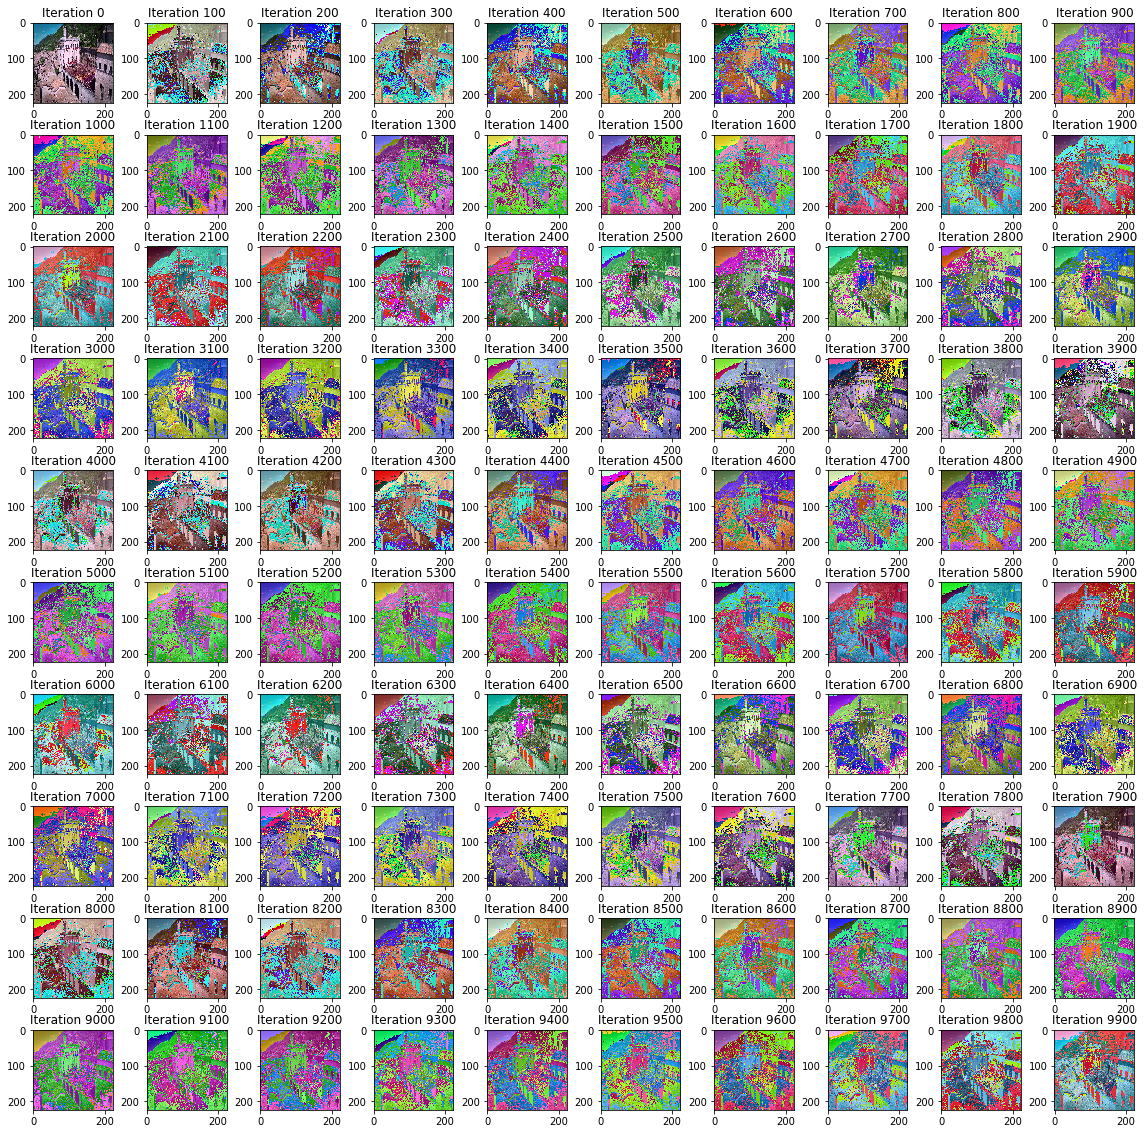

In [151]:
result = iterate_over_loss_optimization(content_img,
                                        style_img,
                                        alpha = 0.5,
                                        beta = 0.5,
                                        iterations=10000,
                                        plots_per_row = 10,
                                        plot_every=100)

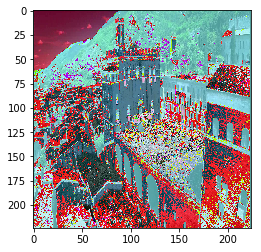

In [152]:
imshow(result)